# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


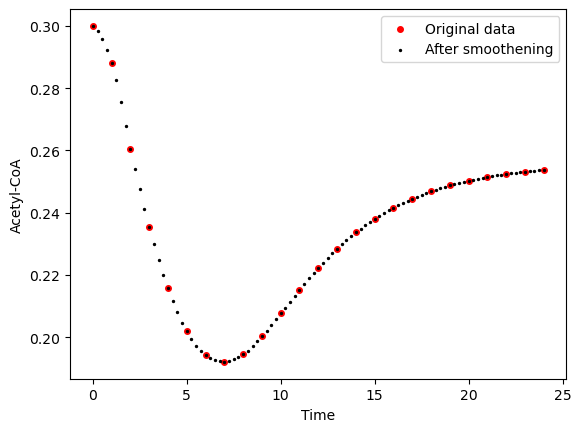

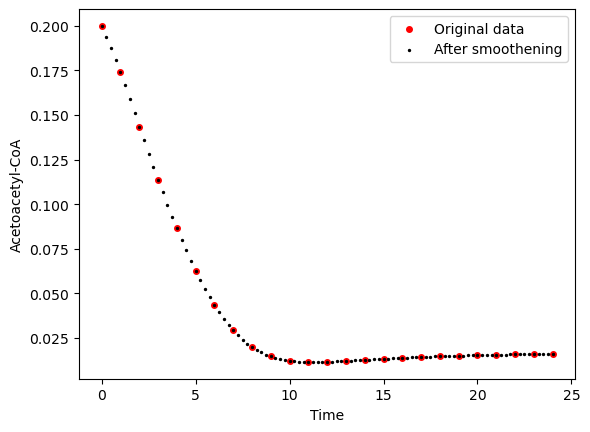

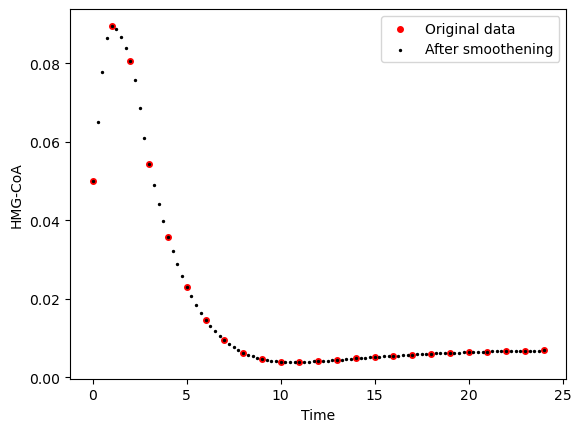

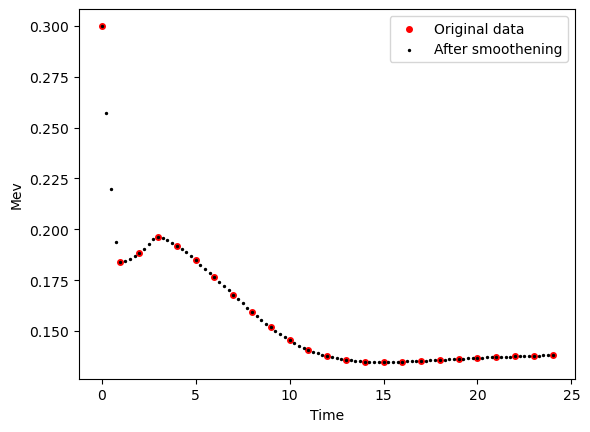

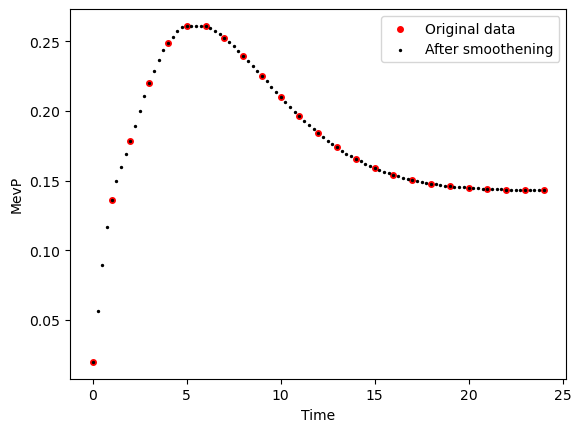

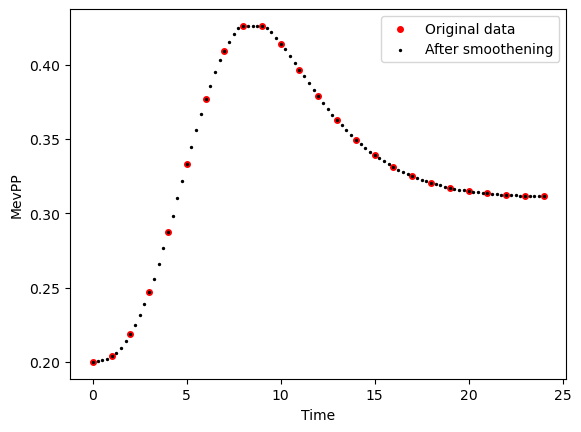

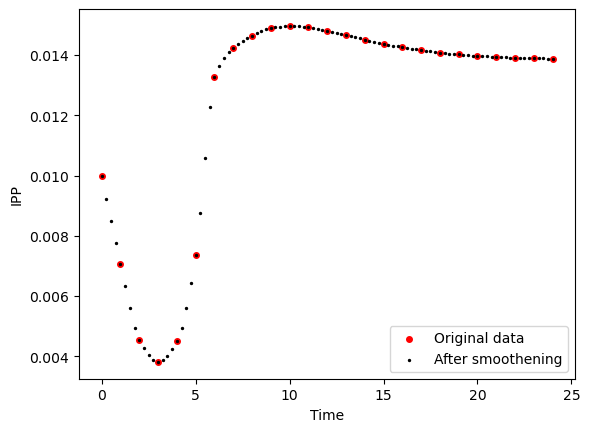

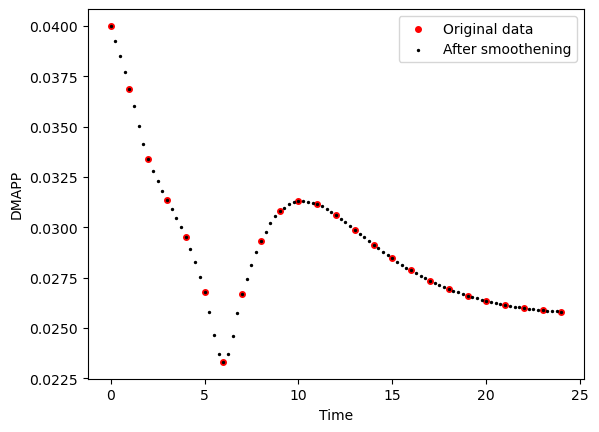

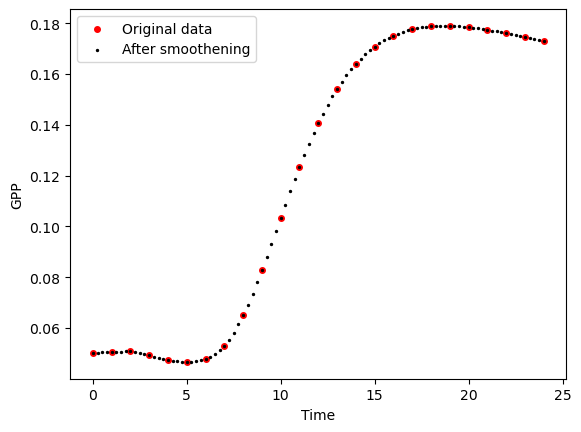

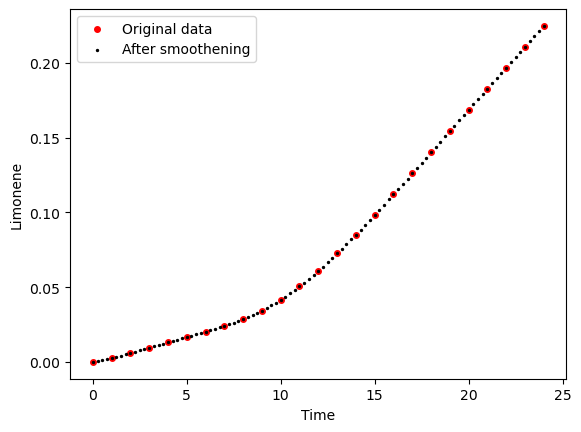

Strain Strain 2


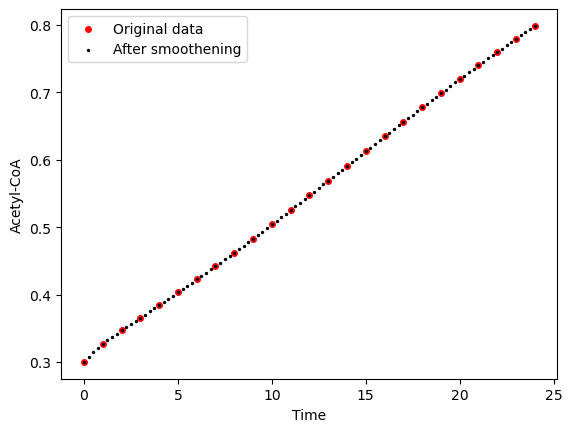

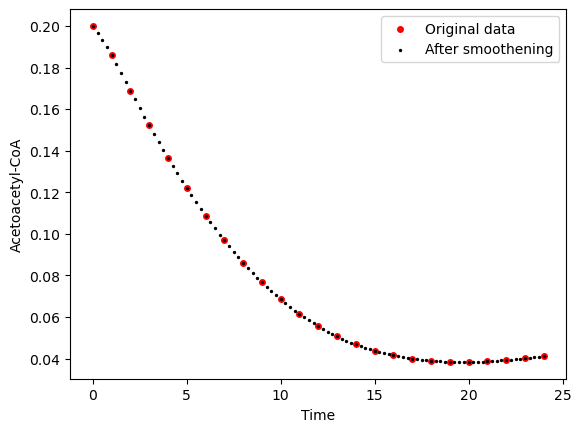

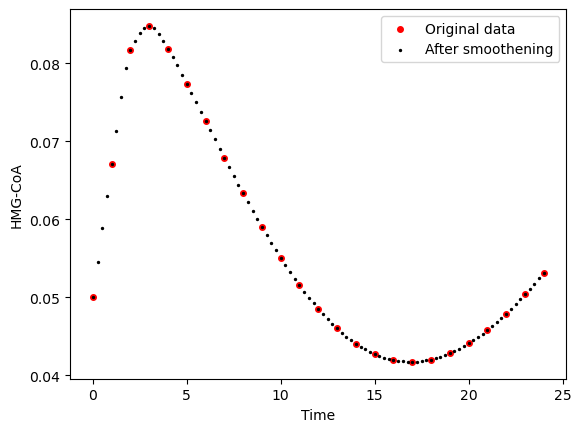

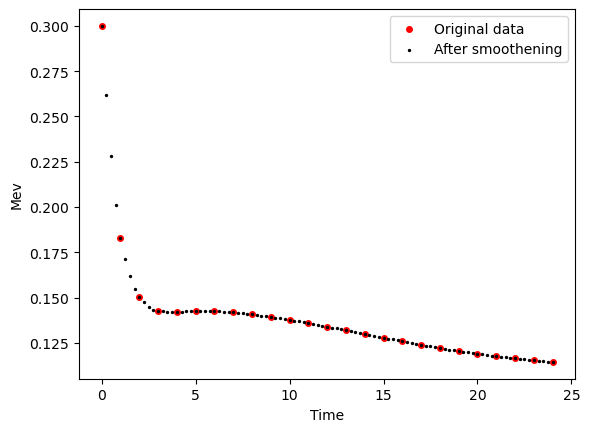

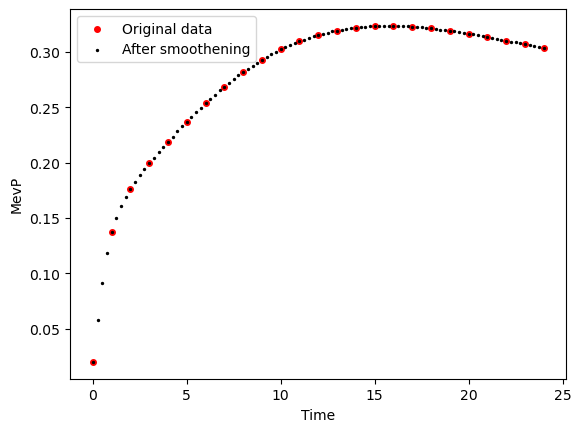

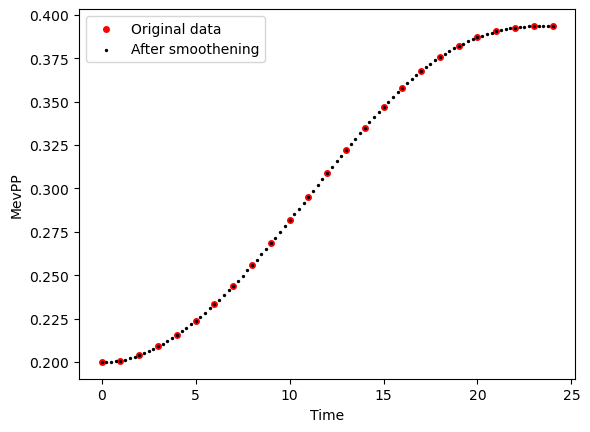

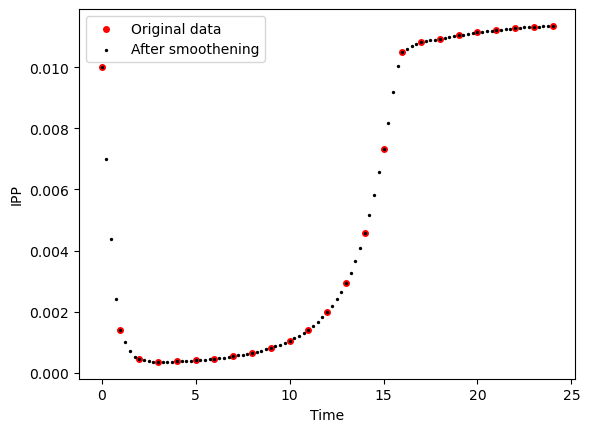

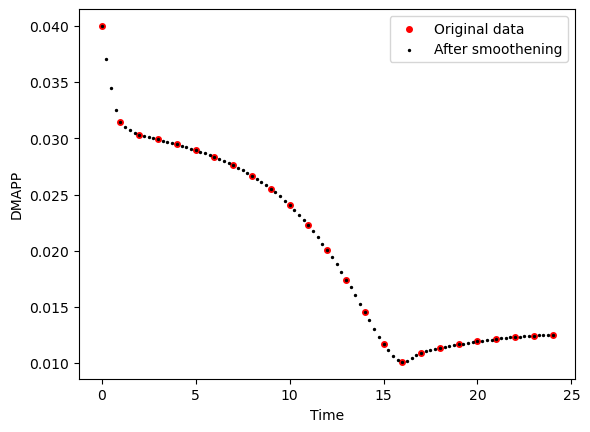

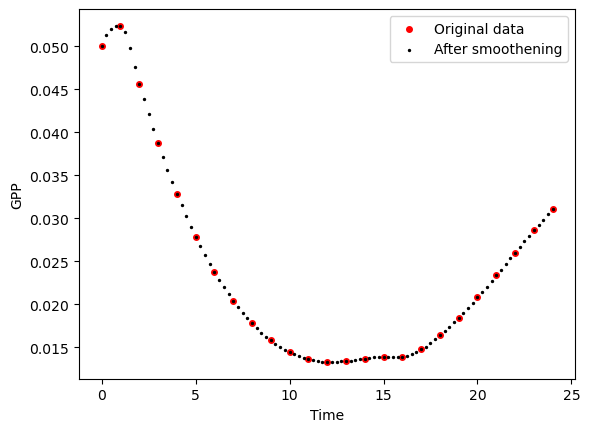

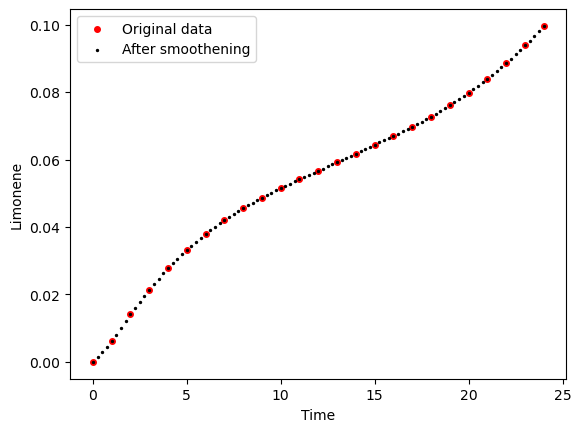

Strain Strain 3


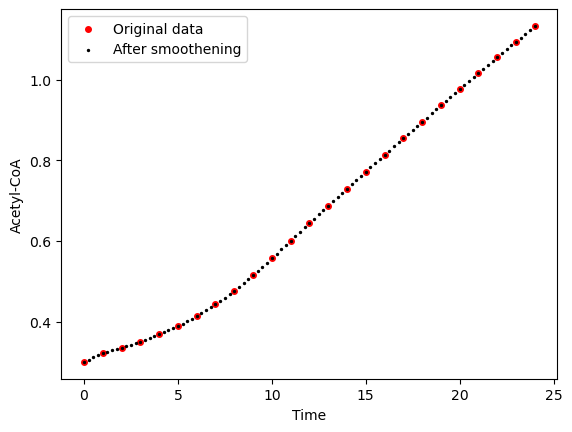

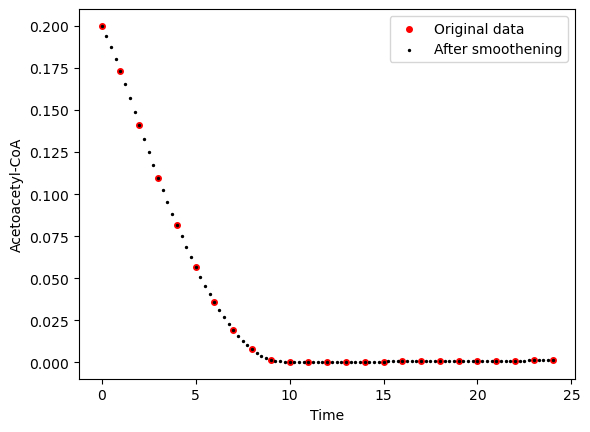

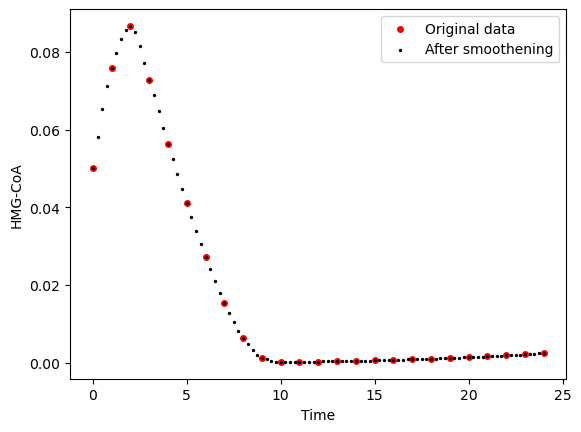

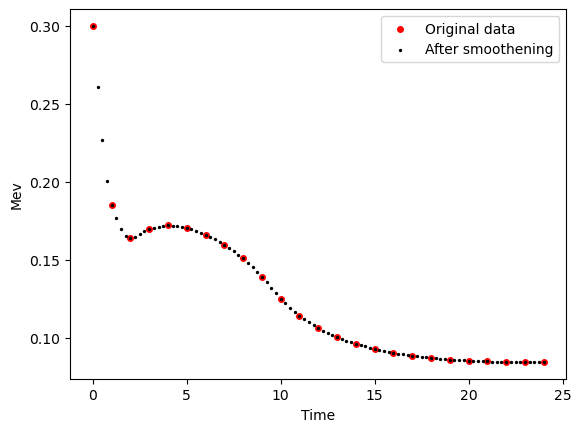

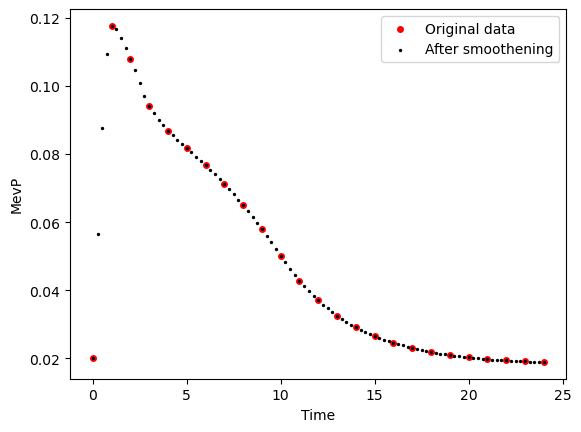

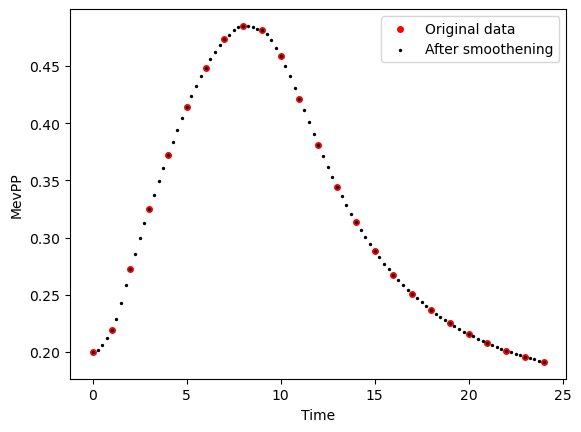

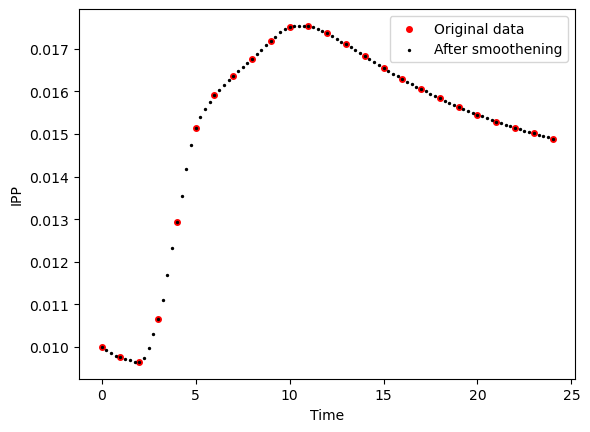

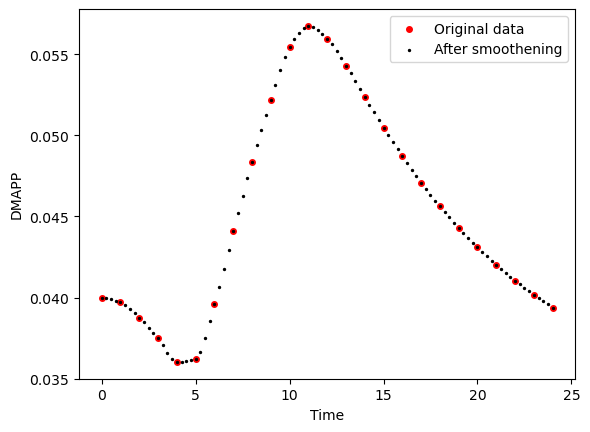

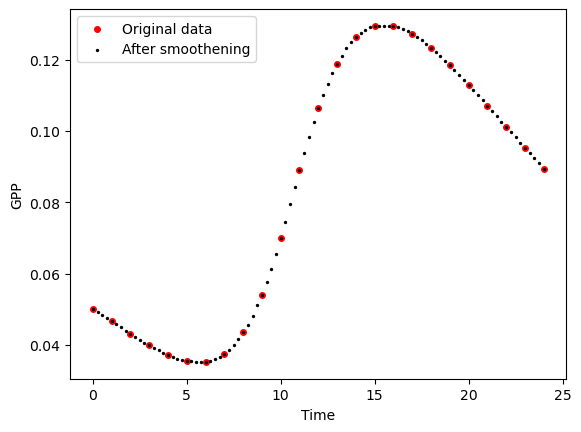

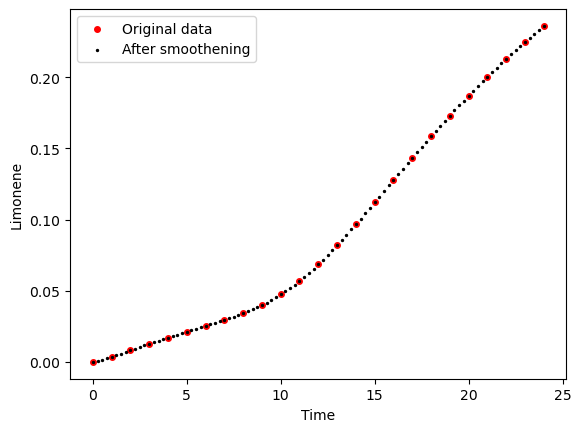

Strain WT


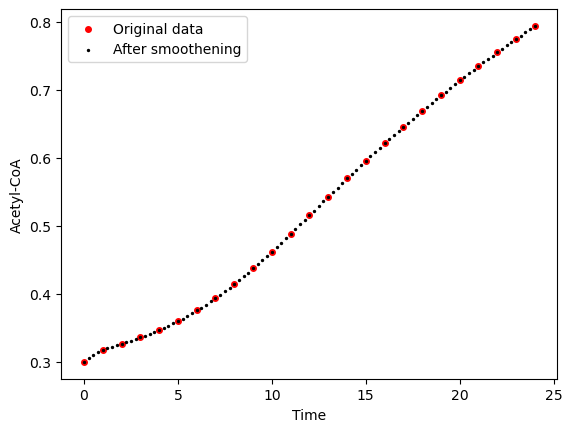

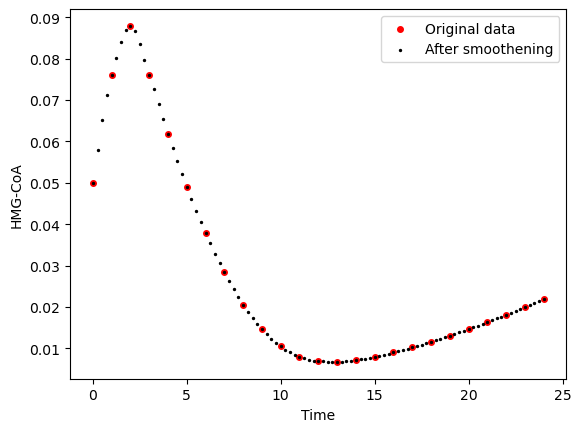

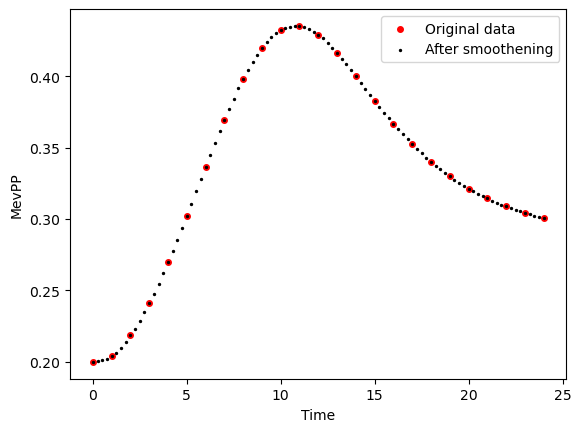

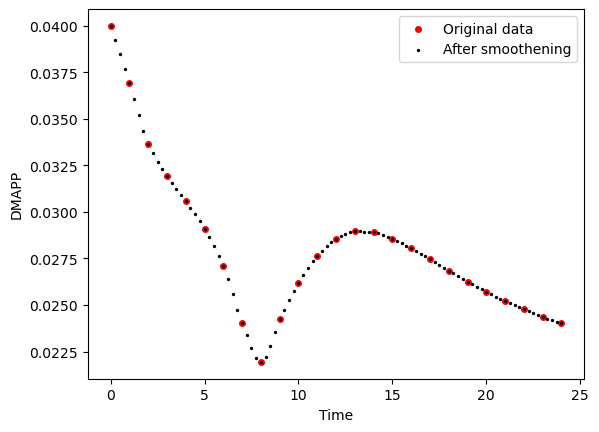

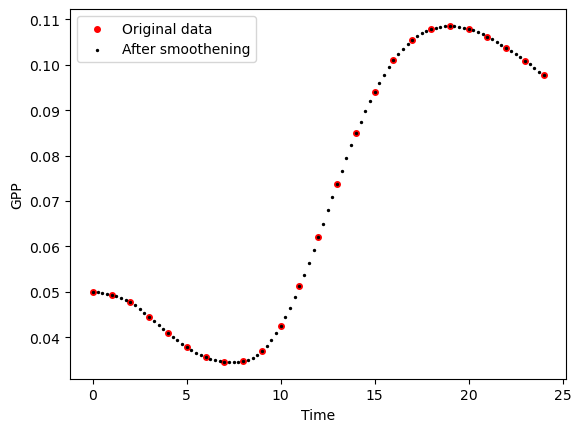

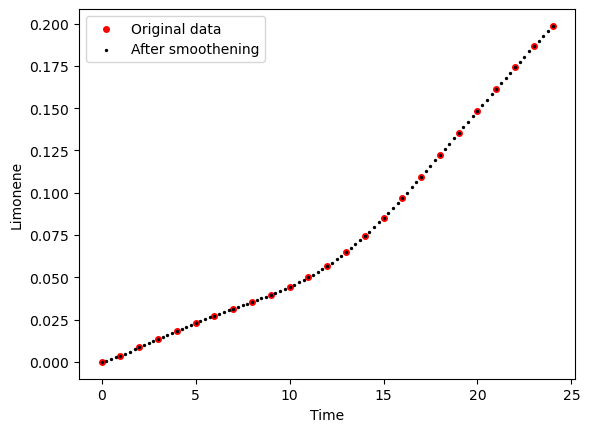

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


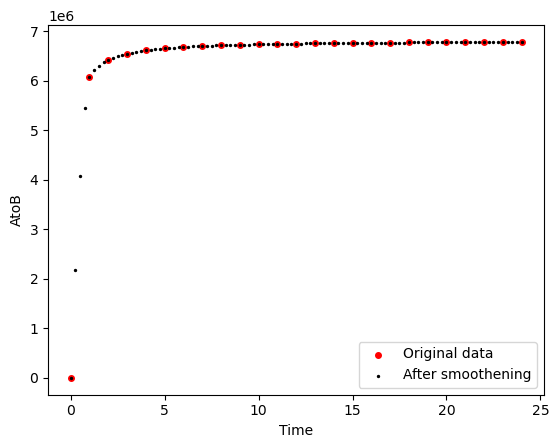

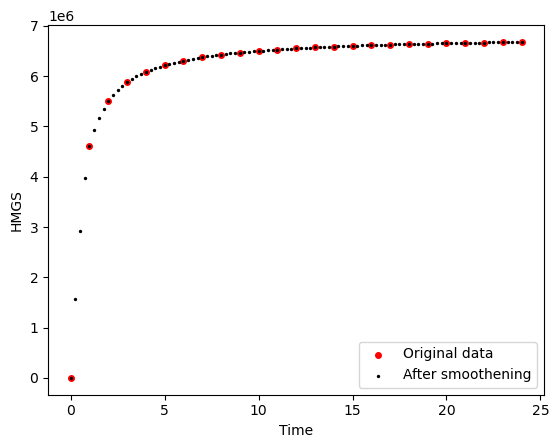

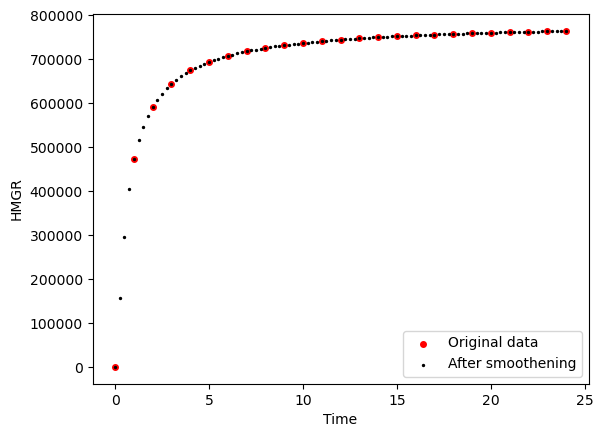

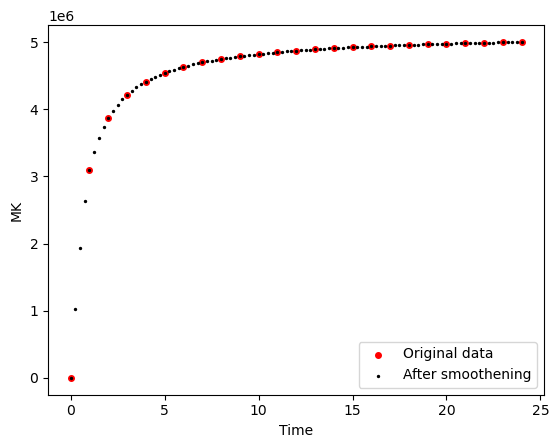

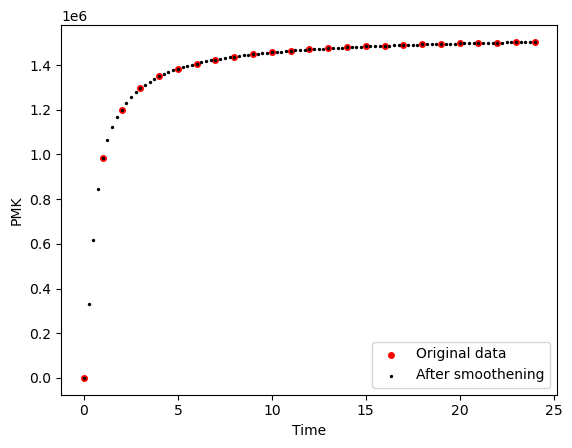

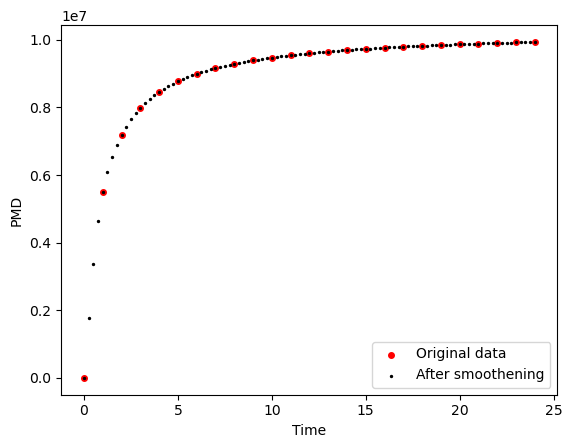

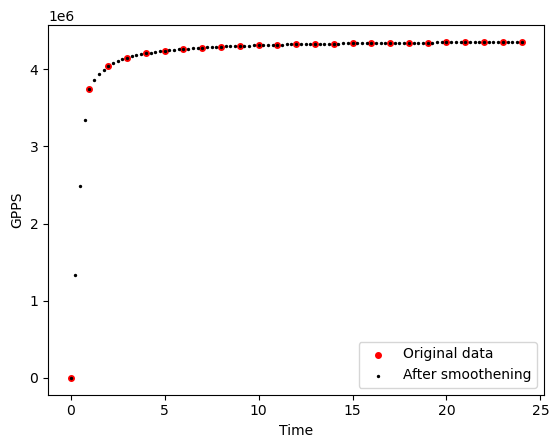

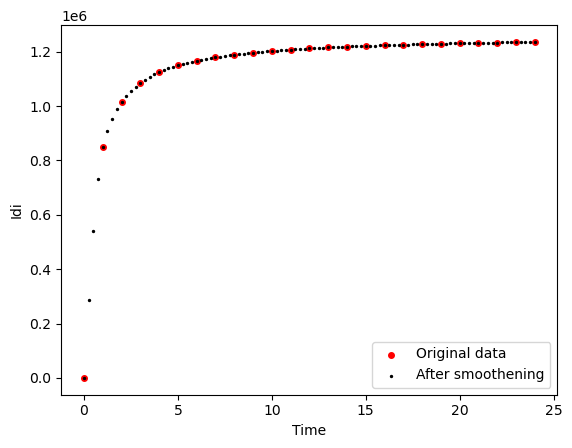

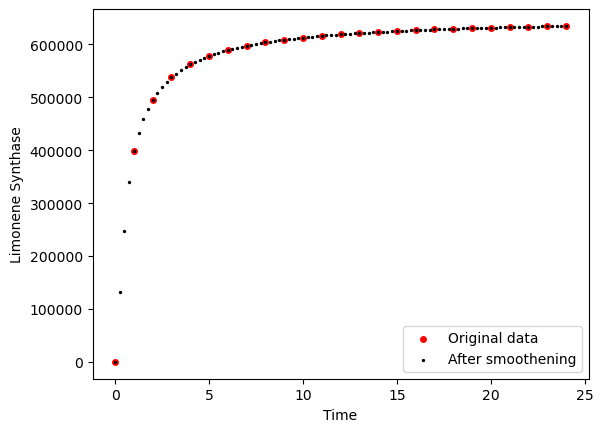

Strain Strain 2


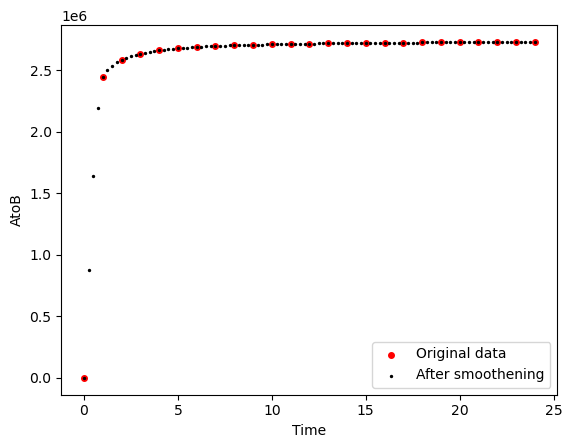

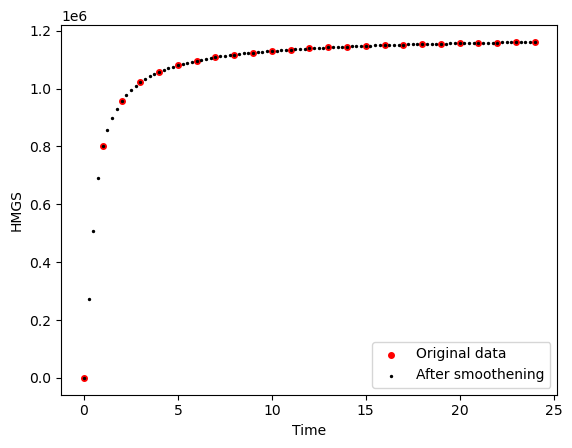

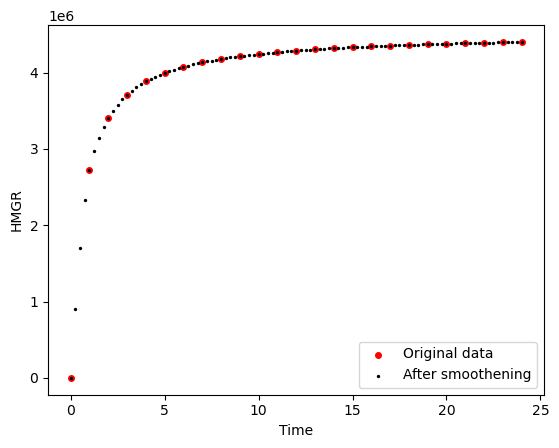

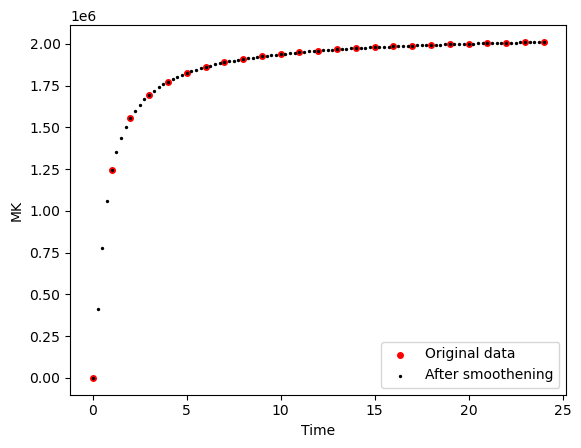

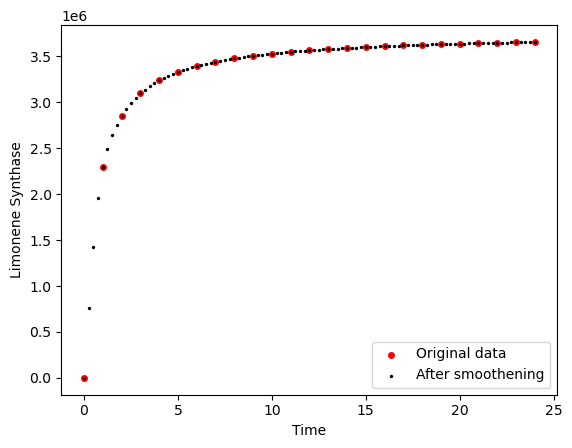

Strain Strain 3


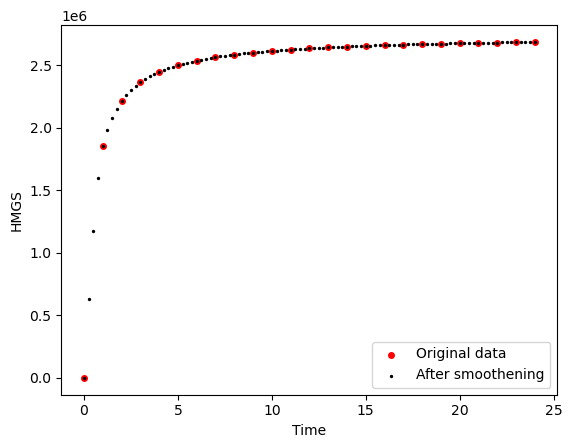

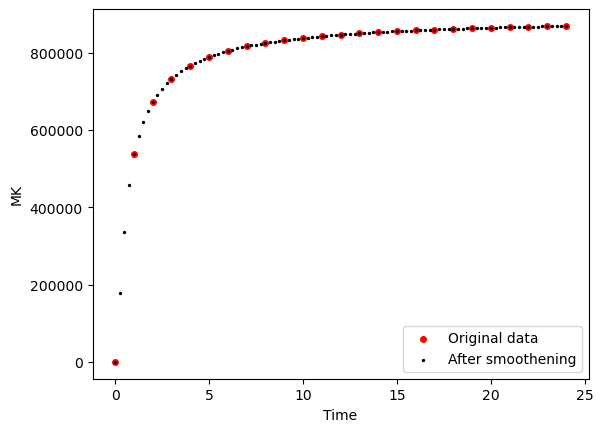

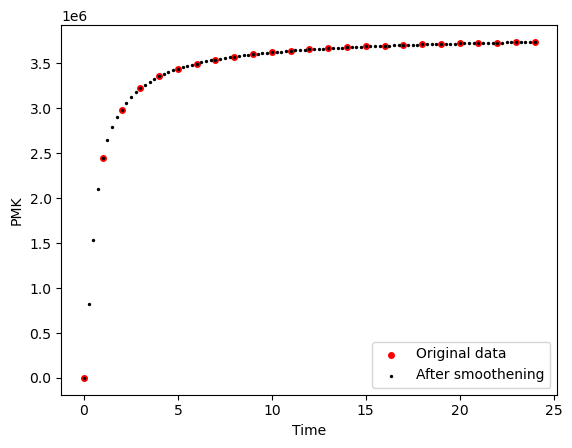

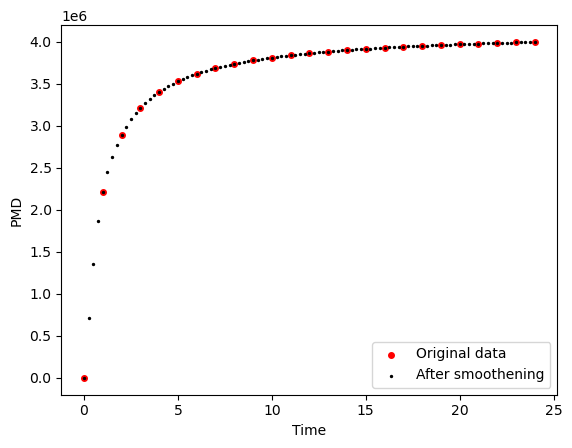

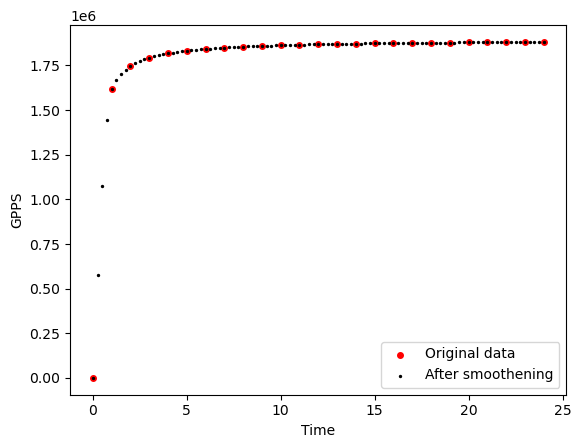

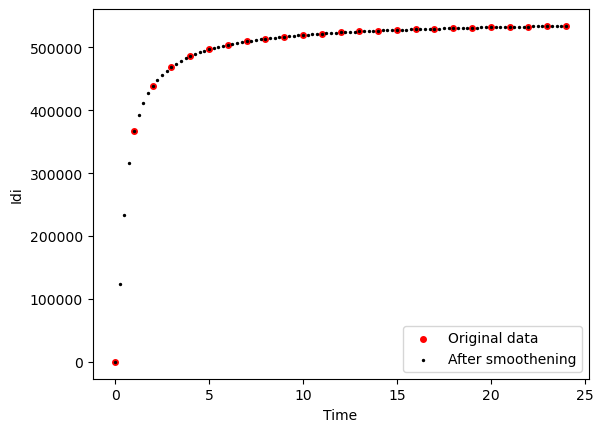

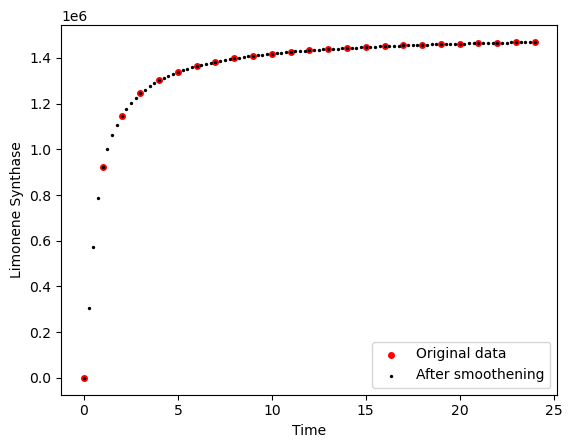

Strain WT


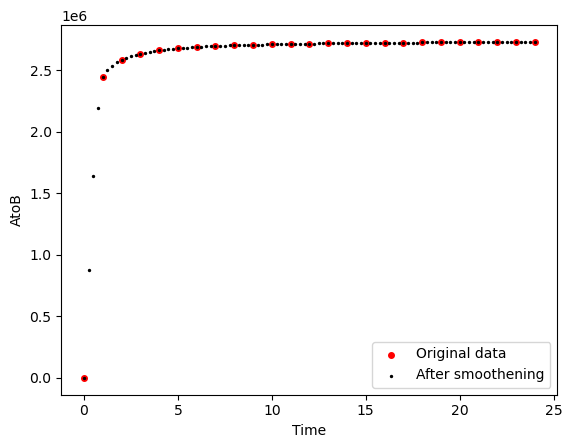

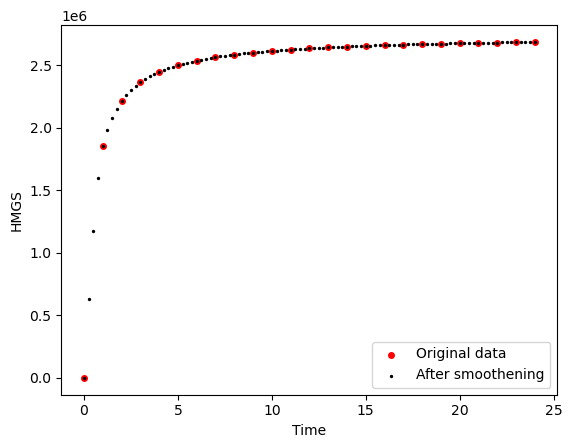

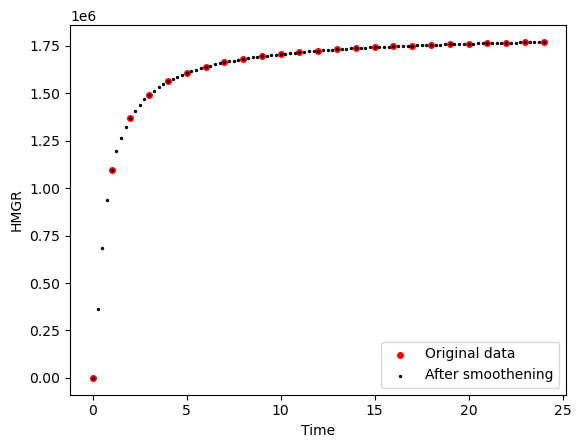

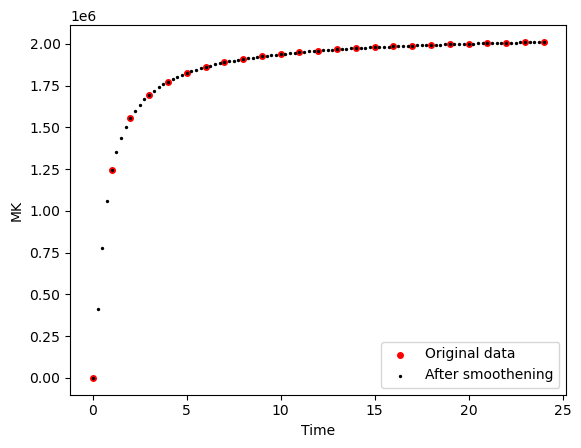

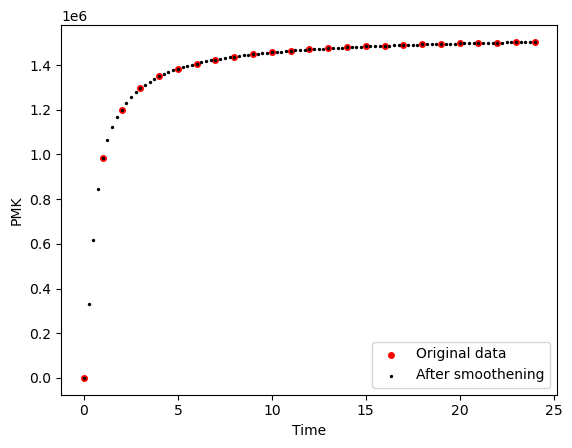

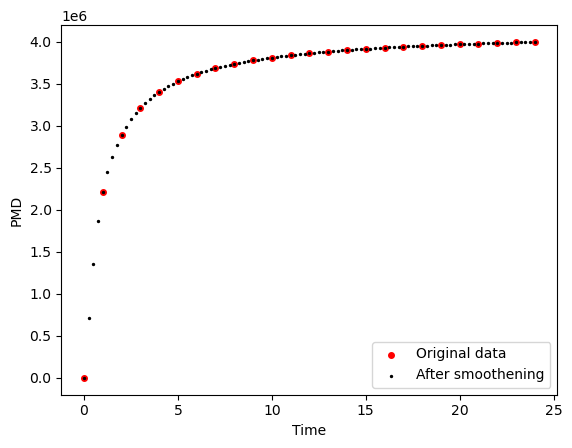

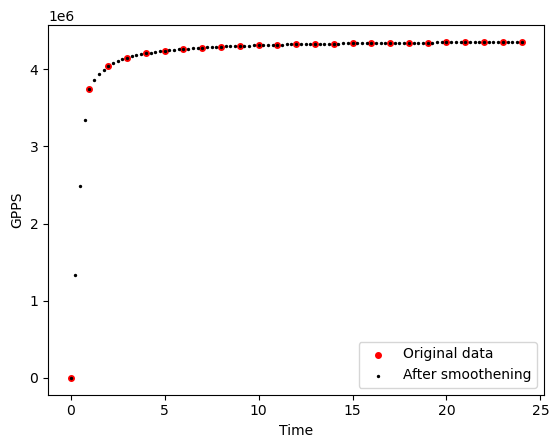

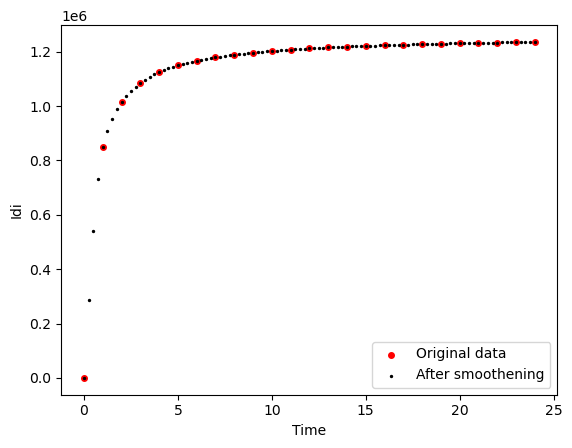

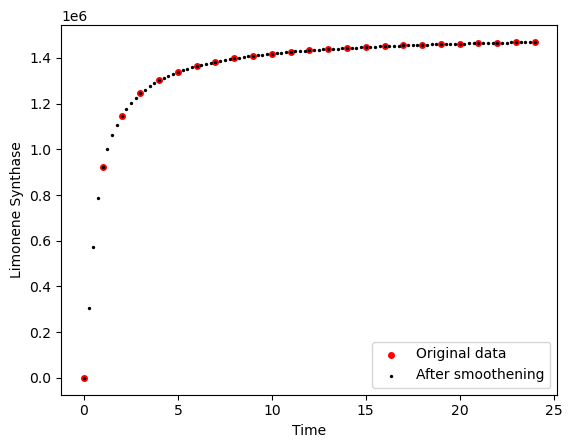

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.298383        0.193946  0.065149  0.257084  0.056859   
         0.50    0.295677        0.187596  0.077750  0.219963  0.089623   
         0.75    0.292180        0.180967  0.086366  0.193859  0.116665   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112529  0.100703   
         23.50   0.784585        0.014581  0.020885  0.112673  0.100406   
         23.75   0.789291        0.014788  0.021362  0.112824  0.100136   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200300  0.009225  0.039259  0.050238  0.000531  ...   
         0.50   0.201111  0.008475  0.038493  0.050445  0.001124  ...   
         0.75   0.202294  0.007751  0.037703  0.050600  0.001772  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303342  0.013479  0.024269  0.100097  0.189617  ...   
         23.50  0.302439  0.013460  0.024180  0.099307  0.192637  ...   
         23.75  0.301595  0.013442  0.024094  0.098498  0.195634  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

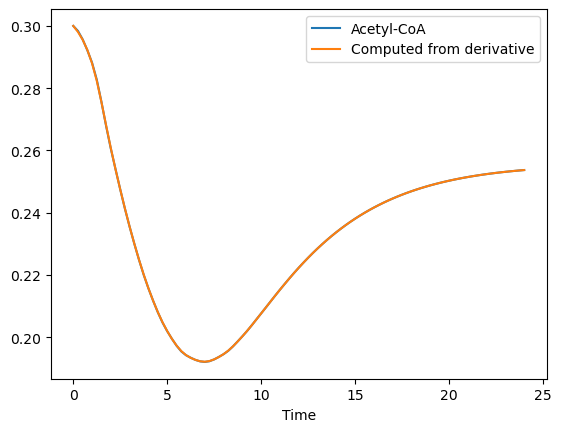

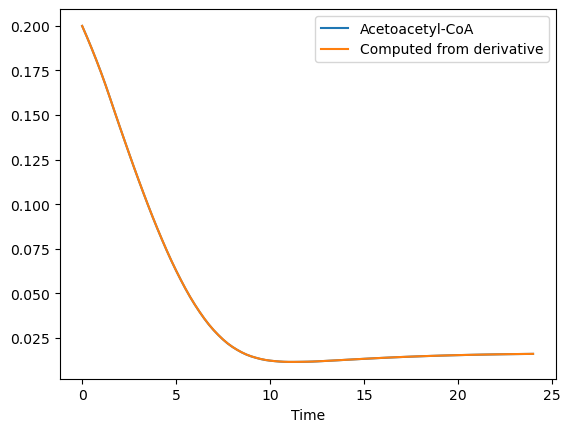

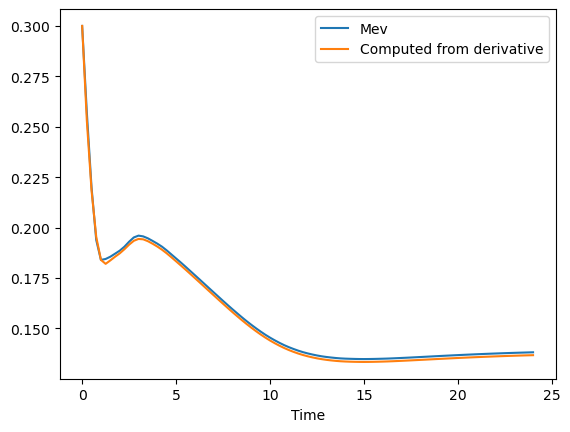

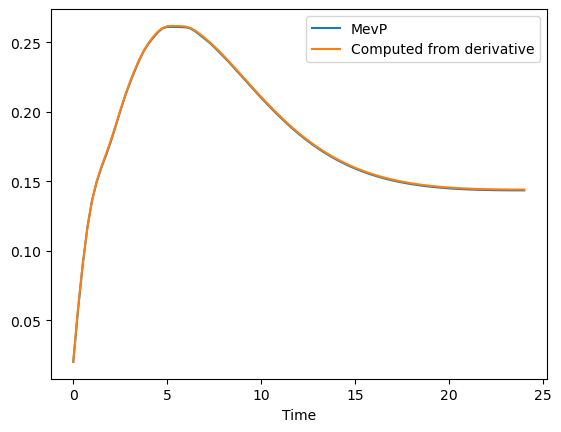

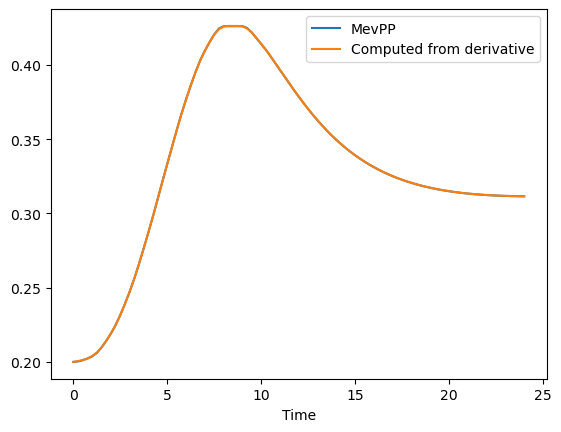

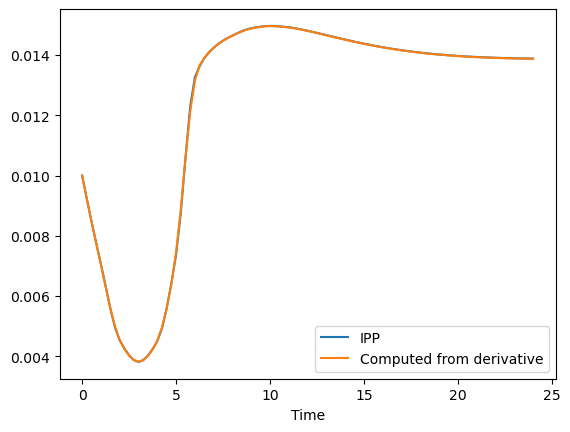

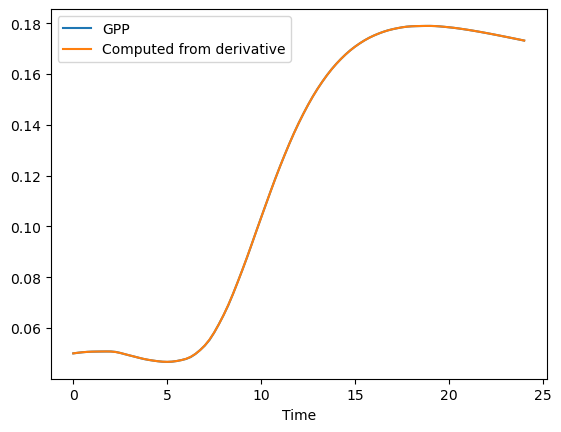

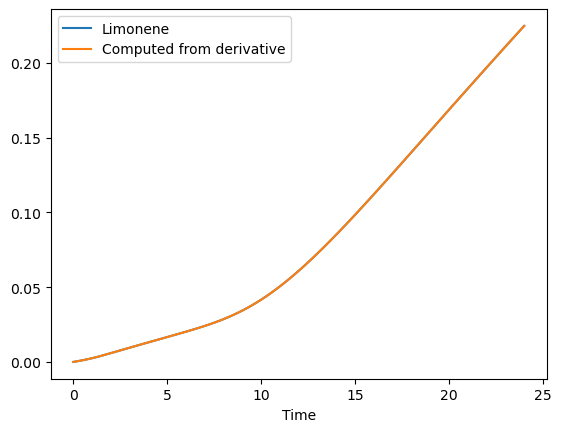

'Time profile from derivative vs. actual profile for Strain 2'

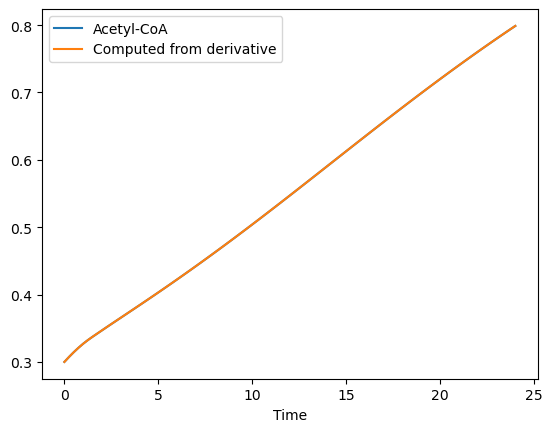

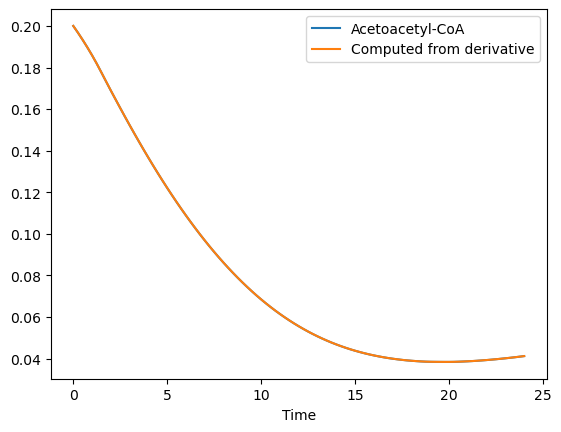

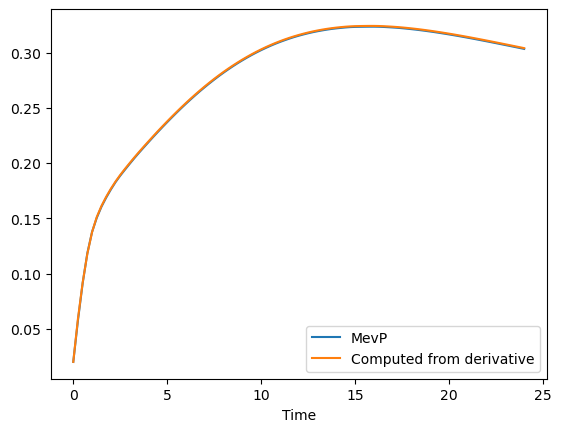

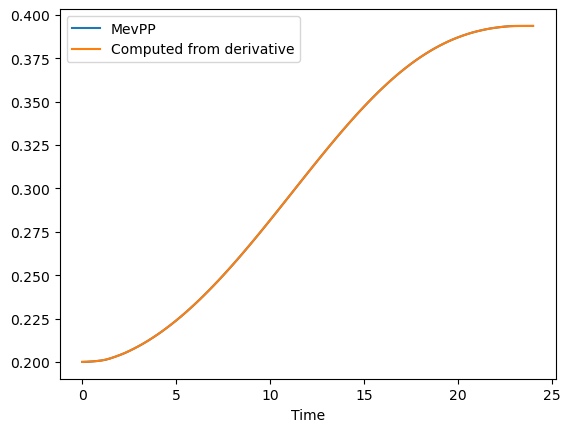

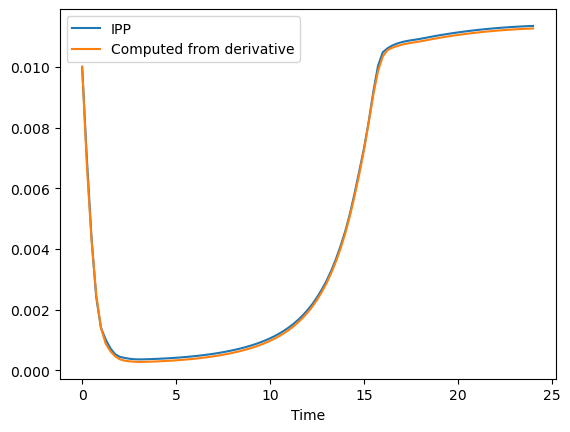

'Time profile from derivative vs. actual profile for Strain 3'

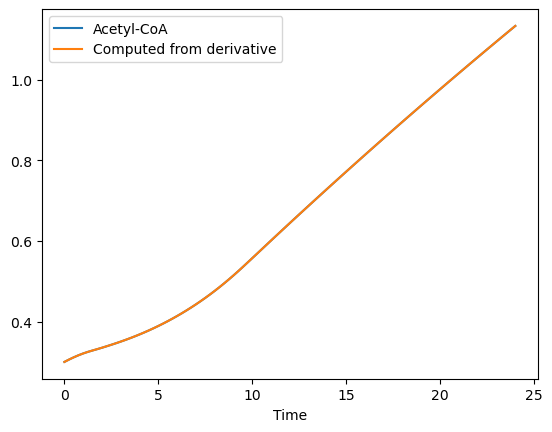

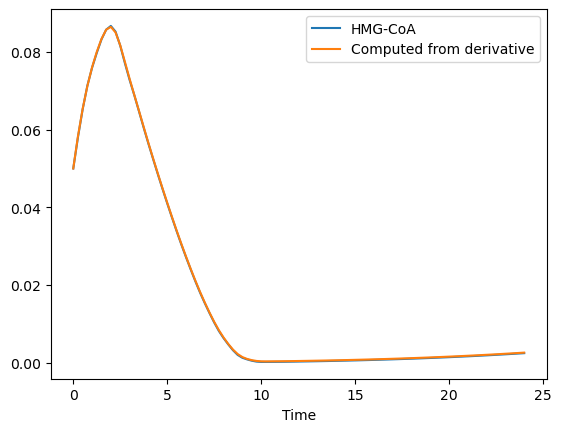

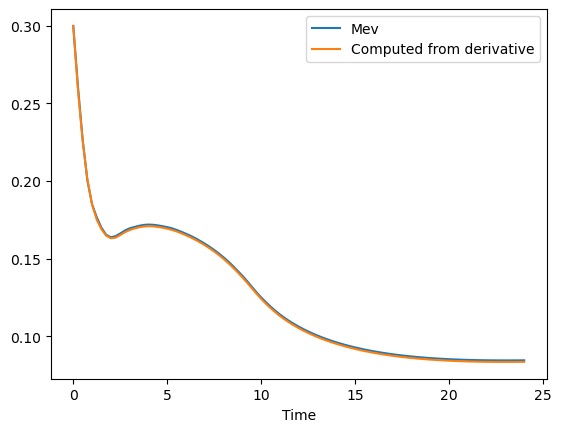

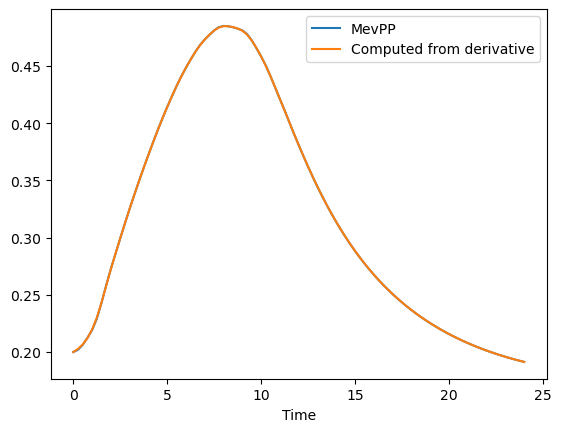

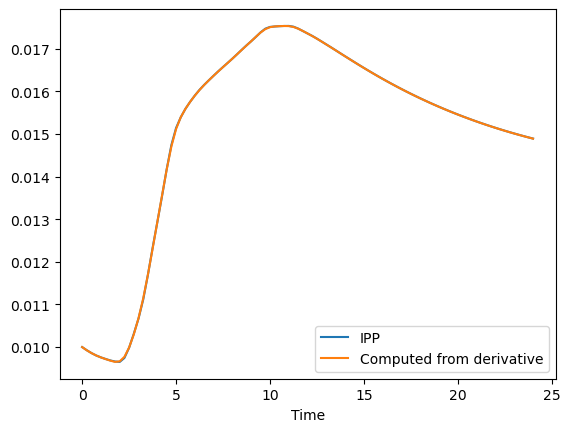

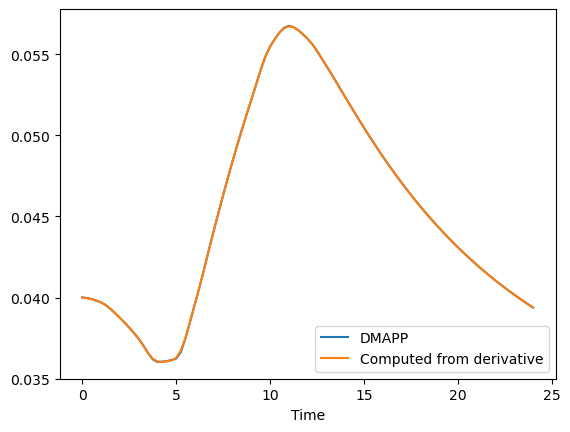

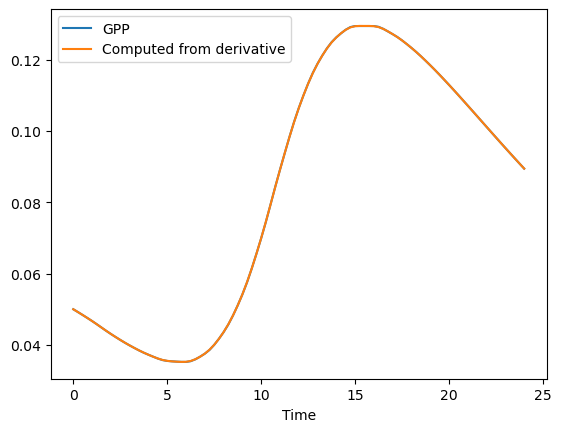

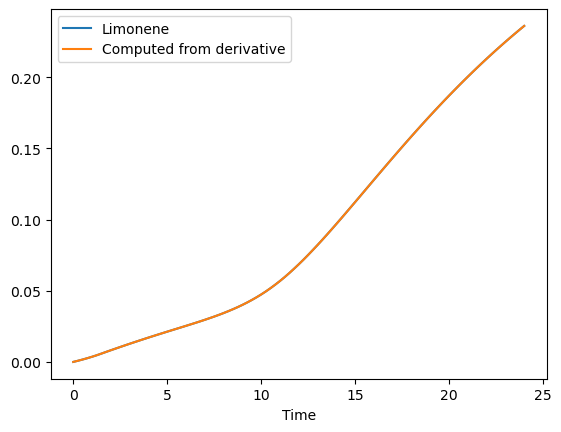

'Time profile from derivative vs. actual profile for WT'

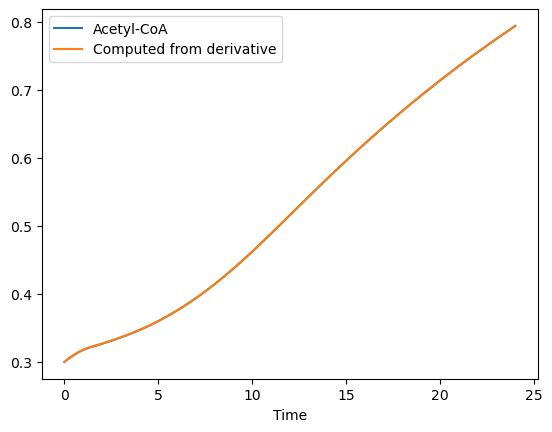

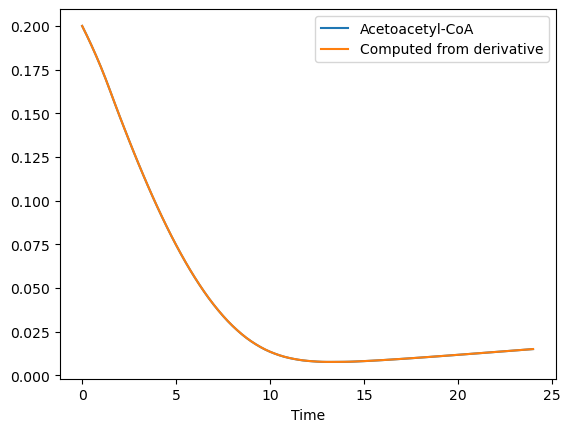

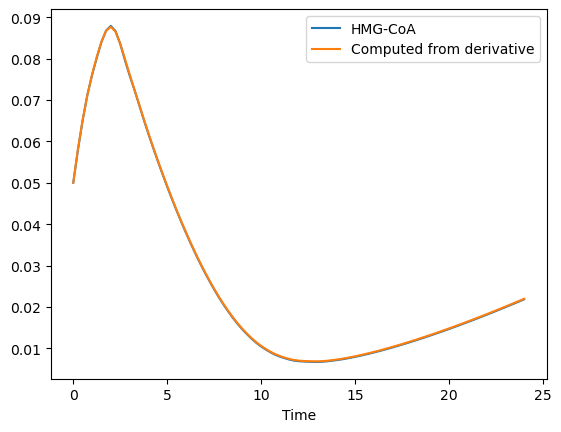

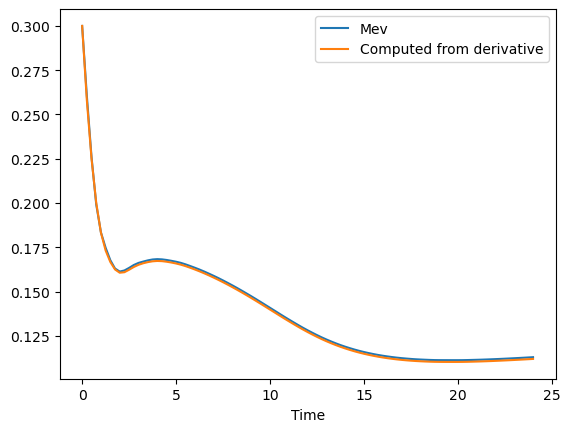

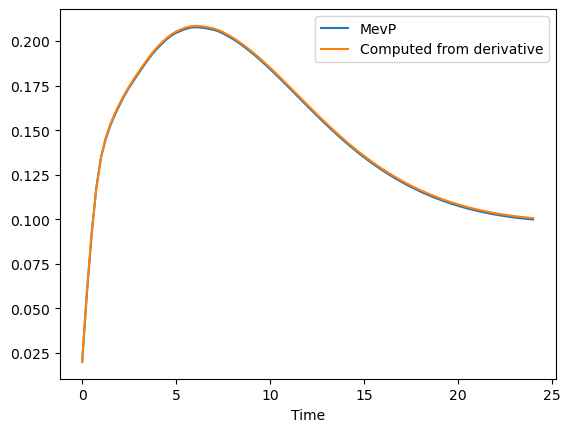

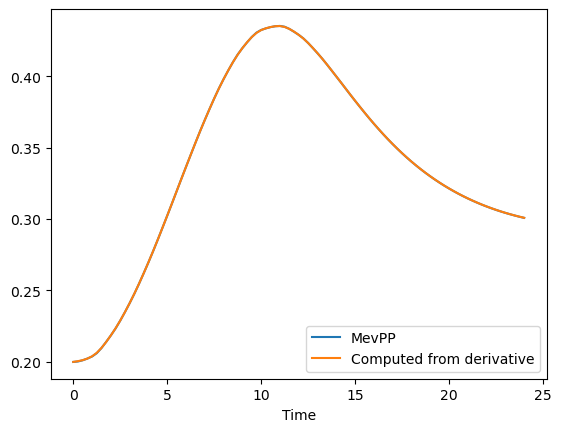

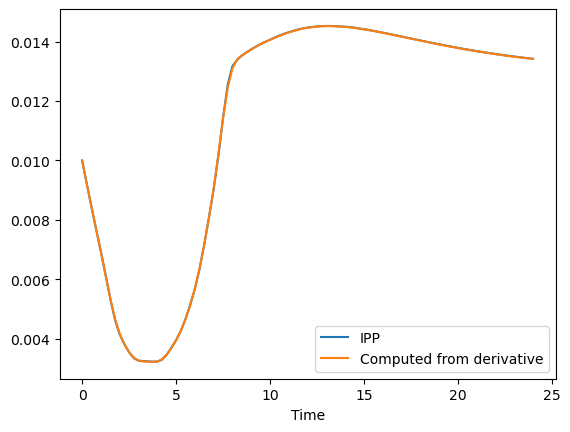

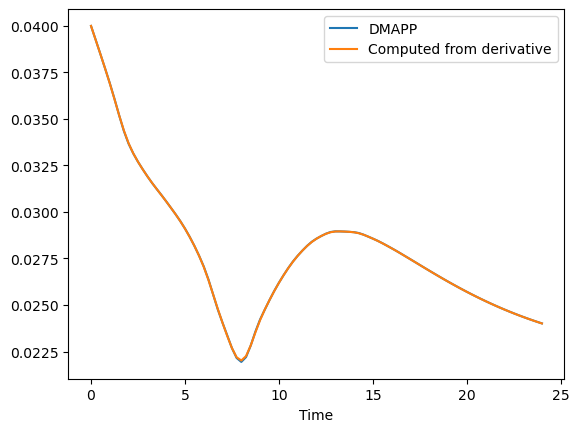

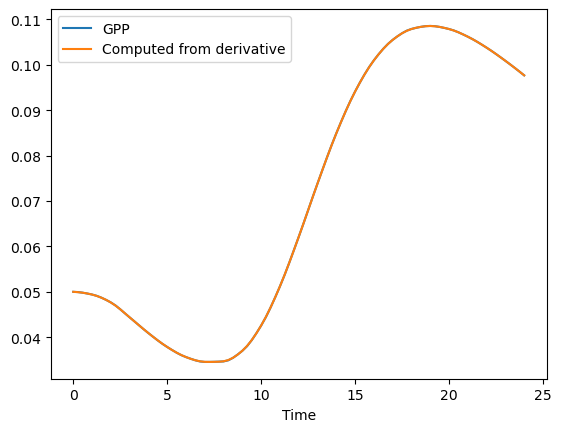

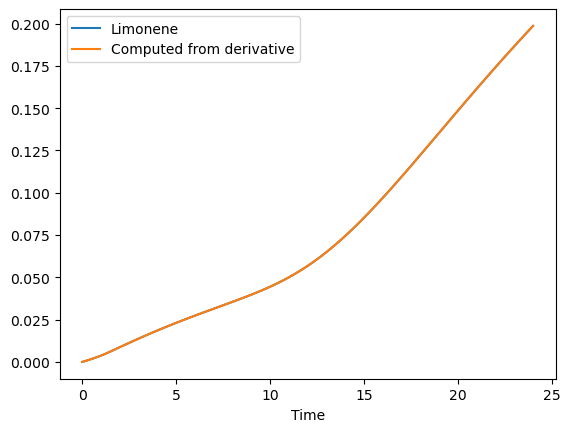

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   2.173781e+06  1.560234e+06  1.570374e+05  1.025868e+06   
         0.50   4.069572e+06  2.927241e+06  2.951031e+05  1.927997e+06   
         0.75   5.448752e+06  3.983103e+06  4.041436e+05  2.640608e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768629e+06  2.010384e+06   
         23.50  2.729713e+06  2.686646e+06  1.769147e+06  2.010975e+06   
         23.75  2.729864e+06  2.687210e+06  1.769654e+06  2.011553e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   3.297925e+05  1.785807e+06  1.328120e+06  2.871277e+05   
         0.50   6.192067e+05  3.363592e+06  2.486684e+06  5.387196e+05   
         0.75   8.452060e+05  4.637042e+06  3.337821e+06  7.332309e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992255e+06  4.354150e+06  1.235379e+06   
         23.50  1.502404e+06  3.993787e+06  4.354490e+06  1.235648e+06   
         23.75  1.502773e+06  3.995286e+06  4.354823e+06  1.235911e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.321864e+05   0.298383        0.193946  0.065149   
         0.50       2.483535e+05   0.295677        0.187596  0.077750   
         0.75       3.398863e+05   0.292180        0.180967  0.086366   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468852e+06   0.784585        0.014581  0.020885   
         23.75      1.469260e+06   0.789291        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257084  0.056859  0.200300  0.009225  0.039259  0.050238   
         0.50   0.219963  0.089623  0.201111  0.008475  0.038493  0.050445   
         0.75   0.193859  0.116665  0.202294  0.007751  0.037703  0.050600   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112529  0.100703  0.303342  0.013479  0.024269  0.100097   
         23.50  0.112673  0.100406  0.302439  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         24.00 -0.003031 -0.000070 -0.000326 -0.003358  0.011855  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.613284E+188 | 7.464648E+113
     2 |       74 | 7.706326E+129 |  2.932016E+84
     3 |      138 |  4.529835E+97 |  8.753697E+81
     4 |      202 |  2.499631E+85 |  1.234048E+71
     5 |      266 |  9.644361E+75 |  1.624957E+55
     6 |      330 |  7.052285E+70 |  2.735813E+53
     7 |      394 |  4.907803E+57 |  2.769677E+47
     8 |      458 |  2.768038E+52 |  8.687687E+31
     9 |      522 |  1.596513E+52 |  8.687687E+31
    10 |      586 |  1.168444E+47 |  8.687687E+31
    11 |      650 |  3.533791E+43 |  6.944448E+30
    12 |      714 |  1.413832E+39 |  3.163233E+26
    13 |      778 |  5.734551E+33 |  3.163233E+26
    14 |      842 |  1.429293E+35 |  6.654237E+21
    15 |      906 |  2.335065E+31 |  6.654237E+21
    16 |      970 |  2.834516E+31 |  6.654237E+21
    17 |     1034 |  5.041455E+29 |  3.705867E+16
    18 |     1098 |  4.627784E+27 |  3.705867E+16
    19 |     1162 |  8.070

   162 |    10314 |  1.968546E+01 |  1.840663E+01
   163 |    10378 |  1.952053E+01 |  1.840663E+01
   164 |    10442 |  1.969315E+01 |  1.840663E+01
   165 |    10506 |  1.947871E+01 |  1.840663E+01
   166 |    10570 |  1.952048E+01 |  1.840663E+01
   167 |    10634 |  1.987176E+01 |  1.840663E+01
   168 |    10698 |  1.970450E+01 |  1.840663E+01
   169 |    10762 |  1.923123E+01 |  1.840663E+01
   170 |    10826 |  1.921594E+01 |  1.829672E+01
   171 |    10890 |  1.885491E+01 |  1.829672E+01
   172 |    10954 |  1.898994E+01 |  1.829672E+01
   173 |    11018 |  1.880941E+01 |  1.829672E+01
   174 |    11082 |  1.867592E+01 |  1.823155E+01
   175 |    11146 |  1.868788E+01 |  1.822847E+01
   176 |    11210 |  1.852347E+01 |  1.770321E+01
   177 |    11274 |  1.845374E+01 |  1.770321E+01
   178 |    11338 |  1.876630E+01 |  1.770321E+01
   179 |    11402 |  1.893012E+01 |  1.770321E+01
   180 |    11466 |  1.856806E+01 |  1.770321E+01
   181 |    11530 |  1.866694E+01 |  1.770321E+01


   326 |    20810 |  1.599979E+01 |  1.509162E+01
   327 |    20874 |  1.601983E+01 |  1.509162E+01
   328 |    20938 |  1.595215E+01 |  1.509162E+01
   329 |    21002 |  1.590736E+01 |  1.506233E+01
   330 |    21066 |  1.612345E+01 |  1.506233E+01
   331 |    21130 |  1.620552E+01 |  1.506233E+01
   332 |    21194 |  1.608804E+01 |  1.506233E+01
   333 |    21258 |  1.603595E+01 |  1.506233E+01
   334 |    21322 |  1.595138E+01 |  1.506233E+01
   335 |    21386 |  1.603982E+01 |  1.506233E+01
   336 |    21450 |  1.602501E+01 |  1.506233E+01
   337 |    21514 |  1.595045E+01 |  1.506233E+01
   338 |    21578 |  1.593797E+01 |  1.506233E+01
   339 |    21642 |  1.585073E+01 |  1.506233E+01
   340 |    21706 |  1.600063E+01 |  1.506233E+01
   341 |    21770 |  1.586597E+01 |  1.506233E+01
   342 |    21834 |  1.590822E+01 |  1.506233E+01
   343 |    21898 |  1.576543E+01 |  1.493606E+01
   344 |    21962 |  1.564753E+01 |  1.493606E+01
   345 |    22026 |  1.581995E+01 |  1.493606E+01


   490 |    31306 |  1.365964E+01 |  1.313201E+01
   491 |    31370 |  1.358657E+01 |  1.313201E+01
   492 |    31434 |  1.351832E+01 |  1.308868E+01
   493 |    31498 |  1.341041E+01 |  1.302206E+01
   494 |    31562 |  1.336208E+01 |  1.301938E+01
   495 |    31626 |  1.346798E+01 |  1.301938E+01
   496 |    31690 |  1.346783E+01 |  1.301938E+01
   497 |    31754 |  1.348571E+01 |  1.301938E+01
   498 |    31818 |  1.331716E+01 |  1.301938E+01
   499 |    31882 |  1.337636E+01 |  1.301938E+01
   500 |    31946 |  1.338070E+01 |  1.297911E+01
   501 |    32010 |  1.325271E+01 |  1.297911E+01
   502 |    32074 |  1.319026E+01 |  1.283904E+01
   503 |    32138 |  1.334825E+01 |  1.267895E+01
   504 |    32202 |  1.342459E+01 |  1.267895E+01
   505 |    32266 |  1.354354E+01 |  1.267895E+01
   506 |    32330 |  1.358636E+01 |  1.267895E+01
   507 |    32394 |  1.355562E+01 |  1.267895E+01
   508 |    32458 |  1.358371E+01 |  1.267895E+01
   509 |    32522 |  1.354054E+01 |  1.267895E+01


   654 |    41802 |  1.145504E+01 |  1.136530E+01
   655 |    41866 |  1.145247E+01 |  1.136530E+01
   656 |    41930 |  1.143137E+01 |  1.136530E+01
   657 |    41994 |  1.143723E+01 |  1.136530E+01
   658 |    42058 |  1.142308E+01 |  1.136456E+01
   659 |    42122 |  1.142051E+01 |  1.136456E+01
   660 |    42186 |  1.139718E+01 |  1.133704E+01
   661 |    42250 |  1.138802E+01 |  1.133704E+01
   662 |    42314 |  1.138080E+01 |  1.133201E+01
   663 |    42378 |  1.137681E+01 |  1.133201E+01
   664 |    42442 |  1.139869E+01 |  1.133201E+01
   665 |    42506 |  1.138361E+01 |  1.131501E+01
   666 |    42570 |  1.136368E+01 |  1.131501E+01
   667 |    42634 |  1.136084E+01 |  1.131501E+01
   668 |    42698 |  1.136657E+01 |  1.131501E+01
   669 |    42762 |  1.139465E+01 |  1.131501E+01
   670 |    42826 |  1.139810E+01 |  1.131501E+01
   671 |    42890 |  1.138216E+01 |  1.131501E+01
   672 |    42954 |  1.137626E+01 |  1.131501E+01
   673 |    43018 |  1.138301E+01 |  1.131501E+01


   818 |    52298 |  1.008663E+01 |  1.006922E+01
   819 |    52362 |  1.008609E+01 |  1.006922E+01
   820 |    52426 |  1.007768E+01 |  1.006806E+01
   821 |    52490 |  1.007562E+01 |  1.006478E+01
   822 |    52554 |  1.007291E+01 |  1.005548E+01
   823 |    52618 |  1.006521E+01 |  1.005154E+01
   824 |    52682 |  1.005468E+01 |  1.003968E+01
   825 |    52746 |  1.005506E+01 |  1.003968E+01
   826 |    52810 |  1.004653E+01 |  1.003549E+01
   827 |    52874 |  1.003719E+01 |  1.002706E+01
   828 |    52938 |  1.003065E+01 |  1.002577E+01
   829 |    53002 |  1.003184E+01 |  1.000990E+01
   830 |    53066 |  1.001718E+01 |  1.000943E+01
   831 |    53130 |  1.001672E+01 |  1.000943E+01
   832 |    53194 |  1.001094E+01 |  1.000283E+01
   833 |    53258 |  1.001443E+01 |  9.9989915815
   834 |    53322 |  1.001660E+01 |  9.9989915815
   835 |    53386 |  1.000083E+01 |  9.9828955059
   836 |    53450 |  9.9886714069 |  9.9666727494
   837 |    53514 |  9.9803218893 |  9.9666727494


   982 |    62794 |  7.9045290613 |  7.8112720297
   983 |    62858 |  7.9084934058 |  7.8112720297
   984 |    62922 |  7.8815285946 |  7.8112720297
   985 |    62986 |  7.8230216963 |  7.7505095168
   986 |    63050 |  7.8230615990 |  7.7505095168
   987 |    63114 |  7.8227305500 |  7.7422570582
   988 |    63178 |  7.8023000000 |  7.7365711946
   989 |    63242 |  7.8097597695 |  7.7036726825
   990 |    63306 |  7.7679315003 |  7.7036726825
   991 |    63370 |  7.7419322283 |  7.6278456038
   992 |    63434 |  7.6764269140 |  7.4890010639
   993 |    63498 |  7.5908060219 |  7.4293777502
   994 |    63562 |  7.5159060037 |  7.4293777502
   995 |    63626 |  7.5737645975 |  7.4293777502
   996 |    63690 |  7.5631560503 |  7.4293777502
   997 |    63754 |  7.5315222552 |  7.3987773913
   998 |    63818 |  7.4796953614 |  7.3848043016
   999 |    63882 |  7.4524881491 |  7.3297932600
  1000 |    63946 |  7.4393228696 |  7.3297932600
  1001 |    64010 |  7.4779543461 |  7.3297932600


  1146 |    73290 |  6.9366801709 |  6.9134631635
  1147 |    73354 |  6.9356810284 |  6.9134631635
  1148 |    73418 |  6.9430055004 |  6.9134631635
  1149 |    73482 |  6.9315333356 |  6.8973575266
  1150 |    73546 |  6.9284891795 |  6.8973575266
  1151 |    73610 |  6.9193827591 |  6.8973575266
  1152 |    73674 |  6.9144610893 |  6.8973575266
  1153 |    73738 |  6.9178367689 |  6.8973575266
  1154 |    73802 |  6.9154868110 |  6.8943379973
  1155 |    73866 |  6.9109818422 |  6.8943379973
  1156 |    73930 |  6.8990620209 |  6.8812000726
  1157 |    73994 |  6.8923375448 |  6.8779499528
  1158 |    74058 |  6.8906495985 |  6.8779499528
  1159 |    74122 |  6.8929804143 |  6.8779499528
  1160 |    74186 |  6.8873867905 |  6.8779499528
  1161 |    74250 |  6.8835167415 |  6.8663061402
  1162 |    74314 |  6.8824606365 |  6.8663061402
  1163 |    74378 |  6.8796915165 |  6.8663061402
  1164 |    74442 |  6.8762001499 |  6.8636686045
  1165 |    74506 |  6.8741198523 |  6.8604561674


  1310 |    83786 |  6.5112321343 |  6.5056150799
  1311 |    83850 |  6.5105347622 |  6.5000497156
  1312 |    83914 |  6.5087070334 |  6.5000497156
  1313 |    83978 |  6.5071031995 |  6.5000497156
  1314 |    84042 |  6.5032986319 |  6.4981958599
  1315 |    84106 |  6.4980602727 |  6.4938185003
  1316 |    84170 |  6.4969714221 |  6.4906333945
  1317 |    84234 |  6.4968643572 |  6.4906333945
  1318 |    84298 |  6.4958724539 |  6.4898394543
  1319 |    84362 |  6.4921585598 |  6.4855417325
  1320 |    84426 |  6.4879191641 |  6.4817195094
  1321 |    84490 |  6.4858855254 |  6.4817195094
  1322 |    84554 |  6.4858532978 |  6.4812952966
  1323 |    84618 |  6.4827007084 |  6.4776550592
  1324 |    84682 |  6.4810712122 |  6.4761940776
  1325 |    84746 |  6.4805568452 |  6.4761940776
  1326 |    84810 |  6.4783365768 |  6.4760298840
  1327 |    84874 |  6.4770044807 |  6.4748127133
  1328 |    84938 |  6.4739848592 |  6.4692609319
  1329 |    85002 |  6.4709672016 |  6.4663731211


  1474 |    94282 |  5.7870793422 |  5.7740402473
  1475 |    94346 |  5.7773044727 |  5.7662786184
  1476 |    94410 |  5.7711787050 |  5.7617579933
  1477 |    94474 |  5.7673388834 |  5.7579747060
  1478 |    94538 |  5.7645110046 |  5.7553855960
  1479 |    94602 |  5.7570715862 |  5.7477490574
  1480 |    94666 |  5.7515715019 |  5.7434021435
  1481 |    94730 |  5.7446350113 |  5.7326626794
  1482 |    94794 |  5.7414812719 |  5.7306941431
  1483 |    94858 |  5.7408533546 |  5.7306941431
  1484 |    94922 |  5.7390483104 |  5.7275339256
  1485 |    94986 |  5.7332746569 |  5.7056013630
  1486 |    95050 |  5.7177171746 |  5.6982972185
  1487 |    95114 |  5.7111430985 |  5.6970548495
  1488 |    95178 |  5.7043870009 |  5.6949106095
  1489 |    95242 |  5.6990475622 |  5.6949106095
  1490 |    95306 |  5.6963619595 |  5.6879780569
  1491 |    95370 |  5.6934643970 |  5.6791466805
  1492 |    95434 |  5.6885865293 |  5.6779999847
  1493 |    95498 |  5.6868270574 |  5.6757692290


  1638 |   104778 |  5.2118859777 |  5.1958497246
  1639 |   104842 |  5.2041601367 |  5.1958497246
  1640 |   104906 |  5.2000305957 |  5.1881084251
  1641 |   104970 |  5.1912895379 |  5.1772836857
  1642 |   105034 |  5.1808778985 |  5.1682790801
  1643 |   105098 |  5.1681712809 |  5.1582830731
  1644 |   105162 |  5.1619113895 |  5.1500357929
  1645 |   105226 |  5.1561686539 |  5.1425248059
  1646 |   105290 |  5.1477462691 |  5.1401084691
  1647 |   105354 |  5.1403604168 |  5.1313214530
  1648 |   105418 |  5.1380362328 |  5.1278121129
  1649 |   105482 |  5.1300024787 |  5.1232851332
  1650 |   105546 |  5.1262974369 |  5.1180888795
  1651 |   105610 |  5.1204345026 |  5.1156560759
  1652 |   105674 |  5.1171143713 |  5.1049846707
  1653 |   105738 |  5.1123593845 |  5.0744551834
  1654 |   105802 |  5.0961306275 |  5.0744551834
  1655 |   105866 |  5.0866015132 |  5.0744551834
  1656 |   105930 |  5.0817848069 |  5.0648543164
  1657 |   105994 |  5.0696301754 |  5.0602668505


  1802 |   115274 |  4.7694708110 |  4.7666619465
  1803 |   115338 |  4.7695264291 |  4.7666619465
  1804 |   115402 |  4.7675999404 |  4.7646833061
  1805 |   115466 |  4.7669669403 |  4.7627625902
  1806 |   115530 |  4.7648292778 |  4.7589349122
  1807 |   115594 |  4.7618372334 |  4.7589349122
  1808 |   115658 |  4.7595461082 |  4.7566803737
  1809 |   115722 |  4.7581924331 |  4.7554666489
  1810 |   115786 |  4.7581113400 |  4.7554666489
  1811 |   115850 |  4.7555038777 |  4.7493287472
  1812 |   115914 |  4.7508197224 |  4.7472039675
  1813 |   115978 |  4.7503140006 |  4.7459381502
  1814 |   116042 |  4.7498962955 |  4.7459381502
  1815 |   116106 |  4.7513519857 |  4.7459381502
  1816 |   116170 |  4.7505653036 |  4.7459381502
  1817 |   116234 |  4.7506504085 |  4.7434390212
  1818 |   116298 |  4.7447078629 |  4.7394985985
  1819 |   116362 |  4.7434920397 |  4.7322748965
  1820 |   116426 |  4.7387870355 |  4.7294547255
  1821 |   116490 |  4.7348134922 |  4.7261632389


  1966 |   125770 |  4.3079019229 |  4.3018268767
  1967 |   125834 |  4.3078735420 |  4.2999068579
  1968 |   125898 |  4.3067826156 |  4.2988924109
  1969 |   125962 |  4.3046141259 |  4.2988924109
  1970 |   126026 |  4.3003380175 |  4.2926980586
  1971 |   126090 |  4.2992255474 |  4.2891327732
  1972 |   126154 |  4.2980223335 |  4.2891327732
  1973 |   126218 |  4.2945584976 |  4.2888055103
  1974 |   126282 |  4.2951240026 |  4.2853393995
  1975 |   126346 |  4.2920206739 |  4.2853393995
  1976 |   126410 |  4.2908465015 |  4.2850932153
  1977 |   126474 |  4.2865538308 |  4.2775756270
  1978 |   126538 |  4.2850546958 |  4.2775756270
  1979 |   126602 |  4.2816029216 |  4.2754684701
  1980 |   126666 |  4.2815167720 |  4.2746708159
  1981 |   126730 |  4.2764609272 |  4.2655146187
  1982 |   126794 |  4.2758621719 |  4.2618423441
  1983 |   126858 |  4.2739309303 |  4.2618423441
  1984 |   126922 |  4.2727069009 |  4.2618423441
  1985 |   126986 |  4.2664820919 |  4.2613548119


  2130 |   136266 |  3.9160652168 |  3.9093380317
  2131 |   136330 |  3.9144949953 |  3.9080477198
  2132 |   136394 |  3.9128631104 |  3.9080477198
  2133 |   136458 |  3.9127318196 |  3.9080346001
  2134 |   136522 |  3.9125419369 |  3.9041467794
  2135 |   136586 |  3.9103143015 |  3.9035923338
  2136 |   136650 |  3.9097623319 |  3.9035923338
  2137 |   136714 |  3.9074846190 |  3.9035923338
  2138 |   136778 |  3.9050708507 |  3.9004683796
  2139 |   136842 |  3.9011946985 |  3.8955694071
  2140 |   136906 |  3.8985874503 |  3.8897572266
  2141 |   136970 |  3.8952034367 |  3.8850470106
  2142 |   137034 |  3.8916995055 |  3.8850470106
  2143 |   137098 |  3.8919430515 |  3.8850470106
  2144 |   137162 |  3.8881300880 |  3.8794871184
  2145 |   137226 |  3.8847154609 |  3.8794871184
  2146 |   137290 |  3.8805308853 |  3.8754818697
  2147 |   137354 |  3.8763357088 |  3.8727833093
  2148 |   137418 |  3.8742101891 |  3.8688466363
  2149 |   137482 |  3.8693949426 |  3.8630369966


  2294 |   146762 |  3.6406130068 |  3.6378418807
  2295 |   146826 |  3.6406997686 |  3.6378418807
  2296 |   146890 |  3.6407599551 |  3.6378418807
  2297 |   146954 |  3.6400081370 |  3.6378418807
  2298 |   147018 |  3.6383128797 |  3.6321858691
  2299 |   147082 |  3.6356523511 |  3.6321858691
  2300 |   147146 |  3.6342586641 |  3.6321858691
  2301 |   147210 |  3.6329106044 |  3.6307481704
  2302 |   147274 |  3.6309499942 |  3.6293283380
  2303 |   147338 |  3.6312756800 |  3.6276091199
  2304 |   147402 |  3.6298705230 |  3.6265579420
  2305 |   147466 |  3.6287428625 |  3.6265579420
  2306 |   147530 |  3.6272895244 |  3.6259100843
  2307 |   147594 |  3.6254360293 |  3.6221326648
  2308 |   147658 |  3.6246974336 |  3.6221326648
  2309 |   147722 |  3.6235435213 |  3.6188742021
  2310 |   147786 |  3.6205510419 |  3.6182581462
  2311 |   147850 |  3.6186936902 |  3.6158912794
  2312 |   147914 |  3.6164994413 |  3.6127049071
  2313 |   147978 |  3.6143780941 |  3.6103717243


  2458 |   157258 |  3.3730396928 |  3.3695116666
  2459 |   157322 |  3.3694335052 |  3.3661098242
  2460 |   157386 |  3.3681572381 |  3.3656333292
  2461 |   157450 |  3.3663063684 |  3.3643896340
  2462 |   157514 |  3.3654965001 |  3.3608434697
  2463 |   157578 |  3.3633407449 |  3.3560290535
  2464 |   157642 |  3.3608324627 |  3.3544153236
  2465 |   157706 |  3.3572048472 |  3.3514819977
  2466 |   157770 |  3.3535870656 |  3.3492075596
  2467 |   157834 |  3.3528174960 |  3.3492075596
  2468 |   157898 |  3.3515011158 |  3.3485970115
  2469 |   157962 |  3.3470758277 |  3.3454904304
  2470 |   158026 |  3.3464481144 |  3.3408700813
  2471 |   158090 |  3.3443199830 |  3.3408700813
  2472 |   158154 |  3.3434793193 |  3.3408700813
  2473 |   158218 |  3.3421832722 |  3.3397533928
  2474 |   158282 |  3.3400849668 |  3.3368026444
  2475 |   158346 |  3.3385510431 |  3.3337541608
  2476 |   158410 |  3.3347043567 |  3.3295227206
  2477 |   158474 |  3.3316347535 |  3.3275630507


  2622 |   167754 |  2.9550882381 |  2.9454671487
  2623 |   167818 |  2.9532795537 |  2.9454671487
  2624 |   167882 |  2.9496832206 |  2.9369827019
  2625 |   167946 |  2.9464249377 |  2.9369827019
  2626 |   168010 |  2.9437721583 |  2.9369827019
  2627 |   168074 |  2.9399533511 |  2.9355335293
  2628 |   168138 |  2.9398785276 |  2.9355335293
  2629 |   168202 |  2.9395487836 |  2.9338805940
  2630 |   168266 |  2.9396591102 |  2.9338805940
  2631 |   168330 |  2.9370616662 |  2.9285525070
  2632 |   168394 |  2.9354379666 |  2.9285525070
  2633 |   168458 |  2.9372302786 |  2.9285525070
  2634 |   168522 |  2.9376140635 |  2.9285525070
  2635 |   168586 |  2.9353955714 |  2.9285525070
  2636 |   168650 |  2.9338535263 |  2.9279411182
  2637 |   168714 |  2.9329801499 |  2.9266750617
  2638 |   168778 |  2.9324907000 |  2.9266750617
  2639 |   168842 |  2.9302168583 |  2.9236103637
  2640 |   168906 |  2.9256777723 |  2.9191409470
  2641 |   168970 |  2.9259767478 |  2.9191409470


  2786 |   178250 |  2.8364037405 |  2.8357292946
  2787 |   178314 |  2.8361683639 |  2.8354020988
  2788 |   178378 |  2.8359156444 |  2.8351767257
  2789 |   178442 |  2.8355569101 |  2.8345909100
  2790 |   178506 |  2.8352237419 |  2.8345909100
  2791 |   178570 |  2.8349699743 |  2.8334738327
  2792 |   178634 |  2.8345986709 |  2.8334738327
  2793 |   178698 |  2.8343249703 |  2.8334738327
  2794 |   178762 |  2.8341619918 |  2.8334738327
  2795 |   178826 |  2.8337423489 |  2.8334543650
  2796 |   178890 |  2.8334540901 |  2.8325111268
  2797 |   178954 |  2.8330284370 |  2.8321445703
  2798 |   179018 |  2.8323470466 |  2.8316853260
  2799 |   179082 |  2.8323709452 |  2.8308363240
  2800 |   179146 |  2.8314834161 |  2.8304846692
  2801 |   179210 |  2.8311120938 |  2.8302505840
  2802 |   179274 |  2.8307533638 |  2.8302505840
  2803 |   179338 |  2.8304017197 |  2.8295151452
  2804 |   179402 |  2.8302695278 |  2.8292847790
  2805 |   179466 |  2.8300396685 |  2.8292847790


  2950 |   188746 |  2.7733590212 |  2.7726046953
  2951 |   188810 |  2.7728364171 |  2.7722023616
  2952 |   188874 |  2.7723882112 |  2.7720107673
  2953 |   188938 |  2.7718255233 |  2.7709514384
  2954 |   189002 |  2.7711116550 |  2.7704071259
  2955 |   189066 |  2.7705310622 |  2.7700123703
  2956 |   189130 |  2.7703980893 |  2.7693369062
  2957 |   189194 |  2.7699325343 |  2.7691822615
  2958 |   189258 |  2.7694139220 |  2.7684452375
  2959 |   189322 |  2.7687951380 |  2.7678439324
  2960 |   189386 |  2.7682241627 |  2.7674203794
  2961 |   189450 |  2.7679116763 |  2.7673994409
  2962 |   189514 |  2.7672448296 |  2.7667562898
  2963 |   189578 |  2.7671946000 |  2.7664690530
  2964 |   189642 |  2.7668337851 |  2.7663103849
  2965 |   189706 |  2.7661399943 |  2.7650335672
  2966 |   189770 |  2.7654479363 |  2.7650208167
  2967 |   189834 |  2.7652802570 |  2.7642045049
  2968 |   189898 |  2.7647687456 |  2.7638096685
  2969 |   189962 |  2.7643516820 |  2.7635997274


  3114 |   199242 |  2.7101994075 |  2.7096573435
  3115 |   199306 |  2.7101164027 |  2.7096573435
  3116 |   199370 |  2.7099724918 |  2.7096573435
  3117 |   199434 |  2.7101214360 |  2.7096573435
  3118 |   199498 |  2.7096722435 |  2.7088510093
  3119 |   199562 |  2.7093189436 |  2.7085882043
  3120 |   199626 |  2.7089636572 |  2.7080275325
  3121 |   199690 |  2.7085129172 |  2.7080275325
  3122 |   199754 |  2.7082303662 |  2.7073963647
  3123 |   199818 |  2.7076243118 |  2.7065053230
  3124 |   199882 |  2.7068803808 |  2.7056974126
  3125 |   199946 |  2.7064080135 |  2.7056974126
  3126 |   200010 |  2.7060743476 |  2.7053628045
  3127 |   200074 |  2.7060529602 |  2.7053628045
  3128 |   200138 |  2.7056960809 |  2.7053134666
  3129 |   200202 |  2.7051343844 |  2.7043272909
  3130 |   200266 |  2.7046474549 |  2.7041683210
  3131 |   200330 |  2.7041411473 |  2.7035010243
  3132 |   200394 |  2.7038046309 |  2.7029753273
  3133 |   200458 |  2.7033329646 |  2.7024644962


  3278 |   209738 |  2.6128254204 |  2.6112874203
  3279 |   209802 |  2.6123824107 |  2.6112755887
  3280 |   209866 |  2.6115656595 |  2.6109477471
  3281 |   209930 |  2.6115277527 |  2.6105045094
  3282 |   209994 |  2.6107793909 |  2.6102494806
  3283 |   210058 |  2.6103037487 |  2.6077086497
  3284 |   210122 |  2.6091124135 |  2.6072765077
  3285 |   210186 |  2.6077619453 |  2.6064629173
  3286 |   210250 |  2.6070197411 |  2.6064617883
  3287 |   210314 |  2.6066000434 |  2.6058382128
  3288 |   210378 |  2.6063848335 |  2.6048943604
  3289 |   210442 |  2.6053491779 |  2.6036115392
  3290 |   210506 |  2.6046522223 |  2.6034120004
  3291 |   210570 |  2.6042824686 |  2.6031528681
  3292 |   210634 |  2.6039487830 |  2.6024664254
  3293 |   210698 |  2.6032988546 |  2.6019170848
  3294 |   210762 |  2.6023065449 |  2.6016911957
  3295 |   210826 |  2.6020369764 |  2.6014000245
  3296 |   210890 |  2.6018611640 |  2.6013305931
  3297 |   210954 |  2.6012908642 |  2.5995784025


  3442 |   220234 |  2.5632726947 |  2.5631760653
  3443 |   220298 |  2.5632070133 |  2.5630755332
  3444 |   220362 |  2.5631657747 |  2.5629906402
  3445 |   220426 |  2.5630195023 |  2.5628713262
  3446 |   220490 |  2.5628278407 |  2.5625461455
  3447 |   220554 |  2.5627337578 |  2.5625299477
  3448 |   220618 |  2.5625717324 |  2.5623387323
  3449 |   220682 |  2.5623946173 |  2.5622372917
  3450 |   220746 |  2.5623153060 |  2.5621528117
  3451 |   220810 |  2.5621494177 |  2.5620575941
  3452 |   220874 |  2.5621436585 |  2.5619219367
  3453 |   220938 |  2.5620492931 |  2.5619212972
  3454 |   221002 |  2.5620069744 |  2.5618692172
  3455 |   221066 |  2.5619493682 |  2.5618692172
  3456 |   221130 |  2.5618156422 |  2.5616141046
  3457 |   221194 |  2.5617332341 |  2.5615631081
  3458 |   221258 |  2.5616608506 |  2.5614502929
  3459 |   221322 |  2.5615217524 |  2.5612778843
  3460 |   221386 |  2.5613828952 |  2.5611828236
  3461 |   221450 |  2.5613537947 |  2.5611828236


  3606 |   230730 |  2.5257328318 |  2.5251302389
  3607 |   230794 |  2.5251481402 |  2.5241294378
  3608 |   230858 |  2.5239191237 |  2.5221347112
  3609 |   230922 |  2.5231614889 |  2.5219320338
  3610 |   230986 |  2.5226739273 |  2.5212821458
  3611 |   231050 |  2.5227097628 |  2.5208883939
  3612 |   231114 |  2.5221512112 |  2.5208883939
  3613 |   231178 |  2.5221164160 |  2.5208883939
  3614 |   231242 |  2.5219183355 |  2.5208883939
  3615 |   231306 |  2.5218499046 |  2.5208210301
  3616 |   231370 |  2.5215224865 |  2.5203855477
  3617 |   231434 |  2.5210466096 |  2.5203057625
  3618 |   231498 |  2.5203862352 |  2.5193589695
  3619 |   231562 |  2.5200901836 |  2.5193589695
  3620 |   231626 |  2.5201799996 |  2.5188252507
  3621 |   231690 |  2.5200603734 |  2.5188252507
  3622 |   231754 |  2.5195739534 |  2.5188252507
  3623 |   231818 |  2.5193091325 |  2.5183181659
  3624 |   231882 |  2.5190673873 |  2.5167902608
  3625 |   231946 |  2.5182534592 |  2.5167902608


  3770 |   241226 |  2.4652662047 |  2.4647703333
  3771 |   241290 |  2.4652610303 |  2.4647703333
  3772 |   241354 |  2.4651207471 |  2.4647703333
  3773 |   241418 |  2.4653022684 |  2.4647703333
  3774 |   241482 |  2.4653085040 |  2.4647703333
  3775 |   241546 |  2.4646789877 |  2.4640367123
  3776 |   241610 |  2.4646860820 |  2.4640367123
  3777 |   241674 |  2.4641855837 |  2.4637497397
  3778 |   241738 |  2.4642102130 |  2.4637497397
  3779 |   241802 |  2.4641236435 |  2.4632868191
  3780 |   241866 |  2.4636635194 |  2.4628732764
  3781 |   241930 |  2.4634560781 |  2.4628732764
  3782 |   241994 |  2.4632749819 |  2.4622905421
  3783 |   242058 |  2.4628318247 |  2.4622415466
  3784 |   242122 |  2.4624583089 |  2.4617934790
  3785 |   242186 |  2.4624254526 |  2.4617674721
  3786 |   242250 |  2.4624050535 |  2.4617674721
  3787 |   242314 |  2.4622497455 |  2.4614779828
  3788 |   242378 |  2.4618951200 |  2.4612174411
  3789 |   242442 |  2.4614842171 |  2.4609774470


  3934 |   251722 |  2.4424377659 |  2.4423027655
  3935 |   251786 |  2.4423988574 |  2.4422369785
  3936 |   251850 |  2.4422606314 |  2.4420086471
  3937 |   251914 |  2.4421091145 |  2.4419122746
  3938 |   251978 |  2.4420357237 |  2.4418829365
  3939 |   252042 |  2.4419320059 |  2.4417437061
  3940 |   252106 |  2.4418811407 |  2.4416504893
  3941 |   252170 |  2.4417887589 |  2.4415839219
  3942 |   252234 |  2.4417189521 |  2.4415643236
  3943 |   252298 |  2.4416616216 |  2.4415471225
  3944 |   252362 |  2.4415381491 |  2.4414016618
  3945 |   252426 |  2.4415255820 |  2.4414016618
  3946 |   252490 |  2.4414215536 |  2.4412466789
  3947 |   252554 |  2.4413202989 |  2.4412305144
  3948 |   252618 |  2.4412109300 |  2.4411383541
  3949 |   252682 |  2.4411080256 |  2.4410188542
  3950 |   252746 |  2.4409835612 |  2.4408511265
  3951 |   252810 |  2.4408317829 |  2.4406874211
  3952 |   252874 |  2.4407584078 |  2.4406069956
  3953 |   252938 |  2.4407084780 |  2.4406069956


  4098 |   262218 |  2.3840130274 |  2.3833699301
  4099 |   262282 |  2.3839134732 |  2.3824047223
  4100 |   262346 |  2.3833389167 |  2.3824047223
  4101 |   262410 |  2.3828210498 |  2.3818050170
  4102 |   262474 |  2.3823427846 |  2.3818050170
  4103 |   262538 |  2.3821587090 |  2.3816139624
  4104 |   262602 |  2.3818875176 |  2.3814193300
  4105 |   262666 |  2.3819908057 |  2.3814193300
  4106 |   262730 |  2.3816991759 |  2.3813052206
  4107 |   262794 |  2.3815436679 |  2.3809850249
  4108 |   262858 |  2.3814020185 |  2.3805868954
  4109 |   262922 |  2.3809914861 |  2.3803393580
  4110 |   262986 |  2.3806666797 |  2.3800873923
  4111 |   263050 |  2.3801387423 |  2.3798952021
  4112 |   263114 |  2.3798509690 |  2.3794532831
  4113 |   263178 |  2.3799581091 |  2.3793093337
  4114 |   263242 |  2.3798131971 |  2.3793093337
  4115 |   263306 |  2.3796271721 |  2.3791770360
  4116 |   263370 |  2.3794835116 |  2.3786884220
  4117 |   263434 |  2.3792659661 |  2.3786884220


  4262 |   272714 |  2.3261350005 |  2.3256531389
  4263 |   272778 |  2.3258842670 |  2.3253297624
  4264 |   272842 |  2.3258633100 |  2.3253297624
  4265 |   272906 |  2.3255079739 |  2.3251692145
  4266 |   272970 |  2.3253025709 |  2.3242827033
  4267 |   273034 |  2.3248669152 |  2.3241528072
  4268 |   273098 |  2.3247974968 |  2.3241058963
  4269 |   273162 |  2.3244055330 |  2.3238775224
  4270 |   273226 |  2.3241476500 |  2.3236755959
  4271 |   273290 |  2.3238884462 |  2.3234390099
  4272 |   273354 |  2.3240432639 |  2.3233508666
  4273 |   273418 |  2.3236259014 |  2.3228697621
  4274 |   273482 |  2.3239200325 |  2.3228697621
  4275 |   273546 |  2.3235141727 |  2.3228697621
  4276 |   273610 |  2.3232668263 |  2.3223610080
  4277 |   273674 |  2.3228649737 |  2.3222990560
  4278 |   273738 |  2.3227345457 |  2.3218073063
  4279 |   273802 |  2.3227031531 |  2.3218073063
  4280 |   273866 |  2.3226861707 |  2.3217963531
  4281 |   273930 |  2.3230379637 |  2.3217955228


  4426 |   283210 |  2.2950812011 |  2.2943752359
  4427 |   283274 |  2.2947405928 |  2.2943752359
  4428 |   283338 |  2.2945349147 |  2.2940521545
  4429 |   283402 |  2.2943500167 |  2.2938596122
  4430 |   283466 |  2.2941811882 |  2.2938596122
  4431 |   283530 |  2.2940333536 |  2.2936379251
  4432 |   283594 |  2.2938313200 |  2.2936272939
  4433 |   283658 |  2.2938560616 |  2.2936272939
  4434 |   283722 |  2.2937436389 |  2.2933509650
  4435 |   283786 |  2.2936059583 |  2.2933509650
  4436 |   283850 |  2.2935472844 |  2.2932779842
  4437 |   283914 |  2.2935642040 |  2.2932779842
  4438 |   283978 |  2.2934181208 |  2.2932779842
  4439 |   284042 |  2.2934064650 |  2.2930476686
  4440 |   284106 |  2.2933595271 |  2.2930476686
  4441 |   284170 |  2.2934083503 |  2.2930476686
  4442 |   284234 |  2.2934651836 |  2.2930476686
  4443 |   284298 |  2.2934267048 |  2.2930476686
  4444 |   284362 |  2.2932190584 |  2.2928927765
  4445 |   284426 |  2.2931094436 |  2.2928834884


  4590 |   293706 |  2.2736963487 |  2.2735571552
  4591 |   293770 |  2.2736496053 |  2.2735571552
  4592 |   293834 |  2.2735646625 |  2.2735123880
  4593 |   293898 |  2.2734859071 |  2.2733659183
  4594 |   293962 |  2.2734940643 |  2.2732520384
  4595 |   294026 |  2.2733676416 |  2.2732520384
  4596 |   294090 |  2.2732507202 |  2.2731094036
  4597 |   294154 |  2.2732477860 |  2.2731094036
  4598 |   294218 |  2.2731682842 |  2.2730391866
  4599 |   294282 |  2.2731458411 |  2.2730391866
  4600 |   294346 |  2.2731165401 |  2.2729123739
  4601 |   294410 |  2.2730077721 |  2.2728692458
  4602 |   294474 |  2.2728518431 |  2.2727050639
  4603 |   294538 |  2.2727995286 |  2.2726177584
  4604 |   294602 |  2.2727437089 |  2.2726177584
  4605 |   294666 |  2.2728292256 |  2.2725412428
  4606 |   294730 |  2.2727470781 |  2.2725412428
  4607 |   294794 |  2.2727742646 |  2.2725246566
  4608 |   294858 |  2.2727732726 |  2.2724179903
  4609 |   294922 |  2.2727157392 |  2.2724179903


  4754 |   304202 |  2.2564519835 |  2.2558901841
  4755 |   304266 |  2.2559719760 |  2.2554248304
  4756 |   304330 |  2.2557017939 |  2.2554248304
  4757 |   304394 |  2.2556078205 |  2.2552922896
  4758 |   304458 |  2.2555202246 |  2.2549941122
  4759 |   304522 |  2.2553615809 |  2.2549941122
  4760 |   304586 |  2.2550906252 |  2.2548143747
  4761 |   304650 |  2.2547653064 |  2.2541682359
  4762 |   304714 |  2.2545093966 |  2.2541682359
  4763 |   304778 |  2.2544632098 |  2.2541608871
  4764 |   304842 |  2.2543342462 |  2.2541064690
  4765 |   304906 |  2.2542493070 |  2.2540528096
  4766 |   304970 |  2.2540408696 |  2.2538503846
  4767 |   305034 |  2.2539067121 |  2.2536524242
  4768 |   305098 |  2.2538332793 |  2.2536524242
  4769 |   305162 |  2.2538344981 |  2.2536524242
  4770 |   305226 |  2.2537549569 |  2.2535270048
  4771 |   305290 |  2.2537050151 |  2.2531889051
  4772 |   305354 |  2.2535416575 |  2.2531889051
  4773 |   305418 |  2.2534555856 |  2.2531593972


  4918 |   314698 |  2.2403548683 |  2.2403082776
  4919 |   314762 |  2.2402960582 |  2.2402475992
  4920 |   314826 |  2.2402475475 |  2.2401954159
  4921 |   314890 |  2.2402124399 |  2.2401523385
  4922 |   314954 |  2.2402155030 |  2.2401523385
  4923 |   315018 |  2.2402116207 |  2.2401187047
  4924 |   315082 |  2.2401800262 |  2.2401187047
  4925 |   315146 |  2.2401574097 |  2.2400487003
  4926 |   315210 |  2.2401354466 |  2.2400487003
  4927 |   315274 |  2.2400761873 |  2.2400179778
  4928 |   315338 |  2.2400346857 |  2.2399576725
  4929 |   315402 |  2.2399738278 |  2.2399120211
  4930 |   315466 |  2.2399396054 |  2.2399024448
  4931 |   315530 |  2.2399176232 |  2.2398798903
  4932 |   315594 |  2.2398748536 |  2.2398255723
  4933 |   315658 |  2.2398332283 |  2.2397947418
  4934 |   315722 |  2.2398148746 |  2.2397902063
  4935 |   315786 |  2.2397946299 |  2.2397671621
  4936 |   315850 |  2.2397616428 |  2.2396915427
  4937 |   315914 |  2.2397184596 |  2.2396873783


  5082 |   325194 |  2.2339475455 |  2.2338846829
  5083 |   325258 |  2.2339158352 |  2.2338011389
  5084 |   325322 |  2.2338461287 |  2.2337949885
  5085 |   325386 |  2.2338321006 |  2.2337180700
  5086 |   325450 |  2.2337821742 |  2.2337180700
  5087 |   325514 |  2.2337572833 |  2.2336961696
  5088 |   325578 |  2.2337086839 |  2.2336465519
  5089 |   325642 |  2.2336919528 |  2.2336274674
  5090 |   325706 |  2.2336292236 |  2.2335627787
  5091 |   325770 |  2.2335701419 |  2.2334981157
  5092 |   325834 |  2.2335448133 |  2.2334289454
  5093 |   325898 |  2.2334402803 |  2.2333688861
  5094 |   325962 |  2.2333939643 |  2.2333669058
  5095 |   326026 |  2.2333744397 |  2.2333183109
  5096 |   326090 |  2.2333159560 |  2.2332632528
  5097 |   326154 |  2.2332727472 |  2.2332141851
  5098 |   326218 |  2.2332297000 |  2.2331571648
  5099 |   326282 |  2.2332040997 |  2.2331418750
  5100 |   326346 |  2.2331592035 |  2.2330761577
  5101 |   326410 |  2.2331185452 |  2.2330751051


  5246 |   335690 |  2.2093375087 |  2.2087145137
  5247 |   335754 |  2.2090898538 |  2.2087145137
  5248 |   335818 |  2.2088979314 |  2.2086941799
  5249 |   335882 |  2.2087520618 |  2.2084646149
  5250 |   335946 |  2.2087702568 |  2.2084399291
  5251 |   336010 |  2.2087323946 |  2.2083035459
  5252 |   336074 |  2.2083671667 |  2.2080977502
  5253 |   336138 |  2.2083976795 |  2.2076959600
  5254 |   336202 |  2.2081321560 |  2.2076959600
  5255 |   336266 |  2.2081563984 |  2.2076959600
  5256 |   336330 |  2.2081089046 |  2.2076959600
  5257 |   336394 |  2.2078348225 |  2.2075375104
  5258 |   336458 |  2.2078979462 |  2.2075375104
  5259 |   336522 |  2.2077854485 |  2.2072042406
  5260 |   336586 |  2.2074655006 |  2.2069986714
  5261 |   336650 |  2.2075336205 |  2.2069032432
  5262 |   336714 |  2.2073395904 |  2.2069032432
  5263 |   336778 |  2.2072498601 |  2.2065878969
  5264 |   336842 |  2.2071278138 |  2.2065878969
  5265 |   336906 |  2.2071788103 |  2.2065878969


  5410 |   346186 |  2.1709661131 |  2.1704856534
  5411 |   346250 |  2.1706680938 |  2.1702223443
  5412 |   346314 |  2.1703285740 |  2.1699078824
  5413 |   346378 |  2.1699700309 |  2.1697428031
  5414 |   346442 |  2.1697126789 |  2.1694632826
  5415 |   346506 |  2.1695963954 |  2.1691997620
  5416 |   346570 |  2.1694334980 |  2.1691337727
  5417 |   346634 |  2.1692042798 |  2.1687405147
  5418 |   346698 |  2.1690228713 |  2.1687405147
  5419 |   346762 |  2.1688229010 |  2.1686813732
  5420 |   346826 |  2.1687513948 |  2.1684898185
  5421 |   346890 |  2.1686608440 |  2.1683924824
  5422 |   346954 |  2.1685091823 |  2.1681890534
  5423 |   347018 |  2.1683655152 |  2.1681414564
  5424 |   347082 |  2.1682919190 |  2.1681414564
  5425 |   347146 |  2.1681802497 |  2.1680869691
  5426 |   347210 |  2.1680554484 |  2.1678312754
  5427 |   347274 |  2.1679871710 |  2.1677613354
  5428 |   347338 |  2.1678852848 |  2.1677613354
  5429 |   347402 |  2.1678353846 |  2.1676251911


  5574 |   356682 |  2.1576717666 |  2.1575708429
  5575 |   356746 |  2.1575905348 |  2.1575480483
  5576 |   356810 |  2.1575138597 |  2.1574480852
  5577 |   356874 |  2.1574752885 |  2.1573653810
  5578 |   356938 |  2.1574066182 |  2.1573207393
  5579 |   357002 |  2.1573514048 |  2.1573132858
  5580 |   357066 |  2.1572872662 |  2.1572438894
  5581 |   357130 |  2.1572452698 |  2.1571671212
  5582 |   357194 |  2.1572057530 |  2.1571662651
  5583 |   357258 |  2.1571853883 |  2.1571386056
  5584 |   357322 |  2.1571640924 |  2.1571072416
  5585 |   357386 |  2.1570807736 |  2.1570087381
  5586 |   357450 |  2.1570263768 |  2.1569484095
  5587 |   357514 |  2.1569990088 |  2.1569484095
  5588 |   357578 |  2.1569619527 |  2.1569242499
  5589 |   357642 |  2.1569167645 |  2.1568033960
  5590 |   357706 |  2.1568476227 |  2.1567182013
  5591 |   357770 |  2.1567577435 |  2.1566861888
  5592 |   357834 |  2.1567035314 |  2.1566412053
  5593 |   357898 |  2.1566593048 |  2.1566185984


  5738 |   367178 |  2.1499936170 |  2.1498844792
  5739 |   367242 |  2.1499221697 |  2.1498563942
  5740 |   367306 |  2.1499160589 |  2.1498563942
  5741 |   367370 |  2.1498064228 |  2.1495726243
  5742 |   367434 |  2.1497148556 |  2.1495726243
  5743 |   367498 |  2.1496889680 |  2.1495726243
  5744 |   367562 |  2.1496538505 |  2.1495350464
  5745 |   367626 |  2.1495560179 |  2.1493707091
  5746 |   367690 |  2.1493573411 |  2.1492250247
  5747 |   367754 |  2.1492011756 |  2.1490659545
  5748 |   367818 |  2.1491367152 |  2.1490391456
  5749 |   367882 |  2.1490614217 |  2.1489406665
  5750 |   367946 |  2.1490007305 |  2.1488780413
  5751 |   368010 |  2.1489450015 |  2.1488780413
  5752 |   368074 |  2.1488455836 |  2.1487300595
  5753 |   368138 |  2.1487389323 |  2.1486162632
  5754 |   368202 |  2.1486859459 |  2.1486162632
  5755 |   368266 |  2.1486736704 |  2.1486162632
  5756 |   368330 |  2.1486471804 |  2.1485326181
  5757 |   368394 |  2.1485985741 |  2.1485326181


  5902 |   377674 |  2.1341748702 |  2.1338898554
  5903 |   377738 |  2.1340634421 |  2.1338898554
  5904 |   377802 |  2.1339707832 |  2.1337414178
  5905 |   377866 |  2.1338432178 |  2.1337088500
  5906 |   377930 |  2.1337908368 |  2.1337088500
  5907 |   377994 |  2.1337690987 |  2.1334518382
  5908 |   378058 |  2.1336285502 |  2.1333209019
  5909 |   378122 |  2.1335091351 |  2.1332692518
  5910 |   378186 |  2.1334676036 |  2.1332692518
  5911 |   378250 |  2.1334239925 |  2.1332692518
  5912 |   378314 |  2.1333961419 |  2.1331932374
  5913 |   378378 |  2.1333540401 |  2.1331462227
  5914 |   378442 |  2.1332970403 |  2.1330795815
  5915 |   378506 |  2.1331500244 |  2.1328378247
  5916 |   378570 |  2.1330790550 |  2.1326892229
  5917 |   378634 |  2.1328923223 |  2.1325362523
  5918 |   378698 |  2.1327791479 |  2.1325048406
  5919 |   378762 |  2.1327356590 |  2.1325048406
  5920 |   378826 |  2.1326089243 |  2.1322728990
  5921 |   378890 |  2.1325018885 |  2.1322728990


  6066 |   388170 |  2.1252179559 |  2.1251346054
  6067 |   388234 |  2.1251429920 |  2.1250868321
  6068 |   388298 |  2.1251048167 |  2.1250324404
  6069 |   388362 |  2.1250526631 |  2.1249203652
  6070 |   388426 |  2.1249889551 |  2.1248896311
  6071 |   388490 |  2.1249227211 |  2.1247530563
  6072 |   388554 |  2.1247839378 |  2.1246256634
  6073 |   388618 |  2.1246985809 |  2.1246125301
  6074 |   388682 |  2.1246779053 |  2.1245721453
  6075 |   388746 |  2.1246665004 |  2.1244723246
  6076 |   388810 |  2.1245590545 |  2.1244366231
  6077 |   388874 |  2.1244888985 |  2.1244198675
  6078 |   388938 |  2.1244177573 |  2.1242459398
  6079 |   389002 |  2.1243628783 |  2.1241983011
  6080 |   389066 |  2.1243256119 |  2.1241983011
  6081 |   389130 |  2.1242428431 |  2.1241328368
  6082 |   389194 |  2.1241476298 |  2.1239626804
  6083 |   389258 |  2.1240704495 |  2.1239626804
  6084 |   389322 |  2.1240051390 |  2.1237257210
  6085 |   389386 |  2.1238540292 |  2.1236761097


  6230 |   398666 |  2.1167590683 |  2.1166806526
  6231 |   398730 |  2.1167224728 |  2.1166400555
  6232 |   398794 |  2.1166687010 |  2.1166125013
  6233 |   398858 |  2.1166185840 |  2.1165348840
  6234 |   398922 |  2.1166284894 |  2.1165348840
  6235 |   398986 |  2.1165609810 |  2.1165023081
  6236 |   399050 |  2.1165061157 |  2.1164250019
  6237 |   399114 |  2.1164523433 |  2.1163773260
  6238 |   399178 |  2.1164340219 |  2.1163773260
  6239 |   399242 |  2.1164040881 |  2.1163333903
  6240 |   399306 |  2.1163528135 |  2.1163098129
  6241 |   399370 |  2.1163208819 |  2.1161929694
  6242 |   399434 |  2.1162868389 |  2.1161929694
  6243 |   399498 |  2.1162265285 |  2.1161563470
  6244 |   399562 |  2.1162024820 |  2.1161260379
  6245 |   399626 |  2.1161675656 |  2.1160764145
  6246 |   399690 |  2.1161059359 |  2.1160186881
  6247 |   399754 |  2.1161171936 |  2.1160186881
  6248 |   399818 |  2.1161096455 |  2.1159092668
  6249 |   399882 |  2.1160600903 |  2.1159092668


  6394 |   409162 |  2.1073077685 |  2.1072330375
  6395 |   409226 |  2.1072571279 |  2.1071662510
  6396 |   409290 |  2.1071839440 |  2.1070579172
  6397 |   409354 |  2.1071165738 |  2.1069866509
  6398 |   409418 |  2.1070173826 |  2.1068674640
  6399 |   409482 |  2.1069195051 |  2.1068556263
  6400 |   409546 |  2.1068572888 |  2.1067174898
  6401 |   409610 |  2.1067426426 |  2.1066507051
  6402 |   409674 |  2.1066586964 |  2.1065416354
  6403 |   409738 |  2.1065690872 |  2.1064989982
  6404 |   409802 |  2.1064885454 |  2.1064244520
  6405 |   409866 |  2.1064612331 |  2.1063961084
  6406 |   409930 |  2.1063716231 |  2.1062099029
  6407 |   409994 |  2.1063094121 |  2.1061626586
  6408 |   410058 |  2.1062093150 |  2.1061258071
  6409 |   410122 |  2.1061293122 |  2.1060368613
  6410 |   410186 |  2.1060619956 |  2.1059717224
  6411 |   410250 |  2.1059299055 |  2.1058761958
  6412 |   410314 |  2.1058957078 |  2.1058462429
  6413 |   410378 |  2.1057934603 |  2.1056551685


  6558 |   419658 |  2.0838727357 |  2.0837544897
  6559 |   419722 |  2.0837569139 |  2.0836259145
  6560 |   419786 |  2.0836782745 |  2.0836193374
  6561 |   419850 |  2.0836085507 |  2.0833919605
  6562 |   419914 |  2.0835118839 |  2.0833919605
  6563 |   419978 |  2.0834658222 |  2.0832872932
  6564 |   420042 |  2.0832933424 |  2.0829132288
  6565 |   420106 |  2.0830774158 |  2.0826745002
  6566 |   420170 |  2.0828506511 |  2.0825935234
  6567 |   420234 |  2.0825861154 |  2.0822213243
  6568 |   420298 |  2.0823612533 |  2.0822187427
  6569 |   420362 |  2.0822475758 |  2.0821057958
  6570 |   420426 |  2.0820417735 |  2.0816194015
  6571 |   420490 |  2.0817873207 |  2.0813498928
  6572 |   420554 |  2.0815170675 |  2.0812199884
  6573 |   420618 |  2.0812007925 |  2.0809377314
  6574 |   420682 |  2.0810195408 |  2.0806274260
  6575 |   420746 |  2.0808037779 |  2.0806274260
  6576 |   420810 |  2.0806238181 |  2.0803128832
  6577 |   420874 |  2.0803357586 |  2.0798052109


  6722 |   430154 |  2.0353723108 |  2.0346127409
  6723 |   430218 |  2.0349401403 |  2.0345916889
  6724 |   430282 |  2.0344269659 |  2.0338910394
  6725 |   430346 |  2.0341965152 |  2.0337832159
  6726 |   430410 |  2.0339703561 |  2.0332273121
  6727 |   430474 |  2.0336703598 |  2.0332273121
  6728 |   430538 |  2.0331139674 |  2.0321321144
  6729 |   430602 |  2.0325402420 |  2.0321043570
  6730 |   430666 |  2.0323417782 |  2.0313008513
  6731 |   430730 |  2.0321498438 |  2.0313008513
  6732 |   430794 |  2.0319443220 |  2.0313008513
  6733 |   430858 |  2.0318609889 |  2.0312978668
  6734 |   430922 |  2.0317026236 |  2.0312420852
  6735 |   430986 |  2.0314542348 |  2.0309447246
  6736 |   431050 |  2.0311574329 |  2.0307686457
  6737 |   431114 |  2.0308776813 |  2.0305944352
  6738 |   431178 |  2.0308688697 |  2.0304048377
  6739 |   431242 |  2.0306128124 |  2.0303118125
  6740 |   431306 |  2.0304883672 |  2.0302661830
  6741 |   431370 |  2.0303853903 |  2.0302661830


  6886 |   440650 |  2.0059457999 |  2.0058292719
  6887 |   440714 |  2.0058484050 |  2.0057146575
  6888 |   440778 |  2.0057397221 |  2.0056173172
  6889 |   440842 |  2.0056755441 |  2.0055277886
  6890 |   440906 |  2.0056292823 |  2.0054929978
  6891 |   440970 |  2.0055522713 |  2.0054664698
  6892 |   441034 |  2.0055335050 |  2.0054664698
  6893 |   441098 |  2.0054864532 |  2.0053338194
  6894 |   441162 |  2.0053974374 |  2.0052894912
  6895 |   441226 |  2.0052725930 |  2.0048759906
  6896 |   441290 |  2.0050949151 |  2.0048759906
  6897 |   441354 |  2.0050356735 |  2.0048759906
  6898 |   441418 |  2.0049753440 |  2.0047327753
  6899 |   441482 |  2.0048460585 |  2.0046742868
  6900 |   441546 |  2.0047271890 |  2.0045307640
  6901 |   441610 |  2.0046326189 |  2.0044653026
  6902 |   441674 |  2.0045659497 |  2.0044324592
  6903 |   441738 |  2.0044560530 |  2.0044156525
  6904 |   441802 |  2.0044959448 |  2.0043835586
  6905 |   441866 |  2.0043833633 |  2.0042254243


  7050 |   451146 |  1.9787954521 |  1.9774846004
  7051 |   451210 |  1.9778854205 |  1.9770323290
  7052 |   451274 |  1.9774459584 |  1.9763961944
  7053 |   451338 |  1.9766789117 |  1.9762426407
  7054 |   451402 |  1.9768225042 |  1.9759232195
  7055 |   451466 |  1.9761379933 |  1.9746092505
  7056 |   451530 |  1.9752994190 |  1.9739702818
  7057 |   451594 |  1.9744797659 |  1.9735926880
  7058 |   451658 |  1.9737121420 |  1.9723908975
  7059 |   451722 |  1.9730325782 |  1.9719974833
  7060 |   451786 |  1.9724868621 |  1.9719974833
  7061 |   451850 |  1.9718705875 |  1.9709392536
  7062 |   451914 |  1.9716089350 |  1.9709392536
  7063 |   451978 |  1.9711783463 |  1.9697189627
  7064 |   452042 |  1.9707450349 |  1.9694842761
  7065 |   452106 |  1.9705743384 |  1.9688921614
  7066 |   452170 |  1.9703600162 |  1.9688921614
  7067 |   452234 |  1.9699440959 |  1.9686560135
  7068 |   452298 |  1.9701580478 |  1.9675838640
  7069 |   452362 |  1.9684892420 |  1.9668873590


  7214 |   461642 |  1.9347516537 |  1.9345804669
  7215 |   461706 |  1.9345714050 |  1.9342954223
  7216 |   461770 |  1.9343964837 |  1.9342655871
  7217 |   461834 |  1.9343300627 |  1.9342524300
  7218 |   461898 |  1.9342956859 |  1.9342239399
  7219 |   461962 |  1.9342808375 |  1.9341727622
  7220 |   462026 |  1.9342607735 |  1.9341629893
  7221 |   462090 |  1.9342339603 |  1.9341513590
  7222 |   462154 |  1.9342143135 |  1.9341513590
  7223 |   462218 |  1.9341215466 |  1.9340332850
  7224 |   462282 |  1.9340512566 |  1.9339915537
  7225 |   462346 |  1.9340212879 |  1.9338780814
  7226 |   462410 |  1.9340806566 |  1.9338780814
  7227 |   462474 |  1.9340540081 |  1.9338780814
  7228 |   462538 |  1.9339899569 |  1.9338780814
  7229 |   462602 |  1.9339423553 |  1.9338009223
  7230 |   462666 |  1.9339005922 |  1.9337434744
  7231 |   462730 |  1.9337304645 |  1.9335790892
  7232 |   462794 |  1.9336337448 |  1.9333598521
  7233 |   462858 |  1.9334591354 |  1.9331488172


  7378 |   472138 |  1.9179107073 |  1.9176776860
  7379 |   472202 |  1.9179185050 |  1.9176776860
  7380 |   472266 |  1.9178747535 |  1.9176448484
  7381 |   472330 |  1.9176863126 |  1.9175353985
  7382 |   472394 |  1.9176335774 |  1.9173991432
  7383 |   472458 |  1.9176495582 |  1.9173991432
  7384 |   472522 |  1.9175992254 |  1.9173991432
  7385 |   472586 |  1.9176781480 |  1.9173991432
  7386 |   472650 |  1.9176098514 |  1.9172825701
  7387 |   472714 |  1.9175442420 |  1.9172825701
  7388 |   472778 |  1.9174231198 |  1.9170835759
  7389 |   472842 |  1.9174021903 |  1.9170835759
  7390 |   472906 |  1.9171768960 |  1.9169923507
  7391 |   472970 |  1.9170266401 |  1.9168498157
  7392 |   473034 |  1.9169728020 |  1.9167985197
  7393 |   473098 |  1.9169217301 |  1.9167616269
  7394 |   473162 |  1.9167643843 |  1.9165583590
  7395 |   473226 |  1.9167547866 |  1.9165583590
  7396 |   473290 |  1.9166454895 |  1.9164587530
  7397 |   473354 |  1.9165854252 |  1.9163913415


  7542 |   482634 |  1.9025493264 |  1.9023825381
  7543 |   482698 |  1.9024899988 |  1.9023225357
  7544 |   482762 |  1.9023911520 |  1.9022376849
  7545 |   482826 |  1.9023100764 |  1.9020867309
  7546 |   482890 |  1.9022798954 |  1.9020867309
  7547 |   482954 |  1.9022894484 |  1.9020867309
  7548 |   483018 |  1.9021547714 |  1.9020247487
  7549 |   483082 |  1.9020871525 |  1.9019245197
  7550 |   483146 |  1.9020026561 |  1.9017951482
  7551 |   483210 |  1.9019227043 |  1.9017720036
  7552 |   483274 |  1.9017845268 |  1.9016702356
  7553 |   483338 |  1.9016907430 |  1.9015421293
  7554 |   483402 |  1.9015671676 |  1.9013866305
  7555 |   483466 |  1.9014973068 |  1.9013501491
  7556 |   483530 |  1.9014686294 |  1.9013175992
  7557 |   483594 |  1.9013982924 |  1.9012509505
  7558 |   483658 |  1.9012479677 |  1.9011391889
  7559 |   483722 |  1.9012020976 |  1.9011104713
  7560 |   483786 |  1.9011637387 |  1.9009724166
  7561 |   483850 |  1.9010733535 |  1.9009724166


  7706 |   493130 |  1.8897429021 |  1.8896927894
  7707 |   493194 |  1.8897106057 |  1.8896008514
  7708 |   493258 |  1.8896896583 |  1.8894489899
  7709 |   493322 |  1.8896148352 |  1.8894489899
  7710 |   493386 |  1.8894643597 |  1.8892600491
  7711 |   493450 |  1.8893666856 |  1.8891679905
  7712 |   493514 |  1.8893262606 |  1.8891679905
  7713 |   493578 |  1.8892875904 |  1.8891655067
  7714 |   493642 |  1.8891958760 |  1.8891246573
  7715 |   493706 |  1.8890932427 |  1.8889884727
  7716 |   493770 |  1.8889973672 |  1.8889088332
  7717 |   493834 |  1.8888925736 |  1.8887554523
  7718 |   493898 |  1.8888150599 |  1.8887234180
  7719 |   493962 |  1.8888068039 |  1.8887234180
  7720 |   494026 |  1.8887830770 |  1.8887003223
  7721 |   494090 |  1.8887600918 |  1.8885164961
  7722 |   494154 |  1.8886753981 |  1.8884752226
  7723 |   494218 |  1.8886222104 |  1.8884236679
  7724 |   494282 |  1.8885073083 |  1.8884236679
  7725 |   494346 |  1.8883836862 |  1.8882464760


  7870 |   503626 |  1.8805590653 |  1.8805001829
  7871 |   503690 |  1.8804975248 |  1.8804242730
  7872 |   503754 |  1.8804768333 |  1.8803801489
  7873 |   503818 |  1.8804108485 |  1.8803433978
  7874 |   503882 |  1.8803920455 |  1.8803317244
  7875 |   503946 |  1.8803369474 |  1.8802815168
  7876 |   504010 |  1.8802383301 |  1.8801052156
  7877 |   504074 |  1.8801635587 |  1.8800676311
  7878 |   504138 |  1.8801188434 |  1.8800486441
  7879 |   504202 |  1.8800571467 |  1.8800126749
  7880 |   504266 |  1.8800324930 |  1.8799119441
  7881 |   504330 |  1.8800088225 |  1.8798971785
  7882 |   504394 |  1.8799472416 |  1.8798780520
  7883 |   504458 |  1.8798686010 |  1.8797596913
  7884 |   504522 |  1.8798295518 |  1.8797085888
  7885 |   504586 |  1.8797512103 |  1.8796715158
  7886 |   504650 |  1.8797327134 |  1.8796281605
  7887 |   504714 |  1.8797270356 |  1.8795314329
  7888 |   504778 |  1.8796433611 |  1.8795166500
  7889 |   504842 |  1.8795137182 |  1.8794488217


  8034 |   514122 |  1.8727417668 |  1.8726661746
  8035 |   514186 |  1.8727093499 |  1.8726198790
  8036 |   514250 |  1.8726579015 |  1.8725445257
  8037 |   514314 |  1.8725631017 |  1.8725142960
  8038 |   514378 |  1.8725274803 |  1.8724755530
  8039 |   514442 |  1.8724722050 |  1.8723949532
  8040 |   514506 |  1.8724404936 |  1.8723690231
  8041 |   514570 |  1.8723964715 |  1.8723527536
  8042 |   514634 |  1.8723796319 |  1.8722901163
  8043 |   514698 |  1.8723095202 |  1.8722383395
  8044 |   514762 |  1.8722691797 |  1.8722291312
  8045 |   514826 |  1.8722545269 |  1.8721803637
  8046 |   514890 |  1.8722392047 |  1.8721639771
  8047 |   514954 |  1.8722144109 |  1.8721512203
  8048 |   515018 |  1.8721676743 |  1.8720943414
  8049 |   515082 |  1.8721003045 |  1.8719878176
  8050 |   515146 |  1.8720274575 |  1.8719412566
  8051 |   515210 |  1.8719930417 |  1.8719412566
  8052 |   515274 |  1.8719712232 |  1.8718848350
  8053 |   515338 |  1.8718921868 |  1.8718412465


  8198 |   524618 |  1.8560811610 |  1.8558366364
  8199 |   524682 |  1.8559393215 |  1.8557548428
  8200 |   524746 |  1.8557984794 |  1.8554210917
  8201 |   524810 |  1.8556504274 |  1.8552263973
  8202 |   524874 |  1.8554287053 |  1.8552263973
  8203 |   524938 |  1.8553192810 |  1.8550008156
  8204 |   525002 |  1.8551925840 |  1.8549133774
  8205 |   525066 |  1.8550610524 |  1.8549133774
  8206 |   525130 |  1.8549158272 |  1.8547429978
  8207 |   525194 |  1.8547947259 |  1.8546917074
  8208 |   525258 |  1.8546714370 |  1.8544484674
  8209 |   525322 |  1.8544757179 |  1.8542137325
  8210 |   525386 |  1.8542751347 |  1.8540879060
  8211 |   525450 |  1.8542145192 |  1.8538300880
  8212 |   525514 |  1.8539478580 |  1.8536390607
  8213 |   525578 |  1.8537088547 |  1.8532479395
  8214 |   525642 |  1.8533961227 |  1.8529730532
  8215 |   525706 |  1.8533172618 |  1.8529730532
  8216 |   525770 |  1.8529592212 |  1.8524117888
  8217 |   525834 |  1.8527344688 |  1.8524117888


  8362 |   535114 |  1.8369571610 |  1.8368290780
  8363 |   535178 |  1.8368860599 |  1.8368038858
  8364 |   535242 |  1.8368536378 |  1.8367395501
  8365 |   535306 |  1.8367838980 |  1.8367208291
  8366 |   535370 |  1.8366708134 |  1.8364962806
  8367 |   535434 |  1.8365951834 |  1.8364962806
  8368 |   535498 |  1.8364874409 |  1.8363753396
  8369 |   535562 |  1.8364334476 |  1.8363480013
  8370 |   535626 |  1.8363455606 |  1.8362812554
  8371 |   535690 |  1.8363724585 |  1.8362812554
  8372 |   535754 |  1.8363052298 |  1.8361673867
  8373 |   535818 |  1.8362023738 |  1.8360260692
  8374 |   535882 |  1.8361031867 |  1.8359833294
  8375 |   535946 |  1.8360590904 |  1.8359833294
  8376 |   536010 |  1.8360331737 |  1.8359573040
  8377 |   536074 |  1.8359311959 |  1.8357916177
  8378 |   536138 |  1.8358006508 |  1.8356430288
  8379 |   536202 |  1.8356554935 |  1.8355433629
  8380 |   536266 |  1.8355848687 |  1.8353458829
  8381 |   536330 |  1.8355158549 |  1.8352901479


  8526 |   545610 |  1.8281456392 |  1.8280684605
  8527 |   545674 |  1.8281116518 |  1.8280639629
  8528 |   545738 |  1.8280852446 |  1.8280437617
  8529 |   545802 |  1.8280659848 |  1.8280003621
  8530 |   545866 |  1.8280476235 |  1.8280003621
  8531 |   545930 |  1.8280284816 |  1.8279826214
  8532 |   545994 |  1.8280175417 |  1.8279755467
  8533 |   546058 |  1.8279809715 |  1.8279102381
  8534 |   546122 |  1.8279384710 |  1.8278640365
  8535 |   546186 |  1.8278837652 |  1.8278143650
  8536 |   546250 |  1.8278784329 |  1.8277895506
  8537 |   546314 |  1.8278116960 |  1.8277499500
  8538 |   546378 |  1.8277589541 |  1.8276437639
  8539 |   546442 |  1.8277162040 |  1.8276078715
  8540 |   546506 |  1.8276722372 |  1.8275141839
  8541 |   546570 |  1.8275973693 |  1.8274784947
  8542 |   546634 |  1.8275521030 |  1.8273414319
  8543 |   546698 |  1.8274365706 |  1.8272889097
  8544 |   546762 |  1.8273786970 |  1.8272450474
  8545 |   546826 |  1.8272946869 |  1.8271844739


  8690 |   556106 |  1.8183093769 |  1.8181667928
  8691 |   556170 |  1.8182360508 |  1.8181420832
  8692 |   556234 |  1.8182549801 |  1.8180451895
  8693 |   556298 |  1.8181958862 |  1.8180451895
  8694 |   556362 |  1.8182001798 |  1.8180141864
  8695 |   556426 |  1.8181140674 |  1.8179734608
  8696 |   556490 |  1.8180606479 |  1.8179627986
  8697 |   556554 |  1.8180279895 |  1.8178878357
  8698 |   556618 |  1.8179771208 |  1.8178878357
  8699 |   556682 |  1.8179874575 |  1.8178575851
  8700 |   556746 |  1.8179473669 |  1.8178050857
  8701 |   556810 |  1.8178843031 |  1.8177817895
  8702 |   556874 |  1.8178844969 |  1.8177817895
  8703 |   556938 |  1.8178953356 |  1.8176484400
  8704 |   557002 |  1.8178154487 |  1.8176484400
  8705 |   557066 |  1.8177936624 |  1.8176484400
  8706 |   557130 |  1.8178023084 |  1.8175837701
  8707 |   557194 |  1.8177279579 |  1.8174952279
  8708 |   557258 |  1.8177211143 |  1.8174952279
  8709 |   557322 |  1.8176604438 |  1.8174913366


  8854 |   566602 |  1.8097204721 |  1.8095789487
  8855 |   566666 |  1.8097291828 |  1.8095789487
  8856 |   566730 |  1.8097343736 |  1.8095789487
  8857 |   566794 |  1.8096587881 |  1.8095334290
  8858 |   566858 |  1.8096111946 |  1.8095334290
  8859 |   566922 |  1.8095196440 |  1.8093690428
  8860 |   566986 |  1.8094057036 |  1.8092855304
  8861 |   567050 |  1.8093690007 |  1.8092752991
  8862 |   567114 |  1.8092682565 |  1.8091154394
  8863 |   567178 |  1.8092005140 |  1.8091154394
  8864 |   567242 |  1.8091572276 |  1.8089965148
  8865 |   567306 |  1.8090301479 |  1.8084673531
  8866 |   567370 |  1.8087767085 |  1.8083738423
  8867 |   567434 |  1.8085078846 |  1.8083738423
  8868 |   567498 |  1.8084360175 |  1.8083122448
  8869 |   567562 |  1.8082786988 |  1.8080999613
  8870 |   567626 |  1.8082137959 |  1.8080529123
  8871 |   567690 |  1.8081639983 |  1.8079157979
  8872 |   567754 |  1.8080282008 |  1.8077625105
  8873 |   567818 |  1.8079280442 |  1.8077224216


  9018 |   577098 |  1.8001758686 |  1.8000124642
  9019 |   577162 |  1.8000364403 |  1.7998653225
  9020 |   577226 |  1.7999430303 |  1.7996650352
  9021 |   577290 |  1.7998359742 |  1.7996650352
  9022 |   577354 |  1.7997584427 |  1.7996071033
  9023 |   577418 |  1.7996880947 |  1.7995366333
  9024 |   577482 |  1.7995928206 |  1.7995188984
  9025 |   577546 |  1.7995657253 |  1.7995188984
  9026 |   577610 |  1.7995538472 |  1.7995074371
  9027 |   577674 |  1.7995310154 |  1.7994395534
  9028 |   577738 |  1.7995269724 |  1.7994089755
  9029 |   577802 |  1.7994088111 |  1.7992623721
  9030 |   577866 |  1.7993385696 |  1.7992462313
  9031 |   577930 |  1.7993160034 |  1.7992248682
  9032 |   577994 |  1.7991962171 |  1.7990603992
  9033 |   578058 |  1.7991437206 |  1.7990603992
  9034 |   578122 |  1.7990906160 |  1.7989517740
  9035 |   578186 |  1.7989784007 |  1.7989278650
  9036 |   578250 |  1.7988934270 |  1.7987543860
  9037 |   578314 |  1.7988597994 |  1.7986890569


  9182 |   587594 |  1.7920113589 |  1.7919756043
  9183 |   587658 |  1.7919508207 |  1.7918929462
  9184 |   587722 |  1.7919036945 |  1.7917389456
  9185 |   587786 |  1.7918449474 |  1.7917028784
  9186 |   587850 |  1.7917525153 |  1.7916218162
  9187 |   587914 |  1.7916699337 |  1.7914938876
  9188 |   587978 |  1.7915846877 |  1.7914848701
  9189 |   588042 |  1.7915784661 |  1.7914848701
  9190 |   588106 |  1.7914994627 |  1.7913619908
  9191 |   588170 |  1.7914571429 |  1.7913011002
  9192 |   588234 |  1.7913160183 |  1.7912458465
  9193 |   588298 |  1.7913510421 |  1.7912336461
  9194 |   588362 |  1.7913044246 |  1.7912308067
  9195 |   588426 |  1.7912560149 |  1.7911796155
  9196 |   588490 |  1.7912163740 |  1.7911379951
  9197 |   588554 |  1.7912080643 |  1.7910884771
  9198 |   588618 |  1.7911460631 |  1.7910423253
  9199 |   588682 |  1.7911481612 |  1.7910047275
  9200 |   588746 |  1.7911364170 |  1.7910047275
  9201 |   588810 |  1.7911432595 |  1.7909905827


  9346 |   598090 |  1.7851247781 |  1.7848814741
  9347 |   598154 |  1.7850036142 |  1.7848725375
  9348 |   598218 |  1.7849899506 |  1.7848519037
  9349 |   598282 |  1.7849332505 |  1.7848519037
  9350 |   598346 |  1.7849154411 |  1.7847086169
  9351 |   598410 |  1.7848328467 |  1.7847086169
  9352 |   598474 |  1.7847414579 |  1.7846118540
  9353 |   598538 |  1.7847214261 |  1.7846118540
  9354 |   598602 |  1.7847318945 |  1.7845749550
  9355 |   598666 |  1.7846176084 |  1.7844581562
  9356 |   598730 |  1.7845483799 |  1.7843357378
  9357 |   598794 |  1.7844526683 |  1.7843357378
  9358 |   598858 |  1.7844121532 |  1.7842171333
  9359 |   598922 |  1.7843277051 |  1.7841296926
  9360 |   598986 |  1.7842124384 |  1.7840733060
  9361 |   599050 |  1.7841184251 |  1.7840125865
  9362 |   599114 |  1.7840850520 |  1.7839648899
  9363 |   599178 |  1.7840247098 |  1.7838969692
  9364 |   599242 |  1.7839656761 |  1.7838408315
  9365 |   599306 |  1.7839167601 |  1.7837545416


  9510 |   608586 |  1.7759877225 |  1.7758776346
  9511 |   608650 |  1.7759432658 |  1.7758559073
  9512 |   608714 |  1.7759024902 |  1.7758076954
  9513 |   608778 |  1.7758529727 |  1.7757977427
  9514 |   608842 |  1.7758088503 |  1.7757936065
  9515 |   608906 |  1.7758075845 |  1.7757818395
  9516 |   608970 |  1.7757952294 |  1.7757558344
  9517 |   609034 |  1.7758007945 |  1.7757558344
  9518 |   609098 |  1.7757827601 |  1.7757250964
  9519 |   609162 |  1.7757360161 |  1.7756705708
  9520 |   609226 |  1.7756842745 |  1.7755683794
  9521 |   609290 |  1.7756102070 |  1.7755425698
  9522 |   609354 |  1.7755891957 |  1.7755104651
  9523 |   609418 |  1.7755608763 |  1.7754366672
  9524 |   609482 |  1.7755415482 |  1.7754366672
  9525 |   609546 |  1.7755332431 |  1.7754366672
  9526 |   609610 |  1.7755045826 |  1.7754366672
  9527 |   609674 |  1.7754705722 |  1.7754117419
  9528 |   609738 |  1.7754278570 |  1.7753482379
  9529 |   609802 |  1.7754032500 |  1.7753235470


  9674 |   619082 |  1.7718075622 |  1.7717676840
  9675 |   619146 |  1.7717932914 |  1.7717511104
  9676 |   619210 |  1.7717846063 |  1.7716945448
  9677 |   619274 |  1.7717546197 |  1.7716945448
  9678 |   619338 |  1.7717175896 |  1.7716190886
  9679 |   619402 |  1.7716841945 |  1.7716190886
  9680 |   619466 |  1.7716299108 |  1.7715921486
  9681 |   619530 |  1.7716357622 |  1.7715921486
  9682 |   619594 |  1.7716231891 |  1.7715418948
  9683 |   619658 |  1.7716185066 |  1.7715418948
  9684 |   619722 |  1.7715764385 |  1.7715029480
  9685 |   619786 |  1.7715541564 |  1.7714839653
  9686 |   619850 |  1.7714777735 |  1.7714275117
  9687 |   619914 |  1.7714659683 |  1.7713732050
  9688 |   619978 |  1.7714212539 |  1.7713287714
  9689 |   620042 |  1.7714455459 |  1.7713287714
  9690 |   620106 |  1.7714147774 |  1.7713232427
  9691 |   620170 |  1.7713400245 |  1.7712175650
  9692 |   620234 |  1.7713039782 |  1.7711714690
  9693 |   620298 |  1.7712273613 |  1.7711517290


  9838 |   629578 |  1.7658428930 |  1.7658109787
  9839 |   629642 |  1.7658189142 |  1.7657656837
  9840 |   629706 |  1.7657730712 |  1.7657300413
  9841 |   629770 |  1.7657496733 |  1.7657284644
  9842 |   629834 |  1.7657473015 |  1.7657263794
  9843 |   629898 |  1.7657368709 |  1.7657045267
  9844 |   629962 |  1.7657232036 |  1.7657014773
  9845 |   630026 |  1.7657103786 |  1.7656871066
  9846 |   630090 |  1.7656850061 |  1.7656568860
  9847 |   630154 |  1.7656729235 |  1.7656477480
  9848 |   630218 |  1.7656680374 |  1.7656262877
  9849 |   630282 |  1.7656495120 |  1.7656262877
  9850 |   630346 |  1.7656393173 |  1.7656211309
  9851 |   630410 |  1.7656282022 |  1.7655941698
  9852 |   630474 |  1.7655980042 |  1.7655695914
  9853 |   630538 |  1.7655734675 |  1.7655538336
  9854 |   630602 |  1.7655636926 |  1.7655529393
  9855 |   630666 |  1.7655582374 |  1.7655351943
  9856 |   630730 |  1.7655373444 |  1.7655065106
  9857 |   630794 |  1.7655230672 |  1.7654974033


 10002 |   640074 |  1.7559143046 |  1.7557288554
 10003 |   640138 |  1.7557669811 |  1.7556170229
 10004 |   640202 |  1.7557236424 |  1.7555806855
 10005 |   640266 |  1.7556552766 |  1.7554526982
 10006 |   640330 |  1.7555896462 |  1.7554526982
 10007 |   640394 |  1.7555984852 |  1.7553881715
 10008 |   640458 |  1.7554983158 |  1.7553280081
 10009 |   640522 |  1.7554414583 |  1.7553274918
 10010 |   640586 |  1.7554773881 |  1.7553106566
 10011 |   640650 |  1.7554550534 |  1.7553046269
 10012 |   640714 |  1.7554517496 |  1.7552607515
 10013 |   640778 |  1.7554224566 |  1.7552607515
 10014 |   640842 |  1.7554093170 |  1.7552607515
 10015 |   640906 |  1.7553702330 |  1.7551811891
 10016 |   640970 |  1.7553079242 |  1.7551811891
 10017 |   641034 |  1.7553534498 |  1.7551811891
 10018 |   641098 |  1.7552960809 |  1.7551505921
 10019 |   641162 |  1.7551993220 |  1.7550789825
 10020 |   641226 |  1.7551247939 |  1.7549770527
 10021 |   641290 |  1.7552123740 |  1.7549770527


 10166 |   650570 |  1.7514647356 |  1.7514135572
 10167 |   650634 |  1.7514424709 |  1.7513997516
 10168 |   650698 |  1.7514137592 |  1.7513915317
 10169 |   650762 |  1.7513862908 |  1.7513427199
 10170 |   650826 |  1.7513510141 |  1.7512958933
 10171 |   650890 |  1.7513157684 |  1.7512348691
 10172 |   650954 |  1.7512697187 |  1.7511816440
 10173 |   651018 |  1.7512009127 |  1.7511486271
 10174 |   651082 |  1.7511464890 |  1.7510944728
 10175 |   651146 |  1.7510899065 |  1.7510484319
 10176 |   651210 |  1.7510527297 |  1.7510226654
 10177 |   651274 |  1.7510176055 |  1.7509932378
 10178 |   651338 |  1.7509814680 |  1.7509471677
 10179 |   651402 |  1.7509554300 |  1.7509146471
 10180 |   651466 |  1.7509066784 |  1.7508466481
 10181 |   651530 |  1.7508470274 |  1.7507513619
 10182 |   651594 |  1.7508068412 |  1.7507395227
 10183 |   651658 |  1.7507590358 |  1.7507107768
 10184 |   651722 |  1.7507018822 |  1.7506333256
 10185 |   651786 |  1.7506467662 |  1.7505948475


 10330 |   661066 |  1.7331129756 |  1.7325878841
 10331 |   661130 |  1.7329421122 |  1.7325878841
 10332 |   661194 |  1.7327403100 |  1.7325431786
 10333 |   661258 |  1.7325403074 |  1.7320192324
 10334 |   661322 |  1.7322022136 |  1.7319443946
 10335 |   661386 |  1.7321126867 |  1.7319443946
 10336 |   661450 |  1.7319422564 |  1.7316676899
 10337 |   661514 |  1.7318041844 |  1.7313830274
 10338 |   661578 |  1.7315264061 |  1.7312964049
 10339 |   661642 |  1.7314429850 |  1.7312182396
 10340 |   661706 |  1.7312857243 |  1.7310593219
 10341 |   661770 |  1.7312593961 |  1.7310593219
 10342 |   661834 |  1.7311141767 |  1.7309177066
 10343 |   661898 |  1.7310129699 |  1.7309177066
 10344 |   661962 |  1.7309342360 |  1.7307968369
 10345 |   662026 |  1.7308537137 |  1.7306933747
 10346 |   662090 |  1.7307947855 |  1.7305729202
 10347 |   662154 |  1.7305879475 |  1.7303872471
 10348 |   662218 |  1.7305017886 |  1.7303492707
 10349 |   662282 |  1.7304157223 |  1.7301337731


 10494 |   671562 |  1.7196164374 |  1.7194579997
 10495 |   671626 |  1.7195501054 |  1.7194445153
 10496 |   671690 |  1.7194411913 |  1.7193809358
 10497 |   671754 |  1.7194037511 |  1.7193485155
 10498 |   671818 |  1.7193521492 |  1.7191873889
 10499 |   671882 |  1.7193022705 |  1.7191873889
 10500 |   671946 |  1.7192892899 |  1.7191374976
 10501 |   672010 |  1.7192209146 |  1.7191374976
 10502 |   672074 |  1.7191511396 |  1.7191011946
 10503 |   672138 |  1.7191256349 |  1.7189406764
 10504 |   672202 |  1.7190444421 |  1.7188805851
 10505 |   672266 |  1.7190072711 |  1.7188805851
 10506 |   672330 |  1.7188621046 |  1.7187592510
 10507 |   672394 |  1.7188168685 |  1.7187223644
 10508 |   672458 |  1.7188056748 |  1.7186922458
 10509 |   672522 |  1.7187023389 |  1.7185797838
 10510 |   672586 |  1.7187144664 |  1.7185797838
 10511 |   672650 |  1.7186255640 |  1.7185489378
 10512 |   672714 |  1.7185546598 |  1.7184767617
 10513 |   672778 |  1.7185034021 |  1.7183803661


 10658 |   682058 |  1.7020152954 |  1.7016611980
 10659 |   682122 |  1.7019468477 |  1.7016611980
 10660 |   682186 |  1.7016557196 |  1.7011935499
 10661 |   682250 |  1.7015025323 |  1.7011861097
 10662 |   682314 |  1.7013092316 |  1.7009231071
 10663 |   682378 |  1.7010714407 |  1.7003948607
 10664 |   682442 |  1.7008619057 |  1.7003948607
 10665 |   682506 |  1.7004195811 |  1.6998217805
 10666 |   682570 |  1.7001499792 |  1.6990266420
 10667 |   682634 |  1.6995120334 |  1.6985475750
 10668 |   682698 |  1.6989496601 |  1.6985321122
 10669 |   682762 |  1.6988226438 |  1.6981724351
 10670 |   682826 |  1.6983223509 |  1.6973351320
 10671 |   682890 |  1.6978512410 |  1.6968331838
 10672 |   682954 |  1.6974884283 |  1.6966658222
 10673 |   683018 |  1.6973778575 |  1.6966658222
 10674 |   683082 |  1.6971820255 |  1.6965737608
 10675 |   683146 |  1.6968340024 |  1.6962136362
 10676 |   683210 |  1.6962636650 |  1.6958664192
 10677 |   683274 |  1.6958556999 |  1.6953042640


 10822 |   692554 |  1.6720244007 |  1.6715122355
 10823 |   692618 |  1.6719692001 |  1.6715122355
 10824 |   692682 |  1.6719162101 |  1.6715122355
 10825 |   692746 |  1.6719074043 |  1.6715122355
 10826 |   692810 |  1.6718823973 |  1.6715122355
 10827 |   692874 |  1.6718519884 |  1.6715122355
 10828 |   692938 |  1.6716935962 |  1.6714663214
 10829 |   693002 |  1.6716731556 |  1.6713435739
 10830 |   693066 |  1.6715340235 |  1.6713435739
 10831 |   693130 |  1.6714151095 |  1.6712255039
 10832 |   693194 |  1.6714252300 |  1.6712255039
 10833 |   693258 |  1.6714328566 |  1.6712255039
 10834 |   693322 |  1.6713615179 |  1.6711128786
 10835 |   693386 |  1.6713417178 |  1.6711128786
 10836 |   693450 |  1.6713241903 |  1.6709865622
 10837 |   693514 |  1.6710206235 |  1.6707879754
 10838 |   693578 |  1.6710787929 |  1.6707519711
 10839 |   693642 |  1.6708530184 |  1.6706331150
 10840 |   693706 |  1.6707543237 |  1.6704378640
 10841 |   693770 |  1.6706735216 |  1.6704378640


 10986 |   703050 |  1.6605246284 |  1.6604323297
 10987 |   703114 |  1.6604637085 |  1.6603882056
 10988 |   703178 |  1.6604492611 |  1.6603882056
 10989 |   703242 |  1.6604202829 |  1.6603555918
 10990 |   703306 |  1.6603870496 |  1.6603031477
 10991 |   703370 |  1.6603536051 |  1.6603031477
 10992 |   703434 |  1.6603546748 |  1.6603031477
 10993 |   703498 |  1.6603370283 |  1.6603031477
 10994 |   703562 |  1.6603242821 |  1.6602597685
 10995 |   703626 |  1.6602754296 |  1.6602218695
 10996 |   703690 |  1.6602465265 |  1.6602088626
 10997 |   703754 |  1.6602308306 |  1.6601684723
 10998 |   703818 |  1.6602168459 |  1.6601684723
 10999 |   703882 |  1.6602163597 |  1.6601684723
 11000 |   703946 |  1.6602195929 |  1.6601570986
 11001 |   704010 |  1.6601912977 |  1.6601087111
 11002 |   704074 |  1.6601463037 |  1.6601085232
 11003 |   704138 |  1.6601472829 |  1.6600961262
 11004 |   704202 |  1.6601158680 |  1.6600423870
 11005 |   704266 |  1.6601102118 |  1.6600423870


 11150 |   713546 |  1.6544118171 |  1.6543101243
 11151 |   713610 |  1.6543888366 |  1.6543101243
 11152 |   713674 |  1.6543954803 |  1.6543101243
 11153 |   713738 |  1.6543687730 |  1.6543101243
 11154 |   713802 |  1.6543453166 |  1.6543018356
 11155 |   713866 |  1.6542857091 |  1.6542047379
 11156 |   713930 |  1.6542626191 |  1.6542047379
 11157 |   713994 |  1.6542604451 |  1.6541800799
 11158 |   714058 |  1.6542430201 |  1.6541800799
 11159 |   714122 |  1.6542326197 |  1.6541744085
 11160 |   714186 |  1.6542312903 |  1.6541744085
 11161 |   714250 |  1.6542105004 |  1.6540844125
 11162 |   714314 |  1.6541567599 |  1.6540844125
 11163 |   714378 |  1.6541343813 |  1.6540844125
 11164 |   714442 |  1.6541379938 |  1.6540844125
 11165 |   714506 |  1.6541183649 |  1.6540739958
 11166 |   714570 |  1.6540937674 |  1.6540408773
 11167 |   714634 |  1.6540537236 |  1.6540066429
 11168 |   714698 |  1.6539948019 |  1.6539459347
 11169 |   714762 |  1.6539793081 |  1.6539329633


 11314 |   724042 |  1.6499009298 |  1.6498593981
 11315 |   724106 |  1.6498632121 |  1.6498013331
 11316 |   724170 |  1.6498299569 |  1.6498013331
 11317 |   724234 |  1.6498074931 |  1.6497654982
 11318 |   724298 |  1.6497751057 |  1.6497494735
 11319 |   724362 |  1.6497619976 |  1.6497317891
 11320 |   724426 |  1.6497519855 |  1.6497288882
 11321 |   724490 |  1.6497534204 |  1.6497288882
 11322 |   724554 |  1.6497292663 |  1.6496873995
 11323 |   724618 |  1.6497074666 |  1.6496767768
 11324 |   724682 |  1.6496871197 |  1.6496575042
 11325 |   724746 |  1.6496722544 |  1.6496502523
 11326 |   724810 |  1.6496576101 |  1.6496448631
 11327 |   724874 |  1.6496548148 |  1.6496296850
 11328 |   724938 |  1.6496469696 |  1.6496279900
 11329 |   725002 |  1.6496433660 |  1.6496279900
 11330 |   725066 |  1.6496293437 |  1.6496054791
 11331 |   725130 |  1.6495999500 |  1.6495728424
 11332 |   725194 |  1.6495847257 |  1.6495487021
 11333 |   725258 |  1.6495490554 |  1.6495287286


 11478 |   734538 |  1.6446061979 |  1.6445876574
 11479 |   734602 |  1.6445880672 |  1.6445595336
 11480 |   734666 |  1.6445696072 |  1.6445297326
 11481 |   734730 |  1.6445550536 |  1.6445297326
 11482 |   734794 |  1.6445491326 |  1.6445297326
 11483 |   734858 |  1.6445091940 |  1.6444580919
 11484 |   734922 |  1.6444832039 |  1.6444540406
 11485 |   734986 |  1.6444661899 |  1.6444073594
 11486 |   735050 |  1.6444479385 |  1.6443606913
 11487 |   735114 |  1.6444085292 |  1.6443237859
 11488 |   735178 |  1.6443316654 |  1.6442732573
 11489 |   735242 |  1.6442969109 |  1.6442265745
 11490 |   735306 |  1.6442602509 |  1.6442131282
 11491 |   735370 |  1.6442317858 |  1.6442023419
 11492 |   735434 |  1.6441975633 |  1.6441500766
 11493 |   735498 |  1.6441730818 |  1.6441027662
 11494 |   735562 |  1.6441493409 |  1.6441027662
 11495 |   735626 |  1.6441247166 |  1.6440675997
 11496 |   735690 |  1.6440743429 |  1.6440453065
 11497 |   735754 |  1.6440632489 |  1.6440261476


 11642 |   745034 |  1.6407858933 |  1.6407382207
 11643 |   745098 |  1.6407766606 |  1.6407382207
 11644 |   745162 |  1.6407636243 |  1.6407235273
 11645 |   745226 |  1.6407547470 |  1.6407159564
 11646 |   745290 |  1.6407387170 |  1.6407072015
 11647 |   745354 |  1.6407198150 |  1.6406732670
 11648 |   745418 |  1.6406900812 |  1.6406118541
 11649 |   745482 |  1.6406849171 |  1.6406118541
 11650 |   745546 |  1.6406638944 |  1.6406118541
 11651 |   745610 |  1.6406761125 |  1.6406118541
 11652 |   745674 |  1.6406489988 |  1.6405751626
 11653 |   745738 |  1.6406290580 |  1.6405751626
 11654 |   745802 |  1.6406153753 |  1.6405751626
 11655 |   745866 |  1.6405755959 |  1.6405521251
 11656 |   745930 |  1.6405164211 |  1.6404603791
 11657 |   745994 |  1.6404733339 |  1.6404046343
 11658 |   746058 |  1.6404235921 |  1.6403475598
 11659 |   746122 |  1.6403916906 |  1.6403255049
 11660 |   746186 |  1.6403746203 |  1.6402828637
 11661 |   746250 |  1.6403384868 |  1.6402609226


 11806 |   755530 |  1.6334038098 |  1.6332454043
 11807 |   755594 |  1.6333809127 |  1.6332454043
 11808 |   755658 |  1.6333189701 |  1.6331870527
 11809 |   755722 |  1.6332772852 |  1.6331416768
 11810 |   755786 |  1.6332228364 |  1.6330811058
 11811 |   755850 |  1.6331764554 |  1.6330811058
 11812 |   755914 |  1.6331414836 |  1.6330811058
 11813 |   755978 |  1.6331088942 |  1.6329647430
 11814 |   756042 |  1.6330276388 |  1.6329295221
 11815 |   756106 |  1.6329729273 |  1.6328083999
 11816 |   756170 |  1.6328954662 |  1.6327926455
 11817 |   756234 |  1.6328335671 |  1.6327658535
 11818 |   756298 |  1.6328091486 |  1.6327401848
 11819 |   756362 |  1.6327535769 |  1.6326319989
 11820 |   756426 |  1.6326726229 |  1.6325612769
 11821 |   756490 |  1.6326200982 |  1.6325172406
 11822 |   756554 |  1.6325770842 |  1.6324988685
 11823 |   756618 |  1.6325223167 |  1.6324390546
 11824 |   756682 |  1.6324476420 |  1.6323644378
 11825 |   756746 |  1.6323965057 |  1.6322990478


 11970 |   766026 |  1.6249744450 |  1.6249306775
 11971 |   766090 |  1.6249462493 |  1.6249306775
 11972 |   766154 |  1.6249194018 |  1.6248971343
 11973 |   766218 |  1.6248943806 |  1.6248537978
 11974 |   766282 |  1.6248870415 |  1.6248537978
 11975 |   766346 |  1.6248642994 |  1.6248235209
 11976 |   766410 |  1.6248433583 |  1.6247869052
 11977 |   766474 |  1.6248153843 |  1.6247869052
 11978 |   766538 |  1.6247859511 |  1.6247747927
 11979 |   766602 |  1.6247797677 |  1.6247438374
 11980 |   766666 |  1.6247742749 |  1.6247438374
 11981 |   766730 |  1.6247767078 |  1.6247438374
 11982 |   766794 |  1.6247464164 |  1.6247175666
 11983 |   766858 |  1.6247338711 |  1.6247070240
 11984 |   766922 |  1.6247063555 |  1.6245942172
 11985 |   766986 |  1.6246364009 |  1.6245933485
 11986 |   767050 |  1.6246086054 |  1.6245633554
 11987 |   767114 |  1.6245844851 |  1.6245451266
 11988 |   767178 |  1.6245848519 |  1.6245451266
 11989 |   767242 |  1.6245915451 |  1.6245407671


 12134 |   776522 |  1.6206160661 |  1.6204713098
 12135 |   776586 |  1.6205631485 |  1.6204713098
 12136 |   776650 |  1.6205243167 |  1.6204713098
 12137 |   776714 |  1.6204250515 |  1.6202738936
 12138 |   776778 |  1.6203197946 |  1.6201896575
 12139 |   776842 |  1.6202592682 |  1.6201896575
 12140 |   776906 |  1.6201912135 |  1.6200896215
 12141 |   776970 |  1.6201248200 |  1.6200471345
 12142 |   777034 |  1.6200844485 |  1.6200466133
 12143 |   777098 |  1.6200503944 |  1.6198892705
 12144 |   777162 |  1.6199786453 |  1.6198757778
 12145 |   777226 |  1.6198892953 |  1.6196945038
 12146 |   777290 |  1.6198472743 |  1.6196945038
 12147 |   777354 |  1.6197720499 |  1.6196583269
 12148 |   777418 |  1.6197346046 |  1.6196243525
 12149 |   777482 |  1.6196906068 |  1.6195693939
 12150 |   777546 |  1.6196011879 |  1.6195397557
 12151 |   777610 |  1.6195296116 |  1.6193709915
 12152 |   777674 |  1.6194534993 |  1.6193709915
 12153 |   777738 |  1.6193983886 |  1.6193151378


 12298 |   787018 |  1.6129737774 |  1.6128442628
 12299 |   787082 |  1.6129470201 |  1.6128146785
 12300 |   787146 |  1.6128676284 |  1.6127961493
 12301 |   787210 |  1.6128892031 |  1.6126502529
 12302 |   787274 |  1.6127401515 |  1.6125173829
 12303 |   787338 |  1.6126417940 |  1.6125039805
 12304 |   787402 |  1.6125338388 |  1.6124437796
 12305 |   787466 |  1.6124938822 |  1.6123654954
 12306 |   787530 |  1.6124244197 |  1.6122995872
 12307 |   787594 |  1.6123700793 |  1.6122287741
 12308 |   787658 |  1.6123295204 |  1.6122170710
 12309 |   787722 |  1.6122888734 |  1.6122170710
 12310 |   787786 |  1.6123257370 |  1.6122170710
 12311 |   787850 |  1.6122877551 |  1.6121954990
 12312 |   787914 |  1.6122669032 |  1.6121954990
 12313 |   787978 |  1.6122217883 |  1.6121470696
 12314 |   788042 |  1.6122221134 |  1.6120943728
 12315 |   788106 |  1.6122164264 |  1.6120943728
 12316 |   788170 |  1.6121279922 |  1.6120436095
 12317 |   788234 |  1.6120824819 |  1.6120143212


 12462 |   797514 |  1.6070471041 |  1.6069662833
 12463 |   797578 |  1.6070417881 |  1.6069099463
 12464 |   797642 |  1.6069905574 |  1.6069099463
 12465 |   797706 |  1.6069886684 |  1.6068916839
 12466 |   797770 |  1.6069708217 |  1.6068581870
 12467 |   797834 |  1.6070129230 |  1.6068581870
 12468 |   797898 |  1.6069771734 |  1.6068387548
 12469 |   797962 |  1.6069222168 |  1.6068387548
 12470 |   798026 |  1.6068545833 |  1.6066487279
 12471 |   798090 |  1.6068427305 |  1.6066487279
 12472 |   798154 |  1.6068394086 |  1.6066487279
 12473 |   798218 |  1.6068077904 |  1.6066487279
 12474 |   798282 |  1.6067979387 |  1.6066487279
 12475 |   798346 |  1.6067482517 |  1.6066487279
 12476 |   798410 |  1.6067384171 |  1.6066487279
 12477 |   798474 |  1.6066592838 |  1.6065911574
 12478 |   798538 |  1.6065768692 |  1.6064288737
 12479 |   798602 |  1.6065053140 |  1.6063871360
 12480 |   798666 |  1.6064741534 |  1.6063871360
 12481 |   798730 |  1.6064537245 |  1.6063871360


 12626 |   808010 |  1.6013130856 |  1.6012568194
 12627 |   808074 |  1.6012435158 |  1.6011618818
 12628 |   808138 |  1.6011646980 |  1.6010871974
 12629 |   808202 |  1.6011354934 |  1.6010871974
 12630 |   808266 |  1.6011339380 |  1.6010264443
 12631 |   808330 |  1.6011020320 |  1.6010160923
 12632 |   808394 |  1.6010668132 |  1.6010041326
 12633 |   808458 |  1.6010225199 |  1.6009532412
 12634 |   808522 |  1.6009642333 |  1.6008985156
 12635 |   808586 |  1.6009314090 |  1.6008500702
 12636 |   808650 |  1.6008971810 |  1.6007806489
 12637 |   808714 |  1.6008375485 |  1.6007806489
 12638 |   808778 |  1.6007959652 |  1.6006749713
 12639 |   808842 |  1.6007237908 |  1.6006499832
 12640 |   808906 |  1.6006700245 |  1.6005856512
 12641 |   808970 |  1.6006172084 |  1.6005453373
 12642 |   809034 |  1.6005879915 |  1.6005192185
 12643 |   809098 |  1.6005429222 |  1.6004720692
 12644 |   809162 |  1.6005010839 |  1.6004456734
 12645 |   809226 |  1.6004853113 |  1.6004270734


 12790 |   818506 |  1.5965433075 |  1.5965132193
 12791 |   818570 |  1.5965139078 |  1.5964450792
 12792 |   818634 |  1.5964324084 |  1.5963515392
 12793 |   818698 |  1.5963923191 |  1.5963333664
 12794 |   818762 |  1.5963646441 |  1.5963152464
 12795 |   818826 |  1.5963314239 |  1.5962900971
 12796 |   818890 |  1.5963090077 |  1.5962769588
 12797 |   818954 |  1.5962999721 |  1.5962693975
 12798 |   819018 |  1.5962529842 |  1.5962068995
 12799 |   819082 |  1.5962337308 |  1.5961927756
 12800 |   819146 |  1.5962248313 |  1.5961927756
 12801 |   819210 |  1.5961976682 |  1.5961770528
 12802 |   819274 |  1.5961779438 |  1.5961238016
 12803 |   819338 |  1.5961515876 |  1.5961201958
 12804 |   819402 |  1.5961386728 |  1.5961201958
 12805 |   819466 |  1.5961332529 |  1.5961058083
 12806 |   819530 |  1.5961246826 |  1.5960828067
 12807 |   819594 |  1.5961010483 |  1.5960584117
 12808 |   819658 |  1.5960786620 |  1.5960551513
 12809 |   819722 |  1.5960556339 |  1.5960174898


 12954 |   829002 |  1.5893117028 |  1.5892660854
 12955 |   829066 |  1.5892972288 |  1.5892660854
 12956 |   829130 |  1.5892891943 |  1.5892660854
 12957 |   829194 |  1.5892763077 |  1.5892452445
 12958 |   829258 |  1.5892601267 |  1.5892073489
 12959 |   829322 |  1.5892233332 |  1.5891859404
 12960 |   829386 |  1.5891877406 |  1.5891372359
 12961 |   829450 |  1.5891644918 |  1.5891215242
 12962 |   829514 |  1.5891609633 |  1.5891215242
 12963 |   829578 |  1.5891313075 |  1.5890322770
 12964 |   829642 |  1.5890799734 |  1.5890322770
 12965 |   829706 |  1.5890442784 |  1.5889996111
 12966 |   829770 |  1.5890069961 |  1.5889667234
 12967 |   829834 |  1.5889902673 |  1.5889581117
 12968 |   829898 |  1.5889738376 |  1.5889549297
 12969 |   829962 |  1.5889550083 |  1.5889281209
 12970 |   830026 |  1.5889391498 |  1.5889176603
 12971 |   830090 |  1.5889372390 |  1.5889176603
 12972 |   830154 |  1.5889153842 |  1.5888791455
 12973 |   830218 |  1.5889027830 |  1.5888686678


 13118 |   839498 |  1.5848907497 |  1.5848486535
 13119 |   839562 |  1.5848845791 |  1.5848486535
 13120 |   839626 |  1.5848559432 |  1.5848298041
 13121 |   839690 |  1.5848601041 |  1.5848298041
 13122 |   839754 |  1.5848584673 |  1.5848298041
 13123 |   839818 |  1.5848378417 |  1.5847827140
 13124 |   839882 |  1.5847783891 |  1.5847244996
 13125 |   839946 |  1.5847430746 |  1.5847061251
 13126 |   840010 |  1.5847081845 |  1.5846631434
 13127 |   840074 |  1.5846816453 |  1.5846631434
 13128 |   840138 |  1.5846683181 |  1.5846380150
 13129 |   840202 |  1.5846505316 |  1.5846073076
 13130 |   840266 |  1.5846227245 |  1.5845812185
 13131 |   840330 |  1.5845938336 |  1.5845578579
 13132 |   840394 |  1.5845692467 |  1.5844992538
 13133 |   840458 |  1.5845450934 |  1.5844992538
 13134 |   840522 |  1.5844963502 |  1.5844565154
 13135 |   840586 |  1.5844635625 |  1.5844277040
 13136 |   840650 |  1.5844454988 |  1.5844247106
 13137 |   840714 |  1.5844608391 |  1.5844247106


 13282 |   849994 |  1.5801341324 |  1.5800795394
 13283 |   850058 |  1.5801017582 |  1.5800480403
 13284 |   850122 |  1.5800702380 |  1.5800343259
 13285 |   850186 |  1.5800464610 |  1.5800037843
 13286 |   850250 |  1.5800362709 |  1.5799855774
 13287 |   850314 |  1.5800206125 |  1.5799855774
 13288 |   850378 |  1.5800224996 |  1.5799855774
 13289 |   850442 |  1.5799967015 |  1.5799540327
 13290 |   850506 |  1.5799708775 |  1.5799364726
 13291 |   850570 |  1.5799648006 |  1.5799364726
 13292 |   850634 |  1.5799355554 |  1.5799035591
 13293 |   850698 |  1.5799130978 |  1.5798808838
 13294 |   850762 |  1.5798795876 |  1.5797539332
 13295 |   850826 |  1.5798225742 |  1.5797539332
 13296 |   850890 |  1.5797935783 |  1.5797539332
 13297 |   850954 |  1.5797693138 |  1.5797357668
 13298 |   851018 |  1.5797430239 |  1.5796956933
 13299 |   851082 |  1.5796911515 |  1.5796247534
 13300 |   851146 |  1.5796576997 |  1.5795973412
 13301 |   851210 |  1.5796525596 |  1.5795973412


 13446 |   860490 |  1.5753610002 |  1.5753271727
 13447 |   860554 |  1.5753062894 |  1.5752278022
 13448 |   860618 |  1.5752870901 |  1.5752278022
 13449 |   860682 |  1.5752538681 |  1.5751938326
 13450 |   860746 |  1.5752269004 |  1.5751509500
 13451 |   860810 |  1.5751971406 |  1.5750843173
 13452 |   860874 |  1.5751566588 |  1.5750705856
 13453 |   860938 |  1.5751093004 |  1.5750169375
 13454 |   861002 |  1.5750561181 |  1.5749589673
 13455 |   861066 |  1.5750207028 |  1.5749556642
 13456 |   861130 |  1.5749853483 |  1.5749417225
 13457 |   861194 |  1.5749536606 |  1.5749151386
 13458 |   861258 |  1.5748920897 |  1.5748079656
 13459 |   861322 |  1.5748691972 |  1.5748079656
 13460 |   861386 |  1.5747979522 |  1.5746811241
 13461 |   861450 |  1.5747312174 |  1.5746513693
 13462 |   861514 |  1.5746821139 |  1.5745979473
 13463 |   861578 |  1.5746489406 |  1.5745979473
 13464 |   861642 |  1.5746243198 |  1.5745205219
 13465 |   861706 |  1.5746005632 |  1.5745056650


 13610 |   870986 |  1.5701772037 |  1.5700707371
 13611 |   871050 |  1.5701009951 |  1.5699917204
 13612 |   871114 |  1.5700240216 |  1.5698918750
 13613 |   871178 |  1.5699167254 |  1.5698339798
 13614 |   871242 |  1.5698755778 |  1.5698213177
 13615 |   871306 |  1.5698469273 |  1.5698022134
 13616 |   871370 |  1.5698306695 |  1.5697574725
 13617 |   871434 |  1.5698019784 |  1.5697268010
 13618 |   871498 |  1.5697637908 |  1.5696975585
 13619 |   871562 |  1.5697301228 |  1.5696577632
 13620 |   871626 |  1.5696827530 |  1.5696307753
 13621 |   871690 |  1.5696243115 |  1.5695501819
 13622 |   871754 |  1.5696058524 |  1.5695501819
 13623 |   871818 |  1.5695905997 |  1.5695501819
 13624 |   871882 |  1.5695645357 |  1.5694904087
 13625 |   871946 |  1.5695320741 |  1.5694561583
 13626 |   872010 |  1.5694765659 |  1.5693749599
 13627 |   872074 |  1.5694378268 |  1.5693749599
 13628 |   872138 |  1.5694206813 |  1.5693522192
 13629 |   872202 |  1.5693448592 |  1.5692675699


 13774 |   881482 |  1.5623072127 |  1.5622490964
 13775 |   881546 |  1.5622707880 |  1.5622283634
 13776 |   881610 |  1.5622323203 |  1.5621824137
 13777 |   881674 |  1.5621976712 |  1.5621731491
 13778 |   881738 |  1.5621798517 |  1.5621388043
 13779 |   881802 |  1.5621465117 |  1.5620895182
 13780 |   881866 |  1.5621349212 |  1.5620895182
 13781 |   881930 |  1.5621149069 |  1.5620747176
 13782 |   881994 |  1.5621060876 |  1.5620661622
 13783 |   882058 |  1.5620824098 |  1.5620497039
 13784 |   882122 |  1.5620590625 |  1.5620300919
 13785 |   882186 |  1.5620531021 |  1.5620253753
 13786 |   882250 |  1.5620405855 |  1.5620053506
 13787 |   882314 |  1.5620431841 |  1.5620053506
 13788 |   882378 |  1.5620278518 |  1.5620053506
 13789 |   882442 |  1.5620003304 |  1.5619633990
 13790 |   882506 |  1.5619958617 |  1.5619499308
 13791 |   882570 |  1.5619846650 |  1.5619192616
 13792 |   882634 |  1.5619565240 |  1.5618950621
 13793 |   882698 |  1.5619361376 |  1.5618950621


 13938 |   891978 |  1.5573034978 |  1.5571527796
 13939 |   892042 |  1.5572597740 |  1.5571527796
 13940 |   892106 |  1.5572393399 |  1.5571377584
 13941 |   892170 |  1.5572187534 |  1.5571364730
 13942 |   892234 |  1.5572190796 |  1.5571147781
 13943 |   892298 |  1.5572025113 |  1.5570668811
 13944 |   892362 |  1.5571941496 |  1.5570668811
 13945 |   892426 |  1.5572018229 |  1.5570489949
 13946 |   892490 |  1.5571807252 |  1.5570489949
 13947 |   892554 |  1.5571734269 |  1.5570342011
 13948 |   892618 |  1.5570801601 |  1.5568842172
 13949 |   892682 |  1.5570428406 |  1.5568842172
 13950 |   892746 |  1.5570411436 |  1.5568842172
 13951 |   892810 |  1.5570463831 |  1.5568842172
 13952 |   892874 |  1.5570150454 |  1.5568685634
 13953 |   892938 |  1.5570088497 |  1.5568353212
 13954 |   893002 |  1.5569506495 |  1.5567850751
 13955 |   893066 |  1.5569755657 |  1.5567850751
 13956 |   893130 |  1.5569597055 |  1.5567850751
 13957 |   893194 |  1.5569640876 |  1.5567850751


 14102 |   902474 |  1.5540417323 |  1.5539827557
 14103 |   902538 |  1.5540343348 |  1.5539827557
 14104 |   902602 |  1.5540169478 |  1.5539715180
 14105 |   902666 |  1.5539907453 |  1.5539371976
 14106 |   902730 |  1.5539943876 |  1.5539371976
 14107 |   902794 |  1.5539997775 |  1.5539371976
 14108 |   902858 |  1.5539562744 |  1.5539045847
 14109 |   902922 |  1.5539374897 |  1.5539045847
 14110 |   902986 |  1.5539186700 |  1.5538767524
 14111 |   903050 |  1.5539257400 |  1.5538767524
 14112 |   903114 |  1.5538933377 |  1.5538695766
 14113 |   903178 |  1.5538742636 |  1.5538327176
 14114 |   903242 |  1.5538405526 |  1.5538033191
 14115 |   903306 |  1.5538203622 |  1.5537622370
 14116 |   903370 |  1.5537816937 |  1.5537622370
 14117 |   903434 |  1.5537785102 |  1.5537193524
 14118 |   903498 |  1.5537484829 |  1.5537151977
 14119 |   903562 |  1.5537301085 |  1.5536887882
 14120 |   903626 |  1.5536983377 |  1.5536504212
 14121 |   903690 |  1.5536581960 |  1.5536105663


 14266 |   912970 |  1.5507376945 |  1.5506728167
 14267 |   913034 |  1.5507373747 |  1.5506728167
 14268 |   913098 |  1.5507653496 |  1.5506728167
 14269 |   913162 |  1.5507396027 |  1.5506545374
 14270 |   913226 |  1.5507058253 |  1.5506059518
 14271 |   913290 |  1.5506938494 |  1.5505985243
 14272 |   913354 |  1.5506255751 |  1.5505117000
 14273 |   913418 |  1.5505374154 |  1.5504465378
 14274 |   913482 |  1.5504915692 |  1.5504310871
 14275 |   913546 |  1.5504470919 |  1.5503811901
 14276 |   913610 |  1.5503675959 |  1.5503494447
 14277 |   913674 |  1.5503248135 |  1.5502825789
 14278 |   913738 |  1.5502417822 |  1.5501741982
 14279 |   913802 |  1.5501761086 |  1.5500407795
 14280 |   913866 |  1.5501605469 |  1.5500407795
 14281 |   913930 |  1.5500343718 |  1.5499324738
 14282 |   913994 |  1.5499985930 |  1.5499149652
 14283 |   914058 |  1.5499409523 |  1.5498291947
 14284 |   914122 |  1.5498647117 |  1.5497769435
 14285 |   914186 |  1.5498414232 |  1.5497617485


 14430 |   923466 |  1.5443363604 |  1.5442037218
 14431 |   923530 |  1.5442642993 |  1.5441618970
 14432 |   923594 |  1.5441977368 |  1.5441618970
 14433 |   923658 |  1.5441511005 |  1.5440269662
 14434 |   923722 |  1.5441146058 |  1.5440257495
 14435 |   923786 |  1.5440542561 |  1.5440098649
 14436 |   923850 |  1.5440028281 |  1.5438833654
 14437 |   923914 |  1.5439195501 |  1.5438005460
 14438 |   923978 |  1.5438697423 |  1.5437515359
 14439 |   924042 |  1.5438252216 |  1.5437318179
 14440 |   924106 |  1.5438272702 |  1.5437264512
 14441 |   924170 |  1.5438175863 |  1.5437264512
 14442 |   924234 |  1.5437521366 |  1.5436347423
 14443 |   924298 |  1.5436682284 |  1.5435768729
 14444 |   924362 |  1.5436301443 |  1.5435768729
 14445 |   924426 |  1.5435699227 |  1.5435340679
 14446 |   924490 |  1.5435240467 |  1.5433336207
 14447 |   924554 |  1.5435017275 |  1.5433336207
 14448 |   924618 |  1.5434379639 |  1.5433336207
 14449 |   924682 |  1.5433688847 |  1.5432915929


 14594 |   933962 |  1.5375461906 |  1.5374263925
 14595 |   934026 |  1.5373828517 |  1.5371968057
 14596 |   934090 |  1.5372910490 |  1.5371968057
 14597 |   934154 |  1.5372401968 |  1.5370729284
 14598 |   934218 |  1.5371510839 |  1.5370647062
 14599 |   934282 |  1.5371242375 |  1.5370429224
 14600 |   934346 |  1.5371105817 |  1.5369600424
 14601 |   934410 |  1.5370130882 |  1.5369166043
 14602 |   934474 |  1.5369428464 |  1.5367700044
 14603 |   934538 |  1.5369050984 |  1.5367631165
 14604 |   934602 |  1.5368235365 |  1.5366390030
 14605 |   934666 |  1.5367705288 |  1.5366353643
 14606 |   934730 |  1.5367607228 |  1.5366353643
 14607 |   934794 |  1.5367792237 |  1.5366353643
 14608 |   934858 |  1.5367572445 |  1.5366335751
 14609 |   934922 |  1.5367554717 |  1.5366202747
 14610 |   934986 |  1.5366699178 |  1.5364807075
 14611 |   935050 |  1.5365934370 |  1.5364495486
 14612 |   935114 |  1.5364854523 |  1.5364227652
 14613 |   935178 |  1.5364427960 |  1.5360799922


 14758 |   944458 |  1.5304177005 |  1.5303578353
 14759 |   944522 |  1.5303697486 |  1.5303098130
 14760 |   944586 |  1.5303312028 |  1.5302749178
 14761 |   944650 |  1.5302758614 |  1.5302473788
 14762 |   944714 |  1.5302387357 |  1.5301859325
 14763 |   944778 |  1.5301911579 |  1.5301589821
 14764 |   944842 |  1.5301446709 |  1.5301032718
 14765 |   944906 |  1.5301224750 |  1.5300892722
 14766 |   944970 |  1.5300906770 |  1.5300562762
 14767 |   945034 |  1.5300871518 |  1.5300491999
 14768 |   945098 |  1.5300526114 |  1.5300191541
 14769 |   945162 |  1.5300130415 |  1.5299250552
 14770 |   945226 |  1.5299664185 |  1.5298910773
 14771 |   945290 |  1.5299107720 |  1.5298723157
 14772 |   945354 |  1.5298980803 |  1.5298557823
 14773 |   945418 |  1.5298694749 |  1.5298117985
 14774 |   945482 |  1.5298209960 |  1.5297905143
 14775 |   945546 |  1.5297976402 |  1.5297318069
 14776 |   945610 |  1.5297396422 |  1.5296992645
 14777 |   945674 |  1.5297190452 |  1.5296868799


 14922 |   954954 |  1.5246349523 |  1.5245372252
 14923 |   955018 |  1.5245798768 |  1.5244776513
 14924 |   955082 |  1.5245638066 |  1.5244306838
 14925 |   955146 |  1.5245466125 |  1.5242739016
 14926 |   955210 |  1.5245214102 |  1.5242739016
 14927 |   955274 |  1.5245176837 |  1.5242739016
 14928 |   955338 |  1.5245106981 |  1.5242739016
 14929 |   955402 |  1.5243934671 |  1.5242587461
 14930 |   955466 |  1.5243700652 |  1.5242587461
 14931 |   955530 |  1.5243294743 |  1.5242587461
 14932 |   955594 |  1.5243207529 |  1.5242574072
 14933 |   955658 |  1.5242916105 |  1.5241626864
 14934 |   955722 |  1.5242581565 |  1.5241626864
 14935 |   955786 |  1.5242051566 |  1.5241184746
 14936 |   955850 |  1.5241244926 |  1.5239895736
 14937 |   955914 |  1.5240660287 |  1.5239895736
 14938 |   955978 |  1.5240623943 |  1.5239394546
 14939 |   956042 |  1.5240131825 |  1.5239270557
 14940 |   956106 |  1.5239998720 |  1.5239270557
 14941 |   956170 |  1.5239746597 |  1.5239270557


 15086 |   965450 |  1.5202390088 |  1.5202252350
 15087 |   965514 |  1.5202393450 |  1.5201834026
 15088 |   965578 |  1.5202033057 |  1.5201126137
 15089 |   965642 |  1.5201624900 |  1.5201126137
 15090 |   965706 |  1.5201502504 |  1.5201126137
 15091 |   965770 |  1.5201434452 |  1.5201126137
 15092 |   965834 |  1.5201255534 |  1.5200871339
 15093 |   965898 |  1.5201223896 |  1.5200797224
 15094 |   965962 |  1.5200915179 |  1.5200797224
 15095 |   966026 |  1.5200652262 |  1.5200337238
 15096 |   966090 |  1.5200183307 |  1.5199722761
 15097 |   966154 |  1.5199898850 |  1.5199553549
 15098 |   966218 |  1.5199726043 |  1.5199171562
 15099 |   966282 |  1.5199457035 |  1.5199169263
 15100 |   966346 |  1.5199353686 |  1.5199136106
 15101 |   966410 |  1.5199113207 |  1.5198650101
 15102 |   966474 |  1.5198920936 |  1.5198601228
 15103 |   966538 |  1.5198556697 |  1.5198160795
 15104 |   966602 |  1.5198541498 |  1.5198160795
 15105 |   966666 |  1.5198403868 |  1.5198160795


 15250 |   975946 |  1.5157620631 |  1.5156728353
 15251 |   976010 |  1.5157263116 |  1.5156728353
 15252 |   976074 |  1.5157249177 |  1.5156728353
 15253 |   976138 |  1.5157092278 |  1.5156700750
 15254 |   976202 |  1.5156981855 |  1.5156561328
 15255 |   976266 |  1.5156751923 |  1.5155993303
 15256 |   976330 |  1.5156544131 |  1.5155951545
 15257 |   976394 |  1.5156305224 |  1.5155547365
 15258 |   976458 |  1.5155951251 |  1.5155139638
 15259 |   976522 |  1.5155645305 |  1.5155139638
 15260 |   976586 |  1.5155534859 |  1.5154755794
 15261 |   976650 |  1.5155204600 |  1.5154449179
 15262 |   976714 |  1.5154717965 |  1.5154349915
 15263 |   976778 |  1.5154632457 |  1.5154156460
 15264 |   976842 |  1.5154042469 |  1.5153317302
 15265 |   976906 |  1.5153621496 |  1.5153215688
 15266 |   976970 |  1.5153559564 |  1.5152926539
 15267 |   977034 |  1.5153160869 |  1.5152907255
 15268 |   977098 |  1.5152928187 |  1.5152185254
 15269 |   977162 |  1.5152923784 |  1.5152185254


 15414 |   986442 |  1.5122637035 |  1.5122189693
 15415 |   986506 |  1.5122532710 |  1.5121388058
 15416 |   986570 |  1.5122263780 |  1.5121209790
 15417 |   986634 |  1.5121800405 |  1.5121181103
 15418 |   986698 |  1.5121561968 |  1.5120853073
 15419 |   986762 |  1.5121735890 |  1.5120853073
 15420 |   986826 |  1.5121729350 |  1.5120753615
 15421 |   986890 |  1.5121418089 |  1.5120753615
 15422 |   986954 |  1.5121057812 |  1.5120494659
 15423 |   987018 |  1.5120717551 |  1.5120279740
 15424 |   987082 |  1.5120377474 |  1.5120071963
 15425 |   987146 |  1.5120106430 |  1.5119690450
 15426 |   987210 |  1.5119826321 |  1.5119510673
 15427 |   987274 |  1.5119718966 |  1.5119196527
 15428 |   987338 |  1.5119362806 |  1.5119103341
 15429 |   987402 |  1.5119260824 |  1.5118823416
 15430 |   987466 |  1.5118926455 |  1.5118015681
 15431 |   987530 |  1.5118260412 |  1.5117030241
 15432 |   987594 |  1.5117764150 |  1.5117030241
 15433 |   987658 |  1.5117733974 |  1.5117030241


 15578 |   996938 |  1.5079817499 |  1.5079328186
 15579 |   997002 |  1.5079526985 |  1.5079129744
 15580 |   997066 |  1.5079420516 |  1.5078649929
 15581 |   997130 |  1.5079235230 |  1.5078204211
 15582 |   997194 |  1.5078777314 |  1.5078202081
 15583 |   997258 |  1.5078520957 |  1.5078067876
 15584 |   997322 |  1.5078150481 |  1.5077600032
 15585 |   997386 |  1.5078077826 |  1.5077600032
 15586 |   997450 |  1.5077889987 |  1.5077391461
 15587 |   997514 |  1.5077784524 |  1.5077360232
 15588 |   997578 |  1.5077462301 |  1.5076816505
 15589 |   997642 |  1.5077241209 |  1.5076282792
 15590 |   997706 |  1.5076520268 |  1.5075591338
 15591 |   997770 |  1.5075970505 |  1.5075190655
 15592 |   997834 |  1.5075462444 |  1.5074754722
 15593 |   997898 |  1.5075171320 |  1.5074674694
 15594 |   997962 |  1.5074648779 |  1.5073985313
 15595 |   998026 |  1.5074524680 |  1.5073788493
 15596 |   998090 |  1.5073987006 |  1.5073358319
 15597 |   998154 |  1.5073760489 |  1.5073239060


 15742 |  1007434 |  1.5041616940 |  1.5040989022
 15743 |  1007498 |  1.5041317808 |  1.5040989022
 15744 |  1007562 |  1.5041176593 |  1.5040989022
 15745 |  1007626 |  1.5041110415 |  1.5040956923
 15746 |  1007690 |  1.5040943441 |  1.5040712892
 15747 |  1007754 |  1.5040682640 |  1.5040441190
 15748 |  1007818 |  1.5040568323 |  1.5040384838
 15749 |  1007882 |  1.5040446497 |  1.5040222397
 15750 |  1007946 |  1.5040364621 |  1.5040058821
 15751 |  1008010 |  1.5040284532 |  1.5040058821
 15752 |  1008074 |  1.5040234171 |  1.5040058821
 15753 |  1008138 |  1.5040128345 |  1.5039959123
 15754 |  1008202 |  1.5039958511 |  1.5039731935
 15755 |  1008266 |  1.5039891881 |  1.5039564264
 15756 |  1008330 |  1.5039821748 |  1.5039564264
 15757 |  1008394 |  1.5039655386 |  1.5039437886
 15758 |  1008458 |  1.5039453787 |  1.5039140140
 15759 |  1008522 |  1.5039281169 |  1.5038958681
 15760 |  1008586 |  1.5039127132 |  1.5038910468
 15761 |  1008650 |  1.5039130099 |  1.5038910312


 15906 |  1017930 |  1.4993791138 |  1.4992848110
 15907 |  1017994 |  1.4993704899 |  1.4992848110
 15908 |  1018058 |  1.4993497580 |  1.4992781248
 15909 |  1018122 |  1.4993432176 |  1.4992781248
 15910 |  1018186 |  1.4993263260 |  1.4992650780
 15911 |  1018250 |  1.4992534910 |  1.4992026629
 15912 |  1018314 |  1.4992429672 |  1.4991892996
 15913 |  1018378 |  1.4992139644 |  1.4991469834
 15914 |  1018442 |  1.4992125320 |  1.4991390882
 15915 |  1018506 |  1.4991703944 |  1.4990660345
 15916 |  1018570 |  1.4991252265 |  1.4990660345
 15917 |  1018634 |  1.4990529846 |  1.4990202371
 15918 |  1018698 |  1.4989897436 |  1.4989184945
 15919 |  1018762 |  1.4989694179 |  1.4989061767
 15920 |  1018826 |  1.4989432427 |  1.4988902385
 15921 |  1018890 |  1.4989193387 |  1.4988680368
 15922 |  1018954 |  1.4988784450 |  1.4988328294
 15923 |  1019018 |  1.4988666179 |  1.4987537582
 15924 |  1019082 |  1.4988144074 |  1.4987341722
 15925 |  1019146 |  1.4987961942 |  1.4987341722


 16070 |  1028426 |  1.4954848891 |  1.4954232985
 16071 |  1028490 |  1.4954929065 |  1.4954232985
 16072 |  1028554 |  1.4954920417 |  1.4954232985
 16073 |  1028618 |  1.4954729044 |  1.4954232985
 16074 |  1028682 |  1.4954618002 |  1.4953726911
 16075 |  1028746 |  1.4954362060 |  1.4953637841
 16076 |  1028810 |  1.4954122298 |  1.4953637841
 16077 |  1028874 |  1.4953946375 |  1.4953549854
 16078 |  1028938 |  1.4953726336 |  1.4952961961
 16079 |  1029002 |  1.4953474276 |  1.4952641298
 16080 |  1029066 |  1.4953159975 |  1.4952560436
 16081 |  1029130 |  1.4952795699 |  1.4952384935
 16082 |  1029194 |  1.4952679943 |  1.4952309279
 16083 |  1029258 |  1.4952444529 |  1.4951959828
 16084 |  1029322 |  1.4952155444 |  1.4951478196
 16085 |  1029386 |  1.4951898986 |  1.4951478196
 16086 |  1029450 |  1.4951818606 |  1.4951478196
 16087 |  1029514 |  1.4951609924 |  1.4951381700
 16088 |  1029578 |  1.4951543555 |  1.4951264535
 16089 |  1029642 |  1.4951538967 |  1.4951264535


 16234 |  1038922 |  1.4937892449 |  1.4937564530
 16235 |  1038986 |  1.4937731536 |  1.4937388411
 16236 |  1039050 |  1.4937649082 |  1.4937388411
 16237 |  1039114 |  1.4937557019 |  1.4937220724
 16238 |  1039178 |  1.4937420384 |  1.4937166286
 16239 |  1039242 |  1.4937143367 |  1.4936981698
 16240 |  1039306 |  1.4936957411 |  1.4936604128
 16241 |  1039370 |  1.4936822349 |  1.4936604128
 16242 |  1039434 |  1.4936777467 |  1.4936426497
 16243 |  1039498 |  1.4936616288 |  1.4936319376
 16244 |  1039562 |  1.4936565273 |  1.4936289713
 16245 |  1039626 |  1.4936590071 |  1.4936259569
 16246 |  1039690 |  1.4936627476 |  1.4936259569
 16247 |  1039754 |  1.4936516256 |  1.4936259569
 16248 |  1039818 |  1.4936407747 |  1.4935924734
 16249 |  1039882 |  1.4936209675 |  1.4935813979
 16250 |  1039946 |  1.4936077605 |  1.4935355383
 16251 |  1040010 |  1.4935680640 |  1.4935355383
 16252 |  1040074 |  1.4935514771 |  1.4935016914
 16253 |  1040138 |  1.4935453505 |  1.4935016914


 16398 |  1049418 |  1.4916524180 |  1.4916144077
 16399 |  1049482 |  1.4916227224 |  1.4915881911
 16400 |  1049546 |  1.4916051142 |  1.4915791747
 16401 |  1049610 |  1.4915860656 |  1.4915644596
 16402 |  1049674 |  1.4915742183 |  1.4915546911
 16403 |  1049738 |  1.4915747928 |  1.4915515975
 16404 |  1049802 |  1.4915758630 |  1.4915515975
 16405 |  1049866 |  1.4915829937 |  1.4915515975
 16406 |  1049930 |  1.4915552474 |  1.4915337679
 16407 |  1049994 |  1.4915419647 |  1.4915179004
 16408 |  1050058 |  1.4915321079 |  1.4915003839
 16409 |  1050122 |  1.4915224063 |  1.4914824102
 16410 |  1050186 |  1.4914933155 |  1.4914184710
 16411 |  1050250 |  1.4914625272 |  1.4914184710
 16412 |  1050314 |  1.4914463336 |  1.4914184710
 16413 |  1050378 |  1.4914332904 |  1.4914123339
 16414 |  1050442 |  1.4914292581 |  1.4914010473
 16415 |  1050506 |  1.4914313959 |  1.4914010473
 16416 |  1050570 |  1.4914080302 |  1.4913567940
 16417 |  1050634 |  1.4913940223 |  1.4913567835


 16562 |  1059914 |  1.4879754377 |  1.4879472247
 16563 |  1059978 |  1.4879544852 |  1.4879295170
 16564 |  1060042 |  1.4879239157 |  1.4878936017
 16565 |  1060106 |  1.4878943877 |  1.4878465279
 16566 |  1060170 |  1.4878486919 |  1.4877937618
 16567 |  1060234 |  1.4878293407 |  1.4877937618
 16568 |  1060298 |  1.4878149965 |  1.4877891410
 16569 |  1060362 |  1.4877953716 |  1.4877705881
 16570 |  1060426 |  1.4877714900 |  1.4877494406
 16571 |  1060490 |  1.4877527577 |  1.4877336015
 16572 |  1060554 |  1.4877442561 |  1.4877336015
 16573 |  1060618 |  1.4877379524 |  1.4877207199
 16574 |  1060682 |  1.4877191810 |  1.4876925976
 16575 |  1060746 |  1.4877026499 |  1.4876765360
 16576 |  1060810 |  1.4876669699 |  1.4876370151
 16577 |  1060874 |  1.4876607688 |  1.4876048954
 16578 |  1060938 |  1.4876262115 |  1.4875881182
 16579 |  1061002 |  1.4875885238 |  1.4875632018
 16580 |  1061066 |  1.4875755091 |  1.4875125254
 16581 |  1061130 |  1.4875382304 |  1.4874813948


 16726 |  1070410 |  1.4840222110 |  1.4840035312
 16727 |  1070474 |  1.4840184579 |  1.4839899237
 16728 |  1070538 |  1.4839954156 |  1.4839686098
 16729 |  1070602 |  1.4839668106 |  1.4839369843
 16730 |  1070666 |  1.4839482675 |  1.4839365509
 16731 |  1070730 |  1.4839315746 |  1.4839129274
 16732 |  1070794 |  1.4839209987 |  1.4838824204
 16733 |  1070858 |  1.4839134607 |  1.4838760515
 16734 |  1070922 |  1.4838966787 |  1.4838723141
 16735 |  1070986 |  1.4838777263 |  1.4838535968
 16736 |  1071050 |  1.4838625524 |  1.4838337861
 16737 |  1071114 |  1.4838450012 |  1.4838307829
 16738 |  1071178 |  1.4838485701 |  1.4838307829
 16739 |  1071242 |  1.4838363891 |  1.4838127860
 16740 |  1071306 |  1.4838289817 |  1.4837967801
 16741 |  1071370 |  1.4838180989 |  1.4837967801
 16742 |  1071434 |  1.4838180693 |  1.4837875256
 16743 |  1071498 |  1.4837973677 |  1.4837628819
 16744 |  1071562 |  1.4837695778 |  1.4837363851
 16745 |  1071626 |  1.4837529291 |  1.4837179935


 16890 |  1080906 |  1.4803772685 |  1.4803465072
 16891 |  1080970 |  1.4803532145 |  1.4803329471
 16892 |  1081034 |  1.4803452247 |  1.4802987320
 16893 |  1081098 |  1.4802980209 |  1.4802421808
 16894 |  1081162 |  1.4802660299 |  1.4802383853
 16895 |  1081226 |  1.4802332585 |  1.4802106055
 16896 |  1081290 |  1.4802051800 |  1.4801908130
 16897 |  1081354 |  1.4801810066 |  1.4801439193
 16898 |  1081418 |  1.4801712473 |  1.4801344849
 16899 |  1081482 |  1.4801525779 |  1.4801309743
 16900 |  1081546 |  1.4801377389 |  1.4801049243
 16901 |  1081610 |  1.4801237340 |  1.4800824264
 16902 |  1081674 |  1.4801116381 |  1.4800824264
 16903 |  1081738 |  1.4800830496 |  1.4800097778
 16904 |  1081802 |  1.4800684605 |  1.4800097778
 16905 |  1081866 |  1.4800260549 |  1.4799700304
 16906 |  1081930 |  1.4799944839 |  1.4799518655
 16907 |  1081994 |  1.4799563433 |  1.4799245768
 16908 |  1082058 |  1.4799343050 |  1.4799114393
 16909 |  1082122 |  1.4799105097 |  1.4798457727


 17054 |  1091402 |  1.4758215804 |  1.4757936696
 17055 |  1091466 |  1.4757949924 |  1.4757695340
 17056 |  1091530 |  1.4757844717 |  1.4757490423
 17057 |  1091594 |  1.4757626389 |  1.4757155444
 17058 |  1091658 |  1.4757354007 |  1.4756812660
 17059 |  1091722 |  1.4757041532 |  1.4756494492
 17060 |  1091786 |  1.4756552684 |  1.4755859837
 17061 |  1091850 |  1.4756082447 |  1.4755739266
 17062 |  1091914 |  1.4755684075 |  1.4755443145
 17063 |  1091978 |  1.4755394311 |  1.4754797679
 17064 |  1092042 |  1.4755383187 |  1.4754797679
 17065 |  1092106 |  1.4755294450 |  1.4754567802
 17066 |  1092170 |  1.4754920363 |  1.4753754448
 17067 |  1092234 |  1.4754626484 |  1.4753754448
 17068 |  1092298 |  1.4754772068 |  1.4753754448
 17069 |  1092362 |  1.4754360968 |  1.4753455414
 17070 |  1092426 |  1.4754103252 |  1.4753455414
 17071 |  1092490 |  1.4754193307 |  1.4753455414
 17072 |  1092554 |  1.4754116524 |  1.4753368874
 17073 |  1092618 |  1.4753720511 |  1.4751965147


 17218 |  1101898 |  1.4706611316 |  1.4705835148
 17219 |  1101962 |  1.4706228388 |  1.4705232040
 17220 |  1102026 |  1.4706250001 |  1.4705170522
 17221 |  1102090 |  1.4705727566 |  1.4705038733
 17222 |  1102154 |  1.4706023831 |  1.4705038733
 17223 |  1102218 |  1.4705487094 |  1.4704347580
 17224 |  1102282 |  1.4705743118 |  1.4704347580
 17225 |  1102346 |  1.4705516124 |  1.4704347580
 17226 |  1102410 |  1.4704998424 |  1.4704298887
 17227 |  1102474 |  1.4704522437 |  1.4703894533
 17228 |  1102538 |  1.4704032973 |  1.4702215472
 17229 |  1102602 |  1.4703437872 |  1.4701838716
 17230 |  1102666 |  1.4702870916 |  1.4701838716
 17231 |  1102730 |  1.4702607984 |  1.4701598181
 17232 |  1102794 |  1.4702319841 |  1.4700577016
 17233 |  1102858 |  1.4701682295 |  1.4699354997
 17234 |  1102922 |  1.4700242076 |  1.4698778506
 17235 |  1102986 |  1.4699784331 |  1.4697787899
 17236 |  1103050 |  1.4698462625 |  1.4697309806
 17237 |  1103114 |  1.4697657984 |  1.4696468206


 17382 |  1112394 |  1.4649594329 |  1.4649144836
 17383 |  1112458 |  1.4649469753 |  1.4649069206
 17384 |  1112522 |  1.4649085336 |  1.4648639384
 17385 |  1112586 |  1.4648971692 |  1.4648597631
 17386 |  1112650 |  1.4648948907 |  1.4648240896
 17387 |  1112714 |  1.4648756025 |  1.4648240896
 17388 |  1112778 |  1.4648751092 |  1.4648204074
 17389 |  1112842 |  1.4648710507 |  1.4648168109
 17390 |  1112906 |  1.4648219795 |  1.4647871524
 17391 |  1112970 |  1.4648052987 |  1.4647291831
 17392 |  1113034 |  1.4647509411 |  1.4646789675
 17393 |  1113098 |  1.4647124398 |  1.4646419462
 17394 |  1113162 |  1.4646917486 |  1.4646419462
 17395 |  1113226 |  1.4646995854 |  1.4646419462
 17396 |  1113290 |  1.4646836916 |  1.4644980504
 17397 |  1113354 |  1.4645802894 |  1.4644649287
 17398 |  1113418 |  1.4644826698 |  1.4643949855
 17399 |  1113482 |  1.4644334497 |  1.4643652827
 17400 |  1113546 |  1.4644124269 |  1.4643572642
 17401 |  1113610 |  1.4643811326 |  1.4643480554


 17546 |  1122890 |  1.4610053257 |  1.4609579109
 17547 |  1122954 |  1.4610038250 |  1.4609386282
 17548 |  1123018 |  1.4609602556 |  1.4608703447
 17549 |  1123082 |  1.4609204527 |  1.4608703447
 17550 |  1123146 |  1.4609105577 |  1.4608162346
 17551 |  1123210 |  1.4608739017 |  1.4608162346
 17552 |  1123274 |  1.4608236731 |  1.4607884150
 17553 |  1123338 |  1.4607626260 |  1.4607175355
 17554 |  1123402 |  1.4607300377 |  1.4606876860
 17555 |  1123466 |  1.4607165939 |  1.4606637821
 17556 |  1123530 |  1.4607104571 |  1.4606637821
 17557 |  1123594 |  1.4606944629 |  1.4606490982
 17558 |  1123658 |  1.4606821694 |  1.4606490982
 17559 |  1123722 |  1.4606428021 |  1.4606027594
 17560 |  1123786 |  1.4606162553 |  1.4605819139
 17561 |  1123850 |  1.4605982853 |  1.4605763535
 17562 |  1123914 |  1.4605977494 |  1.4605362100
 17563 |  1123978 |  1.4605637893 |  1.4605280758
 17564 |  1124042 |  1.4605409439 |  1.4605170235
 17565 |  1124106 |  1.4605508536 |  1.4604866200


 17710 |  1133386 |  1.4561241756 |  1.4560694236
 17711 |  1133450 |  1.4560834986 |  1.4560564570
 17712 |  1133514 |  1.4560811293 |  1.4560270173
 17713 |  1133578 |  1.4560465840 |  1.4560105635
 17714 |  1133642 |  1.4560225389 |  1.4559133144
 17715 |  1133706 |  1.4559537321 |  1.4558523226
 17716 |  1133770 |  1.4559204752 |  1.4558523226
 17717 |  1133834 |  1.4559063307 |  1.4558523226
 17718 |  1133898 |  1.4558975594 |  1.4558523226
 17719 |  1133962 |  1.4558958321 |  1.4558523226
 17720 |  1134026 |  1.4558498568 |  1.4557771631
 17721 |  1134090 |  1.4558284870 |  1.4557771631
 17722 |  1134154 |  1.4558296035 |  1.4557708831
 17723 |  1134218 |  1.4558401751 |  1.4557708831
 17724 |  1134282 |  1.4558381377 |  1.4557650806
 17725 |  1134346 |  1.4558151633 |  1.4557450160
 17726 |  1134410 |  1.4557608718 |  1.4557026427
 17727 |  1134474 |  1.4557410268 |  1.4557004237
 17728 |  1134538 |  1.4557442369 |  1.4557004237
 17729 |  1134602 |  1.4557438662 |  1.4557004237


 17874 |  1143882 |  1.4516901875 |  1.4516431425
 17875 |  1143946 |  1.4516619334 |  1.4516303619
 17876 |  1144010 |  1.4516522147 |  1.4516127345
 17877 |  1144074 |  1.4516383916 |  1.4516127345
 17878 |  1144138 |  1.4516358707 |  1.4516126187
 17879 |  1144202 |  1.4516247589 |  1.4516082170
 17880 |  1144266 |  1.4516142607 |  1.4515862870
 17881 |  1144330 |  1.4515990467 |  1.4515767572
 17882 |  1144394 |  1.4515859803 |  1.4515609293
 17883 |  1144458 |  1.4515777788 |  1.4515609293
 17884 |  1144522 |  1.4515592630 |  1.4515477104
 17885 |  1144586 |  1.4515501113 |  1.4515144356
 17886 |  1144650 |  1.4515400541 |  1.4515098037
 17887 |  1144714 |  1.4515201155 |  1.4514757751
 17888 |  1144778 |  1.4515069392 |  1.4514757751
 17889 |  1144842 |  1.4514699789 |  1.4514265378
 17890 |  1144906 |  1.4514655596 |  1.4514265378
 17891 |  1144970 |  1.4514497239 |  1.4514131684
 17892 |  1145034 |  1.4514215993 |  1.4513938216
 17893 |  1145098 |  1.4514108084 |  1.4513620404


 18038 |  1154378 |  1.4477266148 |  1.4476686398
 18039 |  1154442 |  1.4477378140 |  1.4476686398
 18040 |  1154506 |  1.4477182713 |  1.4476020529
 18041 |  1154570 |  1.4476736877 |  1.4475908360
 18042 |  1154634 |  1.4476320942 |  1.4475740303
 18043 |  1154698 |  1.4476325554 |  1.4475075092
 18044 |  1154762 |  1.4475826181 |  1.4475075092
 18045 |  1154826 |  1.4475905196 |  1.4475075092
 18046 |  1154890 |  1.4475589766 |  1.4475026041
 18047 |  1154954 |  1.4475027784 |  1.4474574279
 18048 |  1155018 |  1.4474491624 |  1.4473216600
 18049 |  1155082 |  1.4473271628 |  1.4472266773
 18050 |  1155146 |  1.4472874691 |  1.4472266773
 18051 |  1155210 |  1.4472563923 |  1.4472091093
 18052 |  1155274 |  1.4472443081 |  1.4471896798
 18053 |  1155338 |  1.4472049542 |  1.4471643136
 18054 |  1155402 |  1.4472163993 |  1.4471486185
 18055 |  1155466 |  1.4472023315 |  1.4471391993
 18056 |  1155530 |  1.4471513084 |  1.4470573591
 18057 |  1155594 |  1.4471711611 |  1.4470573591


 18202 |  1164874 |  1.4432094274 |  1.4431703239
 18203 |  1164938 |  1.4432002593 |  1.4431541057
 18204 |  1165002 |  1.4431810648 |  1.4431416753
 18205 |  1165066 |  1.4431568014 |  1.4431205451
 18206 |  1165130 |  1.4431544612 |  1.4431175152
 18207 |  1165194 |  1.4431224828 |  1.4430878253
 18208 |  1165258 |  1.4430937001 |  1.4430511586
 18209 |  1165322 |  1.4430582032 |  1.4430165339
 18210 |  1165386 |  1.4430315046 |  1.4430078358
 18211 |  1165450 |  1.4430180442 |  1.4429817522
 18212 |  1165514 |  1.4430012712 |  1.4429710150
 18213 |  1165578 |  1.4429782234 |  1.4429342004
 18214 |  1165642 |  1.4429572290 |  1.4429342004
 18215 |  1165706 |  1.4429417612 |  1.4429120635
 18216 |  1165770 |  1.4429268169 |  1.4428888015
 18217 |  1165834 |  1.4429058826 |  1.4428726358
 18218 |  1165898 |  1.4428844249 |  1.4428625803
 18219 |  1165962 |  1.4428777242 |  1.4428552204
 18220 |  1166026 |  1.4428615656 |  1.4428402806
 18221 |  1166090 |  1.4428530967 |  1.4428225635


 18366 |  1175370 |  1.4401457549 |  1.4401186921
 18367 |  1175434 |  1.4401348949 |  1.4401146962
 18368 |  1175498 |  1.4401247352 |  1.4401048586
 18369 |  1175562 |  1.4401044409 |  1.4400709659
 18370 |  1175626 |  1.4400844945 |  1.4400663268
 18371 |  1175690 |  1.4400700558 |  1.4400455112
 18372 |  1175754 |  1.4400600705 |  1.4400311434
 18373 |  1175818 |  1.4400278224 |  1.4399999643
 18374 |  1175882 |  1.4399860242 |  1.4399439572
 18375 |  1175946 |  1.4399477583 |  1.4399107909
 18376 |  1176010 |  1.4399234790 |  1.4398908975
 18377 |  1176074 |  1.4399009935 |  1.4398752102
 18378 |  1176138 |  1.4398870442 |  1.4398209538
 18379 |  1176202 |  1.4398464524 |  1.4398041248
 18380 |  1176266 |  1.4398248830 |  1.4398041248
 18381 |  1176330 |  1.4398141189 |  1.4397702590
 18382 |  1176394 |  1.4397859166 |  1.4397429349
 18383 |  1176458 |  1.4397607368 |  1.4396635695
 18384 |  1176522 |  1.4397252001 |  1.4396635695
 18385 |  1176586 |  1.4397034294 |  1.4396635695


 18530 |  1185866 |  1.4370180175 |  1.4370004863
 18531 |  1185930 |  1.4370103463 |  1.4369910030
 18532 |  1185994 |  1.4370002384 |  1.4369734095
 18533 |  1186058 |  1.4369814797 |  1.4369500164
 18534 |  1186122 |  1.4369797460 |  1.4369500164
 18535 |  1186186 |  1.4369806749 |  1.4369443751
 18536 |  1186250 |  1.4369561011 |  1.4369279345
 18537 |  1186314 |  1.4369285497 |  1.4369031959
 18538 |  1186378 |  1.4369070099 |  1.4368517978
 18539 |  1186442 |  1.4368690802 |  1.4368252794
 18540 |  1186506 |  1.4368406187 |  1.4368121369
 18541 |  1186570 |  1.4368278473 |  1.4368091997
 18542 |  1186634 |  1.4368248743 |  1.4368050539
 18543 |  1186698 |  1.4368116809 |  1.4367954276
 18544 |  1186762 |  1.4367995962 |  1.4367385907
 18545 |  1186826 |  1.4367678437 |  1.4367385907
 18546 |  1186890 |  1.4367543363 |  1.4367077075
 18547 |  1186954 |  1.4367446398 |  1.4367077075
 18548 |  1187018 |  1.4367447917 |  1.4367077075
 18549 |  1187082 |  1.4367367459 |  1.4366953389


 18694 |  1196362 |  1.4338884360 |  1.4338398541
 18695 |  1196426 |  1.4338732996 |  1.4338342709
 18696 |  1196490 |  1.4338550094 |  1.4338308132
 18697 |  1196554 |  1.4338443209 |  1.4338112954
 18698 |  1196618 |  1.4338247864 |  1.4337882915
 18699 |  1196682 |  1.4338045460 |  1.4337646396
 18700 |  1196746 |  1.4337724204 |  1.4337426095
 18701 |  1196810 |  1.4337655208 |  1.4337263774
 18702 |  1196874 |  1.4337490894 |  1.4336857191
 18703 |  1196938 |  1.4337286040 |  1.4336857191
 18704 |  1197002 |  1.4337075391 |  1.4336783013
 18705 |  1197066 |  1.4336930918 |  1.4336783013
 18706 |  1197130 |  1.4336775962 |  1.4336544013
 18707 |  1197194 |  1.4336672531 |  1.4336322155
 18708 |  1197258 |  1.4336516903 |  1.4335989673
 18709 |  1197322 |  1.4336306407 |  1.4335989673
 18710 |  1197386 |  1.4336119817 |  1.4335720787
 18711 |  1197450 |  1.4335969261 |  1.4335720787
 18712 |  1197514 |  1.4335832381 |  1.4335346691
 18713 |  1197578 |  1.4335754447 |  1.4335346691


 18858 |  1206858 |  1.4307836925 |  1.4307527962
 18859 |  1206922 |  1.4307755672 |  1.4307317963
 18860 |  1206986 |  1.4307707106 |  1.4307253742
 18861 |  1207050 |  1.4307586966 |  1.4307253742
 18862 |  1207114 |  1.4307280595 |  1.4306622821
 18863 |  1207178 |  1.4306944187 |  1.4306622821
 18864 |  1207242 |  1.4306796864 |  1.4306469892
 18865 |  1207306 |  1.4306613515 |  1.4306469892
 18866 |  1207370 |  1.4306579908 |  1.4306356959
 18867 |  1207434 |  1.4306588891 |  1.4306356959
 18868 |  1207498 |  1.4306352848 |  1.4306166022
 18869 |  1207562 |  1.4306152378 |  1.4306034464
 18870 |  1207626 |  1.4306002127 |  1.4305812602
 18871 |  1207690 |  1.4305771220 |  1.4305403506
 18872 |  1207754 |  1.4305572672 |  1.4305185507
 18873 |  1207818 |  1.4305336898 |  1.4305060544
 18874 |  1207882 |  1.4305174363 |  1.4305022558
 18875 |  1207946 |  1.4305216706 |  1.4305022558
 18876 |  1208010 |  1.4305055828 |  1.4304769524
 18877 |  1208074 |  1.4304807238 |  1.4304450839


 19022 |  1217354 |  1.4259276322 |  1.4258358037
 19023 |  1217418 |  1.4258302449 |  1.4257572641
 19024 |  1217482 |  1.4257990817 |  1.4257207869
 19025 |  1217546 |  1.4257863217 |  1.4257207869
 19026 |  1217610 |  1.4257876481 |  1.4256573606
 19027 |  1217674 |  1.4257365306 |  1.4256573606
 19028 |  1217738 |  1.4257296753 |  1.4256573606
 19029 |  1217802 |  1.4256936758 |  1.4256090584
 19030 |  1217866 |  1.4256732282 |  1.4256032609
 19031 |  1217930 |  1.4256674573 |  1.4255782265
 19032 |  1217994 |  1.4256037167 |  1.4255044155
 19033 |  1218058 |  1.4255636378 |  1.4255044155
 19034 |  1218122 |  1.4255644113 |  1.4254255457
 19035 |  1218186 |  1.4255227048 |  1.4254255457
 19036 |  1218250 |  1.4254418489 |  1.4253505873
 19037 |  1218314 |  1.4253792267 |  1.4253268915
 19038 |  1218378 |  1.4253638098 |  1.4251937573
 19039 |  1218442 |  1.4253308494 |  1.4251937573
 19040 |  1218506 |  1.4253021796 |  1.4251937573
 19041 |  1218570 |  1.4252833796 |  1.4251937573


 19186 |  1227850 |  1.4209512266 |  1.4209141751
 19187 |  1227914 |  1.4209257656 |  1.4208700015
 19188 |  1227978 |  1.4208694418 |  1.4208431766
 19189 |  1228042 |  1.4208939301 |  1.4208325419
 19190 |  1228106 |  1.4208956222 |  1.4208325419
 19191 |  1228170 |  1.4208699163 |  1.4208194102
 19192 |  1228234 |  1.4208359340 |  1.4207814859
 19193 |  1228298 |  1.4207981187 |  1.4207177898
 19194 |  1228362 |  1.4207199470 |  1.4206520807
 19195 |  1228426 |  1.4206898209 |  1.4206309501
 19196 |  1228490 |  1.4206493729 |  1.4205928875
 19197 |  1228554 |  1.4206227139 |  1.4205756352
 19198 |  1228618 |  1.4206128768 |  1.4205534354
 19199 |  1228682 |  1.4205916568 |  1.4205493069
 19200 |  1228746 |  1.4205710215 |  1.4205158444
 19201 |  1228810 |  1.4205253637 |  1.4204665313
 19202 |  1228874 |  1.4204933569 |  1.4204665313
 19203 |  1228938 |  1.4204723231 |  1.4204017792
 19204 |  1229002 |  1.4204279902 |  1.4204017792
 19205 |  1229066 |  1.4203916901 |  1.4203635069


 19350 |  1238346 |  1.4177814669 |  1.4177518440
 19351 |  1238410 |  1.4177653317 |  1.4177352914
 19352 |  1238474 |  1.4177471665 |  1.4177246616
 19353 |  1238538 |  1.4177382023 |  1.4177220603
 19354 |  1238602 |  1.4177328787 |  1.4177053608
 19355 |  1238666 |  1.4177296965 |  1.4176845578
 19356 |  1238730 |  1.4177121940 |  1.4176500686
 19357 |  1238794 |  1.4176933410 |  1.4176275659
 19358 |  1238858 |  1.4176596952 |  1.4176275659
 19359 |  1238922 |  1.4176418023 |  1.4175999069
 19360 |  1238986 |  1.4176138858 |  1.4175924022
 19361 |  1239050 |  1.4176090694 |  1.4175732549
 19362 |  1239114 |  1.4175998164 |  1.4175725729
 19363 |  1239178 |  1.4175759627 |  1.4175473429
 19364 |  1239242 |  1.4175602452 |  1.4175393160
 19365 |  1239306 |  1.4175524320 |  1.4175335384
 19366 |  1239370 |  1.4175347091 |  1.4174938565
 19367 |  1239434 |  1.4175301973 |  1.4174795625
 19368 |  1239498 |  1.4175327751 |  1.4174795625
 19369 |  1239562 |  1.4175330131 |  1.4174795625


 19514 |  1248842 |  1.4134676630 |  1.4134440810
 19515 |  1248906 |  1.4134542982 |  1.4134245595
 19516 |  1248970 |  1.4134599876 |  1.4134209992
 19517 |  1249034 |  1.4134289551 |  1.4134025030
 19518 |  1249098 |  1.4134236576 |  1.4133554208
 19519 |  1249162 |  1.4133811204 |  1.4133398614
 19520 |  1249226 |  1.4133512177 |  1.4133199037
 19521 |  1249290 |  1.4133371134 |  1.4133199037
 19522 |  1249354 |  1.4133326079 |  1.4133072889
 19523 |  1249418 |  1.4133300600 |  1.4133072889
 19524 |  1249482 |  1.4133265680 |  1.4133072889
 19525 |  1249546 |  1.4133203543 |  1.4133072889
 19526 |  1249610 |  1.4133098748 |  1.4132934612
 19527 |  1249674 |  1.4133047909 |  1.4132889708
 19528 |  1249738 |  1.4132887678 |  1.4132585466
 19529 |  1249802 |  1.4132737179 |  1.4132480593
 19530 |  1249866 |  1.4132502318 |  1.4132218581
 19531 |  1249930 |  1.4132316953 |  1.4132147921
 19532 |  1249994 |  1.4132148857 |  1.4131818297
 19533 |  1250058 |  1.4131875475 |  1.4131542358


 19678 |  1259338 |  1.4109864197 |  1.4109660365
 19679 |  1259402 |  1.4109704064 |  1.4109510506
 19680 |  1259466 |  1.4109553127 |  1.4109327082
 19681 |  1259530 |  1.4109429539 |  1.4109303473
 19682 |  1259594 |  1.4109307866 |  1.4109154558
 19683 |  1259658 |  1.4109214406 |  1.4109116665
 19684 |  1259722 |  1.4109209943 |  1.4109116665
 19685 |  1259786 |  1.4109155073 |  1.4108933459
 19686 |  1259850 |  1.4108994905 |  1.4108786877
 19687 |  1259914 |  1.4108772756 |  1.4108650411
 19688 |  1259978 |  1.4108636438 |  1.4108405845
 19689 |  1260042 |  1.4108529750 |  1.4108405845
 19690 |  1260106 |  1.4108433774 |  1.4108240576
 19691 |  1260170 |  1.4108290658 |  1.4108084739
 19692 |  1260234 |  1.4108181081 |  1.4108084739
 19693 |  1260298 |  1.4108113735 |  1.4107922245
 19694 |  1260362 |  1.4108018189 |  1.4107847886
 19695 |  1260426 |  1.4107833876 |  1.4107719701
 19696 |  1260490 |  1.4107749609 |  1.4107641027
 19697 |  1260554 |  1.4107655553 |  1.4107506418


 19842 |  1269834 |  1.4071040609 |  1.4070335901
 19843 |  1269898 |  1.4070674740 |  1.4070077197
 19844 |  1269962 |  1.4070190428 |  1.4069596072
 19845 |  1270026 |  1.4070302181 |  1.4069596072
 19846 |  1270090 |  1.4070346699 |  1.4069537823
 19847 |  1270154 |  1.4070073842 |  1.4069491858
 19848 |  1270218 |  1.4069753269 |  1.4069062701
 19849 |  1270282 |  1.4069641238 |  1.4069048987
 19850 |  1270346 |  1.4069687305 |  1.4068809167
 19851 |  1270410 |  1.4069696592 |  1.4068809167
 19852 |  1270474 |  1.4069040000 |  1.4068494347
 19853 |  1270538 |  1.4068874090 |  1.4068198444
 19854 |  1270602 |  1.4068484814 |  1.4067579716
 19855 |  1270666 |  1.4068577612 |  1.4067579716
 19856 |  1270730 |  1.4068536478 |  1.4067579716
 19857 |  1270794 |  1.4068555581 |  1.4067579716
 19858 |  1270858 |  1.4068387224 |  1.4067579716
 19859 |  1270922 |  1.4068142235 |  1.4067431177
 19860 |  1270986 |  1.4067667937 |  1.4066979602
 19861 |  1271050 |  1.4067569315 |  1.4066781769


 20006 |  1280330 |  1.4034906101 |  1.4034723717
 20007 |  1280394 |  1.4034801227 |  1.4034492586
 20008 |  1280458 |  1.4034674750 |  1.4034492586
 20009 |  1280522 |  1.4034695374 |  1.4034492586
 20010 |  1280586 |  1.4034504585 |  1.4034272215
 20011 |  1280650 |  1.4034297511 |  1.4034032360
 20012 |  1280714 |  1.4034188815 |  1.4033840675
 20013 |  1280778 |  1.4033930148 |  1.4033472895
 20014 |  1280842 |  1.4033811177 |  1.4033472895
 20015 |  1280906 |  1.4033715157 |  1.4033472895
 20016 |  1280970 |  1.4033626153 |  1.4033404316
 20017 |  1281034 |  1.4033502663 |  1.4033076312
 20018 |  1281098 |  1.4033272683 |  1.4032968583
 20019 |  1281162 |  1.4033130823 |  1.4032938951
 20020 |  1281226 |  1.4033059047 |  1.4032580587
 20021 |  1281290 |  1.4032765176 |  1.4032580587
 20022 |  1281354 |  1.4032611269 |  1.4032429826
 20023 |  1281418 |  1.4032414809 |  1.4032079513
 20024 |  1281482 |  1.4032284990 |  1.4032043349
 20025 |  1281546 |  1.4032107996 |  1.4031938206


 20170 |  1290826 |  1.4012351426 |  1.4011900554
 20171 |  1290890 |  1.4012122669 |  1.4011894017
 20172 |  1290954 |  1.4011980184 |  1.4011574624
 20173 |  1291018 |  1.4011820797 |  1.4011443156
 20174 |  1291082 |  1.4011519315 |  1.4011418179
 20175 |  1291146 |  1.4011286011 |  1.4011076167
 20176 |  1291210 |  1.4011105729 |  1.4010848249
 20177 |  1291274 |  1.4010907856 |  1.4010661175
 20178 |  1291338 |  1.4010739885 |  1.4010473854
 20179 |  1291402 |  1.4010536822 |  1.4010266620
 20180 |  1291466 |  1.4010347309 |  1.4010168859
 20181 |  1291530 |  1.4010224144 |  1.4009793319
 20182 |  1291594 |  1.4010061418 |  1.4009793319
 20183 |  1291658 |  1.4009833264 |  1.4009712005
 20184 |  1291722 |  1.4009649984 |  1.4009581768
 20185 |  1291786 |  1.4009474308 |  1.4009217201
 20186 |  1291850 |  1.4009269302 |  1.4008935721
 20187 |  1291914 |  1.4009043069 |  1.4008592511
 20188 |  1291978 |  1.4008946816 |  1.4008542009
 20189 |  1292042 |  1.4008691425 |  1.4008147216


 20334 |  1301322 |  1.3989715250 |  1.3989381386
 20335 |  1301386 |  1.3989569885 |  1.3989381386
 20336 |  1301450 |  1.3989292347 |  1.3989031176
 20337 |  1301514 |  1.3989100079 |  1.3988785367
 20338 |  1301578 |  1.3988962674 |  1.3988763357
 20339 |  1301642 |  1.3988882879 |  1.3988527486
 20340 |  1301706 |  1.3988879697 |  1.3988452176
 20341 |  1301770 |  1.3988621961 |  1.3987884836
 20342 |  1301834 |  1.3988612562 |  1.3987884836
 20343 |  1301898 |  1.3988562384 |  1.3987884836
 20344 |  1301962 |  1.3988265075 |  1.3987884836
 20345 |  1302026 |  1.3988235958 |  1.3987884836
 20346 |  1302090 |  1.3988017369 |  1.3987668429
 20347 |  1302154 |  1.3987707833 |  1.3987277352
 20348 |  1302218 |  1.3987410763 |  1.3986885614
 20349 |  1302282 |  1.3987189976 |  1.3986750465
 20350 |  1302346 |  1.3986933379 |  1.3986633867
 20351 |  1302410 |  1.3986816067 |  1.3986294761
 20352 |  1302474 |  1.3986539538 |  1.3985958836
 20353 |  1302538 |  1.3986100484 |  1.3985555919


 20498 |  1311818 |  1.3964315858 |  1.3964042255
 20499 |  1311882 |  1.3964315534 |  1.3963772920
 20500 |  1311946 |  1.3963915409 |  1.3963650603
 20501 |  1312010 |  1.3963666687 |  1.3963440319
 20502 |  1312074 |  1.3963454168 |  1.3963017364
 20503 |  1312138 |  1.3963033439 |  1.3961904937
 20504 |  1312202 |  1.3962360549 |  1.3961541164
 20505 |  1312266 |  1.3962036090 |  1.3961541164
 20506 |  1312330 |  1.3961696049 |  1.3961299164
 20507 |  1312394 |  1.3961588322 |  1.3961055957
 20508 |  1312458 |  1.3961322814 |  1.3960798526
 20509 |  1312522 |  1.3960991410 |  1.3960742634
 20510 |  1312586 |  1.3960806676 |  1.3960214533
 20511 |  1312650 |  1.3960639248 |  1.3960200760
 20512 |  1312714 |  1.3960271913 |  1.3960014248
 20513 |  1312778 |  1.3960307396 |  1.3959731500
 20514 |  1312842 |  1.3959530118 |  1.3958285790
 20515 |  1312906 |  1.3958622750 |  1.3957825625
 20516 |  1312970 |  1.3958031691 |  1.3957149002
 20517 |  1313034 |  1.3957571040 |  1.3957027274


 20662 |  1322314 |  1.3903796921 |  1.3903211774
 20663 |  1322378 |  1.3903846217 |  1.3903211774
 20664 |  1322442 |  1.3903777463 |  1.3903211774
 20665 |  1322506 |  1.3903469511 |  1.3902929367
 20666 |  1322570 |  1.3903408950 |  1.3902929367
 20667 |  1322634 |  1.3903178695 |  1.3902852290
 20668 |  1322698 |  1.3902783915 |  1.3902499560
 20669 |  1322762 |  1.3902573201 |  1.3902262407
 20670 |  1322826 |  1.3902520527 |  1.3901956331
 20671 |  1322890 |  1.3902382035 |  1.3901956331
 20672 |  1322954 |  1.3902454202 |  1.3901956331
 20673 |  1323018 |  1.3902153810 |  1.3901700909
 20674 |  1323082 |  1.3902125700 |  1.3901635771
 20675 |  1323146 |  1.3902105061 |  1.3901619045
 20676 |  1323210 |  1.3902206392 |  1.3901619045
 20677 |  1323274 |  1.3901936100 |  1.3901619045
 20678 |  1323338 |  1.3902062666 |  1.3901619045
 20679 |  1323402 |  1.3901960909 |  1.3901554374
 20680 |  1323466 |  1.3901781110 |  1.3901222513
 20681 |  1323530 |  1.3901507439 |  1.3901222513


 20826 |  1332810 |  1.3880785017 |  1.3880496356
 20827 |  1332874 |  1.3880621245 |  1.3880087338
 20828 |  1332938 |  1.3880420993 |  1.3879788374
 20829 |  1333002 |  1.3880134401 |  1.3879788374
 20830 |  1333066 |  1.3880024782 |  1.3879633575
 20831 |  1333130 |  1.3880018096 |  1.3879633575
 20832 |  1333194 |  1.3879937109 |  1.3879428409
 20833 |  1333258 |  1.3879786877 |  1.3879428409
 20834 |  1333322 |  1.3879781434 |  1.3879428409
 20835 |  1333386 |  1.3879722247 |  1.3879422372
 20836 |  1333450 |  1.3879725271 |  1.3879422372
 20837 |  1333514 |  1.3879520317 |  1.3879180385
 20838 |  1333578 |  1.3879383829 |  1.3879167214
 20839 |  1333642 |  1.3879343427 |  1.3878948762
 20840 |  1333706 |  1.3879197402 |  1.3878948762
 20841 |  1333770 |  1.3878915316 |  1.3878694448
 20842 |  1333834 |  1.3878802712 |  1.3878437851
 20843 |  1333898 |  1.3878717385 |  1.3878437851
 20844 |  1333962 |  1.3878612830 |  1.3878437851
 20845 |  1334026 |  1.3878549881 |  1.3878427174


 20990 |  1343306 |  1.3861506685 |  1.3861342524
 20991 |  1343370 |  1.3861341861 |  1.3861031722
 20992 |  1343434 |  1.3861279031 |  1.3860989438
 20993 |  1343498 |  1.3861118361 |  1.3860814276
 20994 |  1343562 |  1.3861012811 |  1.3860713308
 20995 |  1343626 |  1.3860903781 |  1.3860713308
 20996 |  1343690 |  1.3860911506 |  1.3860666465
 20997 |  1343754 |  1.3860740765 |  1.3860222797
 20998 |  1343818 |  1.3860457545 |  1.3860222797
 20999 |  1343882 |  1.3860307280 |  1.3860007546
 21000 |  1343946 |  1.3860192952 |  1.3859999195
 21001 |  1344010 |  1.3860070590 |  1.3859948606
 21002 |  1344074 |  1.3859982697 |  1.3859803385
 21003 |  1344138 |  1.3859695466 |  1.3859267134
 21004 |  1344202 |  1.3859355086 |  1.3859030918
 21005 |  1344266 |  1.3859122645 |  1.3858904904
 21006 |  1344330 |  1.3858945348 |  1.3858803787
 21007 |  1344394 |  1.3858787879 |  1.3858637391
 21008 |  1344458 |  1.3858715329 |  1.3858637391
 21009 |  1344522 |  1.3858557841 |  1.3858245014


 21154 |  1353802 |  1.3834626794 |  1.3834045783
 21155 |  1353866 |  1.3834368078 |  1.3833643299
 21156 |  1353930 |  1.3834131449 |  1.3833643299
 21157 |  1353994 |  1.3833871310 |  1.3833232963
 21158 |  1354058 |  1.3833544127 |  1.3833156241
 21159 |  1354122 |  1.3833323312 |  1.3832991773
 21160 |  1354186 |  1.3833239888 |  1.3832991773
 21161 |  1354250 |  1.3833188552 |  1.3832880474
 21162 |  1354314 |  1.3833146428 |  1.3832880474
 21163 |  1354378 |  1.3833179998 |  1.3832870392
 21164 |  1354442 |  1.3832808457 |  1.3832446041
 21165 |  1354506 |  1.3832509684 |  1.3832083255
 21166 |  1354570 |  1.3832372819 |  1.3832083255
 21167 |  1354634 |  1.3832199141 |  1.3831901915
 21168 |  1354698 |  1.3831918884 |  1.3831742550
 21169 |  1354762 |  1.3831794425 |  1.3831666096
 21170 |  1354826 |  1.3831597252 |  1.3831336873
 21171 |  1354890 |  1.3831344462 |  1.3831242353
 21172 |  1354954 |  1.3831309849 |  1.3830840000
 21173 |  1355018 |  1.3831242366 |  1.3830840000


 21318 |  1364298 |  1.3798920869 |  1.3797964159
 21319 |  1364362 |  1.3798501127 |  1.3797891219
 21320 |  1364426 |  1.3798210634 |  1.3797852844
 21321 |  1364490 |  1.3798154819 |  1.3797692758
 21322 |  1364554 |  1.3797963001 |  1.3797195510
 21323 |  1364618 |  1.3797647140 |  1.3797195510
 21324 |  1364682 |  1.3797814168 |  1.3797195510
 21325 |  1364746 |  1.3797874646 |  1.3797195510
 21326 |  1364810 |  1.3797680879 |  1.3796746943
 21327 |  1364874 |  1.3797373637 |  1.3796596936
 21328 |  1364938 |  1.3797163121 |  1.3796588645
 21329 |  1365002 |  1.3797028987 |  1.3796588645
 21330 |  1365066 |  1.3796861541 |  1.3796571954
 21331 |  1365130 |  1.3796779212 |  1.3796406568
 21332 |  1365194 |  1.3796763367 |  1.3796336857
 21333 |  1365258 |  1.3796588636 |  1.3796020244
 21334 |  1365322 |  1.3796460513 |  1.3796020244
 21335 |  1365386 |  1.3796583904 |  1.3796020244
 21336 |  1365450 |  1.3796496669 |  1.3796020244
 21337 |  1365514 |  1.3796403407 |  1.3796020244


 21482 |  1374794 |  1.3777948516 |  1.3777500665
 21483 |  1374858 |  1.3777591326 |  1.3777212494
 21484 |  1374922 |  1.3777340510 |  1.3777098478
 21485 |  1374986 |  1.3777231173 |  1.3777012280
 21486 |  1375050 |  1.3777147050 |  1.3776907305
 21487 |  1375114 |  1.3776832825 |  1.3776574269
 21488 |  1375178 |  1.3776804359 |  1.3776534040
 21489 |  1375242 |  1.3776668227 |  1.3776195427
 21490 |  1375306 |  1.3776494843 |  1.3775983793
 21491 |  1375370 |  1.3776403729 |  1.3775983793
 21492 |  1375434 |  1.3776313073 |  1.3775983793
 21493 |  1375498 |  1.3776165741 |  1.3775702507
 21494 |  1375562 |  1.3775905235 |  1.3775698431
 21495 |  1375626 |  1.3775783943 |  1.3775509795
 21496 |  1375690 |  1.3775738661 |  1.3775270576
 21497 |  1375754 |  1.3775464769 |  1.3775270576
 21498 |  1375818 |  1.3775413547 |  1.3775145829
 21499 |  1375882 |  1.3775333867 |  1.3775106581
 21500 |  1375946 |  1.3775237505 |  1.3775045274
 21501 |  1376010 |  1.3775164156 |  1.3774779600


 21646 |  1385290 |  1.3759802252 |  1.3759502548
 21647 |  1385354 |  1.3759572487 |  1.3759422928
 21648 |  1385418 |  1.3759438816 |  1.3759276979
 21649 |  1385482 |  1.3759343952 |  1.3759211524
 21650 |  1385546 |  1.3759341657 |  1.3759108567
 21651 |  1385610 |  1.3759282642 |  1.3759108567
 21652 |  1385674 |  1.3759217485 |  1.3759101226
 21653 |  1385738 |  1.3759129056 |  1.3759005516
 21654 |  1385802 |  1.3759041961 |  1.3758908958
 21655 |  1385866 |  1.3759016212 |  1.3758883139
 21656 |  1385930 |  1.3758972899 |  1.3758883139
 21657 |  1385994 |  1.3758919777 |  1.3758752223
 21658 |  1386058 |  1.3758849438 |  1.3758608531
 21659 |  1386122 |  1.3758693931 |  1.3758516451
 21660 |  1386186 |  1.3758523224 |  1.3758376731
 21661 |  1386250 |  1.3758432079 |  1.3758325479
 21662 |  1386314 |  1.3758395980 |  1.3758257020
 21663 |  1386378 |  1.3758293513 |  1.3758238847
 21664 |  1386442 |  1.3758236117 |  1.3758087613
 21665 |  1386506 |  1.3758191538 |  1.3758082511


 21810 |  1395786 |  1.3739230608 |  1.3738835546
 21811 |  1395850 |  1.3739012288 |  1.3738835546
 21812 |  1395914 |  1.3738936160 |  1.3738660655
 21813 |  1395978 |  1.3738599354 |  1.3738427122
 21814 |  1396042 |  1.3738561629 |  1.3738427122
 21815 |  1396106 |  1.3738416873 |  1.3738004407
 21816 |  1396170 |  1.3738208655 |  1.3737855168
 21817 |  1396234 |  1.3737918917 |  1.3737606157
 21818 |  1396298 |  1.3737719387 |  1.3737286730
 21819 |  1396362 |  1.3737591747 |  1.3737270854
 21820 |  1396426 |  1.3737418916 |  1.3737026922
 21821 |  1396490 |  1.3737060687 |  1.3736719414
 21822 |  1396554 |  1.3736862928 |  1.3736649487
 21823 |  1396618 |  1.3736817967 |  1.3736649487
 21824 |  1396682 |  1.3736671783 |  1.3736375228
 21825 |  1396746 |  1.3736546569 |  1.3736198124
 21826 |  1396810 |  1.3736223601 |  1.3736058849
 21827 |  1396874 |  1.3735922172 |  1.3735692871
 21828 |  1396938 |  1.3735622339 |  1.3735349153
 21829 |  1397002 |  1.3735490649 |  1.3735349153


 21974 |  1406282 |  1.3715566787 |  1.3715471734
 21975 |  1406346 |  1.3715526379 |  1.3715363409
 21976 |  1406410 |  1.3715534748 |  1.3715363409
 21977 |  1406474 |  1.3715444456 |  1.3715358738
 21978 |  1406538 |  1.3715323204 |  1.3715234974
 21979 |  1406602 |  1.3715273819 |  1.3715167699
 21980 |  1406666 |  1.3715114755 |  1.3714978957
 21981 |  1406730 |  1.3715043787 |  1.3714930592
 21982 |  1406794 |  1.3714951865 |  1.3714865044
 21983 |  1406858 |  1.3714847666 |  1.3714727826
 21984 |  1406922 |  1.3714686557 |  1.3714442436
 21985 |  1406986 |  1.3714580884 |  1.3714410965
 21986 |  1407050 |  1.3714454281 |  1.3714319636
 21987 |  1407114 |  1.3714398218 |  1.3714208777
 21988 |  1407178 |  1.3714340160 |  1.3714204507
 21989 |  1407242 |  1.3714236792 |  1.3714010291
 21990 |  1407306 |  1.3714113630 |  1.3713895997
 21991 |  1407370 |  1.3714056916 |  1.3713746520
 21992 |  1407434 |  1.3713871016 |  1.3713436549
 21993 |  1407498 |  1.3713652588 |  1.3713398454


 22138 |  1416778 |  1.3698417274 |  1.3698123052
 22139 |  1416842 |  1.3698273481 |  1.3698069747
 22140 |  1416906 |  1.3698212221 |  1.3698024367
 22141 |  1416970 |  1.3697934691 |  1.3697696615
 22142 |  1417034 |  1.3697881770 |  1.3697647694
 22143 |  1417098 |  1.3697717644 |  1.3697511840
 22144 |  1417162 |  1.3697669121 |  1.3697511840
 22145 |  1417226 |  1.3697517174 |  1.3697356353
 22146 |  1417290 |  1.3697510057 |  1.3697323508
 22147 |  1417354 |  1.3697432178 |  1.3697304928
 22148 |  1417418 |  1.3697363588 |  1.3697227819
 22149 |  1417482 |  1.3697283012 |  1.3697096903
 22150 |  1417546 |  1.3697258869 |  1.3697096903
 22151 |  1417610 |  1.3697142673 |  1.3696971516
 22152 |  1417674 |  1.3696942649 |  1.3696759726
 22153 |  1417738 |  1.3696912331 |  1.3696726600
 22154 |  1417802 |  1.3696787923 |  1.3696664477
 22155 |  1417866 |  1.3696765239 |  1.3696574683
 22156 |  1417930 |  1.3696596500 |  1.3696517246
 22157 |  1417994 |  1.3696623628 |  1.3696375275


 22302 |  1427274 |  1.3683515472 |  1.3683285153
 22303 |  1427338 |  1.3683519370 |  1.3683285153
 22304 |  1427402 |  1.3683395137 |  1.3683112690
 22305 |  1427466 |  1.3683210450 |  1.3682909806
 22306 |  1427530 |  1.3683189717 |  1.3682909806
 22307 |  1427594 |  1.3683137375 |  1.3682909806
 22308 |  1427658 |  1.3683130161 |  1.3682909806
 22309 |  1427722 |  1.3683048529 |  1.3682871172
 22310 |  1427786 |  1.3682930049 |  1.3682462003
 22311 |  1427850 |  1.3682826148 |  1.3682462003
 22312 |  1427914 |  1.3682720684 |  1.3682393271
 22313 |  1427978 |  1.3682512351 |  1.3682236173
 22314 |  1428042 |  1.3682393140 |  1.3682183443
 22315 |  1428106 |  1.3682258846 |  1.3682019395
 22316 |  1428170 |  1.3682121913 |  1.3682000385
 22317 |  1428234 |  1.3682178708 |  1.3681994434
 22318 |  1428298 |  1.3682095110 |  1.3681831882
 22319 |  1428362 |  1.3682055635 |  1.3681831882
 22320 |  1428426 |  1.3682049630 |  1.3681798917
 22321 |  1428490 |  1.3681970921 |  1.3681705724


 22466 |  1437770 |  1.3646388597 |  1.3645841226
 22467 |  1437834 |  1.3645699031 |  1.3644557504
 22468 |  1437898 |  1.3645082936 |  1.3643785223
 22469 |  1437962 |  1.3644494623 |  1.3643436073
 22470 |  1438026 |  1.3643966415 |  1.3643396642
 22471 |  1438090 |  1.3643691940 |  1.3643199144
 22472 |  1438154 |  1.3643528845 |  1.3642665264
 22473 |  1438218 |  1.3643464496 |  1.3642665264
 22474 |  1438282 |  1.3643456401 |  1.3642665264
 22475 |  1438346 |  1.3643551222 |  1.3642665264
 22476 |  1438410 |  1.3643356987 |  1.3642412750
 22477 |  1438474 |  1.3643229887 |  1.3642412750
 22478 |  1438538 |  1.3643178539 |  1.3642412750
 22479 |  1438602 |  1.3643014152 |  1.3641450175
 22480 |  1438666 |  1.3642736832 |  1.3641450175
 22481 |  1438730 |  1.3643222436 |  1.3641450175
 22482 |  1438794 |  1.3643157174 |  1.3641450175
 22483 |  1438858 |  1.3642224829 |  1.3641450175
 22484 |  1438922 |  1.3642164733 |  1.3641072499
 22485 |  1438986 |  1.3641973437 |  1.3640937638


 22630 |  1448266 |  1.3608762375 |  1.3608623973
 22631 |  1448330 |  1.3608700241 |  1.3608421240
 22632 |  1448394 |  1.3608505721 |  1.3608327891
 22633 |  1448458 |  1.3608391470 |  1.3608230830
 22634 |  1448522 |  1.3608365284 |  1.3608213226
 22635 |  1448586 |  1.3608261784 |  1.3607950343
 22636 |  1448650 |  1.3608114480 |  1.3607845367
 22637 |  1448714 |  1.3607979199 |  1.3607724737
 22638 |  1448778 |  1.3607842787 |  1.3607690427
 22639 |  1448842 |  1.3607690911 |  1.3607265466
 22640 |  1448906 |  1.3607593762 |  1.3607265466
 22641 |  1448970 |  1.3607496993 |  1.3607265466
 22642 |  1449034 |  1.3607256210 |  1.3606927221
 22643 |  1449098 |  1.3607053696 |  1.3606832744
 22644 |  1449162 |  1.3607017675 |  1.3606832744
 22645 |  1449226 |  1.3606949438 |  1.3606751472
 22646 |  1449290 |  1.3606850695 |  1.3606673802
 22647 |  1449354 |  1.3606869837 |  1.3606673802
 22648 |  1449418 |  1.3606772946 |  1.3606673802
 22649 |  1449482 |  1.3606694098 |  1.3606410798


 22794 |  1458762 |  1.3591040804 |  1.3590924074
 22795 |  1458826 |  1.3590926589 |  1.3590766517
 22796 |  1458890 |  1.3590743564 |  1.3590584379
 22797 |  1458954 |  1.3590593155 |  1.3590436079
 22798 |  1459018 |  1.3590460556 |  1.3590256191
 22799 |  1459082 |  1.3590365919 |  1.3590231012
 22800 |  1459146 |  1.3590273646 |  1.3589990929
 22801 |  1459210 |  1.3590121761 |  1.3589930686
 22802 |  1459274 |  1.3589952275 |  1.3589840937
 22803 |  1459338 |  1.3589795179 |  1.3589322106
 22804 |  1459402 |  1.3589574580 |  1.3589301834
 22805 |  1459466 |  1.3589315834 |  1.3589153903
 22806 |  1459530 |  1.3589202760 |  1.3589070302
 22807 |  1459594 |  1.3589100465 |  1.3589016037
 22808 |  1459658 |  1.3589047622 |  1.3588923859
 22809 |  1459722 |  1.3588912778 |  1.3588758617
 22810 |  1459786 |  1.3588848377 |  1.3588750965
 22811 |  1459850 |  1.3588754636 |  1.3588556933
 22812 |  1459914 |  1.3588652934 |  1.3588466292
 22813 |  1459978 |  1.3588514865 |  1.3588417155


 22958 |  1469258 |  1.3566309743 |  1.3565732626
 22959 |  1469322 |  1.3566013866 |  1.3565645770
 22960 |  1469386 |  1.3565702975 |  1.3565093992
 22961 |  1469450 |  1.3565500894 |  1.3565093992
 22962 |  1469514 |  1.3565357859 |  1.3564757049
 22963 |  1469578 |  1.3565189842 |  1.3564655174
 22964 |  1469642 |  1.3565061388 |  1.3564486326
 22965 |  1469706 |  1.3564785752 |  1.3564247102
 22966 |  1469770 |  1.3564583608 |  1.3564247102
 22967 |  1469834 |  1.3564534654 |  1.3564247102
 22968 |  1469898 |  1.3564338222 |  1.3563638485
 22969 |  1469962 |  1.3563995654 |  1.3563638485
 22970 |  1470026 |  1.3563853565 |  1.3563283730
 22971 |  1470090 |  1.3563654579 |  1.3563283730
 22972 |  1470154 |  1.3563663854 |  1.3563199233
 22973 |  1470218 |  1.3563529283 |  1.3562908786
 22974 |  1470282 |  1.3562974179 |  1.3562485300
 22975 |  1470346 |  1.3562682880 |  1.3562230196
 22976 |  1470410 |  1.3562444152 |  1.3562085419
 22977 |  1470474 |  1.3562442693 |  1.3561985103


 23122 |  1479754 |  1.3537557041 |  1.3537157547
 23123 |  1479818 |  1.3537457271 |  1.3536998134
 23124 |  1479882 |  1.3537213565 |  1.3536198819
 23125 |  1479946 |  1.3536758956 |  1.3536010744
 23126 |  1480010 |  1.3536415381 |  1.3536010744
 23127 |  1480074 |  1.3536034999 |  1.3535479789
 23128 |  1480138 |  1.3535767388 |  1.3535479789
 23129 |  1480202 |  1.3535753781 |  1.3535325596
 23130 |  1480266 |  1.3535533054 |  1.3535086411
 23131 |  1480330 |  1.3535460571 |  1.3535078992
 23132 |  1480394 |  1.3535420157 |  1.3535078992
 23133 |  1480458 |  1.3535212847 |  1.3534793944
 23134 |  1480522 |  1.3535154759 |  1.3534793944
 23135 |  1480586 |  1.3535066742 |  1.3534362589
 23136 |  1480650 |  1.3534924881 |  1.3534362589
 23137 |  1480714 |  1.3534655076 |  1.3534317987
 23138 |  1480778 |  1.3534555202 |  1.3534317987
 23139 |  1480842 |  1.3534379925 |  1.3534021078
 23140 |  1480906 |  1.3534110561 |  1.3533544541
 23141 |  1480970 |  1.3533893937 |  1.3533475718


 23286 |  1490250 |  1.3509824351 |  1.3509086765
 23287 |  1490314 |  1.3509255244 |  1.3508625328
 23288 |  1490378 |  1.3508740302 |  1.3508267518
 23289 |  1490442 |  1.3508530383 |  1.3508119192
 23290 |  1490506 |  1.3508223876 |  1.3507958620
 23291 |  1490570 |  1.3508069857 |  1.3507916877
 23292 |  1490634 |  1.3507969468 |  1.3507681414
 23293 |  1490698 |  1.3507870306 |  1.3507681414
 23294 |  1490762 |  1.3507790315 |  1.3507643427
 23295 |  1490826 |  1.3507676825 |  1.3507382001
 23296 |  1490890 |  1.3507412237 |  1.3507168298
 23297 |  1490954 |  1.3507262351 |  1.3507056948
 23298 |  1491018 |  1.3507077060 |  1.3506813646
 23299 |  1491082 |  1.3506907402 |  1.3506578869
 23300 |  1491146 |  1.3506664265 |  1.3506561340
 23301 |  1491210 |  1.3506598268 |  1.3506391073
 23302 |  1491274 |  1.3506424491 |  1.3506145545
 23303 |  1491338 |  1.3506290650 |  1.3506124425
 23304 |  1491402 |  1.3506208248 |  1.3505688112
 23305 |  1491466 |  1.3506108232 |  1.3505688112


 23450 |  1500746 |  1.3482218263 |  1.3481854102
 23451 |  1500810 |  1.3482392475 |  1.3481854102
 23452 |  1500874 |  1.3481978660 |  1.3481334715
 23453 |  1500938 |  1.3481844917 |  1.3481263105
 23454 |  1501002 |  1.3481823860 |  1.3481263105
 23455 |  1501066 |  1.3481446921 |  1.3480900983
 23456 |  1501130 |  1.3481312579 |  1.3480752789
 23457 |  1501194 |  1.3480868383 |  1.3480485250
 23458 |  1501258 |  1.3480857670 |  1.3480309449
 23459 |  1501322 |  1.3480890073 |  1.3480299840
 23460 |  1501386 |  1.3480669846 |  1.3480224603
 23461 |  1501450 |  1.3480279500 |  1.3479733293
 23462 |  1501514 |  1.3479812981 |  1.3479395539
 23463 |  1501578 |  1.3479607994 |  1.3479062062
 23464 |  1501642 |  1.3479234053 |  1.3478416554
 23465 |  1501706 |  1.3478822352 |  1.3478094106
 23466 |  1501770 |  1.3478337197 |  1.3477806548
 23467 |  1501834 |  1.3478062856 |  1.3477806548
 23468 |  1501898 |  1.3477954845 |  1.3477733741
 23469 |  1501962 |  1.3477948793 |  1.3477689018


 23614 |  1511242 |  1.3456688543 |  1.3456502648
 23615 |  1511306 |  1.3456528604 |  1.3456373341
 23616 |  1511370 |  1.3456358611 |  1.3456256169
 23617 |  1511434 |  1.3456155380 |  1.3455913066
 23618 |  1511498 |  1.3455875993 |  1.3455722622
 23619 |  1511562 |  1.3455802244 |  1.3455681420
 23620 |  1511626 |  1.3455695998 |  1.3455448233
 23621 |  1511690 |  1.3455501185 |  1.3455284935
 23622 |  1511754 |  1.3455391069 |  1.3455196791
 23623 |  1511818 |  1.3455175739 |  1.3454778413
 23624 |  1511882 |  1.3454873268 |  1.3454555718
 23625 |  1511946 |  1.3454635935 |  1.3454369961
 23626 |  1512010 |  1.3454595823 |  1.3454369961
 23627 |  1512074 |  1.3454314646 |  1.3454064349
 23628 |  1512138 |  1.3454025002 |  1.3453694023
 23629 |  1512202 |  1.3453713773 |  1.3453170517
 23630 |  1512266 |  1.3453471873 |  1.3453108824
 23631 |  1512330 |  1.3453210880 |  1.3452834281
 23632 |  1512394 |  1.3452917667 |  1.3452602099
 23633 |  1512458 |  1.3452775650 |  1.3452490759


 23778 |  1521738 |  1.3431575922 |  1.3431084083
 23779 |  1521802 |  1.3431358938 |  1.3431035793
 23780 |  1521866 |  1.3431160315 |  1.3430853069
 23781 |  1521930 |  1.3430931867 |  1.3430474806
 23782 |  1521994 |  1.3430796805 |  1.3430474806
 23783 |  1522058 |  1.3430658170 |  1.3430474806
 23784 |  1522122 |  1.3430579109 |  1.3430392339
 23785 |  1522186 |  1.3430666709 |  1.3430392339
 23786 |  1522250 |  1.3430608312 |  1.3430392339
 23787 |  1522314 |  1.3430576996 |  1.3430247082
 23788 |  1522378 |  1.3430585687 |  1.3430109209
 23789 |  1522442 |  1.3430346588 |  1.3430028981
 23790 |  1522506 |  1.3430189342 |  1.3429967884
 23791 |  1522570 |  1.3430046818 |  1.3429660077
 23792 |  1522634 |  1.3429925824 |  1.3429512570
 23793 |  1522698 |  1.3429727603 |  1.3429412598
 23794 |  1522762 |  1.3429606189 |  1.3429412598
 23795 |  1522826 |  1.3429585410 |  1.3429338544
 23796 |  1522890 |  1.3429496495 |  1.3429338544
 23797 |  1522954 |  1.3429423492 |  1.3429267471


 23942 |  1532234 |  1.3411043717 |  1.3410799381
 23943 |  1532298 |  1.3411017685 |  1.3410690324
 23944 |  1532362 |  1.3410889918 |  1.3410690324
 23945 |  1532426 |  1.3410847019 |  1.3410663205
 23946 |  1532490 |  1.3410751773 |  1.3410514118
 23947 |  1532554 |  1.3410670974 |  1.3410514118
 23948 |  1532618 |  1.3410726465 |  1.3410490219
 23949 |  1532682 |  1.3410724915 |  1.3410323949
 23950 |  1532746 |  1.3410585477 |  1.3410218159
 23951 |  1532810 |  1.3410454622 |  1.3410218159
 23952 |  1532874 |  1.3410346190 |  1.3410031338
 23953 |  1532938 |  1.3410205578 |  1.3409853008
 23954 |  1533002 |  1.3410021597 |  1.3409815634
 23955 |  1533066 |  1.3409947792 |  1.3409729602
 23956 |  1533130 |  1.3409963040 |  1.3409729602
 23957 |  1533194 |  1.3409834006 |  1.3409530502
 23958 |  1533258 |  1.3409728019 |  1.3409405982
 23959 |  1533322 |  1.3409642226 |  1.3409405982
 23960 |  1533386 |  1.3409562673 |  1.3409388247
 23961 |  1533450 |  1.3409384931 |  1.3409186922


 24106 |  1542730 |  1.3395922558 |  1.3395718597
 24107 |  1542794 |  1.3395972905 |  1.3395683682
 24108 |  1542858 |  1.3395906619 |  1.3395683682
 24109 |  1542922 |  1.3395875105 |  1.3395683682
 24110 |  1542986 |  1.3395837604 |  1.3395402399
 24111 |  1543050 |  1.3395678386 |  1.3395402399
 24112 |  1543114 |  1.3395555685 |  1.3395391995
 24113 |  1543178 |  1.3395535069 |  1.3395214136
 24114 |  1543242 |  1.3395325708 |  1.3395178945
 24115 |  1543306 |  1.3395300167 |  1.3395037331
 24116 |  1543370 |  1.3395302903 |  1.3395030037
 24117 |  1543434 |  1.3395232687 |  1.3395030037
 24118 |  1543498 |  1.3395080044 |  1.3394900496
 24119 |  1543562 |  1.3394999786 |  1.3394709325
 24120 |  1543626 |  1.3394857890 |  1.3394708904
 24121 |  1543690 |  1.3394865305 |  1.3394632630
 24122 |  1543754 |  1.3394816913 |  1.3394492135
 24123 |  1543818 |  1.3394737949 |  1.3394492135
 24124 |  1543882 |  1.3394694198 |  1.3394347369
 24125 |  1543946 |  1.3394454370 |  1.3394088817


 24270 |  1553226 |  1.3377739930 |  1.3377531188
 24271 |  1553290 |  1.3377567640 |  1.3377315439
 24272 |  1553354 |  1.3377508629 |  1.3377315439
 24273 |  1553418 |  1.3377433778 |  1.3377281586
 24274 |  1553482 |  1.3377336221 |  1.3377096989
 24275 |  1553546 |  1.3377251997 |  1.3377096989
 24276 |  1553610 |  1.3377169625 |  1.3376974716
 24277 |  1553674 |  1.3377132455 |  1.3376974716
 24278 |  1553738 |  1.3377012341 |  1.3376907393
 24279 |  1553802 |  1.3376946199 |  1.3376792747
 24280 |  1553866 |  1.3376925143 |  1.3376712237
 24281 |  1553930 |  1.3376853908 |  1.3376686143
 24282 |  1553994 |  1.3376742500 |  1.3376638740
 24283 |  1554058 |  1.3376598522 |  1.3376455950
 24284 |  1554122 |  1.3376461661 |  1.3376393106
 24285 |  1554186 |  1.3376436036 |  1.3376223491
 24286 |  1554250 |  1.3376275251 |  1.3376115652
 24287 |  1554314 |  1.3376203128 |  1.3376094834
 24288 |  1554378 |  1.3376085696 |  1.3375888793
 24289 |  1554442 |  1.3375959085 |  1.3375771637


 24434 |  1563722 |  1.3364201830 |  1.3363996096
 24435 |  1563786 |  1.3364107884 |  1.3363932475
 24436 |  1563850 |  1.3364050826 |  1.3363905854
 24437 |  1563914 |  1.3363926821 |  1.3363732231
 24438 |  1563978 |  1.3363761977 |  1.3363645310
 24439 |  1564042 |  1.3363705052 |  1.3363394630
 24440 |  1564106 |  1.3363446630 |  1.3363006604
 24441 |  1564170 |  1.3363174550 |  1.3362797479
 24442 |  1564234 |  1.3363010605 |  1.3362688318
 24443 |  1564298 |  1.3362888906 |  1.3362688318
 24444 |  1564362 |  1.3362694756 |  1.3362548962
 24445 |  1564426 |  1.3362570040 |  1.3362419261
 24446 |  1564490 |  1.3362569652 |  1.3362413619
 24447 |  1564554 |  1.3362379541 |  1.3362073853
 24448 |  1564618 |  1.3362146260 |  1.3361865460
 24449 |  1564682 |  1.3361951994 |  1.3361771212
 24450 |  1564746 |  1.3361867922 |  1.3361563493
 24451 |  1564810 |  1.3361678736 |  1.3361529157
 24452 |  1564874 |  1.3361682636 |  1.3361512372
 24453 |  1564938 |  1.3361549173 |  1.3361398139


 24598 |  1574218 |  1.3346373158 |  1.3346252801
 24599 |  1574282 |  1.3346375617 |  1.3346252801
 24600 |  1574346 |  1.3346312854 |  1.3346198345
 24601 |  1574410 |  1.3346252766 |  1.3346034144
 24602 |  1574474 |  1.3346163876 |  1.3346003287
 24603 |  1574538 |  1.3346093175 |  1.3346003287
 24604 |  1574602 |  1.3346041841 |  1.3345807678
 24605 |  1574666 |  1.3345985077 |  1.3345807678
 24606 |  1574730 |  1.3345930575 |  1.3345807678
 24607 |  1574794 |  1.3345818088 |  1.3345622980
 24608 |  1574858 |  1.3345756237 |  1.3345622980
 24609 |  1574922 |  1.3345713747 |  1.3345617481
 24610 |  1574986 |  1.3345647172 |  1.3345541579
 24611 |  1575050 |  1.3345555325 |  1.3345361216
 24612 |  1575114 |  1.3345513084 |  1.3345361216
 24613 |  1575178 |  1.3345451030 |  1.3345349579
 24614 |  1575242 |  1.3345373472 |  1.3345255074
 24615 |  1575306 |  1.3345283607 |  1.3345093720
 24616 |  1575370 |  1.3345194283 |  1.3344963392
 24617 |  1575434 |  1.3345058282 |  1.3344955911


 24762 |  1584714 |  1.3331772049 |  1.3331649332
 24763 |  1584778 |  1.3331712830 |  1.3331573885
 24764 |  1584842 |  1.3331719396 |  1.3331570346
 24765 |  1584906 |  1.3331667294 |  1.3331570346
 24766 |  1584970 |  1.3331685111 |  1.3331537223
 24767 |  1585034 |  1.3331602701 |  1.3331440234
 24768 |  1585098 |  1.3331560032 |  1.3331440234
 24769 |  1585162 |  1.3331450077 |  1.3331346683
 24770 |  1585226 |  1.3331284976 |  1.3331096053
 24771 |  1585290 |  1.3331151821 |  1.3331040422
 24772 |  1585354 |  1.3331050718 |  1.3330792656
 24773 |  1585418 |  1.3330932836 |  1.3330731089
 24774 |  1585482 |  1.3330742121 |  1.3330555577
 24775 |  1585546 |  1.3330740304 |  1.3330555577
 24776 |  1585610 |  1.3330775226 |  1.3330555577
 24777 |  1585674 |  1.3330702030 |  1.3330505394
 24778 |  1585738 |  1.3330691054 |  1.3330362821
 24779 |  1585802 |  1.3330662364 |  1.3330229132
 24780 |  1585866 |  1.3330562814 |  1.3330229132
 24781 |  1585930 |  1.3330471162 |  1.3330229132


 24926 |  1595210 |  1.3313142906 |  1.3312778062
 24927 |  1595274 |  1.3312994884 |  1.3312639313
 24928 |  1595338 |  1.3312574066 |  1.3312166374
 24929 |  1595402 |  1.3312345835 |  1.3312062104
 24930 |  1595466 |  1.3312348779 |  1.3312062104
 24931 |  1595530 |  1.3312135897 |  1.3311944785
 24932 |  1595594 |  1.3312005543 |  1.3311615744
 24933 |  1595658 |  1.3311909039 |  1.3311615744
 24934 |  1595722 |  1.3311933576 |  1.3311615744
 24935 |  1595786 |  1.3311704853 |  1.3311385731
 24936 |  1595850 |  1.3311491787 |  1.3311275294
 24937 |  1595914 |  1.3311436187 |  1.3310952108
 24938 |  1595978 |  1.3311199525 |  1.3310952108
 24939 |  1596042 |  1.3310957876 |  1.3310565937
 24940 |  1596106 |  1.3310871977 |  1.3310329242
 24941 |  1596170 |  1.3310772660 |  1.3310271930
 24942 |  1596234 |  1.3310503585 |  1.3309672553
 24943 |  1596298 |  1.3310136880 |  1.3309454333
 24944 |  1596362 |  1.3310112207 |  1.3309454333
 24945 |  1596426 |  1.3310158424 |  1.3309282352


 25090 |  1605706 |  1.3287180900 |  1.3287034036
 25091 |  1605770 |  1.3287083977 |  1.3286840865
 25092 |  1605834 |  1.3287024500 |  1.3286722113
 25093 |  1605898 |  1.3286854737 |  1.3286389933
 25094 |  1605962 |  1.3286663197 |  1.3286389933
 25095 |  1606026 |  1.3286574539 |  1.3286344129
 25096 |  1606090 |  1.3286545785 |  1.3286344129
 25097 |  1606154 |  1.3286494035 |  1.3286344129
 25098 |  1606218 |  1.3286446245 |  1.3286265498
 25099 |  1606282 |  1.3286334286 |  1.3286178167
 25100 |  1606346 |  1.3286144319 |  1.3286020776
 25101 |  1606410 |  1.3286168811 |  1.3286020776
 25102 |  1606474 |  1.3286054011 |  1.3285838054
 25103 |  1606538 |  1.3285983225 |  1.3285838054
 25104 |  1606602 |  1.3285950029 |  1.3285828080
 25105 |  1606666 |  1.3285859824 |  1.3285654863
 25106 |  1606730 |  1.3285684072 |  1.3285421176
 25107 |  1606794 |  1.3285560902 |  1.3285394725
 25108 |  1606858 |  1.3285530791 |  1.3285393947
 25109 |  1606922 |  1.3285515570 |  1.3285393947


 25254 |  1616202 |  1.3270773591 |  1.3270524448
 25255 |  1616266 |  1.3270582583 |  1.3270010037
 25256 |  1616330 |  1.3270197819 |  1.3269890115
 25257 |  1616394 |  1.3269865364 |  1.3269652462
 25258 |  1616458 |  1.3269725301 |  1.3269557381
 25259 |  1616522 |  1.3269709598 |  1.3269426160
 25260 |  1616586 |  1.3269564829 |  1.3269341369
 25261 |  1616650 |  1.3269650130 |  1.3269341369
 25262 |  1616714 |  1.3269534339 |  1.3269253874
 25263 |  1616778 |  1.3269383988 |  1.3269074553
 25264 |  1616842 |  1.3269359309 |  1.3269004716
 25265 |  1616906 |  1.3269094200 |  1.3268741885
 25266 |  1616970 |  1.3268918041 |  1.3268741885
 25267 |  1617034 |  1.3268851532 |  1.3268729664
 25268 |  1617098 |  1.3268754825 |  1.3268533846
 25269 |  1617162 |  1.3268734899 |  1.3268452237
 25270 |  1617226 |  1.3268566357 |  1.3268364601
 25271 |  1617290 |  1.3268482689 |  1.3268295594
 25272 |  1617354 |  1.3268453984 |  1.3268212710
 25273 |  1617418 |  1.3268272039 |  1.3268063930


 25418 |  1626698 |  1.3240582382 |  1.3240297390
 25419 |  1626762 |  1.3240453819 |  1.3240297390
 25420 |  1626826 |  1.3240157563 |  1.3239892499
 25421 |  1626890 |  1.3240017640 |  1.3239830737
 25422 |  1626954 |  1.3239960214 |  1.3239709579
 25423 |  1627018 |  1.3239796535 |  1.3239478359
 25424 |  1627082 |  1.3239630908 |  1.3239386668
 25425 |  1627146 |  1.3239547741 |  1.3239315346
 25426 |  1627210 |  1.3239302527 |  1.3239143833
 25427 |  1627274 |  1.3239211353 |  1.3238799369
 25428 |  1627338 |  1.3238908299 |  1.3238510613
 25429 |  1627402 |  1.3238750172 |  1.3238162911
 25430 |  1627466 |  1.3238446438 |  1.3237996443
 25431 |  1627530 |  1.3238156362 |  1.3237654141
 25432 |  1627594 |  1.3238044106 |  1.3237654141
 25433 |  1627658 |  1.3237784396 |  1.3237364995
 25434 |  1627722 |  1.3237658598 |  1.3237364995
 25435 |  1627786 |  1.3237675862 |  1.3237364222
 25436 |  1627850 |  1.3237535116 |  1.3237364222
 25437 |  1627914 |  1.3237406627 |  1.3237225575


 25582 |  1637194 |  1.3215955479 |  1.3215571621
 25583 |  1637258 |  1.3215799045 |  1.3215545535
 25584 |  1637322 |  1.3215690238 |  1.3215368775
 25585 |  1637386 |  1.3215540298 |  1.3215354258
 25586 |  1637450 |  1.3215543284 |  1.3215354258
 25587 |  1637514 |  1.3215369068 |  1.3215111661
 25588 |  1637578 |  1.3215322422 |  1.3215111661
 25589 |  1637642 |  1.3215184439 |  1.3215071629
 25590 |  1637706 |  1.3215109247 |  1.3214862367
 25591 |  1637770 |  1.3214997121 |  1.3214679764
 25592 |  1637834 |  1.3214842166 |  1.3214517735
 25593 |  1637898 |  1.3214725194 |  1.3214465301
 25594 |  1637962 |  1.3214641515 |  1.3214455374
 25595 |  1638026 |  1.3214484081 |  1.3214362877
 25596 |  1638090 |  1.3214381628 |  1.3214178856
 25597 |  1638154 |  1.3214304423 |  1.3214102752
 25598 |  1638218 |  1.3214250779 |  1.3213996727
 25599 |  1638282 |  1.3214111414 |  1.3213839591
 25600 |  1638346 |  1.3213988241 |  1.3213624269
 25601 |  1638410 |  1.3213884714 |  1.3213581526


 25746 |  1647690 |  1.3195462249 |  1.3195207750
 25747 |  1647754 |  1.3195364040 |  1.3195207750
 25748 |  1647818 |  1.3195228620 |  1.3194986960
 25749 |  1647882 |  1.3195047091 |  1.3194816516
 25750 |  1647946 |  1.3194920817 |  1.3194816516
 25751 |  1648010 |  1.3194735480 |  1.3194542860
 25752 |  1648074 |  1.3194635861 |  1.3194507098
 25753 |  1648138 |  1.3194596869 |  1.3194465171
 25754 |  1648202 |  1.3194493739 |  1.3194378552
 25755 |  1648266 |  1.3194386167 |  1.3194151948
 25756 |  1648330 |  1.3194233525 |  1.3193998937
 25757 |  1648394 |  1.3194087577 |  1.3193957463
 25758 |  1648458 |  1.3194003737 |  1.3193802272
 25759 |  1648522 |  1.3193935843 |  1.3193793527
 25760 |  1648586 |  1.3193871168 |  1.3193753037
 25761 |  1648650 |  1.3193801131 |  1.3193687852
 25762 |  1648714 |  1.3193720157 |  1.3193558308
 25763 |  1648778 |  1.3193589448 |  1.3193418873
 25764 |  1648842 |  1.3193488072 |  1.3193369012
 25765 |  1648906 |  1.3193368439 |  1.3193273885


 25910 |  1658186 |  1.3181845025 |  1.3181694143
 25911 |  1658250 |  1.3181751765 |  1.3181585116
 25912 |  1658314 |  1.3181676462 |  1.3181463901
 25913 |  1658378 |  1.3181570821 |  1.3181323577
 25914 |  1658442 |  1.3181412181 |  1.3181099338
 25915 |  1658506 |  1.3181163362 |  1.3180838069
 25916 |  1658570 |  1.3181047496 |  1.3180838069
 25917 |  1658634 |  1.3180870947 |  1.3180697410
 25918 |  1658698 |  1.3180688935 |  1.3180392848
 25919 |  1658762 |  1.3180478517 |  1.3180018280
 25920 |  1658826 |  1.3180135981 |  1.3179645462
 25921 |  1658890 |  1.3179724155 |  1.3179431368
 25922 |  1658954 |  1.3179540631 |  1.3179431368
 25923 |  1659018 |  1.3179471438 |  1.3179159731
 25924 |  1659082 |  1.3179257647 |  1.3178998092
 25925 |  1659146 |  1.3179014436 |  1.3178824933
 25926 |  1659210 |  1.3178954237 |  1.3178731975
 25927 |  1659274 |  1.3178953361 |  1.3178731975
 25928 |  1659338 |  1.3178792818 |  1.3178552552
 25929 |  1659402 |  1.3178736555 |  1.3178515155


 26074 |  1668682 |  1.3155255747 |  1.3155042318
 26075 |  1668746 |  1.3155130251 |  1.3155002015
 26076 |  1668810 |  1.3155053627 |  1.3154892627
 26077 |  1668874 |  1.3154968661 |  1.3154833317
 26078 |  1668938 |  1.3154773196 |  1.3154565481
 26079 |  1669002 |  1.3154644635 |  1.3154332914
 26080 |  1669066 |  1.3154315322 |  1.3154027235
 26081 |  1669130 |  1.3154096301 |  1.3153991625
 26082 |  1669194 |  1.3153976625 |  1.3153668313
 26083 |  1669258 |  1.3153899931 |  1.3153668313
 26084 |  1669322 |  1.3153763428 |  1.3153611938
 26085 |  1669386 |  1.3153624375 |  1.3153391199
 26086 |  1669450 |  1.3153481381 |  1.3153192222
 26087 |  1669514 |  1.3153405429 |  1.3153192222
 26088 |  1669578 |  1.3153229442 |  1.3153134461
 26089 |  1669642 |  1.3153135025 |  1.3152881202
 26090 |  1669706 |  1.3152969289 |  1.3152718100
 26091 |  1669770 |  1.3152765382 |  1.3152611529
 26092 |  1669834 |  1.3152620570 |  1.3152191834
 26093 |  1669898 |  1.3152411189 |  1.3152191834


 26238 |  1679178 |  1.3134073133 |  1.3133498325
 26239 |  1679242 |  1.3133911447 |  1.3133498325
 26240 |  1679306 |  1.3133717340 |  1.3133498325
 26241 |  1679370 |  1.3133658632 |  1.3133168873
 26242 |  1679434 |  1.3133541559 |  1.3133161156
 26243 |  1679498 |  1.3133190330 |  1.3132801672
 26244 |  1679562 |  1.3132985414 |  1.3132241933
 26245 |  1679626 |  1.3132776901 |  1.3132241933
 26246 |  1679690 |  1.3132689688 |  1.3132241933
 26247 |  1679754 |  1.3132426852 |  1.3132160537
 26248 |  1679818 |  1.3132220271 |  1.3131705582
 26249 |  1679882 |  1.3131880283 |  1.3131483570
 26250 |  1679946 |  1.3131643243 |  1.3131232975
 26251 |  1680010 |  1.3131564664 |  1.3131198984
 26252 |  1680074 |  1.3131617909 |  1.3131198984
 26253 |  1680138 |  1.3131410482 |  1.3131142081
 26254 |  1680202 |  1.3131136757 |  1.3130665471
 26255 |  1680266 |  1.3130956238 |  1.3130405651
 26256 |  1680330 |  1.3130920810 |  1.3130405651
 26257 |  1680394 |  1.3130757591 |  1.3129920862


 26402 |  1689674 |  1.3103028386 |  1.3102711348
 26403 |  1689738 |  1.3102917938 |  1.3102556463
 26404 |  1689802 |  1.3102726273 |  1.3102556463
 26405 |  1689866 |  1.3102688125 |  1.3102389393
 26406 |  1689930 |  1.3102518305 |  1.3102290413
 26407 |  1689994 |  1.3102415377 |  1.3101890999
 26408 |  1690058 |  1.3102119151 |  1.3101765990
 26409 |  1690122 |  1.3101960523 |  1.3101485632
 26410 |  1690186 |  1.3101701434 |  1.3101476506
 26411 |  1690250 |  1.3101582796 |  1.3101117189
 26412 |  1690314 |  1.3101338896 |  1.3101115462
 26413 |  1690378 |  1.3101233546 |  1.3101004925
 26414 |  1690442 |  1.3100980089 |  1.3100845168
 26415 |  1690506 |  1.3100889295 |  1.3100703720
 26416 |  1690570 |  1.3100709853 |  1.3100290782
 26417 |  1690634 |  1.3100369501 |  1.3099890012
 26418 |  1690698 |  1.3100097125 |  1.3099457145
 26419 |  1690762 |  1.3099657281 |  1.3099438590
 26420 |  1690826 |  1.3099533104 |  1.3099208783
 26421 |  1690890 |  1.3099215753 |  1.3098969984


 26566 |  1700170 |  1.3078130368 |  1.3078041736
 26567 |  1700234 |  1.3078025414 |  1.3077962712
 26568 |  1700298 |  1.3078016432 |  1.3077943681
 26569 |  1700362 |  1.3077868731 |  1.3077667185
 26570 |  1700426 |  1.3077792700 |  1.3077624681
 26571 |  1700490 |  1.3077675206 |  1.3077479033
 26572 |  1700554 |  1.3077511945 |  1.3077365019
 26573 |  1700618 |  1.3077455819 |  1.3077296731
 26574 |  1700682 |  1.3077383463 |  1.3077296731
 26575 |  1700746 |  1.3077229169 |  1.3077044693
 26576 |  1700810 |  1.3077085457 |  1.3076977375
 26577 |  1700874 |  1.3077021491 |  1.3076914257
 26578 |  1700938 |  1.3076966390 |  1.3076838483
 26579 |  1701002 |  1.3076838122 |  1.3076672975
 26580 |  1701066 |  1.3076818807 |  1.3076555175
 26581 |  1701130 |  1.3076688124 |  1.3076486742
 26582 |  1701194 |  1.3076597206 |  1.3076472090
 26583 |  1701258 |  1.3076511103 |  1.3076383430
 26584 |  1701322 |  1.3076414506 |  1.3076259746
 26585 |  1701386 |  1.3076359926 |  1.3076120666


 26730 |  1710666 |  1.3062886188 |  1.3062679992
 26731 |  1710730 |  1.3062797814 |  1.3062512281
 26732 |  1710794 |  1.3062757455 |  1.3062309178
 26733 |  1710858 |  1.3062623977 |  1.3062309178
 26734 |  1710922 |  1.3062492839 |  1.3062254661
 26735 |  1710986 |  1.3062533100 |  1.3062229988
 26736 |  1711050 |  1.3062471788 |  1.3062187487
 26737 |  1711114 |  1.3062437956 |  1.3062166169
 26738 |  1711178 |  1.3062316075 |  1.3062095282
 26739 |  1711242 |  1.3062210594 |  1.3062095282
 26740 |  1711306 |  1.3062115122 |  1.3061857291
 26741 |  1711370 |  1.3062091748 |  1.3061852321
 26742 |  1711434 |  1.3061894619 |  1.3061492881
 26743 |  1711498 |  1.3061738966 |  1.3061470674
 26744 |  1711562 |  1.3061594258 |  1.3061398003
 26745 |  1711626 |  1.3061569429 |  1.3061346409
 26746 |  1711690 |  1.3061508906 |  1.3061256321
 26747 |  1711754 |  1.3061380192 |  1.3061256321
 26748 |  1711818 |  1.3061330555 |  1.3061094160
 26749 |  1711882 |  1.3061235679 |  1.3061035919


 26894 |  1721162 |  1.3045544807 |  1.3045149328
 26895 |  1721226 |  1.3045383169 |  1.3045145218
 26896 |  1721290 |  1.3045309910 |  1.3045036044
 26897 |  1721354 |  1.3045197406 |  1.3045036044
 26898 |  1721418 |  1.3044991268 |  1.3044720751
 26899 |  1721482 |  1.3044812308 |  1.3044339938
 26900 |  1721546 |  1.3044718219 |  1.3044339938
 26901 |  1721610 |  1.3044794274 |  1.3044339938
 26902 |  1721674 |  1.3044491247 |  1.3044131585
 26903 |  1721738 |  1.3044109308 |  1.3043558980
 26904 |  1721802 |  1.3043642817 |  1.3043377051
 26905 |  1721866 |  1.3043436145 |  1.3043219798
 26906 |  1721930 |  1.3043263593 |  1.3043082184
 26907 |  1721994 |  1.3043173198 |  1.3043004665
 26908 |  1722058 |  1.3043031936 |  1.3042688270
 26909 |  1722122 |  1.3042819262 |  1.3042591566
 26910 |  1722186 |  1.3042665990 |  1.3042494839
 26911 |  1722250 |  1.3042612185 |  1.3042371780
 26912 |  1722314 |  1.3042548290 |  1.3042324386
 26913 |  1722378 |  1.3042377432 |  1.3042072604


 27058 |  1731658 |  1.3028601873 |  1.3028405195
 27059 |  1731722 |  1.3028577253 |  1.3028379016
 27060 |  1731786 |  1.3028528542 |  1.3028312387
 27061 |  1731850 |  1.3028512571 |  1.3028312387
 27062 |  1731914 |  1.3028493251 |  1.3028250634
 27063 |  1731978 |  1.3028344549 |  1.3028250634
 27064 |  1732042 |  1.3028296600 |  1.3028229800
 27065 |  1732106 |  1.3028255913 |  1.3028142290
 27066 |  1732170 |  1.3028150499 |  1.3027924008
 27067 |  1732234 |  1.3028022555 |  1.3027909102
 27068 |  1732298 |  1.3027936958 |  1.3027858753
 27069 |  1732362 |  1.3027848298 |  1.3027702698
 27070 |  1732426 |  1.3027756348 |  1.3027674761
 27071 |  1732490 |  1.3027710086 |  1.3027580178
 27072 |  1732554 |  1.3027542961 |  1.3027428067
 27073 |  1732618 |  1.3027402414 |  1.3027306196
 27074 |  1732682 |  1.3027352109 |  1.3027265436
 27075 |  1732746 |  1.3027307329 |  1.3027123431
 27076 |  1732810 |  1.3027257450 |  1.3027123431
 27077 |  1732874 |  1.3027133659 |  1.3027040620


 27222 |  1742154 |  1.3009132452 |  1.3009046905
 27223 |  1742218 |  1.3009065408 |  1.3009016335
 27224 |  1742282 |  1.3009044056 |  1.3008975089
 27225 |  1742346 |  1.3008961876 |  1.3008713393
 27226 |  1742410 |  1.3008885105 |  1.3008695469
 27227 |  1742474 |  1.3008762046 |  1.3008630107
 27228 |  1742538 |  1.3008699063 |  1.3008478312
 27229 |  1742602 |  1.3008524147 |  1.3008425154
 27230 |  1742666 |  1.3008468664 |  1.3008322335
 27231 |  1742730 |  1.3008375575 |  1.3008208883
 27232 |  1742794 |  1.3008326243 |  1.3008206884
 27233 |  1742858 |  1.3008262034 |  1.3008151853
 27234 |  1742922 |  1.3008115888 |  1.3007967375
 27235 |  1742986 |  1.3008102011 |  1.3007967375
 27236 |  1743050 |  1.3008038850 |  1.3007967375
 27237 |  1743114 |  1.3007956482 |  1.3007809240
 27238 |  1743178 |  1.3007878279 |  1.3007731233
 27239 |  1743242 |  1.3007840378 |  1.3007731233
 27240 |  1743306 |  1.3007854675 |  1.3007590217
 27241 |  1743370 |  1.3007746846 |  1.3007590217


 27386 |  1752650 |  1.2983493581 |  1.2983380428
 27387 |  1752714 |  1.2983527709 |  1.2983380428
 27388 |  1752778 |  1.2983469275 |  1.2983309082
 27389 |  1752842 |  1.2983406674 |  1.2983272641
 27390 |  1752906 |  1.2983280433 |  1.2983145814
 27391 |  1752970 |  1.2983219800 |  1.2983098490
 27392 |  1753034 |  1.2983108065 |  1.2982941035
 27393 |  1753098 |  1.2983035862 |  1.2982923034
 27394 |  1753162 |  1.2982967320 |  1.2982839509
 27395 |  1753226 |  1.2982778752 |  1.2982626156
 27396 |  1753290 |  1.2982626745 |  1.2982501955
 27397 |  1753354 |  1.2982524619 |  1.2982390150
 27398 |  1753418 |  1.2982401272 |  1.2982310738
 27399 |  1753482 |  1.2982315165 |  1.2982206824
 27400 |  1753546 |  1.2982231723 |  1.2982072114
 27401 |  1753610 |  1.2982155685 |  1.2981956069
 27402 |  1753674 |  1.2982080402 |  1.2981923565
 27403 |  1753738 |  1.2982041376 |  1.2981856281
 27404 |  1753802 |  1.2981955416 |  1.2981782888
 27405 |  1753866 |  1.2981844168 |  1.2981701962


 27550 |  1763146 |  1.2958179851 |  1.2957700557
 27551 |  1763210 |  1.2957966226 |  1.2957012023
 27552 |  1763274 |  1.2957399807 |  1.2957012023
 27553 |  1763338 |  1.2957113265 |  1.2956605960
 27554 |  1763402 |  1.2956761510 |  1.2956533668
 27555 |  1763466 |  1.2956602623 |  1.2956361495
 27556 |  1763530 |  1.2956488097 |  1.2956321157
 27557 |  1763594 |  1.2956534091 |  1.2956021221
 27558 |  1763658 |  1.2956412143 |  1.2955796423
 27559 |  1763722 |  1.2956139841 |  1.2955558586
 27560 |  1763786 |  1.2955936349 |  1.2955439774
 27561 |  1763850 |  1.2955916709 |  1.2955439774
 27562 |  1763914 |  1.2955770839 |  1.2955281462
 27563 |  1763978 |  1.2955538314 |  1.2955125159
 27564 |  1764042 |  1.2955261919 |  1.2954953532
 27565 |  1764106 |  1.2955150714 |  1.2954797400
 27566 |  1764170 |  1.2955015570 |  1.2954652016
 27567 |  1764234 |  1.2954912528 |  1.2954652016
 27568 |  1764298 |  1.2954901576 |  1.2954605228
 27569 |  1764362 |  1.2954912659 |  1.2954599519


 27714 |  1773642 |  1.2931832064 |  1.2931614478
 27715 |  1773706 |  1.2931729953 |  1.2931414982
 27716 |  1773770 |  1.2931552167 |  1.2931259891
 27717 |  1773834 |  1.2931592832 |  1.2931259891
 27718 |  1773898 |  1.2931549763 |  1.2931251708
 27719 |  1773962 |  1.2931440049 |  1.2931147627
 27720 |  1774026 |  1.2931285046 |  1.2930518128
 27721 |  1774090 |  1.2931047320 |  1.2930518128
 27722 |  1774154 |  1.2930868318 |  1.2930473641
 27723 |  1774218 |  1.2930533214 |  1.2930355002
 27724 |  1774282 |  1.2930337791 |  1.2930165901
 27725 |  1774346 |  1.2930279898 |  1.2930165901
 27726 |  1774410 |  1.2930244682 |  1.2929904120
 27727 |  1774474 |  1.2930106852 |  1.2929904120
 27728 |  1774538 |  1.2929872229 |  1.2929709881
 27729 |  1774602 |  1.2929724030 |  1.2929363659
 27730 |  1774666 |  1.2929595746 |  1.2929363659
 27731 |  1774730 |  1.2929416028 |  1.2929263843
 27732 |  1774794 |  1.2929315890 |  1.2929185808
 27733 |  1774858 |  1.2929189212 |  1.2928970963


 27878 |  1784138 |  1.2912636911 |  1.2912495948
 27879 |  1784202 |  1.2912426469 |  1.2912285906
 27880 |  1784266 |  1.2912411487 |  1.2912285906
 27881 |  1784330 |  1.2912263299 |  1.2912063727
 27882 |  1784394 |  1.2912196334 |  1.2912023176
 27883 |  1784458 |  1.2912136799 |  1.2911911384
 27884 |  1784522 |  1.2911967040 |  1.2911867803
 27885 |  1784586 |  1.2911988614 |  1.2911856323
 27886 |  1784650 |  1.2911916511 |  1.2911826656
 27887 |  1784714 |  1.2911866048 |  1.2911754367
 27888 |  1784778 |  1.2911825767 |  1.2911714307
 27889 |  1784842 |  1.2911775875 |  1.2911703962
 27890 |  1784906 |  1.2911717013 |  1.2911486226
 27891 |  1784970 |  1.2911622588 |  1.2911486226
 27892 |  1785034 |  1.2911577175 |  1.2911380509
 27893 |  1785098 |  1.2911458272 |  1.2911348521
 27894 |  1785162 |  1.2911427120 |  1.2911348521
 27895 |  1785226 |  1.2911309165 |  1.2911197329
 27896 |  1785290 |  1.2911251299 |  1.2911110642
 27897 |  1785354 |  1.2911176465 |  1.2911050007


 28042 |  1794634 |  1.2903259001 |  1.2903164795
 28043 |  1794698 |  1.2903178618 |  1.2902943873
 28044 |  1794762 |  1.2903019818 |  1.2902937130
 28045 |  1794826 |  1.2902968171 |  1.2902837523
 28046 |  1794890 |  1.2902921951 |  1.2902811379
 28047 |  1794954 |  1.2902899140 |  1.2902702054
 28048 |  1795018 |  1.2902827951 |  1.2902702054
 28049 |  1795082 |  1.2902834768 |  1.2902702054
 28050 |  1795146 |  1.2902791659 |  1.2902702054
 28051 |  1795210 |  1.2902780852 |  1.2902702054
 28052 |  1795274 |  1.2902703052 |  1.2902606874
 28053 |  1795338 |  1.2902683675 |  1.2902606440
 28054 |  1795402 |  1.2902675088 |  1.2902554043
 28055 |  1795466 |  1.2902653418 |  1.2902514119
 28056 |  1795530 |  1.2902565522 |  1.2902471371
 28057 |  1795594 |  1.2902524105 |  1.2902319845
 28058 |  1795658 |  1.2902415418 |  1.2902275447
 28059 |  1795722 |  1.2902332841 |  1.2902262808
 28060 |  1795786 |  1.2902274443 |  1.2902104723
 28061 |  1795850 |  1.2902219520 |  1.2902104723


 28206 |  1805130 |  1.2891766008 |  1.2891588894
 28207 |  1805194 |  1.2891572026 |  1.2891265909
 28208 |  1805258 |  1.2891463442 |  1.2891028458
 28209 |  1805322 |  1.2891261329 |  1.2891028458
 28210 |  1805386 |  1.2891152056 |  1.2891019668
 28211 |  1805450 |  1.2891054762 |  1.2890887198
 28212 |  1805514 |  1.2890943279 |  1.2890720556
 28213 |  1805578 |  1.2890791737 |  1.2890258787
 28214 |  1805642 |  1.2890483730 |  1.2890258787
 28215 |  1805706 |  1.2890234885 |  1.2890043188
 28216 |  1805770 |  1.2890113520 |  1.2889792340
 28217 |  1805834 |  1.2889858030 |  1.2889710130
 28218 |  1805898 |  1.2889672594 |  1.2889419847
 28219 |  1805962 |  1.2889486899 |  1.2889398621
 28220 |  1806026 |  1.2889304164 |  1.2888968091
 28221 |  1806090 |  1.2889046449 |  1.2888797198
 28222 |  1806154 |  1.2888896978 |  1.2888676864
 28223 |  1806218 |  1.2888639143 |  1.2888411239
 28224 |  1806282 |  1.2888578470 |  1.2888410971
 28225 |  1806346 |  1.2888530116 |  1.2888317014


 28370 |  1815626 |  1.2874059581 |  1.2873912648
 28371 |  1815690 |  1.2873961378 |  1.2873851647
 28372 |  1815754 |  1.2873872415 |  1.2873775821
 28373 |  1815818 |  1.2873818988 |  1.2873687710
 28374 |  1815882 |  1.2873698575 |  1.2873620057
 28375 |  1815946 |  1.2873585133 |  1.2873462531
 28376 |  1816010 |  1.2873494681 |  1.2873413246
 28377 |  1816074 |  1.2873317205 |  1.2873112454
 28378 |  1816138 |  1.2873191762 |  1.2873056607
 28379 |  1816202 |  1.2873110042 |  1.2872939219
 28380 |  1816266 |  1.2873081619 |  1.2872939219
 28381 |  1816330 |  1.2872951109 |  1.2872628271
 28382 |  1816394 |  1.2872728606 |  1.2872403932
 28383 |  1816458 |  1.2872631142 |  1.2872391372
 28384 |  1816522 |  1.2872508004 |  1.2872282978
 28385 |  1816586 |  1.2872274084 |  1.2872035396
 28386 |  1816650 |  1.2872215072 |  1.2871719455
 28387 |  1816714 |  1.2872092989 |  1.2871719455
 28388 |  1816778 |  1.2871907515 |  1.2871443398
 28389 |  1816842 |  1.2871606620 |  1.2871283071


 28534 |  1826122 |  1.2865195760 |  1.2865025807
 28535 |  1826186 |  1.2865005879 |  1.2864628341
 28536 |  1826250 |  1.2864962174 |  1.2864628341
 28537 |  1826314 |  1.2864883195 |  1.2864628341
 28538 |  1826378 |  1.2864813399 |  1.2864628341
 28539 |  1826442 |  1.2864707959 |  1.2864443352
 28540 |  1826506 |  1.2864568707 |  1.2864326267
 28541 |  1826570 |  1.2864426900 |  1.2864324352
 28542 |  1826634 |  1.2864385339 |  1.2864173694
 28543 |  1826698 |  1.2864269702 |  1.2863939855
 28544 |  1826762 |  1.2864219426 |  1.2863939855
 28545 |  1826826 |  1.2864161282 |  1.2863895688
 28546 |  1826890 |  1.2864041286 |  1.2863742159
 28547 |  1826954 |  1.2863831850 |  1.2863559453
 28548 |  1827018 |  1.2863716899 |  1.2863531427
 28549 |  1827082 |  1.2863584069 |  1.2863301626
 28550 |  1827146 |  1.2863430176 |  1.2863097448
 28551 |  1827210 |  1.2863373768 |  1.2863017293
 28552 |  1827274 |  1.2863166742 |  1.2863017293
 28553 |  1827338 |  1.2863128211 |  1.2863005716


 28698 |  1836618 |  1.2849790649 |  1.2849584537
 28699 |  1836682 |  1.2849775875 |  1.2849584537
 28700 |  1836746 |  1.2849776559 |  1.2849584537
 28701 |  1836810 |  1.2849681724 |  1.2849569746
 28702 |  1836874 |  1.2849585199 |  1.2849472618
 28703 |  1836938 |  1.2849539138 |  1.2849393432
 28704 |  1837002 |  1.2849457301 |  1.2849286122
 28705 |  1837066 |  1.2849388217 |  1.2849286122
 28706 |  1837130 |  1.2849377837 |  1.2849241426
 28707 |  1837194 |  1.2849294106 |  1.2849168881
 28708 |  1837258 |  1.2849219977 |  1.2848972811
 28709 |  1837322 |  1.2849133214 |  1.2848936756
 28710 |  1837386 |  1.2849019544 |  1.2848936756
 28711 |  1837450 |  1.2848916589 |  1.2848826377
 28712 |  1837514 |  1.2848865556 |  1.2848556253
 28713 |  1837578 |  1.2848679407 |  1.2848556253
 28714 |  1837642 |  1.2848602887 |  1.2848532739
 28715 |  1837706 |  1.2848546952 |  1.2848395339
 28716 |  1837770 |  1.2848489287 |  1.2848361411
 28717 |  1837834 |  1.2848412533 |  1.2848228330


 28862 |  1847114 |  1.2836103576 |  1.2835739572
 28863 |  1847178 |  1.2835889704 |  1.2835225669
 28864 |  1847242 |  1.2836057685 |  1.2835225669
 28865 |  1847306 |  1.2836017059 |  1.2835225669
 28866 |  1847370 |  1.2835867660 |  1.2835225669
 28867 |  1847434 |  1.2835938286 |  1.2835147986
 28868 |  1847498 |  1.2835936248 |  1.2834304014
 28869 |  1847562 |  1.2835573922 |  1.2834231998
 28870 |  1847626 |  1.2835203915 |  1.2833878614
 28871 |  1847690 |  1.2835346755 |  1.2833878614
 28872 |  1847754 |  1.2835272517 |  1.2833878614
 28873 |  1847818 |  1.2834985301 |  1.2833432914
 28874 |  1847882 |  1.2834347579 |  1.2832814765
 28875 |  1847946 |  1.2834035562 |  1.2832623966
 28876 |  1848010 |  1.2833708015 |  1.2832623966
 28877 |  1848074 |  1.2833449921 |  1.2832623966
 28878 |  1848138 |  1.2833535744 |  1.2832333765
 28879 |  1848202 |  1.2833308579 |  1.2832333765
 28880 |  1848266 |  1.2833424602 |  1.2832333765
 28881 |  1848330 |  1.2833314335 |  1.2832333765


 29026 |  1857610 |  1.2819948210 |  1.2819844351
 29027 |  1857674 |  1.2819893322 |  1.2819708870
 29028 |  1857738 |  1.2819774434 |  1.2819647688
 29029 |  1857802 |  1.2819664785 |  1.2819499635
 29030 |  1857866 |  1.2819627545 |  1.2819499635
 29031 |  1857930 |  1.2819642090 |  1.2819499635
 29032 |  1857994 |  1.2819618173 |  1.2819476287
 29033 |  1858058 |  1.2819542288 |  1.2819462522
 29034 |  1858122 |  1.2819452116 |  1.2819319940
 29035 |  1858186 |  1.2819365271 |  1.2819268996
 29036 |  1858250 |  1.2819320443 |  1.2819244215
 29037 |  1858314 |  1.2819259408 |  1.2819153741
 29038 |  1858378 |  1.2819174479 |  1.2819123801
 29039 |  1858442 |  1.2819137959 |  1.2819087579
 29040 |  1858506 |  1.2819110679 |  1.2819062780
 29041 |  1858570 |  1.2819097960 |  1.2818991580
 29042 |  1858634 |  1.2819013423 |  1.2818927072
 29043 |  1858698 |  1.2818947894 |  1.2818879671
 29044 |  1858762 |  1.2818900568 |  1.2818867839
 29045 |  1858826 |  1.2818850083 |  1.2818782626


 29190 |  1868106 |  1.2801700917 |  1.2801523115
 29191 |  1868170 |  1.2801568905 |  1.2801457577
 29192 |  1868234 |  1.2801447288 |  1.2801339936
 29193 |  1868298 |  1.2801307616 |  1.2801032556
 29194 |  1868362 |  1.2801117636 |  1.2800948182
 29195 |  1868426 |  1.2800962968 |  1.2800813707
 29196 |  1868490 |  1.2800802650 |  1.2800597756
 29197 |  1868554 |  1.2800746971 |  1.2800370920
 29198 |  1868618 |  1.2800588105 |  1.2800370920
 29199 |  1868682 |  1.2800383982 |  1.2800175827
 29200 |  1868746 |  1.2800296093 |  1.2800156797
 29201 |  1868810 |  1.2800105860 |  1.2799934161
 29202 |  1868874 |  1.2799919245 |  1.2799636899
 29203 |  1868938 |  1.2799784473 |  1.2799600348
 29204 |  1869002 |  1.2799695524 |  1.2799600348
 29205 |  1869066 |  1.2799543417 |  1.2799370822
 29206 |  1869130 |  1.2799480114 |  1.2799356857
 29207 |  1869194 |  1.2799422603 |  1.2799249196
 29208 |  1869258 |  1.2799288651 |  1.2799179588
 29209 |  1869322 |  1.2799205754 |  1.2798980922


 29354 |  1878602 |  1.2778318419 |  1.2777959675
 29355 |  1878666 |  1.2778154283 |  1.2777951306
 29356 |  1878730 |  1.2778111492 |  1.2777514498
 29357 |  1878794 |  1.2777994938 |  1.2777462865
 29358 |  1878858 |  1.2777927360 |  1.2777462865
 29359 |  1878922 |  1.2777698832 |  1.2777033071
 29360 |  1878986 |  1.2777588677 |  1.2777033071
 29361 |  1879050 |  1.2777400936 |  1.2776957302
 29362 |  1879114 |  1.2777472446 |  1.2776957302
 29363 |  1879178 |  1.2777580821 |  1.2776957302
 29364 |  1879242 |  1.2777478176 |  1.2776670401
 29365 |  1879306 |  1.2777260494 |  1.2776395623
 29366 |  1879370 |  1.2776986488 |  1.2776395623
 29367 |  1879434 |  1.2776931989 |  1.2776013929
 29368 |  1879498 |  1.2776582213 |  1.2776013929
 29369 |  1879562 |  1.2776453795 |  1.2775977009
 29370 |  1879626 |  1.2776255248 |  1.2775772941
 29371 |  1879690 |  1.2776149610 |  1.2775772941
 29372 |  1879754 |  1.2775942545 |  1.2775374519
 29373 |  1879818 |  1.2775790146 |  1.2775090109


 29518 |  1889098 |  1.2756454982 |  1.2756217407
 29519 |  1889162 |  1.2756210872 |  1.2755704023
 29520 |  1889226 |  1.2756052004 |  1.2755659415
 29521 |  1889290 |  1.2755824504 |  1.2755610764
 29522 |  1889354 |  1.2755536812 |  1.2755191036
 29523 |  1889418 |  1.2755259853 |  1.2754841591
 29524 |  1889482 |  1.2755106991 |  1.2754666099
 29525 |  1889546 |  1.2754983540 |  1.2754660107
 29526 |  1889610 |  1.2754635560 |  1.2754034922
 29527 |  1889674 |  1.2754315850 |  1.2753864134
 29528 |  1889738 |  1.2754085996 |  1.2753818526
 29529 |  1889802 |  1.2753918997 |  1.2753304222
 29530 |  1889866 |  1.2753639995 |  1.2753053033
 29531 |  1889930 |  1.2753413610 |  1.2752558281
 29532 |  1889994 |  1.2753123247 |  1.2752558281
 29533 |  1890058 |  1.2752825625 |  1.2752545088
 29534 |  1890122 |  1.2752751967 |  1.2752182954
 29535 |  1890186 |  1.2752567742 |  1.2752041519
 29536 |  1890250 |  1.2752492593 |  1.2752035616
 29537 |  1890314 |  1.2752066573 |  1.2751697098


 29682 |  1899594 |  1.2737618569 |  1.2737486550
 29683 |  1899658 |  1.2737670321 |  1.2737406312
 29684 |  1899722 |  1.2737675751 |  1.2737406312
 29685 |  1899786 |  1.2737618529 |  1.2737355915
 29686 |  1899850 |  1.2737548761 |  1.2737355915
 29687 |  1899914 |  1.2737532739 |  1.2737355915
 29688 |  1899978 |  1.2737449429 |  1.2737355915
 29689 |  1900042 |  1.2737421794 |  1.2737348348
 29690 |  1900106 |  1.2737361365 |  1.2737146870
 29691 |  1900170 |  1.2737334511 |  1.2737022630
 29692 |  1900234 |  1.2737235698 |  1.2737010976
 29693 |  1900298 |  1.2737193443 |  1.2737008490
 29694 |  1900362 |  1.2737099999 |  1.2736844374
 29695 |  1900426 |  1.2736982561 |  1.2736844374
 29696 |  1900490 |  1.2736914036 |  1.2736844374
 29697 |  1900554 |  1.2736892364 |  1.2736791438
 29698 |  1900618 |  1.2736793047 |  1.2736632349
 29699 |  1900682 |  1.2736774620 |  1.2736632349
 29700 |  1900746 |  1.2736696092 |  1.2736622184
 29701 |  1900810 |  1.2736718611 |  1.2736622184


 29846 |  1910090 |  1.2729875085 |  1.2729805500
 29847 |  1910154 |  1.2729807882 |  1.2729655996
 29848 |  1910218 |  1.2729731050 |  1.2729653987
 29849 |  1910282 |  1.2729666176 |  1.2729523939
 29850 |  1910346 |  1.2729584524 |  1.2729523939
 29851 |  1910410 |  1.2729560219 |  1.2729493261
 29852 |  1910474 |  1.2729506557 |  1.2729417782
 29853 |  1910538 |  1.2729454558 |  1.2729402577
 29854 |  1910602 |  1.2729401482 |  1.2729338229
 29855 |  1910666 |  1.2729364118 |  1.2729301659
 29856 |  1910730 |  1.2729357245 |  1.2729259972
 29857 |  1910794 |  1.2729310619 |  1.2729222320
 29858 |  1910858 |  1.2729263158 |  1.2729203211
 29859 |  1910922 |  1.2729257555 |  1.2729155327
 29860 |  1910986 |  1.2729198844 |  1.2729061822
 29861 |  1911050 |  1.2729172920 |  1.2729061822
 29862 |  1911114 |  1.2729155020 |  1.2729036505
 29863 |  1911178 |  1.2729137933 |  1.2729029414
 29864 |  1911242 |  1.2729114322 |  1.2729029414
 29865 |  1911306 |  1.2729041962 |  1.2728850650


 30010 |  1920586 |  1.2721737671 |  1.2721614925
 30011 |  1920650 |  1.2721688720 |  1.2721614925
 30012 |  1920714 |  1.2721646569 |  1.2721509242
 30013 |  1920778 |  1.2721611511 |  1.2721431918
 30014 |  1920842 |  1.2721541494 |  1.2721380530
 30015 |  1920906 |  1.2721427796 |  1.2721342020
 30016 |  1920970 |  1.2721369261 |  1.2721153073
 30017 |  1921034 |  1.2721248457 |  1.2721042992
 30018 |  1921098 |  1.2721087703 |  1.2720810267
 30019 |  1921162 |  1.2720929827 |  1.2720714365
 30020 |  1921226 |  1.2720862587 |  1.2720714365
 30021 |  1921290 |  1.2720756801 |  1.2720616454
 30022 |  1921354 |  1.2720788213 |  1.2720569577
 30023 |  1921418 |  1.2720613351 |  1.2720429533
 30024 |  1921482 |  1.2720506537 |  1.2720359076
 30025 |  1921546 |  1.2720251368 |  1.2720034554
 30026 |  1921610 |  1.2720126220 |  1.2719970655
 30027 |  1921674 |  1.2720016672 |  1.2719914811
 30028 |  1921738 |  1.2719870733 |  1.2719725282
 30029 |  1921802 |  1.2719770787 |  1.2719509422


 30174 |  1931082 |  1.2700671469 |  1.2700257566
 30175 |  1931146 |  1.2700430717 |  1.2700183230
 30176 |  1931210 |  1.2700302575 |  1.2699701090
 30177 |  1931274 |  1.2700084564 |  1.2699533348
 30178 |  1931338 |  1.2699843355 |  1.2699481332
 30179 |  1931402 |  1.2699728310 |  1.2699481332
 30180 |  1931466 |  1.2699518092 |  1.2699323191
 30181 |  1931530 |  1.2699194699 |  1.2698814170
 30182 |  1931594 |  1.2699098392 |  1.2698732755
 30183 |  1931658 |  1.2699101018 |  1.2698610729
 30184 |  1931722 |  1.2698953816 |  1.2698543116
 30185 |  1931786 |  1.2698736166 |  1.2698399383
 30186 |  1931850 |  1.2698616324 |  1.2698265304
 30187 |  1931914 |  1.2698613901 |  1.2698265304
 30188 |  1931978 |  1.2698522186 |  1.2698265304
 30189 |  1932042 |  1.2698396928 |  1.2698151224
 30190 |  1932106 |  1.2698347692 |  1.2698151224
 30191 |  1932170 |  1.2698215942 |  1.2697987389
 30192 |  1932234 |  1.2698067874 |  1.2697702590
 30193 |  1932298 |  1.2698062562 |  1.2697702590


 30338 |  1941578 |  1.2683818923 |  1.2683502165
 30339 |  1941642 |  1.2683718239 |  1.2683468245
 30340 |  1941706 |  1.2683538322 |  1.2683289173
 30341 |  1941770 |  1.2683511331 |  1.2683289173
 30342 |  1941834 |  1.2683599441 |  1.2683289173
 30343 |  1941898 |  1.2683465480 |  1.2683000218
 30344 |  1941962 |  1.2683226838 |  1.2682728181
 30345 |  1942026 |  1.2683037178 |  1.2682728181
 30346 |  1942090 |  1.2682984407 |  1.2682728181
 30347 |  1942154 |  1.2682710152 |  1.2682380414
 30348 |  1942218 |  1.2682588041 |  1.2682380414
 30349 |  1942282 |  1.2682547587 |  1.2682312986
 30350 |  1942346 |  1.2682514343 |  1.2682312986
 30351 |  1942410 |  1.2682484476 |  1.2682312986
 30352 |  1942474 |  1.2682455237 |  1.2682312986
 30353 |  1942538 |  1.2682463359 |  1.2682312986
 30354 |  1942602 |  1.2682477460 |  1.2682241964
 30355 |  1942666 |  1.2682370752 |  1.2682219844
 30356 |  1942730 |  1.2682333949 |  1.2682161824
 30357 |  1942794 |  1.2682237397 |  1.2682123290


 30502 |  1952074 |  1.2674772255 |  1.2674618736
 30503 |  1952138 |  1.2674733277 |  1.2674543202
 30504 |  1952202 |  1.2674512326 |  1.2674344658
 30505 |  1952266 |  1.2674419291 |  1.2674340675
 30506 |  1952330 |  1.2674382119 |  1.2674251524
 30507 |  1952394 |  1.2674329180 |  1.2674211611
 30508 |  1952458 |  1.2674287807 |  1.2674110011
 30509 |  1952522 |  1.2674097875 |  1.2673946551
 30510 |  1952586 |  1.2673989891 |  1.2673775646
 30511 |  1952650 |  1.2673810562 |  1.2673471926
 30512 |  1952714 |  1.2673647027 |  1.2673471926
 30513 |  1952778 |  1.2673600819 |  1.2673114169
 30514 |  1952842 |  1.2673418321 |  1.2673114169
 30515 |  1952906 |  1.2673262930 |  1.2672897826
 30516 |  1952970 |  1.2673180858 |  1.2672883929
 30517 |  1953034 |  1.2673053027 |  1.2672831357
 30518 |  1953098 |  1.2673158095 |  1.2672831357
 30519 |  1953162 |  1.2673120920 |  1.2672831357
 30520 |  1953226 |  1.2672912989 |  1.2672797386
 30521 |  1953290 |  1.2672727746 |  1.2672446217


 30666 |  1962570 |  1.2654298620 |  1.2654167287
 30667 |  1962634 |  1.2654228203 |  1.2654116180
 30668 |  1962698 |  1.2654108821 |  1.2653983192
 30669 |  1962762 |  1.2653994254 |  1.2653943807
 30670 |  1962826 |  1.2653920266 |  1.2653797257
 30671 |  1962890 |  1.2653834746 |  1.2653692875
 30672 |  1962954 |  1.2653731162 |  1.2653526825
 30673 |  1963018 |  1.2653642303 |  1.2653526825
 30674 |  1963082 |  1.2653547666 |  1.2653404920
 30675 |  1963146 |  1.2653439881 |  1.2653282376
 30676 |  1963210 |  1.2653356552 |  1.2653184027
 30677 |  1963274 |  1.2653189407 |  1.2652858950
 30678 |  1963338 |  1.2652986696 |  1.2652744889
 30679 |  1963402 |  1.2652867312 |  1.2652713929
 30680 |  1963466 |  1.2652707785 |  1.2652646541
 30681 |  1963530 |  1.2652701520 |  1.2652605871
 30682 |  1963594 |  1.2652681092 |  1.2652533960
 30683 |  1963658 |  1.2652543374 |  1.2652504567
 30684 |  1963722 |  1.2652507794 |  1.2652447428
 30685 |  1963786 |  1.2652387701 |  1.2652283125


 30830 |  1973066 |  1.2643087704 |  1.2642894709
 30831 |  1973130 |  1.2643018343 |  1.2642826669
 30832 |  1973194 |  1.2642848518 |  1.2642662456
 30833 |  1973258 |  1.2642718049 |  1.2642515953
 30834 |  1973322 |  1.2642604253 |  1.2642478603
 30835 |  1973386 |  1.2642604214 |  1.2642332741
 30836 |  1973450 |  1.2642459917 |  1.2642289618
 30837 |  1973514 |  1.2642361300 |  1.2642254685
 30838 |  1973578 |  1.2642254791 |  1.2642116533
 30839 |  1973642 |  1.2642177870 |  1.2642029037
 30840 |  1973706 |  1.2642065574 |  1.2641829231
 30841 |  1973770 |  1.2641960767 |  1.2641829231
 30842 |  1973834 |  1.2641851008 |  1.2641681204
 30843 |  1973898 |  1.2641769314 |  1.2641585066
 30844 |  1973962 |  1.2641670107 |  1.2641398964
 30845 |  1974026 |  1.2641635878 |  1.2641398964
 30846 |  1974090 |  1.2641482440 |  1.2641275521
 30847 |  1974154 |  1.2641399891 |  1.2641180998
 30848 |  1974218 |  1.2641306840 |  1.2640933575
 30849 |  1974282 |  1.2641224803 |  1.2640933575


 30994 |  1983562 |  1.2631151491 |  1.2631096301
 30995 |  1983626 |  1.2631139837 |  1.2631014015
 30996 |  1983690 |  1.2631047169 |  1.2630861075
 30997 |  1983754 |  1.2630943984 |  1.2630828361
 30998 |  1983818 |  1.2630852633 |  1.2630747361
 30999 |  1983882 |  1.2630786301 |  1.2630690893
 31000 |  1983946 |  1.2630642997 |  1.2630531933
 31001 |  1984010 |  1.2630542519 |  1.2630494396
 31002 |  1984074 |  1.2630503453 |  1.2630347839
 31003 |  1984138 |  1.2630433295 |  1.2630335485
 31004 |  1984202 |  1.2630408297 |  1.2630285658
 31005 |  1984266 |  1.2630277802 |  1.2630031862
 31006 |  1984330 |  1.2630195554 |  1.2629894612
 31007 |  1984394 |  1.2629977972 |  1.2629852183
 31008 |  1984458 |  1.2629995388 |  1.2629852183
 31009 |  1984522 |  1.2629832113 |  1.2629597165
 31010 |  1984586 |  1.2629746865 |  1.2629506347
 31011 |  1984650 |  1.2629633037 |  1.2629406436
 31012 |  1984714 |  1.2629503488 |  1.2629382062
 31013 |  1984778 |  1.2629315504 |  1.2629063985


 31158 |  1994058 |  1.2619702494 |  1.2619572142
 31159 |  1994122 |  1.2619640088 |  1.2619439227
 31160 |  1994186 |  1.2619520698 |  1.2619366945
 31161 |  1994250 |  1.2619356931 |  1.2619324038
 31162 |  1994314 |  1.2619317321 |  1.2619242725
 31163 |  1994378 |  1.2619230185 |  1.2619192738
 31164 |  1994442 |  1.2619190306 |  1.2619161674
 31165 |  1994506 |  1.2619143632 |  1.2619079421
 31166 |  1994570 |  1.2619057897 |  1.2618960309
 31167 |  1994634 |  1.2619018872 |  1.2618889163
 31168 |  1994698 |  1.2618996986 |  1.2618889163
 31169 |  1994762 |  1.2618934822 |  1.2618836540
 31170 |  1994826 |  1.2618892750 |  1.2618836540
 31171 |  1994890 |  1.2618871748 |  1.2618812403
 31172 |  1994954 |  1.2618788055 |  1.2618705756
 31173 |  1995018 |  1.2618685532 |  1.2618618000
 31174 |  1995082 |  1.2618574502 |  1.2618409540
 31175 |  1995146 |  1.2618466385 |  1.2618364890
 31176 |  1995210 |  1.2618395941 |  1.2618273089
 31177 |  1995274 |  1.2618304807 |  1.2618168424


 31322 |  2004554 |  1.2602214800 |  1.2602012091
 31323 |  2004618 |  1.2602227825 |  1.2601944572
 31324 |  2004682 |  1.2602043555 |  1.2601788015
 31325 |  2004746 |  1.2601833657 |  1.2601377590
 31326 |  2004810 |  1.2601657714 |  1.2601273636
 31327 |  2004874 |  1.2601446272 |  1.2601032650
 31328 |  2004938 |  1.2601223395 |  1.2600878179
 31329 |  2005002 |  1.2600990518 |  1.2600737074
 31330 |  2005066 |  1.2600759520 |  1.2600318243
 31331 |  2005130 |  1.2600556749 |  1.2600258600
 31332 |  2005194 |  1.2600393866 |  1.2599952732
 31333 |  2005258 |  1.2600085941 |  1.2599695990
 31334 |  2005322 |  1.2599765936 |  1.2599400873
 31335 |  2005386 |  1.2599441104 |  1.2599081411
 31336 |  2005450 |  1.2599431744 |  1.2599081411
 31337 |  2005514 |  1.2599258961 |  1.2598847880
 31338 |  2005578 |  1.2599168050 |  1.2598737117
 31339 |  2005642 |  1.2598851582 |  1.2598374366
 31340 |  2005706 |  1.2598293394 |  1.2597619949
 31341 |  2005770 |  1.2597813471 |  1.2597373364


 31486 |  2015050 |  1.2566699671 |  1.2566075131
 31487 |  2015114 |  1.2566513471 |  1.2565923869
 31488 |  2015178 |  1.2566389809 |  1.2565923869
 31489 |  2015242 |  1.2566133869 |  1.2565556250
 31490 |  2015306 |  1.2565655505 |  1.2565058318
 31491 |  2015370 |  1.2565535132 |  1.2565058318
 31492 |  2015434 |  1.2565534243 |  1.2565058318
 31493 |  2015498 |  1.2565457453 |  1.2564997002
 31494 |  2015562 |  1.2565172646 |  1.2564686930
 31495 |  2015626 |  1.2564827005 |  1.2564365891
 31496 |  2015690 |  1.2564402049 |  1.2564228619
 31497 |  2015754 |  1.2564321546 |  1.2563870867
 31498 |  2015818 |  1.2564078384 |  1.2563707604
 31499 |  2015882 |  1.2564022948 |  1.2563707604
 31500 |  2015946 |  1.2563914673 |  1.2563414487
 31501 |  2016010 |  1.2563872010 |  1.2563414487
 31502 |  2016074 |  1.2563602768 |  1.2563160974
 31503 |  2016138 |  1.2563382993 |  1.2562775712
 31504 |  2016202 |  1.2563081237 |  1.2562775712
 31505 |  2016266 |  1.2562842575 |  1.2562481867


 31650 |  2025546 |  1.2551136934 |  1.2551030838
 31651 |  2025610 |  1.2551053575 |  1.2550955603
 31652 |  2025674 |  1.2551057271 |  1.2550955603
 31653 |  2025738 |  1.2551044398 |  1.2550938088
 31654 |  2025802 |  1.2551009683 |  1.2550894171
 31655 |  2025866 |  1.2550929159 |  1.2550628351
 31656 |  2025930 |  1.2550887227 |  1.2550628351
 31657 |  2025994 |  1.2550808723 |  1.2550628351
 31658 |  2026058 |  1.2550625443 |  1.2550503270
 31659 |  2026122 |  1.2550537035 |  1.2550305671
 31660 |  2026186 |  1.2550419333 |  1.2550302303
 31661 |  2026250 |  1.2550361428 |  1.2550194635
 31662 |  2026314 |  1.2550265971 |  1.2550192294
 31663 |  2026378 |  1.2550173323 |  1.2550018114
 31664 |  2026442 |  1.2550104135 |  1.2549987986
 31665 |  2026506 |  1.2550038759 |  1.2549932072
 31666 |  2026570 |  1.2549964305 |  1.2549898645
 31667 |  2026634 |  1.2549900112 |  1.2549757848
 31668 |  2026698 |  1.2549852848 |  1.2549757848
 31669 |  2026762 |  1.2549753511 |  1.2549663454


 31814 |  2036042 |  1.2537131726 |  1.2536808158
 31815 |  2036106 |  1.2537001505 |  1.2536764005
 31816 |  2036170 |  1.2536891158 |  1.2536717678
 31817 |  2036234 |  1.2536813793 |  1.2536564065
 31818 |  2036298 |  1.2536726599 |  1.2536564065
 31819 |  2036362 |  1.2536699033 |  1.2536564065
 31820 |  2036426 |  1.2536606954 |  1.2536542652
 31821 |  2036490 |  1.2536563981 |  1.2536390129
 31822 |  2036554 |  1.2536459344 |  1.2536371895
 31823 |  2036618 |  1.2536441295 |  1.2536371895
 31824 |  2036682 |  1.2536357109 |  1.2536212406
 31825 |  2036746 |  1.2536290583 |  1.2536001730
 31826 |  2036810 |  1.2536202065 |  1.2535997369
 31827 |  2036874 |  1.2536193644 |  1.2535997369
 31828 |  2036938 |  1.2536075992 |  1.2535800747
 31829 |  2037002 |  1.2536032903 |  1.2535800747
 31830 |  2037066 |  1.2535908374 |  1.2535756803
 31831 |  2037130 |  1.2535883849 |  1.2535684356
 31832 |  2037194 |  1.2535923316 |  1.2535684356
 31833 |  2037258 |  1.2535740248 |  1.2535596657


 31978 |  2046538 |  1.2525292595 |  1.2525104483
 31979 |  2046602 |  1.2525243048 |  1.2525074805
 31980 |  2046666 |  1.2525157625 |  1.2524785229
 31981 |  2046730 |  1.2525054671 |  1.2524762514
 31982 |  2046794 |  1.2524865851 |  1.2524577044
 31983 |  2046858 |  1.2524655514 |  1.2524519661
 31984 |  2046922 |  1.2524631851 |  1.2524409939
 31985 |  2046986 |  1.2524558382 |  1.2524301369
 31986 |  2047050 |  1.2524461916 |  1.2524259811
 31987 |  2047114 |  1.2524413072 |  1.2524259811
 31988 |  2047178 |  1.2524479049 |  1.2524259811
 31989 |  2047242 |  1.2524462291 |  1.2524259811
 31990 |  2047306 |  1.2524420227 |  1.2524191005
 31991 |  2047370 |  1.2524272295 |  1.2524022598
 31992 |  2047434 |  1.2524247123 |  1.2523903742
 31993 |  2047498 |  1.2524074392 |  1.2523841831
 31994 |  2047562 |  1.2523978825 |  1.2523686244
 31995 |  2047626 |  1.2523783737 |  1.2523686244
 31996 |  2047690 |  1.2523647589 |  1.2523506953
 31997 |  2047754 |  1.2523636069 |  1.2523506953


 32142 |  2057034 |  1.2514290261 |  1.2514156989
 32143 |  2057098 |  1.2514221986 |  1.2514144278
 32144 |  2057162 |  1.2514197144 |  1.2514101411
 32145 |  2057226 |  1.2514119898 |  1.2514030728
 32146 |  2057290 |  1.2514084181 |  1.2514019129
 32147 |  2057354 |  1.2514031726 |  1.2513934923
 32148 |  2057418 |  1.2514019757 |  1.2513934923
 32149 |  2057482 |  1.2513908857 |  1.2513700124
 32150 |  2057546 |  1.2513796289 |  1.2513664051
 32151 |  2057610 |  1.2513760300 |  1.2513616635
 32152 |  2057674 |  1.2513708182 |  1.2513616635
 32153 |  2057738 |  1.2513686513 |  1.2513559855
 32154 |  2057802 |  1.2513618093 |  1.2513534728
 32155 |  2057866 |  1.2513595970 |  1.2513414969
 32156 |  2057930 |  1.2513589895 |  1.2513414969
 32157 |  2057994 |  1.2513592649 |  1.2513414969
 32158 |  2058058 |  1.2513511854 |  1.2513414969
 32159 |  2058122 |  1.2513444280 |  1.2513367381
 32160 |  2058186 |  1.2513397445 |  1.2513268825
 32161 |  2058250 |  1.2513370218 |  1.2513135726


 32306 |  2067530 |  1.2504992559 |  1.2504654837
 32307 |  2067594 |  1.2504824379 |  1.2504571292
 32308 |  2067658 |  1.2504734443 |  1.2504571292
 32309 |  2067722 |  1.2504708579 |  1.2504494726
 32310 |  2067786 |  1.2504550230 |  1.2504234499
 32311 |  2067850 |  1.2504408012 |  1.2504180547
 32312 |  2067914 |  1.2504317630 |  1.2504061916
 32313 |  2067978 |  1.2504180481 |  1.2504009511
 32314 |  2068042 |  1.2504088904 |  1.2503919537
 32315 |  2068106 |  1.2503970914 |  1.2503635565
 32316 |  2068170 |  1.2503787644 |  1.2503494502
 32317 |  2068234 |  1.2503617745 |  1.2503434115
 32318 |  2068298 |  1.2503475277 |  1.2503032337
 32319 |  2068362 |  1.2503331015 |  1.2503032337
 32320 |  2068426 |  1.2503125286 |  1.2502985554
 32321 |  2068490 |  1.2503024381 |  1.2502893562
 32322 |  2068554 |  1.2502935400 |  1.2502712174
 32323 |  2068618 |  1.2502851002 |  1.2502702814
 32324 |  2068682 |  1.2502810518 |  1.2502702814
 32325 |  2068746 |  1.2502698135 |  1.2502380000


 32470 |  2078026 |  1.2491791727 |  1.2491693299
 32471 |  2078090 |  1.2491758390 |  1.2491686345
 32472 |  2078154 |  1.2491723753 |  1.2491645592
 32473 |  2078218 |  1.2491641627 |  1.2491512066
 32474 |  2078282 |  1.2491569458 |  1.2491438603
 32475 |  2078346 |  1.2491529219 |  1.2491408023
 32476 |  2078410 |  1.2491566979 |  1.2491408023
 32477 |  2078474 |  1.2491439263 |  1.2491056297
 32478 |  2078538 |  1.2491204432 |  1.2491002267
 32479 |  2078602 |  1.2490992765 |  1.2490575928
 32480 |  2078666 |  1.2490724943 |  1.2490428160
 32481 |  2078730 |  1.2490520292 |  1.2490236754
 32482 |  2078794 |  1.2490387500 |  1.2490236754
 32483 |  2078858 |  1.2490297402 |  1.2490078250
 32484 |  2078922 |  1.2490289484 |  1.2490078250
 32485 |  2078986 |  1.2490235229 |  1.2490078250
 32486 |  2079050 |  1.2490198651 |  1.2490078250
 32487 |  2079114 |  1.2490163222 |  1.2490078250
 32488 |  2079178 |  1.2490068424 |  1.2489971433
 32489 |  2079242 |  1.2489915658 |  1.2489807466


 32634 |  2088522 |  1.2475085157 |  1.2474964022
 32635 |  2088586 |  1.2475113207 |  1.2474964022
 32636 |  2088650 |  1.2475071920 |  1.2474964022
 32637 |  2088714 |  1.2474842026 |  1.2474641515
 32638 |  2088778 |  1.2474671822 |  1.2474595947
 32639 |  2088842 |  1.2474597942 |  1.2474521892
 32640 |  2088906 |  1.2474532380 |  1.2474311040
 32641 |  2088970 |  1.2474419390 |  1.2474303422
 32642 |  2089034 |  1.2474359978 |  1.2474241062
 32643 |  2089098 |  1.2474348044 |  1.2474241062
 32644 |  2089162 |  1.2474333976 |  1.2474241062
 32645 |  2089226 |  1.2474287330 |  1.2474165328
 32646 |  2089290 |  1.2474214680 |  1.2474081646
 32647 |  2089354 |  1.2474125475 |  1.2473944267
 32648 |  2089418 |  1.2474040579 |  1.2473863075
 32649 |  2089482 |  1.2473984272 |  1.2473790045
 32650 |  2089546 |  1.2473924485 |  1.2473790045
 32651 |  2089610 |  1.2473866557 |  1.2473790045
 32652 |  2089674 |  1.2473850576 |  1.2473740216
 32653 |  2089738 |  1.2473758182 |  1.2473653877


 32798 |  2099018 |  1.2465339286 |  1.2465290811
 32799 |  2099082 |  1.2465290698 |  1.2465249278
 32800 |  2099146 |  1.2465246152 |  1.2465112355
 32801 |  2099210 |  1.2465206073 |  1.2465102659
 32802 |  2099274 |  1.2465170682 |  1.2465102659
 32803 |  2099338 |  1.2465136970 |  1.2465075588
 32804 |  2099402 |  1.2465072045 |  1.2464982318
 32805 |  2099466 |  1.2465017504 |  1.2464911770
 32806 |  2099530 |  1.2464957679 |  1.2464902091
 32807 |  2099594 |  1.2464933334 |  1.2464902091
 32808 |  2099658 |  1.2464922335 |  1.2464835469
 32809 |  2099722 |  1.2464848905 |  1.2464734524
 32810 |  2099786 |  1.2464835201 |  1.2464734524
 32811 |  2099850 |  1.2464811705 |  1.2464734524
 32812 |  2099914 |  1.2464744978 |  1.2464697616
 32813 |  2099978 |  1.2464721372 |  1.2464635181
 32814 |  2100042 |  1.2464660950 |  1.2464582697
 32815 |  2100106 |  1.2464625614 |  1.2464582697
 32816 |  2100170 |  1.2464568190 |  1.2464464352
 32817 |  2100234 |  1.2464529648 |  1.2464431204


 32962 |  2109514 |  1.2454545878 |  1.2454401063
 32963 |  2109578 |  1.2454400795 |  1.2454289523
 32964 |  2109642 |  1.2454289155 |  1.2454093706
 32965 |  2109706 |  1.2454308743 |  1.2454093706
 32966 |  2109770 |  1.2454264972 |  1.2454093706
 32967 |  2109834 |  1.2454284982 |  1.2454025195
 32968 |  2109898 |  1.2454176378 |  1.2454025195
 32969 |  2109962 |  1.2454074522 |  1.2454002986
 32970 |  2110026 |  1.2454014958 |  1.2453854714
 32971 |  2110090 |  1.2454021137 |  1.2453810998
 32972 |  2110154 |  1.2453959280 |  1.2453810998
 32973 |  2110218 |  1.2453881062 |  1.2453689082
 32974 |  2110282 |  1.2453746937 |  1.2453555701
 32975 |  2110346 |  1.2453613424 |  1.2453382675
 32976 |  2110410 |  1.2453524335 |  1.2453312304
 32977 |  2110474 |  1.2453470443 |  1.2453312304
 32978 |  2110538 |  1.2453357118 |  1.2453305313
 32979 |  2110602 |  1.2453316175 |  1.2453222958
 32980 |  2110666 |  1.2453214888 |  1.2453102166
 32981 |  2110730 |  1.2453177330 |  1.2452991418


 33126 |  2120010 |  1.2440188108 |  1.2440086464
 33127 |  2120074 |  1.2440170983 |  1.2440045175
 33128 |  2120138 |  1.2440084912 |  1.2439964690
 33129 |  2120202 |  1.2440097436 |  1.2439964690
 33130 |  2120266 |  1.2440034526 |  1.2439887834
 33131 |  2120330 |  1.2440067686 |  1.2439887834
 33132 |  2120394 |  1.2440048066 |  1.2439856717
 33133 |  2120458 |  1.2439944847 |  1.2439851967
 33134 |  2120522 |  1.2439884392 |  1.2439754559
 33135 |  2120586 |  1.2439824492 |  1.2439650470
 33136 |  2120650 |  1.2439661994 |  1.2439564781
 33137 |  2120714 |  1.2439574883 |  1.2439430722
 33138 |  2120778 |  1.2439487075 |  1.2439413913
 33139 |  2120842 |  1.2439428414 |  1.2439359993
 33140 |  2120906 |  1.2439360772 |  1.2439278177
 33141 |  2120970 |  1.2439264363 |  1.2439092372
 33142 |  2121034 |  1.2439159399 |  1.2439034109
 33143 |  2121098 |  1.2439067486 |  1.2438899537
 33144 |  2121162 |  1.2438984500 |  1.2438898819
 33145 |  2121226 |  1.2438916929 |  1.2438754558


 33290 |  2130506 |  1.2421353391 |  1.2421229261
 33291 |  2130570 |  1.2421296719 |  1.2421191286
 33292 |  2130634 |  1.2421248987 |  1.2421138352
 33293 |  2130698 |  1.2421237364 |  1.2421138352
 33294 |  2130762 |  1.2421216471 |  1.2421119248
 33295 |  2130826 |  1.2421103486 |  1.2420920950
 33296 |  2130890 |  1.2420991774 |  1.2420843985
 33297 |  2130954 |  1.2420907537 |  1.2420720176
 33298 |  2131018 |  1.2420837484 |  1.2420716052
 33299 |  2131082 |  1.2420748858 |  1.2420652879
 33300 |  2131146 |  1.2420760684 |  1.2420636541
 33301 |  2131210 |  1.2420719441 |  1.2420636541
 33302 |  2131274 |  1.2420703652 |  1.2420568533
 33303 |  2131338 |  1.2420566256 |  1.2420434751
 33304 |  2131402 |  1.2420548549 |  1.2420387815
 33305 |  2131466 |  1.2420403798 |  1.2420310189
 33306 |  2131530 |  1.2420343343 |  1.2420275832
 33307 |  2131594 |  1.2420260231 |  1.2420036458
 33308 |  2131658 |  1.2420141104 |  1.2420024263
 33309 |  2131722 |  1.2420034649 |  1.2419914722


 33454 |  2141002 |  1.2410139818 |  1.2409743736
 33455 |  2141066 |  1.2409936117 |  1.2409743736
 33456 |  2141130 |  1.2409863215 |  1.2409437212
 33457 |  2141194 |  1.2409689955 |  1.2409437212
 33458 |  2141258 |  1.2409380228 |  1.2409219079
 33459 |  2141322 |  1.2409347949 |  1.2409188638
 33460 |  2141386 |  1.2409199414 |  1.2408984975
 33461 |  2141450 |  1.2409145713 |  1.2408920966
 33462 |  2141514 |  1.2408979349 |  1.2408510290
 33463 |  2141578 |  1.2408782215 |  1.2408362435
 33464 |  2141642 |  1.2408442970 |  1.2408182145
 33465 |  2141706 |  1.2408338563 |  1.2408182145
 33466 |  2141770 |  1.2408131827 |  1.2407741450
 33467 |  2141834 |  1.2407935064 |  1.2407673087
 33468 |  2141898 |  1.2407739845 |  1.2407487315
 33469 |  2141962 |  1.2407502254 |  1.2407290844
 33470 |  2142026 |  1.2407401991 |  1.2407210240
 33471 |  2142090 |  1.2407196664 |  1.2406929449
 33472 |  2142154 |  1.2406972783 |  1.2406828404
 33473 |  2142218 |  1.2406832979 |  1.2406697397


 33618 |  2151498 |  1.2395309996 |  1.2395212052
 33619 |  2151562 |  1.2395245863 |  1.2395162600
 33620 |  2151626 |  1.2395157767 |  1.2394956743
 33621 |  2151690 |  1.2395049045 |  1.2394904080
 33622 |  2151754 |  1.2395043144 |  1.2394881302
 33623 |  2151818 |  1.2394996821 |  1.2394881302
 33624 |  2151882 |  1.2394979459 |  1.2394881302
 33625 |  2151946 |  1.2394944681 |  1.2394764816
 33626 |  2152010 |  1.2394896044 |  1.2394764816
 33627 |  2152074 |  1.2394857628 |  1.2394676425
 33628 |  2152138 |  1.2394765087 |  1.2394533425
 33629 |  2152202 |  1.2394741032 |  1.2394527071
 33630 |  2152266 |  1.2394672599 |  1.2394527071
 33631 |  2152330 |  1.2394630655 |  1.2394492842
 33632 |  2152394 |  1.2394555011 |  1.2394462794
 33633 |  2152458 |  1.2394450876 |  1.2394325100
 33634 |  2152522 |  1.2394404078 |  1.2394220585
 33635 |  2152586 |  1.2394304011 |  1.2394220585
 33636 |  2152650 |  1.2394291719 |  1.2394183416
 33637 |  2152714 |  1.2394244759 |  1.2394177362


 33782 |  2161994 |  1.2381392149 |  1.2381226579
 33783 |  2162058 |  1.2381364019 |  1.2381226579
 33784 |  2162122 |  1.2381289732 |  1.2381114496
 33785 |  2162186 |  1.2381278605 |  1.2381114496
 33786 |  2162250 |  1.2381220687 |  1.2380935173
 33787 |  2162314 |  1.2381069847 |  1.2380826258
 33788 |  2162378 |  1.2380992751 |  1.2380792134
 33789 |  2162442 |  1.2380927414 |  1.2380792134
 33790 |  2162506 |  1.2380960920 |  1.2380738898
 33791 |  2162570 |  1.2380871640 |  1.2380724855
 33792 |  2162634 |  1.2380731453 |  1.2380569486
 33793 |  2162698 |  1.2380794555 |  1.2380569486
 33794 |  2162762 |  1.2380668623 |  1.2380550908
 33795 |  2162826 |  1.2380603844 |  1.2380437441
 33796 |  2162890 |  1.2380577146 |  1.2380437441
 33797 |  2162954 |  1.2380497987 |  1.2380359398
 33798 |  2163018 |  1.2380474721 |  1.2380359398
 33799 |  2163082 |  1.2380389745 |  1.2380254510
 33800 |  2163146 |  1.2380403111 |  1.2380167967
 33801 |  2163210 |  1.2380331038 |  1.2380075827


 33946 |  2172490 |  1.2370851938 |  1.2370687001
 33947 |  2172554 |  1.2370790262 |  1.2370687001
 33948 |  2172618 |  1.2370781719 |  1.2370672646
 33949 |  2172682 |  1.2370718761 |  1.2370566891
 33950 |  2172746 |  1.2370591981 |  1.2370532190
 33951 |  2172810 |  1.2370532695 |  1.2370299883
 33952 |  2172874 |  1.2370371242 |  1.2370166695
 33953 |  2172938 |  1.2370284801 |  1.2370166695
 33954 |  2173002 |  1.2370229656 |  1.2370124241
 33955 |  2173066 |  1.2370187845 |  1.2370009174
 33956 |  2173130 |  1.2370075678 |  1.2369918838
 33957 |  2173194 |  1.2370048197 |  1.2369887235
 33958 |  2173258 |  1.2370003741 |  1.2369887235
 33959 |  2173322 |  1.2369927478 |  1.2369825465
 33960 |  2173386 |  1.2369797845 |  1.2369690825
 33961 |  2173450 |  1.2369677535 |  1.2369562015
 33962 |  2173514 |  1.2369586997 |  1.2369497062
 33963 |  2173578 |  1.2369559310 |  1.2369497061
 33964 |  2173642 |  1.2369481275 |  1.2369393632
 33965 |  2173706 |  1.2369444341 |  1.2369237285


 34110 |  2182986 |  1.2354222490 |  1.2354077540
 34111 |  2183050 |  1.2354244423 |  1.2354077540
 34112 |  2183114 |  1.2354190879 |  1.2354077540
 34113 |  2183178 |  1.2354120470 |  1.2354042730
 34114 |  2183242 |  1.2354059069 |  1.2353839922
 34115 |  2183306 |  1.2354031143 |  1.2353789650
 34116 |  2183370 |  1.2353941644 |  1.2353789650
 34117 |  2183434 |  1.2353867356 |  1.2353662440
 34118 |  2183498 |  1.2353798846 |  1.2353575576
 34119 |  2183562 |  1.2353694362 |  1.2353481706
 34120 |  2183626 |  1.2353660608 |  1.2353481706
 34121 |  2183690 |  1.2353640589 |  1.2353481706
 34122 |  2183754 |  1.2353630941 |  1.2353461417
 34123 |  2183818 |  1.2353531220 |  1.2353398147
 34124 |  2183882 |  1.2353540565 |  1.2353338578
 34125 |  2183946 |  1.2353489159 |  1.2353338578
 34126 |  2184010 |  1.2353464912 |  1.2353338578
 34127 |  2184074 |  1.2353463316 |  1.2353214581
 34128 |  2184138 |  1.2353256086 |  1.2353073660
 34129 |  2184202 |  1.2353150824 |  1.2353073660


 34274 |  2193482 |  1.2345280777 |  1.2345179239
 34275 |  2193546 |  1.2345245880 |  1.2345179239
 34276 |  2193610 |  1.2345230638 |  1.2345154917
 34277 |  2193674 |  1.2345209458 |  1.2345136041
 34278 |  2193738 |  1.2345177197 |  1.2345081120
 34279 |  2193802 |  1.2345143636 |  1.2345041548
 34280 |  2193866 |  1.2345089238 |  1.2344973052
 34281 |  2193930 |  1.2345046091 |  1.2344973052
 34282 |  2193994 |  1.2345028671 |  1.2344970187
 34283 |  2194058 |  1.2344994564 |  1.2344896176
 34284 |  2194122 |  1.2344967612 |  1.2344832075
 34285 |  2194186 |  1.2344881034 |  1.2344799648
 34286 |  2194250 |  1.2344818714 |  1.2344764068
 34287 |  2194314 |  1.2344783858 |  1.2344681761
 34288 |  2194378 |  1.2344719856 |  1.2344681761
 34289 |  2194442 |  1.2344681389 |  1.2344628131
 34290 |  2194506 |  1.2344661227 |  1.2344578918
 34291 |  2194570 |  1.2344610556 |  1.2344528962
 34292 |  2194634 |  1.2344578323 |  1.2344446024
 34293 |  2194698 |  1.2344532783 |  1.2344446024


 34438 |  2203978 |  1.2335883082 |  1.2335754473
 34439 |  2204042 |  1.2335832356 |  1.2335754473
 34440 |  2204106 |  1.2335821229 |  1.2335754473
 34441 |  2204170 |  1.2335766268 |  1.2335684691
 34442 |  2204234 |  1.2335723892 |  1.2335666556
 34443 |  2204298 |  1.2335672785 |  1.2335589391
 34444 |  2204362 |  1.2335608595 |  1.2335537144
 34445 |  2204426 |  1.2335551372 |  1.2335488134
 34446 |  2204490 |  1.2335521921 |  1.2335477799
 34447 |  2204554 |  1.2335484826 |  1.2335433366
 34448 |  2204618 |  1.2335456196 |  1.2335432796
 34449 |  2204682 |  1.2335418408 |  1.2335376267
 34450 |  2204746 |  1.2335362914 |  1.2335281662
 34451 |  2204810 |  1.2335342576 |  1.2335281662
 34452 |  2204874 |  1.2335307949 |  1.2335248965
 34453 |  2204938 |  1.2335265319 |  1.2335167282
 34454 |  2205002 |  1.2335206652 |  1.2335082551
 34455 |  2205066 |  1.2335152265 |  1.2334948229
 34456 |  2205130 |  1.2335065123 |  1.2334948229
 34457 |  2205194 |  1.2334994802 |  1.2334944067


 34602 |  2214474 |  1.2322507406 |  1.2322336643
 34603 |  2214538 |  1.2322436000 |  1.2322134357
 34604 |  2214602 |  1.2322351749 |  1.2321944323
 34605 |  2214666 |  1.2322104282 |  1.2321897719
 34606 |  2214730 |  1.2321951809 |  1.2321786049
 34607 |  2214794 |  1.2322006345 |  1.2321673215
 34608 |  2214858 |  1.2321903569 |  1.2321661241
 34609 |  2214922 |  1.2321862355 |  1.2321573883
 34610 |  2214986 |  1.2321715011 |  1.2321378431
 34611 |  2215050 |  1.2321665448 |  1.2321378431
 34612 |  2215114 |  1.2321617403 |  1.2321378431
 34613 |  2215178 |  1.2321526570 |  1.2321306439
 34614 |  2215242 |  1.2321461088 |  1.2321274588
 34615 |  2215306 |  1.2321350919 |  1.2321048602
 34616 |  2215370 |  1.2321316494 |  1.2320958092
 34617 |  2215434 |  1.2321171824 |  1.2320958092
 34618 |  2215498 |  1.2321076941 |  1.2320958092
 34619 |  2215562 |  1.2321044999 |  1.2320855040
 34620 |  2215626 |  1.2320977555 |  1.2320810558
 34621 |  2215690 |  1.2320961930 |  1.2320631898


 34766 |  2224970 |  1.2311735116 |  1.2311596718
 34767 |  2225034 |  1.2311681367 |  1.2311523086
 34768 |  2225098 |  1.2311569471 |  1.2311402006
 34769 |  2225162 |  1.2311558706 |  1.2311314988
 34770 |  2225226 |  1.2311421384 |  1.2311244828
 34771 |  2225290 |  1.2311337211 |  1.2311190632
 34772 |  2225354 |  1.2311243170 |  1.2311012966
 34773 |  2225418 |  1.2311087098 |  1.2310930517
 34774 |  2225482 |  1.2311037342 |  1.2310744528
 34775 |  2225546 |  1.2310940164 |  1.2310695664
 34776 |  2225610 |  1.2310833058 |  1.2310685955
 34777 |  2225674 |  1.2310716511 |  1.2310558064
 34778 |  2225738 |  1.2310648362 |  1.2310519085
 34779 |  2225802 |  1.2310501156 |  1.2310241768
 34780 |  2225866 |  1.2310336652 |  1.2310141072
 34781 |  2225930 |  1.2310281479 |  1.2310082310
 34782 |  2225994 |  1.2310209275 |  1.2309992016
 34783 |  2226058 |  1.2310094825 |  1.2309854129
 34784 |  2226122 |  1.2310024081 |  1.2309854129
 34785 |  2226186 |  1.2309954197 |  1.2309649044


 34930 |  2235466 |  1.2295385804 |  1.2294689135
 34931 |  2235530 |  1.2295303032 |  1.2294569304
 34932 |  2235594 |  1.2295171401 |  1.2294569304
 34933 |  2235658 |  1.2294906371 |  1.2294365439
 34934 |  2235722 |  1.2294867436 |  1.2294051523
 34935 |  2235786 |  1.2294481810 |  1.2293407779
 34936 |  2235850 |  1.2294233242 |  1.2293314856
 34937 |  2235914 |  1.2294114301 |  1.2293314856
 34938 |  2235978 |  1.2293490071 |  1.2293077697
 34939 |  2236042 |  1.2293383216 |  1.2293077697
 34940 |  2236106 |  1.2293365800 |  1.2293077697
 34941 |  2236170 |  1.2293339936 |  1.2293077697
 34942 |  2236234 |  1.2293451736 |  1.2293077697
 34943 |  2236298 |  1.2292945621 |  1.2292634096
 34944 |  2236362 |  1.2292923245 |  1.2292424724
 34945 |  2236426 |  1.2292754428 |  1.2292236294
 34946 |  2236490 |  1.2292450879 |  1.2292200026
 34947 |  2236554 |  1.2292325447 |  1.2292125544
 34948 |  2236618 |  1.2292252668 |  1.2291967666
 34949 |  2236682 |  1.2292126666 |  1.2291714078


 35094 |  2245962 |  1.2276684540 |  1.2276538744
 35095 |  2246026 |  1.2276547644 |  1.2276362910
 35096 |  2246090 |  1.2276422277 |  1.2276303867
 35097 |  2246154 |  1.2276400944 |  1.2276291776
 35098 |  2246218 |  1.2276440517 |  1.2276147055
 35099 |  2246282 |  1.2276342288 |  1.2276147055
 35100 |  2246346 |  1.2276317388 |  1.2276046601
 35101 |  2246410 |  1.2276100468 |  1.2275931110
 35102 |  2246474 |  1.2276015526 |  1.2275609331
 35103 |  2246538 |  1.2275941910 |  1.2275609331
 35104 |  2246602 |  1.2275966334 |  1.2275609331
 35105 |  2246666 |  1.2275870205 |  1.2275609331
 35106 |  2246730 |  1.2275729240 |  1.2275457501
 35107 |  2246794 |  1.2275746747 |  1.2275457501
 35108 |  2246858 |  1.2275749151 |  1.2275457501
 35109 |  2246922 |  1.2275624150 |  1.2275127610
 35110 |  2246986 |  1.2275426329 |  1.2275127610
 35111 |  2247050 |  1.2275402607 |  1.2275127610
 35112 |  2247114 |  1.2275279594 |  1.2275127610
 35113 |  2247178 |  1.2275171089 |  1.2274770885


 35258 |  2256458 |  1.2256834572 |  1.2256653726
 35259 |  2256522 |  1.2256731870 |  1.2256467317
 35260 |  2256586 |  1.2256631247 |  1.2256401283
 35261 |  2256650 |  1.2256490131 |  1.2256297353
 35262 |  2256714 |  1.2256449333 |  1.2256297353
 35263 |  2256778 |  1.2256466337 |  1.2256297353
 35264 |  2256842 |  1.2256358603 |  1.2256114174
 35265 |  2256906 |  1.2256234046 |  1.2256097879
 35266 |  2256970 |  1.2256025767 |  1.2255852156
 35267 |  2257034 |  1.2255860415 |  1.2255760041
 35268 |  2257098 |  1.2255786505 |  1.2255695141
 35269 |  2257162 |  1.2255760498 |  1.2255625228
 35270 |  2257226 |  1.2255665195 |  1.2255291356
 35271 |  2257290 |  1.2255547945 |  1.2255291356
 35272 |  2257354 |  1.2255439423 |  1.2255280521
 35273 |  2257418 |  1.2255142030 |  1.2254583775
 35274 |  2257482 |  1.2254767522 |  1.2254583301
 35275 |  2257546 |  1.2254593481 |  1.2254430101
 35276 |  2257610 |  1.2254356121 |  1.2254156762
 35277 |  2257674 |  1.2254229679 |  1.2253947016


 35422 |  2266954 |  1.2243498785 |  1.2243445001
 35423 |  2267018 |  1.2243438090 |  1.2243352582
 35424 |  2267082 |  1.2243326310 |  1.2243222679
 35425 |  2267146 |  1.2243233703 |  1.2243128345
 35426 |  2267210 |  1.2243150271 |  1.2243080966
 35427 |  2267274 |  1.2243079363 |  1.2243032233
 35428 |  2267338 |  1.2243020403 |  1.2242938124
 35429 |  2267402 |  1.2242994145 |  1.2242938124
 35430 |  2267466 |  1.2242936625 |  1.2242870216
 35431 |  2267530 |  1.2242891161 |  1.2242832731
 35432 |  2267594 |  1.2242850423 |  1.2242744506
 35433 |  2267658 |  1.2242776942 |  1.2242707446
 35434 |  2267722 |  1.2242736521 |  1.2242706463
 35435 |  2267786 |  1.2242673145 |  1.2242572957
 35436 |  2267850 |  1.2242582543 |  1.2242426891
 35437 |  2267914 |  1.2242450387 |  1.2242386203
 35438 |  2267978 |  1.2242378637 |  1.2242262475
 35439 |  2268042 |  1.2242337374 |  1.2242262475
 35440 |  2268106 |  1.2242284340 |  1.2242235783
 35441 |  2268170 |  1.2242227203 |  1.2242104305


 35586 |  2277450 |  1.2234530819 |  1.2234407483
 35587 |  2277514 |  1.2234441823 |  1.2234402577
 35588 |  2277578 |  1.2234439133 |  1.2234303479
 35589 |  2277642 |  1.2234356023 |  1.2234237585
 35590 |  2277706 |  1.2234346140 |  1.2234237585
 35591 |  2277770 |  1.2234349003 |  1.2234199098
 35592 |  2277834 |  1.2234310542 |  1.2234199098
 35593 |  2277898 |  1.2234240083 |  1.2234132044
 35594 |  2277962 |  1.2234239124 |  1.2234132044
 35595 |  2278026 |  1.2234206366 |  1.2234107861
 35596 |  2278090 |  1.2234149039 |  1.2234027780
 35597 |  2278154 |  1.2234044993 |  1.2233951588
 35598 |  2278218 |  1.2234014621 |  1.2233914633
 35599 |  2278282 |  1.2234013956 |  1.2233873738
 35600 |  2278346 |  1.2233978411 |  1.2233873738
 35601 |  2278410 |  1.2233909140 |  1.2233776497
 35602 |  2278474 |  1.2233891527 |  1.2233776497
 35603 |  2278538 |  1.2233847127 |  1.2233765494
 35604 |  2278602 |  1.2233834415 |  1.2233744827
 35605 |  2278666 |  1.2233849460 |  1.2233744827


 35750 |  2287946 |  1.2224734639 |  1.2224341894
 35751 |  2288010 |  1.2224608624 |  1.2224282324
 35752 |  2288074 |  1.2224451952 |  1.2224260898
 35753 |  2288138 |  1.2224317769 |  1.2224086162
 35754 |  2288202 |  1.2224295317 |  1.2224086162
 35755 |  2288266 |  1.2224287927 |  1.2224062411
 35756 |  2288330 |  1.2224366068 |  1.2224062411
 35757 |  2288394 |  1.2224333182 |  1.2223846091
 35758 |  2288458 |  1.2223945828 |  1.2223739909
 35759 |  2288522 |  1.2223884212 |  1.2223486384
 35760 |  2288586 |  1.2223787122 |  1.2223486384
 35761 |  2288650 |  1.2223708515 |  1.2223486384
 35762 |  2288714 |  1.2223599149 |  1.2223312565
 35763 |  2288778 |  1.2223388124 |  1.2223136160
 35764 |  2288842 |  1.2223258763 |  1.2223042227
 35765 |  2288906 |  1.2223140281 |  1.2222874684
 35766 |  2288970 |  1.2223065072 |  1.2222874684
 35767 |  2289034 |  1.2223083845 |  1.2222815737
 35768 |  2289098 |  1.2223155684 |  1.2222776520
 35769 |  2289162 |  1.2223061890 |  1.2222752604


 35914 |  2298442 |  1.2214125732 |  1.2214002463
 35915 |  2298506 |  1.2214168802 |  1.2213986458
 35916 |  2298570 |  1.2214101258 |  1.2213846817
 35917 |  2298634 |  1.2214053219 |  1.2213807351
 35918 |  2298698 |  1.2213932162 |  1.2213806529
 35919 |  2298762 |  1.2213848360 |  1.2213693508
 35920 |  2298826 |  1.2213735491 |  1.2213599158
 35921 |  2298890 |  1.2213581609 |  1.2213388583
 35922 |  2298954 |  1.2213502155 |  1.2213371148
 35923 |  2299018 |  1.2213462135 |  1.2213371148
 35924 |  2299082 |  1.2213511405 |  1.2213317986
 35925 |  2299146 |  1.2213441765 |  1.2213132640
 35926 |  2299210 |  1.2213319084 |  1.2213132640
 35927 |  2299274 |  1.2213240847 |  1.2213072323
 35928 |  2299338 |  1.2213177408 |  1.2212916266
 35929 |  2299402 |  1.2213097174 |  1.2212916266
 35930 |  2299466 |  1.2212994244 |  1.2212750614
 35931 |  2299530 |  1.2212930992 |  1.2212750614
 35932 |  2299594 |  1.2212873923 |  1.2212700786
 35933 |  2299658 |  1.2212872558 |  1.2212564818


 36078 |  2308938 |  1.2201535698 |  1.2201199202
 36079 |  2309002 |  1.2201528677 |  1.2201179829
 36080 |  2309066 |  1.2201350614 |  1.2200982453
 36081 |  2309130 |  1.2201206513 |  1.2200982453
 36082 |  2309194 |  1.2201150432 |  1.2200982453
 36083 |  2309258 |  1.2201089480 |  1.2200809274
 36084 |  2309322 |  1.2201094213 |  1.2200809274
 36085 |  2309386 |  1.2201087778 |  1.2200809274
 36086 |  2309450 |  1.2200863248 |  1.2200576914
 36087 |  2309514 |  1.2200672742 |  1.2200342869
 36088 |  2309578 |  1.2200518840 |  1.2200342869
 36089 |  2309642 |  1.2200379296 |  1.2200175365
 36090 |  2309706 |  1.2200325151 |  1.2200175365
 36091 |  2309770 |  1.2200310588 |  1.2200131855
 36092 |  2309834 |  1.2200314916 |  1.2200131855
 36093 |  2309898 |  1.2200303818 |  1.2200131855
 36094 |  2309962 |  1.2200221064 |  1.2200019721
 36095 |  2310026 |  1.2200131513 |  1.2200019721
 36096 |  2310090 |  1.2200046119 |  1.2199921680
 36097 |  2310154 |  1.2200040781 |  1.2199921680


 36242 |  2319434 |  1.2191729337 |  1.2191213864
 36243 |  2319498 |  1.2191423067 |  1.2191037703
 36244 |  2319562 |  1.2191332628 |  1.2190893675
 36245 |  2319626 |  1.2191115789 |  1.2190517248
 36246 |  2319690 |  1.2190592314 |  1.2189908731
 36247 |  2319754 |  1.2190260369 |  1.2189865919
 36248 |  2319818 |  1.2190216416 |  1.2189865919
 36249 |  2319882 |  1.2190034859 |  1.2189865919
 36250 |  2319946 |  1.2189887969 |  1.2189401365
 36251 |  2320010 |  1.2189751409 |  1.2189355612
 36252 |  2320074 |  1.2189594599 |  1.2189272151
 36253 |  2320138 |  1.2189457843 |  1.2189186993
 36254 |  2320202 |  1.2189372936 |  1.2189132330
 36255 |  2320266 |  1.2189338935 |  1.2189012571
 36256 |  2320330 |  1.2189229827 |  1.2188966834
 36257 |  2320394 |  1.2188993187 |  1.2188555709
 36258 |  2320458 |  1.2188930656 |  1.2188555709
 36259 |  2320522 |  1.2188869248 |  1.2188555709
 36260 |  2320586 |  1.2188741851 |  1.2188555709
 36261 |  2320650 |  1.2188574658 |  1.2188287245


 36406 |  2329930 |  1.2176528736 |  1.2176412363
 36407 |  2329994 |  1.2176402382 |  1.2176304850
 36408 |  2330058 |  1.2176357184 |  1.2176211340
 36409 |  2330122 |  1.2176246969 |  1.2176072739
 36410 |  2330186 |  1.2176143461 |  1.2176068732
 36411 |  2330250 |  1.2176147760 |  1.2176053738
 36412 |  2330314 |  1.2176091118 |  1.2176024808
 36413 |  2330378 |  1.2176064791 |  1.2175994163
 36414 |  2330442 |  1.2176052635 |  1.2175910685
 36415 |  2330506 |  1.2175999463 |  1.2175870771
 36416 |  2330570 |  1.2175975077 |  1.2175870771
 36417 |  2330634 |  1.2175908714 |  1.2175790148
 36418 |  2330698 |  1.2175832996 |  1.2175766289
 36419 |  2330762 |  1.2175834473 |  1.2175736483
 36420 |  2330826 |  1.2175740506 |  1.2175567072
 36421 |  2330890 |  1.2175660797 |  1.2175516411
 36422 |  2330954 |  1.2175626965 |  1.2175516411
 36423 |  2331018 |  1.2175532220 |  1.2175316548
 36424 |  2331082 |  1.2175429300 |  1.2175314744
 36425 |  2331146 |  1.2175343644 |  1.2175255215


 36570 |  2340426 |  1.2169264314 |  1.2169167019
 36571 |  2340490 |  1.2169202860 |  1.2168962637
 36572 |  2340554 |  1.2169076935 |  1.2168962637
 36573 |  2340618 |  1.2169073993 |  1.2168909867
 36574 |  2340682 |  1.2169025066 |  1.2168909867
 36575 |  2340746 |  1.2169016432 |  1.2168882498
 36576 |  2340810 |  1.2168980550 |  1.2168882498
 36577 |  2340874 |  1.2168898515 |  1.2168830188
 36578 |  2340938 |  1.2168838229 |  1.2168751666
 36579 |  2341002 |  1.2168832648 |  1.2168717205
 36580 |  2341066 |  1.2168779220 |  1.2168664436
 36581 |  2341130 |  1.2168703987 |  1.2168631046
 36582 |  2341194 |  1.2168651663 |  1.2168510942
 36583 |  2341258 |  1.2168608299 |  1.2168465802
 36584 |  2341322 |  1.2168592909 |  1.2168465802
 36585 |  2341386 |  1.2168574120 |  1.2168465802
 36586 |  2341450 |  1.2168573690 |  1.2168465802
 36587 |  2341514 |  1.2168546988 |  1.2168453741
 36588 |  2341578 |  1.2168461112 |  1.2168405668
 36589 |  2341642 |  1.2168446366 |  1.2168371028


 36734 |  2350922 |  1.2159958933 |  1.2159860036
 36735 |  2350986 |  1.2159876768 |  1.2159741780
 36736 |  2351050 |  1.2159756293 |  1.2159626399
 36737 |  2351114 |  1.2159614658 |  1.2159480003
 36738 |  2351178 |  1.2159555377 |  1.2159424340
 36739 |  2351242 |  1.2159426145 |  1.2159268720
 36740 |  2351306 |  1.2159314466 |  1.2159108941
 36741 |  2351370 |  1.2159078577 |  1.2158719504
 36742 |  2351434 |  1.2158978856 |  1.2158719504
 36743 |  2351498 |  1.2158837155 |  1.2158669704
 36744 |  2351562 |  1.2158672537 |  1.2158384658
 36745 |  2351626 |  1.2158524290 |  1.2158336066
 36746 |  2351690 |  1.2158512696 |  1.2158327175
 36747 |  2351754 |  1.2158348914 |  1.2158104386
 36748 |  2351818 |  1.2158113604 |  1.2157951516
 36749 |  2351882 |  1.2157969758 |  1.2157770780
 36750 |  2351946 |  1.2157839994 |  1.2157668622
 36751 |  2352010 |  1.2157622004 |  1.2157366714
 36752 |  2352074 |  1.2157482414 |  1.2157109926
 36753 |  2352138 |  1.2157137766 |  1.2156794807


 36898 |  2361418 |  1.2137805692 |  1.2137512845
 36899 |  2361482 |  1.2137720064 |  1.2137417956
 36900 |  2361546 |  1.2137531901 |  1.2137397240
 36901 |  2361610 |  1.2137498416 |  1.2137390410
 36902 |  2361674 |  1.2137411130 |  1.2137047131
 36903 |  2361738 |  1.2137256265 |  1.2137047131
 36904 |  2361802 |  1.2137123074 |  1.2136910456
 36905 |  2361866 |  1.2137006105 |  1.2136760321
 36906 |  2361930 |  1.2136824036 |  1.2136605370
 36907 |  2361994 |  1.2136759089 |  1.2136578061
 36908 |  2362058 |  1.2136613098 |  1.2136417668
 36909 |  2362122 |  1.2136580917 |  1.2136417668
 36910 |  2362186 |  1.2136418307 |  1.2136251561
 36911 |  2362250 |  1.2136383907 |  1.2136251561
 36912 |  2362314 |  1.2136316669 |  1.2136245995
 36913 |  2362378 |  1.2136230074 |  1.2136051093
 36914 |  2362442 |  1.2136192469 |  1.2136051093
 36915 |  2362506 |  1.2136097375 |  1.2135794109
 36916 |  2362570 |  1.2135934870 |  1.2135620160
 36917 |  2362634 |  1.2135798594 |  1.2135620160


 37062 |  2371914 |  1.2109917259 |  1.2109656647
 37063 |  2371978 |  1.2109995337 |  1.2109656647
 37064 |  2372042 |  1.2109971555 |  1.2109656647
 37065 |  2372106 |  1.2109968193 |  1.2109656647
 37066 |  2372170 |  1.2109830801 |  1.2109522444
 37067 |  2372234 |  1.2109741558 |  1.2109522444
 37068 |  2372298 |  1.2109696357 |  1.2109466588
 37069 |  2372362 |  1.2109577060 |  1.2109225218
 37070 |  2372426 |  1.2109455136 |  1.2109177996
 37071 |  2372490 |  1.2109299900 |  1.2108996175
 37072 |  2372554 |  1.2109209974 |  1.2108996175
 37073 |  2372618 |  1.2109259603 |  1.2108996175
 37074 |  2372682 |  1.2109132163 |  1.2108942540
 37075 |  2372746 |  1.2109034974 |  1.2108709832
 37076 |  2372810 |  1.2108892318 |  1.2108645896
 37077 |  2372874 |  1.2108709478 |  1.2108342627
 37078 |  2372938 |  1.2108626461 |  1.2108342627
 37079 |  2373002 |  1.2108523216 |  1.2108342627
 37080 |  2373066 |  1.2108432807 |  1.2108324941
 37081 |  2373130 |  1.2108357485 |  1.2108262275


 37226 |  2382410 |  1.2095476772 |  1.2095362146
 37227 |  2382474 |  1.2095422607 |  1.2095295347
 37228 |  2382538 |  1.2095311204 |  1.2095139473
 37229 |  2382602 |  1.2095197619 |  1.2095080729
 37230 |  2382666 |  1.2095165168 |  1.2095080729
 37231 |  2382730 |  1.2095111722 |  1.2094989567
 37232 |  2382794 |  1.2095099721 |  1.2094989567
 37233 |  2382858 |  1.2095036601 |  1.2094933183
 37234 |  2382922 |  1.2095010248 |  1.2094892887
 37235 |  2382986 |  1.2094957736 |  1.2094738984
 37236 |  2383050 |  1.2094942333 |  1.2094738984
 37237 |  2383114 |  1.2094900397 |  1.2094613872
 37238 |  2383178 |  1.2094800862 |  1.2094516776
 37239 |  2383242 |  1.2094710350 |  1.2094516776
 37240 |  2383306 |  1.2094726785 |  1.2094516776
 37241 |  2383370 |  1.2094578308 |  1.2094414165
 37242 |  2383434 |  1.2094409602 |  1.2094135505
 37243 |  2383498 |  1.2094245710 |  1.2094135505
 37244 |  2383562 |  1.2094174251 |  1.2094009823
 37245 |  2383626 |  1.2094116538 |  1.2094009823


 37390 |  2392906 |  1.2083864128 |  1.2083802736
 37391 |  2392970 |  1.2083818881 |  1.2083797469
 37392 |  2393034 |  1.2083803716 |  1.2083741536
 37393 |  2393098 |  1.2083763559 |  1.2083656155
 37394 |  2393162 |  1.2083696433 |  1.2083625334
 37395 |  2393226 |  1.2083671642 |  1.2083625334
 37396 |  2393290 |  1.2083621975 |  1.2083561512
 37397 |  2393354 |  1.2083575678 |  1.2083525958
 37398 |  2393418 |  1.2083555259 |  1.2083506871
 37399 |  2393482 |  1.2083564262 |  1.2083506871
 37400 |  2393546 |  1.2083514076 |  1.2083467984
 37401 |  2393610 |  1.2083471304 |  1.2083429218
 37402 |  2393674 |  1.2083422021 |  1.2083354273
 37403 |  2393738 |  1.2083368522 |  1.2083331219
 37404 |  2393802 |  1.2083326612 |  1.2083304492
 37405 |  2393866 |  1.2083294854 |  1.2083229522
 37406 |  2393930 |  1.2083274903 |  1.2083229522
 37407 |  2393994 |  1.2083259604 |  1.2083174158
 37408 |  2394058 |  1.2083262616 |  1.2083174158
 37409 |  2394122 |  1.2083188803 |  1.2083075689


 37554 |  2403402 |  1.2070374770 |  1.2070270087
 37555 |  2403466 |  1.2070284680 |  1.2070181827
 37556 |  2403530 |  1.2070253303 |  1.2070181827
 37557 |  2403594 |  1.2070209980 |  1.2070123584
 37558 |  2403658 |  1.2070220374 |  1.2070123584
 37559 |  2403722 |  1.2070238515 |  1.2070123584
 37560 |  2403786 |  1.2070190604 |  1.2070090100
 37561 |  2403850 |  1.2070119977 |  1.2069986359
 37562 |  2403914 |  1.2070057535 |  1.2069974698
 37563 |  2403978 |  1.2070061952 |  1.2069974698
 37564 |  2404042 |  1.2070017715 |  1.2069957383
 37565 |  2404106 |  1.2070001188 |  1.2069921263
 37566 |  2404170 |  1.2069973336 |  1.2069916582
 37567 |  2404234 |  1.2069926944 |  1.2069846578
 37568 |  2404298 |  1.2069886523 |  1.2069814163
 37569 |  2404362 |  1.2069883682 |  1.2069796847
 37570 |  2404426 |  1.2069870307 |  1.2069796847
 37571 |  2404490 |  1.2069846067 |  1.2069779986
 37572 |  2404554 |  1.2069795950 |  1.2069717540
 37573 |  2404618 |  1.2069753740 |  1.2069659075


 37718 |  2413898 |  1.2063993228 |  1.2063946641
 37719 |  2413962 |  1.2063976219 |  1.2063931968
 37720 |  2414026 |  1.2063941835 |  1.2063875382
 37721 |  2414090 |  1.2063957358 |  1.2063875382
 37722 |  2414154 |  1.2063952759 |  1.2063875382
 37723 |  2414218 |  1.2063918912 |  1.2063855236
 37724 |  2414282 |  1.2063863521 |  1.2063774348
 37725 |  2414346 |  1.2063829376 |  1.2063774348
 37726 |  2414410 |  1.2063789858 |  1.2063719336
 37727 |  2414474 |  1.2063753413 |  1.2063665232
 37728 |  2414538 |  1.2063726152 |  1.2063653390
 37729 |  2414602 |  1.2063677845 |  1.2063601607
 37730 |  2414666 |  1.2063641516 |  1.2063590351
 37731 |  2414730 |  1.2063619737 |  1.2063579420
 37732 |  2414794 |  1.2063622894 |  1.2063553909
 37733 |  2414858 |  1.2063584055 |  1.2063520835
 37734 |  2414922 |  1.2063564326 |  1.2063481917
 37735 |  2414986 |  1.2063506979 |  1.2063442892
 37736 |  2415050 |  1.2063469014 |  1.2063366097
 37737 |  2415114 |  1.2063432218 |  1.2063319880


 37882 |  2424394 |  1.2050777692 |  1.2050572164
 37883 |  2424458 |  1.2050755985 |  1.2050572164
 37884 |  2424522 |  1.2050680705 |  1.2050452139
 37885 |  2424586 |  1.2050577617 |  1.2050377568
 37886 |  2424650 |  1.2050561404 |  1.2050377568
 37887 |  2424714 |  1.2050420358 |  1.2050258453
 37888 |  2424778 |  1.2050395445 |  1.2050258453
 37889 |  2424842 |  1.2050290956 |  1.2050032581
 37890 |  2424906 |  1.2050167385 |  1.2050006566
 37891 |  2424970 |  1.2050067956 |  1.2049921318
 37892 |  2425034 |  1.2049935765 |  1.2049744030
 37893 |  2425098 |  1.2049882648 |  1.2049724293
 37894 |  2425162 |  1.2049896054 |  1.2049701217
 37895 |  2425226 |  1.2049860383 |  1.2049682484
 37896 |  2425290 |  1.2049870009 |  1.2049682484
 37897 |  2425354 |  1.2049812691 |  1.2049597714
 37898 |  2425418 |  1.2049713044 |  1.2049463729
 37899 |  2425482 |  1.2049686103 |  1.2049463729
 37900 |  2425546 |  1.2049609859 |  1.2049463729
 37901 |  2425610 |  1.2049561378 |  1.2049318700


 38046 |  2434890 |  1.2042153609 |  1.2041941826
 38047 |  2434954 |  1.2042106512 |  1.2041893410
 38048 |  2435018 |  1.2042031382 |  1.2041893410
 38049 |  2435082 |  1.2041919462 |  1.2041750064
 38050 |  2435146 |  1.2041972979 |  1.2041750064
 38051 |  2435210 |  1.2041893301 |  1.2041750064
 38052 |  2435274 |  1.2041884960 |  1.2041693580
 38053 |  2435338 |  1.2041755289 |  1.2041512159
 38054 |  2435402 |  1.2041640145 |  1.2041503145
 38055 |  2435466 |  1.2041674933 |  1.2041503145
 38056 |  2435530 |  1.2041584148 |  1.2041423668
 38057 |  2435594 |  1.2041527060 |  1.2041395985
 38058 |  2435658 |  1.2041431494 |  1.2041189336
 38059 |  2435722 |  1.2041407137 |  1.2041189336
 38060 |  2435786 |  1.2041398488 |  1.2041189336
 38061 |  2435850 |  1.2041283412 |  1.2041100999
 38062 |  2435914 |  1.2041312222 |  1.2041038144
 38063 |  2435978 |  1.2041173673 |  1.2041038144
 38064 |  2436042 |  1.2041077210 |  1.2040931879
 38065 |  2436106 |  1.2040968710 |  1.2040861163


 38210 |  2445386 |  1.2031309956 |  1.2031192008
 38211 |  2445450 |  1.2031281349 |  1.2031186622
 38212 |  2445514 |  1.2031251583 |  1.2031186622
 38213 |  2445578 |  1.2031239224 |  1.2031170427
 38214 |  2445642 |  1.2031190567 |  1.2031053735
 38215 |  2445706 |  1.2031125111 |  1.2031007648
 38216 |  2445770 |  1.2031019869 |  1.2030896461
 38217 |  2445834 |  1.2030959961 |  1.2030893402
 38218 |  2445898 |  1.2030855055 |  1.2030721644
 38219 |  2445962 |  1.2030824220 |  1.2030685144
 38220 |  2446026 |  1.2030768915 |  1.2030605105
 38221 |  2446090 |  1.2030671419 |  1.2030450749
 38222 |  2446154 |  1.2030598921 |  1.2030404732
 38223 |  2446218 |  1.2030491472 |  1.2030332810
 38224 |  2446282 |  1.2030458574 |  1.2030332810
 38225 |  2446346 |  1.2030496626 |  1.2030332810
 38226 |  2446410 |  1.2030457221 |  1.2030251776
 38227 |  2446474 |  1.2030379672 |  1.2030058504
 38228 |  2446538 |  1.2030149567 |  1.2029952917
 38229 |  2446602 |  1.2030178183 |  1.2029952917


 38374 |  2455882 |  1.2017160422 |  1.2017057530
 38375 |  2455946 |  1.2017139630 |  1.2017014849
 38376 |  2456010 |  1.2017183625 |  1.2017014849
 38377 |  2456074 |  1.2017153541 |  1.2016972485
 38378 |  2456138 |  1.2017139384 |  1.2016900604
 38379 |  2456202 |  1.2017103063 |  1.2016900604
 38380 |  2456266 |  1.2017034611 |  1.2016852644
 38381 |  2456330 |  1.2016993299 |  1.2016789086
 38382 |  2456394 |  1.2016891013 |  1.2016728906
 38383 |  2456458 |  1.2016894532 |  1.2016728906
 38384 |  2456522 |  1.2016840144 |  1.2016728906
 38385 |  2456586 |  1.2016768017 |  1.2016542984
 38386 |  2456650 |  1.2016737721 |  1.2016542984
 38387 |  2456714 |  1.2016729246 |  1.2016542984
 38388 |  2456778 |  1.2016672609 |  1.2016447237
 38389 |  2456842 |  1.2016587077 |  1.2016368557
 38390 |  2456906 |  1.2016495431 |  1.2016236512
 38391 |  2456970 |  1.2016323173 |  1.2016136145
 38392 |  2457034 |  1.2016199106 |  1.2016111813
 38393 |  2457098 |  1.2016090636 |  1.2016020681


 38538 |  2466378 |  1.2006848676 |  1.2006783528
 38539 |  2466442 |  1.2006794893 |  1.2006582400
 38540 |  2466506 |  1.2006697873 |  1.2006448531
 38541 |  2466570 |  1.2006551826 |  1.2006448531
 38542 |  2466634 |  1.2006465242 |  1.2006376051
 38543 |  2466698 |  1.2006434911 |  1.2006314816
 38544 |  2466762 |  1.2006404990 |  1.2006244430
 38545 |  2466826 |  1.2006331796 |  1.2006202726
 38546 |  2466890 |  1.2006197805 |  1.2006038399
 38547 |  2466954 |  1.2006091010 |  1.2005778747
 38548 |  2467018 |  1.2005913421 |  1.2005727375
 38549 |  2467082 |  1.2005816669 |  1.2005699677
 38550 |  2467146 |  1.2005716661 |  1.2005553162
 38551 |  2467210 |  1.2005589129 |  1.2005504663
 38552 |  2467274 |  1.2005556390 |  1.2005425894
 38553 |  2467338 |  1.2005474965 |  1.2005360843
 38554 |  2467402 |  1.2005373390 |  1.2005244171
 38555 |  2467466 |  1.2005233699 |  1.2005084283
 38556 |  2467530 |  1.2005123417 |  1.2004932409
 38557 |  2467594 |  1.2004977740 |  1.2004831986


 38702 |  2476874 |  1.1989766434 |  1.1989326171
 38703 |  2476938 |  1.1989680143 |  1.1989326171
 38704 |  2477002 |  1.1989585662 |  1.1989302319
 38705 |  2477066 |  1.1989550869 |  1.1989076028
 38706 |  2477130 |  1.1989418291 |  1.1989076028
 38707 |  2477194 |  1.1989416690 |  1.1988845636
 38708 |  2477258 |  1.1989359192 |  1.1988845636
 38709 |  2477322 |  1.1989267530 |  1.1988624533
 38710 |  2477386 |  1.1988973211 |  1.1988624533
 38711 |  2477450 |  1.1988870348 |  1.1988557605
 38712 |  2477514 |  1.1988852130 |  1.1988267508
 38713 |  2477578 |  1.1988762602 |  1.1988267508
 38714 |  2477642 |  1.1988490904 |  1.1987902431
 38715 |  2477706 |  1.1988172246 |  1.1987786011
 38716 |  2477770 |  1.1987896190 |  1.1987362277
 38717 |  2477834 |  1.1987701271 |  1.1987362277
 38718 |  2477898 |  1.1987687797 |  1.1987225615
 38719 |  2477962 |  1.1987300021 |  1.1987005764
 38720 |  2478026 |  1.1987231598 |  1.1986933638
 38721 |  2478090 |  1.1987157332 |  1.1986842397


 38866 |  2487370 |  1.1971017279 |  1.1970703373
 38867 |  2487434 |  1.1970917269 |  1.1970702636
 38868 |  2487498 |  1.1970779428 |  1.1970553584
 38869 |  2487562 |  1.1970658276 |  1.1970502376
 38870 |  2487626 |  1.1970549335 |  1.1970283198
 38871 |  2487690 |  1.1970472797 |  1.1970283198
 38872 |  2487754 |  1.1970250172 |  1.1970120314
 38873 |  2487818 |  1.1970260321 |  1.1970073900
 38874 |  2487882 |  1.1970167677 |  1.1970018306
 38875 |  2487946 |  1.1970027645 |  1.1969880518
 38876 |  2488010 |  1.1969975108 |  1.1969836737
 38877 |  2488074 |  1.1969863037 |  1.1969674138
 38878 |  2488138 |  1.1969699572 |  1.1969497382
 38879 |  2488202 |  1.1969666131 |  1.1969497382
 38880 |  2488266 |  1.1969618149 |  1.1969437154
 38881 |  2488330 |  1.1969493872 |  1.1969236597
 38882 |  2488394 |  1.1969379878 |  1.1969156025
 38883 |  2488458 |  1.1969329771 |  1.1969156025
 38884 |  2488522 |  1.1969292815 |  1.1969123156
 38885 |  2488586 |  1.1969302161 |  1.1969123156


 39030 |  2497866 |  1.1955973427 |  1.1955886381
 39031 |  2497930 |  1.1955862986 |  1.1955578880
 39032 |  2497994 |  1.1955774758 |  1.1955578880
 39033 |  2498058 |  1.1955658840 |  1.1955509703
 39034 |  2498122 |  1.1955572762 |  1.1955382244
 39035 |  2498186 |  1.1955522878 |  1.1955327301
 39036 |  2498250 |  1.1955449962 |  1.1955254348
 39037 |  2498314 |  1.1955334072 |  1.1955253686
 39038 |  2498378 |  1.1955270026 |  1.1955201175
 39039 |  2498442 |  1.1955226955 |  1.1955081574
 39040 |  2498506 |  1.1955146224 |  1.1955029754
 39041 |  2498570 |  1.1955084764 |  1.1954907903
 39042 |  2498634 |  1.1954962998 |  1.1954837422
 39043 |  2498698 |  1.1954880066 |  1.1954704523
 39044 |  2498762 |  1.1954821009 |  1.1954609320
 39045 |  2498826 |  1.1954810913 |  1.1954609320
 39046 |  2498890 |  1.1954745858 |  1.1954609320
 39047 |  2498954 |  1.1954698239 |  1.1954551756
 39048 |  2499018 |  1.1954634004 |  1.1954533458
 39049 |  2499082 |  1.1954530935 |  1.1954412882


 39194 |  2508362 |  1.1946247682 |  1.1946202821
 39195 |  2508426 |  1.1946222244 |  1.1946143976
 39196 |  2508490 |  1.1946150377 |  1.1946051460
 39197 |  2508554 |  1.1946039013 |  1.1945958304
 39198 |  2508618 |  1.1946028216 |  1.1945790702
 39199 |  2508682 |  1.1946009273 |  1.1945790702
 39200 |  2508746 |  1.1946036146 |  1.1945790702
 39201 |  2508810 |  1.1946023594 |  1.1945790702
 39202 |  2508874 |  1.1945886008 |  1.1945729160
 39203 |  2508938 |  1.1945791764 |  1.1945645143
 39204 |  2509002 |  1.1945748907 |  1.1945538321
 39205 |  2509066 |  1.1945669261 |  1.1945538321
 39206 |  2509130 |  1.1945595782 |  1.1945401987
 39207 |  2509194 |  1.1945592515 |  1.1945401987
 39208 |  2509258 |  1.1945559332 |  1.1945401987
 39209 |  2509322 |  1.1945444632 |  1.1945266125
 39210 |  2509386 |  1.1945431283 |  1.1945266125
 39211 |  2509450 |  1.1945410279 |  1.1945266125
 39212 |  2509514 |  1.1945444036 |  1.1945203849
 39213 |  2509578 |  1.1945400981 |  1.1945203849


 39358 |  2518858 |  1.1933587696 |  1.1933335294
 39359 |  2518922 |  1.1933419372 |  1.1933156575
 39360 |  2518986 |  1.1933287519 |  1.1933128651
 39361 |  2519050 |  1.1933155201 |  1.1933074050
 39362 |  2519114 |  1.1933123427 |  1.1932944694
 39363 |  2519178 |  1.1933072410 |  1.1932865002
 39364 |  2519242 |  1.1932919948 |  1.1932730821
 39365 |  2519306 |  1.1932816325 |  1.1932578809
 39366 |  2519370 |  1.1932808434 |  1.1932578809
 39367 |  2519434 |  1.1932755591 |  1.1932489298
 39368 |  2519498 |  1.1932627396 |  1.1932403965
 39369 |  2519562 |  1.1932518649 |  1.1932197700
 39370 |  2519626 |  1.1932472665 |  1.1932197700
 39371 |  2519690 |  1.1932448317 |  1.1932197700
 39372 |  2519754 |  1.1932285018 |  1.1932099717
 39373 |  2519818 |  1.1932191843 |  1.1932053375
 39374 |  2519882 |  1.1932174570 |  1.1932053375
 39375 |  2519946 |  1.1932162348 |  1.1931970356
 39376 |  2520010 |  1.1932079696 |  1.1931918953
 39377 |  2520074 |  1.1932001112 |  1.1931878872


 39522 |  2529354 |  1.1920564020 |  1.1920450602
 39523 |  2529418 |  1.1920551138 |  1.1920405752
 39524 |  2529482 |  1.1920405211 |  1.1920289138
 39525 |  2529546 |  1.1920343630 |  1.1920101296
 39526 |  2529610 |  1.1920279256 |  1.1920048704
 39527 |  2529674 |  1.1920169347 |  1.1919969731
 39528 |  2529738 |  1.1920087033 |  1.1919915369
 39529 |  2529802 |  1.1919933095 |  1.1919872304
 39530 |  2529866 |  1.1919850050 |  1.1919784183
 39531 |  2529930 |  1.1919809094 |  1.1919773983
 39532 |  2529994 |  1.1919770435 |  1.1919654104
 39533 |  2530058 |  1.1919750785 |  1.1919637652
 39534 |  2530122 |  1.1919690839 |  1.1919449578
 39535 |  2530186 |  1.1919636873 |  1.1919449578
 39536 |  2530250 |  1.1919539452 |  1.1919334145
 39537 |  2530314 |  1.1919443473 |  1.1919334145
 39538 |  2530378 |  1.1919409269 |  1.1919334145
 39539 |  2530442 |  1.1919370988 |  1.1919306226
 39540 |  2530506 |  1.1919330471 |  1.1919228487
 39541 |  2530570 |  1.1919230770 |  1.1919113140


 39686 |  2539850 |  1.1907613814 |  1.1907458654
 39687 |  2539914 |  1.1907477093 |  1.1907288847
 39688 |  2539978 |  1.1907370164 |  1.1907253229
 39689 |  2540042 |  1.1907268975 |  1.1907171477
 39690 |  2540106 |  1.1907213923 |  1.1907132301
 39691 |  2540170 |  1.1907172538 |  1.1907046598
 39692 |  2540234 |  1.1907053817 |  1.1906961949
 39693 |  2540298 |  1.1906936964 |  1.1906842593
 39694 |  2540362 |  1.1906927437 |  1.1906842593
 39695 |  2540426 |  1.1906868316 |  1.1906688908
 39696 |  2540490 |  1.1906735370 |  1.1906631787
 39697 |  2540554 |  1.1906610223 |  1.1906457725
 39698 |  2540618 |  1.1906524184 |  1.1906457725
 39699 |  2540682 |  1.1906494370 |  1.1906406206
 39700 |  2540746 |  1.1906382770 |  1.1906236433
 39701 |  2540810 |  1.1906252077 |  1.1906074676
 39702 |  2540874 |  1.1906134843 |  1.1906017883
 39703 |  2540938 |  1.1905961502 |  1.1905868835
 39704 |  2541002 |  1.1905856578 |  1.1905753653
 39705 |  2541066 |  1.1905744888 |  1.1905384053


 39850 |  2550346 |  1.1890865887 |  1.1890511763
 39851 |  2550410 |  1.1890740241 |  1.1890511763
 39852 |  2550474 |  1.1890712022 |  1.1890429030
 39853 |  2550538 |  1.1890660981 |  1.1890429030
 39854 |  2550602 |  1.1890600748 |  1.1890293328
 39855 |  2550666 |  1.1890446736 |  1.1890240942
 39856 |  2550730 |  1.1890397520 |  1.1890057011
 39857 |  2550794 |  1.1890313830 |  1.1890030550
 39858 |  2550858 |  1.1890145848 |  1.1890030550
 39859 |  2550922 |  1.1890126997 |  1.1889877845
 39860 |  2550986 |  1.1889927839 |  1.1889756986
 39861 |  2551050 |  1.1889745925 |  1.1889544814
 39862 |  2551114 |  1.1889776722 |  1.1889487771
 39863 |  2551178 |  1.1889679441 |  1.1889419824
 39864 |  2551242 |  1.1889647591 |  1.1889419824
 39865 |  2551306 |  1.1889573578 |  1.1889403010
 39866 |  2551370 |  1.1889524095 |  1.1889403010
 39867 |  2551434 |  1.1889477472 |  1.1889319347
 39868 |  2551498 |  1.1889484257 |  1.1889319347
 39869 |  2551562 |  1.1889432853 |  1.1889001568


 40014 |  2560842 |  1.1882420450 |  1.1882344794
 40015 |  2560906 |  1.1882376861 |  1.1882307557
 40016 |  2560970 |  1.1882342179 |  1.1882278935
 40017 |  2561034 |  1.1882251651 |  1.1882199556
 40018 |  2561098 |  1.1882212824 |  1.1882172950
 40019 |  2561162 |  1.1882195849 |  1.1882100913
 40020 |  2561226 |  1.1882116662 |  1.1882025056
 40021 |  2561290 |  1.1882093412 |  1.1882025056
 40022 |  2561354 |  1.1882028742 |  1.1881997918
 40023 |  2561418 |  1.1881964376 |  1.1881834144
 40024 |  2561482 |  1.1881864188 |  1.1881783365
 40025 |  2561546 |  1.1881780382 |  1.1881718568
 40026 |  2561610 |  1.1881741287 |  1.1881604144
 40027 |  2561674 |  1.1881700299 |  1.1881604144
 40028 |  2561738 |  1.1881675716 |  1.1881574504
 40029 |  2561802 |  1.1881665082 |  1.1881574504
 40030 |  2561866 |  1.1881589527 |  1.1881539831
 40031 |  2561930 |  1.1881504599 |  1.1881360748
 40032 |  2561994 |  1.1881441382 |  1.1881360748
 40033 |  2562058 |  1.1881403978 |  1.1881295118


 40178 |  2571338 |  1.1871238507 |  1.1871011766
 40179 |  2571402 |  1.1871186561 |  1.1870975309
 40180 |  2571466 |  1.1871079313 |  1.1870920791
 40181 |  2571530 |  1.1871061153 |  1.1870920791
 40182 |  2571594 |  1.1871013286 |  1.1870788472
 40183 |  2571658 |  1.1870904548 |  1.1870788472
 40184 |  2571722 |  1.1870907700 |  1.1870788472
 40185 |  2571786 |  1.1870907716 |  1.1870788472
 40186 |  2571850 |  1.1870829432 |  1.1870717701
 40187 |  2571914 |  1.1870798061 |  1.1870717701
 40188 |  2571978 |  1.1870801705 |  1.1870660863
 40189 |  2572042 |  1.1870729692 |  1.1870552621
 40190 |  2572106 |  1.1870737827 |  1.1870543762
 40191 |  2572170 |  1.1870588575 |  1.1870489580
 40192 |  2572234 |  1.1870519297 |  1.1870403105
 40193 |  2572298 |  1.1870473170 |  1.1870369544
 40194 |  2572362 |  1.1870416086 |  1.1870175297
 40195 |  2572426 |  1.1870334880 |  1.1870175297
 40196 |  2572490 |  1.1870293129 |  1.1870175297
 40197 |  2572554 |  1.1870251050 |  1.1870159523


 40342 |  2581834 |  1.1861673951 |  1.1861629949
 40343 |  2581898 |  1.1861651618 |  1.1861568490
 40344 |  2581962 |  1.1861579279 |  1.1861454372
 40345 |  2582026 |  1.1861538197 |  1.1861454372
 40346 |  2582090 |  1.1861420748 |  1.1861336015
 40347 |  2582154 |  1.1861354638 |  1.1861240777
 40348 |  2582218 |  1.1861251122 |  1.1861161981
 40349 |  2582282 |  1.1861207476 |  1.1861104634
 40350 |  2582346 |  1.1861132767 |  1.1861069171
 40351 |  2582410 |  1.1861116388 |  1.1861051488
 40352 |  2582474 |  1.1861114876 |  1.1861032187
 40353 |  2582538 |  1.1861061931 |  1.1860897713
 40354 |  2582602 |  1.1860978143 |  1.1860756918
 40355 |  2582666 |  1.1860846477 |  1.1860746482
 40356 |  2582730 |  1.1860774110 |  1.1860575241
 40357 |  2582794 |  1.1860706288 |  1.1860555512
 40358 |  2582858 |  1.1860620624 |  1.1860430794
 40359 |  2582922 |  1.1860446019 |  1.1860302233
 40360 |  2582986 |  1.1860396524 |  1.1860302233
 40361 |  2583050 |  1.1860313534 |  1.1860198847


 40506 |  2592330 |  1.1852596154 |  1.1852378357
 40507 |  2592394 |  1.1852485556 |  1.1852334769
 40508 |  2592458 |  1.1852376999 |  1.1852112120
 40509 |  2592522 |  1.1852206649 |  1.1852078575
 40510 |  2592586 |  1.1852137959 |  1.1851885268
 40511 |  2592650 |  1.1851968444 |  1.1851824092
 40512 |  2592714 |  1.1851899549 |  1.1851742447
 40513 |  2592778 |  1.1851792527 |  1.1851623992
 40514 |  2592842 |  1.1851780965 |  1.1851416336
 40515 |  2592906 |  1.1851695035 |  1.1851416336
 40516 |  2592970 |  1.1851525689 |  1.1851260816
 40517 |  2593034 |  1.1851434177 |  1.1851260816
 40518 |  2593098 |  1.1851293265 |  1.1851129208
 40519 |  2593162 |  1.1851244214 |  1.1851120881
 40520 |  2593226 |  1.1851172378 |  1.1850964166
 40521 |  2593290 |  1.1851082762 |  1.1850962748
 40522 |  2593354 |  1.1851016927 |  1.1850932473
 40523 |  2593418 |  1.1850939716 |  1.1850675849
 40524 |  2593482 |  1.1850940737 |  1.1850675849
 40525 |  2593546 |  1.1850714291 |  1.1850491752


 40670 |  2602826 |  1.1838710257 |  1.1838515392
 40671 |  2602890 |  1.1838624261 |  1.1838508881
 40672 |  2602954 |  1.1838518578 |  1.1838441536
 40673 |  2603018 |  1.1838492674 |  1.1838388997
 40674 |  2603082 |  1.1838474518 |  1.1838360296
 40675 |  2603146 |  1.1838427643 |  1.1838286128
 40676 |  2603210 |  1.1838332528 |  1.1838286128
 40677 |  2603274 |  1.1838277246 |  1.1838210030
 40678 |  2603338 |  1.1838232940 |  1.1838186351
 40679 |  2603402 |  1.1838237108 |  1.1838162601
 40680 |  2603466 |  1.1838153518 |  1.1837971050
 40681 |  2603530 |  1.1838043630 |  1.1837879839
 40682 |  2603594 |  1.1837940702 |  1.1837879839
 40683 |  2603658 |  1.1837867537 |  1.1837797932
 40684 |  2603722 |  1.1837841326 |  1.1837683518
 40685 |  2603786 |  1.1837714665 |  1.1837621317
 40686 |  2603850 |  1.1837642813 |  1.1837349059
 40687 |  2603914 |  1.1837522107 |  1.1837349059
 40688 |  2603978 |  1.1837468604 |  1.1837090192
 40689 |  2604042 |  1.1837364557 |  1.1837090192


 40834 |  2613322 |  1.1824472770 |  1.1824379358
 40835 |  2613386 |  1.1824420721 |  1.1824340748
 40836 |  2613450 |  1.1824376379 |  1.1824309949
 40837 |  2613514 |  1.1824337112 |  1.1824284845
 40838 |  2613578 |  1.1824278170 |  1.1824203092
 40839 |  2613642 |  1.1824271006 |  1.1824078420
 40840 |  2613706 |  1.1824242087 |  1.1824078420
 40841 |  2613770 |  1.1824179715 |  1.1824031533
 40842 |  2613834 |  1.1824117786 |  1.1824031533
 40843 |  2613898 |  1.1824095660 |  1.1824026583
 40844 |  2613962 |  1.1824070132 |  1.1823933905
 40845 |  2614026 |  1.1823985070 |  1.1823933905
 40846 |  2614090 |  1.1823924378 |  1.1823792382
 40847 |  2614154 |  1.1823881801 |  1.1823792382
 40848 |  2614218 |  1.1823849747 |  1.1823788054
 40849 |  2614282 |  1.1823799635 |  1.1823664119
 40850 |  2614346 |  1.1823721938 |  1.1823610656
 40851 |  2614410 |  1.1823664653 |  1.1823576361
 40852 |  2614474 |  1.1823613751 |  1.1823417211
 40853 |  2614538 |  1.1823549805 |  1.1823417211


 40998 |  2623818 |  1.1818500939 |  1.1818376140
 40999 |  2623882 |  1.1818417497 |  1.1818279394
 41000 |  2623946 |  1.1818347521 |  1.1818279394
 41001 |  2624010 |  1.1818311262 |  1.1818279394
 41002 |  2624074 |  1.1818269970 |  1.1818176308
 41003 |  2624138 |  1.1818230877 |  1.1818150918
 41004 |  2624202 |  1.1818226778 |  1.1818150918
 41005 |  2624266 |  1.1818208445 |  1.1818115931
 41006 |  2624330 |  1.1818142453 |  1.1818094389
 41007 |  2624394 |  1.1818118967 |  1.1818076992
 41008 |  2624458 |  1.1818057009 |  1.1818003914
 41009 |  2624522 |  1.1818032261 |  1.1817991367
 41010 |  2624586 |  1.1818033865 |  1.1817970130
 41011 |  2624650 |  1.1817995487 |  1.1817966316
 41012 |  2624714 |  1.1817997440 |  1.1817914550
 41013 |  2624778 |  1.1817921735 |  1.1817876664
 41014 |  2624842 |  1.1817881815 |  1.1817832350
 41015 |  2624906 |  1.1817842030 |  1.1817798936
 41016 |  2624970 |  1.1817845204 |  1.1817798936
 41017 |  2625034 |  1.1817823332 |  1.1817744084


 41162 |  2634314 |  1.1807957850 |  1.1807587730
 41163 |  2634378 |  1.1807767466 |  1.1807300623
 41164 |  2634442 |  1.1807518277 |  1.1807205265
 41165 |  2634506 |  1.1807382062 |  1.1807178481
 41166 |  2634570 |  1.1807249321 |  1.1807020886
 41167 |  2634634 |  1.1807157745 |  1.1806933230
 41168 |  2634698 |  1.1807087179 |  1.1806577552
 41169 |  2634762 |  1.1806967201 |  1.1806515790
 41170 |  2634826 |  1.1806725095 |  1.1806373688
 41171 |  2634890 |  1.1806630598 |  1.1806361348
 41172 |  2634954 |  1.1806542517 |  1.1806244357
 41173 |  2635018 |  1.1806484284 |  1.1806189168
 41174 |  2635082 |  1.1806324850 |  1.1806189168
 41175 |  2635146 |  1.1806311559 |  1.1806043699
 41176 |  2635210 |  1.1806161791 |  1.1805963182
 41177 |  2635274 |  1.1806147984 |  1.1805853042
 41178 |  2635338 |  1.1806064096 |  1.1805837507
 41179 |  2635402 |  1.1806001264 |  1.1805725188
 41180 |  2635466 |  1.1805829883 |  1.1805494899
 41181 |  2635530 |  1.1805706983 |  1.1805390620


 41326 |  2644810 |  1.1787667598 |  1.1787560931
 41327 |  2644874 |  1.1787491557 |  1.1787286367
 41328 |  2644938 |  1.1787274630 |  1.1787137401
 41329 |  2645002 |  1.1786958709 |  1.1786557549
 41330 |  2645066 |  1.1786731335 |  1.1786276687
 41331 |  2645130 |  1.1786416224 |  1.1786245986
 41332 |  2645194 |  1.1786338094 |  1.1786077355
 41333 |  2645258 |  1.1786182166 |  1.1786007032
 41334 |  2645322 |  1.1786132333 |  1.1785858561
 41335 |  2645386 |  1.1785909799 |  1.1785702267
 41336 |  2645450 |  1.1785799037 |  1.1785642838
 41337 |  2645514 |  1.1785765127 |  1.1785642838
 41338 |  2645578 |  1.1785825597 |  1.1785642838
 41339 |  2645642 |  1.1785712228 |  1.1785612161
 41340 |  2645706 |  1.1785639981 |  1.1785547478
 41341 |  2645770 |  1.1785563446 |  1.1785415357
 41342 |  2645834 |  1.1785524648 |  1.1785316919
 41343 |  2645898 |  1.1785439067 |  1.1785266176
 41344 |  2645962 |  1.1785347121 |  1.1785174674
 41345 |  2646026 |  1.1785207803 |  1.1785011576


 41490 |  2655306 |  1.1775244401 |  1.1775000090
 41491 |  2655370 |  1.1775094726 |  1.1774946910
 41492 |  2655434 |  1.1775022585 |  1.1774928245
 41493 |  2655498 |  1.1775035265 |  1.1774928245
 41494 |  2655562 |  1.1775019897 |  1.1774866000
 41495 |  2655626 |  1.1775059525 |  1.1774805672
 41496 |  2655690 |  1.1775006741 |  1.1774744063
 41497 |  2655754 |  1.1774939245 |  1.1774735061
 41498 |  2655818 |  1.1774857250 |  1.1774454730
 41499 |  2655882 |  1.1774666729 |  1.1774197740
 41500 |  2655946 |  1.1774547821 |  1.1774197740
 41501 |  2656010 |  1.1774449601 |  1.1774197740
 41502 |  2656074 |  1.1774411040 |  1.1774197740
 41503 |  2656138 |  1.1774295281 |  1.1774093325
 41504 |  2656202 |  1.1774250593 |  1.1774093325
 41505 |  2656266 |  1.1774154832 |  1.1774021471
 41506 |  2656330 |  1.1774021685 |  1.1773866461
 41507 |  2656394 |  1.1774013701 |  1.1773799298
 41508 |  2656458 |  1.1773961195 |  1.1773774622
 41509 |  2656522 |  1.1773868435 |  1.1773735927


 41654 |  2665802 |  1.1763224690 |  1.1763102084
 41655 |  2665866 |  1.1763248506 |  1.1763102084
 41656 |  2665930 |  1.1763186393 |  1.1762975468
 41657 |  2665994 |  1.1763114816 |  1.1762975468
 41658 |  2666058 |  1.1763102975 |  1.1762975468
 41659 |  2666122 |  1.1763043571 |  1.1762886489
 41660 |  2666186 |  1.1763060745 |  1.1762886489
 41661 |  2666250 |  1.1763046665 |  1.1762881302
 41662 |  2666314 |  1.1762927239 |  1.1762759712
 41663 |  2666378 |  1.1762801907 |  1.1762567760
 41664 |  2666442 |  1.1762642818 |  1.1762493745
 41665 |  2666506 |  1.1762606120 |  1.1762474026
 41666 |  2666570 |  1.1762613453 |  1.1762474026
 41667 |  2666634 |  1.1762558126 |  1.1762432725
 41668 |  2666698 |  1.1762556497 |  1.1762301159
 41669 |  2666762 |  1.1762385492 |  1.1762111056
 41670 |  2666826 |  1.1762277338 |  1.1762111056
 41671 |  2666890 |  1.1762249850 |  1.1762111056
 41672 |  2666954 |  1.1762135115 |  1.1761926725
 41673 |  2667018 |  1.1761956517 |  1.1761751896


 41818 |  2676298 |  1.1751864811 |  1.1751718763
 41819 |  2676362 |  1.1751806458 |  1.1751691346
 41820 |  2676426 |  1.1751730286 |  1.1751580479
 41821 |  2676490 |  1.1751726886 |  1.1751580479
 41822 |  2676554 |  1.1751691342 |  1.1751514520
 41823 |  2676618 |  1.1751590929 |  1.1751270635
 41824 |  2676682 |  1.1751444469 |  1.1751270635
 41825 |  2676746 |  1.1751357610 |  1.1751183568
 41826 |  2676810 |  1.1751195377 |  1.1750938982
 41827 |  2676874 |  1.1751148256 |  1.1750938982
 41828 |  2676938 |  1.1751105034 |  1.1750818392
 41829 |  2677002 |  1.1750956306 |  1.1750759668
 41830 |  2677066 |  1.1750966661 |  1.1750759668
 41831 |  2677130 |  1.1750779530 |  1.1750580476
 41832 |  2677194 |  1.1750691055 |  1.1750482535
 41833 |  2677258 |  1.1750644565 |  1.1750482535
 41834 |  2677322 |  1.1750555298 |  1.1750363778
 41835 |  2677386 |  1.1750348166 |  1.1750063177
 41836 |  2677450 |  1.1750261682 |  1.1750063177
 41837 |  2677514 |  1.1750283400 |  1.1750015155


 41982 |  2686794 |  1.1736552747 |  1.1736288517
 41983 |  2686858 |  1.1736372700 |  1.1736237501
 41984 |  2686922 |  1.1736318356 |  1.1736086890
 41985 |  2686986 |  1.1736195249 |  1.1735909887
 41986 |  2687050 |  1.1735966645 |  1.1735719294
 41987 |  2687114 |  1.1735785394 |  1.1735487441
 41988 |  2687178 |  1.1735584783 |  1.1735316924
 41989 |  2687242 |  1.1735449461 |  1.1735198436
 41990 |  2687306 |  1.1735448906 |  1.1735167063
 41991 |  2687370 |  1.1735335337 |  1.1735163137
 41992 |  2687434 |  1.1735200900 |  1.1735073022
 41993 |  2687498 |  1.1735131228 |  1.1734902753
 41994 |  2687562 |  1.1734964162 |  1.1734765580
 41995 |  2687626 |  1.1734877758 |  1.1734664621
 41996 |  2687690 |  1.1734778105 |  1.1734547134
 41997 |  2687754 |  1.1734621688 |  1.1734486172
 41998 |  2687818 |  1.1734556746 |  1.1734408429
 41999 |  2687882 |  1.1734524959 |  1.1734162808
 42000 |  2687946 |  1.1734385031 |  1.1734162232
 42001 |  2688010 |  1.1734275610 |  1.1734036118


 42146 |  2697290 |  1.1726029106 |  1.1725967444
 42147 |  2697354 |  1.1726002095 |  1.1725928271
 42148 |  2697418 |  1.1725990425 |  1.1725928271
 42149 |  2697482 |  1.1725923782 |  1.1725856127
 42150 |  2697546 |  1.1725884708 |  1.1725786483
 42151 |  2697610 |  1.1725809095 |  1.1725746501
 42152 |  2697674 |  1.1725781187 |  1.1725703538
 42153 |  2697738 |  1.1725731045 |  1.1725648202
 42154 |  2697802 |  1.1725679233 |  1.1725648202
 42155 |  2697866 |  1.1725644867 |  1.1725602268
 42156 |  2697930 |  1.1725620643 |  1.1725565881
 42157 |  2697994 |  1.1725588828 |  1.1725553367
 42158 |  2698058 |  1.1725593448 |  1.1725514105
 42159 |  2698122 |  1.1725547934 |  1.1725514105
 42160 |  2698186 |  1.1725513163 |  1.1725438913
 42161 |  2698250 |  1.1725462304 |  1.1725395234
 42162 |  2698314 |  1.1725451644 |  1.1725378120
 42163 |  2698378 |  1.1725423414 |  1.1725359079
 42164 |  2698442 |  1.1725384497 |  1.1725326919
 42165 |  2698506 |  1.1725347393 |  1.1725284003


 42310 |  2707786 |  1.1719094223 |  1.1719020704
 42311 |  2707850 |  1.1719077297 |  1.1718977728
 42312 |  2707914 |  1.1719041868 |  1.1718948953
 42313 |  2707978 |  1.1718975151 |  1.1718920128
 42314 |  2708042 |  1.1718942020 |  1.1718852428
 42315 |  2708106 |  1.1718893534 |  1.1718841750
 42316 |  2708170 |  1.1718859972 |  1.1718739315
 42317 |  2708234 |  1.1718804100 |  1.1718669388
 42318 |  2708298 |  1.1718747694 |  1.1718608700
 42319 |  2708362 |  1.1718637425 |  1.1718529851
 42320 |  2708426 |  1.1718591251 |  1.1718529851
 42321 |  2708490 |  1.1718517884 |  1.1718433019
 42322 |  2708554 |  1.1718457011 |  1.1718406347
 42323 |  2708618 |  1.1718436784 |  1.1718387871
 42324 |  2708682 |  1.1718380569 |  1.1718350444
 42325 |  2708746 |  1.1718337278 |  1.1718283019
 42326 |  2708810 |  1.1718293179 |  1.1718190449
 42327 |  2708874 |  1.1718236254 |  1.1718154892
 42328 |  2708938 |  1.1718168256 |  1.1718037439
 42329 |  2709002 |  1.1718083595 |  1.1718036102


 42474 |  2718282 |  1.1710272752 |  1.1710043422
 42475 |  2718346 |  1.1710209536 |  1.1709955324
 42476 |  2718410 |  1.1710020158 |  1.1709778228
 42477 |  2718474 |  1.1709918871 |  1.1709656936
 42478 |  2718538 |  1.1709771155 |  1.1709644576
 42479 |  2718602 |  1.1709651273 |  1.1709447231
 42480 |  2718666 |  1.1709557605 |  1.1709387637
 42481 |  2718730 |  1.1709457425 |  1.1709304244
 42482 |  2718794 |  1.1709457529 |  1.1709304244
 42483 |  2718858 |  1.1709402069 |  1.1709182809
 42484 |  2718922 |  1.1709263326 |  1.1709116067
 42485 |  2718986 |  1.1709167439 |  1.1708916116
 42486 |  2719050 |  1.1709088267 |  1.1708916116
 42487 |  2719114 |  1.1708965392 |  1.1708841960
 42488 |  2719178 |  1.1708822518 |  1.1708552462
 42489 |  2719242 |  1.1708666504 |  1.1708552054
 42490 |  2719306 |  1.1708596266 |  1.1708409030
 42491 |  2719370 |  1.1708565708 |  1.1708326487
 42492 |  2719434 |  1.1708501797 |  1.1708326487
 42493 |  2719498 |  1.1708467092 |  1.1708326487


 42638 |  2728778 |  1.1699429174 |  1.1699078234
 42639 |  2728842 |  1.1699335859 |  1.1699076641
 42640 |  2728906 |  1.1699119557 |  1.1698672527
 42641 |  2728970 |  1.1698909342 |  1.1698672527
 42642 |  2729034 |  1.1698857345 |  1.1698570137
 42643 |  2729098 |  1.1698811924 |  1.1698570137
 42644 |  2729162 |  1.1698722509 |  1.1698492698
 42645 |  2729226 |  1.1698663162 |  1.1698492698
 42646 |  2729290 |  1.1698684069 |  1.1698396815
 42647 |  2729354 |  1.1698647466 |  1.1698396815
 42648 |  2729418 |  1.1698566428 |  1.1698346980
 42649 |  2729482 |  1.1698429487 |  1.1698217200
 42650 |  2729546 |  1.1698358979 |  1.1698144436
 42651 |  2729610 |  1.1698446406 |  1.1698144436
 42652 |  2729674 |  1.1698370692 |  1.1697973724
 42653 |  2729738 |  1.1698351730 |  1.1697973724
 42654 |  2729802 |  1.1698342383 |  1.1697973724
 42655 |  2729866 |  1.1698306322 |  1.1697973724
 42656 |  2729930 |  1.1698094728 |  1.1697798222
 42657 |  2729994 |  1.1698018940 |  1.1697798222


 42802 |  2739274 |  1.1692190275 |  1.1692124680
 42803 |  2739338 |  1.1692136692 |  1.1692053097
 42804 |  2739402 |  1.1692076990 |  1.1692017242
 42805 |  2739466 |  1.1692053222 |  1.1691965208
 42806 |  2739530 |  1.1692022073 |  1.1691955711
 42807 |  2739594 |  1.1692009738 |  1.1691922962
 42808 |  2739658 |  1.1692003148 |  1.1691922962
 42809 |  2739722 |  1.1691962711 |  1.1691906217
 42810 |  2739786 |  1.1691941647 |  1.1691905006
 42811 |  2739850 |  1.1691946009 |  1.1691891379
 42812 |  2739914 |  1.1691922021 |  1.1691848938
 42813 |  2739978 |  1.1691914080 |  1.1691848938
 42814 |  2740042 |  1.1691905734 |  1.1691848938
 42815 |  2740106 |  1.1691908816 |  1.1691848938
 42816 |  2740170 |  1.1691889524 |  1.1691823561
 42817 |  2740234 |  1.1691863908 |  1.1691823561
 42818 |  2740298 |  1.1691840624 |  1.1691813386
 42819 |  2740362 |  1.1691837606 |  1.1691810379
 42820 |  2740426 |  1.1691829250 |  1.1691774293
 42821 |  2740490 |  1.1691819093 |  1.1691774293


 42966 |  2749770 |  1.1686405318 |  1.1686371360
 42967 |  2749834 |  1.1686363512 |  1.1686334966
 42968 |  2749898 |  1.1686299474 |  1.1686196106
 42969 |  2749962 |  1.1686260622 |  1.1686196106
 42970 |  2750026 |  1.1686216001 |  1.1686114793
 42971 |  2750090 |  1.1686131742 |  1.1686068234
 42972 |  2750154 |  1.1686151635 |  1.1686017728
 42973 |  2750218 |  1.1686119227 |  1.1686017728
 42974 |  2750282 |  1.1686049670 |  1.1685878685
 42975 |  2750346 |  1.1685931601 |  1.1685825048
 42976 |  2750410 |  1.1685904372 |  1.1685779415
 42977 |  2750474 |  1.1685781055 |  1.1685680616
 42978 |  2750538 |  1.1685665453 |  1.1685458275
 42979 |  2750602 |  1.1685536846 |  1.1685324049
 42980 |  2750666 |  1.1685455864 |  1.1685306967
 42981 |  2750730 |  1.1685380908 |  1.1685265733
 42982 |  2750794 |  1.1685309695 |  1.1685225075
 42983 |  2750858 |  1.1685284764 |  1.1685136818
 42984 |  2750922 |  1.1685333993 |  1.1685136818
 42985 |  2750986 |  1.1685197370 |  1.1685120053


 43130 |  2760266 |  1.1678250638 |  1.1678130742
 43131 |  2760330 |  1.1678183847 |  1.1678084795
 43132 |  2760394 |  1.1678112515 |  1.1678017876
 43133 |  2760458 |  1.1678078836 |  1.1677907326
 43134 |  2760522 |  1.1678028275 |  1.1677885375
 43135 |  2760586 |  1.1677943752 |  1.1677757507
 43136 |  2760650 |  1.1677884718 |  1.1677753358
 43137 |  2760714 |  1.1677883815 |  1.1677753358
 43138 |  2760778 |  1.1677861331 |  1.1677753358
 43139 |  2760842 |  1.1677875948 |  1.1677753358
 43140 |  2760906 |  1.1677827005 |  1.1677741321
 43141 |  2760970 |  1.1677801003 |  1.1677653391
 43142 |  2761034 |  1.1677721101 |  1.1677650790
 43143 |  2761098 |  1.1677684098 |  1.1677606363
 43144 |  2761162 |  1.1677645253 |  1.1677579727
 43145 |  2761226 |  1.1677616644 |  1.1677550095
 43146 |  2761290 |  1.1677604326 |  1.1677549696
 43147 |  2761354 |  1.1677606610 |  1.1677549696
 43148 |  2761418 |  1.1677565680 |  1.1677441087
 43149 |  2761482 |  1.1677517058 |  1.1677422005


 43294 |  2770762 |  1.1671945038 |  1.1671882804
 43295 |  2770826 |  1.1671917542 |  1.1671882804
 43296 |  2770890 |  1.1671914546 |  1.1671882804
 43297 |  2770954 |  1.1671889744 |  1.1671834322
 43298 |  2771018 |  1.1671876360 |  1.1671834322
 43299 |  2771082 |  1.1671882105 |  1.1671834322
 43300 |  2771146 |  1.1671832413 |  1.1671790069
 43301 |  2771210 |  1.1671815057 |  1.1671773391
 43302 |  2771274 |  1.1671813137 |  1.1671678084
 43303 |  2771338 |  1.1671764350 |  1.1671626962
 43304 |  2771402 |  1.1671723737 |  1.1671626962
 43305 |  2771466 |  1.1671723173 |  1.1671626962
 43306 |  2771530 |  1.1671712075 |  1.1671626962
 43307 |  2771594 |  1.1671673357 |  1.1671553222
 43308 |  2771658 |  1.1671681995 |  1.1671553222
 43309 |  2771722 |  1.1671611645 |  1.1671532130
 43310 |  2771786 |  1.1671587739 |  1.1671514705
 43311 |  2771850 |  1.1671512026 |  1.1671444714
 43312 |  2771914 |  1.1671491818 |  1.1671363986
 43313 |  2771978 |  1.1671433287 |  1.1671345564


 43458 |  2781258 |  1.1663217268 |  1.1663076881
 43459 |  2781322 |  1.1663132086 |  1.1663062472
 43460 |  2781386 |  1.1663095507 |  1.1663001807
 43461 |  2781450 |  1.1663020690 |  1.1662977416
 43462 |  2781514 |  1.1662984071 |  1.1662894084
 43463 |  2781578 |  1.1662936536 |  1.1662853669
 43464 |  2781642 |  1.1662857846 |  1.1662741204
 43465 |  2781706 |  1.1662791512 |  1.1662645149
 43466 |  2781770 |  1.1662680280 |  1.1662568985
 43467 |  2781834 |  1.1662645556 |  1.1662568985
 43468 |  2781898 |  1.1662575517 |  1.1662464539
 43469 |  2781962 |  1.1662508447 |  1.1662396040
 43470 |  2782026 |  1.1662466607 |  1.1662367564
 43471 |  2782090 |  1.1662384423 |  1.1662214078
 43472 |  2782154 |  1.1662308950 |  1.1662208590
 43473 |  2782218 |  1.1662269808 |  1.1662144732
 43474 |  2782282 |  1.1662259199 |  1.1662144732
 43475 |  2782346 |  1.1662207399 |  1.1662066755
 43476 |  2782410 |  1.1662110256 |  1.1661967926
 43477 |  2782474 |  1.1662016537 |  1.1661926445


 43622 |  2791754 |  1.1657699923 |  1.1657688615
 43623 |  2791818 |  1.1657695089 |  1.1657682170
 43624 |  2791882 |  1.1657687224 |  1.1657670676
 43625 |  2791946 |  1.1657673061 |  1.1657656922
 43626 |  2792010 |  1.1657656832 |  1.1657648098
 43627 |  2792074 |  1.1657645958 |  1.1657613661
 43628 |  2792138 |  1.1657627987 |  1.1657592528
 43629 |  2792202 |  1.1657599841 |  1.1657569670
 43630 |  2792266 |  1.1657593747 |  1.1657567222
 43631 |  2792330 |  1.1657568353 |  1.1657544582
 43632 |  2792394 |  1.1657560656 |  1.1657544582
 43633 |  2792458 |  1.1657548918 |  1.1657527066
 43634 |  2792522 |  1.1657530669 |  1.1657506238
 43635 |  2792586 |  1.1657517277 |  1.1657479314
 43636 |  2792650 |  1.1657499663 |  1.1657467916
 43637 |  2792714 |  1.1657474985 |  1.1657435013
 43638 |  2792778 |  1.1657439097 |  1.1657392180
 43639 |  2792842 |  1.1657386588 |  1.1657325837
 43640 |  2792906 |  1.1657368014 |  1.1657325837
 43641 |  2792970 |  1.1657358156 |  1.1657319921


 43786 |  2802250 |  1.1645981891 |  1.1645892383
 43787 |  2802314 |  1.1646019013 |  1.1645892383
 43788 |  2802378 |  1.1645988917 |  1.1645892383
 43789 |  2802442 |  1.1645957053 |  1.1645871579
 43790 |  2802506 |  1.1645949765 |  1.1645871579
 43791 |  2802570 |  1.1645910775 |  1.1645771126
 43792 |  2802634 |  1.1645808113 |  1.1645709734
 43793 |  2802698 |  1.1645764037 |  1.1645661660
 43794 |  2802762 |  1.1645738444 |  1.1645661660
 43795 |  2802826 |  1.1645725413 |  1.1645648487
 43796 |  2802890 |  1.1645705764 |  1.1645592850
 43797 |  2802954 |  1.1645655937 |  1.1645566686
 43798 |  2803018 |  1.1645618434 |  1.1645498541
 43799 |  2803082 |  1.1645593458 |  1.1645465544
 43800 |  2803146 |  1.1645578711 |  1.1645465544
 43801 |  2803210 |  1.1645596687 |  1.1645465544
 43802 |  2803274 |  1.1645567302 |  1.1645429196
 43803 |  2803338 |  1.1645523842 |  1.1645429196
 43804 |  2803402 |  1.1645472761 |  1.1645394878
 43805 |  2803466 |  1.1645469271 |  1.1645315619


 43950 |  2812746 |  1.1638919418 |  1.1638752973
 43951 |  2812810 |  1.1638852850 |  1.1638682086
 43952 |  2812874 |  1.1638889576 |  1.1638682086
 43953 |  2812938 |  1.1638901568 |  1.1638682086
 43954 |  2813002 |  1.1638951848 |  1.1638682086
 43955 |  2813066 |  1.1638996149 |  1.1638682086
 43956 |  2813130 |  1.1638989459 |  1.1638682086
 43957 |  2813194 |  1.1638815122 |  1.1638520364
 43958 |  2813258 |  1.1638869711 |  1.1638520364
 43959 |  2813322 |  1.1638791042 |  1.1638520364
 43960 |  2813386 |  1.1638623603 |  1.1638490985
 43961 |  2813450 |  1.1638661233 |  1.1638344288
 43962 |  2813514 |  1.1638587886 |  1.1638344288
 43963 |  2813578 |  1.1638470030 |  1.1638097906
 43964 |  2813642 |  1.1638361915 |  1.1638097906
 43965 |  2813706 |  1.1638335119 |  1.1638075859
 43966 |  2813770 |  1.1638375907 |  1.1637871096
 43967 |  2813834 |  1.1638343145 |  1.1637871096
 43968 |  2813898 |  1.1638202353 |  1.1637767986
 43969 |  2813962 |  1.1638103876 |  1.1637723769


 44114 |  2823242 |  1.1628243944 |  1.1628150385
 44115 |  2823306 |  1.1628230482 |  1.1628144746
 44116 |  2823370 |  1.1628183960 |  1.1628065717
 44117 |  2823434 |  1.1628113666 |  1.1628059212
 44118 |  2823498 |  1.1628083616 |  1.1628038928
 44119 |  2823562 |  1.1628028700 |  1.1627894100
 44120 |  2823626 |  1.1627999733 |  1.1627894100
 44121 |  2823690 |  1.1627940599 |  1.1627838539
 44122 |  2823754 |  1.1627889833 |  1.1627781160
 44123 |  2823818 |  1.1627812632 |  1.1627775450
 44124 |  2823882 |  1.1627812449 |  1.1627703122
 44125 |  2823946 |  1.1627780538 |  1.1627703122
 44126 |  2824010 |  1.1627760529 |  1.1627645662
 44127 |  2824074 |  1.1627687130 |  1.1627636242
 44128 |  2824138 |  1.1627624017 |  1.1627569646
 44129 |  2824202 |  1.1627595410 |  1.1627520937
 44130 |  2824266 |  1.1627530806 |  1.1627479730
 44131 |  2824330 |  1.1627479062 |  1.1627409025
 44132 |  2824394 |  1.1627431642 |  1.1627365411
 44133 |  2824458 |  1.1627396155 |  1.1627331560


 44278 |  2833738 |  1.1620464029 |  1.1620381958
 44279 |  2833802 |  1.1620432304 |  1.1620379943
 44280 |  2833866 |  1.1620412503 |  1.1620334244
 44281 |  2833930 |  1.1620379253 |  1.1620328594
 44282 |  2833994 |  1.1620316438 |  1.1620157334
 44283 |  2834058 |  1.1620268983 |  1.1620157334
 44284 |  2834122 |  1.1620301296 |  1.1620157334
 44285 |  2834186 |  1.1620263307 |  1.1620157334
 44286 |  2834250 |  1.1620219917 |  1.1620100431
 44287 |  2834314 |  1.1620190131 |  1.1620100431
 44288 |  2834378 |  1.1620157736 |  1.1620095924
 44289 |  2834442 |  1.1620143969 |  1.1620008383
 44290 |  2834506 |  1.1620105286 |  1.1620008383
 44291 |  2834570 |  1.1620082291 |  1.1620008383
 44292 |  2834634 |  1.1620075674 |  1.1619967078
 44293 |  2834698 |  1.1619977177 |  1.1619898673
 44294 |  2834762 |  1.1619954301 |  1.1619772400
 44295 |  2834826 |  1.1619887487 |  1.1619730246
 44296 |  2834890 |  1.1619837458 |  1.1619665078
 44297 |  2834954 |  1.1619795921 |  1.1619647697


 44442 |  2844234 |  1.1610973041 |  1.1610865861
 44443 |  2844298 |  1.1610981024 |  1.1610865861
 44444 |  2844362 |  1.1610952613 |  1.1610865861
 44445 |  2844426 |  1.1610950485 |  1.1610865861
 44446 |  2844490 |  1.1610919554 |  1.1610827373
 44447 |  2844554 |  1.1610910510 |  1.1610827373
 44448 |  2844618 |  1.1610865509 |  1.1610732403
 44449 |  2844682 |  1.1610789561 |  1.1610666781
 44450 |  2844746 |  1.1610778491 |  1.1610666781
 44451 |  2844810 |  1.1610741036 |  1.1610666781
 44452 |  2844874 |  1.1610722049 |  1.1610642070
 44453 |  2844938 |  1.1610707806 |  1.1610642070
 44454 |  2845002 |  1.1610717612 |  1.1610637911
 44455 |  2845066 |  1.1610658942 |  1.1610504099
 44456 |  2845130 |  1.1610673063 |  1.1610504099
 44457 |  2845194 |  1.1610599093 |  1.1610504099
 44458 |  2845258 |  1.1610584110 |  1.1610504099
 44459 |  2845322 |  1.1610551953 |  1.1610451594
 44460 |  2845386 |  1.1610521857 |  1.1610451594
 44461 |  2845450 |  1.1610507036 |  1.1610406609


 44606 |  2854730 |  1.1605491520 |  1.1605443818
 44607 |  2854794 |  1.1605514648 |  1.1605443818
 44608 |  2854858 |  1.1605461099 |  1.1605372616
 44609 |  2854922 |  1.1605422667 |  1.1605347429
 44610 |  2854986 |  1.1605388801 |  1.1605326921
 44611 |  2855050 |  1.1605357192 |  1.1605273069
 44612 |  2855114 |  1.1605299577 |  1.1605249456
 44613 |  2855178 |  1.1605265732 |  1.1605213386
 44614 |  2855242 |  1.1605199932 |  1.1605091275
 44615 |  2855306 |  1.1605143134 |  1.1605091275
 44616 |  2855370 |  1.1605129927 |  1.1604983548
 44617 |  2855434 |  1.1605002852 |  1.1604917491
 44618 |  2855498 |  1.1604963472 |  1.1604847896
 44619 |  2855562 |  1.1604939370 |  1.1604775994
 44620 |  2855626 |  1.1604849633 |  1.1604775994
 44621 |  2855690 |  1.1604802275 |  1.1604671896
 44622 |  2855754 |  1.1604693667 |  1.1604554708
 44623 |  2855818 |  1.1604606443 |  1.1604513752
 44624 |  2855882 |  1.1604514329 |  1.1604379193
 44625 |  2855946 |  1.1604467367 |  1.1604180888


 44770 |  2865226 |  1.1593838910 |  1.1593366349
 44771 |  2865290 |  1.1593632351 |  1.1593188055
 44772 |  2865354 |  1.1593455461 |  1.1593110910
 44773 |  2865418 |  1.1593371923 |  1.1592759633
 44774 |  2865482 |  1.1593335795 |  1.1592583114
 44775 |  2865546 |  1.1593173019 |  1.1592334399
 44776 |  2865610 |  1.1592757201 |  1.1592178877
 44777 |  2865674 |  1.1592555137 |  1.1592043558
 44778 |  2865738 |  1.1592378205 |  1.1591850599
 44779 |  2865802 |  1.1592325764 |  1.1591850599
 44780 |  2865866 |  1.1592291429 |  1.1591850599
 44781 |  2865930 |  1.1592353466 |  1.1591850599
 44782 |  2865994 |  1.1592191303 |  1.1591719559
 44783 |  2866058 |  1.1592061656 |  1.1591719559
 44784 |  2866122 |  1.1592212803 |  1.1591583540
 44785 |  2866186 |  1.1591996895 |  1.1591351710
 44786 |  2866250 |  1.1591941343 |  1.1591209565
 44787 |  2866314 |  1.1591585383 |  1.1591209565
 44788 |  2866378 |  1.1591791120 |  1.1591209565
 44789 |  2866442 |  1.1591930738 |  1.1591209565


 44934 |  2875722 |  1.1580526348 |  1.1580375180
 44935 |  2875786 |  1.1580492426 |  1.1580375180
 44936 |  2875850 |  1.1580457829 |  1.1580299401
 44937 |  2875914 |  1.1580390923 |  1.1580252538
 44938 |  2875978 |  1.1580279425 |  1.1580147086
 44939 |  2876042 |  1.1580264665 |  1.1580132394
 44940 |  2876106 |  1.1580205758 |  1.1579976944
 44941 |  2876170 |  1.1580131807 |  1.1579946453
 44942 |  2876234 |  1.1580030158 |  1.1579895617
 44943 |  2876298 |  1.1579953126 |  1.1579802874
 44944 |  2876362 |  1.1579820806 |  1.1579704229
 44945 |  2876426 |  1.1579733810 |  1.1579513460
 44946 |  2876490 |  1.1579656757 |  1.1579491240
 44947 |  2876554 |  1.1579525445 |  1.1579409505
 44948 |  2876618 |  1.1579503826 |  1.1579345956
 44949 |  2876682 |  1.1579457504 |  1.1579320542
 44950 |  2876746 |  1.1579398192 |  1.1579318259
 44951 |  2876810 |  1.1579355930 |  1.1579144583
 44952 |  2876874 |  1.1579230313 |  1.1579130437
 44953 |  2876938 |  1.1579143670 |  1.1579034458


 45098 |  2886218 |  1.1571105004 |  1.1571039019
 45099 |  2886282 |  1.1571116345 |  1.1570970871
 45100 |  2886346 |  1.1571049655 |  1.1570932545
 45101 |  2886410 |  1.1570932489 |  1.1570838400
 45102 |  2886474 |  1.1570819965 |  1.1570689417
 45103 |  2886538 |  1.1570768881 |  1.1570623563
 45104 |  2886602 |  1.1570686161 |  1.1570526087
 45105 |  2886666 |  1.1570555288 |  1.1570460420
 45106 |  2886730 |  1.1570482495 |  1.1570412210
 45107 |  2886794 |  1.1570400273 |  1.1570139025
 45108 |  2886858 |  1.1570266360 |  1.1570110280
 45109 |  2886922 |  1.1570175079 |  1.1570071704
 45110 |  2886986 |  1.1570171341 |  1.1570071704
 45111 |  2887050 |  1.1570155833 |  1.1570002237
 45112 |  2887114 |  1.1570036896 |  1.1569901975
 45113 |  2887178 |  1.1569940245 |  1.1569866194
 45114 |  2887242 |  1.1569935866 |  1.1569862300
 45115 |  2887306 |  1.1569876833 |  1.1569805243
 45116 |  2887370 |  1.1569801111 |  1.1569707045
 45117 |  2887434 |  1.1569752615 |  1.1569563770


 45262 |  2896714 |  1.1561691189 |  1.1561644878
 45263 |  2896778 |  1.1561644541 |  1.1561428009
 45264 |  2896842 |  1.1561539106 |  1.1561428009
 45265 |  2896906 |  1.1561487437 |  1.1561428009
 45266 |  2896970 |  1.1561462471 |  1.1561398465
 45267 |  2897034 |  1.1561447242 |  1.1561330990
 45268 |  2897098 |  1.1561433071 |  1.1561330990
 45269 |  2897162 |  1.1561404335 |  1.1561304081
 45270 |  2897226 |  1.1561389477 |  1.1561304081
 45271 |  2897290 |  1.1561325754 |  1.1561273247
 45272 |  2897354 |  1.1561303043 |  1.1561208051
 45273 |  2897418 |  1.1561271640 |  1.1561208051
 45274 |  2897482 |  1.1561240326 |  1.1561194467
 45275 |  2897546 |  1.1561192919 |  1.1561080203
 45276 |  2897610 |  1.1561125286 |  1.1561064640
 45277 |  2897674 |  1.1561071001 |  1.1560992279
 45278 |  2897738 |  1.1561046031 |  1.1560949999
 45279 |  2897802 |  1.1560963854 |  1.1560824853
 45280 |  2897866 |  1.1560897966 |  1.1560804105
 45281 |  2897930 |  1.1560891426 |  1.1560804105


 45426 |  2907210 |  1.1552244012 |  1.1552090423
 45427 |  2907274 |  1.1552192072 |  1.1552082417
 45428 |  2907338 |  1.1552077506 |  1.1551895825
 45429 |  2907402 |  1.1551889883 |  1.1551821302
 45430 |  2907466 |  1.1551763236 |  1.1551611569
 45431 |  2907530 |  1.1551669642 |  1.1551579701
 45432 |  2907594 |  1.1551618390 |  1.1551508524
 45433 |  2907658 |  1.1551625468 |  1.1551508524
 45434 |  2907722 |  1.1551513428 |  1.1551387109
 45435 |  2907786 |  1.1551399735 |  1.1550916684
 45436 |  2907850 |  1.1551141908 |  1.1550878478
 45437 |  2907914 |  1.1551022334 |  1.1550878478
 45438 |  2907978 |  1.1550948833 |  1.1550838668
 45439 |  2908042 |  1.1550813156 |  1.1550597887
 45440 |  2908106 |  1.1550771239 |  1.1550597887
 45441 |  2908170 |  1.1550742438 |  1.1550597887
 45442 |  2908234 |  1.1550701392 |  1.1550477207
 45443 |  2908298 |  1.1550570357 |  1.1550445484
 45444 |  2908362 |  1.1550556378 |  1.1550441526
 45445 |  2908426 |  1.1550525399 |  1.1550401407


 45590 |  2917706 |  1.1536812383 |  1.1536681539
 45591 |  2917770 |  1.1536770570 |  1.1536681539
 45592 |  2917834 |  1.1536740252 |  1.1536629872
 45593 |  2917898 |  1.1536701113 |  1.1536538763
 45594 |  2917962 |  1.1536661945 |  1.1536516643
 45595 |  2918026 |  1.1536613247 |  1.1536484223
 45596 |  2918090 |  1.1536567661 |  1.1536327597
 45597 |  2918154 |  1.1536558865 |  1.1536327597
 45598 |  2918218 |  1.1536520105 |  1.1536327597
 45599 |  2918282 |  1.1536474925 |  1.1536307576
 45600 |  2918346 |  1.1536401737 |  1.1536101270
 45601 |  2918410 |  1.1536240315 |  1.1536101270
 45602 |  2918474 |  1.1536222094 |  1.1536029898
 45603 |  2918538 |  1.1536177862 |  1.1536029898
 45604 |  2918602 |  1.1536101498 |  1.1535946354
 45605 |  2918666 |  1.1536123760 |  1.1535946354
 45606 |  2918730 |  1.1536062594 |  1.1535871753
 45607 |  2918794 |  1.1536029909 |  1.1535871753
 45608 |  2918858 |  1.1536016442 |  1.1535863358
 45609 |  2918922 |  1.1535936735 |  1.1535682690


 45754 |  2928202 |  1.1524814776 |  1.1524451312
 45755 |  2928266 |  1.1524611238 |  1.1524451312
 45756 |  2928330 |  1.1524469696 |  1.1524279413
 45757 |  2928394 |  1.1524443337 |  1.1524276486
 45758 |  2928458 |  1.1524433798 |  1.1524133363
 45759 |  2928522 |  1.1524344936 |  1.1524133363
 45760 |  2928586 |  1.1524355893 |  1.1523986882
 45761 |  2928650 |  1.1524198352 |  1.1523801648
 45762 |  2928714 |  1.1524163806 |  1.1523670397
 45763 |  2928778 |  1.1523932354 |  1.1523670397
 45764 |  2928842 |  1.1523951540 |  1.1523670397
 45765 |  2928906 |  1.1523813317 |  1.1523646995
 45766 |  2928970 |  1.1523795369 |  1.1523617494
 45767 |  2929034 |  1.1523715462 |  1.1523368411
 45768 |  2929098 |  1.1523554391 |  1.1523298688
 45769 |  2929162 |  1.1523526662 |  1.1523298688
 45770 |  2929226 |  1.1523439034 |  1.1523298688
 45771 |  2929290 |  1.1523401955 |  1.1523260924
 45772 |  2929354 |  1.1523363086 |  1.1523170189
 45773 |  2929418 |  1.1523395786 |  1.1523170189


 45918 |  2938698 |  1.1513589571 |  1.1513407741
 45919 |  2938762 |  1.1513630210 |  1.1513407741
 45920 |  2938826 |  1.1513591137 |  1.1513407741
 45921 |  2938890 |  1.1513605349 |  1.1513407741
 45922 |  2938954 |  1.1513520572 |  1.1513355553
 45923 |  2939018 |  1.1513473257 |  1.1513237629
 45924 |  2939082 |  1.1513392094 |  1.1513237629
 45925 |  2939146 |  1.1513371901 |  1.1513237629
 45926 |  2939210 |  1.1513274973 |  1.1513170764
 45927 |  2939274 |  1.1513167489 |  1.1513076369
 45928 |  2939338 |  1.1513097884 |  1.1513056752
 45929 |  2939402 |  1.1513098770 |  1.1512855234
 45930 |  2939466 |  1.1512972166 |  1.1512855234
 45931 |  2939530 |  1.1512863965 |  1.1512732767
 45932 |  2939594 |  1.1512826209 |  1.1512732767
 45933 |  2939658 |  1.1512792831 |  1.1512703319
 45934 |  2939722 |  1.1512760617 |  1.1512673549
 45935 |  2939786 |  1.1512699743 |  1.1512612996
 45936 |  2939850 |  1.1512701930 |  1.1512606768
 45937 |  2939914 |  1.1512664953 |  1.1512579674


 46082 |  2949194 |  1.1504130717 |  1.1503959461
 46083 |  2949258 |  1.1504160263 |  1.1503959461
 46084 |  2949322 |  1.1504097662 |  1.1503959461
 46085 |  2949386 |  1.1504064211 |  1.1503959461
 46086 |  2949450 |  1.1504002669 |  1.1503814291
 46087 |  2949514 |  1.1503843997 |  1.1503708631
 46088 |  2949578 |  1.1503748505 |  1.1503569150
 46089 |  2949642 |  1.1503629499 |  1.1503466245
 46090 |  2949706 |  1.1503551390 |  1.1503435638
 46091 |  2949770 |  1.1503511769 |  1.1503397988
 46092 |  2949834 |  1.1503440725 |  1.1503346062
 46093 |  2949898 |  1.1503402824 |  1.1503265206
 46094 |  2949962 |  1.1503368107 |  1.1503229883
 46095 |  2950026 |  1.1503309977 |  1.1503229883
 46096 |  2950090 |  1.1503283648 |  1.1503148259
 46097 |  2950154 |  1.1503244771 |  1.1503148259
 46098 |  2950218 |  1.1503216188 |  1.1502977962
 46099 |  2950282 |  1.1503092084 |  1.1502977962
 46100 |  2950346 |  1.1503009530 |  1.1502922476
 46101 |  2950410 |  1.1502914088 |  1.1502848831


 46246 |  2959690 |  1.1496920106 |  1.1496871114
 46247 |  2959754 |  1.1496909675 |  1.1496865791
 46248 |  2959818 |  1.1496871304 |  1.1496810987
 46249 |  2959882 |  1.1496818015 |  1.1496778431
 46250 |  2959946 |  1.1496790479 |  1.1496732308
 46251 |  2960010 |  1.1496755183 |  1.1496720048
 46252 |  2960074 |  1.1496716423 |  1.1496627118
 46253 |  2960138 |  1.1496704807 |  1.1496627118
 46254 |  2960202 |  1.1496646186 |  1.1496566620
 46255 |  2960266 |  1.1496590414 |  1.1496544360
 46256 |  2960330 |  1.1496577746 |  1.1496519433
 46257 |  2960394 |  1.1496553184 |  1.1496518432
 46258 |  2960458 |  1.1496533402 |  1.1496489033
 46259 |  2960522 |  1.1496489930 |  1.1496445418
 46260 |  2960586 |  1.1496452035 |  1.1496417368
 46261 |  2960650 |  1.1496446587 |  1.1496417368
 46262 |  2960714 |  1.1496404502 |  1.1496255578
 46263 |  2960778 |  1.1496308173 |  1.1496236735
 46264 |  2960842 |  1.1496246147 |  1.1496169629
 46265 |  2960906 |  1.1496197645 |  1.1496108980


 46410 |  2970186 |  1.1491052755 |  1.1491005947
 46411 |  2970250 |  1.1491028745 |  1.1490983504
 46412 |  2970314 |  1.1491024810 |  1.1490983504
 46413 |  2970378 |  1.1490981121 |  1.1490935642
 46414 |  2970442 |  1.1490952467 |  1.1490928519
 46415 |  2970506 |  1.1490921806 |  1.1490811463
 46416 |  2970570 |  1.1490879790 |  1.1490782053
 46417 |  2970634 |  1.1490813792 |  1.1490737884
 46418 |  2970698 |  1.1490767751 |  1.1490727815
 46419 |  2970762 |  1.1490734010 |  1.1490684874
 46420 |  2970826 |  1.1490705005 |  1.1490661971
 46421 |  2970890 |  1.1490697091 |  1.1490656807
 46422 |  2970954 |  1.1490675991 |  1.1490617686
 46423 |  2971018 |  1.1490619944 |  1.1490555687
 46424 |  2971082 |  1.1490606494 |  1.1490555687
 46425 |  2971146 |  1.1490591092 |  1.1490552145
 46426 |  2971210 |  1.1490525219 |  1.1490443964
 46427 |  2971274 |  1.1490483621 |  1.1490433779
 46428 |  2971338 |  1.1490453291 |  1.1490405636
 46429 |  2971402 |  1.1490394984 |  1.1490357490


 46574 |  2980682 |  1.1483316235 |  1.1483201319
 46575 |  2980746 |  1.1483313606 |  1.1483061829
 46576 |  2980810 |  1.1483154432 |  1.1483035407
 46577 |  2980874 |  1.1483039941 |  1.1482830289
 46578 |  2980938 |  1.1483018073 |  1.1482830289
 46579 |  2981002 |  1.1482917089 |  1.1482772483
 46580 |  2981066 |  1.1482881070 |  1.1482594848
 46581 |  2981130 |  1.1482779592 |  1.1482548940
 46582 |  2981194 |  1.1482723286 |  1.1482519562
 46583 |  2981258 |  1.1482561966 |  1.1482446994
 46584 |  2981322 |  1.1482561475 |  1.1482340602
 46585 |  2981386 |  1.1482368720 |  1.1482172254
 46586 |  2981450 |  1.1482227896 |  1.1482025769
 46587 |  2981514 |  1.1482137894 |  1.1481875686
 46588 |  2981578 |  1.1482020463 |  1.1481686606
 46589 |  2981642 |  1.1481909751 |  1.1481617685
 46590 |  2981706 |  1.1481854772 |  1.1481617685
 46591 |  2981770 |  1.1481784966 |  1.1481603328
 46592 |  2981834 |  1.1481689977 |  1.1481492760
 46593 |  2981898 |  1.1481541747 |  1.1481332362


 46738 |  2991178 |  1.1469994054 |  1.1469693129
 46739 |  2991242 |  1.1469948281 |  1.1469693129
 46740 |  2991306 |  1.1469859852 |  1.1469693129
 46741 |  2991370 |  1.1469748788 |  1.1469592364
 46742 |  2991434 |  1.1469694340 |  1.1469523280
 46743 |  2991498 |  1.1469642929 |  1.1469452603
 46744 |  2991562 |  1.1469529916 |  1.1469452603
 46745 |  2991626 |  1.1469552399 |  1.1469452603
 46746 |  2991690 |  1.1469557055 |  1.1469452603
 46747 |  2991754 |  1.1469449028 |  1.1469102349
 46748 |  2991818 |  1.1469322309 |  1.1469102349
 46749 |  2991882 |  1.1469208542 |  1.1469039626
 46750 |  2991946 |  1.1469142066 |  1.1469039626
 46751 |  2992010 |  1.1469050712 |  1.1468891782
 46752 |  2992074 |  1.1469032841 |  1.1468891782
 46753 |  2992138 |  1.1468975588 |  1.1468640830
 46754 |  2992202 |  1.1468880216 |  1.1468640830
 46755 |  2992266 |  1.1468814146 |  1.1468640830
 46756 |  2992330 |  1.1468740854 |  1.1468640830
 46757 |  2992394 |  1.1468741298 |  1.1468640830


 46902 |  3001674 |  1.1460949050 |  1.1460861086
 46903 |  3001738 |  1.1460943217 |  1.1460861086
 46904 |  3001802 |  1.1460928848 |  1.1460812417
 46905 |  3001866 |  1.1460830094 |  1.1460718056
 46906 |  3001930 |  1.1460779748 |  1.1460686011
 46907 |  3001994 |  1.1460726641 |  1.1460601023
 46908 |  3002058 |  1.1460672910 |  1.1460449871
 46909 |  3002122 |  1.1460581843 |  1.1460395550
 46910 |  3002186 |  1.1460513368 |  1.1460395550
 46911 |  3002250 |  1.1460423530 |  1.1460367722
 46912 |  3002314 |  1.1460384937 |  1.1460300161
 46913 |  3002378 |  1.1460289710 |  1.1460179203
 46914 |  3002442 |  1.1460278636 |  1.1460179203
 46915 |  3002506 |  1.1460184203 |  1.1460028673
 46916 |  3002570 |  1.1460119592 |  1.1460028673
 46917 |  3002634 |  1.1460081986 |  1.1460014430
 46918 |  3002698 |  1.1460023038 |  1.1459939699
 46919 |  3002762 |  1.1460039842 |  1.1459939699
 46920 |  3002826 |  1.1460041704 |  1.1459939699
 46921 |  3002890 |  1.1460018136 |  1.1459923860


 47066 |  3012170 |  1.1451248028 |  1.1451089200
 47067 |  3012234 |  1.1451163003 |  1.1451054086
 47068 |  3012298 |  1.1451141354 |  1.1451054086
 47069 |  3012362 |  1.1451115742 |  1.1450992973
 47070 |  3012426 |  1.1451067270 |  1.1450976175
 47071 |  3012490 |  1.1451045862 |  1.1450961601
 47072 |  3012554 |  1.1451046656 |  1.1450961601
 47073 |  3012618 |  1.1451010715 |  1.1450892073
 47074 |  3012682 |  1.1450964745 |  1.1450862682
 47075 |  3012746 |  1.1450948137 |  1.1450855703
 47076 |  3012810 |  1.1450906627 |  1.1450855703
 47077 |  3012874 |  1.1450822252 |  1.1450672215
 47078 |  3012938 |  1.1450760344 |  1.1450672215
 47079 |  3013002 |  1.1450770268 |  1.1450672215
 47080 |  3013066 |  1.1450755793 |  1.1450672215
 47081 |  3013130 |  1.1450700166 |  1.1450592915
 47082 |  3013194 |  1.1450671629 |  1.1450558150
 47083 |  3013258 |  1.1450625938 |  1.1450512743
 47084 |  3013322 |  1.1450559800 |  1.1450425830
 47085 |  3013386 |  1.1450511591 |  1.1450393441


 47230 |  3022666 |  1.1445133077 |  1.1444981549
 47231 |  3022730 |  1.1445052230 |  1.1444946208
 47232 |  3022794 |  1.1444973815 |  1.1444917692
 47233 |  3022858 |  1.1444940568 |  1.1444795958
 47234 |  3022922 |  1.1444900827 |  1.1444731720
 47235 |  3022986 |  1.1444814148 |  1.1444675235
 47236 |  3023050 |  1.1444762588 |  1.1444675235
 47237 |  3023114 |  1.1444761917 |  1.1444591562
 47238 |  3023178 |  1.1444772159 |  1.1444591562
 47239 |  3023242 |  1.1444715909 |  1.1444562957
 47240 |  3023306 |  1.1444594542 |  1.1444409214
 47241 |  3023370 |  1.1444479117 |  1.1444357944
 47242 |  3023434 |  1.1444455012 |  1.1444320693
 47243 |  3023498 |  1.1444451993 |  1.1444320369
 47244 |  3023562 |  1.1444443061 |  1.1444253531
 47245 |  3023626 |  1.1444440224 |  1.1444253531
 47246 |  3023690 |  1.1444407007 |  1.1444253531
 47247 |  3023754 |  1.1444369616 |  1.1444253531
 47248 |  3023818 |  1.1444325827 |  1.1444196739
 47249 |  3023882 |  1.1444255913 |  1.1444124938


 47394 |  3033162 |  1.1436401377 |  1.1436310577
 47395 |  3033226 |  1.1436391063 |  1.1436281066
 47396 |  3033290 |  1.1436363566 |  1.1436258006
 47397 |  3033354 |  1.1436261573 |  1.1436126841
 47398 |  3033418 |  1.1436181349 |  1.1436070540
 47399 |  3033482 |  1.1436106709 |  1.1435957808
 47400 |  3033546 |  1.1435961010 |  1.1435872327
 47401 |  3033610 |  1.1435922885 |  1.1435747708
 47402 |  3033674 |  1.1435821203 |  1.1435747708
 47403 |  3033738 |  1.1435786225 |  1.1435676577
 47404 |  3033802 |  1.1435705969 |  1.1435547432
 47405 |  3033866 |  1.1435619868 |  1.1435416927
 47406 |  3033930 |  1.1435573085 |  1.1435353970
 47407 |  3033994 |  1.1435464850 |  1.1435244382
 47408 |  3034058 |  1.1435466919 |  1.1435244382
 47409 |  3034122 |  1.1435370543 |  1.1435234568
 47410 |  3034186 |  1.1435338513 |  1.1435182234
 47411 |  3034250 |  1.1435285298 |  1.1435182234
 47412 |  3034314 |  1.1435257974 |  1.1435182234
 47413 |  3034378 |  1.1435147151 |  1.1434972283


 47558 |  3043658 |  1.1425272364 |  1.1425203318
 47559 |  3043722 |  1.1425219507 |  1.1425126954
 47560 |  3043786 |  1.1425176864 |  1.1425095748
 47561 |  3043850 |  1.1425122856 |  1.1425027404
 47562 |  3043914 |  1.1425087557 |  1.1424982261
 47563 |  3043978 |  1.1425017478 |  1.1424837993
 47564 |  3044042 |  1.1424936023 |  1.1424792482
 47565 |  3044106 |  1.1424870171 |  1.1424729240
 47566 |  3044170 |  1.1424859152 |  1.1424729240
 47567 |  3044234 |  1.1424876971 |  1.1424647860
 47568 |  3044298 |  1.1424748571 |  1.1424647860
 47569 |  3044362 |  1.1424696730 |  1.1424633842
 47570 |  3044426 |  1.1424673050 |  1.1424607884
 47571 |  3044490 |  1.1424655338 |  1.1424596687
 47572 |  3044554 |  1.1424650846 |  1.1424521355
 47573 |  3044618 |  1.1424649841 |  1.1424521355
 47574 |  3044682 |  1.1424608486 |  1.1424521355
 47575 |  3044746 |  1.1424569200 |  1.1424445884
 47576 |  3044810 |  1.1424517766 |  1.1424427611
 47577 |  3044874 |  1.1424491378 |  1.1424417837


 47722 |  3054154 |  1.1419669816 |  1.1419607361
 47723 |  3054218 |  1.1419650243 |  1.1419559801
 47724 |  3054282 |  1.1419657403 |  1.1419508790
 47725 |  3054346 |  1.1419621728 |  1.1419497670
 47726 |  3054410 |  1.1419610795 |  1.1419497670
 47727 |  3054474 |  1.1419546983 |  1.1419460202
 47728 |  3054538 |  1.1419536597 |  1.1419419230
 47729 |  3054602 |  1.1419456142 |  1.1419363411
 47730 |  3054666 |  1.1419477676 |  1.1419363411
 47731 |  3054730 |  1.1419434752 |  1.1419363411
 47732 |  3054794 |  1.1419353451 |  1.1419268536
 47733 |  3054858 |  1.1419293289 |  1.1419125065
 47734 |  3054922 |  1.1419260718 |  1.1419029472
 47735 |  3054986 |  1.1419136749 |  1.1419029472
 47736 |  3055050 |  1.1419089094 |  1.1419016553
 47737 |  3055114 |  1.1419038773 |  1.1418966052
 47738 |  3055178 |  1.1419015115 |  1.1418936541
 47739 |  3055242 |  1.1418928075 |  1.1418729262
 47740 |  3055306 |  1.1418883005 |  1.1418713398
 47741 |  3055370 |  1.1418798761 |  1.1418648943


 47886 |  3064650 |  1.1413835555 |  1.1413740562
 47887 |  3064714 |  1.1413804827 |  1.1413740562
 47888 |  3064778 |  1.1413794703 |  1.1413694078
 47889 |  3064842 |  1.1413778378 |  1.1413694078
 47890 |  3064906 |  1.1413735029 |  1.1413663322
 47891 |  3064970 |  1.1413704238 |  1.1413663322
 47892 |  3065034 |  1.1413698286 |  1.1413657697
 47893 |  3065098 |  1.1413671848 |  1.1413644318
 47894 |  3065162 |  1.1413658779 |  1.1413586111
 47895 |  3065226 |  1.1413616484 |  1.1413550440
 47896 |  3065290 |  1.1413582786 |  1.1413550440
 47897 |  3065354 |  1.1413578061 |  1.1413550440
 47898 |  3065418 |  1.1413552242 |  1.1413535338
 47899 |  3065482 |  1.1413535388 |  1.1413492774
 47900 |  3065546 |  1.1413513648 |  1.1413492774
 47901 |  3065610 |  1.1413504545 |  1.1413446558
 47902 |  3065674 |  1.1413466921 |  1.1413414305
 47903 |  3065738 |  1.1413440569 |  1.1413385109
 47904 |  3065802 |  1.1413418925 |  1.1413385109
 47905 |  3065866 |  1.1413406339 |  1.1413360275


 48050 |  3075146 |  1.1407591410 |  1.1407507334
 48051 |  3075210 |  1.1407548749 |  1.1407482153
 48052 |  3075274 |  1.1407511102 |  1.1407482153
 48053 |  3075338 |  1.1407502053 |  1.1407453170
 48054 |  3075402 |  1.1407491317 |  1.1407447952
 48055 |  3075466 |  1.1407485172 |  1.1407379371
 48056 |  3075530 |  1.1407421038 |  1.1407352408
 48057 |  3075594 |  1.1407403899 |  1.1407352408
 48058 |  3075658 |  1.1407394525 |  1.1407346391
 48059 |  3075722 |  1.1407358927 |  1.1407275297
 48060 |  3075786 |  1.1407316651 |  1.1407219100
 48061 |  3075850 |  1.1407269662 |  1.1407127370
 48062 |  3075914 |  1.1407247345 |  1.1407127370
 48063 |  3075978 |  1.1407212695 |  1.1407127370
 48064 |  3076042 |  1.1407167518 |  1.1407019034
 48065 |  3076106 |  1.1407126527 |  1.1407019034
 48066 |  3076170 |  1.1407136162 |  1.1407019034
 48067 |  3076234 |  1.1407088068 |  1.1407010508
 48068 |  3076298 |  1.1407057348 |  1.1406990508
 48069 |  3076362 |  1.1407048445 |  1.1406978485


 48214 |  3085642 |  1.1403323184 |  1.1403292197
 48215 |  3085706 |  1.1403308768 |  1.1403292197
 48216 |  3085770 |  1.1403294012 |  1.1403267327
 48217 |  3085834 |  1.1403267045 |  1.1403217267
 48218 |  3085898 |  1.1403247942 |  1.1403217267
 48219 |  3085962 |  1.1403235413 |  1.1403211409
 48220 |  3086026 |  1.1403219411 |  1.1403176015
 48221 |  3086090 |  1.1403190817 |  1.1403174860
 48222 |  3086154 |  1.1403171642 |  1.1403164016
 48223 |  3086218 |  1.1403168971 |  1.1403148965
 48224 |  3086282 |  1.1403143314 |  1.1403106189
 48225 |  3086346 |  1.1403111971 |  1.1403060050
 48226 |  3086410 |  1.1403072617 |  1.1403044978
 48227 |  3086474 |  1.1403037275 |  1.1402993844
 48228 |  3086538 |  1.1403000774 |  1.1402968391
 48229 |  3086602 |  1.1402982452 |  1.1402964311
 48230 |  3086666 |  1.1402975467 |  1.1402948802
 48231 |  3086730 |  1.1402950323 |  1.1402906974
 48232 |  3086794 |  1.1402918622 |  1.1402879122
 48233 |  3086858 |  1.1402890455 |  1.1402856842


 48378 |  3096138 |  1.1398275634 |  1.1398115068
 48379 |  3096202 |  1.1398268100 |  1.1398115068
 48380 |  3096266 |  1.1398192527 |  1.1398084945
 48381 |  3096330 |  1.1398141507 |  1.1398024869
 48382 |  3096394 |  1.1398073143 |  1.1397964226
 48383 |  3096458 |  1.1398045649 |  1.1397917117
 48384 |  3096522 |  1.1397989052 |  1.1397894053
 48385 |  3096586 |  1.1397951158 |  1.1397866540
 48386 |  3096650 |  1.1397884834 |  1.1397812823
 48387 |  3096714 |  1.1397825601 |  1.1397687709
 48388 |  3096778 |  1.1397788131 |  1.1397628660
 48389 |  3096842 |  1.1397673271 |  1.1397490382
 48390 |  3096906 |  1.1397665744 |  1.1397490382
 48391 |  3096970 |  1.1397571787 |  1.1397490382
 48392 |  3097034 |  1.1397618115 |  1.1397490382
 48393 |  3097098 |  1.1397556187 |  1.1397490382
 48394 |  3097162 |  1.1397528060 |  1.1397398081
 48395 |  3097226 |  1.1397428243 |  1.1397217036
 48396 |  3097290 |  1.1397395950 |  1.1397217036
 48397 |  3097354 |  1.1397423263 |  1.1397217036


 48542 |  3106634 |  1.1387003114 |  1.1386726476
 48543 |  3106698 |  1.1386844859 |  1.1386590482
 48544 |  3106762 |  1.1386927007 |  1.1386590482
 48545 |  3106826 |  1.1386939928 |  1.1386590482
 48546 |  3106890 |  1.1386784420 |  1.1386590482
 48547 |  3106954 |  1.1386749048 |  1.1386563770
 48548 |  3107018 |  1.1386665578 |  1.1386311770
 48549 |  3107082 |  1.1386598290 |  1.1386311770
 48550 |  3107146 |  1.1386469658 |  1.1386307447
 48551 |  3107210 |  1.1386350622 |  1.1386209015
 48552 |  3107274 |  1.1386291260 |  1.1386134998
 48553 |  3107338 |  1.1386265873 |  1.1386131309
 48554 |  3107402 |  1.1386244105 |  1.1386131309
 48555 |  3107466 |  1.1386227646 |  1.1386074842
 48556 |  3107530 |  1.1386183213 |  1.1386035393
 48557 |  3107594 |  1.1386040341 |  1.1385794278
 48558 |  3107658 |  1.1385963889 |  1.1385794278
 48559 |  3107722 |  1.1385863856 |  1.1385684603
 48560 |  3107786 |  1.1385810132 |  1.1385684603
 48561 |  3107850 |  1.1385821026 |  1.1385614049


 48706 |  3117130 |  1.1378400522 |  1.1378241799
 48707 |  3117194 |  1.1378319500 |  1.1378148180
 48708 |  3117258 |  1.1378266801 |  1.1378112261
 48709 |  3117322 |  1.1378199182 |  1.1378074131
 48710 |  3117386 |  1.1378132715 |  1.1377926061
 48711 |  3117450 |  1.1378036670 |  1.1377864654
 48712 |  3117514 |  1.1378031666 |  1.1377864654
 48713 |  3117578 |  1.1377962768 |  1.1377811388
 48714 |  3117642 |  1.1377969658 |  1.1377811388
 48715 |  3117706 |  1.1377846443 |  1.1377654244
 48716 |  3117770 |  1.1377754468 |  1.1377453673
 48717 |  3117834 |  1.1377550933 |  1.1377260907
 48718 |  3117898 |  1.1377377026 |  1.1377210022
 48719 |  3117962 |  1.1377240161 |  1.1377092717
 48720 |  3118026 |  1.1377112195 |  1.1377018901
 48721 |  3118090 |  1.1377104224 |  1.1376975220
 48722 |  3118154 |  1.1377012481 |  1.1376903552
 48723 |  3118218 |  1.1377018806 |  1.1376903552
 48724 |  3118282 |  1.1376980490 |  1.1376775871
 48725 |  3118346 |  1.1376956484 |  1.1376775871


 48870 |  3127626 |  1.1366224147 |  1.1366006368
 48871 |  3127690 |  1.1366095989 |  1.1365945313
 48872 |  3127754 |  1.1366018158 |  1.1365945313
 48873 |  3127818 |  1.1365985280 |  1.1365910647
 48874 |  3127882 |  1.1365942270 |  1.1365811587
 48875 |  3127946 |  1.1365890209 |  1.1365734883
 48876 |  3128010 |  1.1365820657 |  1.1365734883
 48877 |  3128074 |  1.1365759834 |  1.1365682063
 48878 |  3128138 |  1.1365732993 |  1.1365644911
 48879 |  3128202 |  1.1365629539 |  1.1365498636
 48880 |  3128266 |  1.1365585934 |  1.1365498636
 48881 |  3128330 |  1.1365525650 |  1.1365433817
 48882 |  3128394 |  1.1365456130 |  1.1365387030
 48883 |  3128458 |  1.1365485665 |  1.1365387030
 48884 |  3128522 |  1.1365468496 |  1.1365387030
 48885 |  3128586 |  1.1365373893 |  1.1365237838
 48886 |  3128650 |  1.1365295768 |  1.1365237838
 48887 |  3128714 |  1.1365229736 |  1.1365142524
 48888 |  3128778 |  1.1365147524 |  1.1365008173
 48889 |  3128842 |  1.1365105936 |  1.1365008173


 49034 |  3138122 |  1.1358400279 |  1.1358318582
 49035 |  3138186 |  1.1358417244 |  1.1358254193
 49036 |  3138250 |  1.1358330117 |  1.1358102337
 49037 |  3138314 |  1.1358196360 |  1.1357965085
 49038 |  3138378 |  1.1358044710 |  1.1357854108
 49039 |  3138442 |  1.1358002247 |  1.1357854108
 49040 |  3138506 |  1.1357963009 |  1.1357854108
 49041 |  3138570 |  1.1357909409 |  1.1357787445
 49042 |  3138634 |  1.1357901915 |  1.1357667062
 49043 |  3138698 |  1.1357787832 |  1.1357478537
 49044 |  3138762 |  1.1357604058 |  1.1357478537
 49045 |  3138826 |  1.1357507457 |  1.1357322975
 49046 |  3138890 |  1.1357495965 |  1.1357322975
 49047 |  3138954 |  1.1357468068 |  1.1357314303
 49048 |  3139018 |  1.1357391750 |  1.1357242854
 49049 |  3139082 |  1.1357404213 |  1.1357242854
 49050 |  3139146 |  1.1357322585 |  1.1357217627
 49051 |  3139210 |  1.1357275231 |  1.1357087961
 49052 |  3139274 |  1.1357255172 |  1.1357087961
 49053 |  3139338 |  1.1357205066 |  1.1357068524


 49198 |  3148618 |  1.1343881946 |  1.1343786612
 49199 |  3148682 |  1.1343840282 |  1.1343785026
 49200 |  3148746 |  1.1343793754 |  1.1343547402
 49201 |  3148810 |  1.1343705008 |  1.1343505012
 49202 |  3148874 |  1.1343658873 |  1.1343505012
 49203 |  3148938 |  1.1343609499 |  1.1343505012
 49204 |  3149002 |  1.1343571370 |  1.1343409727
 49205 |  3149066 |  1.1343462772 |  1.1343330040
 49206 |  3149130 |  1.1343433593 |  1.1343330040
 49207 |  3149194 |  1.1343401635 |  1.1343330040
 49208 |  3149258 |  1.1343338517 |  1.1343174154
 49209 |  3149322 |  1.1343269761 |  1.1343144852
 49210 |  3149386 |  1.1343187877 |  1.1343133366
 49211 |  3149450 |  1.1343127289 |  1.1342932488
 49212 |  3149514 |  1.1343049351 |  1.1342710918
 49213 |  3149578 |  1.1342919652 |  1.1342710918
 49214 |  3149642 |  1.1342836561 |  1.1342710918
 49215 |  3149706 |  1.1342814595 |  1.1342710918
 49216 |  3149770 |  1.1342716136 |  1.1342645207
 49217 |  3149834 |  1.1342649254 |  1.1342610315


 49362 |  3159114 |  1.1336279233 |  1.1336234111
 49363 |  3159178 |  1.1336228063 |  1.1336161749
 49364 |  3159242 |  1.1336188352 |  1.1336145008
 49365 |  3159306 |  1.1336170907 |  1.1336117994
 49366 |  3159370 |  1.1336160942 |  1.1336115307
 49367 |  3159434 |  1.1336163159 |  1.1336111208
 49368 |  3159498 |  1.1336099930 |  1.1335974320
 49369 |  3159562 |  1.1336010257 |  1.1335890448
 49370 |  3159626 |  1.1335913218 |  1.1335867994
 49371 |  3159690 |  1.1335878941 |  1.1335855094
 49372 |  3159754 |  1.1335865573 |  1.1335838823
 49373 |  3159818 |  1.1335838741 |  1.1335808088
 49374 |  3159882 |  1.1335810306 |  1.1335716705
 49375 |  3159946 |  1.1335769378 |  1.1335647889
 49376 |  3160010 |  1.1335684998 |  1.1335603695
 49377 |  3160074 |  1.1335661578 |  1.1335603695
 49378 |  3160138 |  1.1335613537 |  1.1335519770
 49379 |  3160202 |  1.1335575498 |  1.1335504397
 49380 |  3160266 |  1.1335536751 |  1.1335492775
 49381 |  3160330 |  1.1335481452 |  1.1335453680


 49526 |  3169610 |  1.1331074544 |  1.1331006281
 49527 |  3169674 |  1.1331049625 |  1.1331006281
 49528 |  3169738 |  1.1331049638 |  1.1330963495
 49529 |  3169802 |  1.1331026529 |  1.1330956537
 49530 |  3169866 |  1.1330992849 |  1.1330941206
 49531 |  3169930 |  1.1330985936 |  1.1330941206
 49532 |  3169994 |  1.1330971054 |  1.1330900765
 49533 |  3170058 |  1.1330934450 |  1.1330877461
 49534 |  3170122 |  1.1330897764 |  1.1330793795
 49535 |  3170186 |  1.1330850107 |  1.1330793510
 49536 |  3170250 |  1.1330829223 |  1.1330793510
 49537 |  3170314 |  1.1330802442 |  1.1330749599
 49538 |  3170378 |  1.1330792896 |  1.1330749599
 49539 |  3170442 |  1.1330748886 |  1.1330718959
 49540 |  3170506 |  1.1330740325 |  1.1330707229
 49541 |  3170570 |  1.1330706848 |  1.1330653859
 49542 |  3170634 |  1.1330685455 |  1.1330639268
 49543 |  3170698 |  1.1330660742 |  1.1330635953
 49544 |  3170762 |  1.1330638323 |  1.1330616470
 49545 |  3170826 |  1.1330613289 |  1.1330578234


 49690 |  3180106 |  1.1322587062 |  1.1322455694
 49691 |  3180170 |  1.1322505101 |  1.1322390954
 49692 |  3180234 |  1.1322469278 |  1.1322380677
 49693 |  3180298 |  1.1322432812 |  1.1322253104
 49694 |  3180362 |  1.1322401028 |  1.1322253104
 49695 |  3180426 |  1.1322344468 |  1.1322213607
 49696 |  3180490 |  1.1322311109 |  1.1322211127
 49697 |  3180554 |  1.1322325035 |  1.1322211127
 49698 |  3180618 |  1.1322287111 |  1.1322175583
 49699 |  3180682 |  1.1322248500 |  1.1322155438
 49700 |  3180746 |  1.1322161311 |  1.1321921797
 49701 |  3180810 |  1.1322080830 |  1.1321856317
 49702 |  3180874 |  1.1321963555 |  1.1321856317
 49703 |  3180938 |  1.1321940292 |  1.1321856317
 49704 |  3181002 |  1.1321929061 |  1.1321812674
 49705 |  3181066 |  1.1321915409 |  1.1321812674
 49706 |  3181130 |  1.1321854725 |  1.1321685707
 49707 |  3181194 |  1.1321777796 |  1.1321604485
 49708 |  3181258 |  1.1321761319 |  1.1321604485
 49709 |  3181322 |  1.1321666988 |  1.1321536728


 49854 |  3190602 |  1.1315585366 |  1.1315515223
 49855 |  3190666 |  1.1315528769 |  1.1315433050
 49856 |  3190730 |  1.1315390920 |  1.1315301549
 49857 |  3190794 |  1.1315311578 |  1.1315233941
 49858 |  3190858 |  1.1315219536 |  1.1315087975
 49859 |  3190922 |  1.1315148100 |  1.1315006795
 49860 |  3190986 |  1.1315081920 |  1.1314983847
 49861 |  3191050 |  1.1315008383 |  1.1314798045
 49862 |  3191114 |  1.1314897062 |  1.1314665064
 49863 |  3191178 |  1.1314785874 |  1.1314641016
 49864 |  3191242 |  1.1314775662 |  1.1314574281
 49865 |  3191306 |  1.1314683602 |  1.1314495145
 49866 |  3191370 |  1.1314558241 |  1.1314362973
 49867 |  3191434 |  1.1314426135 |  1.1314123195
 49868 |  3191498 |  1.1314281988 |  1.1314114612
 49869 |  3191562 |  1.1314241635 |  1.1314114612
 49870 |  3191626 |  1.1314198209 |  1.1314051390
 49871 |  3191690 |  1.1314136957 |  1.1313986927
 49872 |  3191754 |  1.1314018023 |  1.1313791924
 49873 |  3191818 |  1.1313910349 |  1.1313763746


 50018 |  3201098 |  1.1303576209 |  1.1303282955
 50019 |  3201162 |  1.1303396864 |  1.1303255653
 50020 |  3201226 |  1.1303302687 |  1.1302991215
 50021 |  3201290 |  1.1303158941 |  1.1302980556
 50022 |  3201354 |  1.1303075180 |  1.1302895937
 50023 |  3201418 |  1.1303123115 |  1.1302895937
 50024 |  3201482 |  1.1303103405 |  1.1302711518
 50025 |  3201546 |  1.1302907722 |  1.1302711518
 50026 |  3201610 |  1.1302885471 |  1.1302698612
 50027 |  3201674 |  1.1302824427 |  1.1302608632
 50028 |  3201738 |  1.1302919239 |  1.1302608632
 50029 |  3201802 |  1.1302768295 |  1.1302406989
 50030 |  3201866 |  1.1302707004 |  1.1302406989
 50031 |  3201930 |  1.1302697911 |  1.1302406989
 50032 |  3201994 |  1.1302802419 |  1.1302406989
 50033 |  3202058 |  1.1302692703 |  1.1302406989
 50034 |  3202122 |  1.1302705013 |  1.1302406989
 50035 |  3202186 |  1.1302686364 |  1.1302406989
 50036 |  3202250 |  1.1302770740 |  1.1302406989
 50037 |  3202314 |  1.1302680558 |  1.1302406989


 50182 |  3211594 |  1.1295298759 |  1.1295184357
 50183 |  3211658 |  1.1295310669 |  1.1295184357
 50184 |  3211722 |  1.1295291184 |  1.1295184357
 50185 |  3211786 |  1.1295230751 |  1.1295060469
 50186 |  3211850 |  1.1295194323 |  1.1294921453
 50187 |  3211914 |  1.1295102451 |  1.1294886369
 50188 |  3211978 |  1.1295015240 |  1.1294847613
 50189 |  3212042 |  1.1294952966 |  1.1294847613
 50190 |  3212106 |  1.1294903304 |  1.1294785062
 50191 |  3212170 |  1.1294924879 |  1.1294785062
 50192 |  3212234 |  1.1294831076 |  1.1294678000
 50193 |  3212298 |  1.1294724484 |  1.1294656950
 50194 |  3212362 |  1.1294708350 |  1.1294637670
 50195 |  3212426 |  1.1294674237 |  1.1294602163
 50196 |  3212490 |  1.1294613530 |  1.1294514957
 50197 |  3212554 |  1.1294533547 |  1.1294463449
 50198 |  3212618 |  1.1294480509 |  1.1294378429
 50199 |  3212682 |  1.1294448134 |  1.1294378429
 50200 |  3212746 |  1.1294397224 |  1.1294312744
 50201 |  3212810 |  1.1294360766 |  1.1294298929


 50346 |  3222090 |  1.1287093441 |  1.1287068002
 50347 |  3222154 |  1.1287085533 |  1.1287047479
 50348 |  3222218 |  1.1287063914 |  1.1287022786
 50349 |  3222282 |  1.1287041062 |  1.1286999161
 50350 |  3222346 |  1.1287020767 |  1.1286999161
 50351 |  3222410 |  1.1287009099 |  1.1286994395
 50352 |  3222474 |  1.1286995576 |  1.1286976693
 50353 |  3222538 |  1.1286971241 |  1.1286941782
 50354 |  3222602 |  1.1286953688 |  1.1286912709
 50355 |  3222666 |  1.1286945791 |  1.1286912709
 50356 |  3222730 |  1.1286932658 |  1.1286887736
 50357 |  3222794 |  1.1286901191 |  1.1286868232
 50358 |  3222858 |  1.1286891732 |  1.1286862618
 50359 |  3222922 |  1.1286878441 |  1.1286855859
 50360 |  3222986 |  1.1286879674 |  1.1286855859
 50361 |  3223050 |  1.1286872897 |  1.1286855859
 50362 |  3223114 |  1.1286859764 |  1.1286834276
 50363 |  3223178 |  1.1286839003 |  1.1286796989
 50364 |  3223242 |  1.1286820995 |  1.1286793379
 50365 |  3223306 |  1.1286811508 |  1.1286788437


 50510 |  3232586 |  1.1282580767 |  1.1282500446
 50511 |  3232650 |  1.1282563194 |  1.1282460226
 50512 |  3232714 |  1.1282506949 |  1.1282363941
 50513 |  3232778 |  1.1282476265 |  1.1282363941
 50514 |  3232842 |  1.1282417290 |  1.1282363941
 50515 |  3232906 |  1.1282401487 |  1.1282310050
 50516 |  3232970 |  1.1282332994 |  1.1282237781
 50517 |  3233034 |  1.1282291102 |  1.1282237781
 50518 |  3233098 |  1.1282268876 |  1.1282219693
 50519 |  3233162 |  1.1282251063 |  1.1282192684
 50520 |  3233226 |  1.1282232851 |  1.1282143418
 50521 |  3233290 |  1.1282180688 |  1.1282102485
 50522 |  3233354 |  1.1282132557 |  1.1282045008
 50523 |  3233418 |  1.1282125640 |  1.1282045008
 50524 |  3233482 |  1.1282066483 |  1.1281979167
 50525 |  3233546 |  1.1282012990 |  1.1281947951
 50526 |  3233610 |  1.1282012216 |  1.1281904287
 50527 |  3233674 |  1.1281942978 |  1.1281851670
 50528 |  3233738 |  1.1281883074 |  1.1281785706
 50529 |  3233802 |  1.1281832609 |  1.1281776654


 50674 |  3243082 |  1.1274036790 |  1.1273911199
 50675 |  3243146 |  1.1273947819 |  1.1273833198
 50676 |  3243210 |  1.1273845733 |  1.1273603546
 50677 |  3243274 |  1.1273745508 |  1.1273526841
 50678 |  3243338 |  1.1273608812 |  1.1273391098
 50679 |  3243402 |  1.1273611242 |  1.1273391098
 50680 |  3243466 |  1.1273437869 |  1.1273085941
 50681 |  3243530 |  1.1273389028 |  1.1272944199
 50682 |  3243594 |  1.1273213906 |  1.1272899458
 50683 |  3243658 |  1.1273049466 |  1.1272878606
 50684 |  3243722 |  1.1273064519 |  1.1272878606
 50685 |  3243786 |  1.1273026966 |  1.1272775900
 50686 |  3243850 |  1.1272966549 |  1.1272775900
 50687 |  3243914 |  1.1272948561 |  1.1272775900
 50688 |  3243978 |  1.1272857018 |  1.1272684304
 50689 |  3244042 |  1.1272891676 |  1.1272684304
 50690 |  3244106 |  1.1272826363 |  1.1272541394
 50691 |  3244170 |  1.1272673353 |  1.1272541394
 50692 |  3244234 |  1.1272679414 |  1.1272397435
 50693 |  3244298 |  1.1272720220 |  1.1272397435


 50838 |  3253578 |  1.1263510440 |  1.1263456139
 50839 |  3253642 |  1.1263458144 |  1.1263373749
 50840 |  3253706 |  1.1263452237 |  1.1263373749
 50841 |  3253770 |  1.1263418844 |  1.1263303475
 50842 |  3253834 |  1.1263380186 |  1.1263283992
 50843 |  3253898 |  1.1263351677 |  1.1263283992
 50844 |  3253962 |  1.1263279810 |  1.1263231003
 50845 |  3254026 |  1.1263267873 |  1.1263173829
 50846 |  3254090 |  1.1263218278 |  1.1263141174
 50847 |  3254154 |  1.1263174393 |  1.1263078687
 50848 |  3254218 |  1.1263126338 |  1.1263042890
 50849 |  3254282 |  1.1263094471 |  1.1263035024
 50850 |  3254346 |  1.1263086952 |  1.1263035024
 50851 |  3254410 |  1.1263033988 |  1.1262900594
 50852 |  3254474 |  1.1262976469 |  1.1262900594
 50853 |  3254538 |  1.1262941638 |  1.1262866757
 50854 |  3254602 |  1.1262894546 |  1.1262814374
 50855 |  3254666 |  1.1262861601 |  1.1262775717
 50856 |  3254730 |  1.1262812787 |  1.1262751440
 50857 |  3254794 |  1.1262778963 |  1.1262742447


 51002 |  3264074 |  1.1255817763 |  1.1255642721
 51003 |  3264138 |  1.1255765213 |  1.1255642721
 51004 |  3264202 |  1.1255732422 |  1.1255610421
 51005 |  3264266 |  1.1255648704 |  1.1255515638
 51006 |  3264330 |  1.1255581706 |  1.1255455917
 51007 |  3264394 |  1.1255555113 |  1.1255404796
 51008 |  3264458 |  1.1255487682 |  1.1255346595
 51009 |  3264522 |  1.1255423459 |  1.1255203078
 51010 |  3264586 |  1.1255291994 |  1.1255164637
 51011 |  3264650 |  1.1255156155 |  1.1255051709
 51012 |  3264714 |  1.1255048592 |  1.1254931115
 51013 |  3264778 |  1.1254995993 |  1.1254897290
 51014 |  3264842 |  1.1254906180 |  1.1254781349
 51015 |  3264906 |  1.1254842901 |  1.1254622440
 51016 |  3264970 |  1.1254768086 |  1.1254622440
 51017 |  3265034 |  1.1254742327 |  1.1254622440
 51018 |  3265098 |  1.1254659020 |  1.1254538193
 51019 |  3265162 |  1.1254640646 |  1.1254532217
 51020 |  3265226 |  1.1254595506 |  1.1254515543
 51021 |  3265290 |  1.1254552684 |  1.1254497152


 51166 |  3274570 |  1.1247732564 |  1.1247618504
 51167 |  3274634 |  1.1247668744 |  1.1247521860
 51168 |  3274698 |  1.1247559659 |  1.1247497468
 51169 |  3274762 |  1.1247492949 |  1.1247448662
 51170 |  3274826 |  1.1247452286 |  1.1247357158
 51171 |  3274890 |  1.1247369158 |  1.1247312672
 51172 |  3274954 |  1.1247336878 |  1.1247286977
 51173 |  3275018 |  1.1247303916 |  1.1247219352
 51174 |  3275082 |  1.1247253672 |  1.1247189635
 51175 |  3275146 |  1.1247241897 |  1.1247179744
 51176 |  3275210 |  1.1247174948 |  1.1247111930
 51177 |  3275274 |  1.1247149233 |  1.1247101967
 51178 |  3275338 |  1.1247093059 |  1.1246958366
 51179 |  3275402 |  1.1247011574 |  1.1246910130
 51180 |  3275466 |  1.1246934684 |  1.1246833679
 51181 |  3275530 |  1.1246875291 |  1.1246812123
 51182 |  3275594 |  1.1246792418 |  1.1246683792
 51183 |  3275658 |  1.1246738018 |  1.1246673215
 51184 |  3275722 |  1.1246694525 |  1.1246651989
 51185 |  3275786 |  1.1246697753 |  1.1246651989


 51330 |  3285066 |  1.1239825021 |  1.1239749782
 51331 |  3285130 |  1.1239794290 |  1.1239727866
 51332 |  3285194 |  1.1239768684 |  1.1239652632
 51333 |  3285258 |  1.1239702345 |  1.1239639655
 51334 |  3285322 |  1.1239676683 |  1.1239589485
 51335 |  3285386 |  1.1239636588 |  1.1239570119
 51336 |  3285450 |  1.1239646345 |  1.1239570119
 51337 |  3285514 |  1.1239643070 |  1.1239570119
 51338 |  3285578 |  1.1239581573 |  1.1239527770
 51339 |  3285642 |  1.1239533403 |  1.1239454846
 51340 |  3285706 |  1.1239499588 |  1.1239429536
 51341 |  3285770 |  1.1239454433 |  1.1239403369
 51342 |  3285834 |  1.1239443042 |  1.1239375322
 51343 |  3285898 |  1.1239420480 |  1.1239339944
 51344 |  3285962 |  1.1239429025 |  1.1239339944
 51345 |  3286026 |  1.1239406826 |  1.1239331898
 51346 |  3286090 |  1.1239393187 |  1.1239328121
 51347 |  3286154 |  1.1239362046 |  1.1239297607
 51348 |  3286218 |  1.1239331940 |  1.1239269063
 51349 |  3286282 |  1.1239314282 |  1.1239269063


 51494 |  3295562 |  1.1233101582 |  1.1232979314
 51495 |  3295626 |  1.1233087196 |  1.1232966798
 51496 |  3295690 |  1.1233057199 |  1.1232966798
 51497 |  3295754 |  1.1233001873 |  1.1232898943
 51498 |  3295818 |  1.1232926461 |  1.1232783988
 51499 |  3295882 |  1.1232843651 |  1.1232706000
 51500 |  3295946 |  1.1232812200 |  1.1232660747
 51501 |  3296010 |  1.1232698356 |  1.1232641372
 51502 |  3296074 |  1.1232645772 |  1.1232566259
 51503 |  3296138 |  1.1232592194 |  1.1232543835
 51504 |  3296202 |  1.1232552896 |  1.1232520118
 51505 |  3296266 |  1.1232506406 |  1.1232409962
 51506 |  3296330 |  1.1232477370 |  1.1232392717
 51507 |  3296394 |  1.1232416755 |  1.1232342685
 51508 |  3296458 |  1.1232324918 |  1.1232215724
 51509 |  3296522 |  1.1232272906 |  1.1232211631
 51510 |  3296586 |  1.1232180679 |  1.1232100273
 51511 |  3296650 |  1.1232075795 |  1.1232023683
 51512 |  3296714 |  1.1232050753 |  1.1232006085
 51513 |  3296778 |  1.1231973737 |  1.1231900113


 51658 |  3306058 |  1.1227523458 |  1.1227436929
 51659 |  3306122 |  1.1227502249 |  1.1227436929
 51660 |  3306186 |  1.1227454928 |  1.1227398623
 51661 |  3306250 |  1.1227443094 |  1.1227398623
 51662 |  3306314 |  1.1227416621 |  1.1227339739
 51663 |  3306378 |  1.1227352531 |  1.1227247865
 51664 |  3306442 |  1.1227347841 |  1.1227247865
 51665 |  3306506 |  1.1227329033 |  1.1227241193
 51666 |  3306570 |  1.1227290254 |  1.1227227239
 51667 |  3306634 |  1.1227277947 |  1.1227211044
 51668 |  3306698 |  1.1227234071 |  1.1227161813
 51669 |  3306762 |  1.1227228133 |  1.1227147976
 51670 |  3306826 |  1.1227216774 |  1.1227147976
 51671 |  3306890 |  1.1227192117 |  1.1227037175
 51672 |  3306954 |  1.1227104554 |  1.1227026484
 51673 |  3307018 |  1.1227043351 |  1.1226987426
 51674 |  3307082 |  1.1227003354 |  1.1226943251
 51675 |  3307146 |  1.1226995854 |  1.1226932700
 51676 |  3307210 |  1.1227000731 |  1.1226932700
 51677 |  3307274 |  1.1226981882 |  1.1226926399


 51822 |  3316554 |  1.1223545453 |  1.1223506579
 51823 |  3316618 |  1.1223509723 |  1.1223464172
 51824 |  3316682 |  1.1223469626 |  1.1223421301
 51825 |  3316746 |  1.1223438418 |  1.1223403689
 51826 |  3316810 |  1.1223421753 |  1.1223386901
 51827 |  3316874 |  1.1223405022 |  1.1223386402
 51828 |  3316938 |  1.1223368514 |  1.1223348292
 51829 |  3317002 |  1.1223341337 |  1.1223312932
 51830 |  3317066 |  1.1223318044 |  1.1223305935
 51831 |  3317130 |  1.1223292284 |  1.1223259491
 51832 |  3317194 |  1.1223265751 |  1.1223241449
 51833 |  3317258 |  1.1223255980 |  1.1223227111
 51834 |  3317322 |  1.1223231306 |  1.1223185656
 51835 |  3317386 |  1.1223198353 |  1.1223155348
 51836 |  3317450 |  1.1223176496 |  1.1223149166
 51837 |  3317514 |  1.1223151978 |  1.1223129720
 51838 |  3317578 |  1.1223102799 |  1.1223040208
 51839 |  3317642 |  1.1223053239 |  1.1222985040
 51840 |  3317706 |  1.1222998655 |  1.1222942403
 51841 |  3317770 |  1.1222954835 |  1.1222904451


 51986 |  3327050 |  1.1214291533 |  1.1214030198
 51987 |  3327114 |  1.1214340900 |  1.1214030198
 51988 |  3327178 |  1.1214270886 |  1.1214030198
 51989 |  3327242 |  1.1214255233 |  1.1214030198
 51990 |  3327306 |  1.1214135439 |  1.1213967490
 51991 |  3327370 |  1.1214079030 |  1.1213967490
 51992 |  3327434 |  1.1213983356 |  1.1213797031
 51993 |  3327498 |  1.1213886021 |  1.1213620921
 51994 |  3327562 |  1.1213792418 |  1.1213620921
 51995 |  3327626 |  1.1213756089 |  1.1213520124
 51996 |  3327690 |  1.1213621602 |  1.1213451404
 51997 |  3327754 |  1.1213503034 |  1.1213258089
 51998 |  3327818 |  1.1213559085 |  1.1213258089
 51999 |  3327882 |  1.1213482525 |  1.1213162025
 52000 |  3327946 |  1.1213430552 |  1.1212982697
 52001 |  3328010 |  1.1213282153 |  1.1212982697
 52002 |  3328074 |  1.1213116639 |  1.1212953636
 52003 |  3328138 |  1.1213032510 |  1.1212886644
 52004 |  3328202 |  1.1212903318 |  1.1212829967
 52005 |  3328266 |  1.1212974430 |  1.1212737825


 52150 |  3337546 |  1.1205336673 |  1.1205281016
 52151 |  3337610 |  1.1205308950 |  1.1205227235
 52152 |  3337674 |  1.1205258915 |  1.1205169873
 52153 |  3337738 |  1.1205212833 |  1.1205102264
 52154 |  3337802 |  1.1205176741 |  1.1205027354
 52155 |  3337866 |  1.1205123623 |  1.1205027354
 52156 |  3337930 |  1.1205061914 |  1.1205027354
 52157 |  3337994 |  1.1205043116 |  1.1204914610
 52158 |  3338058 |  1.1204992895 |  1.1204908914
 52159 |  3338122 |  1.1205011416 |  1.1204884846
 52160 |  3338186 |  1.1204967757 |  1.1204884846
 52161 |  3338250 |  1.1204935153 |  1.1204833993
 52162 |  3338314 |  1.1204858882 |  1.1204781774
 52163 |  3338378 |  1.1204845655 |  1.1204781774
 52164 |  3338442 |  1.1204796946 |  1.1204738768
 52165 |  3338506 |  1.1204806042 |  1.1204738768
 52166 |  3338570 |  1.1204833889 |  1.1204738768
 52167 |  3338634 |  1.1204755085 |  1.1204548118
 52168 |  3338698 |  1.1204631178 |  1.1204409434
 52169 |  3338762 |  1.1204607617 |  1.1204409434


 52314 |  3348042 |  1.1194807877 |  1.1194634228
 52315 |  3348106 |  1.1194686865 |  1.1194499488
 52316 |  3348170 |  1.1194608121 |  1.1194470445
 52317 |  3348234 |  1.1194459102 |  1.1194321960
 52318 |  3348298 |  1.1194377730 |  1.1194236657
 52319 |  3348362 |  1.1194250919 |  1.1194146397
 52320 |  3348426 |  1.1194142175 |  1.1193964946
 52321 |  3348490 |  1.1194025953 |  1.1193911024
 52322 |  3348554 |  1.1193900576 |  1.1193767224
 52323 |  3348618 |  1.1193853050 |  1.1193604125
 52324 |  3348682 |  1.1193719289 |  1.1193527770
 52325 |  3348746 |  1.1193722724 |  1.1193527770
 52326 |  3348810 |  1.1193684576 |  1.1193527770
 52327 |  3348874 |  1.1193653033 |  1.1193495626
 52328 |  3348938 |  1.1193542798 |  1.1193224878
 52329 |  3349002 |  1.1193469147 |  1.1193224878
 52330 |  3349066 |  1.1193325745 |  1.1193217032
 52331 |  3349130 |  1.1193219124 |  1.1192826553
 52332 |  3349194 |  1.1192896636 |  1.1192672663
 52333 |  3349258 |  1.1192775561 |  1.1192594154


 52478 |  3358538 |  1.1183542200 |  1.1183495301
 52479 |  3358602 |  1.1183519058 |  1.1183429417
 52480 |  3358666 |  1.1183459928 |  1.1183391357
 52481 |  3358730 |  1.1183441817 |  1.1183384382
 52482 |  3358794 |  1.1183412348 |  1.1183359345
 52483 |  3358858 |  1.1183417505 |  1.1183336041
 52484 |  3358922 |  1.1183390825 |  1.1183301977
 52485 |  3358986 |  1.1183352161 |  1.1183192118
 52486 |  3359050 |  1.1183290990 |  1.1183188765
 52487 |  3359114 |  1.1183252709 |  1.1183183487
 52488 |  3359178 |  1.1183253416 |  1.1183183487
 52489 |  3359242 |  1.1183230466 |  1.1183183487
 52490 |  3359306 |  1.1183188571 |  1.1183106735
 52491 |  3359370 |  1.1183150640 |  1.1183096149
 52492 |  3359434 |  1.1183123851 |  1.1183066864
 52493 |  3359498 |  1.1183073970 |  1.1182976659
 52494 |  3359562 |  1.1183040390 |  1.1182976659
 52495 |  3359626 |  1.1182980413 |  1.1182873471
 52496 |  3359690 |  1.1182919515 |  1.1182844745
 52497 |  3359754 |  1.1182886515 |  1.1182826699


 52642 |  3369034 |  1.1174162738 |  1.1174015102
 52643 |  3369098 |  1.1173976515 |  1.1173784986
 52644 |  3369162 |  1.1173741055 |  1.1173470211
 52645 |  3369226 |  1.1173570686 |  1.1173456561
 52646 |  3369290 |  1.1173503688 |  1.1173422679
 52647 |  3369354 |  1.1173368628 |  1.1173275000
 52648 |  3369418 |  1.1173301250 |  1.1173176068
 52649 |  3369482 |  1.1173277201 |  1.1173171799
 52650 |  3369546 |  1.1173208939 |  1.1172931423
 52651 |  3369610 |  1.1173183229 |  1.1172931423
 52652 |  3369674 |  1.1173039239 |  1.1172850969
 52653 |  3369738 |  1.1172942297 |  1.1172656344
 52654 |  3369802 |  1.1172818490 |  1.1172589375
 52655 |  3369866 |  1.1172615384 |  1.1172417842
 52656 |  3369930 |  1.1172470056 |  1.1172069159
 52657 |  3369994 |  1.1172242616 |  1.1171957049
 52658 |  3370058 |  1.1172157514 |  1.1171675659
 52659 |  3370122 |  1.1171961856 |  1.1171225498
 52660 |  3370186 |  1.1171656155 |  1.1171225498
 52661 |  3370250 |  1.1171455783 |  1.1171133889


 52806 |  3379530 |  1.1161225503 |  1.1161163096
 52807 |  3379594 |  1.1161182021 |  1.1161102117
 52808 |  3379658 |  1.1161134959 |  1.1161060310
 52809 |  3379722 |  1.1161083718 |  1.1160980156
 52810 |  3379786 |  1.1161017049 |  1.1160888466
 52811 |  3379850 |  1.1160958764 |  1.1160861722
 52812 |  3379914 |  1.1160929287 |  1.1160832669
 52813 |  3379978 |  1.1160830043 |  1.1160731535
 52814 |  3380042 |  1.1160769136 |  1.1160722886
 52815 |  3380106 |  1.1160733546 |  1.1160685181
 52816 |  3380170 |  1.1160719246 |  1.1160658911
 52817 |  3380234 |  1.1160737388 |  1.1160596923
 52818 |  3380298 |  1.1160678203 |  1.1160573184
 52819 |  3380362 |  1.1160632505 |  1.1160563946
 52820 |  3380426 |  1.1160621092 |  1.1160563946
 52821 |  3380490 |  1.1160614091 |  1.1160563946
 52822 |  3380554 |  1.1160653536 |  1.1160563946
 52823 |  3380618 |  1.1160618589 |  1.1160548478
 52824 |  3380682 |  1.1160574962 |  1.1160528000
 52825 |  3380746 |  1.1160562801 |  1.1160524164


 52970 |  3390026 |  1.1155335333 |  1.1155211508
 52971 |  3390090 |  1.1155320650 |  1.1155172434
 52972 |  3390154 |  1.1155248388 |  1.1155097077
 52973 |  3390218 |  1.1155151016 |  1.1155053439
 52974 |  3390282 |  1.1155129634 |  1.1155009888
 52975 |  3390346 |  1.1155058094 |  1.1154952091
 52976 |  3390410 |  1.1154913503 |  1.1154838163
 52977 |  3390474 |  1.1154870504 |  1.1154808275
 52978 |  3390538 |  1.1154863713 |  1.1154670596
 52979 |  3390602 |  1.1154788910 |  1.1154670596
 52980 |  3390666 |  1.1154755706 |  1.1154670596
 52981 |  3390730 |  1.1154722054 |  1.1154611364
 52982 |  3390794 |  1.1154692430 |  1.1154611364
 52983 |  3390858 |  1.1154660838 |  1.1154579670
 52984 |  3390922 |  1.1154644186 |  1.1154486043
 52985 |  3390986 |  1.1154599531 |  1.1154476561
 52986 |  3391050 |  1.1154534803 |  1.1154387607
 52987 |  3391114 |  1.1154462840 |  1.1154387607
 52988 |  3391178 |  1.1154436307 |  1.1154354433
 52989 |  3391242 |  1.1154438073 |  1.1154333595


 53134 |  3400522 |  1.1148599634 |  1.1148408546
 53135 |  3400586 |  1.1148473908 |  1.1148366902
 53136 |  3400650 |  1.1148431829 |  1.1148366902
 53137 |  3400714 |  1.1148328092 |  1.1148252702
 53138 |  3400778 |  1.1148298943 |  1.1148249841
 53139 |  3400842 |  1.1148250899 |  1.1148146920
 53140 |  3400906 |  1.1148219393 |  1.1148146920
 53141 |  3400970 |  1.1148154968 |  1.1148064667
 53142 |  3401034 |  1.1148093468 |  1.1147986116
 53143 |  3401098 |  1.1148035420 |  1.1147917033
 53144 |  3401162 |  1.1148003140 |  1.1147917033
 53145 |  3401226 |  1.1147993778 |  1.1147917033
 53146 |  3401290 |  1.1147955146 |  1.1147901663
 53147 |  3401354 |  1.1147904737 |  1.1147764962
 53148 |  3401418 |  1.1147768862 |  1.1147707388
 53149 |  3401482 |  1.1147712365 |  1.1147605678
 53150 |  3401546 |  1.1147674130 |  1.1147605678
 53151 |  3401610 |  1.1147638161 |  1.1147551712
 53152 |  3401674 |  1.1147580948 |  1.1147488256
 53153 |  3401738 |  1.1147537252 |  1.1147465783


 53298 |  3411018 |  1.1141974546 |  1.1141878295
 53299 |  3411082 |  1.1141901375 |  1.1141837511
 53300 |  3411146 |  1.1141836094 |  1.1141763207
 53301 |  3411210 |  1.1141804133 |  1.1141732370
 53302 |  3411274 |  1.1141759782 |  1.1141732370
 53303 |  3411338 |  1.1141720924 |  1.1141646053
 53304 |  3411402 |  1.1141656300 |  1.1141572520
 53305 |  3411466 |  1.1141618103 |  1.1141485596
 53306 |  3411530 |  1.1141511786 |  1.1141431405
 53307 |  3411594 |  1.1141456707 |  1.1141368519
 53308 |  3411658 |  1.1141428665 |  1.1141343648
 53309 |  3411722 |  1.1141388937 |  1.1141332888
 53310 |  3411786 |  1.1141354369 |  1.1141299675
 53311 |  3411850 |  1.1141320982 |  1.1141280551
 53312 |  3411914 |  1.1141295077 |  1.1141232401
 53313 |  3411978 |  1.1141238504 |  1.1141189833
 53314 |  3412042 |  1.1141228534 |  1.1141169379
 53315 |  3412106 |  1.1141160351 |  1.1141073559
 53316 |  3412170 |  1.1141111025 |  1.1141073559
 53317 |  3412234 |  1.1141093721 |  1.1141040406


 53462 |  3421514 |  1.1134734419 |  1.1134594820
 53463 |  3421578 |  1.1134732647 |  1.1134594820
 53464 |  3421642 |  1.1134688550 |  1.1134499785
 53465 |  3421706 |  1.1134631321 |  1.1134489777
 53466 |  3421770 |  1.1134559360 |  1.1134480808
 53467 |  3421834 |  1.1134544177 |  1.1134396452
 53468 |  3421898 |  1.1134473721 |  1.1134341504
 53469 |  3421962 |  1.1134420635 |  1.1134271688
 53470 |  3422026 |  1.1134378563 |  1.1134176256
 53471 |  3422090 |  1.1134333879 |  1.1134073164
 53472 |  3422154 |  1.1134303222 |  1.1134073164
 53473 |  3422218 |  1.1134258162 |  1.1134073164
 53474 |  3422282 |  1.1134082860 |  1.1133922952
 53475 |  3422346 |  1.1133953970 |  1.1133849357
 53476 |  3422410 |  1.1133976760 |  1.1133849357
 53477 |  3422474 |  1.1133929436 |  1.1133722533
 53478 |  3422538 |  1.1133897599 |  1.1133722533
 53479 |  3422602 |  1.1133844391 |  1.1133722533
 53480 |  3422666 |  1.1133827678 |  1.1133722533
 53481 |  3422730 |  1.1133765665 |  1.1133639979


 53626 |  3432010 |  1.1127917761 |  1.1127871692
 53627 |  3432074 |  1.1127895189 |  1.1127834578
 53628 |  3432138 |  1.1127875946 |  1.1127810228
 53629 |  3432202 |  1.1127840786 |  1.1127770246
 53630 |  3432266 |  1.1127797282 |  1.1127756171
 53631 |  3432330 |  1.1127788478 |  1.1127742839
 53632 |  3432394 |  1.1127767247 |  1.1127721232
 53633 |  3432458 |  1.1127746675 |  1.1127658032
 53634 |  3432522 |  1.1127702538 |  1.1127634826
 53635 |  3432586 |  1.1127675780 |  1.1127634826
 53636 |  3432650 |  1.1127658817 |  1.1127611395
 53637 |  3432714 |  1.1127634576 |  1.1127590530
 53638 |  3432778 |  1.1127627206 |  1.1127566300
 53639 |  3432842 |  1.1127594939 |  1.1127548050
 53640 |  3432906 |  1.1127575461 |  1.1127532554
 53641 |  3432970 |  1.1127569489 |  1.1127494068
 53642 |  3433034 |  1.1127526960 |  1.1127494068
 53643 |  3433098 |  1.1127513326 |  1.1127463149
 53644 |  3433162 |  1.1127495952 |  1.1127451142
 53645 |  3433226 |  1.1127467260 |  1.1127441717


 53790 |  3442506 |  1.1123282449 |  1.1123227904
 53791 |  3442570 |  1.1123254455 |  1.1123176520
 53792 |  3442634 |  1.1123268464 |  1.1123150070
 53793 |  3442698 |  1.1123207972 |  1.1123150070
 53794 |  3442762 |  1.1123201351 |  1.1123145764
 53795 |  3442826 |  1.1123171272 |  1.1123067291
 53796 |  3442890 |  1.1123143980 |  1.1123067291
 53797 |  3442954 |  1.1123106524 |  1.1123047142
 53798 |  3443018 |  1.1123096324 |  1.1123047142
 53799 |  3443082 |  1.1123090605 |  1.1123046258
 53800 |  3443146 |  1.1123093604 |  1.1123046258
 53801 |  3443210 |  1.1123059543 |  1.1123023870
 53802 |  3443274 |  1.1123030132 |  1.1122956702
 53803 |  3443338 |  1.1123027918 |  1.1122956702
 53804 |  3443402 |  1.1122997140 |  1.1122897689
 53805 |  3443466 |  1.1122959813 |  1.1122787665
 53806 |  3443530 |  1.1122878059 |  1.1122779027
 53807 |  3443594 |  1.1122834244 |  1.1122741991
 53808 |  3443658 |  1.1122772244 |  1.1122713106
 53809 |  3443722 |  1.1122770746 |  1.1122713106


 53954 |  3453002 |  1.1118941671 |  1.1118914587
 53955 |  3453066 |  1.1118919536 |  1.1118901497
 53956 |  3453130 |  1.1118906794 |  1.1118882952
 53957 |  3453194 |  1.1118892702 |  1.1118860787
 53958 |  3453258 |  1.1118867077 |  1.1118827388
 53959 |  3453322 |  1.1118831802 |  1.1118778212
 53960 |  3453386 |  1.1118808016 |  1.1118769521
 53961 |  3453450 |  1.1118802746 |  1.1118750030
 53962 |  3453514 |  1.1118760264 |  1.1118733243
 53963 |  3453578 |  1.1118735249 |  1.1118709279
 53964 |  3453642 |  1.1118689126 |  1.1118658323
 53965 |  3453706 |  1.1118663801 |  1.1118643357
 53966 |  3453770 |  1.1118622245 |  1.1118544362
 53967 |  3453834 |  1.1118571788 |  1.1118543828
 53968 |  3453898 |  1.1118571351 |  1.1118524792
 53969 |  3453962 |  1.1118526335 |  1.1118491527
 53970 |  3454026 |  1.1118507491 |  1.1118444852
 53971 |  3454090 |  1.1118452083 |  1.1118303489
 53972 |  3454154 |  1.1118388729 |  1.1118291959
 53973 |  3454218 |  1.1118355351 |  1.1118267651


 54118 |  3463498 |  1.1113660618 |  1.1113618319
 54119 |  3463562 |  1.1113646239 |  1.1113611553
 54120 |  3463626 |  1.1113618542 |  1.1113483137
 54121 |  3463690 |  1.1113570498 |  1.1113483137
 54122 |  3463754 |  1.1113501215 |  1.1113396988
 54123 |  3463818 |  1.1113478775 |  1.1113396988
 54124 |  3463882 |  1.1113473725 |  1.1113396988
 54125 |  3463946 |  1.1113460807 |  1.1113396988
 54126 |  3464010 |  1.1113435844 |  1.1113396988
 54127 |  3464074 |  1.1113433723 |  1.1113396988
 54128 |  3464138 |  1.1113412889 |  1.1113381285
 54129 |  3464202 |  1.1113386533 |  1.1113340296
 54130 |  3464266 |  1.1113345298 |  1.1113297335
 54131 |  3464330 |  1.1113319242 |  1.1113289135
 54132 |  3464394 |  1.1113287508 |  1.1113269868
 54133 |  3464458 |  1.1113284557 |  1.1113202891
 54134 |  3464522 |  1.1113225520 |  1.1113115255
 54135 |  3464586 |  1.1113190869 |  1.1113115255
 54136 |  3464650 |  1.1113146873 |  1.1113052837
 54137 |  3464714 |  1.1113107933 |  1.1113052837


 54282 |  3473994 |  1.1106280783 |  1.1106130172
 54283 |  3474058 |  1.1106141926 |  1.1105891764
 54284 |  3474122 |  1.1105983904 |  1.1105811197
 54285 |  3474186 |  1.1105878962 |  1.1105781087
 54286 |  3474250 |  1.1105844920 |  1.1105696109
 54287 |  3474314 |  1.1105788147 |  1.1105648184
 54288 |  3474378 |  1.1105732677 |  1.1105646517
 54289 |  3474442 |  1.1105686638 |  1.1105606722
 54290 |  3474506 |  1.1105657000 |  1.1105451410
 54291 |  3474570 |  1.1105630631 |  1.1105451410
 54292 |  3474634 |  1.1105667882 |  1.1105440325
 54293 |  3474698 |  1.1105620264 |  1.1105422237
 54294 |  3474762 |  1.1105676506 |  1.1105422237
 54295 |  3474826 |  1.1105618543 |  1.1105395208
 54296 |  3474890 |  1.1105525912 |  1.1105343523
 54297 |  3474954 |  1.1105528385 |  1.1105343523
 54298 |  3475018 |  1.1105498784 |  1.1105343523
 54299 |  3475082 |  1.1105446017 |  1.1105343523
 54300 |  3475146 |  1.1105422197 |  1.1105239552
 54301 |  3475210 |  1.1105309210 |  1.1104999363


 54446 |  3484490 |  1.1097164801 |  1.1097066373
 54447 |  3484554 |  1.1097107847 |  1.1097013437
 54448 |  3484618 |  1.1097091689 |  1.1097013437
 54449 |  3484682 |  1.1097059140 |  1.1097013437
 54450 |  3484746 |  1.1097055511 |  1.1096995359
 54451 |  3484810 |  1.1097019462 |  1.1096849306
 54452 |  3484874 |  1.1096959750 |  1.1096849306
 54453 |  3484938 |  1.1096899271 |  1.1096849306
 54454 |  3485002 |  1.1096876854 |  1.1096849306
 54455 |  3485066 |  1.1096859485 |  1.1096805474
 54456 |  3485130 |  1.1096852819 |  1.1096805474
 54457 |  3485194 |  1.1096813449 |  1.1096784497
 54458 |  3485258 |  1.1096783069 |  1.1096745346
 54459 |  3485322 |  1.1096760638 |  1.1096722195
 54460 |  3485386 |  1.1096702693 |  1.1096619120
 54461 |  3485450 |  1.1096654024 |  1.1096610923
 54462 |  3485514 |  1.1096618662 |  1.1096549936
 54463 |  3485578 |  1.1096571808 |  1.1096491504
 54464 |  3485642 |  1.1096462136 |  1.1096394725
 54465 |  3485706 |  1.1096404004 |  1.1096371145


 54610 |  3494986 |  1.1090179426 |  1.1090059223
 54611 |  3495050 |  1.1090123697 |  1.1090026971
 54612 |  3495114 |  1.1090084023 |  1.1089988869
 54613 |  3495178 |  1.1090004439 |  1.1089862078
 54614 |  3495242 |  1.1089914090 |  1.1089781737
 54615 |  3495306 |  1.1089838944 |  1.1089674211
 54616 |  3495370 |  1.1089695749 |  1.1089537659
 54617 |  3495434 |  1.1089600994 |  1.1089537659
 54618 |  3495498 |  1.1089570254 |  1.1089528413
 54619 |  3495562 |  1.1089528462 |  1.1089448151
 54620 |  3495626 |  1.1089439460 |  1.1089292372
 54621 |  3495690 |  1.1089357359 |  1.1089232677
 54622 |  3495754 |  1.1089295445 |  1.1089191906
 54623 |  3495818 |  1.1089256290 |  1.1089112741
 54624 |  3495882 |  1.1089163088 |  1.1089072162
 54625 |  3495946 |  1.1089145768 |  1.1089072162
 54626 |  3496010 |  1.1089122348 |  1.1089072162
 54627 |  3496074 |  1.1089104177 |  1.1089002232
 54628 |  3496138 |  1.1089019586 |  1.1088892560
 54629 |  3496202 |  1.1088925690 |  1.1088753582


 54774 |  3505482 |  1.1085016396 |  1.1084930268
 54775 |  3505546 |  1.1084968300 |  1.1084930268
 54776 |  3505610 |  1.1084962792 |  1.1084912633
 54777 |  3505674 |  1.1084944938 |  1.1084886768
 54778 |  3505738 |  1.1084929273 |  1.1084825210
 54779 |  3505802 |  1.1084873321 |  1.1084810828
 54780 |  3505866 |  1.1084845131 |  1.1084763996
 54781 |  3505930 |  1.1084813008 |  1.1084763996
 54782 |  3505994 |  1.1084771923 |  1.1084661076
 54783 |  3506058 |  1.1084691059 |  1.1084571538
 54784 |  3506122 |  1.1084615667 |  1.1084508558
 54785 |  3506186 |  1.1084584146 |  1.1084508558
 54786 |  3506250 |  1.1084523995 |  1.1084502503
 54787 |  3506314 |  1.1084513696 |  1.1084432151
 54788 |  3506378 |  1.1084467558 |  1.1084390616
 54789 |  3506442 |  1.1084408280 |  1.1084323475
 54790 |  3506506 |  1.1084356774 |  1.1084306111
 54791 |  3506570 |  1.1084327358 |  1.1084306111
 54792 |  3506634 |  1.1084278218 |  1.1084225010
 54793 |  3506698 |  1.1084212908 |  1.1084142372


 54938 |  3515978 |  1.1079947082 |  1.1079917773
 54939 |  3516042 |  1.1079921600 |  1.1079857207
 54940 |  3516106 |  1.1079892533 |  1.1079850239
 54941 |  3516170 |  1.1079885557 |  1.1079813075
 54942 |  3516234 |  1.1079841684 |  1.1079789917
 54943 |  3516298 |  1.1079804641 |  1.1079778075
 54944 |  3516362 |  1.1079793086 |  1.1079769118
 54945 |  3516426 |  1.1079792475 |  1.1079724476
 54946 |  3516490 |  1.1079748574 |  1.1079721200
 54947 |  3516554 |  1.1079731160 |  1.1079688518
 54948 |  3516618 |  1.1079691335 |  1.1079630763
 54949 |  3516682 |  1.1079678747 |  1.1079607559
 54950 |  3516746 |  1.1079639938 |  1.1079570791
 54951 |  3516810 |  1.1079611285 |  1.1079570791
 54952 |  3516874 |  1.1079614906 |  1.1079530881
 54953 |  3516938 |  1.1079555155 |  1.1079524634
 54954 |  3517002 |  1.1079528397 |  1.1079495902
 54955 |  3517066 |  1.1079512638 |  1.1079475460
 54956 |  3517130 |  1.1079492295 |  1.1079405034
 54957 |  3517194 |  1.1079467972 |  1.1079400457


 55102 |  3526474 |  1.1075067827 |  1.1075042157
 55103 |  3526538 |  1.1075044002 |  1.1075019598
 55104 |  3526602 |  1.1075024354 |  1.1074996747
 55105 |  3526666 |  1.1075003744 |  1.1074953594
 55106 |  3526730 |  1.1075008271 |  1.1074953594
 55107 |  3526794 |  1.1074998011 |  1.1074953594
 55108 |  3526858 |  1.1074981070 |  1.1074947988
 55109 |  3526922 |  1.1074973996 |  1.1074947175
 55110 |  3526986 |  1.1074970859 |  1.1074946243
 55111 |  3527050 |  1.1074954604 |  1.1074910035
 55112 |  3527114 |  1.1074909177 |  1.1074888175
 55113 |  3527178 |  1.1074868147 |  1.1074828739
 55114 |  3527242 |  1.1074843089 |  1.1074805908
 55115 |  3527306 |  1.1074805216 |  1.1074715101
 55116 |  3527370 |  1.1074749578 |  1.1074697366
 55117 |  3527434 |  1.1074714388 |  1.1074689368
 55118 |  3527498 |  1.1074664347 |  1.1074598230
 55119 |  3527562 |  1.1074623287 |  1.1074598230
 55120 |  3527626 |  1.1074609597 |  1.1074551781
 55121 |  3527690 |  1.1074583988 |  1.1074539344


 55266 |  3536970 |  1.1070530017 |  1.1070475160
 55267 |  3537034 |  1.1070501548 |  1.1070417577
 55268 |  3537098 |  1.1070467191 |  1.1070307412
 55269 |  3537162 |  1.1070392380 |  1.1070307412
 55270 |  3537226 |  1.1070357345 |  1.1070268951
 55271 |  3537290 |  1.1070374474 |  1.1070193984
 55272 |  3537354 |  1.1070235855 |  1.1070127881
 55273 |  3537418 |  1.1070234094 |  1.1070127881
 55274 |  3537482 |  1.1070241855 |  1.1070127881
 55275 |  3537546 |  1.1070254069 |  1.1070118236
 55276 |  3537610 |  1.1070125329 |  1.1070040212
 55277 |  3537674 |  1.1070128671 |  1.1070030542
 55278 |  3537738 |  1.1070152056 |  1.1070030542
 55279 |  3537802 |  1.1070109672 |  1.1070004329
 55280 |  3537866 |  1.1070042473 |  1.1069967307
 55281 |  3537930 |  1.1070033150 |  1.1069962436
 55282 |  3537994 |  1.1070027867 |  1.1069915651
 55283 |  3538058 |  1.1069971202 |  1.1069908168
 55284 |  3538122 |  1.1069958394 |  1.1069892380
 55285 |  3538186 |  1.1069949036 |  1.1069724257


 55430 |  3547466 |  1.1062979428 |  1.1062902298
 55431 |  3547530 |  1.1062952398 |  1.1062832225
 55432 |  3547594 |  1.1062956326 |  1.1062832225
 55433 |  3547658 |  1.1062936588 |  1.1062615107
 55434 |  3547722 |  1.1062759278 |  1.1062510025
 55435 |  3547786 |  1.1062706755 |  1.1062309105
 55436 |  3547850 |  1.1062471614 |  1.1062215404
 55437 |  3547914 |  1.1062408732 |  1.1062215404
 55438 |  3547978 |  1.1062393746 |  1.1062215404
 55439 |  3548042 |  1.1062335073 |  1.1062199141
 55440 |  3548106 |  1.1062227113 |  1.1062166275
 55441 |  3548170 |  1.1062187737 |  1.1062117448
 55442 |  3548234 |  1.1062132579 |  1.1061945737
 55443 |  3548298 |  1.1062088656 |  1.1061945737
 55444 |  3548362 |  1.1062102568 |  1.1061933823
 55445 |  3548426 |  1.1062033777 |  1.1061833005
 55446 |  3548490 |  1.1061985121 |  1.1061833005
 55447 |  3548554 |  1.1062012681 |  1.1061833005
 55448 |  3548618 |  1.1062003013 |  1.1061820681
 55449 |  3548682 |  1.1061962376 |  1.1061820681


 55594 |  3557962 |  1.1052299067 |  1.1052175345
 55595 |  3558026 |  1.1052250847 |  1.1052165997
 55596 |  3558090 |  1.1052198751 |  1.1052119828
 55597 |  3558154 |  1.1052181187 |  1.1052119828
 55598 |  3558218 |  1.1052131845 |  1.1052051331
 55599 |  3558282 |  1.1052102180 |  1.1052026809
 55600 |  3558346 |  1.1052070965 |  1.1051981332
 55601 |  3558410 |  1.1052075891 |  1.1051981332
 55602 |  3558474 |  1.1052044604 |  1.1051961924
 55603 |  3558538 |  1.1051984874 |  1.1051867619
 55604 |  3558602 |  1.1051917391 |  1.1051867619
 55605 |  3558666 |  1.1051882392 |  1.1051763283
 55606 |  3558730 |  1.1051824465 |  1.1051742970
 55607 |  3558794 |  1.1051758711 |  1.1051654452
 55608 |  3558858 |  1.1051705949 |  1.1051614065
 55609 |  3558922 |  1.1051668184 |  1.1051614065
 55610 |  3558986 |  1.1051634088 |  1.1051592001
 55611 |  3559050 |  1.1051583853 |  1.1051501052
 55612 |  3559114 |  1.1051553552 |  1.1051498193
 55613 |  3559178 |  1.1051561010 |  1.1051498193


 55758 |  3568458 |  1.1046641424 |  1.1046568248
 55759 |  3568522 |  1.1046597082 |  1.1046530365
 55760 |  3568586 |  1.1046585954 |  1.1046516332
 55761 |  3568650 |  1.1046541348 |  1.1046465353
 55762 |  3568714 |  1.1046535485 |  1.1046454314
 55763 |  3568778 |  1.1046518682 |  1.1046346646
 55764 |  3568842 |  1.1046432758 |  1.1046346646
 55765 |  3568906 |  1.1046380680 |  1.1046233917
 55766 |  3568970 |  1.1046272442 |  1.1046198542
 55767 |  3569034 |  1.1046208263 |  1.1046167917
 55768 |  3569098 |  1.1046141769 |  1.1046032900
 55769 |  3569162 |  1.1046111171 |  1.1046003639
 55770 |  3569226 |  1.1046051339 |  1.1045958701
 55771 |  3569290 |  1.1045982877 |  1.1045855454
 55772 |  3569354 |  1.1045876281 |  1.1045819498
 55773 |  3569418 |  1.1045801877 |  1.1045658804
 55774 |  3569482 |  1.1045758451 |  1.1045653547
 55775 |  3569546 |  1.1045711028 |  1.1045631331
 55776 |  3569610 |  1.1045709260 |  1.1045587118
 55777 |  3569674 |  1.1045628396 |  1.1045513561


 55922 |  3578954 |  1.1037988594 |  1.1037758183
 55923 |  3579018 |  1.1037943590 |  1.1037758183
 55924 |  3579082 |  1.1037971439 |  1.1037758183
 55925 |  3579146 |  1.1037955571 |  1.1037758183
 55926 |  3579210 |  1.1037870395 |  1.1037709108
 55927 |  3579274 |  1.1037800251 |  1.1037601595
 55928 |  3579338 |  1.1037699666 |  1.1037601595
 55929 |  3579402 |  1.1037710223 |  1.1037598388
 55930 |  3579466 |  1.1037651136 |  1.1037540220
 55931 |  3579530 |  1.1037629898 |  1.1037540220
 55932 |  3579594 |  1.1037633514 |  1.1037540220
 55933 |  3579658 |  1.1037594227 |  1.1037523150
 55934 |  3579722 |  1.1037535832 |  1.1037380108
 55935 |  3579786 |  1.1037499262 |  1.1037380108
 55936 |  3579850 |  1.1037491693 |  1.1037380108
 55937 |  3579914 |  1.1037489415 |  1.1037351576
 55938 |  3579978 |  1.1037444073 |  1.1037351576
 55939 |  3580042 |  1.1037390692 |  1.1037311091
 55940 |  3580106 |  1.1037269939 |  1.1037165385
 55941 |  3580170 |  1.1037246969 |  1.1037165385


 56086 |  3589450 |  1.1029687922 |  1.1029593117
 56087 |  3589514 |  1.1029662527 |  1.1029589607
 56088 |  3589578 |  1.1029635772 |  1.1029549303
 56089 |  3589642 |  1.1029590852 |  1.1029507786
 56090 |  3589706 |  1.1029585002 |  1.1029441168
 56091 |  3589770 |  1.1029495768 |  1.1029305486
 56092 |  3589834 |  1.1029360163 |  1.1029198265
 56093 |  3589898 |  1.1029294602 |  1.1029198265
 56094 |  3589962 |  1.1029246133 |  1.1029116883
 56095 |  3590026 |  1.1029217307 |  1.1029116883
 56096 |  3590090 |  1.1029202036 |  1.1029116883
 56097 |  3590154 |  1.1029189687 |  1.1029116604
 56098 |  3590218 |  1.1029138313 |  1.1029050503
 56099 |  3590282 |  1.1029115853 |  1.1029020962
 56100 |  3590346 |  1.1029060449 |  1.1029020962
 56101 |  3590410 |  1.1029046183 |  1.1028957743
 56102 |  3590474 |  1.1028997958 |  1.1028926706
 56103 |  3590538 |  1.1028962974 |  1.1028912018
 56104 |  3590602 |  1.1028933661 |  1.1028832736
 56105 |  3590666 |  1.1028933918 |  1.1028832736


 56250 |  3599946 |  1.1024858319 |  1.1024824903
 56251 |  3600010 |  1.1024831440 |  1.1024802783
 56252 |  3600074 |  1.1024804901 |  1.1024716329
 56253 |  3600138 |  1.1024751859 |  1.1024716133
 56254 |  3600202 |  1.1024722131 |  1.1024697172
 56255 |  3600266 |  1.1024704710 |  1.1024684009
 56256 |  3600330 |  1.1024683962 |  1.1024591493
 56257 |  3600394 |  1.1024642305 |  1.1024587028
 56258 |  3600458 |  1.1024597194 |  1.1024504503
 56259 |  3600522 |  1.1024522974 |  1.1024408163
 56260 |  3600586 |  1.1024473502 |  1.1024388689
 56261 |  3600650 |  1.1024430597 |  1.1024366519
 56262 |  3600714 |  1.1024374448 |  1.1024334454
 56263 |  3600778 |  1.1024334110 |  1.1024200502
 56264 |  3600842 |  1.1024272305 |  1.1024200502
 56265 |  3600906 |  1.1024260034 |  1.1024167733
 56266 |  3600970 |  1.1024202094 |  1.1024088577
 56267 |  3601034 |  1.1024177002 |  1.1023955035
 56268 |  3601098 |  1.1024061412 |  1.1023898206
 56269 |  3601162 |  1.1023987152 |  1.1023848518


 56414 |  3610442 |  1.1018135638 |  1.1018083102
 56415 |  3610506 |  1.1018107657 |  1.1018045849
 56416 |  3610570 |  1.1018106902 |  1.1018024238
 56417 |  3610634 |  1.1018082668 |  1.1017952748
 56418 |  3610698 |  1.1018057855 |  1.1017952748
 56419 |  3610762 |  1.1018011453 |  1.1017868246
 56420 |  3610826 |  1.1017940309 |  1.1017868246
 56421 |  3610890 |  1.1017890929 |  1.1017822416
 56422 |  3610954 |  1.1017840313 |  1.1017780949
 56423 |  3611018 |  1.1017808664 |  1.1017718918
 56424 |  3611082 |  1.1017766990 |  1.1017699450
 56425 |  3611146 |  1.1017707026 |  1.1017579993
 56426 |  3611210 |  1.1017612797 |  1.1017548108
 56427 |  3611274 |  1.1017573677 |  1.1017495288
 56428 |  3611338 |  1.1017566273 |  1.1017420581
 56429 |  3611402 |  1.1017501227 |  1.1017391073
 56430 |  3611466 |  1.1017437487 |  1.1017337315
 56431 |  3611530 |  1.1017395420 |  1.1017325493
 56432 |  3611594 |  1.1017431045 |  1.1017325493
 56433 |  3611658 |  1.1017415806 |  1.1017218111


 56578 |  3620938 |  1.1009226016 |  1.1009106102
 56579 |  3621002 |  1.1009215716 |  1.1009074552
 56580 |  3621066 |  1.1009171544 |  1.1009074552
 56581 |  3621130 |  1.1009139193 |  1.1008956556
 56582 |  3621194 |  1.1009028436 |  1.1008956556
 56583 |  3621258 |  1.1008953457 |  1.1008863280
 56584 |  3621322 |  1.1008935399 |  1.1008844753
 56585 |  3621386 |  1.1008850941 |  1.1008788707
 56586 |  3621450 |  1.1008801932 |  1.1008726056
 56587 |  3621514 |  1.1008725943 |  1.1008631121
 56588 |  3621578 |  1.1008683403 |  1.1008555089
 56589 |  3621642 |  1.1008647307 |  1.1008555089
 56590 |  3621706 |  1.1008685719 |  1.1008555089
 56591 |  3621770 |  1.1008610996 |  1.1008467850
 56592 |  3621834 |  1.1008590789 |  1.1008467850
 56593 |  3621898 |  1.1008500152 |  1.1008204087
 56594 |  3621962 |  1.1008398820 |  1.1008204087
 56595 |  3622026 |  1.1008299664 |  1.1008204087
 56596 |  3622090 |  1.1008311669 |  1.1008204087
 56597 |  3622154 |  1.1008285028 |  1.1008188963


 56742 |  3631434 |  1.1000889551 |  1.1000630752
 56743 |  3631498 |  1.1000860121 |  1.1000563954
 56744 |  3631562 |  1.1000719527 |  1.1000473964
 56745 |  3631626 |  1.1000608615 |  1.1000473964
 56746 |  3631690 |  1.1000622165 |  1.1000473964
 56747 |  3631754 |  1.1000569033 |  1.1000461579
 56748 |  3631818 |  1.1000566415 |  1.1000438391
 56749 |  3631882 |  1.1000518468 |  1.1000296319
 56750 |  3631946 |  1.1000474332 |  1.1000296319
 56751 |  3632010 |  1.1000402643 |  1.1000246992
 56752 |  3632074 |  1.1000387076 |  1.1000221880
 56753 |  3632138 |  1.1000357812 |  1.1000221880
 56754 |  3632202 |  1.1000328408 |  1.1000221880
 56755 |  3632266 |  1.1000291216 |  1.1000221880
 56756 |  3632330 |  1.1000288768 |  1.1000208348
 56757 |  3632394 |  1.1000194644 |  1.1000012163
 56758 |  3632458 |  1.1000104024 |  1.0999966503
 56759 |  3632522 |  1.1000034791 |  1.0999894086
 56760 |  3632586 |  1.0999980821 |  1.0999868861
 56761 |  3632650 |  1.0999991256 |  1.0999868861


 56906 |  3641930 |  1.0994299027 |  1.0994221127
 56907 |  3641994 |  1.0994254941 |  1.0994124806
 56908 |  3642058 |  1.0994250215 |  1.0994124806
 56909 |  3642122 |  1.0994217214 |  1.0994122431
 56910 |  3642186 |  1.0994153101 |  1.0993891463
 56911 |  3642250 |  1.0994089310 |  1.0993841202
 56912 |  3642314 |  1.0993970541 |  1.0993841202
 56913 |  3642378 |  1.0993977731 |  1.0993841202
 56914 |  3642442 |  1.0993893666 |  1.0993806522
 56915 |  3642506 |  1.0993829768 |  1.0993694614
 56916 |  3642570 |  1.0993795001 |  1.0993694614
 56917 |  3642634 |  1.0993780847 |  1.0993606847
 56918 |  3642698 |  1.0993708202 |  1.0993564662
 56919 |  3642762 |  1.0993658580 |  1.0993512568
 56920 |  3642826 |  1.0993597811 |  1.0993492033
 56921 |  3642890 |  1.0993534717 |  1.0993438308
 56922 |  3642954 |  1.0993484004 |  1.0993414214
 56923 |  3643018 |  1.0993460840 |  1.0993375072
 56924 |  3643082 |  1.0993408171 |  1.0993235127
 56925 |  3643146 |  1.0993303668 |  1.0993186119


 57070 |  3652426 |  1.0986315937 |  1.0986166415
 57071 |  3652490 |  1.0986259677 |  1.0986094103
 57072 |  3652554 |  1.0986147645 |  1.0986081749
 57073 |  3652618 |  1.0986079003 |  1.0985950419
 57074 |  3652682 |  1.0985983795 |  1.0985884173
 57075 |  3652746 |  1.0985950399 |  1.0985884173
 57076 |  3652810 |  1.0985960049 |  1.0985884173
 57077 |  3652874 |  1.0985978345 |  1.0985873081
 57078 |  3652938 |  1.0985955338 |  1.0985802844
 57079 |  3653002 |  1.0985968777 |  1.0985802844
 57080 |  3653066 |  1.0985943575 |  1.0985802844
 57081 |  3653130 |  1.0985899757 |  1.0985748002
 57082 |  3653194 |  1.0985803225 |  1.0985634490
 57083 |  3653258 |  1.0985743468 |  1.0985634490
 57084 |  3653322 |  1.0985694374 |  1.0985584014
 57085 |  3653386 |  1.0985683889 |  1.0985584014
 57086 |  3653450 |  1.0985661876 |  1.0985584014
 57087 |  3653514 |  1.0985642231 |  1.0985571126
 57088 |  3653578 |  1.0985597090 |  1.0985537505
 57089 |  3653642 |  1.0985599594 |  1.0985531465


 57234 |  3662922 |  1.0978787904 |  1.0978511980
 57235 |  3662986 |  1.0978739138 |  1.0978503244
 57236 |  3663050 |  1.0978699711 |  1.0978503244
 57237 |  3663114 |  1.0978561937 |  1.0978327132
 57238 |  3663178 |  1.0978469587 |  1.0978307693
 57239 |  3663242 |  1.0978486091 |  1.0978043762
 57240 |  3663306 |  1.0978325613 |  1.0978043762
 57241 |  3663370 |  1.0978263658 |  1.0978043762
 57242 |  3663434 |  1.0978171606 |  1.0977918511
 57243 |  3663498 |  1.0978024594 |  1.0977805643
 57244 |  3663562 |  1.0978000560 |  1.0977805643
 57245 |  3663626 |  1.0977977433 |  1.0977805643
 57246 |  3663690 |  1.0977850798 |  1.0977754172
 57247 |  3663754 |  1.0977798190 |  1.0977598335
 57248 |  3663818 |  1.0977507313 |  1.0977202351
 57249 |  3663882 |  1.0977379213 |  1.0977153636
 57250 |  3663946 |  1.0977229535 |  1.0977112043
 57251 |  3664010 |  1.0977217388 |  1.0977090171
 57252 |  3664074 |  1.0977126399 |  1.0976958407
 57253 |  3664138 |  1.0977097962 |  1.0976809565


 57398 |  3673418 |  1.0969925453 |  1.0969744410
 57399 |  3673482 |  1.0969875812 |  1.0969694111
 57400 |  3673546 |  1.0969833054 |  1.0969671689
 57401 |  3673610 |  1.0969822547 |  1.0969632601
 57402 |  3673674 |  1.0969747424 |  1.0969632601
 57403 |  3673738 |  1.0969704455 |  1.0969563894
 57404 |  3673802 |  1.0969684751 |  1.0969563894
 57405 |  3673866 |  1.0969630111 |  1.0969516397
 57406 |  3673930 |  1.0969574415 |  1.0969444775
 57407 |  3673994 |  1.0969508835 |  1.0969421615
 57408 |  3674058 |  1.0969479100 |  1.0969421615
 57409 |  3674122 |  1.0969470158 |  1.0969413349
 57410 |  3674186 |  1.0969413374 |  1.0969338079
 57411 |  3674250 |  1.0969338696 |  1.0969252264
 57412 |  3674314 |  1.0969319827 |  1.0969198632
 57413 |  3674378 |  1.0969341976 |  1.0969198632
 57414 |  3674442 |  1.0969293481 |  1.0969198632
 57415 |  3674506 |  1.0969298933 |  1.0969198632
 57416 |  3674570 |  1.0969263752 |  1.0969121409
 57417 |  3674634 |  1.0969230236 |  1.0969121409


 57562 |  3683914 |  1.0964609622 |  1.0964504459
 57563 |  3683978 |  1.0964587473 |  1.0964504459
 57564 |  3684042 |  1.0964546356 |  1.0964486539
 57565 |  3684106 |  1.0964480415 |  1.0964412140
 57566 |  3684170 |  1.0964423992 |  1.0964361078
 57567 |  3684234 |  1.0964385455 |  1.0964343392
 57568 |  3684298 |  1.0964362898 |  1.0964276111
 57569 |  3684362 |  1.0964364628 |  1.0964248929
 57570 |  3684426 |  1.0964287553 |  1.0964151826
 57571 |  3684490 |  1.0964198702 |  1.0964087378
 57572 |  3684554 |  1.0964152417 |  1.0964087378
 57573 |  3684618 |  1.0964127385 |  1.0964087378
 57574 |  3684682 |  1.0964110377 |  1.0964009524
 57575 |  3684746 |  1.0964041816 |  1.0963986963
 57576 |  3684810 |  1.0963992604 |  1.0963946259
 57577 |  3684874 |  1.0963955231 |  1.0963873582
 57578 |  3684938 |  1.0963906239 |  1.0963827043
 57579 |  3685002 |  1.0963878086 |  1.0963820697
 57580 |  3685066 |  1.0963844218 |  1.0963781727
 57581 |  3685130 |  1.0963814247 |  1.0963715728


 57726 |  3694410 |  1.0959152062 |  1.0959061564
 57727 |  3694474 |  1.0959077886 |  1.0959027264
 57728 |  3694538 |  1.0959022030 |  1.0958976627
 57729 |  3694602 |  1.0959012094 |  1.0958976627
 57730 |  3694666 |  1.0958989807 |  1.0958943470
 57731 |  3694730 |  1.0958938493 |  1.0958907955
 57732 |  3694794 |  1.0958907909 |  1.0958874992
 57733 |  3694858 |  1.0958891731 |  1.0958834422
 57734 |  3694922 |  1.0958854992 |  1.0958790166
 57735 |  3694986 |  1.0958817695 |  1.0958780514
 57736 |  3695050 |  1.0958766278 |  1.0958732958
 57737 |  3695114 |  1.0958747346 |  1.0958709221
 57738 |  3695178 |  1.0958714554 |  1.0958682455
 57739 |  3695242 |  1.0958687974 |  1.0958615592
 57740 |  3695306 |  1.0958654760 |  1.0958615592
 57741 |  3695370 |  1.0958630116 |  1.0958587207
 57742 |  3695434 |  1.0958594251 |  1.0958563292
 57743 |  3695498 |  1.0958566136 |  1.0958512183
 57744 |  3695562 |  1.0958546651 |  1.0958512183
 57745 |  3695626 |  1.0958502118 |  1.0958477850


 57890 |  3704906 |  1.0952593075 |  1.0952462450
 57891 |  3704970 |  1.0952548161 |  1.0952416677
 57892 |  3705034 |  1.0952453480 |  1.0952302885
 57893 |  3705098 |  1.0952418114 |  1.0952302885
 57894 |  3705162 |  1.0952339496 |  1.0952135052
 57895 |  3705226 |  1.0952262131 |  1.0951983537
 57896 |  3705290 |  1.0952173033 |  1.0951983537
 57897 |  3705354 |  1.0952062564 |  1.0951586050
 57898 |  3705418 |  1.0951942142 |  1.0951586050
 57899 |  3705482 |  1.0951868455 |  1.0951586050
 57900 |  3705546 |  1.0951763510 |  1.0951543685
 57901 |  3705610 |  1.0951616137 |  1.0951201406
 57902 |  3705674 |  1.0951386750 |  1.0951159656
 57903 |  3705738 |  1.0951295333 |  1.0951156041
 57904 |  3705802 |  1.0951191607 |  1.0951000796
 57905 |  3705866 |  1.0951103260 |  1.0950915002
 57906 |  3705930 |  1.0950997651 |  1.0950799917
 57907 |  3705994 |  1.0950872190 |  1.0950638924
 57908 |  3706058 |  1.0950760911 |  1.0950474622
 57909 |  3706122 |  1.0950665885 |  1.0950474622


 58054 |  3715402 |  1.0943984435 |  1.0943890222
 58055 |  3715466 |  1.0943966091 |  1.0943890222
 58056 |  3715530 |  1.0943907284 |  1.0943724118
 58057 |  3715594 |  1.0943843577 |  1.0943724118
 58058 |  3715658 |  1.0943798266 |  1.0943724118
 58059 |  3715722 |  1.0943714158 |  1.0943564384
 58060 |  3715786 |  1.0943616350 |  1.0943510410
 58061 |  3715850 |  1.0943571999 |  1.0943461965
 58062 |  3715914 |  1.0943533294 |  1.0943424488
 58063 |  3715978 |  1.0943542674 |  1.0943424488
 58064 |  3716042 |  1.0943521048 |  1.0943424488
 58065 |  3716106 |  1.0943420607 |  1.0943265894
 58066 |  3716170 |  1.0943358810 |  1.0943144922
 58067 |  3716234 |  1.0943250892 |  1.0943099839
 58068 |  3716298 |  1.0943208026 |  1.0943099839
 58069 |  3716362 |  1.0943127615 |  1.0942932796
 58070 |  3716426 |  1.0943090600 |  1.0942932796
 58071 |  3716490 |  1.0943065258 |  1.0942932796
 58072 |  3716554 |  1.0943002860 |  1.0942844483
 58073 |  3716618 |  1.0942946332 |  1.0942773506


 58218 |  3725898 |  1.0931742207 |  1.0931721103
 58219 |  3725962 |  1.0931708554 |  1.0931633911
 58220 |  3726026 |  1.0931671614 |  1.0931612018
 58221 |  3726090 |  1.0931628051 |  1.0931600160
 58222 |  3726154 |  1.0931586902 |  1.0931550528
 58223 |  3726218 |  1.0931544863 |  1.0931462419
 58224 |  3726282 |  1.0931487538 |  1.0931434873
 58225 |  3726346 |  1.0931448894 |  1.0931409258
 58226 |  3726410 |  1.0931415796 |  1.0931376750
 58227 |  3726474 |  1.0931348869 |  1.0931285665
 58228 |  3726538 |  1.0931297503 |  1.0931241994
 58229 |  3726602 |  1.0931268881 |  1.0931239731
 58230 |  3726666 |  1.0931253339 |  1.0931169383
 58231 |  3726730 |  1.0931209257 |  1.0931133152
 58232 |  3726794 |  1.0931165229 |  1.0931133152
 58233 |  3726858 |  1.0931137041 |  1.0931068732
 58234 |  3726922 |  1.0931105735 |  1.0931058653
 58235 |  3726986 |  1.0931067652 |  1.0930977281
 58236 |  3727050 |  1.0931020903 |  1.0930966155
 58237 |  3727114 |  1.0930959524 |  1.0930880451


 58382 |  3736394 |  1.0922908103 |  1.0922793352
 58383 |  3736458 |  1.0922859836 |  1.0922740694
 58384 |  3736522 |  1.0922766630 |  1.0922652568
 58385 |  3736586 |  1.0922735354 |  1.0922616899
 58386 |  3736650 |  1.0922585995 |  1.0922515094
 58387 |  3736714 |  1.0922560169 |  1.0922515094
 58388 |  3736778 |  1.0922524002 |  1.0922452441
 58389 |  3736842 |  1.0922477632 |  1.0922449432
 58390 |  3736906 |  1.0922441111 |  1.0922408982
 58391 |  3736970 |  1.0922438248 |  1.0922286832
 58392 |  3737034 |  1.0922350960 |  1.0922286505
 58393 |  3737098 |  1.0922303539 |  1.0922250563
 58394 |  3737162 |  1.0922283034 |  1.0922178956
 58395 |  3737226 |  1.0922239447 |  1.0922117338
 58396 |  3737290 |  1.0922169207 |  1.0922062590
 58397 |  3737354 |  1.0922110288 |  1.0922061595
 58398 |  3737418 |  1.0922090977 |  1.0921983381
 58399 |  3737482 |  1.0922050461 |  1.0921983381
 58400 |  3737546 |  1.0922055090 |  1.0921983381
 58401 |  3737610 |  1.0921993654 |  1.0921863044


 58546 |  3746890 |  1.0914141646 |  1.0914054201
 58547 |  3746954 |  1.0914078211 |  1.0914043555
 58548 |  3747018 |  1.0914043355 |  1.0913945651
 58549 |  3747082 |  1.0913953869 |  1.0913843049
 58550 |  3747146 |  1.0913923153 |  1.0913805975
 58551 |  3747210 |  1.0913883993 |  1.0913805975
 58552 |  3747274 |  1.0913851541 |  1.0913770987
 58553 |  3747338 |  1.0913831032 |  1.0913766282
 58554 |  3747402 |  1.0913807975 |  1.0913748226
 58555 |  3747466 |  1.0913775646 |  1.0913730056
 58556 |  3747530 |  1.0913732239 |  1.0913698364
 58557 |  3747594 |  1.0913759418 |  1.0913675115
 58558 |  3747658 |  1.0913739858 |  1.0913675115
 58559 |  3747722 |  1.0913739326 |  1.0913626888
 58560 |  3747786 |  1.0913731021 |  1.0913626888
 58561 |  3747850 |  1.0913715218 |  1.0913626888
 58562 |  3747914 |  1.0913668924 |  1.0913578166
 58563 |  3747978 |  1.0913619145 |  1.0913578166
 58564 |  3748042 |  1.0913613681 |  1.0913539231
 58565 |  3748106 |  1.0913628539 |  1.0913539231


 58710 |  3757386 |  1.0909118615 |  1.0909082986
 58711 |  3757450 |  1.0909088921 |  1.0909037326
 58712 |  3757514 |  1.0909072594 |  1.0909031847
 58713 |  3757578 |  1.0909046218 |  1.0909001364
 58714 |  3757642 |  1.0909011127 |  1.0908896411
 58715 |  3757706 |  1.0908976942 |  1.0908858768
 58716 |  3757770 |  1.0908904350 |  1.0908833542
 58717 |  3757834 |  1.0908819300 |  1.0908752353
 58718 |  3757898 |  1.0908771143 |  1.0908718061
 58719 |  3757962 |  1.0908739707 |  1.0908708437
 58720 |  3758026 |  1.0908717117 |  1.0908666686
 58721 |  3758090 |  1.0908679948 |  1.0908626382
 58722 |  3758154 |  1.0908630835 |  1.0908596098
 58723 |  3758218 |  1.0908598527 |  1.0908538177
 58724 |  3758282 |  1.0908572939 |  1.0908534682
 58725 |  3758346 |  1.0908547731 |  1.0908502629
 58726 |  3758410 |  1.0908513367 |  1.0908443409
 58727 |  3758474 |  1.0908482218 |  1.0908443409
 58728 |  3758538 |  1.0908426792 |  1.0908388362
 58729 |  3758602 |  1.0908387460 |  1.0908343723


 58874 |  3767882 |  1.0902026929 |  1.0901975078
 58875 |  3767946 |  1.0901974827 |  1.0901912860
 58876 |  3768010 |  1.0901963227 |  1.0901753761
 58877 |  3768074 |  1.0901836506 |  1.0901704376
 58878 |  3768138 |  1.0901794139 |  1.0901660141
 58879 |  3768202 |  1.0901744696 |  1.0901660141
 58880 |  3768266 |  1.0901736505 |  1.0901635750
 58881 |  3768330 |  1.0901650093 |  1.0901619314
 58882 |  3768394 |  1.0901634843 |  1.0901546661
 58883 |  3768458 |  1.0901575658 |  1.0901530328
 58884 |  3768522 |  1.0901539644 |  1.0901505321
 58885 |  3768586 |  1.0901476349 |  1.0901384666
 58886 |  3768650 |  1.0901454595 |  1.0901384666
 58887 |  3768714 |  1.0901383709 |  1.0901238666
 58888 |  3768778 |  1.0901304454 |  1.0901238666
 58889 |  3768842 |  1.0901253487 |  1.0901173594
 58890 |  3768906 |  1.0901200724 |  1.0901126996
 58891 |  3768970 |  1.0901164975 |  1.0901094387
 58892 |  3769034 |  1.0901160937 |  1.0901088790
 58893 |  3769098 |  1.0901125072 |  1.0901015121


 59038 |  3778378 |  1.0892467269 |  1.0892378791
 59039 |  3778442 |  1.0892433715 |  1.0892277163
 59040 |  3778506 |  1.0892304952 |  1.0892092090
 59041 |  3778570 |  1.0892253731 |  1.0892092090
 59042 |  3778634 |  1.0892201055 |  1.0892050939
 59043 |  3778698 |  1.0892270841 |  1.0892050939
 59044 |  3778762 |  1.0892233936 |  1.0892050939
 59045 |  3778826 |  1.0892166578 |  1.0891949778
 59046 |  3778890 |  1.0892096059 |  1.0891893994
 59047 |  3778954 |  1.0891989023 |  1.0891800339
 59048 |  3779018 |  1.0891892622 |  1.0891800339
 59049 |  3779082 |  1.0891879032 |  1.0891796302
 59050 |  3779146 |  1.0891840479 |  1.0891721265
 59051 |  3779210 |  1.0891827697 |  1.0891721265
 59052 |  3779274 |  1.0891800595 |  1.0891707207
 59053 |  3779338 |  1.0891716879 |  1.0891592784
 59054 |  3779402 |  1.0891589542 |  1.0891373807
 59055 |  3779466 |  1.0891470526 |  1.0891336772
 59056 |  3779530 |  1.0891432239 |  1.0891184881
 59057 |  3779594 |  1.0891404486 |  1.0891184881


 59202 |  3788874 |  1.0884368245 |  1.0884270085
 59203 |  3788938 |  1.0884324741 |  1.0884038743
 59204 |  3789002 |  1.0884172425 |  1.0884038743
 59205 |  3789066 |  1.0884131190 |  1.0884016632
 59206 |  3789130 |  1.0884116365 |  1.0883925362
 59207 |  3789194 |  1.0884131848 |  1.0883925362
 59208 |  3789258 |  1.0884115897 |  1.0883925362
 59209 |  3789322 |  1.0884026537 |  1.0883846305
 59210 |  3789386 |  1.0883991128 |  1.0883846305
 59211 |  3789450 |  1.0884004762 |  1.0883846305
 59212 |  3789514 |  1.0884031076 |  1.0883846305
 59213 |  3789578 |  1.0884004334 |  1.0883846305
 59214 |  3789642 |  1.0883934691 |  1.0883795020
 59215 |  3789706 |  1.0883868086 |  1.0883627757
 59216 |  3789770 |  1.0883976939 |  1.0883627757
 59217 |  3789834 |  1.0884127415 |  1.0883627757
 59218 |  3789898 |  1.0884002556 |  1.0883627757
 59219 |  3789962 |  1.0883952648 |  1.0883627757
 59220 |  3790026 |  1.0883934234 |  1.0883627757
 59221 |  3790090 |  1.0883946864 |  1.0883627757


 59366 |  3799370 |  1.0878078302 |  1.0878022197
 59367 |  3799434 |  1.0878024536 |  1.0877962858
 59368 |  3799498 |  1.0877988073 |  1.0877899840
 59369 |  3799562 |  1.0877931501 |  1.0877864223
 59370 |  3799626 |  1.0877914334 |  1.0877864223
 59371 |  3799690 |  1.0877899216 |  1.0877854961
 59372 |  3799754 |  1.0877883667 |  1.0877840259
 59373 |  3799818 |  1.0877832152 |  1.0877755590
 59374 |  3799882 |  1.0877780330 |  1.0877703333
 59375 |  3799946 |  1.0877721208 |  1.0877651992
 59376 |  3800010 |  1.0877716225 |  1.0877629753
 59377 |  3800074 |  1.0877684827 |  1.0877604728
 59378 |  3800138 |  1.0877635149 |  1.0877593940
 59379 |  3800202 |  1.0877619838 |  1.0877517020
 59380 |  3800266 |  1.0877583202 |  1.0877517020
 59381 |  3800330 |  1.0877557697 |  1.0877517020
 59382 |  3800394 |  1.0877574342 |  1.0877504016
 59383 |  3800458 |  1.0877507475 |  1.0877457674
 59384 |  3800522 |  1.0877490289 |  1.0877446849
 59385 |  3800586 |  1.0877483989 |  1.0877424267


 59530 |  3809866 |  1.0871674915 |  1.0871630899
 59531 |  3809930 |  1.0871645811 |  1.0871490060
 59532 |  3809994 |  1.0871620286 |  1.0871490060
 59533 |  3810058 |  1.0871602476 |  1.0871490060
 59534 |  3810122 |  1.0871573421 |  1.0871490060
 59535 |  3810186 |  1.0871557420 |  1.0871479091
 59536 |  3810250 |  1.0871510316 |  1.0871398928
 59537 |  3810314 |  1.0871444640 |  1.0871297989
 59538 |  3810378 |  1.0871440264 |  1.0871297989
 59539 |  3810442 |  1.0871355475 |  1.0871271478
 59540 |  3810506 |  1.0871310341 |  1.0871190021
 59541 |  3810570 |  1.0871302956 |  1.0871190021
 59542 |  3810634 |  1.0871284628 |  1.0871190021
 59543 |  3810698 |  1.0871298125 |  1.0871150250
 59544 |  3810762 |  1.0871239960 |  1.0871150250
 59545 |  3810826 |  1.0871229132 |  1.0871095895
 59546 |  3810890 |  1.0871147130 |  1.0871014680
 59547 |  3810954 |  1.0871159585 |  1.0871014680
 59548 |  3811018 |  1.0871202405 |  1.0871014680
 59549 |  3811082 |  1.0871250477 |  1.0871014680


 59694 |  3820362 |  1.0865188741 |  1.0865143014
 59695 |  3820426 |  1.0865177938 |  1.0865133493
 59696 |  3820490 |  1.0865159498 |  1.0865128225
 59697 |  3820554 |  1.0865148124 |  1.0865086325
 59698 |  3820618 |  1.0865120108 |  1.0865041843
 59699 |  3820682 |  1.0865078197 |  1.0865017019
 59700 |  3820746 |  1.0865062618 |  1.0865013241
 59701 |  3820810 |  1.0865024093 |  1.0864989490
 59702 |  3820874 |  1.0865012954 |  1.0864962140
 59703 |  3820938 |  1.0865016841 |  1.0864938056
 59704 |  3821002 |  1.0864988763 |  1.0864907580
 59705 |  3821066 |  1.0864961447 |  1.0864907580
 59706 |  3821130 |  1.0864950702 |  1.0864904867
 59707 |  3821194 |  1.0864927153 |  1.0864856193
 59708 |  3821258 |  1.0864890976 |  1.0864811330
 59709 |  3821322 |  1.0864866989 |  1.0864809342
 59710 |  3821386 |  1.0864849187 |  1.0864809342
 59711 |  3821450 |  1.0864815140 |  1.0864796054
 59712 |  3821514 |  1.0864796503 |  1.0864749445
 59713 |  3821578 |  1.0864806340 |  1.0864745892


 59858 |  3830858 |  1.0861414003 |  1.0861341551
 59859 |  3830922 |  1.0861395720 |  1.0861326106
 59860 |  3830986 |  1.0861381828 |  1.0861308252
 59861 |  3831050 |  1.0861379155 |  1.0861307816
 59862 |  3831114 |  1.0861350129 |  1.0861258793
 59863 |  3831178 |  1.0861318559 |  1.0861227373
 59864 |  3831242 |  1.0861322262 |  1.0861227373
 59865 |  3831306 |  1.0861315829 |  1.0861227373
 59866 |  3831370 |  1.0861327709 |  1.0861227373
 59867 |  3831434 |  1.0861310310 |  1.0861227373
 59868 |  3831498 |  1.0861283537 |  1.0861134875
 59869 |  3831562 |  1.0861246434 |  1.0861134875
 59870 |  3831626 |  1.0861217574 |  1.0861134875
 59871 |  3831690 |  1.0861234041 |  1.0861121283
 59872 |  3831754 |  1.0861197701 |  1.0861117555
 59873 |  3831818 |  1.0861192959 |  1.0861117555
 59874 |  3831882 |  1.0861202093 |  1.0861117555
 59875 |  3831946 |  1.0861218350 |  1.0861117555
 59876 |  3832010 |  1.0861225985 |  1.0861117555
 59877 |  3832074 |  1.0861214559 |  1.0861117555


 60022 |  3841354 |  1.0857802751 |  1.0857766001
 60023 |  3841418 |  1.0857775411 |  1.0857748436
 60024 |  3841482 |  1.0857737399 |  1.0857721435
 60025 |  3841546 |  1.0857713059 |  1.0857691659
 60026 |  3841610 |  1.0857684989 |  1.0857626737
 60027 |  3841674 |  1.0857640541 |  1.0857598499
 60028 |  3841738 |  1.0857606550 |  1.0857564104
 60029 |  3841802 |  1.0857543048 |  1.0857496303
 60030 |  3841866 |  1.0857502085 |  1.0857469045
 60031 |  3841930 |  1.0857487583 |  1.0857442238
 60032 |  3841994 |  1.0857475596 |  1.0857439289
 60033 |  3842058 |  1.0857394270 |  1.0857357595
 60034 |  3842122 |  1.0857333210 |  1.0857213619
 60035 |  3842186 |  1.0857269814 |  1.0857211210
 60036 |  3842250 |  1.0857225616 |  1.0857174489
 60037 |  3842314 |  1.0857201793 |  1.0857150181
 60038 |  3842378 |  1.0857170409 |  1.0857067940
 60039 |  3842442 |  1.0857151658 |  1.0857067940
 60040 |  3842506 |  1.0857115877 |  1.0857024641
 60041 |  3842570 |  1.0857064633 |  1.0856995694


 60186 |  3851850 |  1.0852558368 |  1.0852530560
 60187 |  3851914 |  1.0852520143 |  1.0852468816
 60188 |  3851978 |  1.0852488758 |  1.0852458655
 60189 |  3852042 |  1.0852477934 |  1.0852438198
 60190 |  3852106 |  1.0852438555 |  1.0852374816
 60191 |  3852170 |  1.0852390513 |  1.0852345652
 60192 |  3852234 |  1.0852366387 |  1.0852291246
 60193 |  3852298 |  1.0852323703 |  1.0852274561
 60194 |  3852362 |  1.0852294348 |  1.0852252300
 60195 |  3852426 |  1.0852268105 |  1.0852231545
 60196 |  3852490 |  1.0852203060 |  1.0852178210
 60197 |  3852554 |  1.0852171698 |  1.0852093635
 60198 |  3852618 |  1.0852139495 |  1.0852082597
 60199 |  3852682 |  1.0852121284 |  1.0851991435
 60200 |  3852746 |  1.0852076143 |  1.0851991435
 60201 |  3852810 |  1.0852024593 |  1.0851952989
 60202 |  3852874 |  1.0851992926 |  1.0851927947
 60203 |  3852938 |  1.0851969247 |  1.0851923093
 60204 |  3853002 |  1.0851966521 |  1.0851923093
 60205 |  3853066 |  1.0851934278 |  1.0851793041


 60350 |  3862346 |  1.0844012166 |  1.0843835084
 60351 |  3862410 |  1.0843870106 |  1.0843664099
 60352 |  3862474 |  1.0843751632 |  1.0843551384
 60353 |  3862538 |  1.0843651865 |  1.0843550436
 60354 |  3862602 |  1.0843574886 |  1.0843421632
 60355 |  3862666 |  1.0843473102 |  1.0843330552
 60356 |  3862730 |  1.0843380644 |  1.0843220683
 60357 |  3862794 |  1.0843232018 |  1.0843153647
 60358 |  3862858 |  1.0843209062 |  1.0843016988
 60359 |  3862922 |  1.0843133388 |  1.0842986681
 60360 |  3862986 |  1.0843093647 |  1.0842986681
 60361 |  3863050 |  1.0843030692 |  1.0842904066
 60362 |  3863114 |  1.0842918738 |  1.0842870911
 60363 |  3863178 |  1.0842861941 |  1.0842834670
 60364 |  3863242 |  1.0842818459 |  1.0842784001
 60365 |  3863306 |  1.0842800970 |  1.0842616968
 60366 |  3863370 |  1.0842692701 |  1.0842554358
 60367 |  3863434 |  1.0842618879 |  1.0842479953
 60368 |  3863498 |  1.0842485878 |  1.0842387529
 60369 |  3863562 |  1.0842448164 |  1.0842318168


 60514 |  3872842 |  1.0836878021 |  1.0836828098
 60515 |  3872906 |  1.0836822843 |  1.0836748611
 60516 |  3872970 |  1.0836764662 |  1.0836699580
 60517 |  3873034 |  1.0836733879 |  1.0836699580
 60518 |  3873098 |  1.0836705230 |  1.0836661874
 60519 |  3873162 |  1.0836655064 |  1.0836605095
 60520 |  3873226 |  1.0836622433 |  1.0836595375
 60521 |  3873290 |  1.0836587507 |  1.0836552801
 60522 |  3873354 |  1.0836546577 |  1.0836527051
 60523 |  3873418 |  1.0836539218 |  1.0836474115
 60524 |  3873482 |  1.0836509602 |  1.0836460486
 60525 |  3873546 |  1.0836478872 |  1.0836417942
 60526 |  3873610 |  1.0836440062 |  1.0836417942
 60527 |  3873674 |  1.0836431743 |  1.0836410671
 60528 |  3873738 |  1.0836407383 |  1.0836359735
 60529 |  3873802 |  1.0836401077 |  1.0836359735
 60530 |  3873866 |  1.0836384493 |  1.0836336884
 60531 |  3873930 |  1.0836345891 |  1.0836309646
 60532 |  3873994 |  1.0836316999 |  1.0836239950
 60533 |  3874058 |  1.0836285610 |  1.0836219407


 60678 |  3883338 |  1.0832927750 |  1.0832880097
 60679 |  3883402 |  1.0832911698 |  1.0832861521
 60680 |  3883466 |  1.0832899577 |  1.0832861521
 60681 |  3883530 |  1.0832883678 |  1.0832815816
 60682 |  3883594 |  1.0832849559 |  1.0832791546
 60683 |  3883658 |  1.0832840131 |  1.0832791546
 60684 |  3883722 |  1.0832814182 |  1.0832777326
 60685 |  3883786 |  1.0832789410 |  1.0832743660
 60686 |  3883850 |  1.0832763790 |  1.0832699409
 60687 |  3883914 |  1.0832728735 |  1.0832689671
 60688 |  3883978 |  1.0832724253 |  1.0832674297
 60689 |  3884042 |  1.0832700697 |  1.0832657294
 60690 |  3884106 |  1.0832706077 |  1.0832657294
 60691 |  3884170 |  1.0832673781 |  1.0832604909
 60692 |  3884234 |  1.0832640214 |  1.0832545996
 60693 |  3884298 |  1.0832563234 |  1.0832456298
 60694 |  3884362 |  1.0832518625 |  1.0832434646
 60695 |  3884426 |  1.0832514021 |  1.0832434646
 60696 |  3884490 |  1.0832498403 |  1.0832434646
 60697 |  3884554 |  1.0832450786 |  1.0832401431


 60842 |  3893834 |  1.0826366622 |  1.0826295267
 60843 |  3893898 |  1.0826289848 |  1.0826158349
 60844 |  3893962 |  1.0826212963 |  1.0826146359
 60845 |  3894026 |  1.0826218539 |  1.0826145877
 60846 |  3894090 |  1.0826162165 |  1.0826095342
 60847 |  3894154 |  1.0826127389 |  1.0826068602
 60848 |  3894218 |  1.0826090126 |  1.0825976127
 60849 |  3894282 |  1.0826057302 |  1.0825976127
 60850 |  3894346 |  1.0826024509 |  1.0825906550
 60851 |  3894410 |  1.0825982247 |  1.0825906550
 60852 |  3894474 |  1.0825923305 |  1.0825876548
 60853 |  3894538 |  1.0825886020 |  1.0825831560
 60854 |  3894602 |  1.0825867662 |  1.0825777987
 60855 |  3894666 |  1.0825799624 |  1.0825656630
 60856 |  3894730 |  1.0825708456 |  1.0825648329
 60857 |  3894794 |  1.0825699040 |  1.0825625045
 60858 |  3894858 |  1.0825683980 |  1.0825625045
 60859 |  3894922 |  1.0825615104 |  1.0825502747
 60860 |  3894986 |  1.0825571081 |  1.0825477757
 60861 |  3895050 |  1.0825491385 |  1.0825413360


 61006 |  3904330 |  1.0815332993 |  1.0815230666
 61007 |  3904394 |  1.0815316474 |  1.0815225050
 61008 |  3904458 |  1.0815279377 |  1.0815202932
 61009 |  3904522 |  1.0815255567 |  1.0815139221
 61010 |  3904586 |  1.0815194065 |  1.0815139221
 61011 |  3904650 |  1.0815151486 |  1.0815106420
 61012 |  3904714 |  1.0815109319 |  1.0815034758
 61013 |  3904778 |  1.0815057285 |  1.0814969512
 61014 |  3904842 |  1.0814981628 |  1.0814868571
 61015 |  3904906 |  1.0814937297 |  1.0814868571
 61016 |  3904970 |  1.0814901918 |  1.0814843727
 61017 |  3905034 |  1.0814872317 |  1.0814788384
 61018 |  3905098 |  1.0814807319 |  1.0814589463
 61019 |  3905162 |  1.0814657254 |  1.0814507441
 61020 |  3905226 |  1.0814591662 |  1.0814507441
 61021 |  3905290 |  1.0814559526 |  1.0814488874
 61022 |  3905354 |  1.0814529554 |  1.0814451914
 61023 |  3905418 |  1.0814501387 |  1.0814441180
 61024 |  3905482 |  1.0814443695 |  1.0814377488
 61025 |  3905546 |  1.0814409017 |  1.0814377488


 61170 |  3914826 |  1.0809981638 |  1.0809959911
 61171 |  3914890 |  1.0809955482 |  1.0809933421
 61172 |  3914954 |  1.0809930396 |  1.0809906849
 61173 |  3915018 |  1.0809911369 |  1.0809868297
 61174 |  3915082 |  1.0809902885 |  1.0809822098
 61175 |  3915146 |  1.0809882613 |  1.0809822098
 61176 |  3915210 |  1.0809826858 |  1.0809784952
 61177 |  3915274 |  1.0809808133 |  1.0809765321
 61178 |  3915338 |  1.0809781912 |  1.0809697207
 61179 |  3915402 |  1.0809749176 |  1.0809697207
 61180 |  3915466 |  1.0809738061 |  1.0809697207
 61181 |  3915530 |  1.0809722768 |  1.0809689475
 61182 |  3915594 |  1.0809701112 |  1.0809669478
 61183 |  3915658 |  1.0809643800 |  1.0809529876
 61184 |  3915722 |  1.0809574839 |  1.0809488302
 61185 |  3915786 |  1.0809517846 |  1.0809447408
 61186 |  3915850 |  1.0809506862 |  1.0809447408
 61187 |  3915914 |  1.0809460693 |  1.0809373769
 61188 |  3915978 |  1.0809424296 |  1.0809373769
 61189 |  3916042 |  1.0809400885 |  1.0809373769


 61334 |  3925322 |  1.0803871608 |  1.0803834093
 61335 |  3925386 |  1.0803826252 |  1.0803769690
 61336 |  3925450 |  1.0803779577 |  1.0803684538
 61337 |  3925514 |  1.0803728265 |  1.0803684180
 61338 |  3925578 |  1.0803680090 |  1.0803642489
 61339 |  3925642 |  1.0803639800 |  1.0803616229
 61340 |  3925706 |  1.0803591850 |  1.0803547032
 61341 |  3925770 |  1.0803539279 |  1.0803499116
 61342 |  3925834 |  1.0803508628 |  1.0803481097
 61343 |  3925898 |  1.0803459265 |  1.0803368266
 61344 |  3925962 |  1.0803417676 |  1.0803368266
 61345 |  3926026 |  1.0803344983 |  1.0803278828
 61346 |  3926090 |  1.0803266133 |  1.0803211008
 61347 |  3926154 |  1.0803206129 |  1.0803108319
 61348 |  3926218 |  1.0803130648 |  1.0803053525
 61349 |  3926282 |  1.0803077947 |  1.0803023181
 61350 |  3926346 |  1.0803025937 |  1.0802982786
 61351 |  3926410 |  1.0802983658 |  1.0802941809
 61352 |  3926474 |  1.0802911191 |  1.0802878500
 61353 |  3926538 |  1.0802867930 |  1.0802792889


 61498 |  3935818 |  1.0797696481 |  1.0797662565
 61499 |  3935882 |  1.0797661425 |  1.0797584095
 61500 |  3935946 |  1.0797661168 |  1.0797584095
 61501 |  3936010 |  1.0797651607 |  1.0797581174
 61502 |  3936074 |  1.0797595573 |  1.0797550139
 61503 |  3936138 |  1.0797598163 |  1.0797522178
 61504 |  3936202 |  1.0797572384 |  1.0797494439
 61505 |  3936266 |  1.0797556532 |  1.0797494439
 61506 |  3936330 |  1.0797531176 |  1.0797454967
 61507 |  3936394 |  1.0797485475 |  1.0797408009
 61508 |  3936458 |  1.0797446910 |  1.0797370358
 61509 |  3936522 |  1.0797423074 |  1.0797370358
 61510 |  3936586 |  1.0797397619 |  1.0797370358
 61511 |  3936650 |  1.0797382419 |  1.0797364434
 61512 |  3936714 |  1.0797366574 |  1.0797334003
 61513 |  3936778 |  1.0797347376 |  1.0797304057
 61514 |  3936842 |  1.0797311137 |  1.0797252600
 61515 |  3936906 |  1.0797286137 |  1.0797252600
 61516 |  3936970 |  1.0797266211 |  1.0797247195
 61517 |  3937034 |  1.0797264661 |  1.0797245795


 61662 |  3946314 |  1.0791896722 |  1.0791861283
 61663 |  3946378 |  1.0791904726 |  1.0791854213
 61664 |  3946442 |  1.0791853277 |  1.0791806508
 61665 |  3946506 |  1.0791816072 |  1.0791795063
 61666 |  3946570 |  1.0791802769 |  1.0791778691
 61667 |  3946634 |  1.0791796809 |  1.0791778691
 61668 |  3946698 |  1.0791793892 |  1.0791767449
 61669 |  3946762 |  1.0791781230 |  1.0791759137
 61670 |  3946826 |  1.0791781619 |  1.0791759137
 61671 |  3946890 |  1.0791771002 |  1.0791715260
 61672 |  3946954 |  1.0791748313 |  1.0791715260
 61673 |  3947018 |  1.0791747519 |  1.0791715260
 61674 |  3947082 |  1.0791742883 |  1.0791670569
 61675 |  3947146 |  1.0791709253 |  1.0791643873
 61676 |  3947210 |  1.0791662252 |  1.0791618266
 61677 |  3947274 |  1.0791613583 |  1.0791577783
 61678 |  3947338 |  1.0791589214 |  1.0791551484
 61679 |  3947402 |  1.0791541708 |  1.0791506679
 61680 |  3947466 |  1.0791519245 |  1.0791469805
 61681 |  3947530 |  1.0791478862 |  1.0791448786


 61826 |  3956810 |  1.0788640840 |  1.0788629938
 61827 |  3956874 |  1.0788636814 |  1.0788625923
 61828 |  3956938 |  1.0788628809 |  1.0788594666
 61829 |  3957002 |  1.0788624377 |  1.0788594448
 61830 |  3957066 |  1.0788607137 |  1.0788567782
 61831 |  3957130 |  1.0788582116 |  1.0788541074
 61832 |  3957194 |  1.0788566815 |  1.0788541074
 61833 |  3957258 |  1.0788567909 |  1.0788541074
 61834 |  3957322 |  1.0788567426 |  1.0788514858
 61835 |  3957386 |  1.0788538308 |  1.0788510129
 61836 |  3957450 |  1.0788526036 |  1.0788496598
 61837 |  3957514 |  1.0788521913 |  1.0788496598
 61838 |  3957578 |  1.0788511924 |  1.0788477428
 61839 |  3957642 |  1.0788496331 |  1.0788451274
 61840 |  3957706 |  1.0788481317 |  1.0788441988
 61841 |  3957770 |  1.0788480562 |  1.0788441988
 61842 |  3957834 |  1.0788459165 |  1.0788441988
 61843 |  3957898 |  1.0788452737 |  1.0788429404
 61844 |  3957962 |  1.0788435105 |  1.0788419412
 61845 |  3958026 |  1.0788419453 |  1.0788395206


 61990 |  3967306 |  1.0784967029 |  1.0784922359
 61991 |  3967370 |  1.0784938935 |  1.0784887887
 61992 |  3967434 |  1.0784913497 |  1.0784870387
 61993 |  3967498 |  1.0784895983 |  1.0784857713
 61994 |  3967562 |  1.0784894288 |  1.0784857713
 61995 |  3967626 |  1.0784889079 |  1.0784847721
 61996 |  3967690 |  1.0784864060 |  1.0784809352
 61997 |  3967754 |  1.0784850892 |  1.0784809352
 61998 |  3967818 |  1.0784825128 |  1.0784793544
 61999 |  3967882 |  1.0784819303 |  1.0784793386
 62000 |  3967946 |  1.0784803148 |  1.0784732743
 62001 |  3968010 |  1.0784764155 |  1.0784723011
 62002 |  3968074 |  1.0784736130 |  1.0784711016
 62003 |  3968138 |  1.0784722672 |  1.0784703856
 62004 |  3968202 |  1.0784711295 |  1.0784695635
 62005 |  3968266 |  1.0784711194 |  1.0784675536
 62006 |  3968330 |  1.0784697373 |  1.0784670169
 62007 |  3968394 |  1.0784656717 |  1.0784609836
 62008 |  3968458 |  1.0784643904 |  1.0784609836
 62009 |  3968522 |  1.0784627760 |  1.0784595607


 62154 |  3977802 |  1.0781218761 |  1.0781097119
 62155 |  3977866 |  1.0781152554 |  1.0781087861
 62156 |  3977930 |  1.0781126309 |  1.0781038299
 62157 |  3977994 |  1.0781064260 |  1.0781005546
 62158 |  3978058 |  1.0781036707 |  1.0780923863
 62159 |  3978122 |  1.0780965055 |  1.0780895413
 62160 |  3978186 |  1.0780908403 |  1.0780827932
 62161 |  3978250 |  1.0780892535 |  1.0780827612
 62162 |  3978314 |  1.0780842955 |  1.0780730202
 62163 |  3978378 |  1.0780792892 |  1.0780676393
 62164 |  3978442 |  1.0780721174 |  1.0780641547
 62165 |  3978506 |  1.0780639021 |  1.0780553183
 62166 |  3978570 |  1.0780609338 |  1.0780547533
 62167 |  3978634 |  1.0780568433 |  1.0780483777
 62168 |  3978698 |  1.0780535105 |  1.0780437882
 62169 |  3978762 |  1.0780480623 |  1.0780373407
 62170 |  3978826 |  1.0780425985 |  1.0780290682
 62171 |  3978890 |  1.0780400574 |  1.0780257563
 62172 |  3978954 |  1.0780370655 |  1.0780257563
 62173 |  3979018 |  1.0780346664 |  1.0780227393


 62318 |  3988298 |  1.0773003499 |  1.0772942662
 62319 |  3988362 |  1.0772958381 |  1.0772830823
 62320 |  3988426 |  1.0772862230 |  1.0772784443
 62321 |  3988490 |  1.0772795401 |  1.0772613172
 62322 |  3988554 |  1.0772717060 |  1.0772560230
 62323 |  3988618 |  1.0772664234 |  1.0772554683
 62324 |  3988682 |  1.0772589613 |  1.0772484880
 62325 |  3988746 |  1.0772495476 |  1.0772369840
 62326 |  3988810 |  1.0772432745 |  1.0772369840
 62327 |  3988874 |  1.0772369781 |  1.0772227296
 62328 |  3988938 |  1.0772254215 |  1.0772173608
 62329 |  3989002 |  1.0772246446 |  1.0772138266
 62330 |  3989066 |  1.0772173196 |  1.0772027778
 62331 |  3989130 |  1.0772098973 |  1.0772026524
 62332 |  3989194 |  1.0772059299 |  1.0771967296
 62333 |  3989258 |  1.0772030828 |  1.0771944801
 62334 |  3989322 |  1.0771991395 |  1.0771937392
 62335 |  3989386 |  1.0771964124 |  1.0771862587
 62336 |  3989450 |  1.0771942602 |  1.0771862587
 62337 |  3989514 |  1.0771909413 |  1.0771788401


 62482 |  3998794 |  1.0763323860 |  1.0763214767
 62483 |  3998858 |  1.0763298251 |  1.0763214767
 62484 |  3998922 |  1.0763233478 |  1.0763175186
 62485 |  3998986 |  1.0763165260 |  1.0763042723
 62486 |  3999050 |  1.0763123398 |  1.0762958404
 62487 |  3999114 |  1.0763015180 |  1.0762916412
 62488 |  3999178 |  1.0763029615 |  1.0762916412
 62489 |  3999242 |  1.0763058036 |  1.0762916412
 62490 |  3999306 |  1.0763007280 |  1.0762916412
 62491 |  3999370 |  1.0763030316 |  1.0762900364
 62492 |  3999434 |  1.0762998681 |  1.0762900364
 62493 |  3999498 |  1.0762920152 |  1.0762850570
 62494 |  3999562 |  1.0762826439 |  1.0762608658
 62495 |  3999626 |  1.0762599187 |  1.0762453806
 62496 |  3999690 |  1.0762521677 |  1.0762425300
 62497 |  3999754 |  1.0762439298 |  1.0762214374
 62498 |  3999818 |  1.0762276906 |  1.0762210523
 62499 |  3999882 |  1.0762285268 |  1.0762195345
 62500 |  3999946 |  1.0762266077 |  1.0762195345
 62501 |  4000010 |  1.0762235286 |  1.0762167901


 62646 |  4009290 |  1.0757103977 |  1.0757075123
 62647 |  4009354 |  1.0757096041 |  1.0757075123
 62648 |  4009418 |  1.0757061435 |  1.0756992825
 62649 |  4009482 |  1.0757030064 |  1.0756992825
 62650 |  4009546 |  1.0757008744 |  1.0756985455
 62651 |  4009610 |  1.0756992731 |  1.0756969078
 62652 |  4009674 |  1.0757001390 |  1.0756947234
 62653 |  4009738 |  1.0756970217 |  1.0756882978
 62654 |  4009802 |  1.0756938377 |  1.0756860750
 62655 |  4009866 |  1.0756926294 |  1.0756860750
 62656 |  4009930 |  1.0756929377 |  1.0756860750
 62657 |  4009994 |  1.0756930690 |  1.0756860750
 62658 |  4010058 |  1.0756907368 |  1.0756858600
 62659 |  4010122 |  1.0756914040 |  1.0756850098
 62660 |  4010186 |  1.0756890071 |  1.0756842356
 62661 |  4010250 |  1.0756886161 |  1.0756842356
 62662 |  4010314 |  1.0756867014 |  1.0756839225
 62663 |  4010378 |  1.0756850764 |  1.0756825643
 62664 |  4010442 |  1.0756864299 |  1.0756825643
 62665 |  4010506 |  1.0756837590 |  1.0756780226


 62810 |  4019786 |  1.0752642599 |  1.0752556851
 62811 |  4019850 |  1.0752596007 |  1.0752556851
 62812 |  4019914 |  1.0752556293 |  1.0752514144
 62813 |  4019978 |  1.0752524094 |  1.0752497947
 62814 |  4020042 |  1.0752493605 |  1.0752467514
 62815 |  4020106 |  1.0752486597 |  1.0752460382
 62816 |  4020170 |  1.0752455320 |  1.0752435517
 62817 |  4020234 |  1.0752450881 |  1.0752432925
 62818 |  4020298 |  1.0752417625 |  1.0752387519
 62819 |  4020362 |  1.0752395165 |  1.0752355779
 62820 |  4020426 |  1.0752371840 |  1.0752352671
 62821 |  4020490 |  1.0752349103 |  1.0752325829
 62822 |  4020554 |  1.0752338021 |  1.0752303689
 62823 |  4020618 |  1.0752309069 |  1.0752277242
 62824 |  4020682 |  1.0752277707 |  1.0752260025
 62825 |  4020746 |  1.0752265681 |  1.0752220037
 62826 |  4020810 |  1.0752212258 |  1.0752162528
 62827 |  4020874 |  1.0752194651 |  1.0752155347
 62828 |  4020938 |  1.0752167728 |  1.0752138963
 62829 |  4021002 |  1.0752153717 |  1.0752117377


 62974 |  4030282 |  1.0747762006 |  1.0747717604
 62975 |  4030346 |  1.0747737036 |  1.0747679863
 62976 |  4030410 |  1.0747694841 |  1.0747657042
 62977 |  4030474 |  1.0747650827 |  1.0747630043
 62978 |  4030538 |  1.0747632446 |  1.0747616614
 62979 |  4030602 |  1.0747617242 |  1.0747596283
 62980 |  4030666 |  1.0747609892 |  1.0747560879
 62981 |  4030730 |  1.0747587467 |  1.0747551107
 62982 |  4030794 |  1.0747560457 |  1.0747511285
 62983 |  4030858 |  1.0747518279 |  1.0747483232
 62984 |  4030922 |  1.0747516920 |  1.0747460857
 62985 |  4030986 |  1.0747490051 |  1.0747448360
 62986 |  4031050 |  1.0747461870 |  1.0747434334
 62987 |  4031114 |  1.0747450671 |  1.0747384574
 62988 |  4031178 |  1.0747423352 |  1.0747364142
 62989 |  4031242 |  1.0747381394 |  1.0747325036
 62990 |  4031306 |  1.0747328989 |  1.0747259670
 62991 |  4031370 |  1.0747257808 |  1.0747180519
 62992 |  4031434 |  1.0747192091 |  1.0747144533
 62993 |  4031498 |  1.0747143637 |  1.0747102302


 63138 |  4040778 |  1.0741452130 |  1.0741354945
 63139 |  4040842 |  1.0741403830 |  1.0741302590
 63140 |  4040906 |  1.0741415644 |  1.0741302590
 63141 |  4040970 |  1.0741382887 |  1.0741302590
 63142 |  4041034 |  1.0741347590 |  1.0741254250
 63143 |  4041098 |  1.0741322091 |  1.0741254250
 63144 |  4041162 |  1.0741313616 |  1.0741254250
 63145 |  4041226 |  1.0741288435 |  1.0741191273
 63146 |  4041290 |  1.0741251077 |  1.0741191273
 63147 |  4041354 |  1.0741221839 |  1.0741155722
 63148 |  4041418 |  1.0741204206 |  1.0741133193
 63149 |  4041482 |  1.0741178760 |  1.0741093499
 63150 |  4041546 |  1.0741101380 |  1.0740974180
 63151 |  4041610 |  1.0741027685 |  1.0740927043
 63152 |  4041674 |  1.0740982603 |  1.0740927043
 63153 |  4041738 |  1.0740980035 |  1.0740927043
 63154 |  4041802 |  1.0740955133 |  1.0740900345
 63155 |  4041866 |  1.0740912651 |  1.0740816031
 63156 |  4041930 |  1.0740919883 |  1.0740805604
 63157 |  4041994 |  1.0740910500 |  1.0740805604


 63302 |  4051274 |  1.0729694091 |  1.0729652637
 63303 |  4051338 |  1.0729679416 |  1.0729642372
 63304 |  4051402 |  1.0729661518 |  1.0729642324
 63305 |  4051466 |  1.0729651288 |  1.0729588551
 63306 |  4051530 |  1.0729622598 |  1.0729579674
 63307 |  4051594 |  1.0729600164 |  1.0729551525
 63308 |  4051658 |  1.0729576346 |  1.0729535594
 63309 |  4051722 |  1.0729564828 |  1.0729511876
 63310 |  4051786 |  1.0729528791 |  1.0729485918
 63311 |  4051850 |  1.0729506396 |  1.0729481563
 63312 |  4051914 |  1.0729457330 |  1.0729351032
 63313 |  4051978 |  1.0729365007 |  1.0729280495
 63314 |  4052042 |  1.0729334483 |  1.0729280495
 63315 |  4052106 |  1.0729290920 |  1.0729259755
 63316 |  4052170 |  1.0729260492 |  1.0729194659
 63317 |  4052234 |  1.0729242213 |  1.0729194659
 63318 |  4052298 |  1.0729209153 |  1.0729112361
 63319 |  4052362 |  1.0729138181 |  1.0729063398
 63320 |  4052426 |  1.0729083691 |  1.0729029695
 63321 |  4052490 |  1.0729063641 |  1.0729021843


 63466 |  4061770 |  1.0723525475 |  1.0723398938
 63467 |  4061834 |  1.0723448736 |  1.0723321060
 63468 |  4061898 |  1.0723384939 |  1.0723299769
 63469 |  4061962 |  1.0723301922 |  1.0723214467
 63470 |  4062026 |  1.0723218015 |  1.0723121814
 63471 |  4062090 |  1.0723173755 |  1.0723092671
 63472 |  4062154 |  1.0723143899 |  1.0723087881
 63473 |  4062218 |  1.0723108838 |  1.0722996703
 63474 |  4062282 |  1.0723093250 |  1.0722982954
 63475 |  4062346 |  1.0723057731 |  1.0722908898
 63476 |  4062410 |  1.0722999386 |  1.0722908898
 63477 |  4062474 |  1.0722963894 |  1.0722860833
 63478 |  4062538 |  1.0722898383 |  1.0722786260
 63479 |  4062602 |  1.0722849546 |  1.0722781137
 63480 |  4062666 |  1.0722826316 |  1.0722776180
 63481 |  4062730 |  1.0722801759 |  1.0722720396
 63482 |  4062794 |  1.0722813624 |  1.0722720396
 63483 |  4062858 |  1.0722788560 |  1.0722635623
 63484 |  4062922 |  1.0722690958 |  1.0722577004
 63485 |  4062986 |  1.0722613356 |  1.0722520380


 63630 |  4072266 |  1.0718131536 |  1.0718076411
 63631 |  4072330 |  1.0718115129 |  1.0718062920
 63632 |  4072394 |  1.0718067800 |  1.0718006717
 63633 |  4072458 |  1.0718045587 |  1.0717985976
 63634 |  4072522 |  1.0718003929 |  1.0717930815
 63635 |  4072586 |  1.0717958657 |  1.0717881042
 63636 |  4072650 |  1.0717947842 |  1.0717881042
 63637 |  4072714 |  1.0717909329 |  1.0717845607
 63638 |  4072778 |  1.0717866265 |  1.0717793876
 63639 |  4072842 |  1.0717843843 |  1.0717793876
 63640 |  4072906 |  1.0717823614 |  1.0717769615
 63641 |  4072970 |  1.0717795007 |  1.0717725729
 63642 |  4073034 |  1.0717743523 |  1.0717669466
 63643 |  4073098 |  1.0717712881 |  1.0717669466
 63644 |  4073162 |  1.0717703636 |  1.0717642558
 63645 |  4073226 |  1.0717691860 |  1.0717642558
 63646 |  4073290 |  1.0717662748 |  1.0717613236
 63647 |  4073354 |  1.0717656788 |  1.0717613236
 63648 |  4073418 |  1.0717649894 |  1.0717613236
 63649 |  4073482 |  1.0717618411 |  1.0717548589


 63794 |  4082762 |  1.0712101214 |  1.0712048585
 63795 |  4082826 |  1.0712061114 |  1.0712010695
 63796 |  4082890 |  1.0712010238 |  1.0711961490
 63797 |  4082954 |  1.0711981360 |  1.0711944864
 63798 |  4083018 |  1.0711949159 |  1.0711903826
 63799 |  4083082 |  1.0711897767 |  1.0711800149
 63800 |  4083146 |  1.0711864744 |  1.0711792322
 63801 |  4083210 |  1.0711758906 |  1.0711688747
 63802 |  4083274 |  1.0711702328 |  1.0711664426
 63803 |  4083338 |  1.0711660774 |  1.0711589913
 63804 |  4083402 |  1.0711608983 |  1.0711575397
 63805 |  4083466 |  1.0711569766 |  1.0711465451
 63806 |  4083530 |  1.0711522613 |  1.0711431766
 63807 |  4083594 |  1.0711469729 |  1.0711405195
 63808 |  4083658 |  1.0711442203 |  1.0711347671
 63809 |  4083722 |  1.0711429093 |  1.0711347671
 63810 |  4083786 |  1.0711375292 |  1.0711223230
 63811 |  4083850 |  1.0711325022 |  1.0711223230
 63812 |  4083914 |  1.0711277305 |  1.0711197392
 63813 |  4083978 |  1.0711236941 |  1.0711118085


 63958 |  4093258 |  1.0705221365 |  1.0705150513
 63959 |  4093322 |  1.0705191095 |  1.0705150513
 63960 |  4093386 |  1.0705120967 |  1.0704939640
 63961 |  4093450 |  1.0705089889 |  1.0704939640
 63962 |  4093514 |  1.0704973751 |  1.0704849279
 63963 |  4093578 |  1.0704937815 |  1.0704728166
 63964 |  4093642 |  1.0704907276 |  1.0704728166
 63965 |  4093706 |  1.0704891790 |  1.0704728166
 63966 |  4093770 |  1.0704901059 |  1.0704728166
 63967 |  4093834 |  1.0704918516 |  1.0704678080
 63968 |  4093898 |  1.0704906924 |  1.0704678080
 63969 |  4093962 |  1.0704827598 |  1.0704678080
 63970 |  4094026 |  1.0704807328 |  1.0704678080
 63971 |  4094090 |  1.0704787277 |  1.0704633608
 63972 |  4094154 |  1.0704755095 |  1.0704581299
 63973 |  4094218 |  1.0704680654 |  1.0704581299
 63974 |  4094282 |  1.0704660273 |  1.0704551473
 63975 |  4094346 |  1.0704579608 |  1.0704440745
 63976 |  4094410 |  1.0704406343 |  1.0704260033
 63977 |  4094474 |  1.0704398814 |  1.0704180289


 64122 |  4103754 |  1.0697910221 |  1.0697854600
 64123 |  4103818 |  1.0697904170 |  1.0697854600
 64124 |  4103882 |  1.0697876356 |  1.0697806997
 64125 |  4103946 |  1.0697853571 |  1.0697772897
 64126 |  4104010 |  1.0697772095 |  1.0697684415
 64127 |  4104074 |  1.0697740275 |  1.0697615778
 64128 |  4104138 |  1.0697710123 |  1.0697615778
 64129 |  4104202 |  1.0697704287 |  1.0697612417
 64130 |  4104266 |  1.0697636622 |  1.0697594253
 64131 |  4104330 |  1.0697586067 |  1.0697499022
 64132 |  4104394 |  1.0697507507 |  1.0697431008
 64133 |  4104458 |  1.0697475816 |  1.0697401482
 64134 |  4104522 |  1.0697447552 |  1.0697366073
 64135 |  4104586 |  1.0697427442 |  1.0697362120
 64136 |  4104650 |  1.0697389938 |  1.0697346406
 64137 |  4104714 |  1.0697327019 |  1.0697251602
 64138 |  4104778 |  1.0697305030 |  1.0697249074
 64139 |  4104842 |  1.0697349890 |  1.0697249074
 64140 |  4104906 |  1.0697341049 |  1.0697232546
 64141 |  4104970 |  1.0697319801 |  1.0697232546


 64286 |  4114250 |  1.0691260499 |  1.0690899078
 64287 |  4114314 |  1.0691067779 |  1.0690884448
 64288 |  4114378 |  1.0690985273 |  1.0690819133
 64289 |  4114442 |  1.0690888802 |  1.0690734978
 64290 |  4114506 |  1.0690708711 |  1.0690592594
 64291 |  4114570 |  1.0690686875 |  1.0690448033
 64292 |  4114634 |  1.0690677724 |  1.0690448033
 64293 |  4114698 |  1.0690667755 |  1.0690448033
 64294 |  4114762 |  1.0690643734 |  1.0690448033
 64295 |  4114826 |  1.0690607973 |  1.0690437965
 64296 |  4114890 |  1.0690565439 |  1.0690414511
 64297 |  4114954 |  1.0690514508 |  1.0690357449
 64298 |  4115018 |  1.0690484694 |  1.0690196503
 64299 |  4115082 |  1.0690321096 |  1.0690196503
 64300 |  4115146 |  1.0690246427 |  1.0690137233
 64301 |  4115210 |  1.0690306910 |  1.0690137233
 64302 |  4115274 |  1.0690279877 |  1.0690137233
 64303 |  4115338 |  1.0690172804 |  1.0690013714
 64304 |  4115402 |  1.0690130971 |  1.0690013714
 64305 |  4115466 |  1.0690100461 |  1.0689975001


 64450 |  4124746 |  1.0681791621 |  1.0681636599
 64451 |  4124810 |  1.0681699735 |  1.0681576227
 64452 |  4124874 |  1.0681661323 |  1.0681538291
 64453 |  4124938 |  1.0681626797 |  1.0681489729
 64454 |  4125002 |  1.0681540544 |  1.0681468339
 64455 |  4125066 |  1.0681555885 |  1.0681468339
 64456 |  4125130 |  1.0681503372 |  1.0681380004
 64457 |  4125194 |  1.0681465563 |  1.0681339109
 64458 |  4125258 |  1.0681396748 |  1.0681291170
 64459 |  4125322 |  1.0681355594 |  1.0681282663
 64460 |  4125386 |  1.0681364479 |  1.0681250667
 64461 |  4125450 |  1.0681355972 |  1.0681250667
 64462 |  4125514 |  1.0681373820 |  1.0681250667
 64463 |  4125578 |  1.0681334793 |  1.0681195893
 64464 |  4125642 |  1.0681248215 |  1.0681181950
 64465 |  4125706 |  1.0681200685 |  1.0681154541
 64466 |  4125770 |  1.0681204220 |  1.0681105264
 64467 |  4125834 |  1.0681175596 |  1.0681105264
 64468 |  4125898 |  1.0681135973 |  1.0681103130
 64469 |  4125962 |  1.0681148147 |  1.0681062992


 64614 |  4135242 |  1.0673823686 |  1.0673561908
 64615 |  4135306 |  1.0673798796 |  1.0673561908
 64616 |  4135370 |  1.0673689683 |  1.0673226256
 64617 |  4135434 |  1.0673568050 |  1.0673226256
 64618 |  4135498 |  1.0673583488 |  1.0673226256
 64619 |  4135562 |  1.0673599322 |  1.0673226256
 64620 |  4135626 |  1.0673508987 |  1.0673226256
 64621 |  4135690 |  1.0673540855 |  1.0673226256
 64622 |  4135754 |  1.0673553014 |  1.0673226256
 64623 |  4135818 |  1.0673391805 |  1.0673226256
 64624 |  4135882 |  1.0673386403 |  1.0673206102
 64625 |  4135946 |  1.0673471396 |  1.0673206102
 64626 |  4136010 |  1.0673415376 |  1.0673206102
 64627 |  4136074 |  1.0673383549 |  1.0673035321
 64628 |  4136138 |  1.0673310599 |  1.0673010467
 64629 |  4136202 |  1.0673220165 |  1.0673010467
 64630 |  4136266 |  1.0673277795 |  1.0672994028
 64631 |  4136330 |  1.0673352972 |  1.0672994028
 64632 |  4136394 |  1.0673345336 |  1.0672994028
 64633 |  4136458 |  1.0673236615 |  1.0672994028


 64778 |  4145738 |  1.0666935578 |  1.0666854903
 64779 |  4145802 |  1.0666904936 |  1.0666845740
 64780 |  4145866 |  1.0666897085 |  1.0666845740
 64781 |  4145930 |  1.0666847242 |  1.0666775229
 64782 |  4145994 |  1.0666824334 |  1.0666759641
 64783 |  4146058 |  1.0666773228 |  1.0666724499
 64784 |  4146122 |  1.0666764885 |  1.0666712619
 64785 |  4146186 |  1.0666723022 |  1.0666690644
 64786 |  4146250 |  1.0666711302 |  1.0666662780
 64787 |  4146314 |  1.0666710860 |  1.0666662780
 64788 |  4146378 |  1.0666674084 |  1.0666584460
 64789 |  4146442 |  1.0666648759 |  1.0666584460
 64790 |  4146506 |  1.0666637260 |  1.0666584460
 64791 |  4146570 |  1.0666625120 |  1.0666569606
 64792 |  4146634 |  1.0666601170 |  1.0666565490
 64793 |  4146698 |  1.0666578491 |  1.0666535445
 64794 |  4146762 |  1.0666575057 |  1.0666532658
 64795 |  4146826 |  1.0666527572 |  1.0666487159
 64796 |  4146890 |  1.0666501419 |  1.0666457074
 64797 |  4146954 |  1.0666478829 |  1.0666424478


 64942 |  4156234 |  1.0662212033 |  1.0662171540
 64943 |  4156298 |  1.0662171408 |  1.0662106863
 64944 |  4156362 |  1.0662137709 |  1.0662060084
 64945 |  4156426 |  1.0662060873 |  1.0661930362
 64946 |  4156490 |  1.0661994908 |  1.0661894416
 64947 |  4156554 |  1.0661953008 |  1.0661855796
 64948 |  4156618 |  1.0661893892 |  1.0661779210
 64949 |  4156682 |  1.0661819541 |  1.0661732019
 64950 |  4156746 |  1.0661767215 |  1.0661725662
 64951 |  4156810 |  1.0661690359 |  1.0661623214
 64952 |  4156874 |  1.0661615849 |  1.0661573468
 64953 |  4156938 |  1.0661570444 |  1.0661522474
 64954 |  4157002 |  1.0661497958 |  1.0661393840
 64955 |  4157066 |  1.0661446518 |  1.0661393840
 64956 |  4157130 |  1.0661402834 |  1.0661380506
 64957 |  4157194 |  1.0661390574 |  1.0661314753
 64958 |  4157258 |  1.0661348943 |  1.0661254560
 64959 |  4157322 |  1.0661281912 |  1.0661216297
 64960 |  4157386 |  1.0661217880 |  1.0661197786
 64961 |  4157450 |  1.0661175113 |  1.0661120834


 65106 |  4166730 |  1.0652433990 |  1.0652339699
 65107 |  4166794 |  1.0652333247 |  1.0652211689
 65108 |  4166858 |  1.0652240213 |  1.0652131931
 65109 |  4166922 |  1.0652163708 |  1.0652081377
 65110 |  4166986 |  1.0652046338 |  1.0651961907
 65111 |  4167050 |  1.0651974432 |  1.0651922931
 65112 |  4167114 |  1.0651923135 |  1.0651867635
 65113 |  4167178 |  1.0651919078 |  1.0651848438
 65114 |  4167242 |  1.0651873285 |  1.0651762645
 65115 |  4167306 |  1.0651799280 |  1.0651755612
 65116 |  4167370 |  1.0651739388 |  1.0651602061
 65117 |  4167434 |  1.0651664256 |  1.0651601157
 65118 |  4167498 |  1.0651621635 |  1.0651555981
 65119 |  4167562 |  1.0651586991 |  1.0651527190
 65120 |  4167626 |  1.0651546283 |  1.0651494852
 65121 |  4167690 |  1.0651538287 |  1.0651480648
 65122 |  4167754 |  1.0651490444 |  1.0651425293
 65123 |  4167818 |  1.0651459753 |  1.0651409431
 65124 |  4167882 |  1.0651406742 |  1.0651353581
 65125 |  4167946 |  1.0651375426 |  1.0651352432


 65270 |  4177226 |  1.0644987027 |  1.0644829283
 65271 |  4177290 |  1.0644898844 |  1.0644776091
 65272 |  4177354 |  1.0644818869 |  1.0644608391
 65273 |  4177418 |  1.0644635292 |  1.0644506786
 65274 |  4177482 |  1.0644545953 |  1.0644369196
 65275 |  4177546 |  1.0644501621 |  1.0644322640
 65276 |  4177610 |  1.0644344753 |  1.0644194712
 65277 |  4177674 |  1.0644359133 |  1.0644194712
 65278 |  4177738 |  1.0644332275 |  1.0644177018
 65279 |  4177802 |  1.0644281862 |  1.0644177018
 65280 |  4177866 |  1.0644241609 |  1.0644156466
 65281 |  4177930 |  1.0644209184 |  1.0644062377
 65282 |  4177994 |  1.0644150459 |  1.0644062377
 65283 |  4178058 |  1.0644087741 |  1.0644008095
 65284 |  4178122 |  1.0643999769 |  1.0643920547
 65285 |  4178186 |  1.0643964250 |  1.0643888563
 65286 |  4178250 |  1.0643879887 |  1.0643770629
 65287 |  4178314 |  1.0643837079 |  1.0643713179
 65288 |  4178378 |  1.0643804958 |  1.0643713179
 65289 |  4178442 |  1.0643787858 |  1.0643713179


 65434 |  4187722 |  1.0634199082 |  1.0634042897
 65435 |  4187786 |  1.0634134574 |  1.0633980865
 65436 |  4187850 |  1.0634116665 |  1.0633941199
 65437 |  4187914 |  1.0634040382 |  1.0633941199
 65438 |  4187978 |  1.0634032983 |  1.0633934535
 65439 |  4188042 |  1.0633988828 |  1.0633882903
 65440 |  4188106 |  1.0633980605 |  1.0633859563
 65441 |  4188170 |  1.0633965343 |  1.0633859563
 65442 |  4188234 |  1.0633931400 |  1.0633859563
 65443 |  4188298 |  1.0633903381 |  1.0633832013
 65444 |  4188362 |  1.0633893567 |  1.0633832013
 65445 |  4188426 |  1.0633888890 |  1.0633829498
 65446 |  4188490 |  1.0633836493 |  1.0633779719
 65447 |  4188554 |  1.0633803208 |  1.0633719449
 65448 |  4188618 |  1.0633738217 |  1.0633684404
 65449 |  4188682 |  1.0633722891 |  1.0633676673
 65450 |  4188746 |  1.0633722413 |  1.0633676673
 65451 |  4188810 |  1.0633688548 |  1.0633604397
 65452 |  4188874 |  1.0633660842 |  1.0633596448
 65453 |  4188938 |  1.0633662556 |  1.0633596448


 65598 |  4198218 |  1.0628790238 |  1.0628732629
 65599 |  4198282 |  1.0628737562 |  1.0628643356
 65600 |  4198346 |  1.0628691809 |  1.0628642066
 65601 |  4198410 |  1.0628665247 |  1.0628614010
 65602 |  4198474 |  1.0628633890 |  1.0628574519
 65603 |  4198538 |  1.0628583074 |  1.0628498801
 65604 |  4198602 |  1.0628577675 |  1.0628489598
 65605 |  4198666 |  1.0628529273 |  1.0628436487
 65606 |  4198730 |  1.0628497639 |  1.0628408145
 65607 |  4198794 |  1.0628422808 |  1.0628361169
 65608 |  4198858 |  1.0628356772 |  1.0628298582
 65609 |  4198922 |  1.0628320814 |  1.0628294343
 65610 |  4198986 |  1.0628304733 |  1.0628233564
 65611 |  4199050 |  1.0628269581 |  1.0628210742
 65612 |  4199114 |  1.0628248378 |  1.0628204273
 65613 |  4199178 |  1.0628221634 |  1.0628178703
 65614 |  4199242 |  1.0628196811 |  1.0628147898
 65615 |  4199306 |  1.0628151116 |  1.0628102325
 65616 |  4199370 |  1.0628123612 |  1.0628060096
 65617 |  4199434 |  1.0628078435 |  1.0627991264


 65762 |  4208714 |  1.0623517187 |  1.0623443775
 65763 |  4208778 |  1.0623497275 |  1.0623403903
 65764 |  4208842 |  1.0623476103 |  1.0623403903
 65765 |  4208906 |  1.0623468461 |  1.0623403903
 65766 |  4208970 |  1.0623457407 |  1.0623359513
 65767 |  4209034 |  1.0623415141 |  1.0623359513
 65768 |  4209098 |  1.0623394818 |  1.0623294875
 65769 |  4209162 |  1.0623367558 |  1.0623154678
 65770 |  4209226 |  1.0623272197 |  1.0623147401
 65771 |  4209290 |  1.0623221174 |  1.0623092836
 65772 |  4209354 |  1.0623194277 |  1.0623059136
 65773 |  4209418 |  1.0623134077 |  1.0623045967
 65774 |  4209482 |  1.0623147479 |  1.0623045967
 65775 |  4209546 |  1.0623164351 |  1.0623045967
 65776 |  4209610 |  1.0623113546 |  1.0623021092
 65777 |  4209674 |  1.0623065660 |  1.0622996898
 65778 |  4209738 |  1.0623030353 |  1.0622950511
 65779 |  4209802 |  1.0622998260 |  1.0622948866
 65780 |  4209866 |  1.0622998387 |  1.0622948866
 65781 |  4209930 |  1.0622931986 |  1.0622834632


 65926 |  4219210 |  1.0615055499 |  1.0614996499
 65927 |  4219274 |  1.0614994973 |  1.0614913306
 65928 |  4219338 |  1.0614922815 |  1.0614860781
 65929 |  4219402 |  1.0614869939 |  1.0614796356
 65930 |  4219466 |  1.0614865120 |  1.0614796356
 65931 |  4219530 |  1.0614832992 |  1.0614791207
 65932 |  4219594 |  1.0614809935 |  1.0614765034
 65933 |  4219658 |  1.0614776734 |  1.0614726876
 65934 |  4219722 |  1.0614741779 |  1.0614662197
 65935 |  4219786 |  1.0614637832 |  1.0614512262
 65936 |  4219850 |  1.0614571035 |  1.0614472028
 65937 |  4219914 |  1.0614506418 |  1.0614452428
 65938 |  4219978 |  1.0614475562 |  1.0614420744
 65939 |  4220042 |  1.0614451046 |  1.0614420744
 65940 |  4220106 |  1.0614423974 |  1.0614343677
 65941 |  4220170 |  1.0614344469 |  1.0614207517
 65942 |  4220234 |  1.0614297870 |  1.0614175139
 65943 |  4220298 |  1.0614241688 |  1.0614152215
 65944 |  4220362 |  1.0614186730 |  1.0614104632
 65945 |  4220426 |  1.0614152872 |  1.0614048081


 66090 |  4229706 |  1.0608245860 |  1.0608095418
 66091 |  4229770 |  1.0608191469 |  1.0608095418
 66092 |  4229834 |  1.0608151883 |  1.0608082470
 66093 |  4229898 |  1.0608108357 |  1.0607987985
 66094 |  4229962 |  1.0607986477 |  1.0607872925
 66095 |  4230026 |  1.0607874676 |  1.0607732287
 66096 |  4230090 |  1.0607806771 |  1.0607732287
 66097 |  4230154 |  1.0607774370 |  1.0607732287
 66098 |  4230218 |  1.0607727712 |  1.0607642393
 66099 |  4230282 |  1.0607649862 |  1.0607554789
 66100 |  4230346 |  1.0607597579 |  1.0607532001
 66101 |  4230410 |  1.0607559262 |  1.0607511697
 66102 |  4230474 |  1.0607534789 |  1.0607449527
 66103 |  4230538 |  1.0607498142 |  1.0607449527
 66104 |  4230602 |  1.0607466155 |  1.0607427069
 66105 |  4230666 |  1.0607417855 |  1.0607362234
 66106 |  4230730 |  1.0607380647 |  1.0607282490
 66107 |  4230794 |  1.0607358390 |  1.0607262657
 66108 |  4230858 |  1.0607330345 |  1.0607262657
 66109 |  4230922 |  1.0607284811 |  1.0607194812


 66254 |  4240202 |  1.0601457061 |  1.0601367286
 66255 |  4240266 |  1.0601431236 |  1.0601357875
 66256 |  4240330 |  1.0601408653 |  1.0601275865
 66257 |  4240394 |  1.0601368467 |  1.0601267676
 66258 |  4240458 |  1.0601294235 |  1.0601229373
 66259 |  4240522 |  1.0601219873 |  1.0601150769
 66260 |  4240586 |  1.0601178968 |  1.0601067113
 66261 |  4240650 |  1.0601103622 |  1.0600963143
 66262 |  4240714 |  1.0600999517 |  1.0600884205
 66263 |  4240778 |  1.0600937792 |  1.0600840810
 66264 |  4240842 |  1.0600884025 |  1.0600779682
 66265 |  4240906 |  1.0600823976 |  1.0600769584
 66266 |  4240970 |  1.0600783429 |  1.0600705447
 66267 |  4241034 |  1.0600753840 |  1.0600666734
 66268 |  4241098 |  1.0600711936 |  1.0600659039
 66269 |  4241162 |  1.0600632666 |  1.0600583688
 66270 |  4241226 |  1.0600615296 |  1.0600574062
 66271 |  4241290 |  1.0600567541 |  1.0600494873
 66272 |  4241354 |  1.0600545222 |  1.0600494873
 66273 |  4241418 |  1.0600520693 |  1.0600456566


 66418 |  4250698 |  1.0596821640 |  1.0596752967
 66419 |  4250762 |  1.0596802489 |  1.0596735817
 66420 |  4250826 |  1.0596795652 |  1.0596735817
 66421 |  4250890 |  1.0596729913 |  1.0596657595
 66422 |  4250954 |  1.0596683862 |  1.0596620203
 66423 |  4251018 |  1.0596654200 |  1.0596534321
 66424 |  4251082 |  1.0596584148 |  1.0596524838
 66425 |  4251146 |  1.0596521253 |  1.0596449215
 66426 |  4251210 |  1.0596486138 |  1.0596375142
 66427 |  4251274 |  1.0596397835 |  1.0596332436
 66428 |  4251338 |  1.0596358843 |  1.0596294383
 66429 |  4251402 |  1.0596346019 |  1.0596294383
 66430 |  4251466 |  1.0596324339 |  1.0596283225
 66431 |  4251530 |  1.0596308880 |  1.0596208372
 66432 |  4251594 |  1.0596269059 |  1.0596160062
 66433 |  4251658 |  1.0596215800 |  1.0596068751
 66434 |  4251722 |  1.0596149538 |  1.0596026328
 66435 |  4251786 |  1.0596123386 |  1.0596026328
 66436 |  4251850 |  1.0596098326 |  1.0595993967
 66437 |  4251914 |  1.0596093107 |  1.0595993967


 66582 |  4261194 |  1.0590481491 |  1.0590421011
 66583 |  4261258 |  1.0590437293 |  1.0590371626
 66584 |  4261322 |  1.0590425597 |  1.0590371626
 66585 |  4261386 |  1.0590400058 |  1.0590328019
 66586 |  4261450 |  1.0590354841 |  1.0590323316
 66587 |  4261514 |  1.0590348011 |  1.0590296232
 66588 |  4261578 |  1.0590311017 |  1.0590293071
 66589 |  4261642 |  1.0590297275 |  1.0590260396
 66590 |  4261706 |  1.0590283862 |  1.0590260396
 66591 |  4261770 |  1.0590255115 |  1.0590169469
 66592 |  4261834 |  1.0590204019 |  1.0590162062
 66593 |  4261898 |  1.0590167816 |  1.0590129607
 66594 |  4261962 |  1.0590146295 |  1.0590123668
 66595 |  4262026 |  1.0590117421 |  1.0590083573
 66596 |  4262090 |  1.0590080217 |  1.0590050903
 66597 |  4262154 |  1.0590067018 |  1.0590040567
 66598 |  4262218 |  1.0590045290 |  1.0589982922
 66599 |  4262282 |  1.0590002813 |  1.0589939897
 66600 |  4262346 |  1.0589960801 |  1.0589873448
 66601 |  4262410 |  1.0589926597 |  1.0589873448


 66746 |  4271690 |  1.0584621767 |  1.0584594818
 66747 |  4271754 |  1.0584579846 |  1.0584518045
 66748 |  4271818 |  1.0584556472 |  1.0584518045
 66749 |  4271882 |  1.0584529279 |  1.0584480739
 66750 |  4271946 |  1.0584482117 |  1.0584421432
 66751 |  4272010 |  1.0584465942 |  1.0584421432
 66752 |  4272074 |  1.0584437558 |  1.0584391671
 66753 |  4272138 |  1.0584422929 |  1.0584391671
 66754 |  4272202 |  1.0584384667 |  1.0584328126
 66755 |  4272266 |  1.0584361360 |  1.0584328126
 66756 |  4272330 |  1.0584352053 |  1.0584312900
 66757 |  4272394 |  1.0584320614 |  1.0584269702
 66758 |  4272458 |  1.0584274586 |  1.0584212097
 66759 |  4272522 |  1.0584213566 |  1.0584047794
 66760 |  4272586 |  1.0584119581 |  1.0584047794
 66761 |  4272650 |  1.0584031256 |  1.0583954840
 66762 |  4272714 |  1.0584008847 |  1.0583954840
 66763 |  4272778 |  1.0583971276 |  1.0583909982
 66764 |  4272842 |  1.0583930244 |  1.0583874133
 66765 |  4272906 |  1.0583904119 |  1.0583867732


 66910 |  4282186 |  1.0577666596 |  1.0577602083
 66911 |  4282250 |  1.0577623678 |  1.0577564031
 66912 |  4282314 |  1.0577573621 |  1.0577539334
 66913 |  4282378 |  1.0577523777 |  1.0577499948
 66914 |  4282442 |  1.0577491685 |  1.0577399355
 66915 |  4282506 |  1.0577442938 |  1.0577392521
 66916 |  4282570 |  1.0577375755 |  1.0577307394
 66917 |  4282634 |  1.0577353409 |  1.0577269817
 66918 |  4282698 |  1.0577319287 |  1.0577257759
 66919 |  4282762 |  1.0577282807 |  1.0577229124
 66920 |  4282826 |  1.0577222330 |  1.0577185597
 66921 |  4282890 |  1.0577147099 |  1.0577013054
 66922 |  4282954 |  1.0577034462 |  1.0576882464
 66923 |  4283018 |  1.0576953965 |  1.0576882464
 66924 |  4283082 |  1.0576898166 |  1.0576820082
 66925 |  4283146 |  1.0576830922 |  1.0576743175
 66926 |  4283210 |  1.0576747075 |  1.0576628672
 66927 |  4283274 |  1.0576688524 |  1.0576553174
 66928 |  4283338 |  1.0576649543 |  1.0576553174
 66929 |  4283402 |  1.0576588701 |  1.0576506695


 67074 |  4292682 |  1.0573474361 |  1.0573415181
 67075 |  4292746 |  1.0573437410 |  1.0573343900
 67076 |  4292810 |  1.0573396850 |  1.0573343900
 67077 |  4292874 |  1.0573384427 |  1.0573343900
 67078 |  4292938 |  1.0573368128 |  1.0573319540
 67079 |  4293002 |  1.0573329518 |  1.0573282823
 67080 |  4293066 |  1.0573293097 |  1.0573232148
 67081 |  4293130 |  1.0573265063 |  1.0573232148
 67082 |  4293194 |  1.0573250989 |  1.0573232148
 67083 |  4293258 |  1.0573218004 |  1.0573172805
 67084 |  4293322 |  1.0573170567 |  1.0573142639
 67085 |  4293386 |  1.0573154973 |  1.0573127125
 67086 |  4293450 |  1.0573136223 |  1.0573118269
 67087 |  4293514 |  1.0573118686 |  1.0573083114
 67088 |  4293578 |  1.0573105967 |  1.0573083114
 67089 |  4293642 |  1.0573082641 |  1.0573036469
 67090 |  4293706 |  1.0573064990 |  1.0573036469
 67091 |  4293770 |  1.0573064156 |  1.0573036469
 67092 |  4293834 |  1.0573036161 |  1.0573006659
 67093 |  4293898 |  1.0573015768 |  1.0572998354


 67238 |  4303178 |  1.0568196372 |  1.0568136347
 67239 |  4303242 |  1.0568148561 |  1.0568098883
 67240 |  4303306 |  1.0568076518 |  1.0568041589
 67241 |  4303370 |  1.0568082660 |  1.0568003794
 67242 |  4303434 |  1.0568067645 |  1.0568003794
 67243 |  4303498 |  1.0568041906 |  1.0567945362
 67244 |  4303562 |  1.0568026375 |  1.0567929756
 67245 |  4303626 |  1.0567962823 |  1.0567876210
 67246 |  4303690 |  1.0567935680 |  1.0567848239
 67247 |  4303754 |  1.0567912107 |  1.0567848239
 67248 |  4303818 |  1.0567883672 |  1.0567811947
 67249 |  4303882 |  1.0567879030 |  1.0567770707
 67250 |  4303946 |  1.0567825149 |  1.0567681967
 67251 |  4304010 |  1.0567743711 |  1.0567681967
 67252 |  4304074 |  1.0567675327 |  1.0567615216
 67253 |  4304138 |  1.0567622712 |  1.0567547800
 67254 |  4304202 |  1.0567602925 |  1.0567544820
 67255 |  4304266 |  1.0567556085 |  1.0567463020
 67256 |  4304330 |  1.0567525798 |  1.0567463020
 67257 |  4304394 |  1.0567492883 |  1.0567463020


 67402 |  4313674 |  1.0560598954 |  1.0560537921
 67403 |  4313738 |  1.0560553048 |  1.0560506708
 67404 |  4313802 |  1.0560535733 |  1.0560423353
 67405 |  4313866 |  1.0560488789 |  1.0560414977
 67406 |  4313930 |  1.0560477453 |  1.0560414977
 67407 |  4313994 |  1.0560457678 |  1.0560403148
 67408 |  4314058 |  1.0560435314 |  1.0560392354
 67409 |  4314122 |  1.0560424281 |  1.0560347748
 67410 |  4314186 |  1.0560429592 |  1.0560347748
 67411 |  4314250 |  1.0560405919 |  1.0560329722
 67412 |  4314314 |  1.0560391544 |  1.0560329722
 67413 |  4314378 |  1.0560355039 |  1.0560238747
 67414 |  4314442 |  1.0560314533 |  1.0560238747
 67415 |  4314506 |  1.0560280987 |  1.0560230959
 67416 |  4314570 |  1.0560260917 |  1.0560190598
 67417 |  4314634 |  1.0560219665 |  1.0560172695
 67418 |  4314698 |  1.0560222167 |  1.0560075110
 67419 |  4314762 |  1.0560168659 |  1.0560075110
 67420 |  4314826 |  1.0560137462 |  1.0560075110
 67421 |  4314890 |  1.0560125370 |  1.0560062635


 67566 |  4324170 |  1.0557040433 |  1.0556984151
 67567 |  4324234 |  1.0557004560 |  1.0556934906
 67568 |  4324298 |  1.0556962765 |  1.0556911797
 67569 |  4324362 |  1.0556921826 |  1.0556889832
 67570 |  4324426 |  1.0556898773 |  1.0556865783
 67571 |  4324490 |  1.0556889240 |  1.0556865783
 67572 |  4324554 |  1.0556880537 |  1.0556831116
 67573 |  4324618 |  1.0556855672 |  1.0556826405
 67574 |  4324682 |  1.0556834958 |  1.0556812772
 67575 |  4324746 |  1.0556828780 |  1.0556802472
 67576 |  4324810 |  1.0556799244 |  1.0556752079
 67577 |  4324874 |  1.0556779700 |  1.0556752079
 67578 |  4324938 |  1.0556754343 |  1.0556722529
 67579 |  4325002 |  1.0556744313 |  1.0556722529
 67580 |  4325066 |  1.0556732250 |  1.0556709751
 67581 |  4325130 |  1.0556728382 |  1.0556700233
 67582 |  4325194 |  1.0556730403 |  1.0556700233
 67583 |  4325258 |  1.0556712920 |  1.0556689027
 67584 |  4325322 |  1.0556697243 |  1.0556682894
 67585 |  4325386 |  1.0556696678 |  1.0556677114


 67730 |  4334666 |  1.0554612811 |  1.0554576228
 67731 |  4334730 |  1.0554587169 |  1.0554556513
 67732 |  4334794 |  1.0554573775 |  1.0554551993
 67733 |  4334858 |  1.0554559336 |  1.0554511339
 67734 |  4334922 |  1.0554528139 |  1.0554499118
 67735 |  4334986 |  1.0554510333 |  1.0554456703
 67736 |  4335050 |  1.0554478916 |  1.0554433378
 67737 |  4335114 |  1.0554486648 |  1.0554433378
 67738 |  4335178 |  1.0554475760 |  1.0554433378
 67739 |  4335242 |  1.0554441039 |  1.0554408794
 67740 |  4335306 |  1.0554434498 |  1.0554408794
 67741 |  4335370 |  1.0554424061 |  1.0554404761
 67742 |  4335434 |  1.0554410426 |  1.0554388141
 67743 |  4335498 |  1.0554405764 |  1.0554388076
 67744 |  4335562 |  1.0554377679 |  1.0554351071
 67745 |  4335626 |  1.0554363256 |  1.0554328615
 67746 |  4335690 |  1.0554354877 |  1.0554301390
 67747 |  4335754 |  1.0554355932 |  1.0554301390
 67748 |  4335818 |  1.0554343265 |  1.0554301390
 67749 |  4335882 |  1.0554331485 |  1.0554272066


 67894 |  4345162 |  1.0550267064 |  1.0550042612
 67895 |  4345226 |  1.0550168259 |  1.0550042612
 67896 |  4345290 |  1.0550117254 |  1.0549990476
 67897 |  4345354 |  1.0550093571 |  1.0549990476
 67898 |  4345418 |  1.0550008812 |  1.0549926644
 67899 |  4345482 |  1.0549993069 |  1.0549907160
 67900 |  4345546 |  1.0549995892 |  1.0549907160
 67901 |  4345610 |  1.0549895697 |  1.0549798320
 67902 |  4345674 |  1.0549897881 |  1.0549798320
 67903 |  4345738 |  1.0549882071 |  1.0549798320
 67904 |  4345802 |  1.0549888799 |  1.0549776766
 67905 |  4345866 |  1.0549801772 |  1.0549676323
 67906 |  4345930 |  1.0549732738 |  1.0549586395
 67907 |  4345994 |  1.0549681287 |  1.0549523538
 67908 |  4346058 |  1.0549628289 |  1.0549461416
 67909 |  4346122 |  1.0549593104 |  1.0549461416
 67910 |  4346186 |  1.0549591731 |  1.0549461416
 67911 |  4346250 |  1.0549554039 |  1.0549367865
 67912 |  4346314 |  1.0549463508 |  1.0549320853
 67913 |  4346378 |  1.0549376314 |  1.0549263085


 68058 |  4355658 |  1.0544159135 |  1.0544120141
 68059 |  4355722 |  1.0544147449 |  1.0544096283
 68060 |  4355786 |  1.0544130481 |  1.0544096283
 68061 |  4355850 |  1.0544131953 |  1.0544094553
 68062 |  4355914 |  1.0544131111 |  1.0544092194
 68063 |  4355978 |  1.0544130478 |  1.0544070384
 68064 |  4356042 |  1.0544098901 |  1.0544070384
 68065 |  4356106 |  1.0544084660 |  1.0544038297
 68066 |  4356170 |  1.0544079757 |  1.0544032904
 68067 |  4356234 |  1.0544089023 |  1.0544032904
 68068 |  4356298 |  1.0544079430 |  1.0543981571
 68069 |  4356362 |  1.0544035724 |  1.0543980710
 68070 |  4356426 |  1.0544030733 |  1.0543980710
 68071 |  4356490 |  1.0544027071 |  1.0543980710
 68072 |  4356554 |  1.0543993491 |  1.0543913104
 68073 |  4356618 |  1.0543964440 |  1.0543913104
 68074 |  4356682 |  1.0543959341 |  1.0543913104
 68075 |  4356746 |  1.0543958126 |  1.0543842398
 68076 |  4356810 |  1.0543929316 |  1.0543842398
 68077 |  4356874 |  1.0543896104 |  1.0543833392


 68222 |  4366154 |  1.0541310991 |  1.0541282367
 68223 |  4366218 |  1.0541299187 |  1.0541255775
 68224 |  4366282 |  1.0541261006 |  1.0541200467
 68225 |  4366346 |  1.0541217313 |  1.0541183949
 68226 |  4366410 |  1.0541185451 |  1.0541151854
 68227 |  4366474 |  1.0541167303 |  1.0541142088
 68228 |  4366538 |  1.0541151434 |  1.0541140208
 68229 |  4366602 |  1.0541149859 |  1.0541134261
 68230 |  4366666 |  1.0541133550 |  1.0541123490
 68231 |  4366730 |  1.0541130228 |  1.0541108539
 68232 |  4366794 |  1.0541118630 |  1.0541095120
 68233 |  4366858 |  1.0541102872 |  1.0541087793
 68234 |  4366922 |  1.0541098125 |  1.0541080902
 68235 |  4366986 |  1.0541094042 |  1.0541078304
 68236 |  4367050 |  1.0541076485 |  1.0541059522
 68237 |  4367114 |  1.0541048783 |  1.0541014627
 68238 |  4367178 |  1.0541035493 |  1.0541009190
 68239 |  4367242 |  1.0541014294 |  1.0540973242
 68240 |  4367306 |  1.0540991319 |  1.0540959454
 68241 |  4367370 |  1.0540968438 |  1.0540951210


 68386 |  4376650 |  1.0538947361 |  1.0538933741
 68387 |  4376714 |  1.0538936305 |  1.0538912047
 68388 |  4376778 |  1.0538925220 |  1.0538910727
 68389 |  4376842 |  1.0538919718 |  1.0538903885
 68390 |  4376906 |  1.0538907860 |  1.0538890068
 68391 |  4376970 |  1.0538909933 |  1.0538890068
 68392 |  4377034 |  1.0538908528 |  1.0538886053
 68393 |  4377098 |  1.0538900582 |  1.0538865756
 68394 |  4377162 |  1.0538886807 |  1.0538865756
 68395 |  4377226 |  1.0538865026 |  1.0538833030
 68396 |  4377290 |  1.0538849348 |  1.0538833030
 68397 |  4377354 |  1.0538850629 |  1.0538811039
 68398 |  4377418 |  1.0538840032 |  1.0538811039
 68399 |  4377482 |  1.0538827435 |  1.0538811039
 68400 |  4377546 |  1.0538817780 |  1.0538793000
 68401 |  4377610 |  1.0538805755 |  1.0538784762
 68402 |  4377674 |  1.0538794508 |  1.0538767353
 68403 |  4377738 |  1.0538773624 |  1.0538752167
 68404 |  4377802 |  1.0538759660 |  1.0538745062
 68405 |  4377866 |  1.0538743780 |  1.0538700192


 68550 |  4387146 |  1.0532191681 |  1.0532062319
 68551 |  4387210 |  1.0532135998 |  1.0532051551
 68552 |  4387274 |  1.0532072245 |  1.0531953324
 68553 |  4387338 |  1.0532013667 |  1.0531951775
 68554 |  4387402 |  1.0531952745 |  1.0531767021
 68555 |  4387466 |  1.0531827072 |  1.0531612042
 68556 |  4387530 |  1.0531663706 |  1.0531398265
 68557 |  4387594 |  1.0531435584 |  1.0531291688
 68558 |  4387658 |  1.0531347984 |  1.0531212961
 68559 |  4387722 |  1.0531318028 |  1.0531212961
 68560 |  4387786 |  1.0531246690 |  1.0531123322
 68561 |  4387850 |  1.0531146026 |  1.0531097481
 68562 |  4387914 |  1.0531076788 |  1.0530998146
 68563 |  4387978 |  1.0531017717 |  1.0530933038
 68564 |  4388042 |  1.0530949149 |  1.0530841944
 68565 |  4388106 |  1.0530880655 |  1.0530705970
 68566 |  4388170 |  1.0530770036 |  1.0530523175
 68567 |  4388234 |  1.0530639676 |  1.0530424060
 68568 |  4388298 |  1.0530441327 |  1.0530347376
 68569 |  4388362 |  1.0530420352 |  1.0530184896


 68714 |  4397642 |  1.0519172328 |  1.0519149935
 68715 |  4397706 |  1.0519141794 |  1.0519069368
 68716 |  4397770 |  1.0519125234 |  1.0519050722
 68717 |  4397834 |  1.0519095775 |  1.0519033333
 68718 |  4397898 |  1.0519074344 |  1.0519033333
 68719 |  4397962 |  1.0519018578 |  1.0518949361
 68720 |  4398026 |  1.0519031734 |  1.0518949361
 68721 |  4398090 |  1.0518992666 |  1.0518938590
 68722 |  4398154 |  1.0518973644 |  1.0518893325
 68723 |  4398218 |  1.0518935472 |  1.0518857738
 68724 |  4398282 |  1.0518907302 |  1.0518840276
 68725 |  4398346 |  1.0518877316 |  1.0518802722
 68726 |  4398410 |  1.0518861501 |  1.0518802722
 68727 |  4398474 |  1.0518864468 |  1.0518765177
 68728 |  4398538 |  1.0518819861 |  1.0518695169
 68729 |  4398602 |  1.0518730383 |  1.0518670797
 68730 |  4398666 |  1.0518723271 |  1.0518670797
 68731 |  4398730 |  1.0518688977 |  1.0518631734
 68732 |  4398794 |  1.0518663852 |  1.0518631734
 68733 |  4398858 |  1.0518642335 |  1.0518599556


 68878 |  4408138 |  1.0514168003 |  1.0514075265
 68879 |  4408202 |  1.0514121443 |  1.0514033895
 68880 |  4408266 |  1.0514063602 |  1.0513951670
 68881 |  4408330 |  1.0514020163 |  1.0513936557
 68882 |  4408394 |  1.0514014487 |  1.0513904072
 68883 |  4408458 |  1.0513962931 |  1.0513842984
 68884 |  4408522 |  1.0513882032 |  1.0513793504
 68885 |  4408586 |  1.0513852276 |  1.0513748977
 68886 |  4408650 |  1.0513862939 |  1.0513710001
 68887 |  4408714 |  1.0513842948 |  1.0513710001
 68888 |  4408778 |  1.0513810671 |  1.0513705308
 68889 |  4408842 |  1.0513749158 |  1.0513624085
 68890 |  4408906 |  1.0513720811 |  1.0513567432
 68891 |  4408970 |  1.0513696735 |  1.0513567432
 68892 |  4409034 |  1.0513682025 |  1.0513567432
 68893 |  4409098 |  1.0513689178 |  1.0513567432
 68894 |  4409162 |  1.0513696916 |  1.0513567432
 68895 |  4409226 |  1.0513654181 |  1.0513493944
 68896 |  4409290 |  1.0513636856 |  1.0513493786
 68897 |  4409354 |  1.0513636544 |  1.0513493786


 69042 |  4418634 |  1.0509646422 |  1.0509567979
 69043 |  4418698 |  1.0509575462 |  1.0509505397
 69044 |  4418762 |  1.0509518944 |  1.0509453486
 69045 |  4418826 |  1.0509456969 |  1.0509279880
 69046 |  4418890 |  1.0509356052 |  1.0509254703
 69047 |  4418954 |  1.0509317343 |  1.0509190010
 69048 |  4419018 |  1.0509256881 |  1.0509154541
 69049 |  4419082 |  1.0509229632 |  1.0509154138
 69050 |  4419146 |  1.0509204918 |  1.0509141414
 69051 |  4419210 |  1.0509150115 |  1.0509044922
 69052 |  4419274 |  1.0509058576 |  1.0509017033
 69053 |  4419338 |  1.0509007206 |  1.0508938740
 69054 |  4419402 |  1.0508978051 |  1.0508911096
 69055 |  4419466 |  1.0508939657 |  1.0508908247
 69056 |  4419530 |  1.0508923368 |  1.0508854078
 69057 |  4419594 |  1.0508874275 |  1.0508848111
 69058 |  4419658 |  1.0508870229 |  1.0508841660
 69059 |  4419722 |  1.0508861087 |  1.0508835071
 69060 |  4419786 |  1.0508816984 |  1.0508773789
 69061 |  4419850 |  1.0508792552 |  1.0508768034


 69206 |  4429130 |  1.0502017243 |  1.0501963185
 69207 |  4429194 |  1.0502012495 |  1.0501929161
 69208 |  4429258 |  1.0502002414 |  1.0501929161
 69209 |  4429322 |  1.0502004637 |  1.0501921709
 69210 |  4429386 |  1.0501953876 |  1.0501869064
 69211 |  4429450 |  1.0501903827 |  1.0501772567
 69212 |  4429514 |  1.0501813365 |  1.0501750383
 69213 |  4429578 |  1.0501760134 |  1.0501693600
 69214 |  4429642 |  1.0501717587 |  1.0501681617
 69215 |  4429706 |  1.0501690661 |  1.0501568044
 69216 |  4429770 |  1.0501628245 |  1.0501537727
 69217 |  4429834 |  1.0501573867 |  1.0501472553
 69218 |  4429898 |  1.0501569212 |  1.0501424967
 69219 |  4429962 |  1.0501477500 |  1.0501424967
 69220 |  4430026 |  1.0501410635 |  1.0501337389
 69221 |  4430090 |  1.0501371072 |  1.0501333962
 69222 |  4430154 |  1.0501343673 |  1.0501269800
 69223 |  4430218 |  1.0501300269 |  1.0501184663
 69224 |  4430282 |  1.0501261981 |  1.0501184663
 69225 |  4430346 |  1.0501184683 |  1.0501135232


 69370 |  4439626 |  1.0496607683 |  1.0496585944
 69371 |  4439690 |  1.0496607298 |  1.0496585944
 69372 |  4439754 |  1.0496581077 |  1.0496535859
 69373 |  4439818 |  1.0496547376 |  1.0496501675
 69374 |  4439882 |  1.0496514120 |  1.0496493703
 69375 |  4439946 |  1.0496507886 |  1.0496483929
 69376 |  4440010 |  1.0496494748 |  1.0496436511
 69377 |  4440074 |  1.0496489465 |  1.0496436511
 69378 |  4440138 |  1.0496481279 |  1.0496436511
 69379 |  4440202 |  1.0496461320 |  1.0496436511
 69380 |  4440266 |  1.0496455027 |  1.0496436511
 69381 |  4440330 |  1.0496443219 |  1.0496384833
 69382 |  4440394 |  1.0496424489 |  1.0496382291
 69383 |  4440458 |  1.0496409612 |  1.0496382291
 69384 |  4440522 |  1.0496403778 |  1.0496346433
 69385 |  4440586 |  1.0496374870 |  1.0496344814
 69386 |  4440650 |  1.0496361845 |  1.0496339428
 69387 |  4440714 |  1.0496340853 |  1.0496322549
 69388 |  4440778 |  1.0496335061 |  1.0496315441
 69389 |  4440842 |  1.0496320018 |  1.0496250188


 69534 |  4450122 |  1.0491649848 |  1.0491589043
 69535 |  4450186 |  1.0491619295 |  1.0491568132
 69536 |  4450250 |  1.0491591783 |  1.0491544303
 69537 |  4450314 |  1.0491556157 |  1.0491457272
 69538 |  4450378 |  1.0491553503 |  1.0491457272
 69539 |  4450442 |  1.0491501558 |  1.0491369770
 69540 |  4450506 |  1.0491438202 |  1.0491369770
 69541 |  4450570 |  1.0491372072 |  1.0491308199
 69542 |  4450634 |  1.0491325017 |  1.0491203555
 69543 |  4450698 |  1.0491291150 |  1.0491186869
 69544 |  4450762 |  1.0491231427 |  1.0491086902
 69545 |  4450826 |  1.0491173946 |  1.0491086902
 69546 |  4450890 |  1.0491130294 |  1.0491026649
 69547 |  4450954 |  1.0491100166 |  1.0491019094
 69548 |  4451018 |  1.0491038703 |  1.0490975242
 69549 |  4451082 |  1.0491021955 |  1.0490876862
 69550 |  4451146 |  1.0490996680 |  1.0490846290
 69551 |  4451210 |  1.0490883303 |  1.0490756826
 69552 |  4451274 |  1.0490785114 |  1.0490685065
 69553 |  4451338 |  1.0490699910 |  1.0490656956


 69698 |  4460618 |  1.0486801066 |  1.0486766135
 69699 |  4460682 |  1.0486786439 |  1.0486749922
 69700 |  4460746 |  1.0486780298 |  1.0486707373
 69701 |  4460810 |  1.0486778172 |  1.0486707373
 69702 |  4460874 |  1.0486765851 |  1.0486707373
 69703 |  4460938 |  1.0486775308 |  1.0486705913
 69704 |  4461002 |  1.0486763193 |  1.0486705913
 69705 |  4461066 |  1.0486745022 |  1.0486703082
 69706 |  4461130 |  1.0486712691 |  1.0486678025
 69707 |  4461194 |  1.0486692878 |  1.0486675419
 69708 |  4461258 |  1.0486706751 |  1.0486675419
 69709 |  4461322 |  1.0486701693 |  1.0486623017
 69710 |  4461386 |  1.0486664866 |  1.0486616268
 69711 |  4461450 |  1.0486619077 |  1.0486540349
 69712 |  4461514 |  1.0486591980 |  1.0486540349
 69713 |  4461578 |  1.0486557194 |  1.0486518116
 69714 |  4461642 |  1.0486553908 |  1.0486518116
 69715 |  4461706 |  1.0486537092 |  1.0486509638
 69716 |  4461770 |  1.0486529660 |  1.0486484991
 69717 |  4461834 |  1.0486491271 |  1.0486439956


 69862 |  4471114 |  1.0481831784 |  1.0481798726
 69863 |  4471178 |  1.0481818531 |  1.0481789396
 69864 |  4471242 |  1.0481818034 |  1.0481789396
 69865 |  4471306 |  1.0481779938 |  1.0481751003
 69866 |  4471370 |  1.0481746378 |  1.0481716309
 69867 |  4471434 |  1.0481739550 |  1.0481694194
 69868 |  4471498 |  1.0481717886 |  1.0481694194
 69869 |  4471562 |  1.0481708639 |  1.0481685793
 69870 |  4471626 |  1.0481695348 |  1.0481683006
 69871 |  4471690 |  1.0481678570 |  1.0481659641
 69872 |  4471754 |  1.0481667793 |  1.0481631180
 69873 |  4471818 |  1.0481659310 |  1.0481607114
 69874 |  4471882 |  1.0481646030 |  1.0481607114
 69875 |  4471946 |  1.0481633495 |  1.0481603670
 69876 |  4472010 |  1.0481614610 |  1.0481542240
 69877 |  4472074 |  1.0481587145 |  1.0481542240
 69878 |  4472138 |  1.0481582749 |  1.0481542240
 69879 |  4472202 |  1.0481567726 |  1.0481536206
 69880 |  4472266 |  1.0481564749 |  1.0481528317
 69881 |  4472330 |  1.0481572999 |  1.0481528317


 70026 |  4481610 |  1.0476945495 |  1.0476892963
 70027 |  4481674 |  1.0476912243 |  1.0476853811
 70028 |  4481738 |  1.0476914548 |  1.0476840590
 70029 |  4481802 |  1.0476898286 |  1.0476840590
 70030 |  4481866 |  1.0476880441 |  1.0476812015
 70031 |  4481930 |  1.0476860031 |  1.0476812015
 70032 |  4481994 |  1.0476865476 |  1.0476803237
 70033 |  4482058 |  1.0476819527 |  1.0476755601
 70034 |  4482122 |  1.0476806865 |  1.0476755601
 70035 |  4482186 |  1.0476726540 |  1.0476625105
 70036 |  4482250 |  1.0476688526 |  1.0476607201
 70037 |  4482314 |  1.0476616812 |  1.0476563787
 70038 |  4482378 |  1.0476609990 |  1.0476561358
 70039 |  4482442 |  1.0476613616 |  1.0476561358
 70040 |  4482506 |  1.0476585550 |  1.0476536390
 70041 |  4482570 |  1.0476561463 |  1.0476491751
 70042 |  4482634 |  1.0476552287 |  1.0476491751
 70043 |  4482698 |  1.0476500664 |  1.0476457624
 70044 |  4482762 |  1.0476480544 |  1.0476397801
 70045 |  4482826 |  1.0476432360 |  1.0476395724


 70190 |  4492106 |  1.0473029242 |  1.0472989223
 70191 |  4492170 |  1.0473013143 |  1.0472961756
 70192 |  4492234 |  1.0472960991 |  1.0472914960
 70193 |  4492298 |  1.0472931230 |  1.0472891918
 70194 |  4492362 |  1.0472910510 |  1.0472845211
 70195 |  4492426 |  1.0472898128 |  1.0472845211
 70196 |  4492490 |  1.0472863463 |  1.0472810407
 70197 |  4492554 |  1.0472843657 |  1.0472788723
 70198 |  4492618 |  1.0472817581 |  1.0472788723
 70199 |  4492682 |  1.0472782994 |  1.0472740508
 70200 |  4492746 |  1.0472742039 |  1.0472678209
 70201 |  4492810 |  1.0472712149 |  1.0472664905
 70202 |  4492874 |  1.0472690264 |  1.0472648453
 70203 |  4492938 |  1.0472668216 |  1.0472623957
 70204 |  4493002 |  1.0472587642 |  1.0472495246
 70205 |  4493066 |  1.0472547160 |  1.0472495246
 70206 |  4493130 |  1.0472509698 |  1.0472449818
 70207 |  4493194 |  1.0472484721 |  1.0472421454
 70208 |  4493258 |  1.0472422306 |  1.0472356064
 70209 |  4493322 |  1.0472415615 |  1.0472293990


 70354 |  4502602 |  1.0464492118 |  1.0464436014
 70355 |  4502666 |  1.0464456140 |  1.0464399732
 70356 |  4502730 |  1.0464406573 |  1.0464344134
 70357 |  4502794 |  1.0464330256 |  1.0464249899
 70358 |  4502858 |  1.0464284527 |  1.0464236945
 70359 |  4502922 |  1.0464243259 |  1.0464177889
 70360 |  4502986 |  1.0464190601 |  1.0464144015
 70361 |  4503050 |  1.0464169228 |  1.0464008895
 70362 |  4503114 |  1.0464093023 |  1.0463993968
 70363 |  4503178 |  1.0464031859 |  1.0463961096
 70364 |  4503242 |  1.0463984322 |  1.0463925687
 70365 |  4503306 |  1.0463962601 |  1.0463901925
 70366 |  4503370 |  1.0463935625 |  1.0463889368
 70367 |  4503434 |  1.0463910895 |  1.0463888174
 70368 |  4503498 |  1.0463900670 |  1.0463871043
 70369 |  4503562 |  1.0463885737 |  1.0463846560
 70370 |  4503626 |  1.0463858752 |  1.0463769008
 70371 |  4503690 |  1.0463809526 |  1.0463754832
 70372 |  4503754 |  1.0463785065 |  1.0463740251
 70373 |  4503818 |  1.0463768388 |  1.0463726622


 70518 |  4513098 |  1.0460044318 |  1.0459974384
 70519 |  4513162 |  1.0460002662 |  1.0459904569
 70520 |  4513226 |  1.0459941262 |  1.0459882143
 70521 |  4513290 |  1.0459903441 |  1.0459869963
 70522 |  4513354 |  1.0459889489 |  1.0459825036
 70523 |  4513418 |  1.0459851709 |  1.0459824184
 70524 |  4513482 |  1.0459841007 |  1.0459803376
 70525 |  4513546 |  1.0459798222 |  1.0459744325
 70526 |  4513610 |  1.0459783231 |  1.0459744325
 70527 |  4513674 |  1.0459754612 |  1.0459720567
 70528 |  4513738 |  1.0459729470 |  1.0459713938
 70529 |  4513802 |  1.0459706379 |  1.0459670397
 70530 |  4513866 |  1.0459703190 |  1.0459650626
 70531 |  4513930 |  1.0459686112 |  1.0459650626
 70532 |  4513994 |  1.0459667076 |  1.0459623437
 70533 |  4514058 |  1.0459621336 |  1.0459574967
 70534 |  4514122 |  1.0459615650 |  1.0459566799
 70535 |  4514186 |  1.0459580686 |  1.0459504432
 70536 |  4514250 |  1.0459540748 |  1.0459476565
 70537 |  4514314 |  1.0459514746 |  1.0459454769


 70682 |  4523594 |  1.0455231311 |  1.0455186262
 70683 |  4523658 |  1.0455222286 |  1.0455161164
 70684 |  4523722 |  1.0455166663 |  1.0455137555
 70685 |  4523786 |  1.0455136554 |  1.0455109647
 70686 |  4523850 |  1.0455103691 |  1.0455055559
 70687 |  4523914 |  1.0455077914 |  1.0455017668
 70688 |  4523978 |  1.0455056833 |  1.0455008821
 70689 |  4524042 |  1.0455030368 |  1.0454977018
 70690 |  4524106 |  1.0455023771 |  1.0454967386
 70691 |  4524170 |  1.0455006843 |  1.0454967386
 70692 |  4524234 |  1.0454990323 |  1.0454914561
 70693 |  4524298 |  1.0454946425 |  1.0454851351
 70694 |  4524362 |  1.0454914775 |  1.0454831046
 70695 |  4524426 |  1.0454869511 |  1.0454827055
 70696 |  4524490 |  1.0454834835 |  1.0454735899
 70697 |  4524554 |  1.0454805808 |  1.0454735899
 70698 |  4524618 |  1.0454769023 |  1.0454683056
 70699 |  4524682 |  1.0454691203 |  1.0454597838
 70700 |  4524746 |  1.0454645757 |  1.0454597838
 70701 |  4524810 |  1.0454575057 |  1.0454513484


 70846 |  4534090 |  1.0449826768 |  1.0449724258
 70847 |  4534154 |  1.0449831837 |  1.0449702446
 70848 |  4534218 |  1.0449793667 |  1.0449702446
 70849 |  4534282 |  1.0449747679 |  1.0449702446
 70850 |  4534346 |  1.0449727873 |  1.0449678608
 70851 |  4534410 |  1.0449717867 |  1.0449632009
 70852 |  4534474 |  1.0449705167 |  1.0449625692
 70853 |  4534538 |  1.0449668690 |  1.0449612771
 70854 |  4534602 |  1.0449630648 |  1.0449597181
 70855 |  4534666 |  1.0449636715 |  1.0449541553
 70856 |  4534730 |  1.0449614676 |  1.0449541553
 70857 |  4534794 |  1.0449623741 |  1.0449541553
 70858 |  4534858 |  1.0449535294 |  1.0449424291
 70859 |  4534922 |  1.0449482834 |  1.0449424291
 70860 |  4534986 |  1.0449455366 |  1.0449424291
 70861 |  4535050 |  1.0449436348 |  1.0449405665
 70862 |  4535114 |  1.0449427984 |  1.0449387118
 70863 |  4535178 |  1.0449426484 |  1.0449387118
 70864 |  4535242 |  1.0449389785 |  1.0449351756
 70865 |  4535306 |  1.0449368846 |  1.0449319621


 71010 |  4544586 |  1.0447038550 |  1.0447008493
 71011 |  4544650 |  1.0447010929 |  1.0446981455
 71012 |  4544714 |  1.0446989630 |  1.0446948647
 71013 |  4544778 |  1.0446967127 |  1.0446947009
 71014 |  4544842 |  1.0446958254 |  1.0446940700
 71015 |  4544906 |  1.0446949816 |  1.0446938089
 71016 |  4544970 |  1.0446938136 |  1.0446925006
 71017 |  4545034 |  1.0446905968 |  1.0446890142
 71018 |  4545098 |  1.0446884065 |  1.0446849771
 71019 |  4545162 |  1.0446871292 |  1.0446841494
 71020 |  4545226 |  1.0446854200 |  1.0446821455
 71021 |  4545290 |  1.0446832174 |  1.0446818688
 71022 |  4545354 |  1.0446820724 |  1.0446793544
 71023 |  4545418 |  1.0446791748 |  1.0446771542
 71024 |  4545482 |  1.0446773779 |  1.0446749039
 71025 |  4545546 |  1.0446740670 |  1.0446715340
 71026 |  4545610 |  1.0446728540 |  1.0446706429
 71027 |  4545674 |  1.0446705833 |  1.0446685839
 71028 |  4545738 |  1.0446688509 |  1.0446666961
 71029 |  4545802 |  1.0446637592 |  1.0446574074


 71174 |  4555082 |  1.0439303532 |  1.0439214807
 71175 |  4555146 |  1.0439228992 |  1.0439052596
 71176 |  4555210 |  1.0439143491 |  1.0438950850
 71177 |  4555274 |  1.0439054706 |  1.0438950850
 71178 |  4555338 |  1.0439035188 |  1.0438885771
 71179 |  4555402 |  1.0439032387 |  1.0438885771
 71180 |  4555466 |  1.0438940838 |  1.0438828195
 71181 |  4555530 |  1.0438876757 |  1.0438733607
 71182 |  4555594 |  1.0438907386 |  1.0438733607
 71183 |  4555658 |  1.0438838060 |  1.0438733607
 71184 |  4555722 |  1.0438692319 |  1.0438329195
 71185 |  4555786 |  1.0438606978 |  1.0438329195
 71186 |  4555850 |  1.0438546271 |  1.0438329195
 71187 |  4555914 |  1.0438545422 |  1.0438329195
 71188 |  4555978 |  1.0438495826 |  1.0438329195
 71189 |  4556042 |  1.0438559469 |  1.0438329195
 71190 |  4556106 |  1.0438442644 |  1.0438329195
 71191 |  4556170 |  1.0438440695 |  1.0438291332
 71192 |  4556234 |  1.0438351859 |  1.0438212138
 71193 |  4556298 |  1.0438338974 |  1.0438161885


 71338 |  4565578 |  1.0434413987 |  1.0434380115
 71339 |  4565642 |  1.0434378694 |  1.0434354349
 71340 |  4565706 |  1.0434361698 |  1.0434328812
 71341 |  4565770 |  1.0434342963 |  1.0434312831
 71342 |  4565834 |  1.0434321585 |  1.0434293073
 71343 |  4565898 |  1.0434321858 |  1.0434293073
 71344 |  4565962 |  1.0434291856 |  1.0434246588
 71345 |  4566026 |  1.0434259886 |  1.0434222282
 71346 |  4566090 |  1.0434243549 |  1.0434219158
 71347 |  4566154 |  1.0434213210 |  1.0434135789
 71348 |  4566218 |  1.0434189605 |  1.0434135789
 71349 |  4566282 |  1.0434176415 |  1.0434135789
 71350 |  4566346 |  1.0434132924 |  1.0434078374
 71351 |  4566410 |  1.0434118424 |  1.0434078374
 71352 |  4566474 |  1.0434117290 |  1.0434064671
 71353 |  4566538 |  1.0434076953 |  1.0433972540
 71354 |  4566602 |  1.0434015453 |  1.0433952769
 71355 |  4566666 |  1.0433969834 |  1.0433938063
 71356 |  4566730 |  1.0433949392 |  1.0433877690
 71357 |  4566794 |  1.0433914886 |  1.0433871529


 71502 |  4576074 |  1.0429400628 |  1.0429369702
 71503 |  4576138 |  1.0429405042 |  1.0429332909
 71504 |  4576202 |  1.0429394182 |  1.0429307528
 71505 |  4576266 |  1.0429381617 |  1.0429307528
 71506 |  4576330 |  1.0429318099 |  1.0429260875
 71507 |  4576394 |  1.0429286300 |  1.0429252361
 71508 |  4576458 |  1.0429271042 |  1.0429223425
 71509 |  4576522 |  1.0429260789 |  1.0429223425
 71510 |  4576586 |  1.0429272192 |  1.0429223425
 71511 |  4576650 |  1.0429246976 |  1.0429205429
 71512 |  4576714 |  1.0429226076 |  1.0429205429
 71513 |  4576778 |  1.0429193351 |  1.0429140291
 71514 |  4576842 |  1.0429176000 |  1.0429112939
 71515 |  4576906 |  1.0429161434 |  1.0429112939
 71516 |  4576970 |  1.0429135077 |  1.0429066862
 71517 |  4577034 |  1.0429110825 |  1.0429065780
 71518 |  4577098 |  1.0429093795 |  1.0429041935
 71519 |  4577162 |  1.0429069824 |  1.0429034680
 71520 |  4577226 |  1.0429065561 |  1.0429000761
 71521 |  4577290 |  1.0429028856 |  1.0428975832


 71666 |  4586570 |  1.0425643135 |  1.0425594966
 71667 |  4586634 |  1.0425638092 |  1.0425594966
 71668 |  4586698 |  1.0425630581 |  1.0425575907
 71669 |  4586762 |  1.0425613454 |  1.0425527361
 71670 |  4586826 |  1.0425606150 |  1.0425527361
 71671 |  4586890 |  1.0425548461 |  1.0425496195
 71672 |  4586954 |  1.0425517548 |  1.0425462698
 71673 |  4587018 |  1.0425480275 |  1.0425417114
 71674 |  4587082 |  1.0425451373 |  1.0425379576
 71675 |  4587146 |  1.0425428907 |  1.0425373828
 71676 |  4587210 |  1.0425402112 |  1.0425370185
 71677 |  4587274 |  1.0425391827 |  1.0425354648
 71678 |  4587338 |  1.0425347469 |  1.0425297680
 71679 |  4587402 |  1.0425343177 |  1.0425286859
 71680 |  4587466 |  1.0425317217 |  1.0425255629
 71681 |  4587530 |  1.0425300395 |  1.0425255629
 71682 |  4587594 |  1.0425291387 |  1.0425253052
 71683 |  4587658 |  1.0425281061 |  1.0425215381
 71684 |  4587722 |  1.0425258867 |  1.0425215381
 71685 |  4587786 |  1.0425242242 |  1.0425215381


 71830 |  4597066 |  1.0422525049 |  1.0422503292
 71831 |  4597130 |  1.0422507801 |  1.0422482013
 71832 |  4597194 |  1.0422498296 |  1.0422482013
 71833 |  4597258 |  1.0422491253 |  1.0422461727
 71834 |  4597322 |  1.0422478199 |  1.0422460422
 71835 |  4597386 |  1.0422468319 |  1.0422448803
 71836 |  4597450 |  1.0422440727 |  1.0422404914
 71837 |  4597514 |  1.0422421683 |  1.0422373204
 71838 |  4597578 |  1.0422392030 |  1.0422373204
 71839 |  4597642 |  1.0422382194 |  1.0422337611
 71840 |  4597706 |  1.0422358432 |  1.0422324902
 71841 |  4597770 |  1.0422324479 |  1.0422276119
 71842 |  4597834 |  1.0422316734 |  1.0422275285
 71843 |  4597898 |  1.0422288710 |  1.0422257550
 71844 |  4597962 |  1.0422257995 |  1.0422141212
 71845 |  4598026 |  1.0422191644 |  1.0422141212
 71846 |  4598090 |  1.0422151106 |  1.0422111963
 71847 |  4598154 |  1.0422135768 |  1.0422092724
 71848 |  4598218 |  1.0422125406 |  1.0422092724
 71849 |  4598282 |  1.0422090182 |  1.0422061416


 71994 |  4607562 |  1.0416205977 |  1.0416181482
 71995 |  4607626 |  1.0416191960 |  1.0416180244
 71996 |  4607690 |  1.0416184789 |  1.0416168594
 71997 |  4607754 |  1.0416170176 |  1.0416101846
 71998 |  4607818 |  1.0416119601 |  1.0416074896
 71999 |  4607882 |  1.0416090724 |  1.0416073333
 72000 |  4607946 |  1.0416067068 |  1.0416056987
 72001 |  4608010 |  1.0416049267 |  1.0416032345
 72002 |  4608074 |  1.0416026642 |  1.0416000704
 72003 |  4608138 |  1.0416004659 |  1.0415974015
 72004 |  4608202 |  1.0415981813 |  1.0415967083
 72005 |  4608266 |  1.0415971369 |  1.0415960536
 72006 |  4608330 |  1.0415956753 |  1.0415924602
 72007 |  4608394 |  1.0415942697 |  1.0415913692
 72008 |  4608458 |  1.0415932030 |  1.0415913692
 72009 |  4608522 |  1.0415914202 |  1.0415901018
 72010 |  4608586 |  1.0415896500 |  1.0415887112
 72011 |  4608650 |  1.0415881368 |  1.0415864490
 72012 |  4608714 |  1.0415859938 |  1.0415838738
 72013 |  4608778 |  1.0415844380 |  1.0415813222


 72158 |  4618058 |  1.0412611407 |  1.0412573853
 72159 |  4618122 |  1.0412602278 |  1.0412573853
 72160 |  4618186 |  1.0412591581 |  1.0412568497
 72161 |  4618250 |  1.0412565925 |  1.0412513286
 72162 |  4618314 |  1.0412534015 |  1.0412513286
 72163 |  4618378 |  1.0412531947 |  1.0412513286
 72164 |  4618442 |  1.0412524854 |  1.0412511209
 72165 |  4618506 |  1.0412516999 |  1.0412494725
 72166 |  4618570 |  1.0412502559 |  1.0412483185
 72167 |  4618634 |  1.0412488870 |  1.0412415018
 72168 |  4618698 |  1.0412453981 |  1.0412415018
 72169 |  4618762 |  1.0412423612 |  1.0412390682
 72170 |  4618826 |  1.0412406233 |  1.0412389570
 72171 |  4618890 |  1.0412402800 |  1.0412380722
 72172 |  4618954 |  1.0412382013 |  1.0412354308
 72173 |  4619018 |  1.0412369249 |  1.0412338845
 72174 |  4619082 |  1.0412362900 |  1.0412325922
 72175 |  4619146 |  1.0412342469 |  1.0412302023
 72176 |  4619210 |  1.0412330583 |  1.0412295416
 72177 |  4619274 |  1.0412308279 |  1.0412287166


 72322 |  4628554 |  1.0408796095 |  1.0408759520
 72323 |  4628618 |  1.0408798045 |  1.0408759520
 72324 |  4628682 |  1.0408777171 |  1.0408721022
 72325 |  4628746 |  1.0408741490 |  1.0408699331
 72326 |  4628810 |  1.0408754330 |  1.0408699331
 72327 |  4628874 |  1.0408720152 |  1.0408687876
 72328 |  4628938 |  1.0408684164 |  1.0408642021
 72329 |  4629002 |  1.0408650055 |  1.0408587138
 72330 |  4629066 |  1.0408612197 |  1.0408569032
 72331 |  4629130 |  1.0408591618 |  1.0408541818
 72332 |  4629194 |  1.0408585447 |  1.0408537627
 72333 |  4629258 |  1.0408543659 |  1.0408504955
 72334 |  4629322 |  1.0408545630 |  1.0408465938
 72335 |  4629386 |  1.0408501590 |  1.0408465938
 72336 |  4629450 |  1.0408487513 |  1.0408423276
 72337 |  4629514 |  1.0408453948 |  1.0408371856
 72338 |  4629578 |  1.0408415425 |  1.0408362073
 72339 |  4629642 |  1.0408413069 |  1.0408321247
 72340 |  4629706 |  1.0408396383 |  1.0408320797
 72341 |  4629770 |  1.0408360225 |  1.0408283454


 72486 |  4639050 |  1.0405730125 |  1.0405705680
 72487 |  4639114 |  1.0405721146 |  1.0405677704
 72488 |  4639178 |  1.0405702199 |  1.0405677704
 72489 |  4639242 |  1.0405702563 |  1.0405677704
 72490 |  4639306 |  1.0405692753 |  1.0405643832
 72491 |  4639370 |  1.0405666673 |  1.0405638586
 72492 |  4639434 |  1.0405644693 |  1.0405605567
 72493 |  4639498 |  1.0405638955 |  1.0405605567
 72494 |  4639562 |  1.0405608122 |  1.0405565046
 72495 |  4639626 |  1.0405585406 |  1.0405538734
 72496 |  4639690 |  1.0405573367 |  1.0405538734
 72497 |  4639754 |  1.0405541810 |  1.0405493481
 72498 |  4639818 |  1.0405511062 |  1.0405492200
 72499 |  4639882 |  1.0405491551 |  1.0405478002
 72500 |  4639946 |  1.0405480569 |  1.0405434869
 72501 |  4640010 |  1.0405462358 |  1.0405434869
 72502 |  4640074 |  1.0405454835 |  1.0405434869
 72503 |  4640138 |  1.0405444262 |  1.0405425314
 72504 |  4640202 |  1.0405446647 |  1.0405425314
 72505 |  4640266 |  1.0405421281 |  1.0405389513


 72650 |  4649546 |  1.0403378034 |  1.0403370572
 72651 |  4649610 |  1.0403365025 |  1.0403327937
 72652 |  4649674 |  1.0403334692 |  1.0403294250
 72653 |  4649738 |  1.0403297776 |  1.0403278191
 72654 |  4649802 |  1.0403272108 |  1.0403257255
 72655 |  4649866 |  1.0403256798 |  1.0403223288
 72656 |  4649930 |  1.0403241594 |  1.0403212452
 72657 |  4649994 |  1.0403220783 |  1.0403172849
 72658 |  4650058 |  1.0403185934 |  1.0403168532
 72659 |  4650122 |  1.0403167543 |  1.0403141150
 72660 |  4650186 |  1.0403151117 |  1.0403114196
 72661 |  4650250 |  1.0403130833 |  1.0403068352
 72662 |  4650314 |  1.0403087623 |  1.0403063277
 72663 |  4650378 |  1.0403063983 |  1.0403036039
 72664 |  4650442 |  1.0403037003 |  1.0403005460
 72665 |  4650506 |  1.0403022913 |  1.0402992279
 72666 |  4650570 |  1.0402997550 |  1.0402968292
 72667 |  4650634 |  1.0402970723 |  1.0402942519
 72668 |  4650698 |  1.0402948721 |  1.0402934311
 72669 |  4650762 |  1.0402932146 |  1.0402903092


 72814 |  4660042 |  1.0397090304 |  1.0396983030
 72815 |  4660106 |  1.0397026613 |  1.0396979451
 72816 |  4660170 |  1.0397031535 |  1.0396924450
 72817 |  4660234 |  1.0396978533 |  1.0396908916
 72818 |  4660298 |  1.0396947286 |  1.0396856735
 72819 |  4660362 |  1.0396880075 |  1.0396803198
 72820 |  4660426 |  1.0396808383 |  1.0396753042
 72821 |  4660490 |  1.0396765200 |  1.0396720419
 72822 |  4660554 |  1.0396719245 |  1.0396671594
 72823 |  4660618 |  1.0396706646 |  1.0396665314
 72824 |  4660682 |  1.0396660495 |  1.0396580323
 72825 |  4660746 |  1.0396608390 |  1.0396521055
 72826 |  4660810 |  1.0396555668 |  1.0396493280
 72827 |  4660874 |  1.0396535036 |  1.0396440052
 72828 |  4660938 |  1.0396466433 |  1.0396414758
 72829 |  4661002 |  1.0396434537 |  1.0396383238
 72830 |  4661066 |  1.0396391318 |  1.0396306541
 72831 |  4661130 |  1.0396371393 |  1.0396306541
 72832 |  4661194 |  1.0396372636 |  1.0396306541
 72833 |  4661258 |  1.0396348273 |  1.0396258894


 72978 |  4670538 |  1.0387609953 |  1.0387585337
 72979 |  4670602 |  1.0387587166 |  1.0387566826
 72980 |  4670666 |  1.0387566952 |  1.0387546230
 72981 |  4670730 |  1.0387550426 |  1.0387536588
 72982 |  4670794 |  1.0387519474 |  1.0387506995
 72983 |  4670858 |  1.0387499006 |  1.0387479312
 72984 |  4670922 |  1.0387473637 |  1.0387441361
 72985 |  4670986 |  1.0387456674 |  1.0387431178
 72986 |  4671050 |  1.0387431269 |  1.0387400525
 72987 |  4671114 |  1.0387422128 |  1.0387398101
 72988 |  4671178 |  1.0387417598 |  1.0387398101
 72989 |  4671242 |  1.0387401085 |  1.0387385547
 72990 |  4671306 |  1.0387388228 |  1.0387365692
 72991 |  4671370 |  1.0387369597 |  1.0387345255
 72992 |  4671434 |  1.0387349882 |  1.0387315903
 72993 |  4671498 |  1.0387321459 |  1.0387212846
 72994 |  4671562 |  1.0387267655 |  1.0387212846
 72995 |  4671626 |  1.0387237702 |  1.0387212846
 72996 |  4671690 |  1.0387220870 |  1.0387201682
 72997 |  4671754 |  1.0387222342 |  1.0387195428


 73142 |  4681034 |  1.0382458162 |  1.0382418801
 73143 |  4681098 |  1.0382438763 |  1.0382375767
 73144 |  4681162 |  1.0382407229 |  1.0382363533
 73145 |  4681226 |  1.0382381692 |  1.0382348228
 73146 |  4681290 |  1.0382356628 |  1.0382325240
 73147 |  4681354 |  1.0382338514 |  1.0382288282
 73148 |  4681418 |  1.0382347948 |  1.0382272755
 73149 |  4681482 |  1.0382315018 |  1.0382269321
 73150 |  4681546 |  1.0382269678 |  1.0382234626
 73151 |  4681610 |  1.0382255429 |  1.0382180765
 73152 |  4681674 |  1.0382227283 |  1.0382100807
 73153 |  4681738 |  1.0382169946 |  1.0382100807
 73154 |  4681802 |  1.0382133887 |  1.0382098153
 73155 |  4681866 |  1.0382108096 |  1.0382083242
 73156 |  4681930 |  1.0382091817 |  1.0382047865
 73157 |  4681994 |  1.0382056912 |  1.0381990177
 73158 |  4682058 |  1.0382011805 |  1.0381953879
 73159 |  4682122 |  1.0382017066 |  1.0381953879
 73160 |  4682186 |  1.0382003848 |  1.0381949593
 73161 |  4682250 |  1.0381975441 |  1.0381929520


 73306 |  4691530 |  1.0378116168 |  1.0378080447
 73307 |  4691594 |  1.0378106584 |  1.0378041520
 73308 |  4691658 |  1.0378080597 |  1.0378041520
 73309 |  4691722 |  1.0378046940 |  1.0377989278
 73310 |  4691786 |  1.0378044381 |  1.0377989278
 73311 |  4691850 |  1.0378007958 |  1.0377964947
 73312 |  4691914 |  1.0377980432 |  1.0377940266
 73313 |  4691978 |  1.0377978971 |  1.0377935032
 73314 |  4692042 |  1.0377939420 |  1.0377871060
 73315 |  4692106 |  1.0377889335 |  1.0377768462
 73316 |  4692170 |  1.0377804103 |  1.0377721312
 73317 |  4692234 |  1.0377746414 |  1.0377693682
 73318 |  4692298 |  1.0377735772 |  1.0377693682
 73319 |  4692362 |  1.0377697113 |  1.0377642853
 73320 |  4692426 |  1.0377691195 |  1.0377642853
 73321 |  4692490 |  1.0377671171 |  1.0377634026
 73322 |  4692554 |  1.0377659374 |  1.0377593472
 73323 |  4692618 |  1.0377629142 |  1.0377591853
 73324 |  4692682 |  1.0377600960 |  1.0377537920
 73325 |  4692746 |  1.0377567901 |  1.0377537920


 73470 |  4702026 |  1.0369644004 |  1.0369332520
 73471 |  4702090 |  1.0369500397 |  1.0369332520
 73472 |  4702154 |  1.0369470702 |  1.0369297932
 73473 |  4702218 |  1.0369389103 |  1.0369275743
 73474 |  4702282 |  1.0369424066 |  1.0369275743
 73475 |  4702346 |  1.0369488698 |  1.0369275743
 73476 |  4702410 |  1.0369383778 |  1.0369160978
 73477 |  4702474 |  1.0369318607 |  1.0369159678
 73478 |  4702538 |  1.0369322931 |  1.0369137143
 73479 |  4702602 |  1.0369190969 |  1.0368877243
 73480 |  4702666 |  1.0369106226 |  1.0368877243
 73481 |  4702730 |  1.0369059002 |  1.0368865743
 73482 |  4702794 |  1.0368992424 |  1.0368832314
 73483 |  4702858 |  1.0368877143 |  1.0368613142
 73484 |  4702922 |  1.0368796022 |  1.0368594313
 73485 |  4702986 |  1.0368787892 |  1.0368484079
 73486 |  4703050 |  1.0368686949 |  1.0368463981
 73487 |  4703114 |  1.0368607100 |  1.0368403599
 73488 |  4703178 |  1.0368624927 |  1.0368403599
 73489 |  4703242 |  1.0368565896 |  1.0368403599


 73634 |  4712522 |  1.0363599102 |  1.0363525392
 73635 |  4712586 |  1.0363577085 |  1.0363525392
 73636 |  4712650 |  1.0363567773 |  1.0363525392
 73637 |  4712714 |  1.0363562549 |  1.0363521723
 73638 |  4712778 |  1.0363548236 |  1.0363501333
 73639 |  4712842 |  1.0363511682 |  1.0363478989
 73640 |  4712906 |  1.0363478639 |  1.0363418307
 73641 |  4712970 |  1.0363446151 |  1.0363405067
 73642 |  4713034 |  1.0363415273 |  1.0363335141
 73643 |  4713098 |  1.0363408315 |  1.0363335141
 73644 |  4713162 |  1.0363359809 |  1.0363295658
 73645 |  4713226 |  1.0363322234 |  1.0363213355
 73646 |  4713290 |  1.0363227971 |  1.0363170884
 73647 |  4713354 |  1.0363172451 |  1.0363099964
 73648 |  4713418 |  1.0363126693 |  1.0363068016
 73649 |  4713482 |  1.0363091595 |  1.0363024820
 73650 |  4713546 |  1.0363034814 |  1.0362989954
 73651 |  4713610 |  1.0363019753 |  1.0362858802
 73652 |  4713674 |  1.0362930687 |  1.0362800364
 73653 |  4713738 |  1.0362852659 |  1.0362800364


 73798 |  4723018 |  1.0355385906 |  1.0355188826
 73799 |  4723082 |  1.0355380501 |  1.0355188826
 73800 |  4723146 |  1.0355303958 |  1.0355188826
 73801 |  4723210 |  1.0355278512 |  1.0355139288
 73802 |  4723274 |  1.0355222448 |  1.0355080945
 73803 |  4723338 |  1.0355199335 |  1.0355080945
 73804 |  4723402 |  1.0355207040 |  1.0355080945
 73805 |  4723466 |  1.0355189070 |  1.0355080945
 73806 |  4723530 |  1.0355191702 |  1.0355080945
 73807 |  4723594 |  1.0355152808 |  1.0355063623
 73808 |  4723658 |  1.0355087018 |  1.0355042445
 73809 |  4723722 |  1.0355078260 |  1.0354974963
 73810 |  4723786 |  1.0355045566 |  1.0354974963
 73811 |  4723850 |  1.0355000932 |  1.0354882230
 73812 |  4723914 |  1.0355026714 |  1.0354868296
 73813 |  4723978 |  1.0354935144 |  1.0354792460
 73814 |  4724042 |  1.0354919980 |  1.0354792460
 73815 |  4724106 |  1.0354842551 |  1.0354661293
 73816 |  4724170 |  1.0354717295 |  1.0354363416
 73817 |  4724234 |  1.0354582137 |  1.0354363416


 73962 |  4733514 |  1.0350593629 |  1.0350560575
 73963 |  4733578 |  1.0350584010 |  1.0350558005
 73964 |  4733642 |  1.0350566895 |  1.0350536129
 73965 |  4733706 |  1.0350531940 |  1.0350507307
 73966 |  4733770 |  1.0350513188 |  1.0350490323
 73967 |  4733834 |  1.0350490725 |  1.0350459099
 73968 |  4733898 |  1.0350460446 |  1.0350434030
 73969 |  4733962 |  1.0350450012 |  1.0350428205
 73970 |  4734026 |  1.0350438222 |  1.0350413831
 73971 |  4734090 |  1.0350419903 |  1.0350372562
 73972 |  4734154 |  1.0350385584 |  1.0350352420
 73973 |  4734218 |  1.0350360892 |  1.0350339386
 73974 |  4734282 |  1.0350342893 |  1.0350320276
 73975 |  4734346 |  1.0350329060 |  1.0350309239
 73976 |  4734410 |  1.0350314923 |  1.0350293404
 73977 |  4734474 |  1.0350293497 |  1.0350269312
 73978 |  4734538 |  1.0350282192 |  1.0350259297
 73979 |  4734602 |  1.0350265460 |  1.0350253055
 73980 |  4734666 |  1.0350265099 |  1.0350247258
 73981 |  4734730 |  1.0350245446 |  1.0350231602


 74126 |  4744010 |  1.0346635651 |  1.0346539186
 74127 |  4744074 |  1.0346594498 |  1.0346515248
 74128 |  4744138 |  1.0346543540 |  1.0346505498
 74129 |  4744202 |  1.0346503308 |  1.0346464923
 74130 |  4744266 |  1.0346466631 |  1.0346399172
 74131 |  4744330 |  1.0346433742 |  1.0346340682
 74132 |  4744394 |  1.0346375163 |  1.0346321864
 74133 |  4744458 |  1.0346334858 |  1.0346289831
 74134 |  4744522 |  1.0346278864 |  1.0346218854
 74135 |  4744586 |  1.0346242445 |  1.0346209771
 74136 |  4744650 |  1.0346236734 |  1.0346161491
 74137 |  4744714 |  1.0346200195 |  1.0346161491
 74138 |  4744778 |  1.0346168078 |  1.0346099205
 74139 |  4744842 |  1.0346136485 |  1.0346061856
 74140 |  4744906 |  1.0346091567 |  1.0346031785
 74141 |  4744970 |  1.0346021284 |  1.0345953342
 74142 |  4745034 |  1.0346012729 |  1.0345953342
 74143 |  4745098 |  1.0345986883 |  1.0345889483
 74144 |  4745162 |  1.0345912140 |  1.0345868794
 74145 |  4745226 |  1.0345915006 |  1.0345868794


 74290 |  4754506 |  1.0341193975 |  1.0341096470
 74291 |  4754570 |  1.0341177892 |  1.0341096470
 74292 |  4754634 |  1.0341145296 |  1.0341096470
 74293 |  4754698 |  1.0341127967 |  1.0341080274
 74294 |  4754762 |  1.0341113134 |  1.0341031260
 74295 |  4754826 |  1.0341094148 |  1.0340990214
 74296 |  4754890 |  1.0341035982 |  1.0340962615
 74297 |  4754954 |  1.0340997453 |  1.0340927115
 74298 |  4755018 |  1.0340958364 |  1.0340903076
 74299 |  4755082 |  1.0340939400 |  1.0340903076
 74300 |  4755146 |  1.0340913509 |  1.0340795326
 74301 |  4755210 |  1.0340861891 |  1.0340795326
 74302 |  4755274 |  1.0340785523 |  1.0340730436
 74303 |  4755338 |  1.0340757582 |  1.0340724565
 74304 |  4755402 |  1.0340701298 |  1.0340568623
 74305 |  4755466 |  1.0340661361 |  1.0340563191
 74306 |  4755530 |  1.0340611952 |  1.0340560675
 74307 |  4755594 |  1.0340557984 |  1.0340465812
 74308 |  4755658 |  1.0340513038 |  1.0340404793
 74309 |  4755722 |  1.0340461884 |  1.0340376528


 74454 |  4765002 |  1.0335169618 |  1.0335015138
 74455 |  4765066 |  1.0335037776 |  1.0334980421
 74456 |  4765130 |  1.0335007614 |  1.0334931992
 74457 |  4765194 |  1.0334946164 |  1.0334806242
 74458 |  4765258 |  1.0334896631 |  1.0334806242
 74459 |  4765322 |  1.0334836280 |  1.0334756298
 74460 |  4765386 |  1.0334795323 |  1.0334683688
 74461 |  4765450 |  1.0334792814 |  1.0334683688
 74462 |  4765514 |  1.0334803996 |  1.0334683688
 74463 |  4765578 |  1.0334704382 |  1.0334610738
 74464 |  4765642 |  1.0334655366 |  1.0334610738
 74465 |  4765706 |  1.0334626319 |  1.0334572615
 74466 |  4765770 |  1.0334625329 |  1.0334478606
 74467 |  4765834 |  1.0334553630 |  1.0334432462
 74468 |  4765898 |  1.0334507039 |  1.0334409422
 74469 |  4765962 |  1.0334482398 |  1.0334409422
 74470 |  4766026 |  1.0334454368 |  1.0334409422
 74471 |  4766090 |  1.0334392856 |  1.0334301531
 74472 |  4766154 |  1.0334357786 |  1.0334288251
 74473 |  4766218 |  1.0334333683 |  1.0334277098


 74618 |  4775498 |  1.0330216780 |  1.0330146952
 74619 |  4775562 |  1.0330184784 |  1.0330144274
 74620 |  4775626 |  1.0330183232 |  1.0330090606
 74621 |  4775690 |  1.0330136721 |  1.0330089263
 74622 |  4775754 |  1.0330117810 |  1.0329998955
 74623 |  4775818 |  1.0330094625 |  1.0329998955
 74624 |  4775882 |  1.0330110993 |  1.0329998955
 74625 |  4775946 |  1.0330074312 |  1.0329983576
 74626 |  4776010 |  1.0329990736 |  1.0329903877
 74627 |  4776074 |  1.0329937609 |  1.0329832438
 74628 |  4776138 |  1.0329907696 |  1.0329832438
 74629 |  4776202 |  1.0329904578 |  1.0329832438
 74630 |  4776266 |  1.0329929152 |  1.0329798615
 74631 |  4776330 |  1.0329869294 |  1.0329776930
 74632 |  4776394 |  1.0329807747 |  1.0329762867
 74633 |  4776458 |  1.0329777349 |  1.0329731150
 74634 |  4776522 |  1.0329750035 |  1.0329626408
 74635 |  4776586 |  1.0329716185 |  1.0329626408
 74636 |  4776650 |  1.0329665130 |  1.0329583048
 74637 |  4776714 |  1.0329614376 |  1.0329568483


 74782 |  4785994 |  1.0326037860 |  1.0325975583
 74783 |  4786058 |  1.0326022439 |  1.0325975583
 74784 |  4786122 |  1.0326023479 |  1.0325895980
 74785 |  4786186 |  1.0325974887 |  1.0325881699
 74786 |  4786250 |  1.0325921291 |  1.0325837213
 74787 |  4786314 |  1.0325899235 |  1.0325824235
 74788 |  4786378 |  1.0325845670 |  1.0325791223
 74789 |  4786442 |  1.0325810006 |  1.0325758565
 74790 |  4786506 |  1.0325793549 |  1.0325714656
 74791 |  4786570 |  1.0325768609 |  1.0325698797
 74792 |  4786634 |  1.0325763752 |  1.0325698797
 74793 |  4786698 |  1.0325720633 |  1.0325675570
 74794 |  4786762 |  1.0325691749 |  1.0325635811
 74795 |  4786826 |  1.0325637111 |  1.0325583487
 74796 |  4786890 |  1.0325596276 |  1.0325523987
 74797 |  4786954 |  1.0325561702 |  1.0325487134
 74798 |  4787018 |  1.0325505902 |  1.0325466408
 74799 |  4787082 |  1.0325490087 |  1.0325425698
 74800 |  4787146 |  1.0325468740 |  1.0325425698
 74801 |  4787210 |  1.0325471597 |  1.0325411947


 74946 |  4796490 |  1.0321720865 |  1.0321601238
 74947 |  4796554 |  1.0321701211 |  1.0321557792
 74948 |  4796618 |  1.0321677505 |  1.0321553055
 74949 |  4796682 |  1.0321671780 |  1.0321553055
 74950 |  4796746 |  1.0321590559 |  1.0321464607
 74951 |  4796810 |  1.0321515877 |  1.0321430288
 74952 |  4796874 |  1.0321473252 |  1.0321398046
 74953 |  4796938 |  1.0321436417 |  1.0321296286
 74954 |  4797002 |  1.0321405823 |  1.0321296286
 74955 |  4797066 |  1.0321354700 |  1.0321271899
 74956 |  4797130 |  1.0321313228 |  1.0321213202
 74957 |  4797194 |  1.0321276321 |  1.0321204441
 74958 |  4797258 |  1.0321262919 |  1.0321204441
 74959 |  4797322 |  1.0321286813 |  1.0321204441
 74960 |  4797386 |  1.0321232987 |  1.0321098048
 74961 |  4797450 |  1.0321186098 |  1.0321083986
 74962 |  4797514 |  1.0321147261 |  1.0321083986
 74963 |  4797578 |  1.0321092868 |  1.0321050626
 74964 |  4797642 |  1.0321065706 |  1.0320949161
 74965 |  4797706 |  1.0321003024 |  1.0320945064


 75110 |  4806986 |  1.0317473330 |  1.0317404839
 75111 |  4807050 |  1.0317447201 |  1.0317343356
 75112 |  4807114 |  1.0317423979 |  1.0317343356
 75113 |  4807178 |  1.0317396389 |  1.0317343356
 75114 |  4807242 |  1.0317376379 |  1.0317327237
 75115 |  4807306 |  1.0317314306 |  1.0317246774
 75116 |  4807370 |  1.0317276488 |  1.0317213392
 75117 |  4807434 |  1.0317230950 |  1.0317169748
 75118 |  4807498 |  1.0317211324 |  1.0317164213
 75119 |  4807562 |  1.0317191159 |  1.0317140443
 75120 |  4807626 |  1.0317158514 |  1.0317119905
 75121 |  4807690 |  1.0317154733 |  1.0317078617
 75122 |  4807754 |  1.0317121269 |  1.0317075247
 75123 |  4807818 |  1.0317098217 |  1.0317064168
 75124 |  4807882 |  1.0317050187 |  1.0317016343
 75125 |  4807946 |  1.0317028708 |  1.0316985178
 75126 |  4808010 |  1.0317025715 |  1.0316929951
 75127 |  4808074 |  1.0316959205 |  1.0316880253
 75128 |  4808138 |  1.0316923093 |  1.0316862256
 75129 |  4808202 |  1.0316918553 |  1.0316838265


 75274 |  4817482 |  1.0311518749 |  1.0311329404
 75275 |  4817546 |  1.0311438572 |  1.0311329404
 75276 |  4817610 |  1.0311422778 |  1.0311329404
 75277 |  4817674 |  1.0311368448 |  1.0311294566
 75278 |  4817738 |  1.0311304853 |  1.0311203672
 75279 |  4817802 |  1.0311221940 |  1.0311112336
 75280 |  4817866 |  1.0311154412 |  1.0311112336
 75281 |  4817930 |  1.0311123517 |  1.0311080850
 75282 |  4817994 |  1.0311096970 |  1.0311037693
 75283 |  4818058 |  1.0311090145 |  1.0311026699
 75284 |  4818122 |  1.0311043813 |  1.0310992571
 75285 |  4818186 |  1.0311016145 |  1.0310927737
 75286 |  4818250 |  1.0310953626 |  1.0310868710
 75287 |  4818314 |  1.0310876898 |  1.0310808729
 75288 |  4818378 |  1.0310838679 |  1.0310674402
 75289 |  4818442 |  1.0310774529 |  1.0310674402
 75290 |  4818506 |  1.0310669655 |  1.0310539731
 75291 |  4818570 |  1.0310564446 |  1.0310442959
 75292 |  4818634 |  1.0310537236 |  1.0310442959
 75293 |  4818698 |  1.0310501870 |  1.0310403994


 75438 |  4827978 |  1.0304974796 |  1.0304809106
 75439 |  4828042 |  1.0304872176 |  1.0304723335
 75440 |  4828106 |  1.0304768293 |  1.0304652796
 75441 |  4828170 |  1.0304734346 |  1.0304642839
 75442 |  4828234 |  1.0304721093 |  1.0304642839
 75443 |  4828298 |  1.0304669954 |  1.0304547261
 75444 |  4828362 |  1.0304584479 |  1.0304293142
 75445 |  4828426 |  1.0304404581 |  1.0304293142
 75446 |  4828490 |  1.0304307724 |  1.0304243024
 75447 |  4828554 |  1.0304314568 |  1.0304223057
 75448 |  4828618 |  1.0304232037 |  1.0304131914
 75449 |  4828682 |  1.0304150473 |  1.0304080738
 75450 |  4828746 |  1.0304146907 |  1.0304080738
 75451 |  4828810 |  1.0304128420 |  1.0304026100
 75452 |  4828874 |  1.0304090130 |  1.0304005022
 75453 |  4828938 |  1.0304073223 |  1.0304005022
 75454 |  4829002 |  1.0304059487 |  1.0304005022
 75455 |  4829066 |  1.0304051739 |  1.0304005022
 75456 |  4829130 |  1.0304037326 |  1.0304005022
 75457 |  4829194 |  1.0304053871 |  1.0303989243


 75602 |  4838474 |  1.0300277851 |  1.0300241193
 75603 |  4838538 |  1.0300330019 |  1.0300241193
 75604 |  4838602 |  1.0300345431 |  1.0300241193
 75605 |  4838666 |  1.0300334178 |  1.0300239606
 75606 |  4838730 |  1.0300279792 |  1.0300239606
 75607 |  4838794 |  1.0300288292 |  1.0300190367
 75608 |  4838858 |  1.0300264459 |  1.0300184263
 75609 |  4838922 |  1.0300262783 |  1.0300184263
 75610 |  4838986 |  1.0300239675 |  1.0300093565
 75611 |  4839050 |  1.0300208656 |  1.0300093565
 75612 |  4839114 |  1.0300150551 |  1.0300043871
 75613 |  4839178 |  1.0300110303 |  1.0300032909
 75614 |  4839242 |  1.0300106501 |  1.0299935700
 75615 |  4839306 |  1.0300046420 |  1.0299931695
 75616 |  4839370 |  1.0300040456 |  1.0299931695
 75617 |  4839434 |  1.0300045760 |  1.0299931695
 75618 |  4839498 |  1.0299985239 |  1.0299901612
 75619 |  4839562 |  1.0299927843 |  1.0299836387
 75620 |  4839626 |  1.0299917251 |  1.0299812944
 75621 |  4839690 |  1.0299867513 |  1.0299780748


 75766 |  4848970 |  1.0292905931 |  1.0292793058
 75767 |  4849034 |  1.0292816793 |  1.0292715054
 75768 |  4849098 |  1.0292724393 |  1.0292618806
 75769 |  4849162 |  1.0292647429 |  1.0292555699
 75770 |  4849226 |  1.0292600701 |  1.0292502166
 75771 |  4849290 |  1.0292526397 |  1.0292471017
 75772 |  4849354 |  1.0292507398 |  1.0292410008
 75773 |  4849418 |  1.0292416390 |  1.0292333347
 75774 |  4849482 |  1.0292345819 |  1.0292250367
 75775 |  4849546 |  1.0292323134 |  1.0292246864
 75776 |  4849610 |  1.0292251269 |  1.0292124806
 75777 |  4849674 |  1.0292291396 |  1.0292093550
 75778 |  4849738 |  1.0292203995 |  1.0292039373
 75779 |  4849802 |  1.0292141113 |  1.0291905675
 75780 |  4849866 |  1.0292005145 |  1.0291859619
 75781 |  4849930 |  1.0291956586 |  1.0291807456
 75782 |  4849994 |  1.0291930168 |  1.0291807456
 75783 |  4850058 |  1.0291959665 |  1.0291807456
 75784 |  4850122 |  1.0291883781 |  1.0291715304
 75785 |  4850186 |  1.0291793516 |  1.0291689707


 75930 |  4859466 |  1.0286390529 |  1.0286371982
 75931 |  4859530 |  1.0286377787 |  1.0286334590
 75932 |  4859594 |  1.0286351539 |  1.0286325833
 75933 |  4859658 |  1.0286325054 |  1.0286279290
 75934 |  4859722 |  1.0286305746 |  1.0286216366
 75935 |  4859786 |  1.0286239920 |  1.0286161204
 75936 |  4859850 |  1.0286149485 |  1.0286077011
 75937 |  4859914 |  1.0286100540 |  1.0286035361
 75938 |  4859978 |  1.0286084693 |  1.0286035361
 75939 |  4860042 |  1.0286105247 |  1.0286035361
 75940 |  4860106 |  1.0286077684 |  1.0286035361
 75941 |  4860170 |  1.0286046568 |  1.0286013447
 75942 |  4860234 |  1.0285990276 |  1.0285910336
 75943 |  4860298 |  1.0285965010 |  1.0285910336
 75944 |  4860362 |  1.0285956810 |  1.0285862328
 75945 |  4860426 |  1.0285959523 |  1.0285860720
 75946 |  4860490 |  1.0285884195 |  1.0285829005
 75947 |  4860554 |  1.0285863329 |  1.0285815944
 75948 |  4860618 |  1.0285837260 |  1.0285754396
 75949 |  4860682 |  1.0285831667 |  1.0285754396


 76094 |  4869962 |  1.0282582859 |  1.0282518817
 76095 |  4870026 |  1.0282523434 |  1.0282476244
 76096 |  4870090 |  1.0282506023 |  1.0282417769
 76097 |  4870154 |  1.0282472095 |  1.0282411999
 76098 |  4870218 |  1.0282426937 |  1.0282382555
 76099 |  4870282 |  1.0282370332 |  1.0282328749
 76100 |  4870346 |  1.0282350806 |  1.0282299940
 76101 |  4870410 |  1.0282307170 |  1.0282240900
 76102 |  4870474 |  1.0282267518 |  1.0282240900
 76103 |  4870538 |  1.0282253254 |  1.0282147411
 76104 |  4870602 |  1.0282206352 |  1.0282147411
 76105 |  4870666 |  1.0282197773 |  1.0282147411
 76106 |  4870730 |  1.0282161626 |  1.0282124096
 76107 |  4870794 |  1.0282143299 |  1.0282044487
 76108 |  4870858 |  1.0282144706 |  1.0282044487
 76109 |  4870922 |  1.0282093285 |  1.0281993301
 76110 |  4870986 |  1.0282035606 |  1.0281957108
 76111 |  4871050 |  1.0282013056 |  1.0281957108
 76112 |  4871114 |  1.0281983631 |  1.0281913804
 76113 |  4871178 |  1.0281924835 |  1.0281832606


 76258 |  4880458 |  1.0277908891 |  1.0277885983
 76259 |  4880522 |  1.0277891198 |  1.0277867557
 76260 |  4880586 |  1.0277875517 |  1.0277842274
 76261 |  4880650 |  1.0277861587 |  1.0277823529
 76262 |  4880714 |  1.0277830804 |  1.0277813024
 76263 |  4880778 |  1.0277808599 |  1.0277763065
 76264 |  4880842 |  1.0277797190 |  1.0277760513
 76265 |  4880906 |  1.0277783997 |  1.0277754349
 76266 |  4880970 |  1.0277749008 |  1.0277728539
 76267 |  4881034 |  1.0277744554 |  1.0277723583
 76268 |  4881098 |  1.0277721024 |  1.0277684731
 76269 |  4881162 |  1.0277700276 |  1.0277664095
 76270 |  4881226 |  1.0277665123 |  1.0277631854
 76271 |  4881290 |  1.0277638747 |  1.0277613985
 76272 |  4881354 |  1.0277629025 |  1.0277600953
 76273 |  4881418 |  1.0277614942 |  1.0277599588
 76274 |  4881482 |  1.0277602185 |  1.0277567407
 76275 |  4881546 |  1.0277605572 |  1.0277559739
 76276 |  4881610 |  1.0277609228 |  1.0277518057
 76277 |  4881674 |  1.0277564590 |  1.0277493786


 76422 |  4890954 |  1.0265553801 |  1.0265263429
 76423 |  4891018 |  1.0265382808 |  1.0265137492
 76424 |  4891082 |  1.0265236606 |  1.0265046475
 76425 |  4891146 |  1.0265137050 |  1.0264946014
 76426 |  4891210 |  1.0264989867 |  1.0264885569
 76427 |  4891274 |  1.0264870123 |  1.0264750112
 76428 |  4891338 |  1.0264778296 |  1.0264545371
 76429 |  4891402 |  1.0264686333 |  1.0264393370
 76430 |  4891466 |  1.0264566045 |  1.0264393370
 76431 |  4891530 |  1.0264522968 |  1.0264393370
 76432 |  4891594 |  1.0264613645 |  1.0264393370
 76433 |  4891658 |  1.0264484211 |  1.0264364837
 76434 |  4891722 |  1.0264389797 |  1.0264210104
 76435 |  4891786 |  1.0264296623 |  1.0264072861
 76436 |  4891850 |  1.0264210084 |  1.0263866885
 76437 |  4891914 |  1.0264061926 |  1.0263866885
 76438 |  4891978 |  1.0264026147 |  1.0263863563
 76439 |  4892042 |  1.0263939255 |  1.0263786400
 76440 |  4892106 |  1.0263937492 |  1.0263743758
 76441 |  4892170 |  1.0263896523 |  1.0263743758


 76586 |  4901450 |  1.0258622514 |  1.0258476569
 76587 |  4901514 |  1.0258583020 |  1.0258476569
 76588 |  4901578 |  1.0258530042 |  1.0258476569
 76589 |  4901642 |  1.0258508072 |  1.0258463922
 76590 |  4901706 |  1.0258461559 |  1.0258396956
 76591 |  4901770 |  1.0258431628 |  1.0258396956
 76592 |  4901834 |  1.0258456029 |  1.0258396956
 76593 |  4901898 |  1.0258434080 |  1.0258341852
 76594 |  4901962 |  1.0258407968 |  1.0258341852
 76595 |  4902026 |  1.0258364500 |  1.0258287047
 76596 |  4902090 |  1.0258354652 |  1.0258287047
 76597 |  4902154 |  1.0258355280 |  1.0258287047
 76598 |  4902218 |  1.0258333887 |  1.0258263338
 76599 |  4902282 |  1.0258315248 |  1.0258219296
 76600 |  4902346 |  1.0258283804 |  1.0258219296
 76601 |  4902410 |  1.0258237070 |  1.0258175673
 76602 |  4902474 |  1.0258220426 |  1.0258167884
 76603 |  4902538 |  1.0258190339 |  1.0258158807
 76604 |  4902602 |  1.0258153728 |  1.0258121113
 76605 |  4902666 |  1.0258126815 |  1.0258078791


 76750 |  4911946 |  1.0253226920 |  1.0253168998
 76751 |  4912010 |  1.0253217891 |  1.0253168998
 76752 |  4912074 |  1.0253179829 |  1.0253125963
 76753 |  4912138 |  1.0253129145 |  1.0253050443
 76754 |  4912202 |  1.0253113927 |  1.0253050443
 76755 |  4912266 |  1.0253075628 |  1.0253022622
 76756 |  4912330 |  1.0253051288 |  1.0252978919
 76757 |  4912394 |  1.0253040836 |  1.0252978919
 76758 |  4912458 |  1.0252999318 |  1.0252964064
 76759 |  4912522 |  1.0252974572 |  1.0252898872
 76760 |  4912586 |  1.0252922535 |  1.0252787806
 76761 |  4912650 |  1.0252882694 |  1.0252760791
 76762 |  4912714 |  1.0252828720 |  1.0252760791
 76763 |  4912778 |  1.0252783916 |  1.0252738817
 76764 |  4912842 |  1.0252709375 |  1.0252567358
 76765 |  4912906 |  1.0252664619 |  1.0252567358
 76766 |  4912970 |  1.0252642954 |  1.0252549322
 76767 |  4913034 |  1.0252624982 |  1.0252549322
 76768 |  4913098 |  1.0252643762 |  1.0252531650
 76769 |  4913162 |  1.0252638864 |  1.0252531650


 76914 |  4922442 |  1.0249905424 |  1.0249882399
 76915 |  4922506 |  1.0249897430 |  1.0249866083
 76916 |  4922570 |  1.0249875605 |  1.0249842384
 76917 |  4922634 |  1.0249872816 |  1.0249842384
 76918 |  4922698 |  1.0249868216 |  1.0249831258
 76919 |  4922762 |  1.0249839120 |  1.0249796319
 76920 |  4922826 |  1.0249816958 |  1.0249786531
 76921 |  4922890 |  1.0249793008 |  1.0249774967
 76922 |  4922954 |  1.0249779810 |  1.0249760317
 76923 |  4923018 |  1.0249766558 |  1.0249711797
 76924 |  4923082 |  1.0249739702 |  1.0249687971
 76925 |  4923146 |  1.0249711458 |  1.0249680490
 76926 |  4923210 |  1.0249695942 |  1.0249664714
 76927 |  4923274 |  1.0249665422 |  1.0249581169
 76928 |  4923338 |  1.0249609921 |  1.0249566218
 76929 |  4923402 |  1.0249602874 |  1.0249566218
 76930 |  4923466 |  1.0249589133 |  1.0249565788
 76931 |  4923530 |  1.0249551433 |  1.0249518543
 76932 |  4923594 |  1.0249543359 |  1.0249518543
 76933 |  4923658 |  1.0249521182 |  1.0249482404


 77078 |  4932938 |  1.0246320559 |  1.0246216030
 77079 |  4933002 |  1.0246248537 |  1.0246141294
 77080 |  4933066 |  1.0246239439 |  1.0246141294
 77081 |  4933130 |  1.0246220104 |  1.0246135531
 77082 |  4933194 |  1.0246169632 |  1.0246101112
 77083 |  4933258 |  1.0246129939 |  1.0246081046
 77084 |  4933322 |  1.0246121518 |  1.0246081046
 77085 |  4933386 |  1.0246097962 |  1.0246048480
 77086 |  4933450 |  1.0246093978 |  1.0246042115
 77087 |  4933514 |  1.0246087273 |  1.0246042115
 77088 |  4933578 |  1.0246061659 |  1.0246039334
 77089 |  4933642 |  1.0246058421 |  1.0246037623
 77090 |  4933706 |  1.0246056492 |  1.0246031325
 77091 |  4933770 |  1.0246030119 |  1.0246004617
 77092 |  4933834 |  1.0246007804 |  1.0245986932
 77093 |  4933898 |  1.0246012176 |  1.0245986164
 77094 |  4933962 |  1.0245989615 |  1.0245958785
 77095 |  4934026 |  1.0245981829 |  1.0245947879
 77096 |  4934090 |  1.0245971728 |  1.0245947879
 77097 |  4934154 |  1.0245955195 |  1.0245938886


 77242 |  4943434 |  1.0243456519 |  1.0243425650
 77243 |  4943498 |  1.0243430297 |  1.0243352992
 77244 |  4943562 |  1.0243386376 |  1.0243352992
 77245 |  4943626 |  1.0243350303 |  1.0243306894
 77246 |  4943690 |  1.0243322986 |  1.0243286005
 77247 |  4943754 |  1.0243312407 |  1.0243267349
 77248 |  4943818 |  1.0243283333 |  1.0243245007
 77249 |  4943882 |  1.0243266170 |  1.0243242376
 77250 |  4943946 |  1.0243254732 |  1.0243213912
 77251 |  4944010 |  1.0243206779 |  1.0243166586
 77252 |  4944074 |  1.0243173536 |  1.0243109340
 77253 |  4944138 |  1.0243137884 |  1.0243089548
 77254 |  4944202 |  1.0243102767 |  1.0243063111
 77255 |  4944266 |  1.0243076793 |  1.0243044400
 77256 |  4944330 |  1.0243061474 |  1.0243031711
 77257 |  4944394 |  1.0243025568 |  1.0242982891
 77258 |  4944458 |  1.0242984123 |  1.0242922413
 77259 |  4944522 |  1.0242928698 |  1.0242862563
 77260 |  4944586 |  1.0242876565 |  1.0242808945
 77261 |  4944650 |  1.0242827905 |  1.0242767658


 77406 |  4953930 |  1.0239420478 |  1.0239378423
 77407 |  4953994 |  1.0239411129 |  1.0239351264
 77408 |  4954058 |  1.0239406362 |  1.0239351264
 77409 |  4954122 |  1.0239405658 |  1.0239351264
 77410 |  4954186 |  1.0239384554 |  1.0239351264
 77411 |  4954250 |  1.0239393000 |  1.0239351264
 77412 |  4954314 |  1.0239358558 |  1.0239276105
 77413 |  4954378 |  1.0239298811 |  1.0239240287
 77414 |  4954442 |  1.0239294256 |  1.0239200092
 77415 |  4954506 |  1.0239238954 |  1.0239100698
 77416 |  4954570 |  1.0239212090 |  1.0239061870
 77417 |  4954634 |  1.0239187337 |  1.0239061870
 77418 |  4954698 |  1.0239142796 |  1.0239058241
 77419 |  4954762 |  1.0239113677 |  1.0239054639
 77420 |  4954826 |  1.0239064043 |  1.0239039484
 77421 |  4954890 |  1.0239033517 |  1.0238965482
 77422 |  4954954 |  1.0239011414 |  1.0238867655
 77423 |  4955018 |  1.0238985627 |  1.0238867655
 77424 |  4955082 |  1.0238982608 |  1.0238867655
 77425 |  4955146 |  1.0238979476 |  1.0238867655


 77570 |  4964426 |  1.0233374085 |  1.0233239119
 77571 |  4964490 |  1.0233284764 |  1.0233202979
 77572 |  4964554 |  1.0233224456 |  1.0233126919
 77573 |  4964618 |  1.0233186891 |  1.0233043945
 77574 |  4964682 |  1.0233168900 |  1.0233043945
 77575 |  4964746 |  1.0233095059 |  1.0233002274
 77576 |  4964810 |  1.0233067397 |  1.0232990246
 77577 |  4964874 |  1.0233007606 |  1.0232888996
 77578 |  4964938 |  1.0232994134 |  1.0232888996
 77579 |  4965002 |  1.0232964698 |  1.0232888996
 77580 |  4965066 |  1.0232953012 |  1.0232888996
 77581 |  4965130 |  1.0232956445 |  1.0232809487
 77582 |  4965194 |  1.0232889014 |  1.0232790988
 77583 |  4965258 |  1.0232791005 |  1.0232641146
 77584 |  4965322 |  1.0232734169 |  1.0232641146
 77585 |  4965386 |  1.0232712454 |  1.0232619990
 77586 |  4965450 |  1.0232664258 |  1.0232612300
 77587 |  4965514 |  1.0232703633 |  1.0232612300
 77588 |  4965578 |  1.0232639118 |  1.0232517351
 77589 |  4965642 |  1.0232576224 |  1.0232513242


 77734 |  4974922 |  1.0226596371 |  1.0226505900
 77735 |  4974986 |  1.0226574937 |  1.0226439931
 77736 |  4975050 |  1.0226513683 |  1.0226439931
 77737 |  4975114 |  1.0226493828 |  1.0226393461
 77738 |  4975178 |  1.0226497854 |  1.0226393461
 77739 |  4975242 |  1.0226460048 |  1.0226393461
 77740 |  4975306 |  1.0226449157 |  1.0226346738
 77741 |  4975370 |  1.0226384585 |  1.0226329061
 77742 |  4975434 |  1.0226353468 |  1.0226305716
 77743 |  4975498 |  1.0226335626 |  1.0226294943
 77744 |  4975562 |  1.0226334128 |  1.0226294943
 77745 |  4975626 |  1.0226326699 |  1.0226285097
 77746 |  4975690 |  1.0226285041 |  1.0226206565
 77747 |  4975754 |  1.0226226261 |  1.0226146417
 77748 |  4975818 |  1.0226179323 |  1.0226110306
 77749 |  4975882 |  1.0226128178 |  1.0226006030
 77750 |  4975946 |  1.0226119227 |  1.0226006030
 77751 |  4976010 |  1.0226049405 |  1.0225992155
 77752 |  4976074 |  1.0226051469 |  1.0225852747
 77753 |  4976138 |  1.0225979940 |  1.0225852747


 77898 |  4985418 |  1.0222237542 |  1.0222178899
 77899 |  4985482 |  1.0222229358 |  1.0222172931
 77900 |  4985546 |  1.0222218061 |  1.0222172931
 77901 |  4985610 |  1.0222211466 |  1.0222170378
 77902 |  4985674 |  1.0222201612 |  1.0222170378
 77903 |  4985738 |  1.0222192002 |  1.0222163716
 77904 |  4985802 |  1.0222169021 |  1.0222124311
 77905 |  4985866 |  1.0222153469 |  1.0222124311
 77906 |  4985930 |  1.0222160496 |  1.0222124311
 77907 |  4985994 |  1.0222145700 |  1.0222108781
 77908 |  4986058 |  1.0222138858 |  1.0222074560
 77909 |  4986122 |  1.0222082406 |  1.0221977550
 77910 |  4986186 |  1.0222023751 |  1.0221977550
 77911 |  4986250 |  1.0222010217 |  1.0221957381
 77912 |  4986314 |  1.0221990649 |  1.0221924741
 77913 |  4986378 |  1.0221982141 |  1.0221924741
 77914 |  4986442 |  1.0221959669 |  1.0221856865
 77915 |  4986506 |  1.0221896182 |  1.0221846396
 77916 |  4986570 |  1.0221869852 |  1.0221812379
 77917 |  4986634 |  1.0221841761 |  1.0221772536


 78062 |  4995914 |  1.0216790069 |  1.0216679983
 78063 |  4995978 |  1.0216784603 |  1.0216672873
 78064 |  4996042 |  1.0216767282 |  1.0216672873
 78065 |  4996106 |  1.0216726370 |  1.0216634576
 78066 |  4996170 |  1.0216729104 |  1.0216623952
 78067 |  4996234 |  1.0216730633 |  1.0216623952
 78068 |  4996298 |  1.0216704793 |  1.0216537027
 78069 |  4996362 |  1.0216654393 |  1.0216537027
 78070 |  4996426 |  1.0216651910 |  1.0216537027
 78071 |  4996490 |  1.0216657417 |  1.0216537027
 78072 |  4996554 |  1.0216593357 |  1.0216466235
 78073 |  4996618 |  1.0216577651 |  1.0216420102
 78074 |  4996682 |  1.0216514864 |  1.0216382124
 78075 |  4996746 |  1.0216503520 |  1.0216340626
 78076 |  4996810 |  1.0216479110 |  1.0216340626
 78077 |  4996874 |  1.0216426668 |  1.0216340626
 78078 |  4996938 |  1.0216429198 |  1.0216340626
 78079 |  4997002 |  1.0216414719 |  1.0216252162
 78080 |  4997066 |  1.0216373588 |  1.0216252162
 78081 |  4997130 |  1.0216350929 |  1.0216197937


 78226 |  5006410 |  1.0213322870 |  1.0213287236
 78227 |  5006474 |  1.0213344038 |  1.0213283704
 78228 |  5006538 |  1.0213317710 |  1.0213274666
 78229 |  5006602 |  1.0213291388 |  1.0213230157
 78230 |  5006666 |  1.0213264120 |  1.0213180331
 78231 |  5006730 |  1.0213218628 |  1.0213179258
 78232 |  5006794 |  1.0213212670 |  1.0213173176
 78233 |  5006858 |  1.0213194657 |  1.0213103975
 78234 |  5006922 |  1.0213174131 |  1.0213076021
 78235 |  5006986 |  1.0213155912 |  1.0213076021
 78236 |  5007050 |  1.0213126856 |  1.0213076021
 78237 |  5007114 |  1.0213093353 |  1.0213012447
 78238 |  5007178 |  1.0213088066 |  1.0212997421
 78239 |  5007242 |  1.0213050118 |  1.0212989948
 78240 |  5007306 |  1.0213053003 |  1.0212989948
 78241 |  5007370 |  1.0213030546 |  1.0212952814
 78242 |  5007434 |  1.0212992993 |  1.0212952814
 78243 |  5007498 |  1.0212949190 |  1.0212884627
 78244 |  5007562 |  1.0212930498 |  1.0212884627
 78245 |  5007626 |  1.0212924239 |  1.0212857231


 78390 |  5016906 |  1.0208820301 |  1.0208757665
 78391 |  5016970 |  1.0208788066 |  1.0208753748
 78392 |  5017034 |  1.0208778469 |  1.0208743874
 78393 |  5017098 |  1.0208753529 |  1.0208716529
 78394 |  5017162 |  1.0208727662 |  1.0208694717
 78395 |  5017226 |  1.0208714352 |  1.0208666727
 78396 |  5017290 |  1.0208687902 |  1.0208654825
 78397 |  5017354 |  1.0208638234 |  1.0208572619
 78398 |  5017418 |  1.0208599541 |  1.0208537149
 78399 |  5017482 |  1.0208543392 |  1.0208505490
 78400 |  5017546 |  1.0208522276 |  1.0208463122
 78401 |  5017610 |  1.0208495301 |  1.0208430317
 78402 |  5017674 |  1.0208470685 |  1.0208411089
 78403 |  5017738 |  1.0208463704 |  1.0208411089
 78404 |  5017802 |  1.0208433367 |  1.0208401512
 78405 |  5017866 |  1.0208409470 |  1.0208337075
 78406 |  5017930 |  1.0208375851 |  1.0208306323
 78407 |  5017994 |  1.0208348994 |  1.0208306323
 78408 |  5018058 |  1.0208330788 |  1.0208299486
 78409 |  5018122 |  1.0208308442 |  1.0208247921


 78554 |  5027402 |  1.0201916294 |  1.0201855827
 78555 |  5027466 |  1.0201892912 |  1.0201840923
 78556 |  5027530 |  1.0201891237 |  1.0201840923
 78557 |  5027594 |  1.0201884896 |  1.0201826050
 78558 |  5027658 |  1.0201818235 |  1.0201762675
 78559 |  5027722 |  1.0201782842 |  1.0201751296
 78560 |  5027786 |  1.0201762084 |  1.0201658635
 78561 |  5027850 |  1.0201730655 |  1.0201658635
 78562 |  5027914 |  1.0201717926 |  1.0201636652
 78563 |  5027978 |  1.0201692553 |  1.0201539260
 78564 |  5028042 |  1.0201580829 |  1.0201430506
 78565 |  5028106 |  1.0201482630 |  1.0201402063
 78566 |  5028170 |  1.0201440750 |  1.0201382685
 78567 |  5028234 |  1.0201422281 |  1.0201333891
 78568 |  5028298 |  1.0201383829 |  1.0201293137
 78569 |  5028362 |  1.0201373189 |  1.0201293137
 78570 |  5028426 |  1.0201348551 |  1.0201259614
 78571 |  5028490 |  1.0201298464 |  1.0201223807
 78572 |  5028554 |  1.0201275971 |  1.0201170411
 78573 |  5028618 |  1.0201280181 |  1.0201170411


 78718 |  5037898 |  1.0197894599 |  1.0197860057
 78719 |  5037962 |  1.0197861633 |  1.0197817731
 78720 |  5038026 |  1.0197841238 |  1.0197770357
 78721 |  5038090 |  1.0197784357 |  1.0197723118
 78722 |  5038154 |  1.0197748182 |  1.0197665842
 78723 |  5038218 |  1.0197686073 |  1.0197649677
 78724 |  5038282 |  1.0197659957 |  1.0197643943
 78725 |  5038346 |  1.0197640637 |  1.0197618391
 78726 |  5038410 |  1.0197619111 |  1.0197584517
 78727 |  5038474 |  1.0197612279 |  1.0197584517
 78728 |  5038538 |  1.0197592951 |  1.0197565335
 78729 |  5038602 |  1.0197580990 |  1.0197528490
 78730 |  5038666 |  1.0197549593 |  1.0197521587
 78731 |  5038730 |  1.0197524047 |  1.0197499302
 78732 |  5038794 |  1.0197490888 |  1.0197385252
 78733 |  5038858 |  1.0197407886 |  1.0197287032
 78734 |  5038922 |  1.0197328422 |  1.0197262639
 78735 |  5038986 |  1.0197291944 |  1.0197262639
 78736 |  5039050 |  1.0197250869 |  1.0197208152
 78737 |  5039114 |  1.0197235726 |  1.0197199947


 78882 |  5048394 |  1.0186585756 |  1.0186533940
 78883 |  5048458 |  1.0186570707 |  1.0186533940
 78884 |  5048522 |  1.0186520969 |  1.0186463599
 78885 |  5048586 |  1.0186500036 |  1.0186463599
 78886 |  5048650 |  1.0186485930 |  1.0186428182
 78887 |  5048714 |  1.0186432120 |  1.0186407360
 78888 |  5048778 |  1.0186393118 |  1.0186356759
 78889 |  5048842 |  1.0186387270 |  1.0186356759
 78890 |  5048906 |  1.0186377129 |  1.0186324036
 78891 |  5048970 |  1.0186352550 |  1.0186304561
 78892 |  5049034 |  1.0186302763 |  1.0186265649
 78893 |  5049098 |  1.0186265987 |  1.0186228077
 78894 |  5049162 |  1.0186221647 |  1.0186169263
 78895 |  5049226 |  1.0186193072 |  1.0186150318
 78896 |  5049290 |  1.0186172027 |  1.0186125160
 78897 |  5049354 |  1.0186152366 |  1.0186104843
 78898 |  5049418 |  1.0186120964 |  1.0186091191
 78899 |  5049482 |  1.0186082261 |  1.0186018070
 78900 |  5049546 |  1.0186070221 |  1.0186018070
 78901 |  5049610 |  1.0186060452 |  1.0185994222


 79046 |  5058890 |  1.0182324134 |  1.0182290565
 79047 |  5058954 |  1.0182319886 |  1.0182277144
 79048 |  5059018 |  1.0182291457 |  1.0182236556
 79049 |  5059082 |  1.0182267625 |  1.0182224718
 79050 |  5059146 |  1.0182247995 |  1.0182182185
 79051 |  5059210 |  1.0182239634 |  1.0182182185
 79052 |  5059274 |  1.0182248252 |  1.0182171746
 79053 |  5059338 |  1.0182225650 |  1.0182171746
 79054 |  5059402 |  1.0182209715 |  1.0182171746
 79055 |  5059466 |  1.0182191277 |  1.0182145557
 79056 |  5059530 |  1.0182185067 |  1.0182135134
 79057 |  5059594 |  1.0182166963 |  1.0182114882
 79058 |  5059658 |  1.0182120880 |  1.0182077908
 79059 |  5059722 |  1.0182127460 |  1.0182077908
 79060 |  5059786 |  1.0182104542 |  1.0182068254
 79061 |  5059850 |  1.0182085832 |  1.0182057360
 79062 |  5059914 |  1.0182064994 |  1.0182029402
 79063 |  5059978 |  1.0182052610 |  1.0182008769
 79064 |  5060042 |  1.0182019178 |  1.0181964704
 79065 |  5060106 |  1.0182010541 |  1.0181964704


 79210 |  5069386 |  1.0180987869 |  1.0180955305
 79211 |  5069450 |  1.0180974671 |  1.0180955305
 79212 |  5069514 |  1.0180971101 |  1.0180955305
 79213 |  5069578 |  1.0180962886 |  1.0180950122
 79214 |  5069642 |  1.0180949429 |  1.0180925314
 79215 |  5069706 |  1.0180940091 |  1.0180919646
 79216 |  5069770 |  1.0180929990 |  1.0180917023
 79217 |  5069834 |  1.0180927788 |  1.0180910801
 79218 |  5069898 |  1.0180918331 |  1.0180891523
 79219 |  5069962 |  1.0180914109 |  1.0180891523
 79220 |  5070026 |  1.0180920206 |  1.0180891523
 79221 |  5070090 |  1.0180906215 |  1.0180868035
 79222 |  5070154 |  1.0180895669 |  1.0180868035
 79223 |  5070218 |  1.0180881696 |  1.0180852332
 79224 |  5070282 |  1.0180865096 |  1.0180841062
 79225 |  5070346 |  1.0180857174 |  1.0180841062
 79226 |  5070410 |  1.0180847678 |  1.0180831241
 79227 |  5070474 |  1.0180841805 |  1.0180824583
 79228 |  5070538 |  1.0180837924 |  1.0180816636
 79229 |  5070602 |  1.0180823870 |  1.0180807276


 79374 |  5079882 |  1.0179994694 |  1.0179979684
 79375 |  5079946 |  1.0179987821 |  1.0179969986
 79376 |  5080010 |  1.0179979427 |  1.0179969986
 79377 |  5080074 |  1.0179976416 |  1.0179969986
 79378 |  5080138 |  1.0179973754 |  1.0179965891
 79379 |  5080202 |  1.0179969149 |  1.0179962613
 79380 |  5080266 |  1.0179968563 |  1.0179962613
 79381 |  5080330 |  1.0179966868 |  1.0179957250
 79382 |  5080394 |  1.0179963009 |  1.0179956481
 79383 |  5080458 |  1.0179957667 |  1.0179949684
 79384 |  5080522 |  1.0179953646 |  1.0179947021
 79385 |  5080586 |  1.0179951362 |  1.0179942814
 79386 |  5080650 |  1.0179945015 |  1.0179931009
 79387 |  5080714 |  1.0179939628 |  1.0179926401
 79388 |  5080778 |  1.0179932531 |  1.0179926401
 79389 |  5080842 |  1.0179929842 |  1.0179923930
 79390 |  5080906 |  1.0179923406 |  1.0179912557
 79391 |  5080970 |  1.0179916126 |  1.0179908202
 79392 |  5081034 |  1.0179915994 |  1.0179908202
 79393 |  5081098 |  1.0179914064 |  1.0179904623


 79538 |  5090378 |  1.0179324776 |  1.0179309277
 79539 |  5090442 |  1.0179318907 |  1.0179307314
 79540 |  5090506 |  1.0179313465 |  1.0179306775
 79541 |  5090570 |  1.0179309760 |  1.0179297561
 79542 |  5090634 |  1.0179301681 |  1.0179277899
 79543 |  5090698 |  1.0179285797 |  1.0179275241
 79544 |  5090762 |  1.0179290708 |  1.0179275241
 79545 |  5090826 |  1.0179281436 |  1.0179275241
 79546 |  5090890 |  1.0179277374 |  1.0179270759
 79547 |  5090954 |  1.0179284604 |  1.0179270759
 79548 |  5091018 |  1.0179283880 |  1.0179270759
 79549 |  5091082 |  1.0179279383 |  1.0179262154
 79550 |  5091146 |  1.0179272500 |  1.0179262154
 79551 |  5091210 |  1.0179266117 |  1.0179257534
 79552 |  5091274 |  1.0179263773 |  1.0179255766
 79553 |  5091338 |  1.0179261642 |  1.0179249026
 79554 |  5091402 |  1.0179250905 |  1.0179238893
 79555 |  5091466 |  1.0179246305 |  1.0179231254
 79556 |  5091530 |  1.0179241413 |  1.0179222503
 79557 |  5091594 |  1.0179239018 |  1.0179222503


 79702 |  5100874 |  1.0177887167 |  1.0177836225
 79703 |  5100938 |  1.0177855485 |  1.0177802617
 79704 |  5101002 |  1.0177806618 |  1.0177772434
 79705 |  5101066 |  1.0177773234 |  1.0177732179
 79706 |  5101130 |  1.0177766792 |  1.0177732179
 79707 |  5101194 |  1.0177732935 |  1.0177707168
 79708 |  5101258 |  1.0177719107 |  1.0177659926
 79709 |  5101322 |  1.0177657857 |  1.0177595225
 79710 |  5101386 |  1.0177601976 |  1.0177565534
 79711 |  5101450 |  1.0177571304 |  1.0177533541
 79712 |  5101514 |  1.0177546864 |  1.0177515972
 79713 |  5101578 |  1.0177522861 |  1.0177480757
 79714 |  5101642 |  1.0177475044 |  1.0177347740
 79715 |  5101706 |  1.0177397587 |  1.0177335037
 79716 |  5101770 |  1.0177357614 |  1.0177317324
 79717 |  5101834 |  1.0177321435 |  1.0177285414
 79718 |  5101898 |  1.0177297721 |  1.0177260857
 79719 |  5101962 |  1.0177289790 |  1.0177202503
 79720 |  5102026 |  1.0177226523 |  1.0177183818
 79721 |  5102090 |  1.0177193566 |  1.0177148117


 79866 |  5111370 |  1.0171860343 |  1.0171624831
 79867 |  5111434 |  1.0171674997 |  1.0171446681
 79868 |  5111498 |  1.0171535237 |  1.0171360951
 79869 |  5111562 |  1.0171488221 |  1.0171252007
 79870 |  5111626 |  1.0171338696 |  1.0171093588
 79871 |  5111690 |  1.0171303823 |  1.0170979554
 79872 |  5111754 |  1.0171130911 |  1.0170960649
 79873 |  5111818 |  1.0171020247 |  1.0170914484
 79874 |  5111882 |  1.0171026861 |  1.0170914484
 79875 |  5111946 |  1.0170921486 |  1.0170722026
 79876 |  5112010 |  1.0170841796 |  1.0170678837
 79877 |  5112074 |  1.0170704891 |  1.0170586057
 79878 |  5112138 |  1.0170607962 |  1.0170492861
 79879 |  5112202 |  1.0170529931 |  1.0170445907
 79880 |  5112266 |  1.0170508753 |  1.0170408608
 79881 |  5112330 |  1.0170430957 |  1.0170159038
 79882 |  5112394 |  1.0170378812 |  1.0170159038
 79883 |  5112458 |  1.0170230884 |  1.0170024798
 79884 |  5112522 |  1.0170002676 |  1.0169733597
 79885 |  5112586 |  1.0169787446 |  1.0169636283


 80030 |  5121866 |  1.0160327330 |  1.0160173697
 80031 |  5121930 |  1.0160295170 |  1.0160144305
 80032 |  5121994 |  1.0160241890 |  1.0160144305
 80033 |  5122058 |  1.0160132604 |  1.0159849410
 80034 |  5122122 |  1.0160029198 |  1.0159849410
 80035 |  5122186 |  1.0159981811 |  1.0159849410
 80036 |  5122250 |  1.0159950521 |  1.0159849410
 80037 |  5122314 |  1.0159880674 |  1.0159727803
 80038 |  5122378 |  1.0159811857 |  1.0159727803
 80039 |  5122442 |  1.0159785567 |  1.0159643872
 80040 |  5122506 |  1.0159727051 |  1.0159643872
 80041 |  5122570 |  1.0159731583 |  1.0159643872
 80042 |  5122634 |  1.0159728376 |  1.0159643872
 80043 |  5122698 |  1.0159697993 |  1.0159600633
 80044 |  5122762 |  1.0159653908 |  1.0159582752
 80045 |  5122826 |  1.0159609801 |  1.0159568903
 80046 |  5122890 |  1.0159562360 |  1.0159514804
 80047 |  5122954 |  1.0159549910 |  1.0159478297
 80048 |  5123018 |  1.0159501840 |  1.0159445551
 80049 |  5123082 |  1.0159459160 |  1.0159376393


 80194 |  5132362 |  1.0154153827 |  1.0154011691
 80195 |  5132426 |  1.0154086731 |  1.0154011691
 80196 |  5132490 |  1.0154075050 |  1.0154011691
 80197 |  5132554 |  1.0154059901 |  1.0154011691
 80198 |  5132618 |  1.0154043587 |  1.0154007858
 80199 |  5132682 |  1.0154035192 |  1.0153974229
 80200 |  5132746 |  1.0154017705 |  1.0153974229
 80201 |  5132810 |  1.0153981758 |  1.0153928642
 80202 |  5132874 |  1.0153965315 |  1.0153921214
 80203 |  5132938 |  1.0153932939 |  1.0153883413
 80204 |  5133002 |  1.0153912481 |  1.0153839023
 80205 |  5133066 |  1.0153890739 |  1.0153833859
 80206 |  5133130 |  1.0153866743 |  1.0153778931
 80207 |  5133194 |  1.0153834420 |  1.0153778931
 80208 |  5133258 |  1.0153813780 |  1.0153730358
 80209 |  5133322 |  1.0153814293 |  1.0153730358
 80210 |  5133386 |  1.0153795605 |  1.0153730358
 80211 |  5133450 |  1.0153786293 |  1.0153730358
 80212 |  5133514 |  1.0153758544 |  1.0153707518
 80213 |  5133578 |  1.0153747799 |  1.0153705150


 80358 |  5142858 |  1.0150212589 |  1.0150164296
 80359 |  5142922 |  1.0150198515 |  1.0150164296
 80360 |  5142986 |  1.0150180129 |  1.0150164296
 80361 |  5143050 |  1.0150166648 |  1.0150128615
 80362 |  5143114 |  1.0150141512 |  1.0150045865
 80363 |  5143178 |  1.0150101062 |  1.0150038569
 80364 |  5143242 |  1.0150075554 |  1.0150031092
 80365 |  5143306 |  1.0150060139 |  1.0150023347
 80366 |  5143370 |  1.0150043710 |  1.0149959574
 80367 |  5143434 |  1.0149997339 |  1.0149907624
 80368 |  5143498 |  1.0149949524 |  1.0149892704
 80369 |  5143562 |  1.0149944772 |  1.0149892704
 80370 |  5143626 |  1.0149923533 |  1.0149892704
 80371 |  5143690 |  1.0149904986 |  1.0149871692
 80372 |  5143754 |  1.0149893843 |  1.0149854539
 80373 |  5143818 |  1.0149849280 |  1.0149803244
 80374 |  5143882 |  1.0149843396 |  1.0149760570
 80375 |  5143946 |  1.0149804423 |  1.0149760570
 80376 |  5144010 |  1.0149764624 |  1.0149699809
 80377 |  5144074 |  1.0149713844 |  1.0149634135


 80522 |  5153354 |  1.0143330664 |  1.0143254754
 80523 |  5153418 |  1.0143279182 |  1.0143244604
 80524 |  5153482 |  1.0143281578 |  1.0143244604
 80525 |  5153546 |  1.0143275601 |  1.0143239282
 80526 |  5153610 |  1.0143245571 |  1.0143225070
 80527 |  5153674 |  1.0143218925 |  1.0143182837
 80528 |  5153738 |  1.0143203260 |  1.0143176124
 80529 |  5153802 |  1.0143188612 |  1.0143168742
 80530 |  5153866 |  1.0143190454 |  1.0143156495
 80531 |  5153930 |  1.0143187688 |  1.0143148501
 80532 |  5153994 |  1.0143151719 |  1.0143110436
 80533 |  5154058 |  1.0143115845 |  1.0143050052
 80534 |  5154122 |  1.0143083455 |  1.0143050052
 80535 |  5154186 |  1.0143041891 |  1.0142967819
 80536 |  5154250 |  1.0143006355 |  1.0142960472
 80537 |  5154314 |  1.0142963229 |  1.0142930665
 80538 |  5154378 |  1.0142946433 |  1.0142930665
 80539 |  5154442 |  1.0142905116 |  1.0142866016
 80540 |  5154506 |  1.0142884070 |  1.0142837983
 80541 |  5154570 |  1.0142852091 |  1.0142788688


 80686 |  5163850 |  1.0138501810 |  1.0138443791
 80687 |  5163914 |  1.0138467007 |  1.0138437812
 80688 |  5163978 |  1.0138466010 |  1.0138418889
 80689 |  5164042 |  1.0138440250 |  1.0138398866
 80690 |  5164106 |  1.0138413067 |  1.0138384920
 80691 |  5164170 |  1.0138391638 |  1.0138356864
 80692 |  5164234 |  1.0138369157 |  1.0138340242
 80693 |  5164298 |  1.0138353294 |  1.0138320349
 80694 |  5164362 |  1.0138350643 |  1.0138320349
 80695 |  5164426 |  1.0138327018 |  1.0138280752
 80696 |  5164490 |  1.0138293613 |  1.0138273155
 80697 |  5164554 |  1.0138278928 |  1.0138221761
 80698 |  5164618 |  1.0138249568 |  1.0138221761
 80699 |  5164682 |  1.0138214829 |  1.0138183580
 80700 |  5164746 |  1.0138178429 |  1.0138155172
 80701 |  5164810 |  1.0138170621 |  1.0138098124
 80702 |  5164874 |  1.0138131913 |  1.0138098058
 80703 |  5164938 |  1.0138113435 |  1.0138061871
 80704 |  5165002 |  1.0138096308 |  1.0138061871
 80705 |  5165066 |  1.0138085814 |  1.0138040478


 80850 |  5174346 |  1.0133514260 |  1.0133429261
 80851 |  5174410 |  1.0133455549 |  1.0133427915
 80852 |  5174474 |  1.0133441406 |  1.0133368512
 80853 |  5174538 |  1.0133410256 |  1.0133353246
 80854 |  5174602 |  1.0133376226 |  1.0133346931
 80855 |  5174666 |  1.0133352123 |  1.0133317212
 80856 |  5174730 |  1.0133299478 |  1.0133239196
 80857 |  5174794 |  1.0133244297 |  1.0133154956
 80858 |  5174858 |  1.0133192976 |  1.0133100684
 80859 |  5174922 |  1.0133150389 |  1.0133100684
 80860 |  5174986 |  1.0133124448 |  1.0133087132
 80861 |  5175050 |  1.0133101412 |  1.0133058887
 80862 |  5175114 |  1.0133084436 |  1.0133020161
 80863 |  5175178 |  1.0133064277 |  1.0132988148
 80864 |  5175242 |  1.0133021742 |  1.0132929286
 80865 |  5175306 |  1.0132942753 |  1.0132894266
 80866 |  5175370 |  1.0132898073 |  1.0132819356
 80867 |  5175434 |  1.0132858779 |  1.0132810846
 80868 |  5175498 |  1.0132837509 |  1.0132793464
 80869 |  5175562 |  1.0132800377 |  1.0132775463


 81014 |  5184842 |  1.0129480236 |  1.0129457968
 81015 |  5184906 |  1.0129456497 |  1.0129419623
 81016 |  5184970 |  1.0129432718 |  1.0129408096
 81017 |  5185034 |  1.0129410634 |  1.0129379979
 81018 |  5185098 |  1.0129384226 |  1.0129345244
 81019 |  5185162 |  1.0129367266 |  1.0129345244
 81020 |  5185226 |  1.0129345193 |  1.0129322174
 81021 |  5185290 |  1.0129331230 |  1.0129307312
 81022 |  5185354 |  1.0129315009 |  1.0129285861
 81023 |  5185418 |  1.0129302841 |  1.0129274949
 81024 |  5185482 |  1.0129278166 |  1.0129224829
 81025 |  5185546 |  1.0129269274 |  1.0129216210
 81026 |  5185610 |  1.0129238325 |  1.0129195504
 81027 |  5185674 |  1.0129223926 |  1.0129149820
 81028 |  5185738 |  1.0129187435 |  1.0129149820
 81029 |  5185802 |  1.0129163123 |  1.0129120406
 81030 |  5185866 |  1.0129144750 |  1.0129120406
 81031 |  5185930 |  1.0129131480 |  1.0129120406
 81032 |  5185994 |  1.0129119456 |  1.0129094005
 81033 |  5186058 |  1.0129103751 |  1.0129090288


 81178 |  5195338 |  1.0125654956 |  1.0125614773
 81179 |  5195402 |  1.0125631777 |  1.0125589822
 81180 |  5195466 |  1.0125620449 |  1.0125584994
 81181 |  5195530 |  1.0125602312 |  1.0125554509
 81182 |  5195594 |  1.0125582223 |  1.0125554509
 81183 |  5195658 |  1.0125565619 |  1.0125528734
 81184 |  5195722 |  1.0125551772 |  1.0125526992
 81185 |  5195786 |  1.0125527821 |  1.0125487225
 81186 |  5195850 |  1.0125517902 |  1.0125471576
 81187 |  5195914 |  1.0125498241 |  1.0125461745
 81188 |  5195978 |  1.0125457060 |  1.0125432089
 81189 |  5196042 |  1.0125442831 |  1.0125385240
 81190 |  5196106 |  1.0125418370 |  1.0125353498
 81191 |  5196170 |  1.0125392957 |  1.0125339463
 81192 |  5196234 |  1.0125362324 |  1.0125306680
 81193 |  5196298 |  1.0125322726 |  1.0125287424
 81194 |  5196362 |  1.0125295576 |  1.0125175349
 81195 |  5196426 |  1.0125243025 |  1.0125144319
 81196 |  5196490 |  1.0125178541 |  1.0125117149
 81197 |  5196554 |  1.0125149831 |  1.0125104710


 81342 |  5205834 |  1.0121237544 |  1.0121189252
 81343 |  5205898 |  1.0121221397 |  1.0121189252
 81344 |  5205962 |  1.0121204939 |  1.0121151682
 81345 |  5206026 |  1.0121169826 |  1.0121139924
 81346 |  5206090 |  1.0121157535 |  1.0121124247
 81347 |  5206154 |  1.0121139495 |  1.0121116008
 81348 |  5206218 |  1.0121127803 |  1.0121083496
 81349 |  5206282 |  1.0121125552 |  1.0121081841
 81350 |  5206346 |  1.0121114462 |  1.0121072978
 81351 |  5206410 |  1.0121115721 |  1.0121072978
 81352 |  5206474 |  1.0121094954 |  1.0121060008
 81353 |  5206538 |  1.0121074078 |  1.0121036845
 81354 |  5206602 |  1.0121060197 |  1.0121031040
 81355 |  5206666 |  1.0121043923 |  1.0120996046
 81356 |  5206730 |  1.0121046331 |  1.0120996046
 81357 |  5206794 |  1.0121005865 |  1.0120923584
 81358 |  5206858 |  1.0120969841 |  1.0120922931
 81359 |  5206922 |  1.0120945648 |  1.0120854601
 81360 |  5206986 |  1.0120895954 |  1.0120854601
 81361 |  5207050 |  1.0120891041 |  1.0120854601


 81506 |  5216330 |  1.0117579678 |  1.0117531188
 81507 |  5216394 |  1.0117556709 |  1.0117531188
 81508 |  5216458 |  1.0117531189 |  1.0117489787
 81509 |  5216522 |  1.0117498385 |  1.0117458604
 81510 |  5216586 |  1.0117470190 |  1.0117408161
 81511 |  5216650 |  1.0117425158 |  1.0117389901
 81512 |  5216714 |  1.0117386570 |  1.0117351007
 81513 |  5216778 |  1.0117357121 |  1.0117308896
 81514 |  5216842 |  1.0117343999 |  1.0117282707
 81515 |  5216906 |  1.0117324960 |  1.0117268798
 81516 |  5216970 |  1.0117309858 |  1.0117268798
 81517 |  5217034 |  1.0117260086 |  1.0117214773
 81518 |  5217098 |  1.0117246360 |  1.0117190475
 81519 |  5217162 |  1.0117211942 |  1.0117152242
 81520 |  5217226 |  1.0117173945 |  1.0117108911
 81521 |  5217290 |  1.0117103955 |  1.0117048137
 81522 |  5217354 |  1.0117055864 |  1.0117032001
 81523 |  5217418 |  1.0117031090 |  1.0117007370
 81524 |  5217482 |  1.0116989209 |  1.0116963367
 81525 |  5217546 |  1.0116941601 |  1.0116895122


 81670 |  5226826 |  1.0108435311 |  1.0108395940
 81671 |  5226890 |  1.0108398964 |  1.0108325141
 81672 |  5226954 |  1.0108356684 |  1.0108275840
 81673 |  5227018 |  1.0108303740 |  1.0108231102
 81674 |  5227082 |  1.0108242682 |  1.0108189404
 81675 |  5227146 |  1.0108229094 |  1.0108166419
 81676 |  5227210 |  1.0108210465 |  1.0108166419
 81677 |  5227274 |  1.0108228082 |  1.0108166419
 81678 |  5227338 |  1.0108219634 |  1.0108159867
 81679 |  5227402 |  1.0108197124 |  1.0108130964
 81680 |  5227466 |  1.0108179204 |  1.0108111240
 81681 |  5227530 |  1.0108159755 |  1.0108061042
 81682 |  5227594 |  1.0108132058 |  1.0108061042
 81683 |  5227658 |  1.0108102534 |  1.0108053544
 81684 |  5227722 |  1.0108091416 |  1.0108023920
 81685 |  5227786 |  1.0108091593 |  1.0108023920
 81686 |  5227850 |  1.0108081347 |  1.0107984904
 81687 |  5227914 |  1.0108040427 |  1.0107975346
 81688 |  5227978 |  1.0108042301 |  1.0107862248
 81689 |  5228042 |  1.0108004672 |  1.0107862248


 81834 |  5237322 |  1.0102500596 |  1.0102401698
 81835 |  5237386 |  1.0102448762 |  1.0102359805
 81836 |  5237450 |  1.0102400328 |  1.0102321458
 81837 |  5237514 |  1.0102334851 |  1.0102249917
 81838 |  5237578 |  1.0102301099 |  1.0102207504
 81839 |  5237642 |  1.0102236554 |  1.0102160467
 81840 |  5237706 |  1.0102199564 |  1.0102093260
 81841 |  5237770 |  1.0102181790 |  1.0102063727
 81842 |  5237834 |  1.0102177375 |  1.0102063727
 81843 |  5237898 |  1.0102199274 |  1.0102063727
 81844 |  5237962 |  1.0102154527 |  1.0102063727
 81845 |  5238026 |  1.0102104242 |  1.0102053902
 81846 |  5238090 |  1.0102094146 |  1.0102036019
 81847 |  5238154 |  1.0102081032 |  1.0102005879
 81848 |  5238218 |  1.0102054827 |  1.0102005879
 81849 |  5238282 |  1.0102021660 |  1.0101957458
 81850 |  5238346 |  1.0101971044 |  1.0101883311
 81851 |  5238410 |  1.0101890094 |  1.0101822402
 81852 |  5238474 |  1.0101851362 |  1.0101809004
 81853 |  5238538 |  1.0101837832 |  1.0101800386


 81998 |  5247818 |  1.0092148381 |  1.0092092149
 81999 |  5247882 |  1.0092104294 |  1.0092033172
 82000 |  5247946 |  1.0092016139 |  1.0091959197
 82001 |  5248010 |  1.0091991566 |  1.0091919854
 82002 |  5248074 |  1.0091922789 |  1.0091846794
 82003 |  5248138 |  1.0091887475 |  1.0091846794
 82004 |  5248202 |  1.0091870092 |  1.0091751467
 82005 |  5248266 |  1.0091855583 |  1.0091751467
 82006 |  5248330 |  1.0091811184 |  1.0091751467
 82007 |  5248394 |  1.0091781831 |  1.0091671906
 82008 |  5248458 |  1.0091728758 |  1.0091652202
 82009 |  5248522 |  1.0091716144 |  1.0091652202
 82010 |  5248586 |  1.0091698992 |  1.0091542141
 82011 |  5248650 |  1.0091647995 |  1.0091515616
 82012 |  5248714 |  1.0091644333 |  1.0091515616
 82013 |  5248778 |  1.0091613279 |  1.0091515616
 82014 |  5248842 |  1.0091585686 |  1.0091436851
 82015 |  5248906 |  1.0091530523 |  1.0091318354
 82016 |  5248970 |  1.0091507769 |  1.0091318354
 82017 |  5249034 |  1.0091421404 |  1.0091305099


 82162 |  5258314 |  1.0086752889 |  1.0086664519
 82163 |  5258378 |  1.0086681658 |  1.0086612184
 82164 |  5258442 |  1.0086689915 |  1.0086587987
 82165 |  5258506 |  1.0086674415 |  1.0086556366
 82166 |  5258570 |  1.0086629355 |  1.0086553907
 82167 |  5258634 |  1.0086604294 |  1.0086547598
 82168 |  5258698 |  1.0086599400 |  1.0086503224
 82169 |  5258762 |  1.0086577005 |  1.0086503224
 82170 |  5258826 |  1.0086513583 |  1.0086453071
 82171 |  5258890 |  1.0086501893 |  1.0086445215
 82172 |  5258954 |  1.0086460195 |  1.0086386405
 82173 |  5259018 |  1.0086420890 |  1.0086386405
 82174 |  5259082 |  1.0086406978 |  1.0086366164
 82175 |  5259146 |  1.0086396394 |  1.0086337125
 82176 |  5259210 |  1.0086375189 |  1.0086312184
 82177 |  5259274 |  1.0086355216 |  1.0086286878
 82178 |  5259338 |  1.0086287793 |  1.0086195829
 82179 |  5259402 |  1.0086246387 |  1.0086156472
 82180 |  5259466 |  1.0086194789 |  1.0086090404
 82181 |  5259530 |  1.0086147204 |  1.0086058275


 82326 |  5268810 |  1.0081662224 |  1.0081578935
 82327 |  5268874 |  1.0081624404 |  1.0081553203
 82328 |  5268938 |  1.0081551188 |  1.0081486465
 82329 |  5269002 |  1.0081529469 |  1.0081486465
 82330 |  5269066 |  1.0081533476 |  1.0081478555
 82331 |  5269130 |  1.0081515817 |  1.0081391253
 82332 |  5269194 |  1.0081484399 |  1.0081328027
 82333 |  5269258 |  1.0081411081 |  1.0081312557
 82334 |  5269322 |  1.0081378040 |  1.0081312557
 82335 |  5269386 |  1.0081366852 |  1.0081312557
 82336 |  5269450 |  1.0081359312 |  1.0081306339
 82337 |  5269514 |  1.0081315941 |  1.0081259985
 82338 |  5269578 |  1.0081262415 |  1.0081188112
 82339 |  5269642 |  1.0081227877 |  1.0081139493
 82340 |  5269706 |  1.0081174440 |  1.0081114020
 82341 |  5269770 |  1.0081132725 |  1.0081022968
 82342 |  5269834 |  1.0081100961 |  1.0081022968
 82343 |  5269898 |  1.0081038120 |  1.0080926684
 82344 |  5269962 |  1.0081008308 |  1.0080904341
 82345 |  5270026 |  1.0080962369 |  1.0080876258


 82490 |  5279306 |  1.0077282544 |  1.0077223179
 82491 |  5279370 |  1.0077279900 |  1.0077223179
 82492 |  5279434 |  1.0077249116 |  1.0077214423
 82493 |  5279498 |  1.0077211690 |  1.0077153580
 82494 |  5279562 |  1.0077178175 |  1.0077123356
 82495 |  5279626 |  1.0077144761 |  1.0077055317
 82496 |  5279690 |  1.0077105720 |  1.0077024644
 82497 |  5279754 |  1.0077077924 |  1.0077024644
 82498 |  5279818 |  1.0077062374 |  1.0077024644
 82499 |  5279882 |  1.0077050038 |  1.0077012180
 82500 |  5279946 |  1.0077023820 |  1.0076995148
 82501 |  5280010 |  1.0077005275 |  1.0076973462
 82502 |  5280074 |  1.0076996551 |  1.0076973462
 82503 |  5280138 |  1.0076986681 |  1.0076963350
 82504 |  5280202 |  1.0076989118 |  1.0076963121
 82505 |  5280266 |  1.0076991202 |  1.0076956516
 82506 |  5280330 |  1.0076983888 |  1.0076946541
 82507 |  5280394 |  1.0076968313 |  1.0076908239
 82508 |  5280458 |  1.0076928602 |  1.0076898364
 82509 |  5280522 |  1.0076909107 |  1.0076849942


 82654 |  5289802 |  1.0074367113 |  1.0074339039
 82655 |  5289866 |  1.0074355989 |  1.0074331549
 82656 |  5289930 |  1.0074354725 |  1.0074320474
 82657 |  5289994 |  1.0074324319 |  1.0074266042
 82658 |  5290058 |  1.0074302054 |  1.0074254390
 82659 |  5290122 |  1.0074288719 |  1.0074223928
 82660 |  5290186 |  1.0074229275 |  1.0074182125
 82661 |  5290250 |  1.0074201399 |  1.0074180039
 82662 |  5290314 |  1.0074188683 |  1.0074162814
 82663 |  5290378 |  1.0074184835 |  1.0074154659
 82664 |  5290442 |  1.0074165592 |  1.0074092690
 82665 |  5290506 |  1.0074121594 |  1.0074055387
 82666 |  5290570 |  1.0074078500 |  1.0074055387
 82667 |  5290634 |  1.0074048626 |  1.0073983381
 82668 |  5290698 |  1.0074012144 |  1.0073973197
 82669 |  5290762 |  1.0073979905 |  1.0073949750
 82670 |  5290826 |  1.0073954711 |  1.0073887718
 82671 |  5290890 |  1.0073915856 |  1.0073887718
 82672 |  5290954 |  1.0073891163 |  1.0073823549
 82673 |  5291018 |  1.0073850970 |  1.0073823549


 82818 |  5300298 |  1.0068339684 |  1.0068225023
 82819 |  5300362 |  1.0068246500 |  1.0068137092
 82820 |  5300426 |  1.0068214857 |  1.0068078785
 82821 |  5300490 |  1.0068201988 |  1.0068078785
 82822 |  5300554 |  1.0068170500 |  1.0068078785
 82823 |  5300618 |  1.0068136129 |  1.0068078785
 82824 |  5300682 |  1.0068068825 |  1.0068005403
 82825 |  5300746 |  1.0068024646 |  1.0067967743
 82826 |  5300810 |  1.0068011698 |  1.0067934787
 82827 |  5300874 |  1.0067991581 |  1.0067913057
 82828 |  5300938 |  1.0067956699 |  1.0067896608
 82829 |  5301002 |  1.0067863164 |  1.0067800841
 82830 |  5301066 |  1.0067768368 |  1.0067672324
 82831 |  5301130 |  1.0067728174 |  1.0067672324
 82832 |  5301194 |  1.0067702876 |  1.0067627431
 82833 |  5301258 |  1.0067646352 |  1.0067538933
 82834 |  5301322 |  1.0067591088 |  1.0067491050
 82835 |  5301386 |  1.0067500507 |  1.0067458214
 82836 |  5301450 |  1.0067452741 |  1.0067408623
 82837 |  5301514 |  1.0067420142 |  1.0067373714


 82982 |  5310794 |  1.0060466618 |  1.0060403823
 82983 |  5310858 |  1.0060433102 |  1.0060384175
 82984 |  5310922 |  1.0060398775 |  1.0060349253
 82985 |  5310986 |  1.0060372596 |  1.0060339722
 82986 |  5311050 |  1.0060346248 |  1.0060309344
 82987 |  5311114 |  1.0060322693 |  1.0060235087
 82988 |  5311178 |  1.0060266898 |  1.0060227200
 82989 |  5311242 |  1.0060210620 |  1.0060117462
 82990 |  5311306 |  1.0060186279 |  1.0060117462
 82991 |  5311370 |  1.0060154047 |  1.0060091205
 82992 |  5311434 |  1.0060106641 |  1.0060051360
 82993 |  5311498 |  1.0060082263 |  1.0060025346
 82994 |  5311562 |  1.0060015250 |  1.0059982752
 82995 |  5311626 |  1.0059969067 |  1.0059930116
 82996 |  5311690 |  1.0059928679 |  1.0059825068
 82997 |  5311754 |  1.0059889170 |  1.0059825068
 82998 |  5311818 |  1.0059843574 |  1.0059791509
 82999 |  5311882 |  1.0059801168 |  1.0059770375
 83000 |  5311946 |  1.0059743496 |  1.0059707239
 83001 |  5312010 |  1.0059693572 |  1.0059602860


 83146 |  5321290 |  1.0056408002 |  1.0056368533
 83147 |  5321354 |  1.0056385142 |  1.0056355761
 83148 |  5321418 |  1.0056363423 |  1.0056332414
 83149 |  5321482 |  1.0056349024 |  1.0056317003
 83150 |  5321546 |  1.0056328835 |  1.0056309155
 83151 |  5321610 |  1.0056326454 |  1.0056295206
 83152 |  5321674 |  1.0056302130 |  1.0056235748
 83153 |  5321738 |  1.0056280686 |  1.0056226275
 83154 |  5321802 |  1.0056247684 |  1.0056220283
 83155 |  5321866 |  1.0056238229 |  1.0056220283
 83156 |  5321930 |  1.0056221642 |  1.0056188214
 83157 |  5321994 |  1.0056214696 |  1.0056188214
 83158 |  5322058 |  1.0056198805 |  1.0056170882
 83159 |  5322122 |  1.0056196257 |  1.0056170882
 83160 |  5322186 |  1.0056197602 |  1.0056170882
 83161 |  5322250 |  1.0056197127 |  1.0056170882
 83162 |  5322314 |  1.0056190213 |  1.0056144246
 83163 |  5322378 |  1.0056178105 |  1.0056144246
 83164 |  5322442 |  1.0056180345 |  1.0056136776
 83165 |  5322506 |  1.0056153905 |  1.0056127741


 83310 |  5331786 |  1.0052985510 |  1.0052863462
 83311 |  5331850 |  1.0052983579 |  1.0052863462
 83312 |  5331914 |  1.0052906146 |  1.0052863462
 83313 |  5331978 |  1.0052908441 |  1.0052794012
 83314 |  5332042 |  1.0052850121 |  1.0052687372
 83315 |  5332106 |  1.0052804791 |  1.0052687372
 83316 |  5332170 |  1.0052768719 |  1.0052681139
 83317 |  5332234 |  1.0052749070 |  1.0052681139
 83318 |  5332298 |  1.0052701556 |  1.0052617632
 83319 |  5332362 |  1.0052636039 |  1.0052544724
 83320 |  5332426 |  1.0052586908 |  1.0052480789
 83321 |  5332490 |  1.0052566696 |  1.0052480789
 83322 |  5332554 |  1.0052513646 |  1.0052443996
 83323 |  5332618 |  1.0052461979 |  1.0052434637
 83324 |  5332682 |  1.0052443002 |  1.0052403966
 83325 |  5332746 |  1.0052416823 |  1.0052378685
 83326 |  5332810 |  1.0052405516 |  1.0052378685
 83327 |  5332874 |  1.0052354995 |  1.0052245843
 83328 |  5332938 |  1.0052318104 |  1.0052240480
 83329 |  5333002 |  1.0052300567 |  1.0052225978


 83474 |  5342282 |  1.0047953882 |  1.0047872901
 83475 |  5342346 |  1.0047894133 |  1.0047821095
 83476 |  5342410 |  1.0047862109 |  1.0047811675
 83477 |  5342474 |  1.0047823587 |  1.0047729780
 83478 |  5342538 |  1.0047772029 |  1.0047711240
 83479 |  5342602 |  1.0047779293 |  1.0047711240
 83480 |  5342666 |  1.0047746349 |  1.0047660174
 83481 |  5342730 |  1.0047683233 |  1.0047576497
 83482 |  5342794 |  1.0047634446 |  1.0047576497
 83483 |  5342858 |  1.0047625963 |  1.0047558051
 83484 |  5342922 |  1.0047582277 |  1.0047531417
 83485 |  5342986 |  1.0047528213 |  1.0047452720
 83486 |  5343050 |  1.0047470459 |  1.0047400823
 83487 |  5343114 |  1.0047410606 |  1.0047333803
 83488 |  5343178 |  1.0047378971 |  1.0047333803
 83489 |  5343242 |  1.0047401242 |  1.0047333803
 83490 |  5343306 |  1.0047394491 |  1.0047306184
 83491 |  5343370 |  1.0047349941 |  1.0047289367
 83492 |  5343434 |  1.0047283899 |  1.0047140153
 83493 |  5343498 |  1.0047211372 |  1.0047118250


 83638 |  5352778 |  1.0041473579 |  1.0041375752
 83639 |  5352842 |  1.0041502939 |  1.0041375752
 83640 |  5352906 |  1.0041510537 |  1.0041341044
 83641 |  5352970 |  1.0041449234 |  1.0041341044
 83642 |  5353034 |  1.0041452859 |  1.0041332320
 83643 |  5353098 |  1.0041414586 |  1.0041322020
 83644 |  5353162 |  1.0041374650 |  1.0041220827
 83645 |  5353226 |  1.0041355806 |  1.0041029160
 83646 |  5353290 |  1.0041264454 |  1.0041029160
 83647 |  5353354 |  1.0041178401 |  1.0040970833
 83648 |  5353418 |  1.0041147096 |  1.0040970833
 83649 |  5353482 |  1.0041060509 |  1.0040900135
 83650 |  5353546 |  1.0041030635 |  1.0040900135
 83651 |  5353610 |  1.0041041018 |  1.0040900135
 83652 |  5353674 |  1.0041027739 |  1.0040900135
 83653 |  5353738 |  1.0041022171 |  1.0040900135
 83654 |  5353802 |  1.0040976354 |  1.0040898508
 83655 |  5353866 |  1.0040970818 |  1.0040898508
 83656 |  5353930 |  1.0040942500 |  1.0040816459
 83657 |  5353994 |  1.0040890072 |  1.0040802979


 83802 |  5363274 |  1.0038200073 |  1.0038141639
 83803 |  5363338 |  1.0038168346 |  1.0038141639
 83804 |  5363402 |  1.0038142830 |  1.0038109346
 83805 |  5363466 |  1.0038122526 |  1.0038087606
 83806 |  5363530 |  1.0038108539 |  1.0038073974
 83807 |  5363594 |  1.0038094260 |  1.0038043242
 83808 |  5363658 |  1.0038085394 |  1.0038043242
 83809 |  5363722 |  1.0038046475 |  1.0037987017
 83810 |  5363786 |  1.0038008455 |  1.0037949352
 83811 |  5363850 |  1.0037971023 |  1.0037930362
 83812 |  5363914 |  1.0037934720 |  1.0037918339
 83813 |  5363978 |  1.0037905913 |  1.0037873517
 83814 |  5364042 |  1.0037864719 |  1.0037828216
 83815 |  5364106 |  1.0037827600 |  1.0037791646
 83816 |  5364170 |  1.0037806223 |  1.0037790778
 83817 |  5364234 |  1.0037775110 |  1.0037729099
 83818 |  5364298 |  1.0037749243 |  1.0037700341
 83819 |  5364362 |  1.0037720914 |  1.0037667662
 83820 |  5364426 |  1.0037670013 |  1.0037619528
 83821 |  5364490 |  1.0037664385 |  1.0037619528


 83966 |  5373770 |  1.0031588104 |  1.0031497605
 83967 |  5373834 |  1.0031536519 |  1.0031475749
 83968 |  5373898 |  1.0031531199 |  1.0031446623
 83969 |  5373962 |  1.0031472665 |  1.0031414195
 83970 |  5374026 |  1.0031446679 |  1.0031333666
 83971 |  5374090 |  1.0031380188 |  1.0031333666
 83972 |  5374154 |  1.0031398035 |  1.0031333666
 83973 |  5374218 |  1.0031395844 |  1.0031333666
 83974 |  5374282 |  1.0031383648 |  1.0031329580
 83975 |  5374346 |  1.0031363243 |  1.0031307546
 83976 |  5374410 |  1.0031353068 |  1.0031293754
 83977 |  5374474 |  1.0031293530 |  1.0031239686
 83978 |  5374538 |  1.0031252817 |  1.0031197719
 83979 |  5374602 |  1.0031222520 |  1.0031155246
 83980 |  5374666 |  1.0031230775 |  1.0031114325
 83981 |  5374730 |  1.0031195892 |  1.0031114325
 83982 |  5374794 |  1.0031174888 |  1.0031109919
 83983 |  5374858 |  1.0031145076 |  1.0031040127
 83984 |  5374922 |  1.0031097256 |  1.0031040127
 83985 |  5374986 |  1.0031060667 |  1.0031001488


 84130 |  5384266 |  1.0029001000 |  1.0028974146
 84131 |  5384330 |  1.0028978785 |  1.0028947926
 84132 |  5384394 |  1.0028961357 |  1.0028938232
 84133 |  5384458 |  1.0028945802 |  1.0028918155
 84134 |  5384522 |  1.0028924332 |  1.0028876880
 84135 |  5384586 |  1.0028887266 |  1.0028862912
 84136 |  5384650 |  1.0028867361 |  1.0028847235
 84137 |  5384714 |  1.0028853191 |  1.0028843719
 84138 |  5384778 |  1.0028831374 |  1.0028812782
 84139 |  5384842 |  1.0028817429 |  1.0028807422
 84140 |  5384906 |  1.0028806820 |  1.0028772191
 84141 |  5384970 |  1.0028776625 |  1.0028733198
 84142 |  5385034 |  1.0028752641 |  1.0028726580
 84143 |  5385098 |  1.0028733017 |  1.0028716557
 84144 |  5385162 |  1.0028701874 |  1.0028643030
 84145 |  5385226 |  1.0028651462 |  1.0028608498
 84146 |  5385290 |  1.0028622913 |  1.0028592842
 84147 |  5385354 |  1.0028599549 |  1.0028549443
 84148 |  5385418 |  1.0028558616 |  1.0028534194
 84149 |  5385482 |  1.0028537370 |  1.0028507180


 84294 |  5394762 |  1.0023209864 |  1.0023135124
 84295 |  5394826 |  1.0023168324 |  1.0023110361
 84296 |  5394890 |  1.0023150792 |  1.0023110188
 84297 |  5394954 |  1.0023116699 |  1.0023070555
 84298 |  5395018 |  1.0023077256 |  1.0022881609
 84299 |  5395082 |  1.0022967561 |  1.0022868448
 84300 |  5395146 |  1.0022926868 |  1.0022835909
 84301 |  5395210 |  1.0022903785 |  1.0022831955
 84302 |  5395274 |  1.0022925291 |  1.0022831955
 84303 |  5395338 |  1.0022897201 |  1.0022831955
 84304 |  5395402 |  1.0022885975 |  1.0022831955
 84305 |  5395466 |  1.0022873102 |  1.0022770860
 84306 |  5395530 |  1.0022885724 |  1.0022770860
 84307 |  5395594 |  1.0022869430 |  1.0022770860
 84308 |  5395658 |  1.0022881405 |  1.0022770860
 84309 |  5395722 |  1.0022831350 |  1.0022686758
 84310 |  5395786 |  1.0022798050 |  1.0022686758
 84311 |  5395850 |  1.0022757634 |  1.0022686758
 84312 |  5395914 |  1.0022738317 |  1.0022628394
 84313 |  5395978 |  1.0022711183 |  1.0022628394


 84458 |  5405258 |  1.0019982193 |  1.0019965163
 84459 |  5405322 |  1.0019968825 |  1.0019948480
 84460 |  5405386 |  1.0019959977 |  1.0019936154
 84461 |  5405450 |  1.0019945427 |  1.0019936154
 84462 |  5405514 |  1.0019933990 |  1.0019904152
 84463 |  5405578 |  1.0019923748 |  1.0019898169
 84464 |  5405642 |  1.0019906467 |  1.0019878838
 84465 |  5405706 |  1.0019897727 |  1.0019877251
 84466 |  5405770 |  1.0019886992 |  1.0019868786
 84467 |  5405834 |  1.0019870659 |  1.0019844130
 84468 |  5405898 |  1.0019853631 |  1.0019828351
 84469 |  5405962 |  1.0019849813 |  1.0019828351
 84470 |  5406026 |  1.0019842264 |  1.0019826529
 84471 |  5406090 |  1.0019833144 |  1.0019826529
 84472 |  5406154 |  1.0019825128 |  1.0019815375
 84473 |  5406218 |  1.0019814620 |  1.0019799742
 84474 |  5406282 |  1.0019808709 |  1.0019796703
 84475 |  5406346 |  1.0019798853 |  1.0019784895
 84476 |  5406410 |  1.0019784180 |  1.0019760168
 84477 |  5406474 |  1.0019763722 |  1.0019741421


 84622 |  5415754 |  1.0014866973 |  1.0014770272
 84623 |  5415818 |  1.0014885719 |  1.0014751358
 84624 |  5415882 |  1.0014832421 |  1.0014751358
 84625 |  5415946 |  1.0014777903 |  1.0014690983
 84626 |  5416010 |  1.0014736743 |  1.0014685343
 84627 |  5416074 |  1.0014706583 |  1.0014670710
 84628 |  5416138 |  1.0014699123 |  1.0014592931
 84629 |  5416202 |  1.0014662410 |  1.0014589980
 84630 |  5416266 |  1.0014646911 |  1.0014570593
 84631 |  5416330 |  1.0014617501 |  1.0014499677
 84632 |  5416394 |  1.0014581424 |  1.0014499677
 84633 |  5416458 |  1.0014553534 |  1.0014496350
 84634 |  5416522 |  1.0014530251 |  1.0014468250
 84635 |  5416586 |  1.0014487679 |  1.0014408329
 84636 |  5416650 |  1.0014452359 |  1.0014382115
 84637 |  5416714 |  1.0014400611 |  1.0014343398
 84638 |  5416778 |  1.0014371913 |  1.0014323253
 84639 |  5416842 |  1.0014373444 |  1.0014323253
 84640 |  5416906 |  1.0014326819 |  1.0014278139
 84641 |  5416970 |  1.0014312204 |  1.0014212645


 84786 |  5426250 |  1.0013049697 |  1.0013040614
 84787 |  5426314 |  1.0013041394 |  1.0013032546
 84788 |  5426378 |  1.0013036686 |  1.0013024052
 84789 |  5426442 |  1.0013029162 |  1.0013016491
 84790 |  5426506 |  1.0013022159 |  1.0013011961
 84791 |  5426570 |  1.0013013893 |  1.0013001550
 84792 |  5426634 |  1.0013006926 |  1.0013001272
 84793 |  5426698 |  1.0012996803 |  1.0012980490
 84794 |  5426762 |  1.0012989145 |  1.0012980490
 84795 |  5426826 |  1.0012982698 |  1.0012977241
 84796 |  5426890 |  1.0012978065 |  1.0012969097
 84797 |  5426954 |  1.0012971535 |  1.0012959711
 84798 |  5427018 |  1.0012962098 |  1.0012953473
 84799 |  5427082 |  1.0012946741 |  1.0012927057
 84800 |  5427146 |  1.0012934928 |  1.0012921538
 84801 |  5427210 |  1.0012924228 |  1.0012919881
 84802 |  5427274 |  1.0012918751 |  1.0012900021
 84803 |  5427338 |  1.0012906542 |  1.0012888808
 84804 |  5427402 |  1.0012896904 |  1.0012876794
 84805 |  5427466 |  1.0012887869 |  1.0012860122


 84950 |  5436746 |  1.0009556250 |  1.0009234938
 84951 |  5436810 |  1.0009319049 |  1.0009134483
 84952 |  5436874 |  1.0009241814 |  1.0009081162
 84953 |  5436938 |  1.0009125251 |  1.0008958491
 84954 |  5437002 |  1.0009046744 |  1.0008940734
 84955 |  5437066 |  1.0008976689 |  1.0008818314
 84956 |  5437130 |  1.0008879114 |  1.0008818314
 84957 |  5437194 |  1.0008817823 |  1.0008603405
 84958 |  5437258 |  1.0008773381 |  1.0008603405
 84959 |  5437322 |  1.0008688706 |  1.0008582925
 84960 |  5437386 |  1.0008658340 |  1.0008540829
 84961 |  5437450 |  1.0008653035 |  1.0008508701
 84962 |  5437514 |  1.0008534474 |  1.0008388604
 84963 |  5437578 |  1.0008493712 |  1.0008388604
 84964 |  5437642 |  1.0008466013 |  1.0008387246
 84965 |  5437706 |  1.0008458393 |  1.0008294904
 84966 |  5437770 |  1.0008473221 |  1.0008294904
 84967 |  5437834 |  1.0008464717 |  1.0008294904
 84968 |  5437898 |  1.0008419686 |  1.0008294904
 84969 |  5437962 |  1.0008387380 |  1.0008278653


 85114 |  5447242 |  1.0004379153 |  1.0004319868
 85115 |  5447306 |  1.0004325088 |  1.0004298614
 85116 |  5447370 |  1.0004275882 |  1.0004220667
 85117 |  5447434 |  1.0004252257 |  1.0004197575
 85118 |  5447498 |  1.0004233507 |  1.0004197575
 85119 |  5447562 |  1.0004247833 |  1.0004189703
 85120 |  5447626 |  1.0004191555 |  1.0004134356
 85121 |  5447690 |  1.0004163865 |  1.0004110793
 85122 |  5447754 |  1.0004116169 |  1.0004043600
 85123 |  5447818 |  1.0004086690 |  1.0004030022
 85124 |  5447882 |  1.0004012842 |  1.0003898529
 85125 |  5447946 |  1.0003933088 |  1.0003869384
 85126 |  5448010 |  1.0003883043 |  1.0003847285
 85127 |  5448074 |  1.0003846819 |  1.0003742493
 85128 |  5448138 |  1.0003772367 |  1.0003644636
 85129 |  5448202 |  1.0003678556 |  1.0003597848
 85130 |  5448266 |  1.0003668453 |  1.0003574806
 85131 |  5448330 |  1.0003566935 |  1.0003495557
 85132 |  5448394 |  1.0003515667 |  1.0003437937
 85133 |  5448458 |  1.0003489432 |  1.0003396434


 85278 |  5457738 |  0.9999807705 |  0.9999796545
 85279 |  5457802 |  0.9999796693 |  0.9999774487
 85280 |  5457866 |  0.9999784211 |  0.9999764893
 85281 |  5457930 |  0.9999775749 |  0.9999749735
 85282 |  5457994 |  0.9999755647 |  0.9999731534
 85283 |  5458058 |  0.9999738859 |  0.9999720109
 85284 |  5458122 |  0.9999729195 |  0.9999714981
 85285 |  5458186 |  0.9999714122 |  0.9999696592
 85286 |  5458250 |  0.9999708634 |  0.9999693311
 85287 |  5458314 |  0.9999700798 |  0.9999682887
 85288 |  5458378 |  0.9999692215 |  0.9999666737
 85289 |  5458442 |  0.9999667966 |  0.9999622264
 85290 |  5458506 |  0.9999641312 |  0.9999622264
 85291 |  5458570 |  0.9999625980 |  0.9999613029
 85292 |  5458634 |  0.9999619103 |  0.9999595805
 85293 |  5458698 |  0.9999611040 |  0.9999583323
 85294 |  5458762 |  0.9999591374 |  0.9999560519
 85295 |  5458826 |  0.9999593310 |  0.9999560519
 85296 |  5458890 |  0.9999590091 |  0.9999560519
 85297 |  5458954 |  0.9999581723 |  0.9999551921


 85442 |  5468234 |  0.9996193345 |  0.9996140170
 85443 |  5468298 |  0.9996171291 |  0.9996140170
 85444 |  5468362 |  0.9996145985 |  0.9996092057
 85445 |  5468426 |  0.9996113656 |  0.9996032671
 85446 |  5468490 |  0.9996079123 |  0.9996029085
 85447 |  5468554 |  0.9996034489 |  0.9995973333
 85448 |  5468618 |  0.9995995908 |  0.9995920154
 85449 |  5468682 |  0.9995959509 |  0.9995854140
 85450 |  5468746 |  0.9995915841 |  0.9995820601
 85451 |  5468810 |  0.9995852377 |  0.9995707271
 85452 |  5468874 |  0.9995812867 |  0.9995707271
 85453 |  5468938 |  0.9995736364 |  0.9995676857
 85454 |  5469002 |  0.9995717044 |  0.9995665182
 85455 |  5469066 |  0.9995662688 |  0.9995595491
 85456 |  5469130 |  0.9995635641 |  0.9995554499
 85457 |  5469194 |  0.9995565939 |  0.9995433700
 85458 |  5469258 |  0.9995478842 |  0.9995418621
 85459 |  5469322 |  0.9995404598 |  0.9995364174
 85460 |  5469386 |  0.9995358479 |  0.9995295795
 85461 |  5469450 |  0.9995312067 |  0.9995225577


 85606 |  5478730 |  0.9991105368 |  0.9991039504
 85607 |  5478794 |  0.9991072023 |  0.9991013544
 85608 |  5478858 |  0.9991042936 |  0.9991010653
 85609 |  5478922 |  0.9991046698 |  0.9990962379
 85610 |  5478986 |  0.9991040330 |  0.9990886297
 85611 |  5479050 |  0.9990996575 |  0.9990886297
 85612 |  5479114 |  0.9990941772 |  0.9990886297
 85613 |  5479178 |  0.9990926424 |  0.9990839756
 85614 |  5479242 |  0.9990909166 |  0.9990839756
 85615 |  5479306 |  0.9990869234 |  0.9990750441
 85616 |  5479370 |  0.9990819141 |  0.9990750441
 85617 |  5479434 |  0.9990810532 |  0.9990750441
 85618 |  5479498 |  0.9990779641 |  0.9990723318
 85619 |  5479562 |  0.9990752030 |  0.9990654574
 85620 |  5479626 |  0.9990697990 |  0.9990625122
 85621 |  5479690 |  0.9990666288 |  0.9990601566
 85622 |  5479754 |  0.9990633879 |  0.9990558863
 85623 |  5479818 |  0.9990598396 |  0.9990485427
 85624 |  5479882 |  0.9990554112 |  0.9990451806
 85625 |  5479946 |  0.9990538360 |  0.9990451806


 85770 |  5489226 |  0.9986959435 |  0.9986908465
 85771 |  5489290 |  0.9986919839 |  0.9986865845
 85772 |  5489354 |  0.9986900993 |  0.9986838344
 85773 |  5489418 |  0.9986880506 |  0.9986814063
 85774 |  5489482 |  0.9986847663 |  0.9986802032
 85775 |  5489546 |  0.9986834549 |  0.9986788151
 85776 |  5489610 |  0.9986799653 |  0.9986758926
 85777 |  5489674 |  0.9986797426 |  0.9986735826
 85778 |  5489738 |  0.9986763948 |  0.9986731480
 85779 |  5489802 |  0.9986761864 |  0.9986700386
 85780 |  5489866 |  0.9986750077 |  0.9986700386
 85781 |  5489930 |  0.9986751410 |  0.9986685334
 85782 |  5489994 |  0.9986731758 |  0.9986685334
 85783 |  5490058 |  0.9986696316 |  0.9986618241
 85784 |  5490122 |  0.9986688655 |  0.9986618241
 85785 |  5490186 |  0.9986703522 |  0.9986618241
 85786 |  5490250 |  0.9986677117 |  0.9986618241
 85787 |  5490314 |  0.9986656794 |  0.9986604420
 85788 |  5490378 |  0.9986634234 |  0.9986570570
 85789 |  5490442 |  0.9986571720 |  0.9986523322


 85934 |  5499722 |  0.9982972499 |  0.9982924651
 85935 |  5499786 |  0.9982962332 |  0.9982916448
 85936 |  5499850 |  0.9982920201 |  0.9982898395
 85937 |  5499914 |  0.9982898292 |  0.9982881452
 85938 |  5499978 |  0.9982872664 |  0.9982842696
 85939 |  5500042 |  0.9982860588 |  0.9982833762
 85940 |  5500106 |  0.9982842059 |  0.9982807355
 85941 |  5500170 |  0.9982818302 |  0.9982795640
 85942 |  5500234 |  0.9982799623 |  0.9982776227
 85943 |  5500298 |  0.9982779657 |  0.9982752010
 85944 |  5500362 |  0.9982766297 |  0.9982728185
 85945 |  5500426 |  0.9982746606 |  0.9982680829
 85946 |  5500490 |  0.9982707820 |  0.9982674986
 85947 |  5500554 |  0.9982687882 |  0.9982636401
 85948 |  5500618 |  0.9982636665 |  0.9982616915
 85949 |  5500682 |  0.9982627534 |  0.9982576135
 85950 |  5500746 |  0.9982599089 |  0.9982556752
 85951 |  5500810 |  0.9982576094 |  0.9982505840
 85952 |  5500874 |  0.9982527987 |  0.9982498585
 85953 |  5500938 |  0.9982497679 |  0.9982396201


 86098 |  5510218 |  0.9979050370 |  0.9979021281
 86099 |  5510282 |  0.9979028586 |  0.9978995301
 86100 |  5510346 |  0.9978997835 |  0.9978973335
 86101 |  5510410 |  0.9978974835 |  0.9978949907
 86102 |  5510474 |  0.9978958328 |  0.9978915754
 86103 |  5510538 |  0.9978929736 |  0.9978893482
 86104 |  5510602 |  0.9978915903 |  0.9978893482
 86105 |  5510666 |  0.9978899769 |  0.9978875208
 86106 |  5510730 |  0.9978886981 |  0.9978873147
 86107 |  5510794 |  0.9978859478 |  0.9978797248
 86108 |  5510858 |  0.9978815524 |  0.9978789518
 86109 |  5510922 |  0.9978786424 |  0.9978746427
 86110 |  5510986 |  0.9978751065 |  0.9978718655
 86111 |  5511050 |  0.9978727163 |  0.9978698945
 86112 |  5511114 |  0.9978704831 |  0.9978682509
 86113 |  5511178 |  0.9978688249 |  0.9978665360
 86114 |  5511242 |  0.9978672091 |  0.9978649700
 86115 |  5511306 |  0.9978661927 |  0.9978638305
 86116 |  5511370 |  0.9978649982 |  0.9978624656
 86117 |  5511434 |  0.9978629295 |  0.9978595704


 86262 |  5520714 |  0.9973138086 |  0.9972987006
 86263 |  5520778 |  0.9973076714 |  0.9972962911
 86264 |  5520842 |  0.9973035706 |  0.9972962911
 86265 |  5520906 |  0.9973027431 |  0.9972924083
 86266 |  5520970 |  0.9973023268 |  0.9972924083
 86267 |  5521034 |  0.9973002568 |  0.9972771263
 86268 |  5521098 |  0.9972923001 |  0.9972771263
 86269 |  5521162 |  0.9972862898 |  0.9972771263
 86270 |  5521226 |  0.9972823428 |  0.9972726967
 86271 |  5521290 |  0.9972790920 |  0.9972678130
 86272 |  5521354 |  0.9972757466 |  0.9972612816
 86273 |  5521418 |  0.9972692730 |  0.9972612816
 86274 |  5521482 |  0.9972656434 |  0.9972512507
 86275 |  5521546 |  0.9972598793 |  0.9972512507
 86276 |  5521610 |  0.9972591553 |  0.9972512507
 86277 |  5521674 |  0.9972531839 |  0.9972456875
 86278 |  5521738 |  0.9972533215 |  0.9972456875
 86279 |  5521802 |  0.9972524100 |  0.9972339394
 86280 |  5521866 |  0.9972457215 |  0.9972339394
 86281 |  5521930 |  0.9972426815 |  0.9972339394


 86426 |  5531210 |  0.9969393471 |  0.9969355712
 86427 |  5531274 |  0.9969399236 |  0.9969355712
 86428 |  5531338 |  0.9969382249 |  0.9969335295
 86429 |  5531402 |  0.9969364795 |  0.9969332801
 86430 |  5531466 |  0.9969345877 |  0.9969330410
 86431 |  5531530 |  0.9969342525 |  0.9969322047
 86432 |  5531594 |  0.9969321878 |  0.9969303833
 86433 |  5531658 |  0.9969313078 |  0.9969292062
 86434 |  5531722 |  0.9969298413 |  0.9969278636
 86435 |  5531786 |  0.9969267406 |  0.9969215782
 86436 |  5531850 |  0.9969255518 |  0.9969215782
 86437 |  5531914 |  0.9969241271 |  0.9969215213
 86438 |  5531978 |  0.9969202498 |  0.9969134539
 86439 |  5532042 |  0.9969165128 |  0.9969134539
 86440 |  5532106 |  0.9969158293 |  0.9969127723
 86441 |  5532170 |  0.9969143307 |  0.9969119412
 86442 |  5532234 |  0.9969131594 |  0.9969080936
 86443 |  5532298 |  0.9969115025 |  0.9969080936
 86444 |  5532362 |  0.9969126083 |  0.9969080936
 86445 |  5532426 |  0.9969127225 |  0.9969080936


 86590 |  5541706 |  0.9965445735 |  0.9965350972
 86591 |  5541770 |  0.9965361303 |  0.9965212439
 86592 |  5541834 |  0.9965302863 |  0.9965212433
 86593 |  5541898 |  0.9965265349 |  0.9965200189
 86594 |  5541962 |  0.9965189520 |  0.9965058418
 86595 |  5542026 |  0.9965126483 |  0.9965044169
 86596 |  5542090 |  0.9965084970 |  0.9964989368
 86597 |  5542154 |  0.9965011051 |  0.9964903174
 86598 |  5542218 |  0.9964942041 |  0.9964880664
 86599 |  5542282 |  0.9964928268 |  0.9964879478
 86600 |  5542346 |  0.9964878232 |  0.9964797162
 86601 |  5542410 |  0.9964790632 |  0.9964641679
 86602 |  5542474 |  0.9964697225 |  0.9964606433
 86603 |  5542538 |  0.9964597023 |  0.9964462746
 86604 |  5542602 |  0.9964490586 |  0.9964413882
 86605 |  5542666 |  0.9964415317 |  0.9964356348
 86606 |  5542730 |  0.9964399090 |  0.9964304333
 86607 |  5542794 |  0.9964369954 |  0.9964304333
 86608 |  5542858 |  0.9964319865 |  0.9964242402
 86609 |  5542922 |  0.9964288810 |  0.9964228581


 86754 |  5552202 |  0.9957750071 |  0.9957623878
 86755 |  5552266 |  0.9957659665 |  0.9957585562
 86756 |  5552330 |  0.9957555094 |  0.9957435277
 86757 |  5552394 |  0.9957486855 |  0.9957402494
 86758 |  5552458 |  0.9957471458 |  0.9957402494
 86759 |  5552522 |  0.9957419347 |  0.9957294985
 86760 |  5552586 |  0.9957320357 |  0.9957223809
 86761 |  5552650 |  0.9957220024 |  0.9957071411
 86762 |  5552714 |  0.9957131999 |  0.9957068835
 86763 |  5552778 |  0.9957098163 |  0.9957033777
 86764 |  5552842 |  0.9956970753 |  0.9956830986
 86765 |  5552906 |  0.9956906277 |  0.9956830986
 86766 |  5552970 |  0.9956856158 |  0.9956723476
 86767 |  5553034 |  0.9956744258 |  0.9956678824
 86768 |  5553098 |  0.9956685679 |  0.9956635606
 86769 |  5553162 |  0.9956588304 |  0.9956514005
 86770 |  5553226 |  0.9956509001 |  0.9956359938
 86771 |  5553290 |  0.9956450323 |  0.9956359938
 86772 |  5553354 |  0.9956418056 |  0.9956304377
 86773 |  5553418 |  0.9956325307 |  0.9956253806


 86918 |  5562698 |  0.9952830710 |  0.9952648073
 86919 |  5562762 |  0.9952745998 |  0.9952606923
 86920 |  5562826 |  0.9952649749 |  0.9952450977
 86921 |  5562890 |  0.9952612614 |  0.9952450977
 86922 |  5562954 |  0.9952580987 |  0.9952450977
 86923 |  5563018 |  0.9952602375 |  0.9952450977
 86924 |  5563082 |  0.9952573214 |  0.9952332651
 86925 |  5563146 |  0.9952446167 |  0.9952332651
 86926 |  5563210 |  0.9952426653 |  0.9952332651
 86927 |  5563274 |  0.9952378613 |  0.9952282409
 86928 |  5563338 |  0.9952317780 |  0.9952188560
 86929 |  5563402 |  0.9952230593 |  0.9952096440
 86930 |  5563466 |  0.9952208127 |  0.9952088123
 86931 |  5563530 |  0.9952135648 |  0.9951975421
 86932 |  5563594 |  0.9952095327 |  0.9951975421
 86933 |  5563658 |  0.9952084548 |  0.9951975421
 86934 |  5563722 |  0.9952048410 |  0.9951975421
 86935 |  5563786 |  0.9952053751 |  0.9951969965
 86936 |  5563850 |  0.9952025188 |  0.9951910348
 86937 |  5563914 |  0.9951977915 |  0.9951897793


 87082 |  5573194 |  0.9945510532 |  0.9945377047
 87083 |  5573258 |  0.9945447860 |  0.9945377047
 87084 |  5573322 |  0.9945378043 |  0.9945284121
 87085 |  5573386 |  0.9945339420 |  0.9945251408
 87086 |  5573450 |  0.9945331953 |  0.9945224516
 87087 |  5573514 |  0.9945279777 |  0.9945171853
 87088 |  5573578 |  0.9945240987 |  0.9945171853
 87089 |  5573642 |  0.9945185285 |  0.9945054928
 87090 |  5573706 |  0.9945121669 |  0.9945054928
 87091 |  5573770 |  0.9945092021 |  0.9945034053
 87092 |  5573834 |  0.9945077169 |  0.9945030667
 87093 |  5573898 |  0.9945064514 |  0.9945021528
 87094 |  5573962 |  0.9945081516 |  0.9945021528
 87095 |  5574026 |  0.9945086785 |  0.9944957831
 87096 |  5574090 |  0.9945055393 |  0.9944935331
 87097 |  5574154 |  0.9944998011 |  0.9944887681
 87098 |  5574218 |  0.9944969333 |  0.9944887681
 87099 |  5574282 |  0.9944929436 |  0.9944852357
 87100 |  5574346 |  0.9944893276 |  0.9944813062
 87101 |  5574410 |  0.9944849876 |  0.9944757884


 87246 |  5583690 |  0.9940619017 |  0.9940588500
 87247 |  5583754 |  0.9940573008 |  0.9940496896
 87248 |  5583818 |  0.9940533893 |  0.9940481331
 87249 |  5583882 |  0.9940494557 |  0.9940452549
 87250 |  5583946 |  0.9940485741 |  0.9940422166
 87251 |  5584010 |  0.9940437771 |  0.9940404933
 87252 |  5584074 |  0.9940405438 |  0.9940360820
 87253 |  5584138 |  0.9940369633 |  0.9940342084
 87254 |  5584202 |  0.9940349271 |  0.9940332302
 87255 |  5584266 |  0.9940322067 |  0.9940286189
 87256 |  5584330 |  0.9940303769 |  0.9940277163
 87257 |  5584394 |  0.9940297134 |  0.9940270074
 87258 |  5584458 |  0.9940288528 |  0.9940269917
 87259 |  5584522 |  0.9940286074 |  0.9940266384
 87260 |  5584586 |  0.9940265455 |  0.9940252824
 87261 |  5584650 |  0.9940247429 |  0.9940220161
 87262 |  5584714 |  0.9940232015 |  0.9940196463
 87263 |  5584778 |  0.9940195426 |  0.9940130803
 87264 |  5584842 |  0.9940153133 |  0.9940098401
 87265 |  5584906 |  0.9940118585 |  0.9940075720


 87410 |  5594186 |  0.9937634139 |  0.9937605591
 87411 |  5594250 |  0.9937628826 |  0.9937591080
 87412 |  5594314 |  0.9937612416 |  0.9937577692
 87413 |  5594378 |  0.9937601570 |  0.9937569940
 87414 |  5594442 |  0.9937591062 |  0.9937564636
 87415 |  5594506 |  0.9937570383 |  0.9937533438
 87416 |  5594570 |  0.9937555585 |  0.9937508740
 87417 |  5594634 |  0.9937536738 |  0.9937508740
 87418 |  5594698 |  0.9937514572 |  0.9937468089
 87419 |  5594762 |  0.9937501121 |  0.9937468089
 87420 |  5594826 |  0.9937502160 |  0.9937468089
 87421 |  5594890 |  0.9937474894 |  0.9937452473
 87422 |  5594954 |  0.9937464860 |  0.9937423201
 87423 |  5595018 |  0.9937434373 |  0.9937394224
 87424 |  5595082 |  0.9937422846 |  0.9937394224
 87425 |  5595146 |  0.9937418903 |  0.9937385220
 87426 |  5595210 |  0.9937421598 |  0.9937385220
 87427 |  5595274 |  0.9937431674 |  0.9937385220
 87428 |  5595338 |  0.9937415386 |  0.9937373171
 87429 |  5595402 |  0.9937393800 |  0.9937345234


 87574 |  5604682 |  0.9934482498 |  0.9934371330
 87575 |  5604746 |  0.9934436638 |  0.9934364158
 87576 |  5604810 |  0.9934373047 |  0.9934322012
 87577 |  5604874 |  0.9934336450 |  0.9934275253
 87578 |  5604938 |  0.9934321630 |  0.9934275253
 87579 |  5605002 |  0.9934334569 |  0.9934275253
 87580 |  5605066 |  0.9934294285 |  0.9934226425
 87581 |  5605130 |  0.9934258588 |  0.9934208124
 87582 |  5605194 |  0.9934224894 |  0.9934111000
 87583 |  5605258 |  0.9934175147 |  0.9934111000
 87584 |  5605322 |  0.9934160924 |  0.9934111000
 87585 |  5605386 |  0.9934132106 |  0.9934053193
 87586 |  5605450 |  0.9934118545 |  0.9934053193
 87587 |  5605514 |  0.9934069090 |  0.9933983799
 87588 |  5605578 |  0.9934045699 |  0.9933983799
 87589 |  5605642 |  0.9934020187 |  0.9933959618
 87590 |  5605706 |  0.9934000916 |  0.9933958862
 87591 |  5605770 |  0.9933983530 |  0.9933934782
 87592 |  5605834 |  0.9933950931 |  0.9933931405
 87593 |  5605898 |  0.9933938386 |  0.9933889346


 87738 |  5615178 |  0.9930186789 |  0.9930107927
 87739 |  5615242 |  0.9930157824 |  0.9930092119
 87740 |  5615306 |  0.9930155104 |  0.9930092119
 87741 |  5615370 |  0.9930157392 |  0.9930092119
 87742 |  5615434 |  0.9930159434 |  0.9930067873
 87743 |  5615498 |  0.9930116028 |  0.9930054246
 87744 |  5615562 |  0.9930057117 |  0.9929993242
 87745 |  5615626 |  0.9930030108 |  0.9929954875
 87746 |  5615690 |  0.9930004021 |  0.9929936188
 87747 |  5615754 |  0.9929962553 |  0.9929868272
 87748 |  5615818 |  0.9929891073 |  0.9929822429
 87749 |  5615882 |  0.9929862147 |  0.9929749954
 87750 |  5615946 |  0.9929813792 |  0.9929746120
 87751 |  5616010 |  0.9929785616 |  0.9929676839
 87752 |  5616074 |  0.9929732840 |  0.9929676839
 87753 |  5616138 |  0.9929703583 |  0.9929649069
 87754 |  5616202 |  0.9929634776 |  0.9929542913
 87755 |  5616266 |  0.9929616960 |  0.9929542913
 87756 |  5616330 |  0.9929582802 |  0.9929495094
 87757 |  5616394 |  0.9929554367 |  0.9929450050


 87902 |  5625674 |  0.9925788813 |  0.9925724071
 87903 |  5625738 |  0.9925773578 |  0.9925721107
 87904 |  5625802 |  0.9925744101 |  0.9925687551
 87905 |  5625866 |  0.9925698930 |  0.9925638277
 87906 |  5625930 |  0.9925675675 |  0.9925633588
 87907 |  5625994 |  0.9925660735 |  0.9925633588
 87908 |  5626058 |  0.9925641566 |  0.9925589044
 87909 |  5626122 |  0.9925604773 |  0.9925572980
 87910 |  5626186 |  0.9925574002 |  0.9925539213
 87911 |  5626250 |  0.9925600209 |  0.9925539213
 87912 |  5626314 |  0.9925555712 |  0.9925474179
 87913 |  5626378 |  0.9925536224 |  0.9925435122
 87914 |  5626442 |  0.9925510876 |  0.9925435122
 87915 |  5626506 |  0.9925499369 |  0.9925435122
 87916 |  5626570 |  0.9925459170 |  0.9925403960
 87917 |  5626634 |  0.9925433061 |  0.9925398846
 87918 |  5626698 |  0.9925402082 |  0.9925321102
 87919 |  5626762 |  0.9925378823 |  0.9925256344
 87920 |  5626826 |  0.9925347626 |  0.9925256344
 87921 |  5626890 |  0.9925330904 |  0.9925256344


 88066 |  5636170 |  0.9920230464 |  0.9920113890
 88067 |  5636234 |  0.9920159629 |  0.9920048346
 88068 |  5636298 |  0.9920104894 |  0.9919930821
 88069 |  5636362 |  0.9920027940 |  0.9919902136
 88070 |  5636426 |  0.9920011063 |  0.9919872978
 88071 |  5636490 |  0.9920081573 |  0.9919872978
 88072 |  5636554 |  0.9919941876 |  0.9919869630
 88073 |  5636618 |  0.9919907025 |  0.9919755612
 88074 |  5636682 |  0.9919854611 |  0.9919616796
 88075 |  5636746 |  0.9919697532 |  0.9919543771
 88076 |  5636810 |  0.9919582987 |  0.9919393737
 88077 |  5636874 |  0.9919475525 |  0.9919324793
 88078 |  5636938 |  0.9919400140 |  0.9919324793
 88079 |  5637002 |  0.9919413988 |  0.9919292433
 88080 |  5637066 |  0.9919348777 |  0.9919291094
 88081 |  5637130 |  0.9919233372 |  0.9919049604
 88082 |  5637194 |  0.9919140885 |  0.9919049604
 88083 |  5637258 |  0.9919112663 |  0.9919016636
 88084 |  5637322 |  0.9919077774 |  0.9918816186
 88085 |  5637386 |  0.9918994332 |  0.9918810195


 88230 |  5646666 |  0.9912019937 |  0.9911964815
 88231 |  5646730 |  0.9911976613 |  0.9911946958
 88232 |  5646794 |  0.9911943375 |  0.9911821361
 88233 |  5646858 |  0.9911889665 |  0.9911764047
 88234 |  5646922 |  0.9911823643 |  0.9911764047
 88235 |  5646986 |  0.9911801556 |  0.9911751569
 88236 |  5647050 |  0.9911791114 |  0.9911728886
 88237 |  5647114 |  0.9911780493 |  0.9911532304
 88238 |  5647178 |  0.9911701837 |  0.9911532304
 88239 |  5647242 |  0.9911617948 |  0.9911448016
 88240 |  5647306 |  0.9911550137 |  0.9911410232
 88241 |  5647370 |  0.9911482590 |  0.9911380649
 88242 |  5647434 |  0.9911323661 |  0.9911232849
 88243 |  5647498 |  0.9911209777 |  0.9911093323
 88244 |  5647562 |  0.9911042701 |  0.9910933070
 88245 |  5647626 |  0.9910983862 |  0.9910904677
 88246 |  5647690 |  0.9910915163 |  0.9910762143
 88247 |  5647754 |  0.9910821149 |  0.9910701616
 88248 |  5647818 |  0.9910805361 |  0.9910665409
 88249 |  5647882 |  0.9910755795 |  0.9910562184


 88394 |  5657162 |  0.9901321077 |  0.9901239616
 88395 |  5657226 |  0.9901263403 |  0.9901173450
 88396 |  5657290 |  0.9901240181 |  0.9901173450
 88397 |  5657354 |  0.9901203360 |  0.9901142905
 88398 |  5657418 |  0.9901192767 |  0.9901105735
 88399 |  5657482 |  0.9901129024 |  0.9900902351
 88400 |  5657546 |  0.9900988881 |  0.9900902351
 88401 |  5657610 |  0.9900922722 |  0.9900860606
 88402 |  5657674 |  0.9900883941 |  0.9900840729
 88403 |  5657738 |  0.9900861648 |  0.9900815636
 88404 |  5657802 |  0.9900854478 |  0.9900784803
 88405 |  5657866 |  0.9900838629 |  0.9900783232
 88406 |  5657930 |  0.9900812141 |  0.9900761389
 88407 |  5657994 |  0.9900798479 |  0.9900737655
 88408 |  5658058 |  0.9900755870 |  0.9900700355
 88409 |  5658122 |  0.9900740815 |  0.9900696752
 88410 |  5658186 |  0.9900720239 |  0.9900658244
 88411 |  5658250 |  0.9900655922 |  0.9900553969
 88412 |  5658314 |  0.9900589297 |  0.9900553969
 88413 |  5658378 |  0.9900549549 |  0.9900463646


 88558 |  5667658 |  0.9894534101 |  0.9894492392
 88559 |  5667722 |  0.9894520983 |  0.9894438024
 88560 |  5667786 |  0.9894441946 |  0.9894366628
 88561 |  5667850 |  0.9894424085 |  0.9894348609
 88562 |  5667914 |  0.9894361185 |  0.9894186588
 88563 |  5667978 |  0.9894308440 |  0.9894186588
 88564 |  5668042 |  0.9894268192 |  0.9894177604
 88565 |  5668106 |  0.9894190316 |  0.9894089102
 88566 |  5668170 |  0.9894138356 |  0.9894076409
 88567 |  5668234 |  0.9894066883 |  0.9894009064
 88568 |  5668298 |  0.9894020219 |  0.9893991651
 88569 |  5668362 |  0.9893962304 |  0.9893918618
 88570 |  5668426 |  0.9893917107 |  0.9893803509
 88571 |  5668490 |  0.9893832943 |  0.9893755743
 88572 |  5668554 |  0.9893808959 |  0.9893755698
 88573 |  5668618 |  0.9893761733 |  0.9893701119
 88574 |  5668682 |  0.9893736755 |  0.9893678665
 88575 |  5668746 |  0.9893703718 |  0.9893629517
 88576 |  5668810 |  0.9893643591 |  0.9893580141
 88577 |  5668874 |  0.9893608718 |  0.9893550018


 88722 |  5678154 |  0.9888093159 |  0.9888040810
 88723 |  5678218 |  0.9888063576 |  0.9887995706
 88724 |  5678282 |  0.9887991763 |  0.9887923728
 88725 |  5678346 |  0.9887926433 |  0.9887847059
 88726 |  5678410 |  0.9887839475 |  0.9887752447
 88727 |  5678474 |  0.9887787571 |  0.9887642464
 88728 |  5678538 |  0.9887701725 |  0.9887561524
 88729 |  5678602 |  0.9887594937 |  0.9887448160
 88730 |  5678666 |  0.9887491358 |  0.9887334317
 88731 |  5678730 |  0.9887371889 |  0.9887245884
 88732 |  5678794 |  0.9887306822 |  0.9887225182
 88733 |  5678858 |  0.9887292453 |  0.9887225182
 88734 |  5678922 |  0.9887288487 |  0.9887134594
 88735 |  5678986 |  0.9887213609 |  0.9887134594
 88736 |  5679050 |  0.9887199982 |  0.9887117021
 88737 |  5679114 |  0.9887172497 |  0.9887097853
 88738 |  5679178 |  0.9887153555 |  0.9887080074
 88739 |  5679242 |  0.9887155680 |  0.9887043235
 88740 |  5679306 |  0.9887053750 |  0.9886944987
 88741 |  5679370 |  0.9887031639 |  0.9886944987


 88886 |  5688650 |  0.9879770109 |  0.9879139860
 88887 |  5688714 |  0.9879770715 |  0.9879139860
 88888 |  5688778 |  0.9879930688 |  0.9879139860
 88889 |  5688842 |  0.9879876458 |  0.9879139860
 88890 |  5688906 |  0.9879639592 |  0.9879068664
 88891 |  5688970 |  0.9879315468 |  0.9879068664
 88892 |  5689034 |  0.9879261091 |  0.9878976468
 88893 |  5689098 |  0.9879219523 |  0.9878976468
 88894 |  5689162 |  0.9879125946 |  0.9878697015
 88895 |  5689226 |  0.9879041010 |  0.9878415240
 88896 |  5689290 |  0.9878897913 |  0.9878415240
 88897 |  5689354 |  0.9878628422 |  0.9878336563
 88898 |  5689418 |  0.9878697881 |  0.9878336563
 88899 |  5689482 |  0.9878655169 |  0.9878336563
 88900 |  5689546 |  0.9878719926 |  0.9878262594
 88901 |  5689610 |  0.9878618776 |  0.9878262594
 88902 |  5689674 |  0.9878632924 |  0.9878262594
 88903 |  5689738 |  0.9878692894 |  0.9878262594
 88904 |  5689802 |  0.9878544037 |  0.9878234869
 88905 |  5689866 |  0.9878604798 |  0.9878234869


 89050 |  5699146 |  0.9871712317 |  0.9871620316
 89051 |  5699210 |  0.9871659431 |  0.9871555034
 89052 |  5699274 |  0.9871592722 |  0.9871468389
 89053 |  5699338 |  0.9871530601 |  0.9871466926
 89054 |  5699402 |  0.9871517371 |  0.9871444618
 89055 |  5699466 |  0.9871468465 |  0.9871398655
 89056 |  5699530 |  0.9871384751 |  0.9871281794
 89057 |  5699594 |  0.9871304288 |  0.9871204661
 89058 |  5699658 |  0.9871227016 |  0.9871066937
 89059 |  5699722 |  0.9871244952 |  0.9871066937
 89060 |  5699786 |  0.9871163314 |  0.9870989130
 89061 |  5699850 |  0.9871042024 |  0.9870922907
 89062 |  5699914 |  0.9871020066 |  0.9870922907
 89063 |  5699978 |  0.9870940875 |  0.9870816696
 89064 |  5700042 |  0.9870895895 |  0.9870816696
 89065 |  5700106 |  0.9870854809 |  0.9870753803
 89066 |  5700170 |  0.9870783848 |  0.9870693890
 89067 |  5700234 |  0.9870736480 |  0.9870683300
 89068 |  5700298 |  0.9870674983 |  0.9870634129
 89069 |  5700362 |  0.9870628940 |  0.9870477824


 89214 |  5709642 |  0.9867190312 |  0.9867156195
 89215 |  5709706 |  0.9867171027 |  0.9867116791
 89216 |  5709770 |  0.9867151932 |  0.9867116791
 89217 |  5709834 |  0.9867149275 |  0.9867116791
 89218 |  5709898 |  0.9867131094 |  0.9867099176
 89219 |  5709962 |  0.9867127969 |  0.9867085352
 89220 |  5710026 |  0.9867092098 |  0.9867028378
 89221 |  5710090 |  0.9867063713 |  0.9867009406
 89222 |  5710154 |  0.9867029708 |  0.9866981311
 89223 |  5710218 |  0.9867011752 |  0.9866981311
 89224 |  5710282 |  0.9866996803 |  0.9866956241
 89225 |  5710346 |  0.9866984561 |  0.9866945203
 89226 |  5710410 |  0.9866966414 |  0.9866944087
 89227 |  5710474 |  0.9866938425 |  0.9866901067
 89228 |  5710538 |  0.9866907915 |  0.9866871823
 89229 |  5710602 |  0.9866883520 |  0.9866869265
 89230 |  5710666 |  0.9866865897 |  0.9866843632
 89231 |  5710730 |  0.9866852331 |  0.9866793888
 89232 |  5710794 |  0.9866834406 |  0.9866793888
 89233 |  5710858 |  0.9866828946 |  0.9866793888


 89378 |  5720138 |  0.9863366278 |  0.9863255777
 89379 |  5720202 |  0.9863301574 |  0.9863141329
 89380 |  5720266 |  0.9863208916 |  0.9863135514
 89381 |  5720330 |  0.9863126353 |  0.9863067251
 89382 |  5720394 |  0.9863071857 |  0.9862997877
 89383 |  5720458 |  0.9863068835 |  0.9862997877
 89384 |  5720522 |  0.9863010833 |  0.9862918173
 89385 |  5720586 |  0.9862988312 |  0.9862918173
 89386 |  5720650 |  0.9862935880 |  0.9862826757
 89387 |  5720714 |  0.9862887660 |  0.9862825498
 89388 |  5720778 |  0.9862843233 |  0.9862768442
 89389 |  5720842 |  0.9862806422 |  0.9862700494
 89390 |  5720906 |  0.9862769295 |  0.9862694339
 89391 |  5720970 |  0.9862743549 |  0.9862667827
 89392 |  5721034 |  0.9862685875 |  0.9862598636
 89393 |  5721098 |  0.9862687625 |  0.9862598636
 89394 |  5721162 |  0.9862629533 |  0.9862551400
 89395 |  5721226 |  0.9862587702 |  0.9862519191
 89396 |  5721290 |  0.9862561724 |  0.9862494220
 89397 |  5721354 |  0.9862526896 |  0.9862448828


 89542 |  5730634 |  0.9857158834 |  0.9857033200
 89543 |  5730698 |  0.9857094416 |  0.9857009803
 89544 |  5730762 |  0.9857084997 |  0.9856999724
 89545 |  5730826 |  0.9857041454 |  0.9856978425
 89546 |  5730890 |  0.9857026293 |  0.9856965211
 89547 |  5730954 |  0.9857018662 |  0.9856965211
 89548 |  5731018 |  0.9857015525 |  0.9856965211
 89549 |  5731082 |  0.9856983805 |  0.9856907020
 89550 |  5731146 |  0.9856949965 |  0.9856889901
 89551 |  5731210 |  0.9856910206 |  0.9856841380
 89552 |  5731274 |  0.9856850999 |  0.9856767076
 89553 |  5731338 |  0.9856814172 |  0.9856767076
 89554 |  5731402 |  0.9856774790 |  0.9856738647
 89555 |  5731466 |  0.9856767111 |  0.9856729100
 89556 |  5731530 |  0.9856747184 |  0.9856720921
 89557 |  5731594 |  0.9856729836 |  0.9856690264
 89558 |  5731658 |  0.9856725590 |  0.9856653349
 89559 |  5731722 |  0.9856681306 |  0.9856652913
 89560 |  5731786 |  0.9856641543 |  0.9856557056
 89561 |  5731850 |  0.9856590231 |  0.9856531060


 89706 |  5741130 |  0.9853555079 |  0.9853515571
 89707 |  5741194 |  0.9853545589 |  0.9853470005
 89708 |  5741258 |  0.9853522607 |  0.9853470005
 89709 |  5741322 |  0.9853508307 |  0.9853470005
 89710 |  5741386 |  0.9853494463 |  0.9853466118
 89711 |  5741450 |  0.9853487996 |  0.9853466118
 89712 |  5741514 |  0.9853474787 |  0.9853449917
 89713 |  5741578 |  0.9853466827 |  0.9853448379
 89714 |  5741642 |  0.9853470336 |  0.9853423154
 89715 |  5741706 |  0.9853458378 |  0.9853410721
 89716 |  5741770 |  0.9853440153 |  0.9853401404
 89717 |  5741834 |  0.9853412612 |  0.9853386334
 89718 |  5741898 |  0.9853401891 |  0.9853376673
 89719 |  5741962 |  0.9853378352 |  0.9853330689
 89720 |  5742026 |  0.9853363788 |  0.9853330689
 89721 |  5742090 |  0.9853360993 |  0.9853324035
 89722 |  5742154 |  0.9853350596 |  0.9853324035
 89723 |  5742218 |  0.9853337015 |  0.9853318384
 89724 |  5742282 |  0.9853326839 |  0.9853307316
 89725 |  5742346 |  0.9853301862 |  0.9853268697


 89870 |  5751626 |  0.9850417466 |  0.9850329466
 89871 |  5751690 |  0.9850407351 |  0.9850329466
 89872 |  5751754 |  0.9850419876 |  0.9850329466
 89873 |  5751818 |  0.9850403414 |  0.9850329466
 89874 |  5751882 |  0.9850418636 |  0.9850329466
 89875 |  5751946 |  0.9850397739 |  0.9850329466
 89876 |  5752010 |  0.9850395460 |  0.9850322492
 89877 |  5752074 |  0.9850362907 |  0.9850307293
 89878 |  5752138 |  0.9850327136 |  0.9850265253
 89879 |  5752202 |  0.9850302456 |  0.9850243924
 89880 |  5752266 |  0.9850288626 |  0.9850232973
 89881 |  5752330 |  0.9850256186 |  0.9850221933
 89882 |  5752394 |  0.9850228483 |  0.9850157485
 89883 |  5752458 |  0.9850186353 |  0.9850119004
 89884 |  5752522 |  0.9850172030 |  0.9850119004
 89885 |  5752586 |  0.9850145995 |  0.9850066860
 89886 |  5752650 |  0.9850108586 |  0.9850023672
 89887 |  5752714 |  0.9850068740 |  0.9850023672
 89888 |  5752778 |  0.9850048400 |  0.9849996681
 89889 |  5752842 |  0.9850024015 |  0.9849977950


 90034 |  5762122 |  0.9847744406 |  0.9847682949
 90035 |  5762186 |  0.9847734100 |  0.9847678260
 90036 |  5762250 |  0.9847723534 |  0.9847669421
 90037 |  5762314 |  0.9847709650 |  0.9847669421
 90038 |  5762378 |  0.9847701669 |  0.9847669421
 90039 |  5762442 |  0.9847689274 |  0.9847655897
 90040 |  5762506 |  0.9847666816 |  0.9847597964
 90041 |  5762570 |  0.9847627777 |  0.9847589393
 90042 |  5762634 |  0.9847606257 |  0.9847564627
 90043 |  5762698 |  0.9847597590 |  0.9847564627
 90044 |  5762762 |  0.9847573747 |  0.9847513630
 90045 |  5762826 |  0.9847556698 |  0.9847513630
 90046 |  5762890 |  0.9847539532 |  0.9847506542
 90047 |  5762954 |  0.9847530247 |  0.9847506542
 90048 |  5763018 |  0.9847518661 |  0.9847489954
 90049 |  5763082 |  0.9847519808 |  0.9847489954
 90050 |  5763146 |  0.9847514769 |  0.9847478017
 90051 |  5763210 |  0.9847494951 |  0.9847460967
 90052 |  5763274 |  0.9847499966 |  0.9847460967
 90053 |  5763338 |  0.9847487279 |  0.9847460967


 90198 |  5772618 |  0.9845419784 |  0.9845367004
 90199 |  5772682 |  0.9845380500 |  0.9845341306
 90200 |  5772746 |  0.9845357603 |  0.9845330484
 90201 |  5772810 |  0.9845340153 |  0.9845294027
 90202 |  5772874 |  0.9845323264 |  0.9845255998
 90203 |  5772938 |  0.9845295384 |  0.9845241212
 90204 |  5773002 |  0.9845273004 |  0.9845201931
 90205 |  5773066 |  0.9845231517 |  0.9845182859
 90206 |  5773130 |  0.9845190843 |  0.9845092280
 90207 |  5773194 |  0.9845141787 |  0.9845028053
 90208 |  5773258 |  0.9845076207 |  0.9844981530
 90209 |  5773322 |  0.9845029783 |  0.9844967682
 90210 |  5773386 |  0.9844986241 |  0.9844961093
 90211 |  5773450 |  0.9844966176 |  0.9844943091
 90212 |  5773514 |  0.9844944671 |  0.9844863709
 90213 |  5773578 |  0.9844912451 |  0.9844863709
 90214 |  5773642 |  0.9844869763 |  0.9844828080
 90215 |  5773706 |  0.9844862177 |  0.9844805430
 90216 |  5773770 |  0.9844829733 |  0.9844778330
 90217 |  5773834 |  0.9844807723 |  0.9844769500


 90362 |  5783114 |  0.9840955045 |  0.9840909124
 90363 |  5783178 |  0.9840939043 |  0.9840892205
 90364 |  5783242 |  0.9840920957 |  0.9840890664
 90365 |  5783306 |  0.9840900668 |  0.9840877682
 90366 |  5783370 |  0.9840875097 |  0.9840811757
 90367 |  5783434 |  0.9840860397 |  0.9840811757
 90368 |  5783498 |  0.9840841525 |  0.9840771943
 90369 |  5783562 |  0.9840815044 |  0.9840771943
 90370 |  5783626 |  0.9840804807 |  0.9840763489
 90371 |  5783690 |  0.9840766780 |  0.9840691387
 90372 |  5783754 |  0.9840730768 |  0.9840691387
 90373 |  5783818 |  0.9840724278 |  0.9840691387
 90374 |  5783882 |  0.9840717673 |  0.9840668436
 90375 |  5783946 |  0.9840696839 |  0.9840659600
 90376 |  5784010 |  0.9840675669 |  0.9840633645
 90377 |  5784074 |  0.9840652044 |  0.9840613949
 90378 |  5784138 |  0.9840630120 |  0.9840585413
 90379 |  5784202 |  0.9840619171 |  0.9840568020
 90380 |  5784266 |  0.9840608693 |  0.9840568020
 90381 |  5784330 |  0.9840588024 |  0.9840562723


 90526 |  5793610 |  0.9837785287 |  0.9837742030
 90527 |  5793674 |  0.9837760772 |  0.9837733692
 90528 |  5793738 |  0.9837743339 |  0.9837729542
 90529 |  5793802 |  0.9837717746 |  0.9837704063
 90530 |  5793866 |  0.9837708690 |  0.9837680492
 90531 |  5793930 |  0.9837691248 |  0.9837678126
 90532 |  5793994 |  0.9837682927 |  0.9837670370
 90533 |  5794058 |  0.9837665100 |  0.9837641344
 90534 |  5794122 |  0.9837646502 |  0.9837623210
 90535 |  5794186 |  0.9837631493 |  0.9837611120
 90536 |  5794250 |  0.9837620680 |  0.9837596184
 90537 |  5794314 |  0.9837612833 |  0.9837595176
 90538 |  5794378 |  0.9837602211 |  0.9837592065
 90539 |  5794442 |  0.9837588014 |  0.9837566847
 90540 |  5794506 |  0.9837573150 |  0.9837556371
 90541 |  5794570 |  0.9837557596 |  0.9837533432
 90542 |  5794634 |  0.9837540143 |  0.9837523050
 90543 |  5794698 |  0.9837528707 |  0.9837511665
 90544 |  5794762 |  0.9837523994 |  0.9837507329
 90545 |  5794826 |  0.9837505182 |  0.9837481191


 90690 |  5804106 |  0.9834248675 |  0.9834198270
 90691 |  5804170 |  0.9834208232 |  0.9834130669
 90692 |  5804234 |  0.9834176109 |  0.9834124233
 90693 |  5804298 |  0.9834150619 |  0.9834122830
 90694 |  5804362 |  0.9834134657 |  0.9834119705
 90695 |  5804426 |  0.9834120845 |  0.9834087736
 90696 |  5804490 |  0.9834110792 |  0.9834087736
 90697 |  5804554 |  0.9834088284 |  0.9834063554
 90698 |  5804618 |  0.9834075323 |  0.9834045178
 90699 |  5804682 |  0.9834054705 |  0.9834024095
 90700 |  5804746 |  0.9834048049 |  0.9834016130
 90701 |  5804810 |  0.9834048589 |  0.9834016130
 90702 |  5804874 |  0.9834039802 |  0.9834016130
 90703 |  5804938 |  0.9834039064 |  0.9834006366
 90704 |  5805002 |  0.9834007729 |  0.9833936068
 90705 |  5805066 |  0.9833964755 |  0.9833914032
 90706 |  5805130 |  0.9833943015 |  0.9833914032
 90707 |  5805194 |  0.9833927440 |  0.9833895052
 90708 |  5805258 |  0.9833903054 |  0.9833869956
 90709 |  5805322 |  0.9833873983 |  0.9833804172


 90854 |  5814602 |  0.9831431839 |  0.9831401666
 90855 |  5814666 |  0.9831404142 |  0.9831347967
 90856 |  5814730 |  0.9831383464 |  0.9831347161
 90857 |  5814794 |  0.9831366352 |  0.9831307407
 90858 |  5814858 |  0.9831358528 |  0.9831302795
 90859 |  5814922 |  0.9831344899 |  0.9831295166
 90860 |  5814986 |  0.9831313285 |  0.9831270803
 90861 |  5815050 |  0.9831289010 |  0.9831236795
 90862 |  5815114 |  0.9831257428 |  0.9831168904
 90863 |  5815178 |  0.9831232471 |  0.9831168904
 90864 |  5815242 |  0.9831204721 |  0.9831168904
 90865 |  5815306 |  0.9831199901 |  0.9831149556
 90866 |  5815370 |  0.9831186516 |  0.9831149556
 90867 |  5815434 |  0.9831157532 |  0.9831117204
 90868 |  5815498 |  0.9831134383 |  0.9831088025
 90869 |  5815562 |  0.9831122399 |  0.9831082173
 90870 |  5815626 |  0.9831101754 |  0.9831054998
 90871 |  5815690 |  0.9831062442 |  0.9831029977
 90872 |  5815754 |  0.9831039917 |  0.9831005856
 90873 |  5815818 |  0.9831037269 |  0.9831005856


 91018 |  5825098 |  0.9829485433 |  0.9829465013
 91019 |  5825162 |  0.9829474958 |  0.9829424350
 91020 |  5825226 |  0.9829447215 |  0.9829396017
 91021 |  5825290 |  0.9829433363 |  0.9829396017
 91022 |  5825354 |  0.9829426987 |  0.9829379544
 91023 |  5825418 |  0.9829413842 |  0.9829361812
 91024 |  5825482 |  0.9829409147 |  0.9829361812
 91025 |  5825546 |  0.9829405973 |  0.9829332320
 91026 |  5825610 |  0.9829400276 |  0.9829332320
 91027 |  5825674 |  0.9829391387 |  0.9829332320
 91028 |  5825738 |  0.9829381665 |  0.9829316306
 91029 |  5825802 |  0.9829361199 |  0.9829316306
 91030 |  5825866 |  0.9829338509 |  0.9829313327
 91031 |  5825930 |  0.9829337113 |  0.9829282863
 91032 |  5825994 |  0.9829287345 |  0.9829243364
 91033 |  5826058 |  0.9829271991 |  0.9829214417
 91034 |  5826122 |  0.9829238450 |  0.9829211638
 91035 |  5826186 |  0.9829229189 |  0.9829201517
 91036 |  5826250 |  0.9829222191 |  0.9829179328
 91037 |  5826314 |  0.9829209718 |  0.9829172387


 91182 |  5835594 |  0.9826638136 |  0.9826595047
 91183 |  5835658 |  0.9826619628 |  0.9826573799
 91184 |  5835722 |  0.9826600024 |  0.9826567779
 91185 |  5835786 |  0.9826587447 |  0.9826536568
 91186 |  5835850 |  0.9826576696 |  0.9826508228
 91187 |  5835914 |  0.9826556187 |  0.9826508228
 91188 |  5835978 |  0.9826511847 |  0.9826472535
 91189 |  5836042 |  0.9826497273 |  0.9826461071
 91190 |  5836106 |  0.9826484954 |  0.9826433947
 91191 |  5836170 |  0.9826463682 |  0.9826424714
 91192 |  5836234 |  0.9826429807 |  0.9826401371
 91193 |  5836298 |  0.9826419631 |  0.9826385625
 91194 |  5836362 |  0.9826417186 |  0.9826353041
 91195 |  5836426 |  0.9826377523 |  0.9826339506
 91196 |  5836490 |  0.9826370128 |  0.9826339506
 91197 |  5836554 |  0.9826353266 |  0.9826308107
 91198 |  5836618 |  0.9826322181 |  0.9826301853
 91199 |  5836682 |  0.9826314717 |  0.9826248321
 91200 |  5836746 |  0.9826300715 |  0.9826238472
 91201 |  5836810 |  0.9826287906 |  0.9826238472


 91346 |  5846090 |  0.9821893991 |  0.9821752468
 91347 |  5846154 |  0.9821880788 |  0.9821752468
 91348 |  5846218 |  0.9821865837 |  0.9821752468
 91349 |  5846282 |  0.9821837910 |  0.9821752468
 91350 |  5846346 |  0.9821825967 |  0.9821752468
 91351 |  5846410 |  0.9821785515 |  0.9821631174
 91352 |  5846474 |  0.9821731371 |  0.9821568772
 91353 |  5846538 |  0.9821677945 |  0.9821566755
 91354 |  5846602 |  0.9821633834 |  0.9821558046
 91355 |  5846666 |  0.9821583232 |  0.9821529219
 91356 |  5846730 |  0.9821553209 |  0.9821510712
 91357 |  5846794 |  0.9821538537 |  0.9821414563
 91358 |  5846858 |  0.9821499816 |  0.9821414563
 91359 |  5846922 |  0.9821453432 |  0.9821289820
 91360 |  5846986 |  0.9821374573 |  0.9821223607
 91361 |  5847050 |  0.9821310184 |  0.9821222351
 91362 |  5847114 |  0.9821262865 |  0.9821131396
 91363 |  5847178 |  0.9821243103 |  0.9821131396
 91364 |  5847242 |  0.9821213127 |  0.9821131396
 91365 |  5847306 |  0.9821171139 |  0.9821086885


 91510 |  5856586 |  0.9815655068 |  0.9815476972
 91511 |  5856650 |  0.9815623099 |  0.9815476972
 91512 |  5856714 |  0.9815541983 |  0.9815448414
 91513 |  5856778 |  0.9815508873 |  0.9815355765
 91514 |  5856842 |  0.9815439624 |  0.9815293975
 91515 |  5856906 |  0.9815371420 |  0.9815287103
 91516 |  5856970 |  0.9815289787 |  0.9815240393
 91517 |  5857034 |  0.9815207679 |  0.9815083656
 91518 |  5857098 |  0.9815159453 |  0.9815035418
 91519 |  5857162 |  0.9815111910 |  0.9814985242
 91520 |  5857226 |  0.9815094000 |  0.9814985242
 91521 |  5857290 |  0.9815063140 |  0.9814963375
 91522 |  5857354 |  0.9815011941 |  0.9814890203
 91523 |  5857418 |  0.9814960128 |  0.9814890203
 91524 |  5857482 |  0.9814935841 |  0.9814779995
 91525 |  5857546 |  0.9814872300 |  0.9814779995
 91526 |  5857610 |  0.9814821051 |  0.9814746686
 91527 |  5857674 |  0.9814802067 |  0.9814700014
 91528 |  5857738 |  0.9814766632 |  0.9814632899
 91529 |  5857802 |  0.9814755529 |  0.9814632899


 91674 |  5867082 |  0.9811375951 |  0.9811360325
 91675 |  5867146 |  0.9811365186 |  0.9811328259
 91676 |  5867210 |  0.9811341415 |  0.9811315966
 91677 |  5867274 |  0.9811326459 |  0.9811300607
 91678 |  5867338 |  0.9811308118 |  0.9811271982
 91679 |  5867402 |  0.9811296675 |  0.9811271982
 91680 |  5867466 |  0.9811288799 |  0.9811244665
 91681 |  5867530 |  0.9811253243 |  0.9811220762
 91682 |  5867594 |  0.9811235819 |  0.9811204583
 91683 |  5867658 |  0.9811202593 |  0.9811171621
 91684 |  5867722 |  0.9811172233 |  0.9811164849
 91685 |  5867786 |  0.9811162385 |  0.9811134550
 91686 |  5867850 |  0.9811137098 |  0.9811111563
 91687 |  5867914 |  0.9811122817 |  0.9811075342
 91688 |  5867978 |  0.9811104936 |  0.9811075342
 91689 |  5868042 |  0.9811076937 |  0.9811055541
 91690 |  5868106 |  0.9811061880 |  0.9811026713
 91691 |  5868170 |  0.9811053385 |  0.9811022225
 91692 |  5868234 |  0.9811028948 |  0.9810997722
 91693 |  5868298 |  0.9811023481 |  0.9810997722


 91838 |  5877578 |  0.9808943052 |  0.9808930037
 91839 |  5877642 |  0.9808938282 |  0.9808918921
 91840 |  5877706 |  0.9808929213 |  0.9808910457
 91841 |  5877770 |  0.9808911378 |  0.9808890514
 91842 |  5877834 |  0.9808891600 |  0.9808873910
 91843 |  5877898 |  0.9808872467 |  0.9808844967
 91844 |  5877962 |  0.9808845502 |  0.9808803267
 91845 |  5878026 |  0.9808818089 |  0.9808803267
 91846 |  5878090 |  0.9808788541 |  0.9808766679
 91847 |  5878154 |  0.9808767045 |  0.9808749601
 91848 |  5878218 |  0.9808754392 |  0.9808727264
 91849 |  5878282 |  0.9808723556 |  0.9808680059
 91850 |  5878346 |  0.9808697751 |  0.9808658563
 91851 |  5878410 |  0.9808672991 |  0.9808644845
 91852 |  5878474 |  0.9808657473 |  0.9808643091
 91853 |  5878538 |  0.9808648204 |  0.9808629327
 91854 |  5878602 |  0.9808636107 |  0.9808617146
 91855 |  5878666 |  0.9808616509 |  0.9808587088
 91856 |  5878730 |  0.9808613613 |  0.9808580471
 91857 |  5878794 |  0.9808608506 |  0.9808580471


 92002 |  5888074 |  0.9805390152 |  0.9805360533
 92003 |  5888138 |  0.9805375221 |  0.9805346226
 92004 |  5888202 |  0.9805368164 |  0.9805346226
 92005 |  5888266 |  0.9805361704 |  0.9805320735
 92006 |  5888330 |  0.9805335186 |  0.9805297455
 92007 |  5888394 |  0.9805314459 |  0.9805296068
 92008 |  5888458 |  0.9805311550 |  0.9805295766
 92009 |  5888522 |  0.9805298889 |  0.9805287660
 92010 |  5888586 |  0.9805290470 |  0.9805269966
 92011 |  5888650 |  0.9805280474 |  0.9805255095
 92012 |  5888714 |  0.9805269341 |  0.9805252376
 92013 |  5888778 |  0.9805268973 |  0.9805252376
 92014 |  5888842 |  0.9805270614 |  0.9805252376
 92015 |  5888906 |  0.9805249570 |  0.9805210029
 92016 |  5888970 |  0.9805230421 |  0.9805208608
 92017 |  5889034 |  0.9805212499 |  0.9805191215
 92018 |  5889098 |  0.9805201238 |  0.9805172792
 92019 |  5889162 |  0.9805193599 |  0.9805172792
 92020 |  5889226 |  0.9805187285 |  0.9805153558
 92021 |  5889290 |  0.9805176158 |  0.9805140072


 92166 |  5898570 |  0.9800085076 |  0.9799998812
 92167 |  5898634 |  0.9800052984 |  0.9799943737
 92168 |  5898698 |  0.9800065415 |  0.9799943737
 92169 |  5898762 |  0.9800014840 |  0.9799925059
 92170 |  5898826 |  0.9799972585 |  0.9799876481
 92171 |  5898890 |  0.9800002502 |  0.9799876481
 92172 |  5898954 |  0.9799984152 |  0.9799876481
 92173 |  5899018 |  0.9799955788 |  0.9799867068
 92174 |  5899082 |  0.9799895128 |  0.9799723384
 92175 |  5899146 |  0.9799872396 |  0.9799716575
 92176 |  5899210 |  0.9799815035 |  0.9799716575
 92177 |  5899274 |  0.9799760962 |  0.9799521894
 92178 |  5899338 |  0.9799704749 |  0.9799521894
 92179 |  5899402 |  0.9799754071 |  0.9799521894
 92180 |  5899466 |  0.9799703733 |  0.9799521894
 92181 |  5899530 |  0.9799626735 |  0.9799459468
 92182 |  5899594 |  0.9799626002 |  0.9799459468
 92183 |  5899658 |  0.9799611024 |  0.9799459468
 92184 |  5899722 |  0.9799503997 |  0.9799321665
 92185 |  5899786 |  0.9799396806 |  0.9799270646


 92330 |  5909066 |  0.9793089008 |  0.9792968609
 92331 |  5909130 |  0.9793070826 |  0.9792968609
 92332 |  5909194 |  0.9793056708 |  0.9792950133
 92333 |  5909258 |  0.9793057599 |  0.9792950133
 92334 |  5909322 |  0.9793027961 |  0.9792910798
 92335 |  5909386 |  0.9792971974 |  0.9792876608
 92336 |  5909450 |  0.9792970364 |  0.9792861207
 92337 |  5909514 |  0.9792805908 |  0.9792630898
 92338 |  5909578 |  0.9792704476 |  0.9792611942
 92339 |  5909642 |  0.9792714306 |  0.9792533245
 92340 |  5909706 |  0.9792643318 |  0.9792533245
 92341 |  5909770 |  0.9792651802 |  0.9792533245
 92342 |  5909834 |  0.9792662021 |  0.9792516951
 92343 |  5909898 |  0.9792521688 |  0.9792437620
 92344 |  5909962 |  0.9792501840 |  0.9792413345
 92345 |  5910026 |  0.9792451395 |  0.9792403642
 92346 |  5910090 |  0.9792421811 |  0.9792325124
 92347 |  5910154 |  0.9792402686 |  0.9792285476
 92348 |  5910218 |  0.9792328765 |  0.9792263060
 92349 |  5910282 |  0.9792296855 |  0.9792206812


 92494 |  5919562 |  0.9789070507 |  0.9788986032
 92495 |  5919626 |  0.9789007421 |  0.9788960530
 92496 |  5919690 |  0.9788955420 |  0.9788886851
 92497 |  5919754 |  0.9788896398 |  0.9788860382
 92498 |  5919818 |  0.9788876703 |  0.9788837934
 92499 |  5919882 |  0.9788839982 |  0.9788819906
 92500 |  5919946 |  0.9788815098 |  0.9788712455
 92501 |  5920010 |  0.9788775219 |  0.9788689371
 92502 |  5920074 |  0.9788710398 |  0.9788628691
 92503 |  5920138 |  0.9788659897 |  0.9788614407
 92504 |  5920202 |  0.9788667497 |  0.9788614407
 92505 |  5920266 |  0.9788647208 |  0.9788605213
 92506 |  5920330 |  0.9788634096 |  0.9788605213
 92507 |  5920394 |  0.9788611118 |  0.9788573713
 92508 |  5920458 |  0.9788593523 |  0.9788513263
 92509 |  5920522 |  0.9788507647 |  0.9788448252
 92510 |  5920586 |  0.9788463194 |  0.9788413836
 92511 |  5920650 |  0.9788435738 |  0.9788388896
 92512 |  5920714 |  0.9788426172 |  0.9788388896
 92513 |  5920778 |  0.9788406786 |  0.9788267073


 92658 |  5930058 |  0.9784188568 |  0.9784127089
 92659 |  5930122 |  0.9784149986 |  0.9784095318
 92660 |  5930186 |  0.9784115560 |  0.9784072626
 92661 |  5930250 |  0.9784093035 |  0.9784069114
 92662 |  5930314 |  0.9784086734 |  0.9784011507
 92663 |  5930378 |  0.9784066543 |  0.9784005799
 92664 |  5930442 |  0.9784061691 |  0.9783980467
 92665 |  5930506 |  0.9784018717 |  0.9783963072
 92666 |  5930570 |  0.9783989713 |  0.9783879424
 92667 |  5930634 |  0.9783976360 |  0.9783879424
 92668 |  5930698 |  0.9783955225 |  0.9783875095
 92669 |  5930762 |  0.9783918487 |  0.9783861443
 92670 |  5930826 |  0.9783931333 |  0.9783861443
 92671 |  5930890 |  0.9783917369 |  0.9783767517
 92672 |  5930954 |  0.9783906159 |  0.9783767517
 92673 |  5931018 |  0.9783876860 |  0.9783767517
 92674 |  5931082 |  0.9783865045 |  0.9783767517
 92675 |  5931146 |  0.9783842204 |  0.9783767517
 92676 |  5931210 |  0.9783822257 |  0.9783726477
 92677 |  5931274 |  0.9783792219 |  0.9783703590


 92822 |  5940554 |  0.9780394030 |  0.9780324062
 92823 |  5940618 |  0.9780346732 |  0.9780311863
 92824 |  5940682 |  0.9780307740 |  0.9780287196
 92825 |  5940746 |  0.9780289609 |  0.9780270036
 92826 |  5940810 |  0.9780254816 |  0.9780195916
 92827 |  5940874 |  0.9780215947 |  0.9780136630
 92828 |  5940938 |  0.9780180892 |  0.9780136630
 92829 |  5941002 |  0.9780152246 |  0.9780013007
 92830 |  5941066 |  0.9780074686 |  0.9780013007
 92831 |  5941130 |  0.9780018510 |  0.9779971564
 92832 |  5941194 |  0.9779983527 |  0.9779964708
 92833 |  5941258 |  0.9779973956 |  0.9779940412
 92834 |  5941322 |  0.9779945472 |  0.9779907036
 92835 |  5941386 |  0.9779924474 |  0.9779840030
 92836 |  5941450 |  0.9779890986 |  0.9779831615
 92837 |  5941514 |  0.9779854178 |  0.9779820942
 92838 |  5941578 |  0.9779840922 |  0.9779810122
 92839 |  5941642 |  0.9779819340 |  0.9779798962
 92840 |  5941706 |  0.9779788142 |  0.9779742590
 92841 |  5941770 |  0.9779765928 |  0.9779721919


 92986 |  5951050 |  0.9777370928 |  0.9777342128
 92987 |  5951114 |  0.9777350335 |  0.9777316178
 92988 |  5951178 |  0.9777336933 |  0.9777311949
 92989 |  5951242 |  0.9777324233 |  0.9777299844
 92990 |  5951306 |  0.9777315582 |  0.9777297673
 92991 |  5951370 |  0.9777308047 |  0.9777294481
 92992 |  5951434 |  0.9777300206 |  0.9777289912
 92993 |  5951498 |  0.9777282884 |  0.9777263345
 92994 |  5951562 |  0.9777267874 |  0.9777248505
 92995 |  5951626 |  0.9777256744 |  0.9777248505
 92996 |  5951690 |  0.9777252924 |  0.9777232955
 92997 |  5951754 |  0.9777248011 |  0.9777232955
 92998 |  5951818 |  0.9777235157 |  0.9777222261
 92999 |  5951882 |  0.9777235430 |  0.9777222261
 93000 |  5951946 |  0.9777223416 |  0.9777209913
 93001 |  5952010 |  0.9777215901 |  0.9777200433
 93002 |  5952074 |  0.9777212543 |  0.9777200433
 93003 |  5952138 |  0.9777201506 |  0.9777190849
 93004 |  5952202 |  0.9777203540 |  0.9777190849
 93005 |  5952266 |  0.9777198330 |  0.9777190849


 93150 |  5961546 |  0.9774448413 |  0.9774427393
 93151 |  5961610 |  0.9774436775 |  0.9774398531
 93152 |  5961674 |  0.9774418662 |  0.9774387541
 93153 |  5961738 |  0.9774415619 |  0.9774387541
 93154 |  5961802 |  0.9774412815 |  0.9774387541
 93155 |  5961866 |  0.9774401673 |  0.9774381004
 93156 |  5961930 |  0.9774389944 |  0.9774365080
 93157 |  5961994 |  0.9774378462 |  0.9774323869
 93158 |  5962058 |  0.9774359513 |  0.9774323869
 93159 |  5962122 |  0.9774342537 |  0.9774303013
 93160 |  5962186 |  0.9774331519 |  0.9774300888
 93161 |  5962250 |  0.9774325429 |  0.9774273585
 93162 |  5962314 |  0.9774297920 |  0.9774259012
 93163 |  5962378 |  0.9774291170 |  0.9774259012
 93164 |  5962442 |  0.9774270920 |  0.9774230095
 93165 |  5962506 |  0.9774264467 |  0.9774230095
 93166 |  5962570 |  0.9774268316 |  0.9774208775
 93167 |  5962634 |  0.9774261017 |  0.9774208775
 93168 |  5962698 |  0.9774219262 |  0.9774174443
 93169 |  5962762 |  0.9774193492 |  0.9774164596


 93314 |  5972042 |  0.9771567020 |  0.9771557903
 93315 |  5972106 |  0.9771561847 |  0.9771534942
 93316 |  5972170 |  0.9771552793 |  0.9771527471
 93317 |  5972234 |  0.9771543316 |  0.9771527471
 93318 |  5972298 |  0.9771535467 |  0.9771520775
 93319 |  5972362 |  0.9771523365 |  0.9771514954
 93320 |  5972426 |  0.9771515488 |  0.9771508075
 93321 |  5972490 |  0.9771512981 |  0.9771506572
 93322 |  5972554 |  0.9771509644 |  0.9771500123
 93323 |  5972618 |  0.9771500698 |  0.9771492385
 93324 |  5972682 |  0.9771494702 |  0.9771486654
 93325 |  5972746 |  0.9771487394 |  0.9771482818
 93326 |  5972810 |  0.9771482608 |  0.9771474131
 93327 |  5972874 |  0.9771480719 |  0.9771469811
 93328 |  5972938 |  0.9771475671 |  0.9771467818
 93329 |  5973002 |  0.9771471201 |  0.9771464616
 93330 |  5973066 |  0.9771467251 |  0.9771451061
 93331 |  5973130 |  0.9771454117 |  0.9771443757
 93332 |  5973194 |  0.9771447405 |  0.9771427708
 93333 |  5973258 |  0.9771439510 |  0.9771423027


 93478 |  5982538 |  0.9769892054 |  0.9769871631
 93479 |  5982602 |  0.9769887476 |  0.9769871631
 93480 |  5982666 |  0.9769882576 |  0.9769843146
 93481 |  5982730 |  0.9769858865 |  0.9769843146
 93482 |  5982794 |  0.9769851402 |  0.9769831057
 93483 |  5982858 |  0.9769843178 |  0.9769810918
 93484 |  5982922 |  0.9769831119 |  0.9769802761
 93485 |  5982986 |  0.9769814502 |  0.9769794255
 93486 |  5983050 |  0.9769798548 |  0.9769783039
 93487 |  5983114 |  0.9769790007 |  0.9769770444
 93488 |  5983178 |  0.9769772208 |  0.9769766548
 93489 |  5983242 |  0.9769758157 |  0.9769746332
 93490 |  5983306 |  0.9769746757 |  0.9769725795
 93491 |  5983370 |  0.9769739518 |  0.9769715525
 93492 |  5983434 |  0.9769728371 |  0.9769707619
 93493 |  5983498 |  0.9769732489 |  0.9769703353
 93494 |  5983562 |  0.9769718966 |  0.9769693485
 93495 |  5983626 |  0.9769711133 |  0.9769683830
 93496 |  5983690 |  0.9769705472 |  0.9769677050
 93497 |  5983754 |  0.9769697702 |  0.9769665288


 93642 |  5993034 |  0.9767881128 |  0.9767849286
 93643 |  5993098 |  0.9767890113 |  0.9767849286
 93644 |  5993162 |  0.9767874224 |  0.9767837502
 93645 |  5993226 |  0.9767872679 |  0.9767826661
 93646 |  5993290 |  0.9767869694 |  0.9767825619
 93647 |  5993354 |  0.9767854653 |  0.9767802045
 93648 |  5993418 |  0.9767861626 |  0.9767802045
 93649 |  5993482 |  0.9767826873 |  0.9767736317
 93650 |  5993546 |  0.9767812650 |  0.9767736317
 93651 |  5993610 |  0.9767823770 |  0.9767736317
 93652 |  5993674 |  0.9767810046 |  0.9767736317
 93653 |  5993738 |  0.9767816794 |  0.9767736317
 93654 |  5993802 |  0.9767848727 |  0.9767736317
 93655 |  5993866 |  0.9767831866 |  0.9767736317
 93656 |  5993930 |  0.9767866895 |  0.9767736317
 93657 |  5993994 |  0.9767864408 |  0.9767736317
 93658 |  5994058 |  0.9767826834 |  0.9767736317
 93659 |  5994122 |  0.9767820691 |  0.9767736317
 93660 |  5994186 |  0.9767814872 |  0.9767736317
 93661 |  5994250 |  0.9767797661 |  0.9767736317


 93806 |  6003530 |  0.9763849218 |  0.9763760634
 93807 |  6003594 |  0.9763825160 |  0.9763760634
 93808 |  6003658 |  0.9763798148 |  0.9763716248
 93809 |  6003722 |  0.9763750883 |  0.9763677458
 93810 |  6003786 |  0.9763691044 |  0.9763659187
 93811 |  6003850 |  0.9763669151 |  0.9763638220
 93812 |  6003914 |  0.9763660604 |  0.9763633694
 93813 |  6003978 |  0.9763615657 |  0.9763548682
 93814 |  6004042 |  0.9763600038 |  0.9763548682
 93815 |  6004106 |  0.9763547964 |  0.9763474186
 93816 |  6004170 |  0.9763521338 |  0.9763471961
 93817 |  6004234 |  0.9763524528 |  0.9763436850
 93818 |  6004298 |  0.9763473613 |  0.9763379351
 93819 |  6004362 |  0.9763425494 |  0.9763377852
 93820 |  6004426 |  0.9763399248 |  0.9763335828
 93821 |  6004490 |  0.9763365979 |  0.9763316642
 93822 |  6004554 |  0.9763324471 |  0.9763277426
 93823 |  6004618 |  0.9763302586 |  0.9763277426
 93824 |  6004682 |  0.9763281745 |  0.9763251549
 93825 |  6004746 |  0.9763241940 |  0.9763190422


 93970 |  6014026 |  0.9758380905 |  0.9758359787
 93971 |  6014090 |  0.9758366880 |  0.9758331324
 93972 |  6014154 |  0.9758349195 |  0.9758313284
 93973 |  6014218 |  0.9758343099 |  0.9758313284
 93974 |  6014282 |  0.9758327587 |  0.9758309432
 93975 |  6014346 |  0.9758311503 |  0.9758256644
 93976 |  6014410 |  0.9758285125 |  0.9758255975
 93977 |  6014474 |  0.9758262797 |  0.9758206800
 93978 |  6014538 |  0.9758248011 |  0.9758201081
 93979 |  6014602 |  0.9758246967 |  0.9758201081
 93980 |  6014666 |  0.9758223736 |  0.9758170481
 93981 |  6014730 |  0.9758206270 |  0.9758166325
 93982 |  6014794 |  0.9758188473 |  0.9758163950
 93983 |  6014858 |  0.9758190304 |  0.9758163950
 93984 |  6014922 |  0.9758169217 |  0.9758142670
 93985 |  6014986 |  0.9758159218 |  0.9758142670
 93986 |  6015050 |  0.9758164188 |  0.9758125302
 93987 |  6015114 |  0.9758157388 |  0.9758116233
 93988 |  6015178 |  0.9758126635 |  0.9758089706
 93989 |  6015242 |  0.9758098668 |  0.9758065657


 94134 |  6024522 |  0.9754028576 |  0.9753981227
 94135 |  6024586 |  0.9754001486 |  0.9753955971
 94136 |  6024650 |  0.9754001709 |  0.9753955971
 94137 |  6024714 |  0.9753988027 |  0.9753951287
 94138 |  6024778 |  0.9753980212 |  0.9753933267
 94139 |  6024842 |  0.9753961100 |  0.9753902427
 94140 |  6024906 |  0.9753935026 |  0.9753885728
 94141 |  6024970 |  0.9753916627 |  0.9753873633
 94142 |  6025034 |  0.9753892003 |  0.9753797411
 94143 |  6025098 |  0.9753849251 |  0.9753797411
 94144 |  6025162 |  0.9753822644 |  0.9753763085
 94145 |  6025226 |  0.9753806823 |  0.9753763085
 94146 |  6025290 |  0.9753787557 |  0.9753727730
 94147 |  6025354 |  0.9753772473 |  0.9753710731
 94148 |  6025418 |  0.9753726033 |  0.9753673590
 94149 |  6025482 |  0.9753720655 |  0.9753654000
 94150 |  6025546 |  0.9753698654 |  0.9753654000
 94151 |  6025610 |  0.9753681136 |  0.9753621717
 94152 |  6025674 |  0.9753663752 |  0.9753604671
 94153 |  6025738 |  0.9753642908 |  0.9753595107


 94298 |  6035018 |  0.9751836279 |  0.9751817382
 94299 |  6035082 |  0.9751802434 |  0.9751764797
 94300 |  6035146 |  0.9751754969 |  0.9751661036
 94301 |  6035210 |  0.9751727252 |  0.9751645315
 94302 |  6035274 |  0.9751707203 |  0.9751641134
 94303 |  6035338 |  0.9751671419 |  0.9751554561
 94304 |  6035402 |  0.9751626704 |  0.9751554561
 94305 |  6035466 |  0.9751594507 |  0.9751514446
 94306 |  6035530 |  0.9751545270 |  0.9751489618
 94307 |  6035594 |  0.9751512302 |  0.9751446426
 94308 |  6035658 |  0.9751467229 |  0.9751418097
 94309 |  6035722 |  0.9751427030 |  0.9751374618
 94310 |  6035786 |  0.9751383859 |  0.9751293205
 94311 |  6035850 |  0.9751316135 |  0.9751212396
 94312 |  6035914 |  0.9751292797 |  0.9751207570
 94313 |  6035978 |  0.9751271726 |  0.9751196863
 94314 |  6036042 |  0.9751209495 |  0.9751186413
 94315 |  6036106 |  0.9751161519 |  0.9751098559
 94316 |  6036170 |  0.9751125925 |  0.9751084008
 94317 |  6036234 |  0.9751068931 |  0.9750986994


 94462 |  6045514 |  0.9747235224 |  0.9747221362
 94463 |  6045578 |  0.9747225633 |  0.9747201147
 94464 |  6045642 |  0.9747216439 |  0.9747201147
 94465 |  6045706 |  0.9747221256 |  0.9747201147
 94466 |  6045770 |  0.9747207066 |  0.9747169905
 94467 |  6045834 |  0.9747189595 |  0.9747142340
 94468 |  6045898 |  0.9747159358 |  0.9747142340
 94469 |  6045962 |  0.9747157262 |  0.9747142340
 94470 |  6046026 |  0.9747153370 |  0.9747142340
 94471 |  6046090 |  0.9747149641 |  0.9747137417
 94472 |  6046154 |  0.9747144015 |  0.9747116992
 94473 |  6046218 |  0.9747133247 |  0.9747102061
 94474 |  6046282 |  0.9747122918 |  0.9747102061
 94475 |  6046346 |  0.9747121243 |  0.9747102061
 94476 |  6046410 |  0.9747108496 |  0.9747094127
 94477 |  6046474 |  0.9747097037 |  0.9747081521
 94478 |  6046538 |  0.9747083760 |  0.9747067737
 94479 |  6046602 |  0.9747083300 |  0.9747067737
 94480 |  6046666 |  0.9747082758 |  0.9747052663
 94481 |  6046730 |  0.9747071178 |  0.9747041659


 94626 |  6056010 |  0.9744491049 |  0.9744443280
 94627 |  6056074 |  0.9744466996 |  0.9744443280
 94628 |  6056138 |  0.9744460102 |  0.9744435404
 94629 |  6056202 |  0.9744428050 |  0.9744392838
 94630 |  6056266 |  0.9744409216 |  0.9744379485
 94631 |  6056330 |  0.9744409005 |  0.9744379485
 94632 |  6056394 |  0.9744376770 |  0.9744328208
 94633 |  6056458 |  0.9744355122 |  0.9744312343
 94634 |  6056522 |  0.9744325676 |  0.9744291443
 94635 |  6056586 |  0.9744320502 |  0.9744291443
 94636 |  6056650 |  0.9744305139 |  0.9744275512
 94637 |  6056714 |  0.9744302724 |  0.9744274832
 94638 |  6056778 |  0.9744293804 |  0.9744264632
 94639 |  6056842 |  0.9744264337 |  0.9744221906
 94640 |  6056906 |  0.9744232401 |  0.9744191979
 94641 |  6056970 |  0.9744202206 |  0.9744172065
 94642 |  6057034 |  0.9744192626 |  0.9744163679
 94643 |  6057098 |  0.9744186876 |  0.9744163679
 94644 |  6057162 |  0.9744187853 |  0.9744159190
 94645 |  6057226 |  0.9744177788 |  0.9744147162


 94790 |  6066506 |  0.9741840483 |  0.9741799208
 94791 |  6066570 |  0.9741730658 |  0.9741647868
 94792 |  6066634 |  0.9741666377 |  0.9741570875
 94793 |  6066698 |  0.9741565196 |  0.9741448703
 94794 |  6066762 |  0.9741483849 |  0.9741359717
 94795 |  6066826 |  0.9741397963 |  0.9741342535
 94796 |  6066890 |  0.9741380220 |  0.9741342535
 94797 |  6066954 |  0.9741351437 |  0.9741331051
 94798 |  6067018 |  0.9741317053 |  0.9741272055
 94799 |  6067082 |  0.9741282429 |  0.9741215600
 94800 |  6067146 |  0.9741236950 |  0.9741179171
 94801 |  6067210 |  0.9741215644 |  0.9741165352
 94802 |  6067274 |  0.9741172725 |  0.9741090323
 94803 |  6067338 |  0.9741121461 |  0.9741029872
 94804 |  6067402 |  0.9741101565 |  0.9741029872
 94805 |  6067466 |  0.9741030018 |  0.9740961489
 94806 |  6067530 |  0.9741026125 |  0.9740950227
 94807 |  6067594 |  0.9740991806 |  0.9740936290
 94808 |  6067658 |  0.9740982928 |  0.9740880909
 94809 |  6067722 |  0.9740921677 |  0.9740812210


 94954 |  6077002 |  0.9735993080 |  0.9735927277
 94955 |  6077066 |  0.9735961018 |  0.9735908111
 94956 |  6077130 |  0.9735924756 |  0.9735891896
 94957 |  6077194 |  0.9735892025 |  0.9735845582
 94958 |  6077258 |  0.9735875629 |  0.9735845582
 94959 |  6077322 |  0.9735874634 |  0.9735845582
 94960 |  6077386 |  0.9735855105 |  0.9735834590
 94961 |  6077450 |  0.9735836535 |  0.9735777744
 94962 |  6077514 |  0.9735785885 |  0.9735739727
 94963 |  6077578 |  0.9735757178 |  0.9735711337
 94964 |  6077642 |  0.9735710382 |  0.9735670737
 94965 |  6077706 |  0.9735686321 |  0.9735623488
 94966 |  6077770 |  0.9735674551 |  0.9735602112
 94967 |  6077834 |  0.9735680570 |  0.9735602112
 94968 |  6077898 |  0.9735650304 |  0.9735602112
 94969 |  6077962 |  0.9735635995 |  0.9735602112
 94970 |  6078026 |  0.9735653096 |  0.9735602112
 94971 |  6078090 |  0.9735639057 |  0.9735571877
 94972 |  6078154 |  0.9735611416 |  0.9735542169
 94973 |  6078218 |  0.9735553022 |  0.9735463998


 95118 |  6087498 |  0.9731585119 |  0.9731542946
 95119 |  6087562 |  0.9731546739 |  0.9731511762
 95120 |  6087626 |  0.9731526034 |  0.9731471042
 95121 |  6087690 |  0.9731498540 |  0.9731469833
 95122 |  6087754 |  0.9731476156 |  0.9731432077
 95123 |  6087818 |  0.9731448280 |  0.9731398139
 95124 |  6087882 |  0.9731420162 |  0.9731382344
 95125 |  6087946 |  0.9731393315 |  0.9731332867
 95126 |  6088010 |  0.9731359169 |  0.9731323185
 95127 |  6088074 |  0.9731332219 |  0.9731304948
 95128 |  6088138 |  0.9731306402 |  0.9731256145
 95129 |  6088202 |  0.9731273172 |  0.9731216470
 95130 |  6088266 |  0.9731239408 |  0.9731216470
 95131 |  6088330 |  0.9731255141 |  0.9731203765
 95132 |  6088394 |  0.9731221018 |  0.9731193409
 95133 |  6088458 |  0.9731195377 |  0.9731167324
 95134 |  6088522 |  0.9731143686 |  0.9731075634
 95135 |  6088586 |  0.9731109942 |  0.9731075634
 95136 |  6088650 |  0.9731107109 |  0.9731066710
 95137 |  6088714 |  0.9731074929 |  0.9731033238


 95282 |  6097994 |  0.9723534453 |  0.9723390395
 95283 |  6098058 |  0.9723440744 |  0.9723309895
 95284 |  6098122 |  0.9723397542 |  0.9723309895
 95285 |  6098186 |  0.9723361713 |  0.9723265250
 95286 |  6098250 |  0.9723321852 |  0.9723257970
 95287 |  6098314 |  0.9723256415 |  0.9723162595
 95288 |  6098378 |  0.9723188671 |  0.9723141408
 95289 |  6098442 |  0.9723157703 |  0.9723108284
 95290 |  6098506 |  0.9723136177 |  0.9723083440
 95291 |  6098570 |  0.9723110176 |  0.9723021336
 95292 |  6098634 |  0.9723043261 |  0.9722986954
 95293 |  6098698 |  0.9723013679 |  0.9722974816
 95294 |  6098762 |  0.9722980182 |  0.9722953052
 95295 |  6098826 |  0.9722968904 |  0.9722916400
 95296 |  6098890 |  0.9722974605 |  0.9722916400
 95297 |  6098954 |  0.9722951771 |  0.9722900536
 95298 |  6099018 |  0.9722909206 |  0.9722871477
 95299 |  6099082 |  0.9722862525 |  0.9722813284
 95300 |  6099146 |  0.9722808937 |  0.9722770276
 95301 |  6099210 |  0.9722796914 |  0.9722758098


 95446 |  6108490 |  0.9719644111 |  0.9719618691
 95447 |  6108554 |  0.9719616269 |  0.9719539706
 95448 |  6108618 |  0.9719560826 |  0.9719498257
 95449 |  6108682 |  0.9719510893 |  0.9719440469
 95450 |  6108746 |  0.9719481679 |  0.9719405980
 95451 |  6108810 |  0.9719424093 |  0.9719345453
 95452 |  6108874 |  0.9719392298 |  0.9719330559
 95453 |  6108938 |  0.9719355053 |  0.9719303743
 95454 |  6109002 |  0.9719330361 |  0.9719298313
 95455 |  6109066 |  0.9719310442 |  0.9719277556
 95456 |  6109130 |  0.9719288527 |  0.9719239582
 95457 |  6109194 |  0.9719253696 |  0.9719191369
 95458 |  6109258 |  0.9719228209 |  0.9719142579
 95459 |  6109322 |  0.9719203582 |  0.9719142579
 95460 |  6109386 |  0.9719192434 |  0.9719142579
 95461 |  6109450 |  0.9719166412 |  0.9719125312
 95462 |  6109514 |  0.9719124687 |  0.9719096833
 95463 |  6109578 |  0.9719121209 |  0.9719079507
 95464 |  6109642 |  0.9719102714 |  0.9719079507
 95465 |  6109706 |  0.9719092857 |  0.9719065426


 95610 |  6118986 |  0.9716978307 |  0.9716950490
 95611 |  6119050 |  0.9716965782 |  0.9716949596
 95612 |  6119114 |  0.9716948977 |  0.9716925200
 95613 |  6119178 |  0.9716932122 |  0.9716898387
 95614 |  6119242 |  0.9716895773 |  0.9716818621
 95615 |  6119306 |  0.9716854214 |  0.9716811109
 95616 |  6119370 |  0.9716859816 |  0.9716811109
 95617 |  6119434 |  0.9716851747 |  0.9716809908
 95618 |  6119498 |  0.9716838627 |  0.9716809908
 95619 |  6119562 |  0.9716820468 |  0.9716792318
 95620 |  6119626 |  0.9716804066 |  0.9716777917
 95621 |  6119690 |  0.9716784553 |  0.9716748680
 95622 |  6119754 |  0.9716781889 |  0.9716748680
 95623 |  6119818 |  0.9716767063 |  0.9716743512
 95624 |  6119882 |  0.9716750969 |  0.9716720451
 95625 |  6119946 |  0.9716721638 |  0.9716704718
 95626 |  6120010 |  0.9716709185 |  0.9716657590
 95627 |  6120074 |  0.9716707540 |  0.9716657590
 95628 |  6120138 |  0.9716691312 |  0.9716657590
 95629 |  6120202 |  0.9716669064 |  0.9716632895


 95774 |  6129482 |  0.9714006237 |  0.9713953465
 95775 |  6129546 |  0.9713995281 |  0.9713945132
 95776 |  6129610 |  0.9713984688 |  0.9713909700
 95777 |  6129674 |  0.9713967123 |  0.9713909700
 95778 |  6129738 |  0.9713946604 |  0.9713862725
 95779 |  6129802 |  0.9713915831 |  0.9713816493
 95780 |  6129866 |  0.9713867878 |  0.9713816493
 95781 |  6129930 |  0.9713844764 |  0.9713797498
 95782 |  6129994 |  0.9713814655 |  0.9713795693
 95783 |  6130058 |  0.9713792802 |  0.9713770089
 95784 |  6130122 |  0.9713793419 |  0.9713760802
 95785 |  6130186 |  0.9713769563 |  0.9713738624
 95786 |  6130250 |  0.9713758754 |  0.9713732717
 95787 |  6130314 |  0.9713730236 |  0.9713670282
 95788 |  6130378 |  0.9713712905 |  0.9713661136
 95789 |  6130442 |  0.9713688273 |  0.9713636043
 95790 |  6130506 |  0.9713647793 |  0.9713622584
 95791 |  6130570 |  0.9713642308 |  0.9713597907
 95792 |  6130634 |  0.9713603439 |  0.9713544063
 95793 |  6130698 |  0.9713580402 |  0.9713514298


 95938 |  6139978 |  0.9708871023 |  0.9708761641
 95939 |  6140042 |  0.9708822201 |  0.9708761641
 95940 |  6140106 |  0.9708782307 |  0.9708676450
 95941 |  6140170 |  0.9708664364 |  0.9708495608
 95942 |  6140234 |  0.9708561279 |  0.9708446776
 95943 |  6140298 |  0.9708502265 |  0.9708444591
 95944 |  6140362 |  0.9708459391 |  0.9708332631
 95945 |  6140426 |  0.9708426980 |  0.9708255731
 95946 |  6140490 |  0.9708322909 |  0.9708246453
 95947 |  6140554 |  0.9708302443 |  0.9708229130
 95948 |  6140618 |  0.9708304387 |  0.9708132832
 95949 |  6140682 |  0.9708222371 |  0.9708041902
 95950 |  6140746 |  0.9708127462 |  0.9708020445
 95951 |  6140810 |  0.9708169182 |  0.9708020445
 95952 |  6140874 |  0.9708096005 |  0.9707923640
 95953 |  6140938 |  0.9707986850 |  0.9707769202
 95954 |  6141002 |  0.9707929256 |  0.9707769202
 95955 |  6141066 |  0.9707912231 |  0.9707769202
 95956 |  6141130 |  0.9708006823 |  0.9707769202
 95957 |  6141194 |  0.9707966052 |  0.9707769202


 96102 |  6150474 |  0.9704553397 |  0.9704481065
 96103 |  6150538 |  0.9704515639 |  0.9704472857
 96104 |  6150602 |  0.9704527006 |  0.9704441301
 96105 |  6150666 |  0.9704465351 |  0.9704394138
 96106 |  6150730 |  0.9704435038 |  0.9704394138
 96107 |  6150794 |  0.9704454992 |  0.9704394138
 96108 |  6150858 |  0.9704428970 |  0.9704376258
 96109 |  6150922 |  0.9704409138 |  0.9704272873
 96110 |  6150986 |  0.9704362767 |  0.9704249454
 96111 |  6151050 |  0.9704318371 |  0.9704234818
 96112 |  6151114 |  0.9704284497 |  0.9704201481
 96113 |  6151178 |  0.9704275484 |  0.9704201481
 96114 |  6151242 |  0.9704269210 |  0.9704201481
 96115 |  6151306 |  0.9704280314 |  0.9704186662
 96116 |  6151370 |  0.9704271140 |  0.9704176374
 96117 |  6151434 |  0.9704230242 |  0.9704119941
 96118 |  6151498 |  0.9704154699 |  0.9704031341
 96119 |  6151562 |  0.9704131337 |  0.9704031341
 96120 |  6151626 |  0.9704139771 |  0.9704031341
 96121 |  6151690 |  0.9704110312 |  0.9704031341


 96266 |  6160970 |  0.9698291566 |  0.9698219794
 96267 |  6161034 |  0.9698251061 |  0.9698115549
 96268 |  6161098 |  0.9698195547 |  0.9698115549
 96269 |  6161162 |  0.9698114388 |  0.9697936353
 96270 |  6161226 |  0.9698044355 |  0.9697924059
 96271 |  6161290 |  0.9698005704 |  0.9697919932
 96272 |  6161354 |  0.9697877518 |  0.9697744796
 96273 |  6161418 |  0.9697815554 |  0.9697736124
 96274 |  6161482 |  0.9697793726 |  0.9697703767
 96275 |  6161546 |  0.9697695296 |  0.9697559652
 96276 |  6161610 |  0.9697651097 |  0.9697467715
 96277 |  6161674 |  0.9697574060 |  0.9697360011
 96278 |  6161738 |  0.9697465049 |  0.9697319592
 96279 |  6161802 |  0.9697390023 |  0.9697269991
 96280 |  6161866 |  0.9697347874 |  0.9697263459
 96281 |  6161930 |  0.9697339074 |  0.9697189744
 96282 |  6161994 |  0.9697190457 |  0.9697056703
 96283 |  6162058 |  0.9697081097 |  0.9696938015
 96284 |  6162122 |  0.9696995221 |  0.9696894322
 96285 |  6162186 |  0.9696908347 |  0.9696847406


 96430 |  6171466 |  0.9690822153 |  0.9690762503
 96431 |  6171530 |  0.9690731917 |  0.9690691854
 96432 |  6171594 |  0.9690691795 |  0.9690569476
 96433 |  6171658 |  0.9690578258 |  0.9690463538
 96434 |  6171722 |  0.9690520640 |  0.9690408494
 96435 |  6171786 |  0.9690418583 |  0.9690313306
 96436 |  6171850 |  0.9690291293 |  0.9690193984
 96437 |  6171914 |  0.9690216988 |  0.9690113995
 96438 |  6171978 |  0.9690156365 |  0.9690113995
 96439 |  6172042 |  0.9690094401 |  0.9689992660
 96440 |  6172106 |  0.9690020898 |  0.9689889396
 96441 |  6172170 |  0.9689917980 |  0.9689870550
 96442 |  6172234 |  0.9689863844 |  0.9689800303
 96443 |  6172298 |  0.9689792301 |  0.9689689389
 96444 |  6172362 |  0.9689717764 |  0.9689667203
 96445 |  6172426 |  0.9689678187 |  0.9689639853
 96446 |  6172490 |  0.9689634140 |  0.9689572228
 96447 |  6172554 |  0.9689584208 |  0.9689556170
 96448 |  6172618 |  0.9689558649 |  0.9689509922
 96449 |  6172682 |  0.9689498229 |  0.9689380910


 96594 |  6181962 |  0.9685046726 |  0.9685019242
 96595 |  6182026 |  0.9685019818 |  0.9684986349
 96596 |  6182090 |  0.9684995386 |  0.9684972170
 96597 |  6182154 |  0.9684971477 |  0.9684953139
 96598 |  6182218 |  0.9684953178 |  0.9684906916
 96599 |  6182282 |  0.9684933244 |  0.9684889968
 96600 |  6182346 |  0.9684914188 |  0.9684889636
 96601 |  6182410 |  0.9684883618 |  0.9684853655
 96602 |  6182474 |  0.9684871380 |  0.9684853655
 96603 |  6182538 |  0.9684837252 |  0.9684814821
 96604 |  6182602 |  0.9684798751 |  0.9684721441
 96605 |  6182666 |  0.9684751932 |  0.9684711334
 96606 |  6182730 |  0.9684688254 |  0.9684595971
 96607 |  6182794 |  0.9684641476 |  0.9684586918
 96608 |  6182858 |  0.9684602516 |  0.9684524414
 96609 |  6182922 |  0.9684540473 |  0.9684483468
 96610 |  6182986 |  0.9684504682 |  0.9684416236
 96611 |  6183050 |  0.9684468057 |  0.9684415728
 96612 |  6183114 |  0.9684434547 |  0.9684374989
 96613 |  6183178 |  0.9684411485 |  0.9684342092


 96758 |  6192458 |  0.9674665919 |  0.9674228874
 96759 |  6192522 |  0.9674537266 |  0.9674228874
 96760 |  6192586 |  0.9674495648 |  0.9674094311
 96761 |  6192650 |  0.9674290141 |  0.9673897466
 96762 |  6192714 |  0.9674131127 |  0.9673897466
 96763 |  6192778 |  0.9674183690 |  0.9673897466
 96764 |  6192842 |  0.9674139726 |  0.9673897466
 96765 |  6192906 |  0.9673997466 |  0.9673792970
 96766 |  6192970 |  0.9673912367 |  0.9673721141
 96767 |  6193034 |  0.9673818472 |  0.9673537308
 96768 |  6193098 |  0.9673721848 |  0.9673537308
 96769 |  6193162 |  0.9673531687 |  0.9673371088
 96770 |  6193226 |  0.9673501083 |  0.9673371088
 96771 |  6193290 |  0.9673474098 |  0.9673355339
 96772 |  6193354 |  0.9673389231 |  0.9673223049
 96773 |  6193418 |  0.9673347074 |  0.9673158460
 96774 |  6193482 |  0.9673264428 |  0.9673158460
 96775 |  6193546 |  0.9673314602 |  0.9673115787
 96776 |  6193610 |  0.9673347983 |  0.9673115787
 96777 |  6193674 |  0.9673349906 |  0.9673115787


 96922 |  6202954 |  0.9666617432 |  0.9666551261
 96923 |  6203018 |  0.9666580455 |  0.9666512237
 96924 |  6203082 |  0.9666569324 |  0.9666486254
 96925 |  6203146 |  0.9666552825 |  0.9666468927
 96926 |  6203210 |  0.9666488900 |  0.9666409342
 96927 |  6203274 |  0.9666444047 |  0.9666318820
 96928 |  6203338 |  0.9666388747 |  0.9666318820
 96929 |  6203402 |  0.9666349163 |  0.9666308844
 96930 |  6203466 |  0.9666330724 |  0.9666269832
 96931 |  6203530 |  0.9666326282 |  0.9666265748
 96932 |  6203594 |  0.9666293898 |  0.9666205579
 96933 |  6203658 |  0.9666246622 |  0.9666123214
 96934 |  6203722 |  0.9666195879 |  0.9666123214
 96935 |  6203786 |  0.9666177538 |  0.9666111084
 96936 |  6203850 |  0.9666212797 |  0.9666111084
 96937 |  6203914 |  0.9666236625 |  0.9666104750
 96938 |  6203978 |  0.9666228423 |  0.9666104750
 96939 |  6204042 |  0.9666241530 |  0.9666104750
 96940 |  6204106 |  0.9666233055 |  0.9666103253
 96941 |  6204170 |  0.9666197839 |  0.9666103253


 97086 |  6213450 |  0.9660174203 |  0.9660130446
 97087 |  6213514 |  0.9660137625 |  0.9660066157
 97088 |  6213578 |  0.9660092917 |  0.9660042379
 97089 |  6213642 |  0.9660061296 |  0.9660003741
 97090 |  6213706 |  0.9660039033 |  0.9659887122
 97091 |  6213770 |  0.9659913726 |  0.9659827623
 97092 |  6213834 |  0.9659853901 |  0.9659701977
 97093 |  6213898 |  0.9659755173 |  0.9659675256
 97094 |  6213962 |  0.9659711606 |  0.9659634859
 97095 |  6214026 |  0.9659622228 |  0.9659442365
 97096 |  6214090 |  0.9659504361 |  0.9659397982
 97097 |  6214154 |  0.9659434774 |  0.9659333687
 97098 |  6214218 |  0.9659361355 |  0.9659313866
 97099 |  6214282 |  0.9659348318 |  0.9659276155
 97100 |  6214346 |  0.9659294773 |  0.9659233964
 97101 |  6214410 |  0.9659245135 |  0.9659139046
 97102 |  6214474 |  0.9659233151 |  0.9659139046
 97103 |  6214538 |  0.9659182317 |  0.9659072846
 97104 |  6214602 |  0.9659111140 |  0.9659060030
 97105 |  6214666 |  0.9659073267 |  0.9659004296


 97250 |  6223946 |  0.9653800225 |  0.9653708792
 97251 |  6224010 |  0.9653736126 |  0.9653594330
 97252 |  6224074 |  0.9653715332 |  0.9653594330
 97253 |  6224138 |  0.9653746953 |  0.9653594330
 97254 |  6224202 |  0.9653690815 |  0.9653594330
 97255 |  6224266 |  0.9653668879 |  0.9653594330
 97256 |  6224330 |  0.9653624076 |  0.9653524956
 97257 |  6224394 |  0.9653536215 |  0.9653474122
 97258 |  6224458 |  0.9653467136 |  0.9653401874
 97259 |  6224522 |  0.9653412356 |  0.9653363934
 97260 |  6224586 |  0.9653380072 |  0.9653297017
 97261 |  6224650 |  0.9653336993 |  0.9653287277
 97262 |  6224714 |  0.9653300223 |  0.9653244708
 97263 |  6224778 |  0.9653260019 |  0.9653208298
 97264 |  6224842 |  0.9653261401 |  0.9653202592
 97265 |  6224906 |  0.9653227021 |  0.9653194703
 97266 |  6224970 |  0.9653228295 |  0.9653117159
 97267 |  6225034 |  0.9653179267 |  0.9653092849
 97268 |  6225098 |  0.9653149066 |  0.9653092849
 97269 |  6225162 |  0.9653116435 |  0.9653070220


 97414 |  6234442 |  0.9651133487 |  0.9651092536
 97415 |  6234506 |  0.9651095024 |  0.9651012410
 97416 |  6234570 |  0.9651060972 |  0.9651002230
 97417 |  6234634 |  0.9651002796 |  0.9650920688
 97418 |  6234698 |  0.9650966633 |  0.9650903016
 97419 |  6234762 |  0.9650953361 |  0.9650903016
 97420 |  6234826 |  0.9650936379 |  0.9650880029
 97421 |  6234890 |  0.9650895840 |  0.9650853631
 97422 |  6234954 |  0.9650885148 |  0.9650853631
 97423 |  6235018 |  0.9650880473 |  0.9650836307
 97424 |  6235082 |  0.9650865396 |  0.9650831441
 97425 |  6235146 |  0.9650829950 |  0.9650785610
 97426 |  6235210 |  0.9650814207 |  0.9650783748
 97427 |  6235274 |  0.9650795854 |  0.9650780574
 97428 |  6235338 |  0.9650766114 |  0.9650736539
 97429 |  6235402 |  0.9650757856 |  0.9650733849
 97430 |  6235466 |  0.9650702634 |  0.9650647231
 97431 |  6235530 |  0.9650668473 |  0.9650611718
 97432 |  6235594 |  0.9650619909 |  0.9650587804
 97433 |  6235658 |  0.9650600476 |  0.9650580841


 97578 |  6244938 |  0.9644804833 |  0.9644744400
 97579 |  6245002 |  0.9644781171 |  0.9644722962
 97580 |  6245066 |  0.9644747013 |  0.9644656180
 97581 |  6245130 |  0.9644727553 |  0.9644656180
 97582 |  6245194 |  0.9644660122 |  0.9644613506
 97583 |  6245258 |  0.9644636327 |  0.9644576378
 97584 |  6245322 |  0.9644590633 |  0.9644540782
 97585 |  6245386 |  0.9644581320 |  0.9644489939
 97586 |  6245450 |  0.9644536265 |  0.9644475775
 97587 |  6245514 |  0.9644471947 |  0.9644429081
 97588 |  6245578 |  0.9644418213 |  0.9644372647
 97589 |  6245642 |  0.9644401784 |  0.9644344387
 97590 |  6245706 |  0.9644337121 |  0.9644216685
 97591 |  6245770 |  0.9644244418 |  0.9644097583
 97592 |  6245834 |  0.9644142649 |  0.9644076011
 97593 |  6245898 |  0.9644096617 |  0.9644031446
 97594 |  6245962 |  0.9644060188 |  0.9643989771
 97595 |  6246026 |  0.9643988371 |  0.9643852131
 97596 |  6246090 |  0.9643958522 |  0.9643852131
 97597 |  6246154 |  0.9643918872 |  0.9643852131


 97742 |  6255434 |  0.9640686540 |  0.9640643354
 97743 |  6255498 |  0.9640677019 |  0.9640642471
 97744 |  6255562 |  0.9640661711 |  0.9640599004
 97745 |  6255626 |  0.9640632261 |  0.9640539298
 97746 |  6255690 |  0.9640588582 |  0.9640528218
 97747 |  6255754 |  0.9640566707 |  0.9640465603
 97748 |  6255818 |  0.9640504826 |  0.9640463031
 97749 |  6255882 |  0.9640505704 |  0.9640463031
 97750 |  6255946 |  0.9640470960 |  0.9640433567
 97751 |  6256010 |  0.9640447459 |  0.9640358740
 97752 |  6256074 |  0.9640411904 |  0.9640358740
 97753 |  6256138 |  0.9640400096 |  0.9640358740
 97754 |  6256202 |  0.9640380391 |  0.9640358740
 97755 |  6256266 |  0.9640353765 |  0.9640320386
 97756 |  6256330 |  0.9640338785 |  0.9640309809
 97757 |  6256394 |  0.9640319069 |  0.9640262005
 97758 |  6256458 |  0.9640317671 |  0.9640262005
 97759 |  6256522 |  0.9640288191 |  0.9640244362
 97760 |  6256586 |  0.9640260773 |  0.9640197905
 97761 |  6256650 |  0.9640247378 |  0.9640185969


 97906 |  6265930 |  0.9636155253 |  0.9636124509
 97907 |  6265994 |  0.9636136686 |  0.9636087733
 97908 |  6266058 |  0.9636118270 |  0.9636087733
 97909 |  6266122 |  0.9636119641 |  0.9636079868
 97910 |  6266186 |  0.9636118584 |  0.9636079868
 97911 |  6266250 |  0.9636099164 |  0.9636045007
 97912 |  6266314 |  0.9636085009 |  0.9636045007
 97913 |  6266378 |  0.9636094438 |  0.9636045007
 97914 |  6266442 |  0.9636082842 |  0.9636034597
 97915 |  6266506 |  0.9636068975 |  0.9636034597
 97916 |  6266570 |  0.9636044543 |  0.9635973373
 97917 |  6266634 |  0.9636022533 |  0.9635973373
 97918 |  6266698 |  0.9636006299 |  0.9635964989
 97919 |  6266762 |  0.9635976337 |  0.9635920295
 97920 |  6266826 |  0.9635943788 |  0.9635897604
 97921 |  6266890 |  0.9635920672 |  0.9635873763
 97922 |  6266954 |  0.9635895931 |  0.9635839737
 97923 |  6267018 |  0.9635857095 |  0.9635825907
 97924 |  6267082 |  0.9635852597 |  0.9635825907
 97925 |  6267146 |  0.9635828659 |  0.9635788662


 98070 |  6276426 |  0.9632677475 |  0.9632553352
 98071 |  6276490 |  0.9632684037 |  0.9632553352
 98072 |  6276554 |  0.9632657175 |  0.9632553352
 98073 |  6276618 |  0.9632635155 |  0.9632553111
 98074 |  6276682 |  0.9632559847 |  0.9632443804
 98075 |  6276746 |  0.9632514889 |  0.9632393603
 98076 |  6276810 |  0.9632487701 |  0.9632367649
 98077 |  6276874 |  0.9632445759 |  0.9632367649
 98078 |  6276938 |  0.9632410648 |  0.9632236583
 98079 |  6277002 |  0.9632322615 |  0.9632194431
 98080 |  6277066 |  0.9632259148 |  0.9632141800
 98081 |  6277130 |  0.9632219897 |  0.9632140858
 98082 |  6277194 |  0.9632202462 |  0.9632133654
 98083 |  6277258 |  0.9632169321 |  0.9632014216
 98084 |  6277322 |  0.9632102471 |  0.9631916976
 98085 |  6277386 |  0.9632028682 |  0.9631916976
 98086 |  6277450 |  0.9631962134 |  0.9631897110
 98087 |  6277514 |  0.9631913188 |  0.9631809196
 98088 |  6277578 |  0.9631856600 |  0.9631787472
 98089 |  6277642 |  0.9631796303 |  0.9631733730


 98234 |  6286922 |  0.9626779159 |  0.9626732113
 98235 |  6286986 |  0.9626764804 |  0.9626732113
 98236 |  6287050 |  0.9626755823 |  0.9626732113
 98237 |  6287114 |  0.9626747199 |  0.9626686712
 98238 |  6287178 |  0.9626729736 |  0.9626642961
 98239 |  6287242 |  0.9626689566 |  0.9626613344
 98240 |  6287306 |  0.9626644243 |  0.9626574677
 98241 |  6287370 |  0.9626615299 |  0.9626574677
 98242 |  6287434 |  0.9626602447 |  0.9626570830
 98243 |  6287498 |  0.9626568324 |  0.9626523113
 98244 |  6287562 |  0.9626536256 |  0.9626495008
 98245 |  6287626 |  0.9626512576 |  0.9626472144
 98246 |  6287690 |  0.9626482261 |  0.9626458334
 98247 |  6287754 |  0.9626473817 |  0.9626437198
 98248 |  6287818 |  0.9626451007 |  0.9626400429
 98249 |  6287882 |  0.9626418462 |  0.9626393675
 98250 |  6287946 |  0.9626388840 |  0.9626357229
 98251 |  6288010 |  0.9626374929 |  0.9626355725
 98252 |  6288074 |  0.9626369449 |  0.9626327768
 98253 |  6288138 |  0.9626352862 |  0.9626321484


 98398 |  6297418 |  0.9623940027 |  0.9623918465
 98399 |  6297482 |  0.9623932114 |  0.9623911044
 98400 |  6297546 |  0.9623931463 |  0.9623911044
 98401 |  6297610 |  0.9623911144 |  0.9623880320
 98402 |  6297674 |  0.9623897524 |  0.9623876045
 98403 |  6297738 |  0.9623885490 |  0.9623871120
 98404 |  6297802 |  0.9623864350 |  0.9623826580
 98405 |  6297866 |  0.9623842388 |  0.9623813125
 98406 |  6297930 |  0.9623826286 |  0.9623806836
 98407 |  6297994 |  0.9623801637 |  0.9623779414
 98408 |  6298058 |  0.9623778616 |  0.9623755827
 98409 |  6298122 |  0.9623763240 |  0.9623729285
 98410 |  6298186 |  0.9623745981 |  0.9623728305
 98411 |  6298250 |  0.9623735971 |  0.9623712286
 98412 |  6298314 |  0.9623717023 |  0.9623702431
 98413 |  6298378 |  0.9623695300 |  0.9623674501
 98414 |  6298442 |  0.9623687820 |  0.9623674501
 98415 |  6298506 |  0.9623683764 |  0.9623663317
 98416 |  6298570 |  0.9623666750 |  0.9623653828
 98417 |  6298634 |  0.9623642096 |  0.9623609504


 98562 |  6307914 |  0.9620940201 |  0.9620917580
 98563 |  6307978 |  0.9620933684 |  0.9620913845
 98564 |  6308042 |  0.9620923809 |  0.9620898731
 98565 |  6308106 |  0.9620928273 |  0.9620898731
 98566 |  6308170 |  0.9620907552 |  0.9620885191
 98567 |  6308234 |  0.9620896796 |  0.9620871488
 98568 |  6308298 |  0.9620886456 |  0.9620856712
 98569 |  6308362 |  0.9620889127 |  0.9620856712
 98570 |  6308426 |  0.9620882879 |  0.9620856712
 98571 |  6308490 |  0.9620872384 |  0.9620846424
 98572 |  6308554 |  0.9620859163 |  0.9620842834
 98573 |  6308618 |  0.9620854660 |  0.9620839714
 98574 |  6308682 |  0.9620843899 |  0.9620834745
 98575 |  6308746 |  0.9620836574 |  0.9620825630
 98576 |  6308810 |  0.9620833038 |  0.9620825630
 98577 |  6308874 |  0.9620827707 |  0.9620823963
 98578 |  6308938 |  0.9620820995 |  0.9620817019
 98579 |  6309002 |  0.9620812340 |  0.9620799291
 98580 |  6309066 |  0.9620801555 |  0.9620788840
 98581 |  6309130 |  0.9620794484 |  0.9620787684


 98726 |  6318410 |  0.9618996326 |  0.9618964275
 98727 |  6318474 |  0.9618981200 |  0.9618955671
 98728 |  6318538 |  0.9618968262 |  0.9618940055
 98729 |  6318602 |  0.9618953630 |  0.9618920756
 98730 |  6318666 |  0.9618929928 |  0.9618890313
 98731 |  6318730 |  0.9618912446 |  0.9618876763
 98732 |  6318794 |  0.9618894710 |  0.9618850604
 98733 |  6318858 |  0.9618875345 |  0.9618841808
 98734 |  6318922 |  0.9618866185 |  0.9618833155
 98735 |  6318986 |  0.9618856930 |  0.9618820253
 98736 |  6319050 |  0.9618822699 |  0.9618803480
 98737 |  6319114 |  0.9618808345 |  0.9618784966
 98738 |  6319178 |  0.9618790571 |  0.9618763146
 98739 |  6319242 |  0.9618769247 |  0.9618736682
 98740 |  6319306 |  0.9618751816 |  0.9618716503
 98741 |  6319370 |  0.9618732377 |  0.9618666784
 98742 |  6319434 |  0.9618700308 |  0.9618658296
 98743 |  6319498 |  0.9618680628 |  0.9618649317
 98744 |  6319562 |  0.9618648735 |  0.9618594807
 98745 |  6319626 |  0.9618603668 |  0.9618553367


 98890 |  6328906 |  0.9615336917 |  0.9615322537
 98891 |  6328970 |  0.9615329702 |  0.9615322537
 98892 |  6329034 |  0.9615323557 |  0.9615308707
 98893 |  6329098 |  0.9615312149 |  0.9615296320
 98894 |  6329162 |  0.9615301834 |  0.9615283485
 98895 |  6329226 |  0.9615293271 |  0.9615280843
 98896 |  6329290 |  0.9615284541 |  0.9615272591
 98897 |  6329354 |  0.9615281394 |  0.9615272591
 98898 |  6329418 |  0.9615274788 |  0.9615266705
 98899 |  6329482 |  0.9615271574 |  0.9615263446
 98900 |  6329546 |  0.9615264720 |  0.9615259073
 98901 |  6329610 |  0.9615257941 |  0.9615248484
 98902 |  6329674 |  0.9615247476 |  0.9615232903
 98903 |  6329738 |  0.9615244509 |  0.9615226299
 98904 |  6329802 |  0.9615233239 |  0.9615212374
 98905 |  6329866 |  0.9615224714 |  0.9615208209
 98906 |  6329930 |  0.9615217312 |  0.9615208209
 98907 |  6329994 |  0.9615213802 |  0.9615203168
 98908 |  6330058 |  0.9615198496 |  0.9615184426
 98909 |  6330122 |  0.9615186545 |  0.9615174167


 99054 |  6339402 |  0.9612505674 |  0.9612483357
 99055 |  6339466 |  0.9612509038 |  0.9612473882
 99056 |  6339530 |  0.9612457972 |  0.9612410169
 99057 |  6339594 |  0.9612427088 |  0.9612381726
 99058 |  6339658 |  0.9612382907 |  0.9612358267
 99059 |  6339722 |  0.9612376217 |  0.9612340126
 99060 |  6339786 |  0.9612347625 |  0.9612269743
 99061 |  6339850 |  0.9612316936 |  0.9612269743
 99062 |  6339914 |  0.9612270942 |  0.9612238281
 99063 |  6339978 |  0.9612240400 |  0.9612225761
 99064 |  6340042 |  0.9612228900 |  0.9612203152
 99065 |  6340106 |  0.9612228805 |  0.9612203152
 99066 |  6340170 |  0.9612197929 |  0.9612172922
 99067 |  6340234 |  0.9612177671 |  0.9612155398
 99068 |  6340298 |  0.9612156536 |  0.9612134293
 99069 |  6340362 |  0.9612145196 |  0.9612130643
 99070 |  6340426 |  0.9612116355 |  0.9612089476
 99071 |  6340490 |  0.9612105530 |  0.9612043332
 99072 |  6340554 |  0.9612069669 |  0.9612043332
 99073 |  6340618 |  0.9612058704 |  0.9612040261


 99218 |  6349898 |  0.9608022555 |  0.9607980867
 99219 |  6349962 |  0.9608021293 |  0.9607941324
 99220 |  6350026 |  0.9607971815 |  0.9607897690
 99221 |  6350090 |  0.9607948404 |  0.9607878366
 99222 |  6350154 |  0.9607910949 |  0.9607811474
 99223 |  6350218 |  0.9607884572 |  0.9607786414
 99224 |  6350282 |  0.9607883044 |  0.9607786414
 99225 |  6350346 |  0.9607893341 |  0.9607780887
 99226 |  6350410 |  0.9607865917 |  0.9607780887
 99227 |  6350474 |  0.9607847889 |  0.9607777387
 99228 |  6350538 |  0.9607808528 |  0.9607721447
 99229 |  6350602 |  0.9607792330 |  0.9607687226
 99230 |  6350666 |  0.9607721374 |  0.9607617262
 99231 |  6350730 |  0.9607643197 |  0.9607568406
 99232 |  6350794 |  0.9607619540 |  0.9607558105
 99233 |  6350858 |  0.9607632914 |  0.9607558105
 99234 |  6350922 |  0.9607609360 |  0.9607529255
 99235 |  6350986 |  0.9607569011 |  0.9607529255
 99236 |  6351050 |  0.9607555029 |  0.9607499197
 99237 |  6351114 |  0.9607527214 |  0.9607426307


 99382 |  6360394 |  0.9603039794 |  0.9602974484
 99383 |  6360458 |  0.9603000537 |  0.9602925853
 99384 |  6360522 |  0.9602935651 |  0.9602802522
 99385 |  6360586 |  0.9602879079 |  0.9602802522
 99386 |  6360650 |  0.9602840137 |  0.9602802522
 99387 |  6360714 |  0.9602832278 |  0.9602777092
 99388 |  6360778 |  0.9602826262 |  0.9602777092
 99389 |  6360842 |  0.9602793500 |  0.9602716642
 99390 |  6360906 |  0.9602775149 |  0.9602716642
 99391 |  6360970 |  0.9602742798 |  0.9602695388
 99392 |  6361034 |  0.9602730533 |  0.9602650380
 99393 |  6361098 |  0.9602703500 |  0.9602647815
 99394 |  6361162 |  0.9602653555 |  0.9602602466
 99395 |  6361226 |  0.9602637697 |  0.9602581271
 99396 |  6361290 |  0.9602598048 |  0.9602541406
 99397 |  6361354 |  0.9602568070 |  0.9602537039
 99398 |  6361418 |  0.9602566750 |  0.9602525798
 99399 |  6361482 |  0.9602531502 |  0.9602453043
 99400 |  6361546 |  0.9602527930 |  0.9602453043
 99401 |  6361610 |  0.9602518168 |  0.9602453043


 99546 |  6370890 |  0.9599770458 |  0.9599723090
 99547 |  6370954 |  0.9599746330 |  0.9599684880
 99548 |  6371018 |  0.9599703532 |  0.9599590364
 99549 |  6371082 |  0.9599648131 |  0.9599590364
 99550 |  6371146 |  0.9599624830 |  0.9599553861
 99551 |  6371210 |  0.9599569259 |  0.9599531718
 99552 |  6371274 |  0.9599541455 |  0.9599483043
 99553 |  6371338 |  0.9599498781 |  0.9599456081
 99554 |  6371402 |  0.9599479342 |  0.9599430594
 99555 |  6371466 |  0.9599456410 |  0.9599424619
 99556 |  6371530 |  0.9599378381 |  0.9599331345
 99557 |  6371594 |  0.9599337325 |  0.9599305741
 99558 |  6371658 |  0.9599315175 |  0.9599284832
 99559 |  6371722 |  0.9599300223 |  0.9599254581
 99560 |  6371786 |  0.9599277633 |  0.9599248552
 99561 |  6371850 |  0.9599256762 |  0.9599238591
 99562 |  6371914 |  0.9599254294 |  0.9599219570
 99563 |  6371978 |  0.9599237412 |  0.9599197060
 99564 |  6372042 |  0.9599202598 |  0.9599167523
 99565 |  6372106 |  0.9599192502 |  0.9599167523


 99710 |  6381386 |  0.9594341517 |  0.9594228164
 99711 |  6381450 |  0.9594312066 |  0.9594228164
 99712 |  6381514 |  0.9594276143 |  0.9594139737
 99713 |  6381578 |  0.9594236068 |  0.9594139737
 99714 |  6381642 |  0.9594236899 |  0.9594139737
 99715 |  6381706 |  0.9594176949 |  0.9594067000
 99716 |  6381770 |  0.9594110187 |  0.9593961509
 99717 |  6381834 |  0.9594046746 |  0.9593912785
 99718 |  6381898 |  0.9594014485 |  0.9593912785
 99719 |  6381962 |  0.9593995548 |  0.9593912785
 99720 |  6382026 |  0.9593972606 |  0.9593880483
 99721 |  6382090 |  0.9593935931 |  0.9593851440
 99722 |  6382154 |  0.9593884957 |  0.9593826940
 99723 |  6382218 |  0.9593857082 |  0.9593766177
 99724 |  6382282 |  0.9593808089 |  0.9593721918
 99725 |  6382346 |  0.9593773733 |  0.9593715214
 99726 |  6382410 |  0.9593732991 |  0.9593654956
 99727 |  6382474 |  0.9593707707 |  0.9593624770
 99728 |  6382538 |  0.9593691378 |  0.9593610197
 99729 |  6382602 |  0.9593668387 |  0.9593610197


 99874 |  6391882 |  0.9587621654 |  0.9587591373
 99875 |  6391946 |  0.9587598763 |  0.9587557289
 99876 |  6392010 |  0.9587561825 |  0.9587474251
 99877 |  6392074 |  0.9587565829 |  0.9587474251
 99878 |  6392138 |  0.9587511382 |  0.9587451812
 99879 |  6392202 |  0.9587492531 |  0.9587451812
 99880 |  6392266 |  0.9587490971 |  0.9587447164
 99881 |  6392330 |  0.9587461698 |  0.9587408105
 99882 |  6392394 |  0.9587456294 |  0.9587376564
 99883 |  6392458 |  0.9587436045 |  0.9587376564
 99884 |  6392522 |  0.9587400324 |  0.9587366256
 99885 |  6392586 |  0.9587367459 |  0.9587271242
 99886 |  6392650 |  0.9587319403 |  0.9587271242
 99887 |  6392714 |  0.9587306805 |  0.9587265872
 99888 |  6392778 |  0.9587303941 |  0.9587246569
 99889 |  6392842 |  0.9587266210 |  0.9587219484
 99890 |  6392906 |  0.9587262792 |  0.9587165199
 99891 |  6392970 |  0.9587230412 |  0.9587144403
 99892 |  6393034 |  0.9587200027 |  0.9587126918
 99893 |  6393098 |  0.9587155702 |  0.9587098859


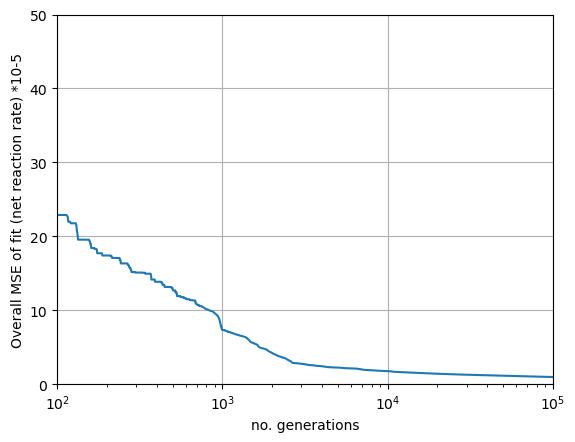

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.689635755130475
1.3902323336802336
0.7121059106216451
-4.090587640587071
0.4628449421879755
6.572763700653614e-07
0.3793106376374549
-9.17377453040018
0.8640244902437889
7.822611225387864
6.217308774344273
6.160148713975196
0.6105316978290737
0.03082874341689036
2.9181330130853227
0.01584376848365798
0.13798353821977502
-11.656345609816952
1.838626493226837
1.551756986795437
-11.273417660675063
1.163089974771625
3.938964973592176
0.013452057177408229
4.078889500556177
4.369520704892472
1.7350750036314633
9.568829065641264
-1.1599342572842408
3.028935970586859
8.693685606524072
1.9364627752500874
-3.9772743329332085
0.5018880363816327
1.0548977864644717
-1.3010292071767573


In [37]:
res.X

array([-1.06896358e+01,  1.39023233e+00,  7.12105911e-01, -4.09058764e+00,
        4.62844942e-01,  6.57276370e-07,  3.79310638e-01, -9.17377453e+00,
        8.64024490e-01,  7.82261123e+00,  6.21730877e+00,  6.16014871e+00,
        6.10531698e-01,  3.08287434e-02,  2.91813301e+00,  1.58437685e-02,
        1.37983538e-01, -1.16563456e+01,  1.83862649e+00,  1.55175699e+00,
       -1.12734177e+01,  1.16308997e+00,  3.93896497e+00,  1.34520572e-02,
        4.07888950e+00,  4.36952070e+00,  1.73507500e+00,  9.56882907e+00,
       -1.15993426e+00,  3.02893597e+00,  8.69368561e+00,  1.93646278e+00,
       -3.97727433e+00,  5.01888036e-01,  1.05489779e+00, -1.30102921e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.689635755130475
1.6: 1.3902323336802336
0.9: 0.7121059106216451
-4.3: -4.090587640587071
0.5: 0.4628449421879755
0.003: 6.572763700653614e-07
0.4: 0.3793106376374549
-7.9: -9.17377453040018
0.7: 0.8640244902437889
7.2: 7.822611225387864
5.7: 6.217308774344273
5.7: 6.160148713975196
0.8: 0.6105316978290737
0.03: 0.03082874341689036
3.1: 2.9181330130853227
6.000000000000001e-09: 0.01584376848365798
0.1: 0.13798353821977502
-12.0: -11.656345609816952
1.9: 1.838626493226837
1.6: 1.551756986795437
-11.6: -11.273417660675063
1.2: 1.163089974771625
4.0: 3.938964973592176
0.01: 0.013452057177408229
4.2: 4.078889500556177
5.4: 4.369520704892472
2.2: 1.7350750036314633
11.8: 9.568829065641264
-12.0: -1.1599342572842408
3.3: 3.028935970586859
1.8: 8.693685606524072
4.2: 1.9364627752500874
-4.0: -3.9772743329332085
0.5: 0.5018880363816327
1.0: 1.0548977864644717
coeff fit: 0.8260152644445378
r: 0.9088538190735284


In [ ]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.13154450e+01,  1.49047566e+00,  8.05996883e-01, -4.10687814e+00,
        4.64083153e-01,  1.91999473e-06,  3.72688192e-01, -8.43085190e+00,
        7.83510829e-01,  7.12401021e+00,  5.53587673e+00,  5.52100919e+00,
        3.92329474e-02,  7.88447487e-02,  2.79991530e+00,  2.22766185e-02,
        5.00129696e-01, -1.06091886e+01,  1.65798928e+00,  1.45231907e+00,
       -1.03822329e+01,  1.04733939e+00,  3.52636751e+00,  4.13914591e-05,
        3.78306116e+00,  4.06656295e+00,  1.68622587e+00,  9.22393873e+00,
       -9.74568322e+00,  2.70154265e+00,  1.68900657e+00,  3.43447749e+00,
       -4.17368651e+00,  5.30916021e-01,  1.00481480e+00, -1.30102961e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.14763873e+01,  1.51614890e+00,  8.27891412e-01, -1.40431704e+00,
        2.58477815e-02,  3.69592454e-07,  2.96517745e-01, -1.14993859e+01,
        1.19821373e+00,  8.49491857e+00,  6.74429647e+00,  6.64588439e+00,
        3.73755462e-06,  7.00781124e-02,  2.75759050e+00,  7.63221880e-02,
        4.49091526e-01, -1.12339717e+01,  1.76797648e+00,  1.54486926e+00,
       -1.09057473e+01,  1.11063051e+00,  3.75973806e+00,  8.81266070e-03,
        3.97529344e+00,  4.46063026e+00,  1.75787779e+00,  9.70521061e+00,
       -2.78918720e+00,  2.42736153e+00,  5.78702811e+00,  1.98410106e+00,
       -4.51201286e+00,  6.00110331e-01,  1.10828602e+00, -1.30102936e+00]
krseed101 = [-1.12983781e+01,  1.48773100e+00,  8.03552325e-01, -1.40507134e+00,
        2.67781166e-02,  2.23831398e-07,  2.99126315e-01, -9.43340559e+00,
        9.46450708e-01,  7.13039971e+00,  5.60975640e+00,  5.59696418e+00,
        5.71482966e-07,  7.16489926e-02,  2.76841179e+00,  6.52878532e-02,
        4.74140603e-01, -1.12591919e+01,  1.77241703e+00,  1.55217444e+00,
       -1.17208908e+01,  1.20645353e+00,  4.03562841e+00,  1.48629162e-06,
        4.30094581e+00,  4.92567384e+00,  1.95582172e+00,  1.06708174e+01,
       -5.14712967e+00,  3.13932789e+00,  6.19540391e+00,  2.77130515e+00,
       -3.91735884e+00,  4.91732283e-01,  1.05364416e+00, -1.30102913e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
meankr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()